# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/1014rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/1015rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/1016rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/1014rep_50noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/1015rep_50noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/1016rep_50noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.311391        0.189927  0.048388  0.295999  0.020291   
       0.25   0.288169        0.183172  0.055065  0.240864  0.070961   
       0.50   0.307756        0.194813  0.057340  0.239210  0.098771   
       0.75   0.338612        0.186509  0.064592  0.210419  0.122927   
       1.00   0.309661        0.173118  0.080808  0.177525  0.147802   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.201482  0.010319  0.040935  0.051328  0.000000  
       0.25  0.183500  0.009765  0.038369  0.049151  0.000637  
       0.50  0.199910  0.009447  0.039245  0.051988  0.001452  
       0.75  0.202789  0.007846  0.036108  0.052103  0.002424  
       1.00  0.209037  0.007173  0.038778  0.046110  0.003399

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.285361        0.203451  0.053860  0.318371  0.020249   
       0.25   0.303970        0.202768  0.054144  0.255852  0.065447   
       0.50   0.311419        0.193434  0.062980  0.218129  0.090822   
       0.75   0.300018        0.206707  0.071904  0.202362  0.128714   
       1.00   0.317564        0.163661  0.077625  0.174937  0.141294   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.202172  0.009839  0.040488  0.049874  0.000000  
       0.25  0.206021  0.010718  0.037145  0.048449  0.000589  
       0.50  0.223734  0.009240  0.037428  0.048557  0.001586  
       0.75  0.210758  0.007717  0.037750  0.045304  0.002309  
       1.00  0.208210  0.007162  0.037766  0.051536  0.003630

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.307520        0.208194  0.051695  0.316037  0.018968   
       0.25   0.318936        0.189701  0.057546  0.237189  0.071454   
       0.50   0.308453        0.169807  0.063584  0.231334  0.102456   
       0.75   0.337558        0.194610  0.069294  0.192815  0.126065   
       1.00   0.299867        0.178170  0.077289  0.165448  0.128814   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.212359  0.010137  0.040349  0.053594  0.000000  
       0.25  0.188316  0.009657  0.038033  0.051782  0.000546  
       0.50  0.207544  0.008647  0.036413  0.050315  0.001533  
       0.75  0.205349  0.008257  0.038775  0.045797  0.002493  
       1.00  0.201165  0.006842  0.037890  0.049281  0.003652

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.301424        0.200524  0.051314  0.310136  0.019836   
         0.25   0.299408        0.190985  0.058277  0.243627  0.070315   
         0.50   0.297438        0.184590  0.067947  0.228141  0.098678   
         0.75   0.304250        0.193897  0.079336  0.200724  0.127477   
         1.00   0.280318        0.169336  0.092565  0.173153  0.141149   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.205338  0.010099  0.040591  0.051599  0.000000  
         0.25  0.192610  0.010051  0.037849  0.049991  0.000389  
         0.50  0.210385  0.009133  0.037694  0.050805  0.001007  
         0.75  0.206264  0.008000  0.037534  0.048578  0.001597  
         1.00  0.206056  0.007187  0.038110  0.050238  0.002370

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.975196e+01  3.983424e+01      37.940737  5.956960e+01   
         0.25  4.701158e+06  2.310954e+06  211997.751938  1.441237e+06   
         0.50  5.502124e+06  3.575914e+06  336670.247783  2.170702e+06   
         0.75  5.623466e+06  4.247346e+06  427538.841201  2.825850e+06   
         1.00  5.955090e+06  4.539072e+06  458559.398350  2.920864e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.381417  5.593531e+01  5.601897e+01      18.963723   
         0.25  460875.044420  2.322661e+06  2.503681e+06  435277.872487   
         0.50  723179.835431  3.919590e+06  3.198510e+06  671401.032311   
         0.75  939479.688491  4.754849e+06  3.623287e+06  802939.509378   
         1.00  957828.217514  5.359746e+06  3.869362e+06  799052.975909   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         31.311180  
         0.25     174203.542252  
         0.50     283003.335320  
         0.75     360327.161466  
         1.00     412130.976782

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


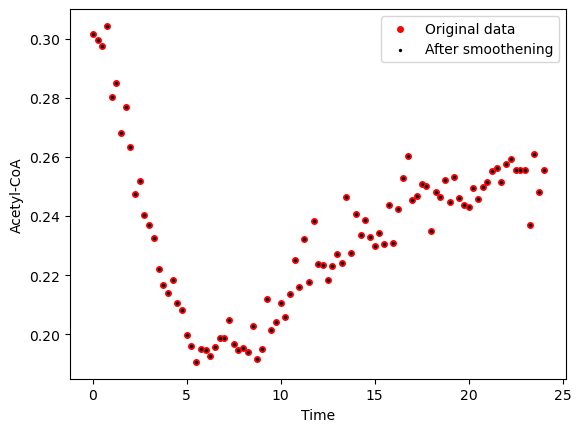

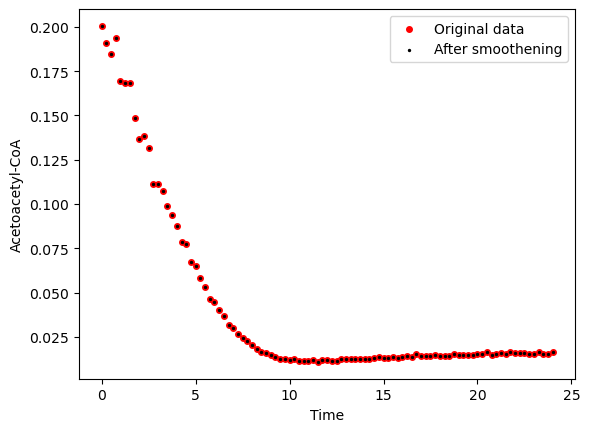

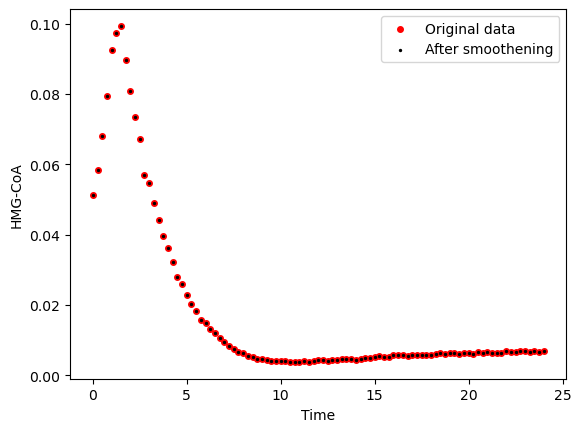

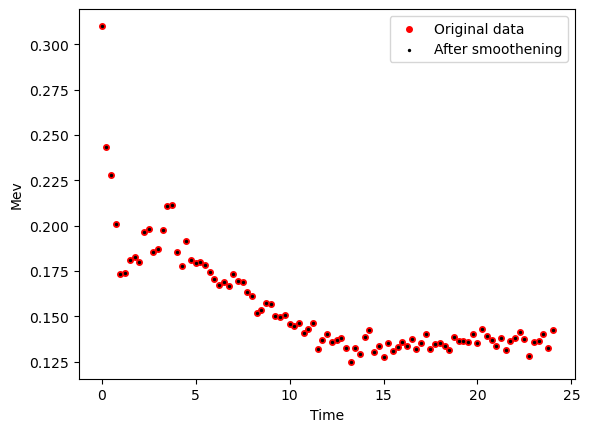

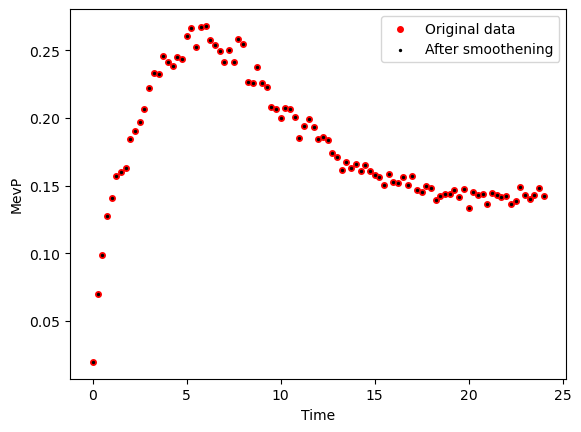

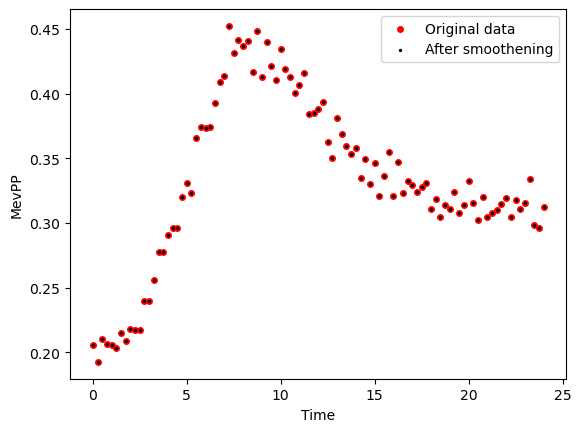

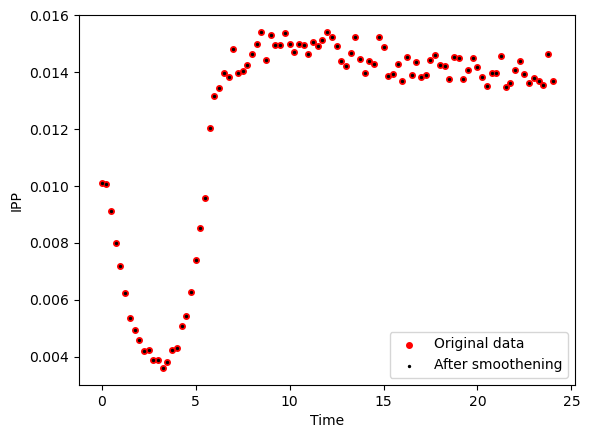

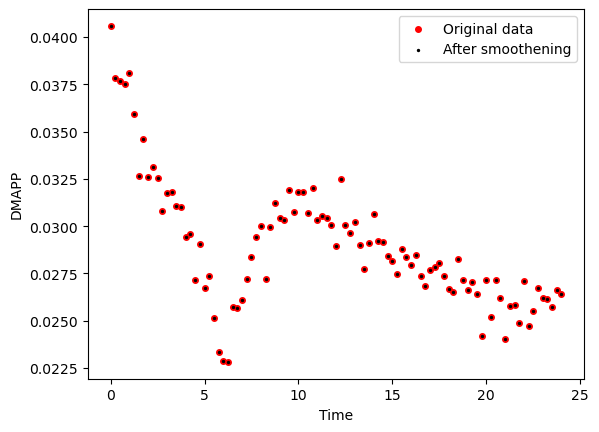

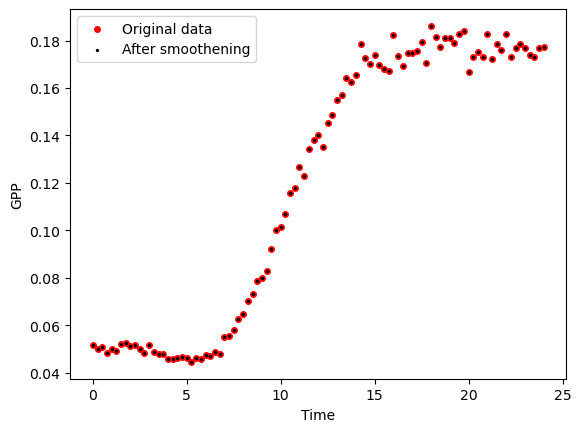

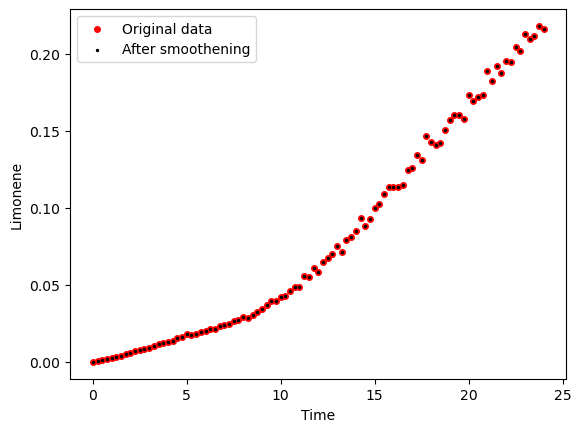

Strain Strain 2


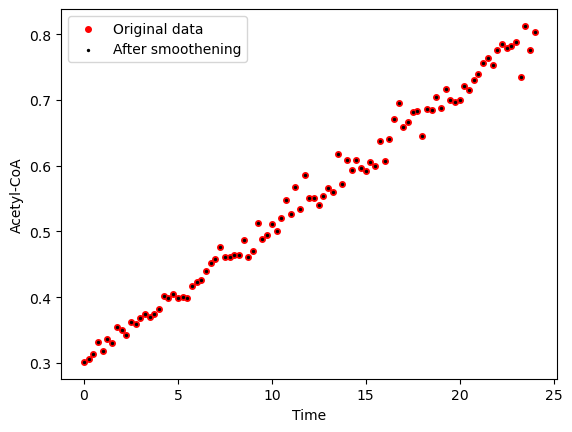

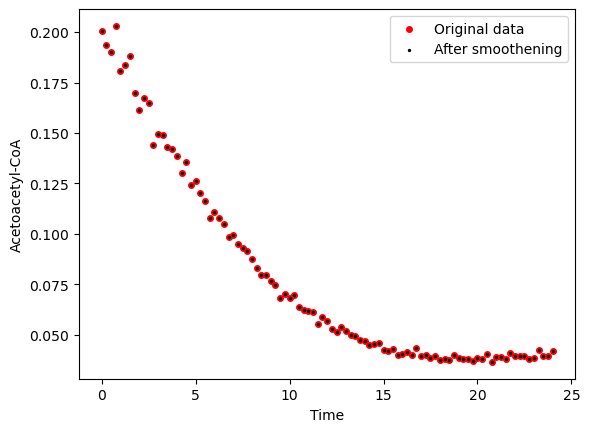

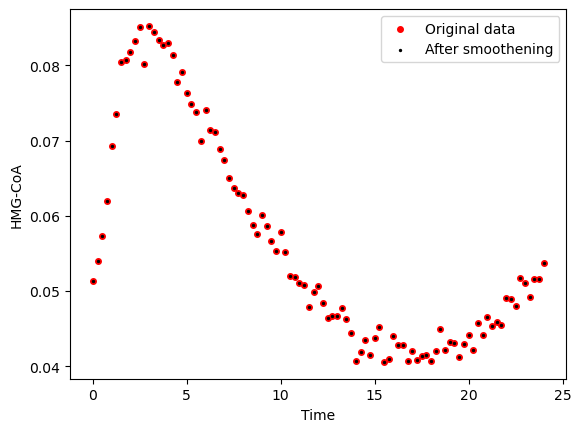

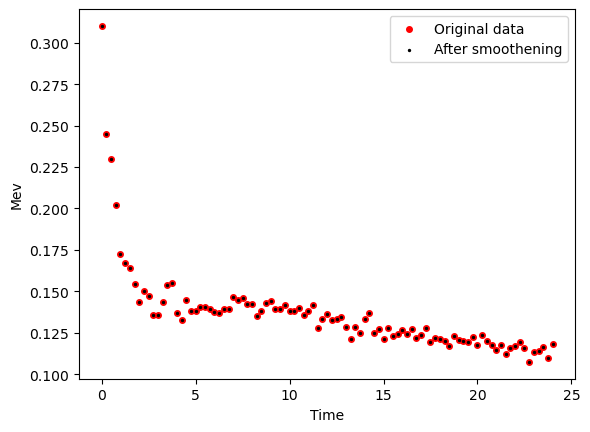

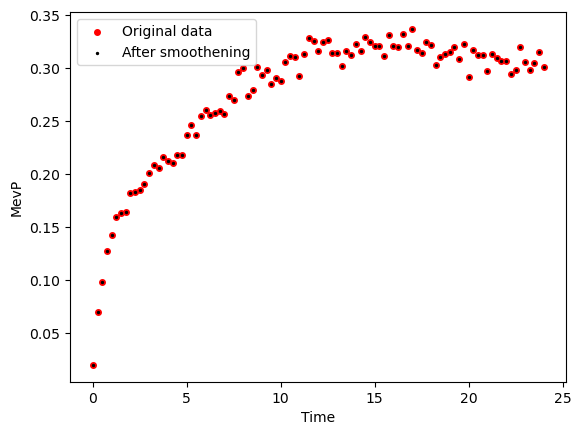

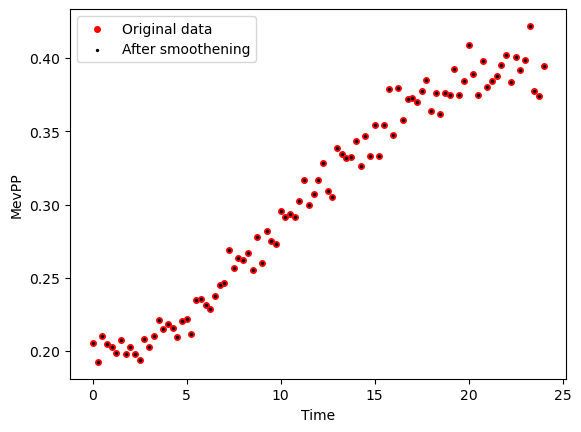

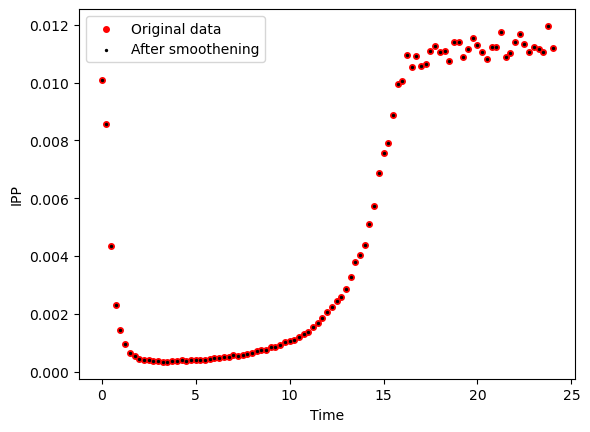

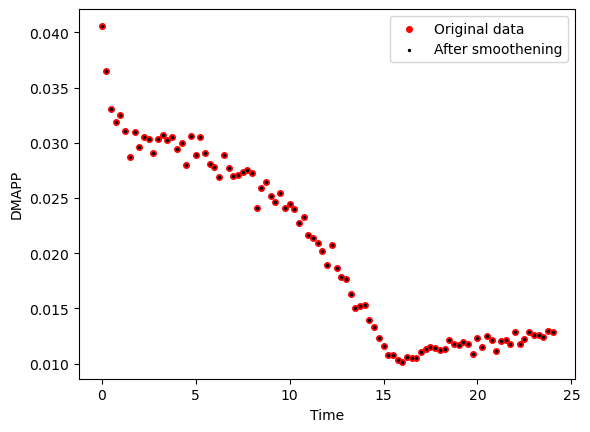

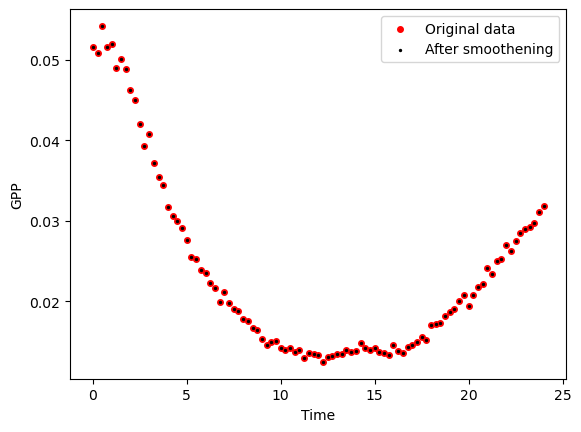

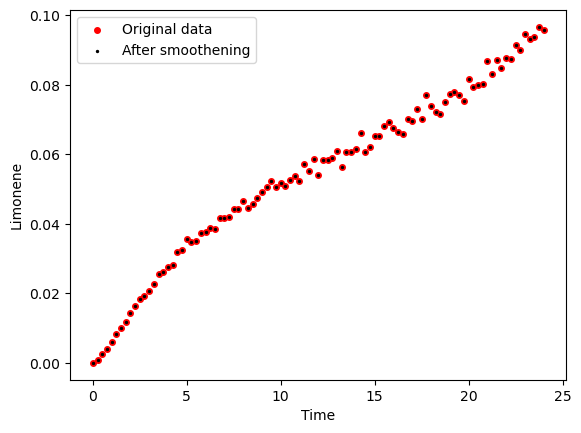

Strain Strain 3


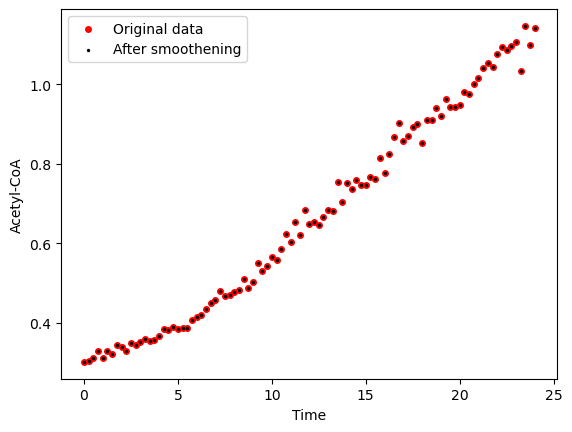

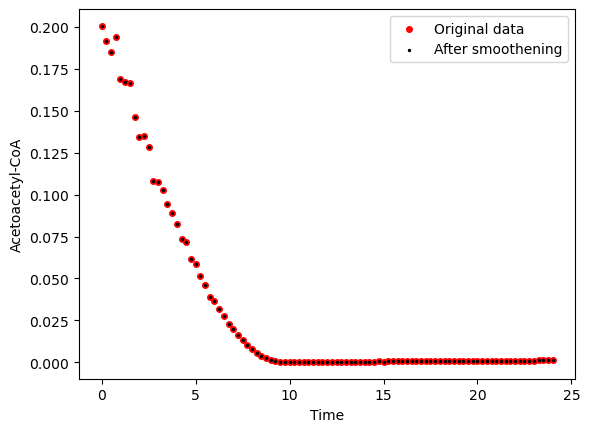

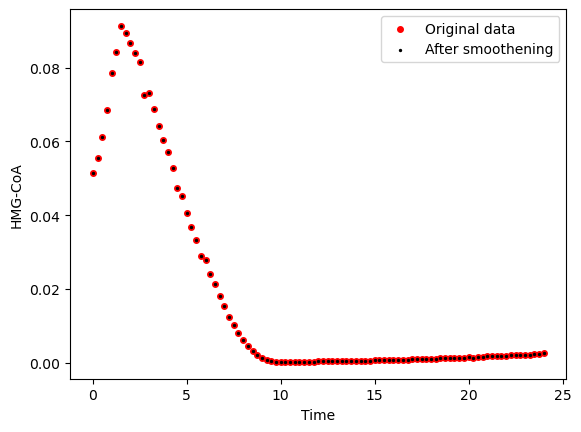

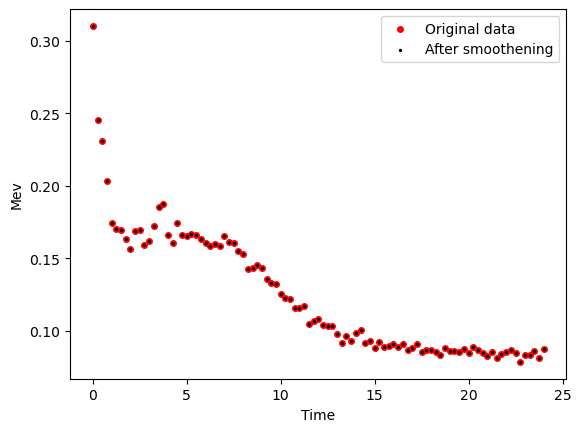

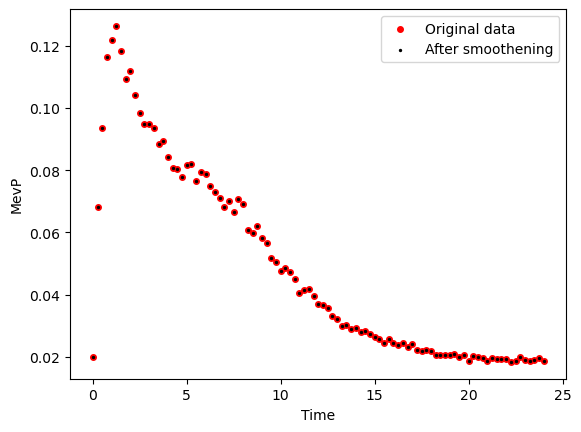

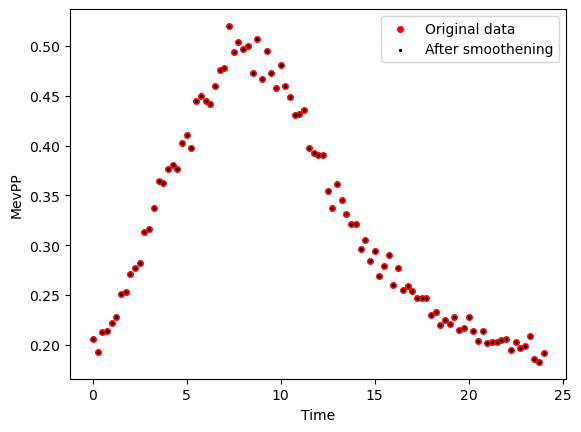

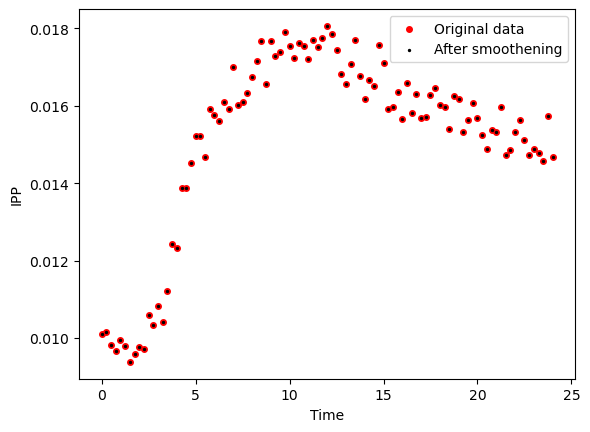

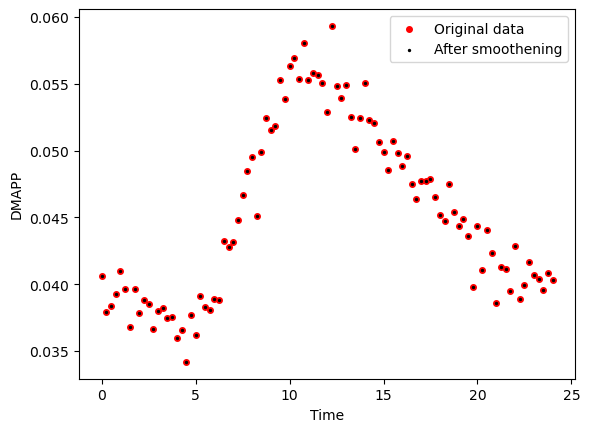

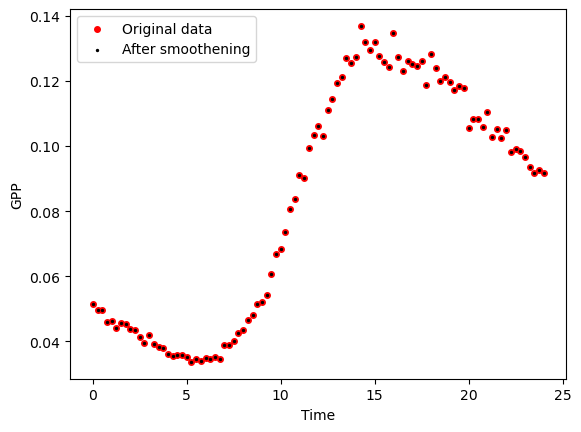

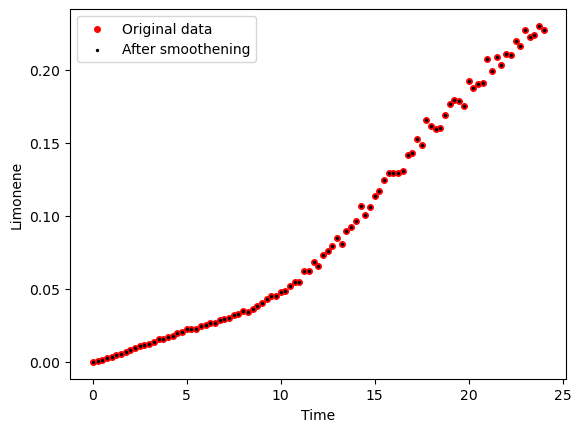

Strain WT


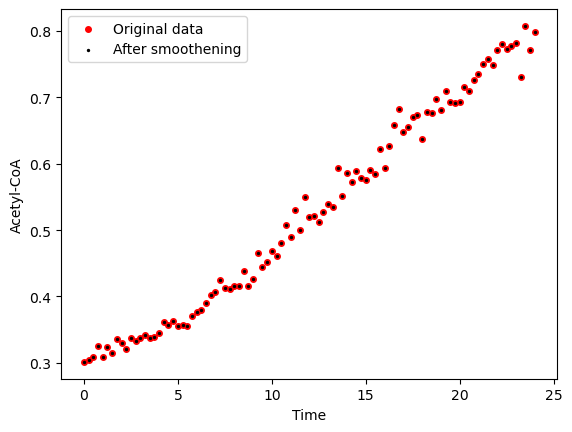

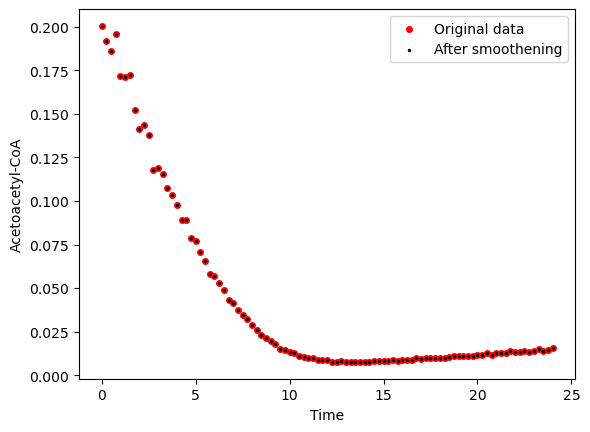

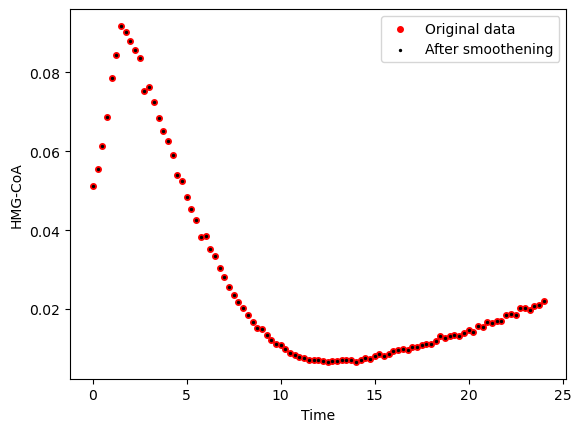

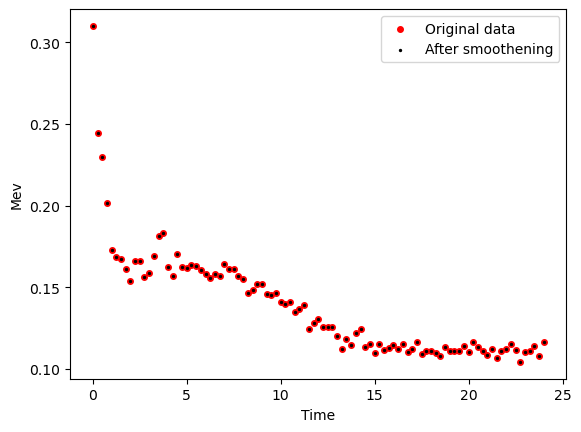

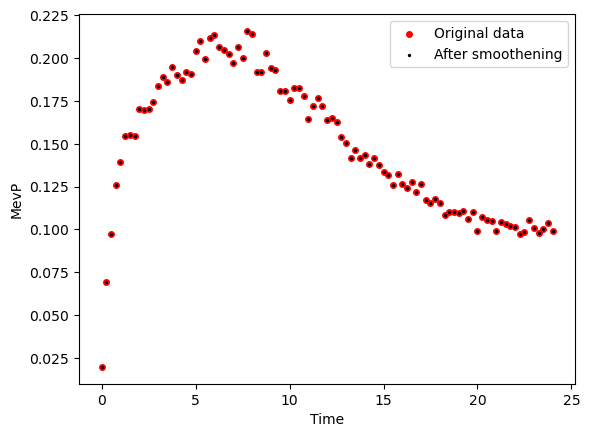

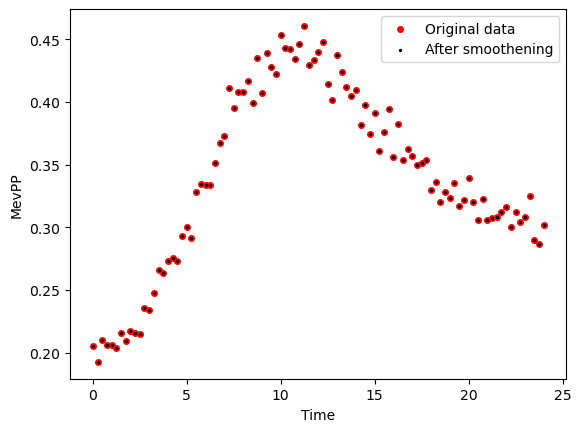

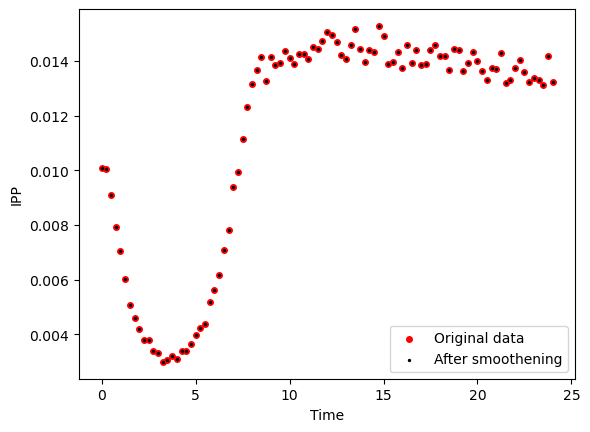

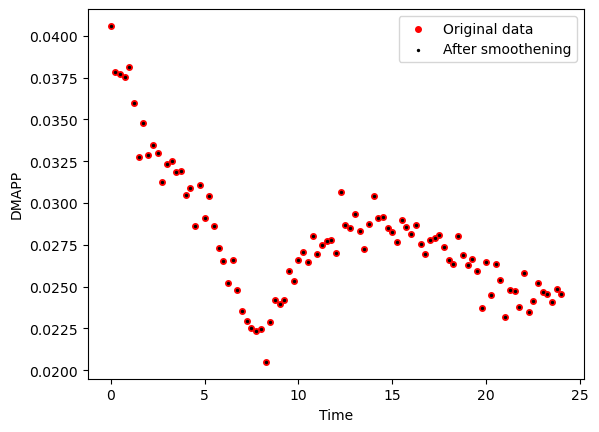

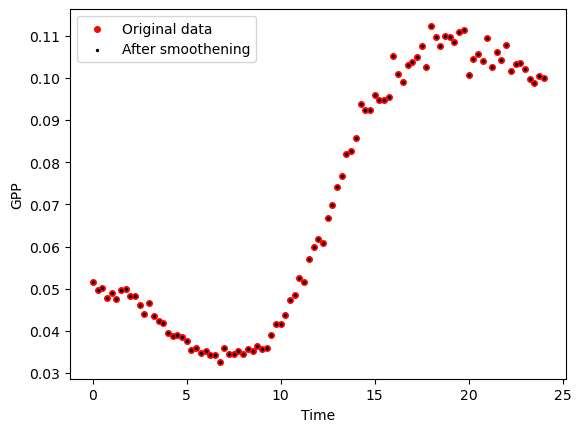

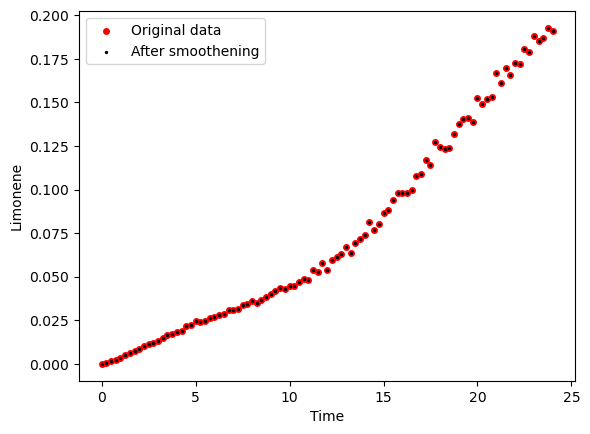

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


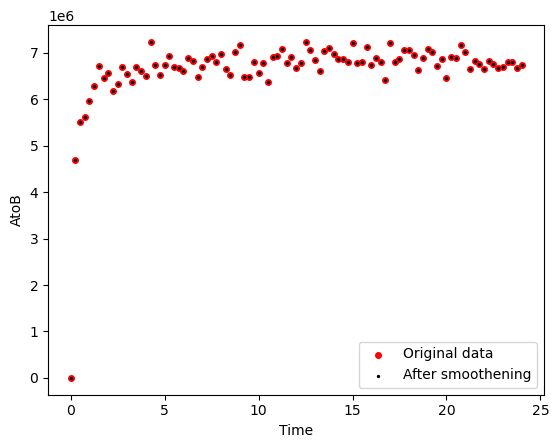

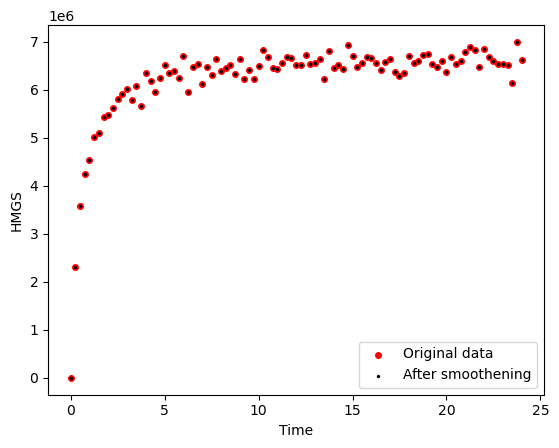

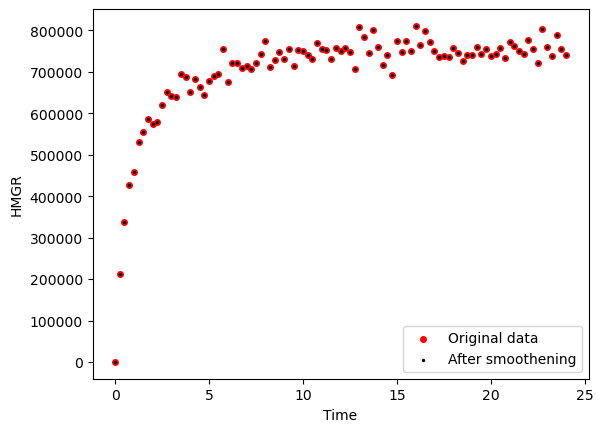

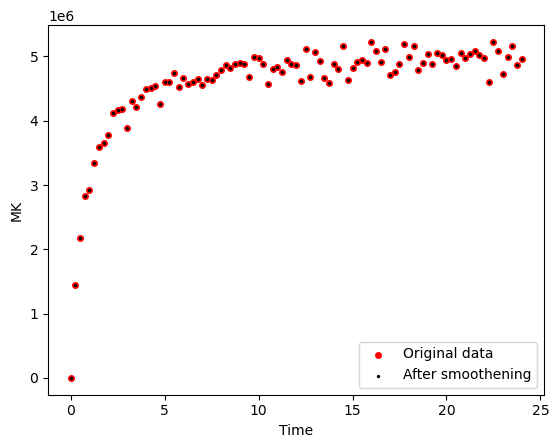

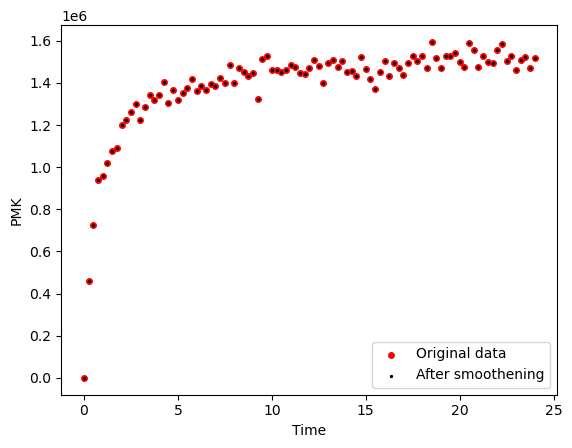

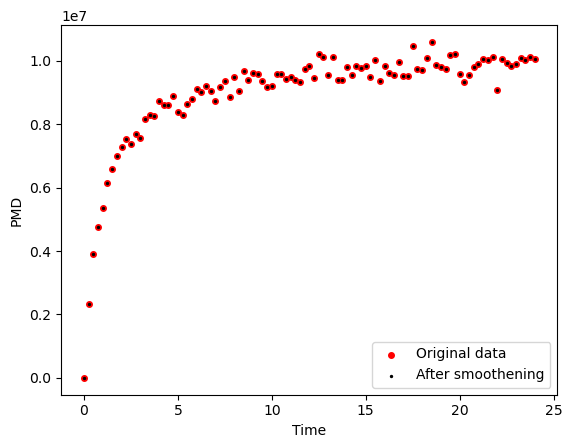

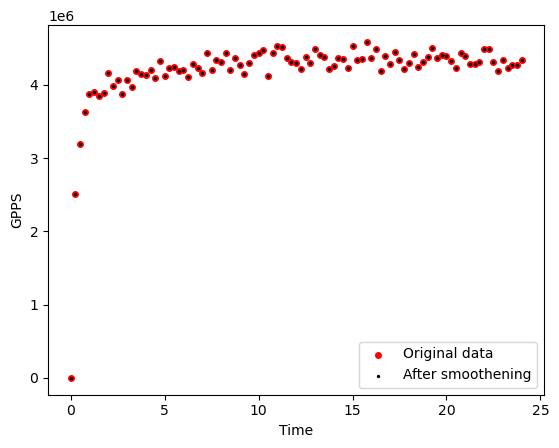

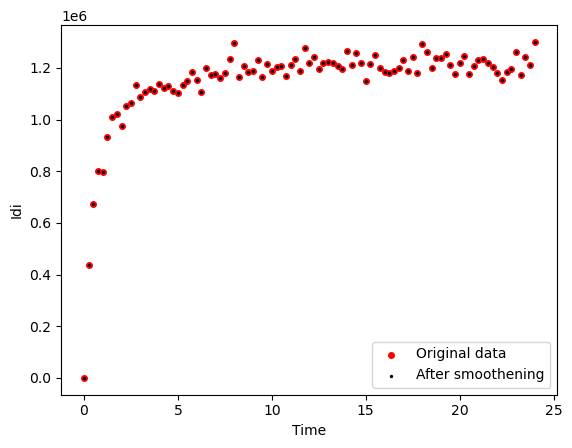

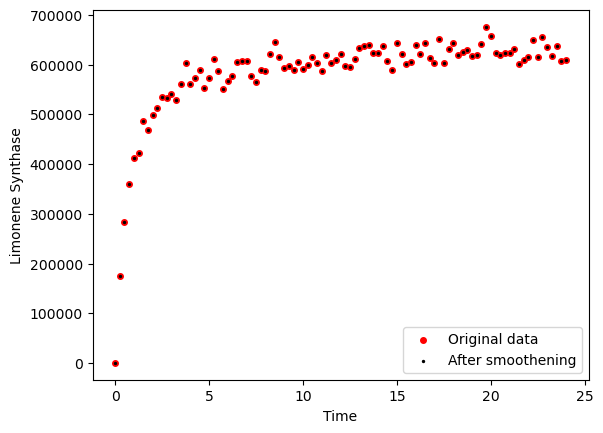

Strain Strain 2


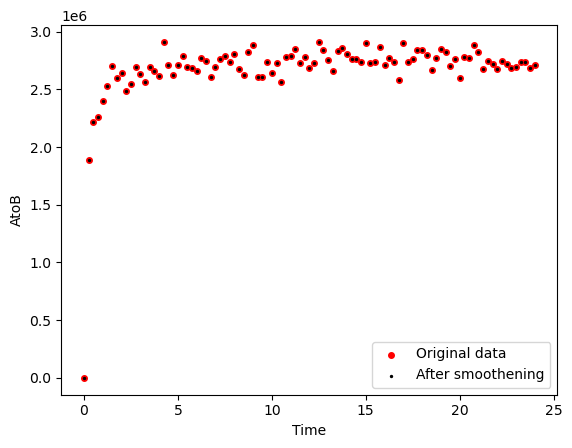

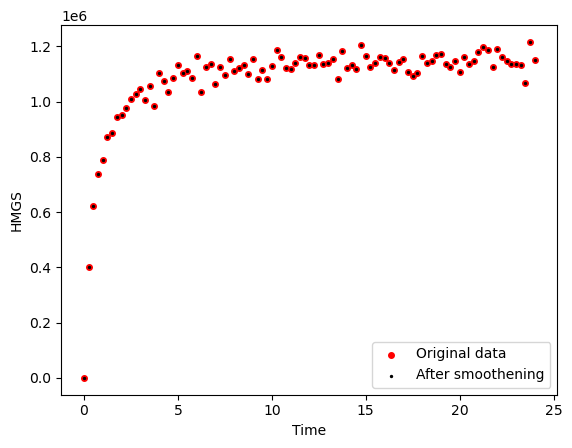

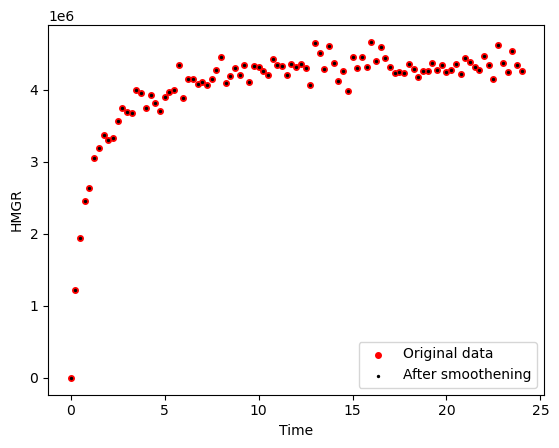

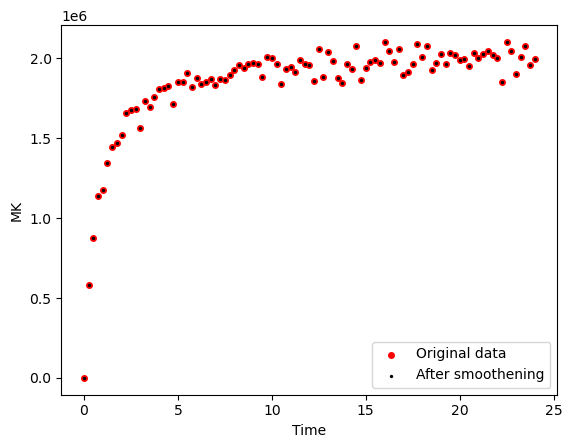

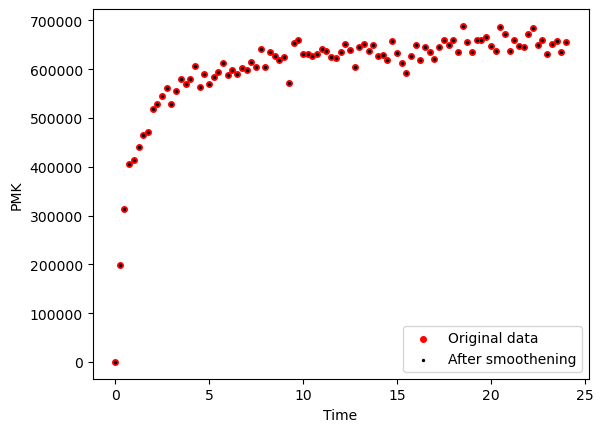

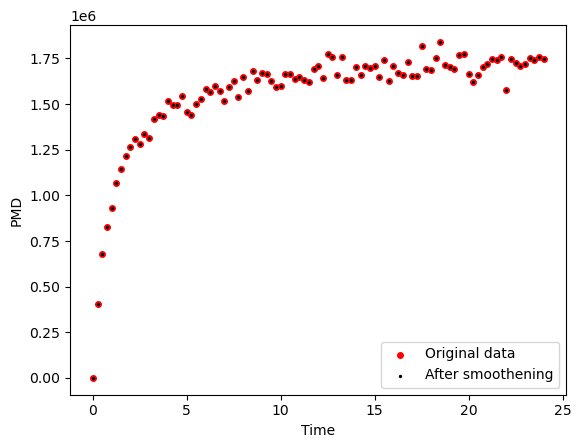

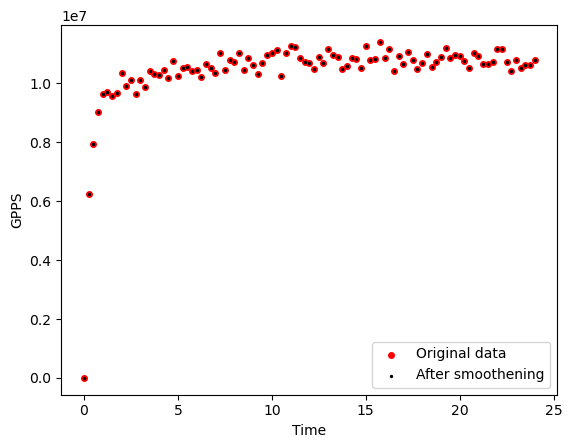

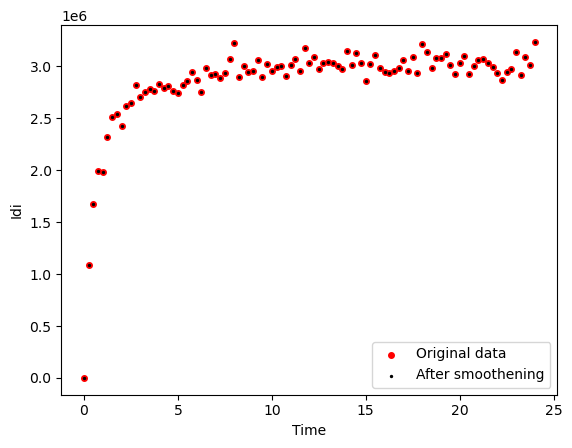

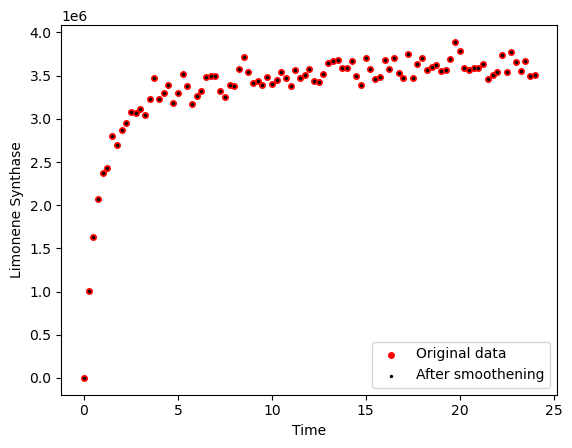

Strain Strain 3


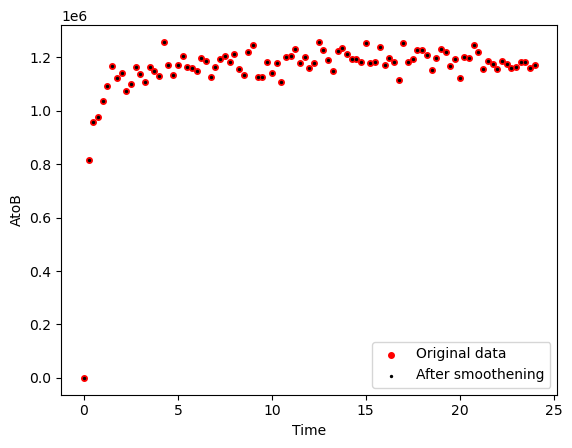

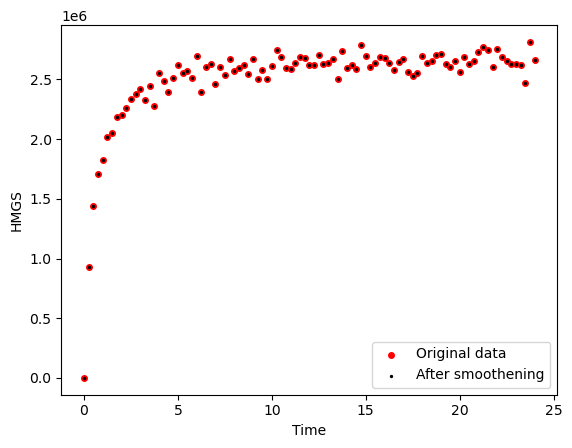

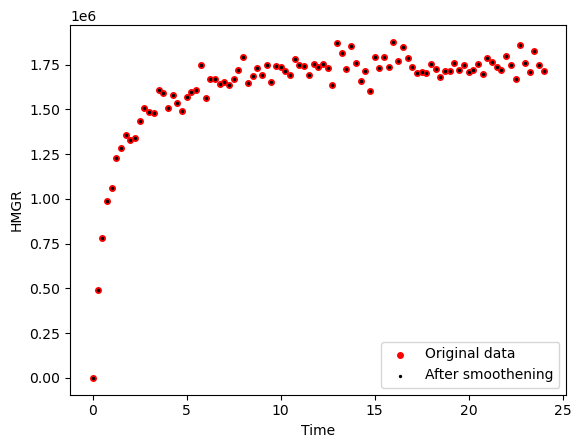

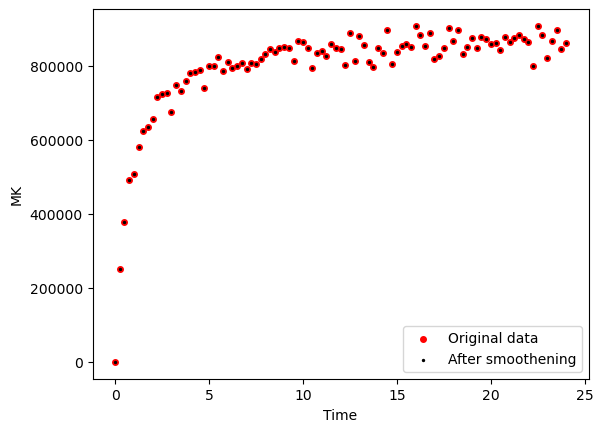

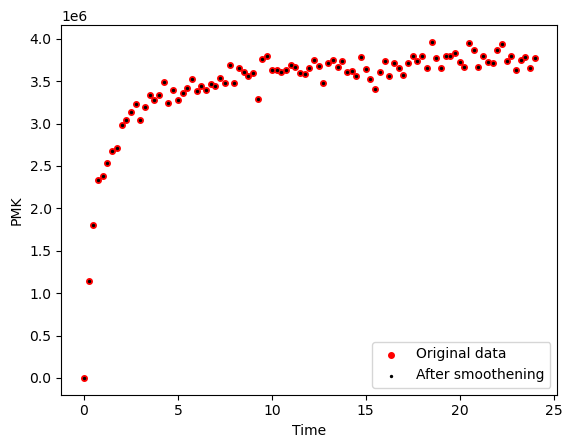

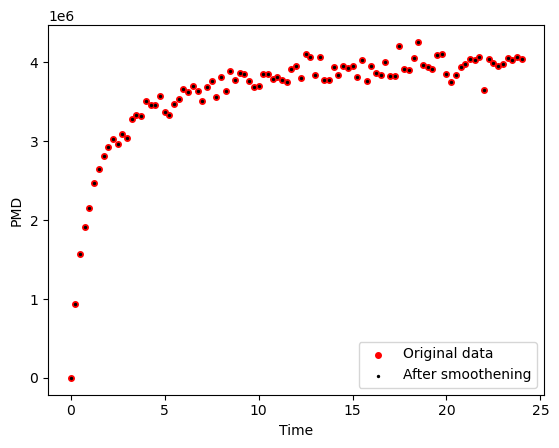

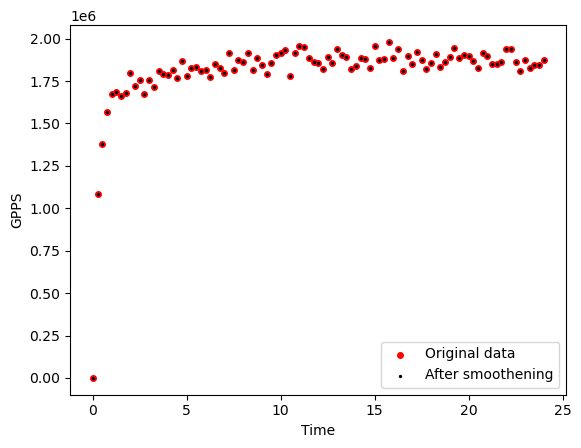

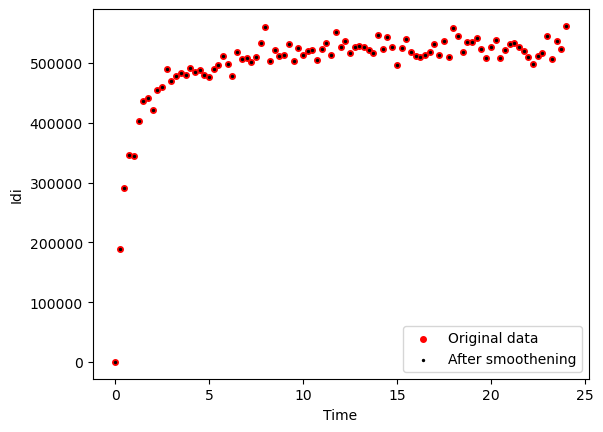

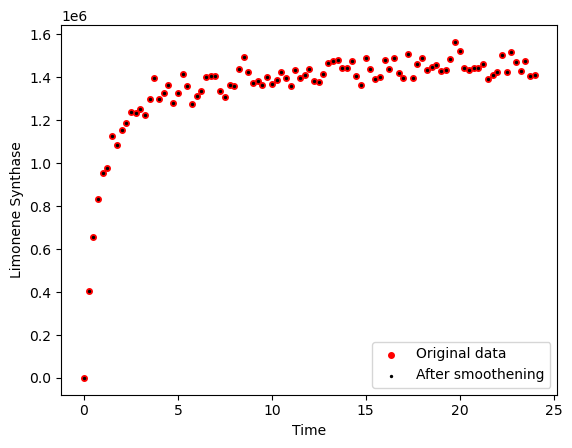

Strain WT


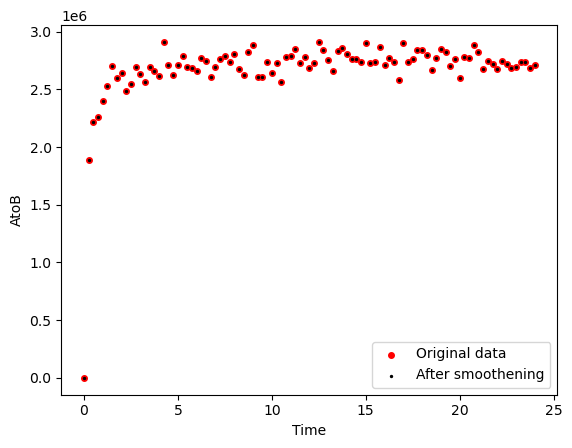

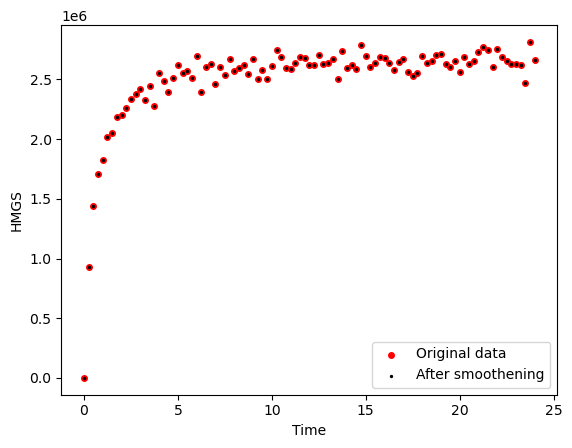

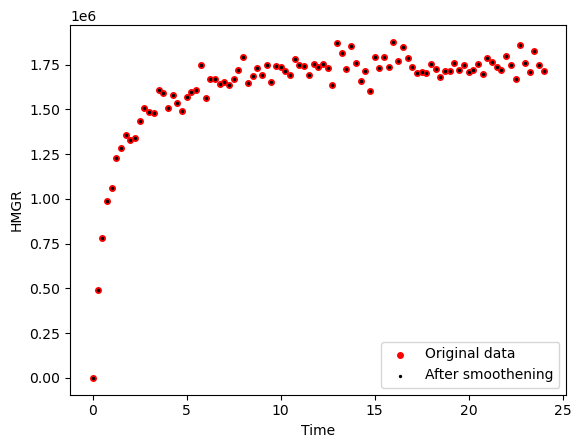

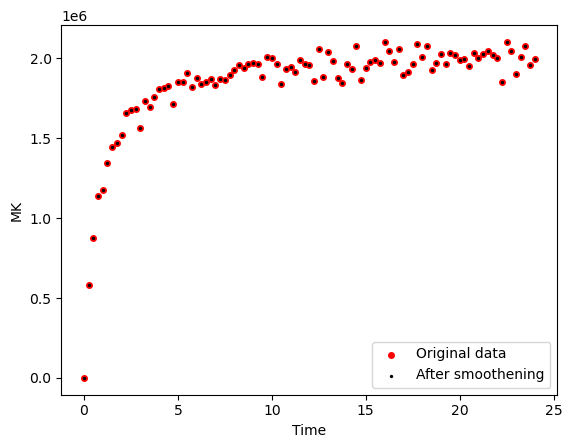

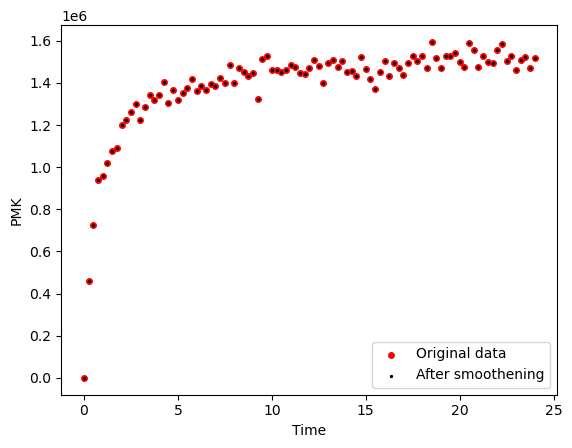

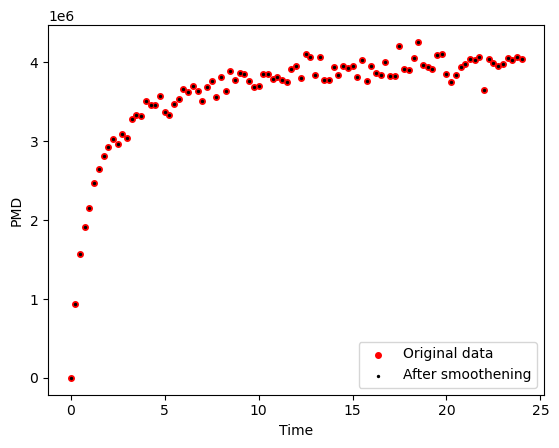

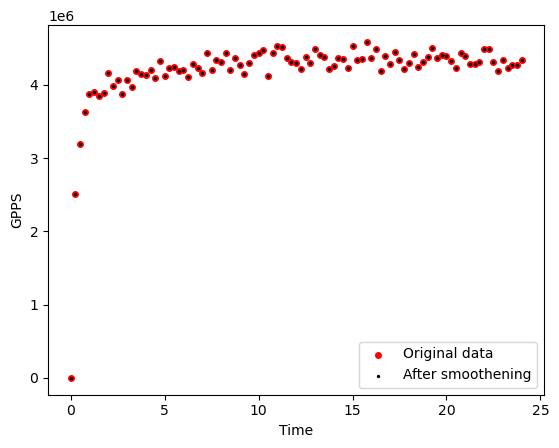

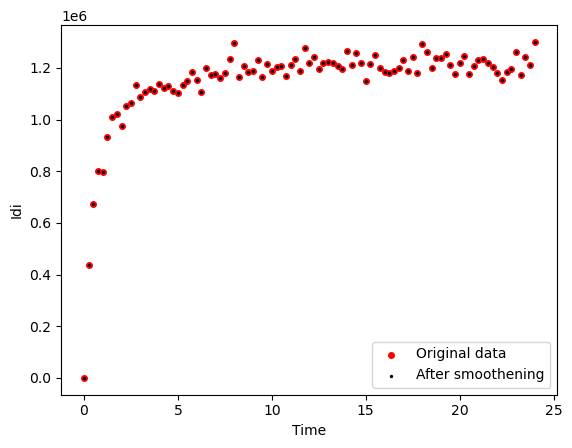

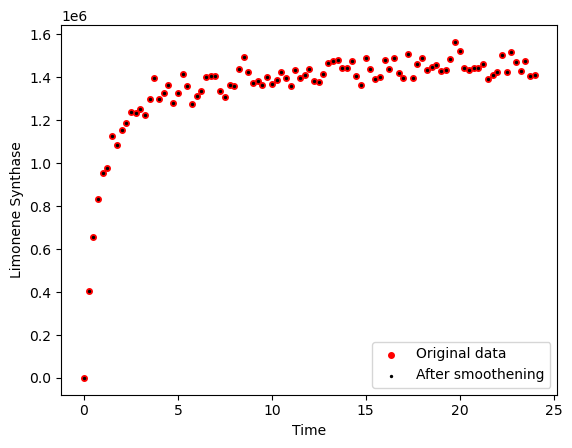

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.301424        0.200524  0.051314  0.310136  0.019836   
         0.25    0.299408        0.190985  0.058277  0.243627  0.070315   
         0.50    0.297438        0.184590  0.067947  0.228141  0.098678   
         0.75    0.304250        0.193897  0.079336  0.200724  0.127477   
         1.00    0.280318        0.169336  0.092565  0.173153  0.141149   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.782637        0.013612  0.020194  0.110700  0.100811   
         23.25   0.730114        0.015073  0.019702  0.111253  0.098169   
         23.50   0.807687        0.014126  0.020858  0.114335  0.100407   
         23.75   0.771875        0.014278  0.021028  0.108200  0.103659   
         24.00   0.799248        0.015356  0.022089  0.116762  0.099316   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.205338  0.010099  0.040591  0.051599  0.000000  ...   
         0.25   0.192610  0.010051  0.037849  0.049991  0.000389  ...   
         0.50   0.210385  0.009133  0.037694  0.050805  0.001007  ...   
         0.75   0.206264  0.008000  0.037534  0.048578  0.001597  ...   
         1.00   0.206056  0.007187  0.038110  0.050238  0.002370  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.308112  0.013389  0.024654  0.102204  0.188206  ...   
         23.25  0.325012  0.013297  0.024542  0.099855  0.185345  ...   
         23.50  0.290028  0.013134  0.024060  0.098761  0.187031  ...   
         23.75  0.286436  0.014177  0.024867  0.100346  0.192756  ...   
         24.00  0.301704  0.013241  0.024581  0.100009  0.191171  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.025109       -0.007394  0.025137 -0.202111  0.203547   
         0.25     0.005080       -0.015590  0.033281 -0.164429  0.161731   
         0.50    -0.014948       -0.023785  0.041424 -0.126748  0.119915   
         0.75    -0.018416       -0.024143  0.041067 -0.077758  0.086655   
         1.00    -0.031113       -0.023019  0.032284 -0.048345  0.061365   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.008239        0.001037  0.001574  0.004695 -0.001414   
         23.25    0.005257        0.001001  0.000873  0.004542 -0.001629   
         23.50    0.029992        0.001078  0.002047  0.003628  0.001000   
         23.75    0.056511        0.001267  0.003258  0.007514 -0.000365   
         24.00    0.083030        0.001457  0.004469  0.011400 -0.001731   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.002443 -0.001154 -0.009687 -0.005647  0.001533  
         0.25   0.004240 -0.002152 -0.005899 -0.003650  0.001956  
         0.50   0.006037 -0.003150 -0.002111 -0.001654  0.002380  
         0.75   0.006957 -0.003822 -0.001367 -0.000930  0.002888  
         1.00   0.002729 -0.003729 -0.004690  0.001152  0.003104  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.009597 -0.000334 -0.000355 -0.005070  0.007537  
         23.25 -0.021485  0.000647 -0.000532 -0.004013  0.010764  
         23.50 -0.020557  0.000234  0.000072 -0.001559  0.005337  
         23.75 -0.004485 -0.000041  0.000608  0.002271  0.009103  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

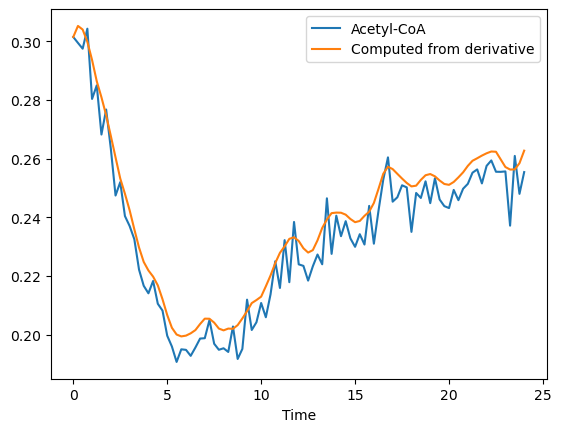

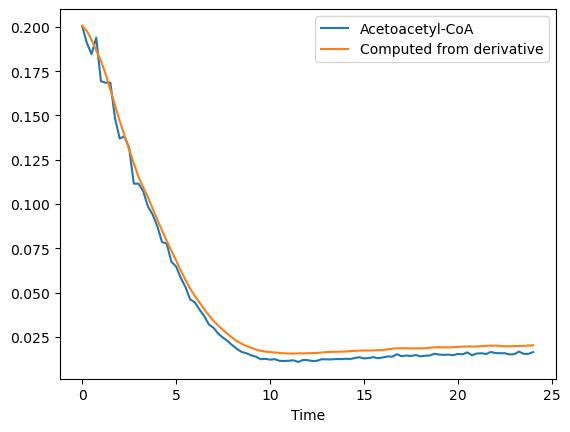

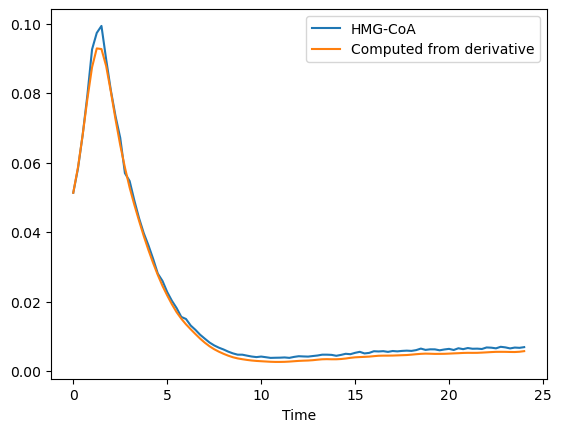

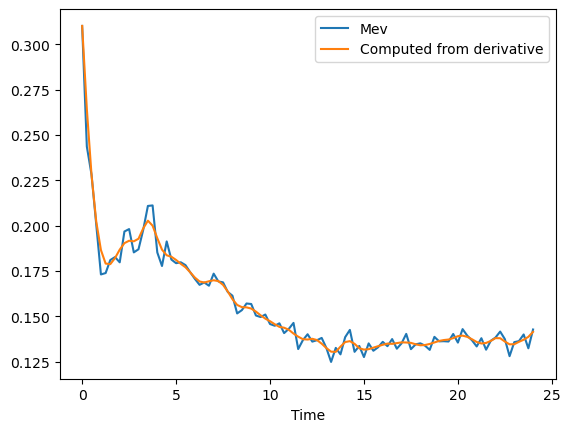

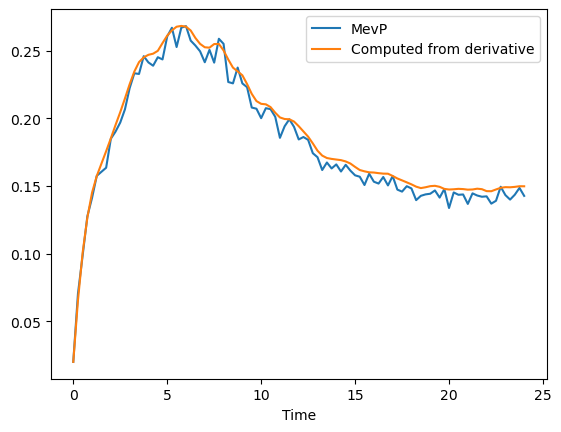

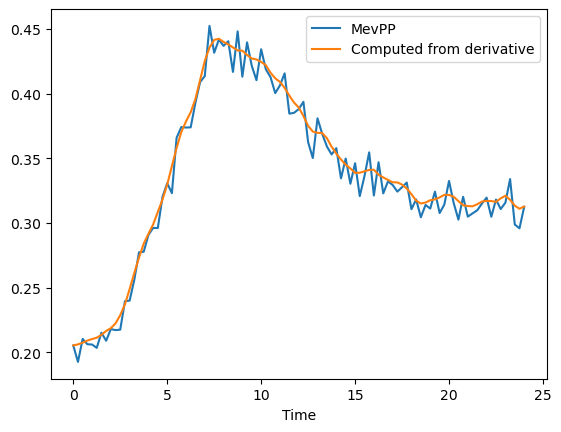

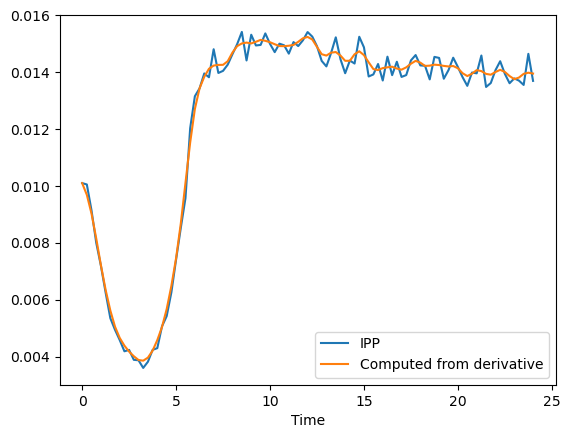

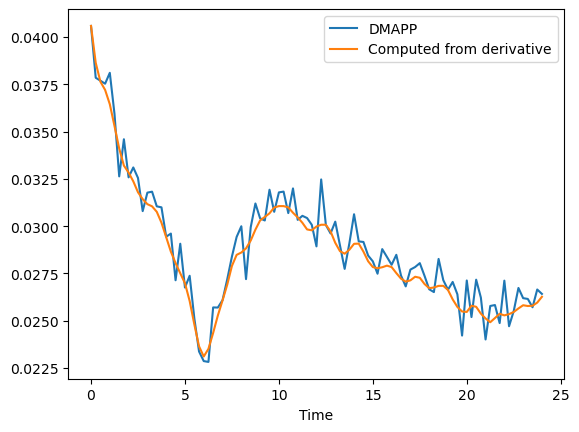

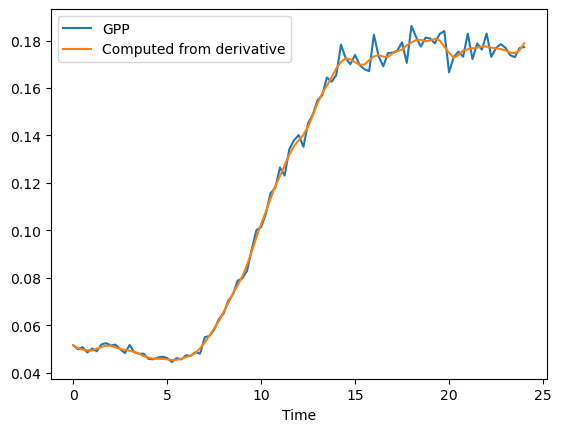

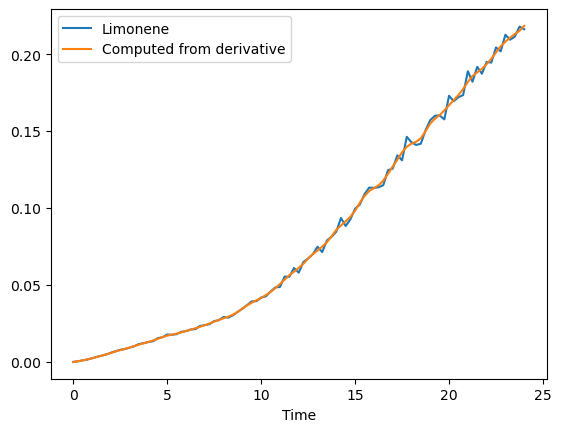

'Time profile from derivative vs. actual profile for Strain 2'

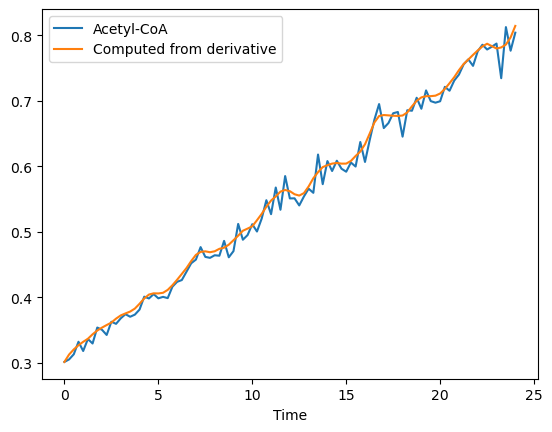

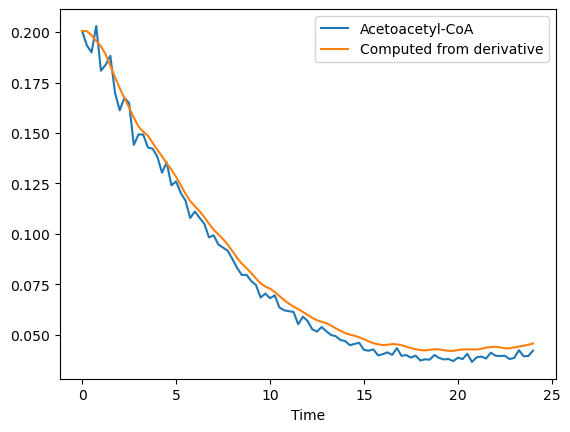

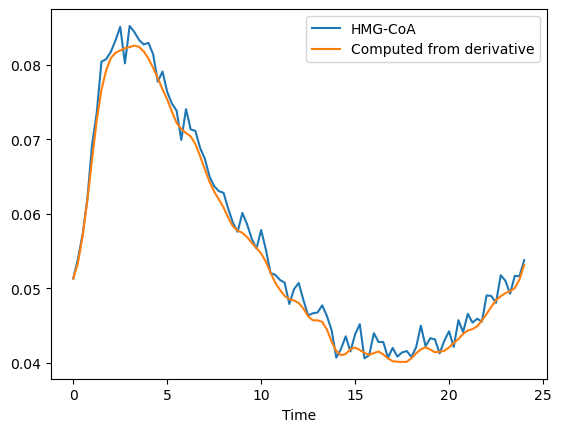

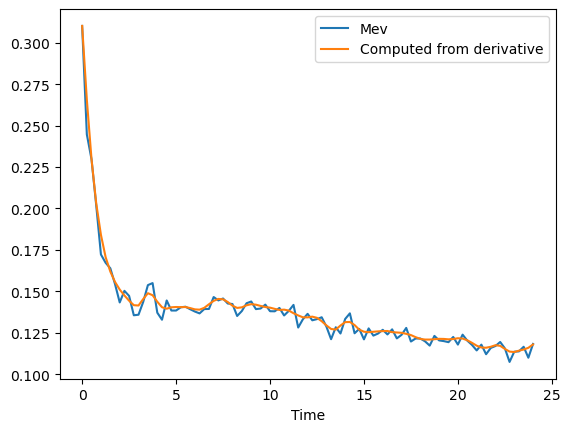

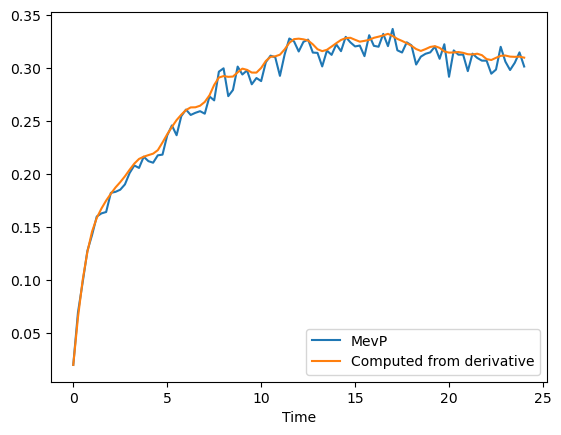

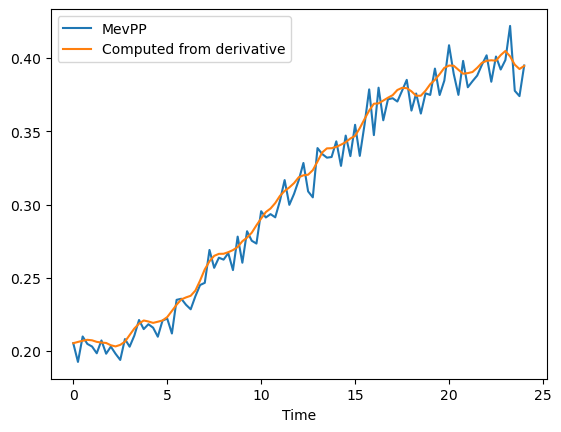

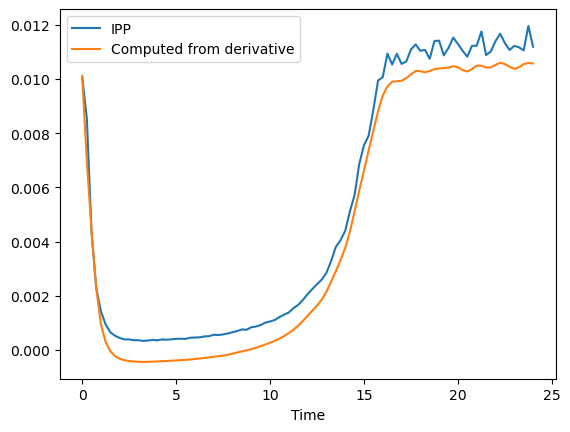

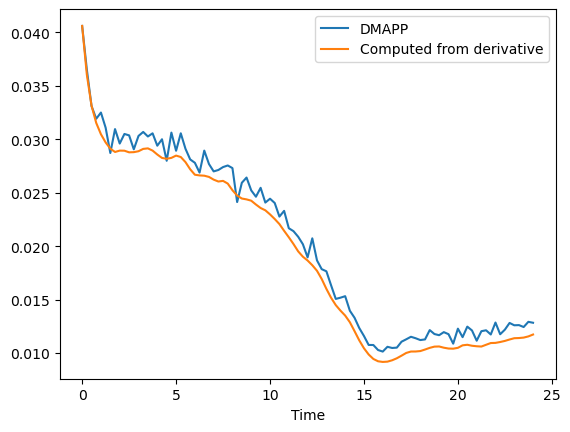

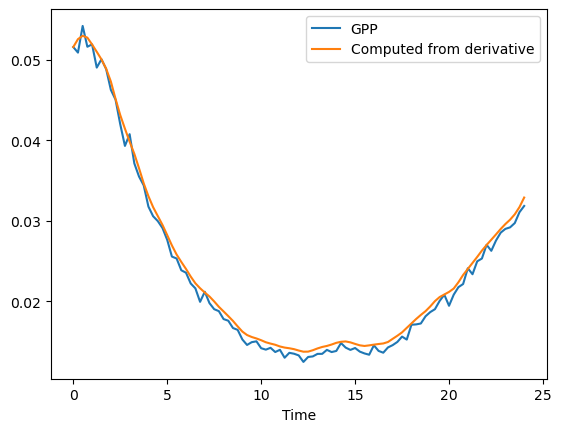

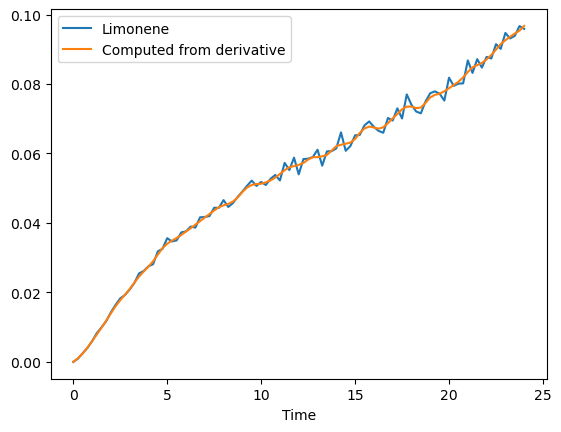

'Time profile from derivative vs. actual profile for Strain 3'

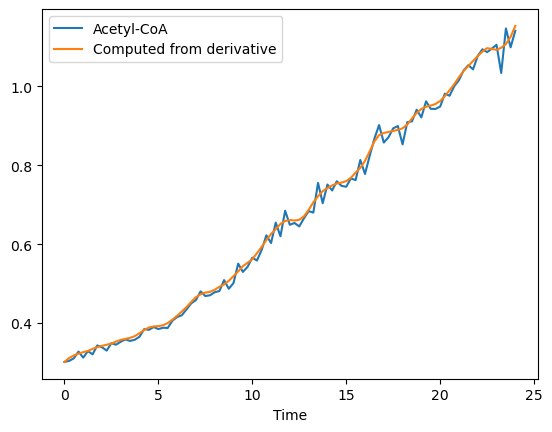

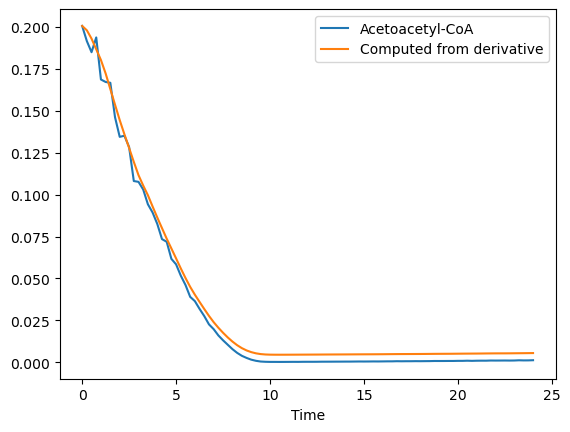

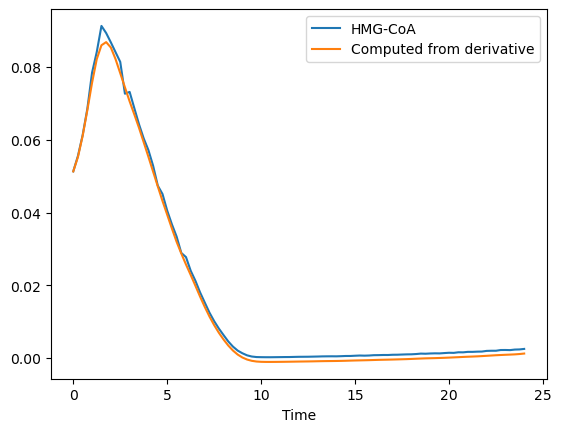

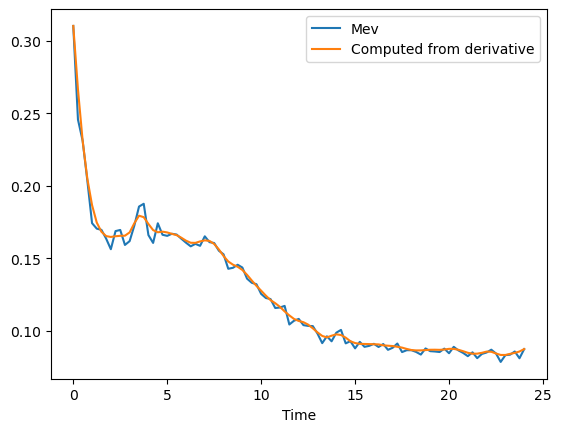

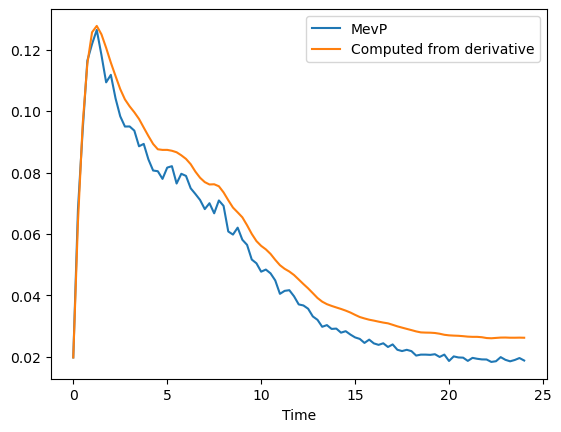

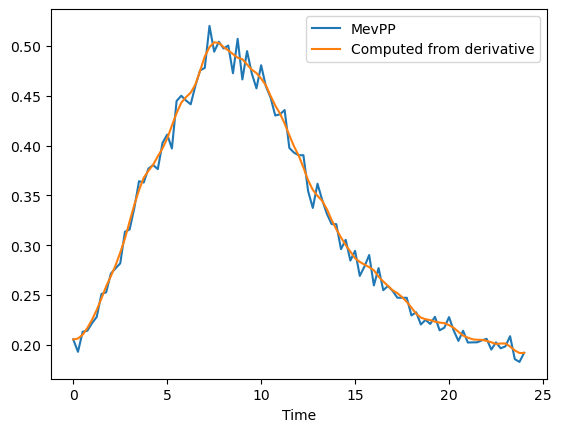

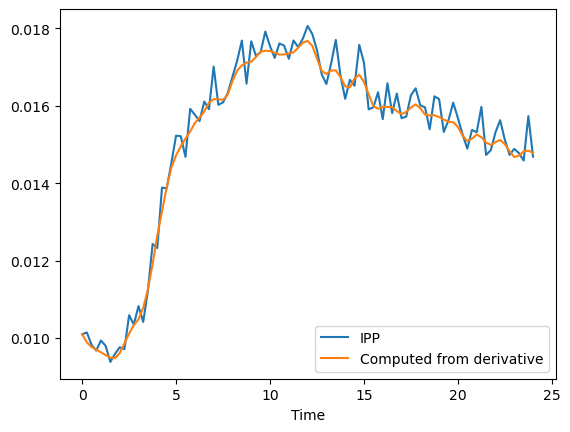

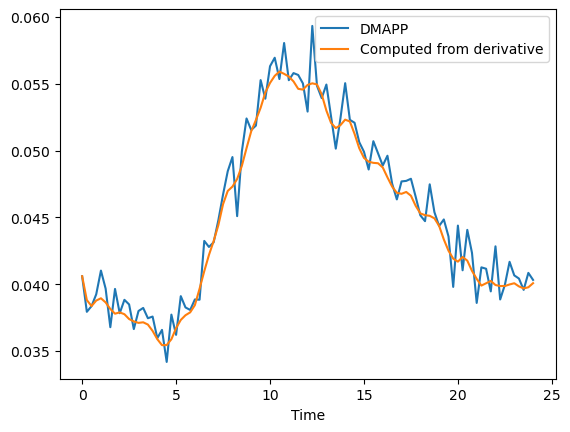

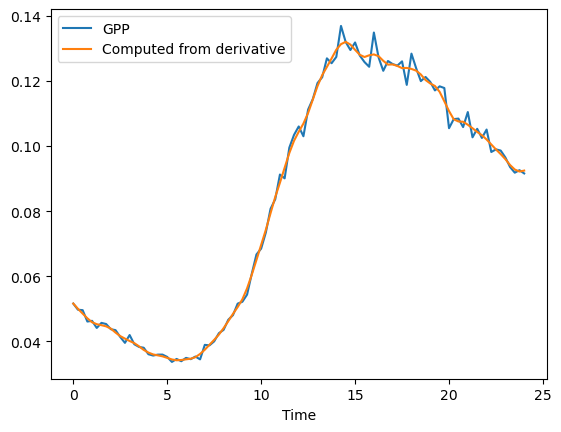

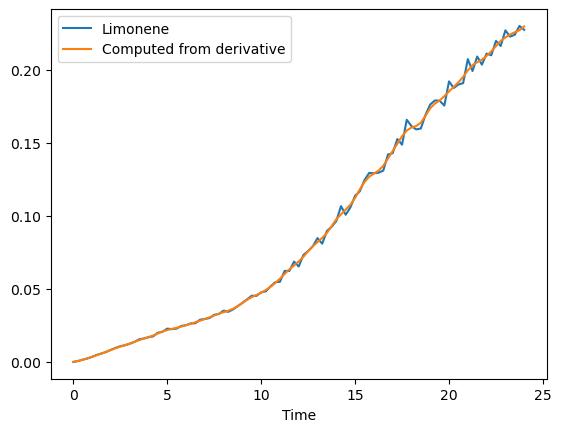

'Time profile from derivative vs. actual profile for WT'

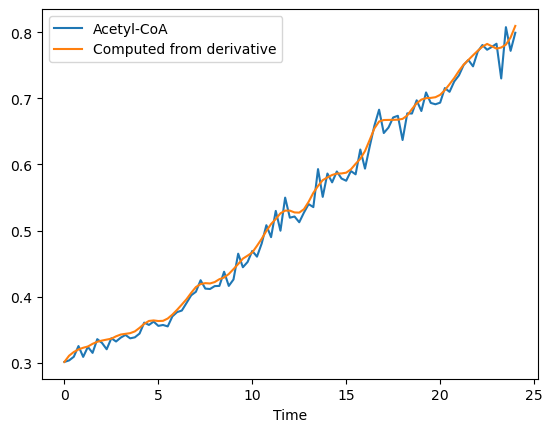

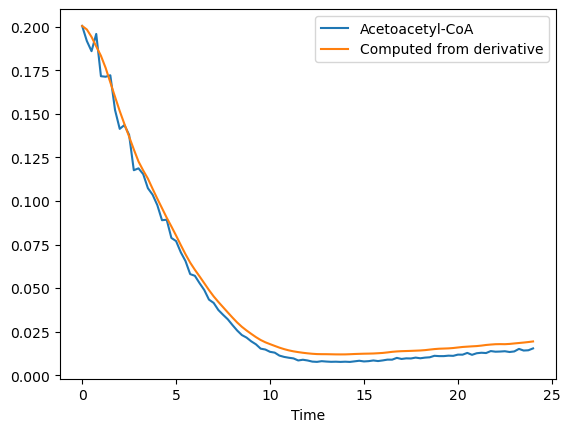

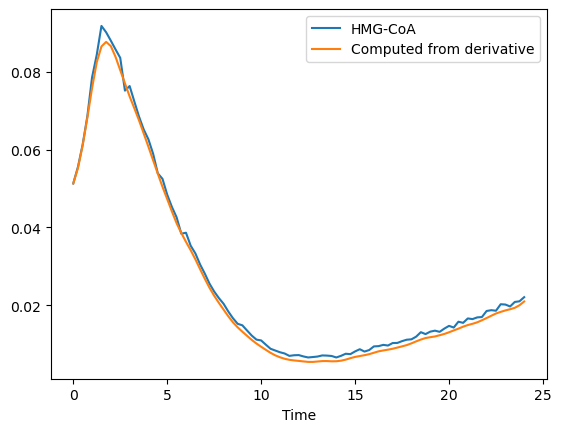

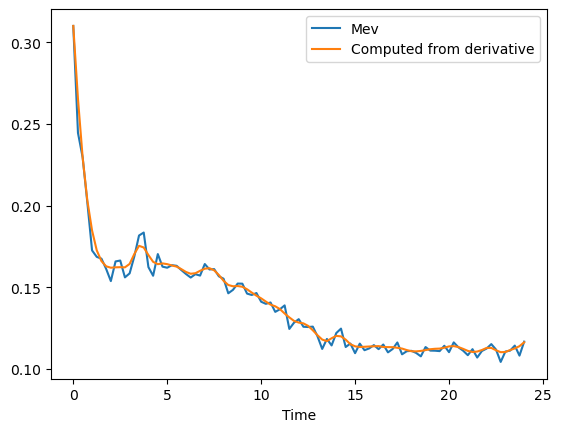

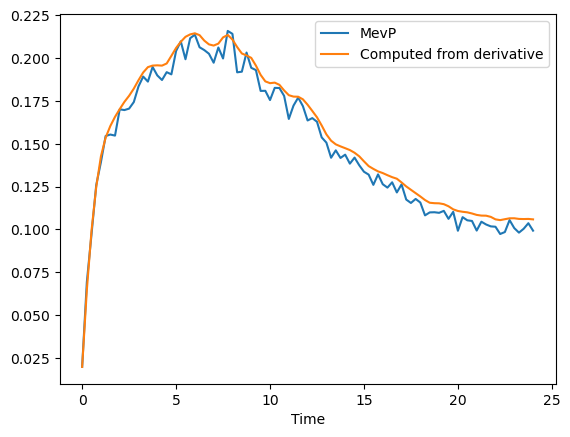

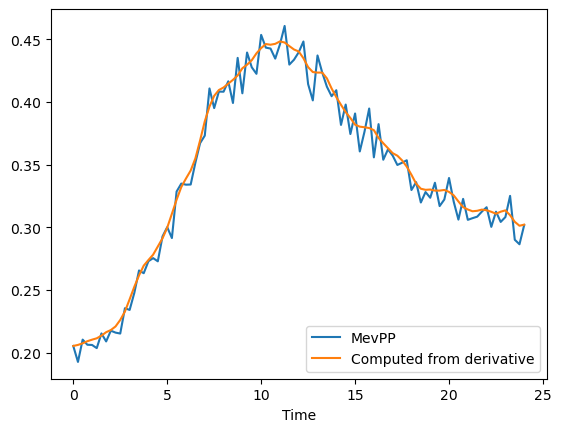

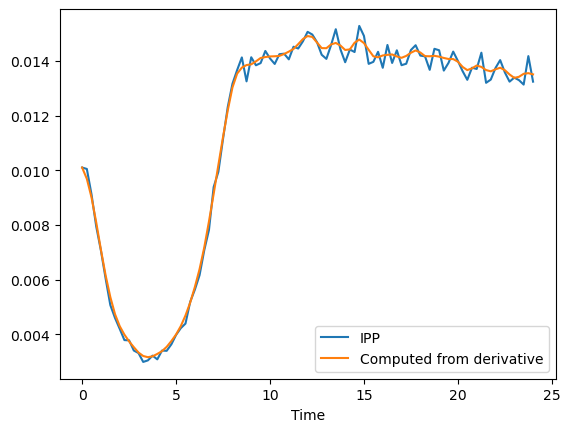

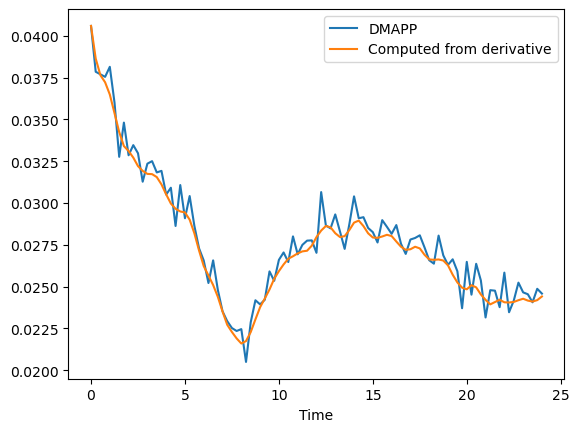

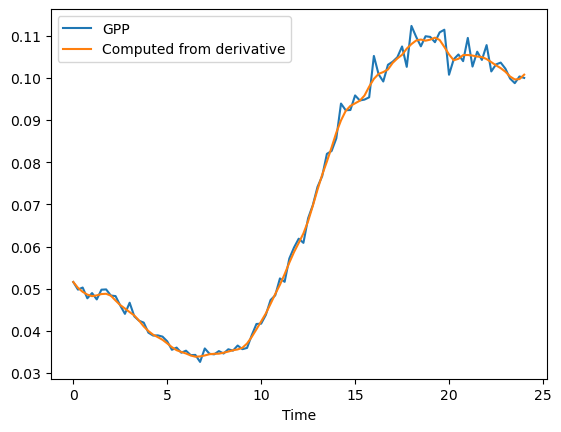

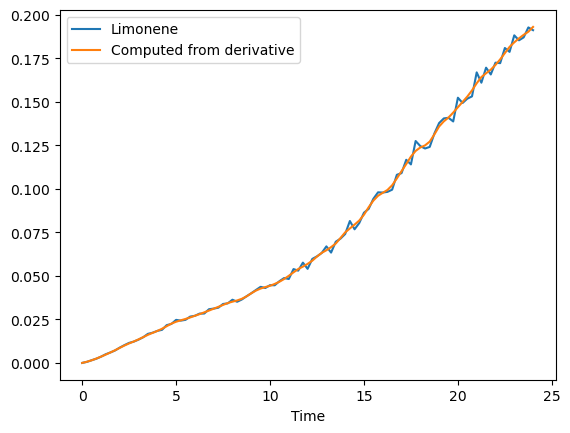

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.975196e+01  3.983424e+01  3.794074e+01  5.956960e+01   
         0.25   4.701158e+06  2.310954e+06  2.119978e+05  1.441237e+06   
         0.50   5.502124e+06  3.575914e+06  3.366702e+05  2.170702e+06   
         0.75   5.623466e+06  4.247346e+06  4.275388e+05  2.825850e+06   
         1.00   5.955090e+06  4.539072e+06  4.585594e+05  2.920864e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.689569e+06  2.630148e+06  1.757743e+06  1.904057e+06   
         23.25  2.733544e+06  2.618057e+06  1.711420e+06  2.009699e+06   
         23.50  2.734135e+06  2.467534e+06  1.824467e+06  2.078923e+06   
         23.75  2.680720e+06  2.813879e+06  1.748044e+06  1.955688e+06   
         24.00  2.711076e+06  2.661960e+06  1.713837e+06  1.994255e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.638142e+01  5.593531e+01  5.601897e+01  1.896372e+01   
         0.25   4.608750e+05  2.322661e+06  2.503681e+06  4.352779e+05   
         0.50   7.231798e+05  3.919590e+06  3.198510e+06  6.714010e+05   
         0.75   9.394797e+05  4.754849e+06  3.623287e+06  8.029395e+05   
         1.00   9.578282e+05  5.359746e+06  3.869362e+06  7.990530e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.460535e+06  3.983613e+06  4.334639e+06  1.261007e+06   
         23.25  1.508445e+06  4.058411e+06  4.235609e+06  1.171376e+06   
         23.50  1.523110e+06  4.035833e+06  4.267526e+06  1.241947e+06   
         23.75  1.469273e+06  4.064084e+06  4.274867e+06  1.211990e+06   
         24.00  1.520002e+06  4.038968e+06  4.343808e+06  1.300751e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.131118e+01   0.301424        0.200524  0.051314   
         0.25       1.742035e+05   0.299408        0.190985  0.058277   
         0.50       2.830033e+05   0.297438        0.184590  0.067947   
         0.75       3.603272e+05   0.304250        0.193897  0.079336   
         1.00       4.121310e+05   0.280318        0.169336  0.092565   
...                          ...        ...             ...       ...   
WT       23.00      1.472488e+06   0.782637        0.013612  0.020194   
         23.25      1.428807e+06   0.730114        0.015073  0.019702   
         23.50      1.473668e+06   0.807687        0.014126  0.020858   
         23.75      1.408105e+06   0.771875        0.014278  0.021028   
         24.00      1.412659e+06   0.799248        0.015356  0.022089   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.310136  0.019836  0.205338  0.010099  0.040591  0.051599   
         0.25   0.243627  0.070315  0.192610  0.010051  0.037849  0.049991   
         0.50   0.228141  0.098678  0.210385  0.009133  0.037694  0.050805   
         0.75   0.200724  0.127477  0.206264  0.008000  0.037534  0.048578   
         1.00   0.173153  0.141149  0.206056  0.007187  0.038110  0.050238   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.110700  0.100811  0.308112  0.013389  0.024654  0.102204   
         23.25  0.111253  0.098169  0.325012  0.013297  0.024542  0.099855   
         23.50  0.114335  0.100407  0.290028  0.013134  0.024060 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.025109       -0.007394  0.025137 -0.202111  0.203547   
         0.25     0.005080       -0.015590  0.033281 -0.164429  0.161731   
         0.50    -0.014948       -0.023785  0.041424 -0.126748  0.119915   
         0.75    -0.018416       -0.024143  0.041067 -0.077758  0.086655   
         1.00    -0.031113       -0.023019  0.032284 -0.048345  0.061365   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.008239        0.001037  0.001574  0.004695 -0.001414   
         23.25    0.005257        0.001001  0.000873  0.004542 -0.001629   
         23.50    0.029992        0.001078  0.002047  0.003628  0.001000   
         23.75    0.056511        0.001267  0.003258  0.007514 -0.000365   
         24.00    0.083030        0.001457  0.004469  0.011400 -0.001731   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.002443 -0.001154 -0.009687 -0.005647  0.001533  
         0.25   0.004240 -0.002152 -0.005899 -0.003650  0.001956  
         0.50   0.006037 -0.003150 -0.002111 -0.001654  0.002380  
         0.75   0.006957 -0.003822 -0.001367 -0.000930  0.002888  
         1.00   0.002729 -0.003729 -0.004690  0.001152  0.003104  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.009597 -0.000334 -0.000355 -0.005070  0.007537  
         23.25 -0.021485  0.000647 -0.000532 -0.004013  0.010764  
         23.50 -0.020557  0.000234  0.000072 -0.001559  0.005337  
         23.75 -0.004485 -0.000041  0.000608  0.002271  0.009103  
         24.00  0.011588 -0.000316  0.001145  0.006101  0.012869  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'G3PCX'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: G3PCX

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       64 | 2.020641E+189 |  6.711196E+87
     2 |      128 | 7.940780E+183 |  1.718838E+26
     3 |      192 | 2.527223E+181 |  5.237096E+19
     4 |      256 | 3.230886E+180 |  3.687200E+13
     5 |      320 |  2.590336E+42 |  4.233113E+11
     6 |      384 |  3.657276E+24 |  1.432851E+11
     7 |      448 |  9.153601E+16 |  8.632327E+09
     8 |      512 |  8.978170E+16 |  1.163652E+09
     9 |      576 |  1.391836E+11 |  1.380354E+08
    10 |      640 |  6.254706E+09 |  1.315255E+07
    11 |      704 |  4.608043E+08 |  5.988212E+05
    12 |      768 |  6.199821E+07 |  3.091299E+04
    13 |      832 |  9.909583E+05 |  2.523260E+03
    14 |      896 |  9.447368E+04 |  5.240041E+01
    15 |      960 |  7.423782E+04 |  2.859249E+01
    16 |     1024 |  1.248513E+03 |  2.827582E+01
    17 |     1088 |  2.866533E+01 |  2.808314E+01
    18 |     1152 |  2.830339E+01 |  2.793852E+01
    19 |     1216 |  2.80

   162 |    10368 |  2.254153E+01 |  2.253925E+01
   163 |    10432 |  2.254020E+01 |  2.253760E+01
   164 |    10496 |  2.253853E+01 |  2.253529E+01
   165 |    10560 |  2.253661E+01 |  2.253401E+01
   166 |    10624 |  2.253486E+01 |  2.253302E+01
   167 |    10688 |  2.253372E+01 |  2.253067E+01
   168 |    10752 |  2.253157E+01 |  2.252906E+01
   169 |    10816 |  2.253010E+01 |  2.252720E+01
   170 |    10880 |  2.252742E+01 |  2.252380E+01
   171 |    10944 |  2.252527E+01 |  2.252270E+01
   172 |    11008 |  2.252355E+01 |  2.252107E+01
   173 |    11072 |  2.252162E+01 |  2.252003E+01
   174 |    11136 |  2.252007E+01 |  2.251843E+01
   175 |    11200 |  2.251868E+01 |  2.251724E+01
   176 |    11264 |  2.251748E+01 |  2.251650E+01
   177 |    11328 |  2.251667E+01 |  2.251572E+01
   178 |    11392 |  2.251580E+01 |  2.251476E+01
   179 |    11456 |  2.251484E+01 |  2.251348E+01
   180 |    11520 |  2.251364E+01 |  2.251160E+01
   181 |    11584 |  2.251224E+01 |  2.250955E+01


   326 |    20864 |  2.234574E+01 |  2.234200E+01
   327 |    20928 |  2.233596E+01 |  2.230731E+01
   328 |    20992 |  2.232350E+01 |  2.229799E+01
   329 |    21056 |  2.231433E+01 |  2.229734E+01
   330 |    21120 |  2.230321E+01 |  2.229603E+01
   331 |    21184 |  2.229909E+01 |  2.229416E+01
   332 |    21248 |  2.229584E+01 |  2.229295E+01
   333 |    21312 |  2.229389E+01 |  2.229206E+01
   334 |    21376 |  2.229215E+01 |  2.229037E+01
   335 |    21440 |  2.229041E+01 |  2.228784E+01
   336 |    21504 |  2.228840E+01 |  2.228675E+01
   337 |    21568 |  2.228754E+01 |  2.228599E+01
   338 |    21632 |  2.228649E+01 |  2.228547E+01
   339 |    21696 |  2.228574E+01 |  2.228504E+01
   340 |    21760 |  2.228502E+01 |  2.228443E+01
   341 |    21824 |  2.228448E+01 |  2.228394E+01
   342 |    21888 |  2.228387E+01 |  2.228299E+01
   343 |    21952 |  2.228321E+01 |  2.228250E+01
   344 |    22016 |  2.228251E+01 |  2.228142E+01
   345 |    22080 |  2.228125E+01 |  2.228010E+01


   490 |    31360 |  2.178908E+01 |  2.178387E+01
   491 |    31424 |  2.178513E+01 |  2.178095E+01
   492 |    31488 |  2.178115E+01 |  2.177831E+01
   493 |    31552 |  2.177904E+01 |  2.177700E+01
   494 |    31616 |  2.177753E+01 |  2.177635E+01
   495 |    31680 |  2.177564E+01 |  2.177297E+01
   496 |    31744 |  2.177337E+01 |  2.177096E+01
   497 |    31808 |  2.177061E+01 |  2.176685E+01
   498 |    31872 |  2.176644E+01 |  2.176284E+01
   499 |    31936 |  2.176348E+01 |  2.176103E+01
   500 |    32000 |  2.176134E+01 |  2.175942E+01
   501 |    32064 |  2.175950E+01 |  2.175768E+01
   502 |    32128 |  2.175784E+01 |  2.175550E+01
   503 |    32192 |  2.175607E+01 |  2.175401E+01
   504 |    32256 |  2.175492E+01 |  2.175261E+01
   505 |    32320 |  2.175351E+01 |  2.175148E+01
   506 |    32384 |  2.175186E+01 |  2.174936E+01
   507 |    32448 |  2.174988E+01 |  2.174782E+01
   508 |    32512 |  2.174855E+01 |  2.174695E+01
   509 |    32576 |  2.174733E+01 |  2.174587E+01


   654 |    41856 |  2.149287E+01 |  2.149190E+01
   655 |    41920 |  2.149209E+01 |  2.149127E+01
   656 |    41984 |  2.149135E+01 |  2.149027E+01
   657 |    42048 |  2.149052E+01 |  2.148960E+01
   658 |    42112 |  2.148978E+01 |  2.148909E+01
   659 |    42176 |  2.148928E+01 |  2.148830E+01
   660 |    42240 |  2.148855E+01 |  2.148783E+01
   661 |    42304 |  2.148771E+01 |  2.148694E+01
   662 |    42368 |  2.148675E+01 |  2.148500E+01
   663 |    42432 |  2.148511E+01 |  2.148306E+01
   664 |    42496 |  2.148343E+01 |  2.148175E+01
   665 |    42560 |  2.148151E+01 |  2.147874E+01
   666 |    42624 |  2.147901E+01 |  2.147523E+01
   667 |    42688 |  2.147626E+01 |  2.147314E+01
   668 |    42752 |  2.147301E+01 |  2.146950E+01
   669 |    42816 |  2.146972E+01 |  2.146662E+01
   670 |    42880 |  2.146678E+01 |  2.146447E+01
   671 |    42944 |  2.146422E+01 |  2.146147E+01
   672 |    43008 |  2.146182E+01 |  2.145944E+01
   673 |    43072 |  2.145963E+01 |  2.145751E+01


   818 |    52352 |  2.118893E+01 |  2.118715E+01
   819 |    52416 |  2.118731E+01 |  2.118599E+01
   820 |    52480 |  2.118626E+01 |  2.118514E+01
   821 |    52544 |  2.118548E+01 |  2.118415E+01
   822 |    52608 |  2.118437E+01 |  2.118316E+01
   823 |    52672 |  2.118346E+01 |  2.118254E+01
   824 |    52736 |  2.118255E+01 |  2.118175E+01
   825 |    52800 |  2.118179E+01 |  2.118097E+01
   826 |    52864 |  2.118093E+01 |  2.118007E+01
   827 |    52928 |  2.118005E+01 |  2.117889E+01
   828 |    52992 |  2.117902E+01 |  2.117800E+01
   829 |    53056 |  2.117787E+01 |  2.117657E+01
   830 |    53120 |  2.117677E+01 |  2.117538E+01
   831 |    53184 |  2.117558E+01 |  2.117451E+01
   832 |    53248 |  2.117448E+01 |  2.117351E+01
   833 |    53312 |  2.117371E+01 |  2.117298E+01
   834 |    53376 |  2.117314E+01 |  2.117252E+01
   835 |    53440 |  2.117269E+01 |  2.117215E+01
   836 |    53504 |  2.117217E+01 |  2.117158E+01
   837 |    53568 |  2.117171E+01 |  2.117108E+01


   982 |    62848 |  2.081200E+01 |  2.080387E+01
   983 |    62912 |  2.080656E+01 |  2.079820E+01
   984 |    62976 |  2.079936E+01 |  2.079349E+01
   985 |    63040 |  2.079500E+01 |  2.079042E+01
   986 |    63104 |  2.079130E+01 |  2.078397E+01
   987 |    63168 |  2.078716E+01 |  2.078006E+01
   988 |    63232 |  2.078244E+01 |  2.077668E+01
   989 |    63296 |  2.077737E+01 |  2.077159E+01
   990 |    63360 |  2.077319E+01 |  2.076913E+01
   991 |    63424 |  2.077037E+01 |  2.076694E+01
   992 |    63488 |  2.076791E+01 |  2.076585E+01
   993 |    63552 |  2.076641E+01 |  2.076440E+01
   994 |    63616 |  2.076432E+01 |  2.076228E+01
   995 |    63680 |  2.076248E+01 |  2.076030E+01
   996 |    63744 |  2.076083E+01 |  2.075939E+01
   997 |    63808 |  2.075967E+01 |  2.075759E+01
   998 |    63872 |  2.075728E+01 |  2.075422E+01
   999 |    63936 |  2.075486E+01 |  2.075255E+01
  1000 |    64000 |  2.075265E+01 |  2.075069E+01
  1001 |    64064 |  2.075079E+01 |  2.074839E+01


  1146 |    73344 |  2.047717E+01 |  2.047637E+01
  1147 |    73408 |  2.047646E+01 |  2.047555E+01
  1148 |    73472 |  2.047569E+01 |  2.047470E+01
  1149 |    73536 |  2.047471E+01 |  2.047363E+01
  1150 |    73600 |  2.047388E+01 |  2.047337E+01
  1151 |    73664 |  2.047344E+01 |  2.047296E+01
  1152 |    73728 |  2.047297E+01 |  2.047236E+01
  1153 |    73792 |  2.047231E+01 |  2.047163E+01
  1154 |    73856 |  2.047172E+01 |  2.047104E+01
  1155 |    73920 |  2.047098E+01 |  2.047008E+01
  1156 |    73984 |  2.047020E+01 |  2.046920E+01
  1157 |    74048 |  2.046922E+01 |  2.046800E+01
  1158 |    74112 |  2.046819E+01 |  2.046719E+01
  1159 |    74176 |  2.046725E+01 |  2.046560E+01
  1160 |    74240 |  2.046579E+01 |  2.046332E+01
  1161 |    74304 |  2.046343E+01 |  2.046029E+01
  1162 |    74368 |  2.046134E+01 |  2.045935E+01
  1163 |    74432 |  2.046000E+01 |  2.045844E+01
  1164 |    74496 |  2.045813E+01 |  2.045628E+01
  1165 |    74560 |  2.045678E+01 |  2.045479E+01


  1310 |    83840 |  2.008672E+01 |  2.008611E+01
  1311 |    83904 |  2.008600E+01 |  2.008498E+01
  1312 |    83968 |  2.008468E+01 |  2.008271E+01
  1313 |    84032 |  2.008267E+01 |  2.008044E+01
  1314 |    84096 |  2.008058E+01 |  2.007871E+01
  1315 |    84160 |  2.007883E+01 |  2.007695E+01
  1316 |    84224 |  2.007649E+01 |  2.007395E+01
  1317 |    84288 |  2.007430E+01 |  2.007242E+01
  1318 |    84352 |  2.007207E+01 |  2.006904E+01
  1319 |    84416 |  2.006983E+01 |  2.006784E+01
  1320 |    84480 |  2.006750E+01 |  2.006514E+01
  1321 |    84544 |  2.006504E+01 |  2.006271E+01
  1322 |    84608 |  2.006254E+01 |  2.005952E+01
  1323 |    84672 |  2.006003E+01 |  2.005627E+01
  1324 |    84736 |  2.005759E+01 |  2.005560E+01
  1325 |    84800 |  2.005594E+01 |  2.005405E+01
  1326 |    84864 |  2.005459E+01 |  2.005296E+01
  1327 |    84928 |  2.005348E+01 |  2.005159E+01
  1328 |    84992 |  2.005173E+01 |  2.004954E+01
  1329 |    85056 |  2.005036E+01 |  2.004835E+01


  1474 |    94336 |  1.971561E+01 |  1.971470E+01
  1475 |    94400 |  1.971462E+01 |  1.971364E+01
  1476 |    94464 |  1.971352E+01 |  1.971191E+01
  1477 |    94528 |  1.971165E+01 |  1.970832E+01
  1478 |    94592 |  1.970914E+01 |  1.970648E+01
  1479 |    94656 |  1.970682E+01 |  1.970347E+01
  1480 |    94720 |  1.970387E+01 |  1.969972E+01
  1481 |    94784 |  1.969970E+01 |  1.969592E+01
  1482 |    94848 |  1.969641E+01 |  1.969286E+01
  1483 |    94912 |  1.969332E+01 |  1.968945E+01
  1484 |    94976 |  1.968973E+01 |  1.968542E+01
  1485 |    95040 |  1.968658E+01 |  1.968236E+01
  1486 |    95104 |  1.968270E+01 |  1.967817E+01
  1487 |    95168 |  1.967919E+01 |  1.967648E+01
  1488 |    95232 |  1.967720E+01 |  1.967421E+01
  1489 |    95296 |  1.967466E+01 |  1.967153E+01
  1490 |    95360 |  1.967219E+01 |  1.966863E+01
  1491 |    95424 |  1.966957E+01 |  1.966558E+01
  1492 |    95488 |  1.966570E+01 |  1.966271E+01
  1493 |    95552 |  1.966325E+01 |  1.966025E+01


  1638 |   104832 |  1.914059E+01 |  1.913844E+01
  1639 |   104896 |  1.913859E+01 |  1.913704E+01
  1640 |   104960 |  1.913695E+01 |  1.913493E+01
  1641 |   105024 |  1.913508E+01 |  1.913329E+01
  1642 |   105088 |  1.913353E+01 |  1.913162E+01
  1643 |   105152 |  1.913193E+01 |  1.913011E+01
  1644 |   105216 |  1.912971E+01 |  1.912662E+01
  1645 |   105280 |  1.912667E+01 |  1.912300E+01
  1646 |   105344 |  1.912312E+01 |  1.911905E+01
  1647 |   105408 |  1.911892E+01 |  1.911177E+01
  1648 |   105472 |  1.911225E+01 |  1.910325E+01
  1649 |   105536 |  1.910513E+01 |  1.909761E+01
  1650 |   105600 |  1.909910E+01 |  1.909447E+01
  1651 |   105664 |  1.909410E+01 |  1.908909E+01
  1652 |   105728 |  1.908959E+01 |  1.908455E+01
  1653 |   105792 |  1.908305E+01 |  1.907444E+01
  1654 |   105856 |  1.907600E+01 |  1.906837E+01
  1655 |   105920 |  1.907016E+01 |  1.906416E+01
  1656 |   105984 |  1.906682E+01 |  1.906139E+01
  1657 |   106048 |  1.906150E+01 |  1.905613E+01


  1802 |   115328 |  1.856656E+01 |  1.855579E+01
  1803 |   115392 |  1.855618E+01 |  1.854260E+01
  1804 |   115456 |  1.854550E+01 |  1.853318E+01
  1805 |   115520 |  1.853651E+01 |  1.852616E+01
  1806 |   115584 |  1.852848E+01 |  1.851926E+01
  1807 |   115648 |  1.852162E+01 |  1.851657E+01
  1808 |   115712 |  1.851477E+01 |  1.850207E+01
  1809 |   115776 |  1.850296E+01 |  1.848766E+01
  1810 |   115840 |  1.849099E+01 |  1.847687E+01
  1811 |   115904 |  1.847707E+01 |  1.845792E+01
  1812 |   115968 |  1.846020E+01 |  1.844076E+01
  1813 |   116032 |  1.844056E+01 |  1.841861E+01
  1814 |   116096 |  1.842326E+01 |  1.840352E+01
  1815 |   116160 |  1.840911E+01 |  1.839051E+01
  1816 |   116224 |  1.839448E+01 |  1.837495E+01
  1817 |   116288 |  1.838093E+01 |  1.836246E+01
  1818 |   116352 |  1.836544E+01 |  1.834879E+01
  1819 |   116416 |  1.835404E+01 |  1.834214E+01
  1820 |   116480 |  1.834514E+01 |  1.833709E+01
  1821 |   116544 |  1.833893E+01 |  1.833315E+01


  1966 |   125824 |  1.780719E+01 |  1.780676E+01
  1967 |   125888 |  1.780669E+01 |  1.780614E+01
  1968 |   125952 |  1.780622E+01 |  1.780569E+01
  1969 |   126016 |  1.780565E+01 |  1.780501E+01
  1970 |   126080 |  1.780506E+01 |  1.780422E+01
  1971 |   126144 |  1.780439E+01 |  1.780351E+01
  1972 |   126208 |  1.780371E+01 |  1.780278E+01
  1973 |   126272 |  1.780294E+01 |  1.780227E+01
  1974 |   126336 |  1.780238E+01 |  1.780151E+01
  1975 |   126400 |  1.780151E+01 |  1.780066E+01
  1976 |   126464 |  1.780061E+01 |  1.779921E+01
  1977 |   126528 |  1.779951E+01 |  1.779831E+01
  1978 |   126592 |  1.779844E+01 |  1.779730E+01
  1979 |   126656 |  1.779750E+01 |  1.779637E+01
  1980 |   126720 |  1.779649E+01 |  1.779550E+01
  1981 |   126784 |  1.779545E+01 |  1.779387E+01
  1982 |   126848 |  1.779375E+01 |  1.779202E+01
  1983 |   126912 |  1.779200E+01 |  1.779040E+01
  1984 |   126976 |  1.779097E+01 |  1.778961E+01
  1985 |   127040 |  1.778999E+01 |  1.778864E+01


  2130 |   136320 |  1.766814E+01 |  1.766692E+01
  2131 |   136384 |  1.766678E+01 |  1.766537E+01
  2132 |   136448 |  1.766506E+01 |  1.766376E+01
  2133 |   136512 |  1.766411E+01 |  1.766273E+01
  2134 |   136576 |  1.766259E+01 |  1.766088E+01
  2135 |   136640 |  1.766124E+01 |  1.765909E+01
  2136 |   136704 |  1.765925E+01 |  1.765716E+01
  2137 |   136768 |  1.765747E+01 |  1.765527E+01
  2138 |   136832 |  1.765580E+01 |  1.765378E+01
  2139 |   136896 |  1.765366E+01 |  1.765161E+01
  2140 |   136960 |  1.765199E+01 |  1.764938E+01
  2141 |   137024 |  1.764994E+01 |  1.764707E+01
  2142 |   137088 |  1.764795E+01 |  1.764556E+01
  2143 |   137152 |  1.764602E+01 |  1.764431E+01
  2144 |   137216 |  1.764449E+01 |  1.764326E+01
  2145 |   137280 |  1.764353E+01 |  1.764228E+01
  2146 |   137344 |  1.764248E+01 |  1.764089E+01
  2147 |   137408 |  1.764117E+01 |  1.764004E+01
  2148 |   137472 |  1.764001E+01 |  1.763868E+01
  2149 |   137536 |  1.763899E+01 |  1.763831E+01


  2294 |   146816 |  1.746709E+01 |  1.746493E+01
  2295 |   146880 |  1.746506E+01 |  1.746293E+01
  2296 |   146944 |  1.746299E+01 |  1.746001E+01
  2297 |   147008 |  1.746056E+01 |  1.745824E+01
  2298 |   147072 |  1.745859E+01 |  1.745607E+01
  2299 |   147136 |  1.745646E+01 |  1.745452E+01
  2300 |   147200 |  1.745448E+01 |  1.745197E+01
  2301 |   147264 |  1.745274E+01 |  1.745062E+01
  2302 |   147328 |  1.745135E+01 |  1.744953E+01
  2303 |   147392 |  1.745004E+01 |  1.744908E+01
  2304 |   147456 |  1.744914E+01 |  1.744785E+01
  2305 |   147520 |  1.744808E+01 |  1.744692E+01
  2306 |   147584 |  1.744719E+01 |  1.744595E+01
  2307 |   147648 |  1.744595E+01 |  1.744492E+01
  2308 |   147712 |  1.744490E+01 |  1.744352E+01
  2309 |   147776 |  1.744373E+01 |  1.744240E+01
  2310 |   147840 |  1.744253E+01 |  1.744106E+01
  2311 |   147904 |  1.744093E+01 |  1.743992E+01
  2312 |   147968 |  1.743968E+01 |  1.743845E+01
  2313 |   148032 |  1.743872E+01 |  1.743794E+01


  2458 |   157312 |  1.701070E+01 |  1.700882E+01
  2459 |   157376 |  1.700899E+01 |  1.700637E+01
  2460 |   157440 |  1.700714E+01 |  1.700510E+01
  2461 |   157504 |  1.700565E+01 |  1.700211E+01
  2462 |   157568 |  1.700424E+01 |  1.700134E+01
  2463 |   157632 |  1.700248E+01 |  1.700064E+01
  2464 |   157696 |  1.700129E+01 |  1.699962E+01
  2465 |   157760 |  1.699983E+01 |  1.699876E+01
  2466 |   157824 |  1.699913E+01 |  1.699821E+01
  2467 |   157888 |  1.699808E+01 |  1.699678E+01
  2468 |   157952 |  1.699664E+01 |  1.699520E+01
  2469 |   158016 |  1.699531E+01 |  1.699364E+01
  2470 |   158080 |  1.699404E+01 |  1.699247E+01
  2471 |   158144 |  1.699273E+01 |  1.699119E+01
  2472 |   158208 |  1.699116E+01 |  1.698915E+01
  2473 |   158272 |  1.698960E+01 |  1.698734E+01
  2474 |   158336 |  1.698810E+01 |  1.698606E+01
  2475 |   158400 |  1.698645E+01 |  1.698475E+01
  2476 |   158464 |  1.698469E+01 |  1.698275E+01
  2477 |   158528 |  1.698287E+01 |  1.698020E+01


  2622 |   167808 |  1.677689E+01 |  1.677651E+01
  2623 |   167872 |  1.677655E+01 |  1.677610E+01
  2624 |   167936 |  1.677614E+01 |  1.677584E+01
  2625 |   168000 |  1.677586E+01 |  1.677558E+01
  2626 |   168064 |  1.677557E+01 |  1.677515E+01
  2627 |   168128 |  1.677521E+01 |  1.677476E+01
  2628 |   168192 |  1.677465E+01 |  1.677361E+01
  2629 |   168256 |  1.677360E+01 |  1.677269E+01
  2630 |   168320 |  1.677292E+01 |  1.677219E+01
  2631 |   168384 |  1.677237E+01 |  1.677167E+01
  2632 |   168448 |  1.677161E+01 |  1.677068E+01
  2633 |   168512 |  1.677077E+01 |  1.676995E+01
  2634 |   168576 |  1.676994E+01 |  1.676894E+01
  2635 |   168640 |  1.676898E+01 |  1.676808E+01
  2636 |   168704 |  1.676830E+01 |  1.676727E+01
  2637 |   168768 |  1.676734E+01 |  1.676650E+01
  2638 |   168832 |  1.676660E+01 |  1.676591E+01
  2639 |   168896 |  1.676578E+01 |  1.676493E+01
  2640 |   168960 |  1.676510E+01 |  1.676413E+01
  2641 |   169024 |  1.676455E+01 |  1.676372E+01


  2786 |   178304 |  1.660929E+01 |  1.660824E+01
  2787 |   178368 |  1.660842E+01 |  1.660723E+01
  2788 |   178432 |  1.660734E+01 |  1.660633E+01
  2789 |   178496 |  1.660610E+01 |  1.660471E+01
  2790 |   178560 |  1.660500E+01 |  1.660402E+01
  2791 |   178624 |  1.660423E+01 |  1.660351E+01
  2792 |   178688 |  1.660362E+01 |  1.660291E+01
  2793 |   178752 |  1.660295E+01 |  1.660228E+01
  2794 |   178816 |  1.660236E+01 |  1.660145E+01
  2795 |   178880 |  1.660153E+01 |  1.660093E+01
  2796 |   178944 |  1.660089E+01 |  1.660011E+01
  2797 |   179008 |  1.660017E+01 |  1.659950E+01
  2798 |   179072 |  1.659955E+01 |  1.659880E+01
  2799 |   179136 |  1.659844E+01 |  1.659672E+01
  2800 |   179200 |  1.659661E+01 |  1.659459E+01
  2801 |   179264 |  1.659510E+01 |  1.659357E+01
  2802 |   179328 |  1.659350E+01 |  1.659148E+01
  2803 |   179392 |  1.659158E+01 |  1.658998E+01
  2804 |   179456 |  1.658994E+01 |  1.658788E+01
  2805 |   179520 |  1.658775E+01 |  1.658485E+01


  2950 |   188800 |  1.639323E+01 |  1.639185E+01
  2951 |   188864 |  1.639208E+01 |  1.639100E+01
  2952 |   188928 |  1.639138E+01 |  1.638997E+01
  2953 |   188992 |  1.639029E+01 |  1.638889E+01
  2954 |   189056 |  1.638915E+01 |  1.638792E+01
  2955 |   189120 |  1.638775E+01 |  1.638663E+01
  2956 |   189184 |  1.638683E+01 |  1.638567E+01
  2957 |   189248 |  1.638576E+01 |  1.638465E+01
  2958 |   189312 |  1.638455E+01 |  1.638259E+01
  2959 |   189376 |  1.638267E+01 |  1.638069E+01
  2960 |   189440 |  1.638049E+01 |  1.637780E+01
  2961 |   189504 |  1.637816E+01 |  1.637563E+01
  2962 |   189568 |  1.637560E+01 |  1.637260E+01
  2963 |   189632 |  1.637266E+01 |  1.636891E+01
  2964 |   189696 |  1.636960E+01 |  1.636628E+01
  2965 |   189760 |  1.636702E+01 |  1.636413E+01
  2966 |   189824 |  1.636517E+01 |  1.636275E+01
  2967 |   189888 |  1.636339E+01 |  1.636131E+01
  2968 |   189952 |  1.636220E+01 |  1.636065E+01
  2969 |   190016 |  1.636028E+01 |  1.634774E+01


  3114 |   199296 |  1.592845E+01 |  1.592606E+01
  3115 |   199360 |  1.592669E+01 |  1.592561E+01
  3116 |   199424 |  1.592598E+01 |  1.592426E+01
  3117 |   199488 |  1.592452E+01 |  1.592266E+01
  3118 |   199552 |  1.592320E+01 |  1.592163E+01
  3119 |   199616 |  1.592178E+01 |  1.591958E+01
  3120 |   199680 |  1.591984E+01 |  1.591785E+01
  3121 |   199744 |  1.591829E+01 |  1.591674E+01
  3122 |   199808 |  1.591688E+01 |  1.591530E+01
  3123 |   199872 |  1.591541E+01 |  1.591418E+01
  3124 |   199936 |  1.591416E+01 |  1.591270E+01
  3125 |   200000 |  1.591314E+01 |  1.591162E+01
  3126 |   200064 |  1.591193E+01 |  1.591030E+01
  3127 |   200128 |  1.591063E+01 |  1.590949E+01
  3128 |   200192 |  1.590952E+01 |  1.590859E+01
  3129 |   200256 |  1.590823E+01 |  1.590651E+01
  3130 |   200320 |  1.590650E+01 |  1.590480E+01
  3131 |   200384 |  1.590469E+01 |  1.590272E+01
  3132 |   200448 |  1.590231E+01 |  1.590006E+01
  3133 |   200512 |  1.590041E+01 |  1.589863E+01


  3278 |   209792 |  1.537919E+01 |  1.537746E+01
  3279 |   209856 |  1.537766E+01 |  1.537616E+01
  3280 |   209920 |  1.537610E+01 |  1.537458E+01
  3281 |   209984 |  1.537470E+01 |  1.537347E+01
  3282 |   210048 |  1.537281E+01 |  1.537061E+01
  3283 |   210112 |  1.537072E+01 |  1.536825E+01
  3284 |   210176 |  1.536852E+01 |  1.536531E+01
  3285 |   210240 |  1.536499E+01 |  1.536216E+01
  3286 |   210304 |  1.536278E+01 |  1.535949E+01
  3287 |   210368 |  1.536039E+01 |  1.535762E+01
  3288 |   210432 |  1.535817E+01 |  1.535567E+01
  3289 |   210496 |  1.535619E+01 |  1.535438E+01
  3290 |   210560 |  1.535421E+01 |  1.535231E+01
  3291 |   210624 |  1.535271E+01 |  1.535063E+01
  3292 |   210688 |  1.535038E+01 |  1.534778E+01
  3293 |   210752 |  1.534792E+01 |  1.534547E+01
  3294 |   210816 |  1.534635E+01 |  1.534403E+01
  3295 |   210880 |  1.534356E+01 |  1.533920E+01
  3296 |   210944 |  1.534024E+01 |  1.533637E+01
  3297 |   211008 |  1.533684E+01 |  1.533088E+01


  3442 |   220288 |  1.244012E+01 |  1.243829E+01
  3443 |   220352 |  1.243871E+01 |  1.243670E+01
  3444 |   220416 |  1.243670E+01 |  1.243449E+01
  3445 |   220480 |  1.243493E+01 |  1.243215E+01
  3446 |   220544 |  1.243212E+01 |  1.242925E+01
  3447 |   220608 |  1.242987E+01 |  1.242713E+01
  3448 |   220672 |  1.242776E+01 |  1.242517E+01
  3449 |   220736 |  1.242483E+01 |  1.242056E+01
  3450 |   220800 |  1.242182E+01 |  1.241816E+01
  3451 |   220864 |  1.241812E+01 |  1.241487E+01
  3452 |   220928 |  1.241508E+01 |  1.241169E+01
  3453 |   220992 |  1.241272E+01 |  1.240930E+01
  3454 |   221056 |  1.240880E+01 |  1.240464E+01
  3455 |   221120 |  1.240561E+01 |  1.240197E+01
  3456 |   221184 |  1.240303E+01 |  1.239879E+01
  3457 |   221248 |  1.239948E+01 |  1.239364E+01
  3458 |   221312 |  1.239585E+01 |  1.239152E+01
  3459 |   221376 |  1.239275E+01 |  1.238972E+01
  3460 |   221440 |  1.238966E+01 |  1.238648E+01
  3461 |   221504 |  1.238715E+01 |  1.238374E+01


  3606 |   230784 |  1.224645E+01 |  1.224524E+01
  3607 |   230848 |  1.224564E+01 |  1.224472E+01
  3608 |   230912 |  1.224513E+01 |  1.224416E+01
  3609 |   230976 |  1.224452E+01 |  1.224374E+01
  3610 |   231040 |  1.224405E+01 |  1.224341E+01
  3611 |   231104 |  1.224353E+01 |  1.224288E+01
  3612 |   231168 |  1.224295E+01 |  1.224231E+01
  3613 |   231232 |  1.224233E+01 |  1.224175E+01
  3614 |   231296 |  1.224196E+01 |  1.224150E+01
  3615 |   231360 |  1.224160E+01 |  1.224123E+01
  3616 |   231424 |  1.224134E+01 |  1.224098E+01
  3617 |   231488 |  1.224094E+01 |  1.224043E+01
  3618 |   231552 |  1.224042E+01 |  1.223987E+01
  3619 |   231616 |  1.223998E+01 |  1.223952E+01
  3620 |   231680 |  1.223961E+01 |  1.223916E+01
  3621 |   231744 |  1.223905E+01 |  1.223828E+01
  3622 |   231808 |  1.223837E+01 |  1.223743E+01
  3623 |   231872 |  1.223770E+01 |  1.223694E+01
  3624 |   231936 |  1.223680E+01 |  1.223593E+01
  3625 |   232000 |  1.223555E+01 |  1.223370E+01


  3770 |   241280 |  1.212916E+01 |  1.212845E+01
  3771 |   241344 |  1.212822E+01 |  1.212700E+01
  3772 |   241408 |  1.212749E+01 |  1.212640E+01
  3773 |   241472 |  1.212675E+01 |  1.212617E+01
  3774 |   241536 |  1.212627E+01 |  1.212581E+01
  3775 |   241600 |  1.212598E+01 |  1.212563E+01
  3776 |   241664 |  1.212571E+01 |  1.212553E+01
  3777 |   241728 |  1.212557E+01 |  1.212538E+01
  3778 |   241792 |  1.212536E+01 |  1.212510E+01
  3779 |   241856 |  1.212515E+01 |  1.212499E+01
  3780 |   241920 |  1.212504E+01 |  1.212494E+01
  3781 |   241984 |  1.212493E+01 |  1.212476E+01
  3782 |   242048 |  1.212476E+01 |  1.212460E+01
  3783 |   242112 |  1.212461E+01 |  1.212440E+01
  3784 |   242176 |  1.212446E+01 |  1.212426E+01
  3785 |   242240 |  1.212429E+01 |  1.212411E+01
  3786 |   242304 |  1.212411E+01 |  1.212391E+01
  3787 |   242368 |  1.212395E+01 |  1.212374E+01
  3788 |   242432 |  1.212381E+01 |  1.212366E+01
  3789 |   242496 |  1.212369E+01 |  1.212355E+01


  3934 |   251776 |  1.207375E+01 |  1.207361E+01
  3935 |   251840 |  1.207362E+01 |  1.207349E+01
  3936 |   251904 |  1.207352E+01 |  1.207341E+01
  3937 |   251968 |  1.207340E+01 |  1.207325E+01
  3938 |   252032 |  1.207326E+01 |  1.207310E+01
  3939 |   252096 |  1.207310E+01 |  1.207293E+01
  3940 |   252160 |  1.207299E+01 |  1.207287E+01
  3941 |   252224 |  1.207289E+01 |  1.207279E+01
  3942 |   252288 |  1.207276E+01 |  1.207256E+01
  3943 |   252352 |  1.207258E+01 |  1.207243E+01
  3944 |   252416 |  1.207244E+01 |  1.207222E+01
  3945 |   252480 |  1.207226E+01 |  1.207199E+01
  3946 |   252544 |  1.207202E+01 |  1.207177E+01
  3947 |   252608 |  1.207183E+01 |  1.207161E+01
  3948 |   252672 |  1.207166E+01 |  1.207154E+01
  3949 |   252736 |  1.207157E+01 |  1.207147E+01
  3950 |   252800 |  1.207148E+01 |  1.207135E+01
  3951 |   252864 |  1.207133E+01 |  1.207121E+01
  3952 |   252928 |  1.207122E+01 |  1.207109E+01
  3953 |   252992 |  1.207111E+01 |  1.207096E+01


  4098 |   262272 |  1.201008E+01 |  1.201004E+01
  4099 |   262336 |  1.201004E+01 |  1.201002E+01
  4100 |   262400 |  1.201002E+01 |  1.201000E+01
  4101 |   262464 |  1.201000E+01 |  1.200998E+01
  4102 |   262528 |  1.200999E+01 |  1.200997E+01
  4103 |   262592 |  1.200997E+01 |  1.200995E+01
  4104 |   262656 |  1.200996E+01 |  1.200994E+01
  4105 |   262720 |  1.200995E+01 |  1.200993E+01
  4106 |   262784 |  1.200993E+01 |  1.200991E+01
  4107 |   262848 |  1.200992E+01 |  1.200990E+01
  4108 |   262912 |  1.200990E+01 |  1.200988E+01
  4109 |   262976 |  1.200988E+01 |  1.200984E+01
  4110 |   263040 |  1.200985E+01 |  1.200982E+01
  4111 |   263104 |  1.200983E+01 |  1.200979E+01
  4112 |   263168 |  1.200980E+01 |  1.200978E+01
  4113 |   263232 |  1.200979E+01 |  1.200977E+01
  4114 |   263296 |  1.200978E+01 |  1.200977E+01
  4115 |   263360 |  1.200977E+01 |  1.200977E+01
  4116 |   263424 |  1.200977E+01 |  1.200976E+01
  4117 |   263488 |  1.200976E+01 |  1.200976E+01


  4262 |   272768 |  1.199072E+01 |  1.199067E+01
  4263 |   272832 |  1.199067E+01 |  1.199060E+01
  4264 |   272896 |  1.199060E+01 |  1.199052E+01
  4265 |   272960 |  1.199052E+01 |  1.199043E+01
  4266 |   273024 |  1.199040E+01 |  1.199025E+01
  4267 |   273088 |  1.199030E+01 |  1.199020E+01
  4268 |   273152 |  1.199022E+01 |  1.199015E+01
  4269 |   273216 |  1.199017E+01 |  1.199010E+01
  4270 |   273280 |  1.199010E+01 |  1.199002E+01
  4271 |   273344 |  1.199002E+01 |  1.198994E+01
  4272 |   273408 |  1.198996E+01 |  1.198988E+01
  4273 |   273472 |  1.198990E+01 |  1.198987E+01
  4274 |   273536 |  1.198988E+01 |  1.198984E+01
  4275 |   273600 |  1.198985E+01 |  1.198981E+01
  4276 |   273664 |  1.198981E+01 |  1.198976E+01
  4277 |   273728 |  1.198978E+01 |  1.198974E+01
  4278 |   273792 |  1.198975E+01 |  1.198971E+01
  4279 |   273856 |  1.198971E+01 |  1.198967E+01
  4280 |   273920 |  1.198967E+01 |  1.198961E+01
  4281 |   273984 |  1.198961E+01 |  1.198955E+01


  4426 |   283264 |  1.194204E+01 |  1.194162E+01
  4427 |   283328 |  1.194165E+01 |  1.194132E+01
  4428 |   283392 |  1.194136E+01 |  1.194103E+01
  4429 |   283456 |  1.194110E+01 |  1.194083E+01
  4430 |   283520 |  1.194089E+01 |  1.194075E+01
  4431 |   283584 |  1.194077E+01 |  1.194068E+01
  4432 |   283648 |  1.194070E+01 |  1.194062E+01
  4433 |   283712 |  1.194063E+01 |  1.194054E+01
  4434 |   283776 |  1.194055E+01 |  1.194049E+01
  4435 |   283840 |  1.194051E+01 |  1.194048E+01
  4436 |   283904 |  1.194048E+01 |  1.194043E+01
  4437 |   283968 |  1.194041E+01 |  1.194033E+01
  4438 |   284032 |  1.194034E+01 |  1.194028E+01
  4439 |   284096 |  1.194029E+01 |  1.194025E+01
  4440 |   284160 |  1.194026E+01 |  1.194022E+01
  4441 |   284224 |  1.194023E+01 |  1.194020E+01
  4442 |   284288 |  1.194021E+01 |  1.194018E+01
  4443 |   284352 |  1.194019E+01 |  1.194016E+01
  4444 |   284416 |  1.194017E+01 |  1.194015E+01
  4445 |   284480 |  1.194015E+01 |  1.194014E+01


  4590 |   293760 |  1.192533E+01 |  1.192521E+01
  4591 |   293824 |  1.192523E+01 |  1.192508E+01
  4592 |   293888 |  1.192511E+01 |  1.192495E+01
  4593 |   293952 |  1.192497E+01 |  1.192480E+01
  4594 |   294016 |  1.192479E+01 |  1.192456E+01
  4595 |   294080 |  1.192456E+01 |  1.192432E+01
  4596 |   294144 |  1.192437E+01 |  1.192415E+01
  4597 |   294208 |  1.192415E+01 |  1.192392E+01
  4598 |   294272 |  1.192382E+01 |  1.192338E+01
  4599 |   294336 |  1.192347E+01 |  1.192318E+01
  4600 |   294400 |  1.192322E+01 |  1.192296E+01
  4601 |   294464 |  1.192302E+01 |  1.192274E+01
  4602 |   294528 |  1.192281E+01 |  1.192254E+01
  4603 |   294592 |  1.192263E+01 |  1.192248E+01
  4604 |   294656 |  1.192253E+01 |  1.192240E+01
  4605 |   294720 |  1.192241E+01 |  1.192224E+01
  4606 |   294784 |  1.192226E+01 |  1.192211E+01
  4607 |   294848 |  1.192213E+01 |  1.192200E+01
  4608 |   294912 |  1.192203E+01 |  1.192195E+01
  4609 |   294976 |  1.192196E+01 |  1.192192E+01


  4754 |   304256 |  1.188811E+01 |  1.188807E+01
  4755 |   304320 |  1.188807E+01 |  1.188802E+01
  4756 |   304384 |  1.188803E+01 |  1.188799E+01
  4757 |   304448 |  1.188800E+01 |  1.188797E+01
  4758 |   304512 |  1.188798E+01 |  1.188792E+01
  4759 |   304576 |  1.188793E+01 |  1.188790E+01
  4760 |   304640 |  1.188789E+01 |  1.188784E+01
  4761 |   304704 |  1.188784E+01 |  1.188779E+01
  4762 |   304768 |  1.188779E+01 |  1.188771E+01
  4763 |   304832 |  1.188771E+01 |  1.188760E+01
  4764 |   304896 |  1.188760E+01 |  1.188747E+01
  4765 |   304960 |  1.188751E+01 |  1.188741E+01
  4766 |   305024 |  1.188743E+01 |  1.188736E+01
  4767 |   305088 |  1.188738E+01 |  1.188735E+01
  4768 |   305152 |  1.188735E+01 |  1.188732E+01
  4769 |   305216 |  1.188733E+01 |  1.188730E+01
  4770 |   305280 |  1.188731E+01 |  1.188729E+01
  4771 |   305344 |  1.188730E+01 |  1.188728E+01
  4772 |   305408 |  1.188728E+01 |  1.188727E+01
  4773 |   305472 |  1.188728E+01 |  1.188727E+01


  4918 |   314752 |  1.188632E+01 |  1.188632E+01
  4919 |   314816 |  1.188632E+01 |  1.188632E+01
  4920 |   314880 |  1.188632E+01 |  1.188632E+01
  4921 |   314944 |  1.188632E+01 |  1.188632E+01
  4922 |   315008 |  1.188632E+01 |  1.188632E+01
  4923 |   315072 |  1.188632E+01 |  1.188632E+01
  4924 |   315136 |  1.188632E+01 |  1.188632E+01
  4925 |   315200 |  1.188632E+01 |  1.188632E+01
  4926 |   315264 |  1.188632E+01 |  1.188632E+01
  4927 |   315328 |  1.188632E+01 |  1.188632E+01
  4928 |   315392 |  1.188632E+01 |  1.188632E+01
  4929 |   315456 |  1.188632E+01 |  1.188632E+01
  4930 |   315520 |  1.188632E+01 |  1.188632E+01
  4931 |   315584 |  1.188632E+01 |  1.188632E+01
  4932 |   315648 |  1.188632E+01 |  1.188632E+01
  4933 |   315712 |  1.188632E+01 |  1.188632E+01
  4934 |   315776 |  1.188632E+01 |  1.188632E+01
  4935 |   315840 |  1.188632E+01 |  1.188632E+01
  4936 |   315904 |  1.188632E+01 |  1.188632E+01
  4937 |   315968 |  1.188632E+01 |  1.188632E+01


  5082 |   325248 |  1.186467E+01 |  1.186457E+01
  5083 |   325312 |  1.186458E+01 |  1.186450E+01
  5084 |   325376 |  1.186452E+01 |  1.186443E+01
  5085 |   325440 |  1.186444E+01 |  1.186436E+01
  5086 |   325504 |  1.186438E+01 |  1.186431E+01
  5087 |   325568 |  1.186432E+01 |  1.186422E+01
  5088 |   325632 |  1.186421E+01 |  1.186413E+01
  5089 |   325696 |  1.186413E+01 |  1.186405E+01
  5090 |   325760 |  1.186405E+01 |  1.186397E+01
  5091 |   325824 |  1.186396E+01 |  1.186384E+01
  5092 |   325888 |  1.186386E+01 |  1.186375E+01
  5093 |   325952 |  1.186376E+01 |  1.186367E+01
  5094 |   326016 |  1.186366E+01 |  1.186358E+01
  5095 |   326080 |  1.186356E+01 |  1.186346E+01
  5096 |   326144 |  1.186346E+01 |  1.186334E+01
  5097 |   326208 |  1.186332E+01 |  1.186316E+01
  5098 |   326272 |  1.186318E+01 |  1.186297E+01
  5099 |   326336 |  1.186292E+01 |  1.186266E+01
  5100 |   326400 |  1.186263E+01 |  1.186221E+01
  5101 |   326464 |  1.186221E+01 |  1.186156E+01


  5246 |   335744 |  1.184063E+01 |  1.184063E+01
  5247 |   335808 |  1.184063E+01 |  1.184063E+01
  5248 |   335872 |  1.184063E+01 |  1.184063E+01
  5249 |   335936 |  1.184063E+01 |  1.184061E+01
  5250 |   336000 |  1.184062E+01 |  1.184061E+01
  5251 |   336064 |  1.184061E+01 |  1.184061E+01
  5252 |   336128 |  1.184061E+01 |  1.184061E+01
  5253 |   336192 |  1.184061E+01 |  1.184061E+01
  5254 |   336256 |  1.184061E+01 |  1.184061E+01
  5255 |   336320 |  1.184061E+01 |  1.184061E+01
  5256 |   336384 |  1.184061E+01 |  1.184061E+01
  5257 |   336448 |  1.184061E+01 |  1.184061E+01
  5258 |   336512 |  1.184061E+01 |  1.184061E+01
  5259 |   336576 |  1.184061E+01 |  1.184061E+01
  5260 |   336640 |  1.184061E+01 |  1.184061E+01
  5261 |   336704 |  1.184061E+01 |  1.184061E+01
  5262 |   336768 |  1.184061E+01 |  1.184060E+01
  5263 |   336832 |  1.184060E+01 |  1.184060E+01
  5264 |   336896 |  1.184060E+01 |  1.184060E+01
  5265 |   336960 |  1.184060E+01 |  1.184060E+01


  5410 |   346240 |  1.183882E+01 |  1.183878E+01
  5411 |   346304 |  1.183879E+01 |  1.183876E+01
  5412 |   346368 |  1.183877E+01 |  1.183876E+01
  5413 |   346432 |  1.183876E+01 |  1.183876E+01
  5414 |   346496 |  1.183876E+01 |  1.183875E+01
  5415 |   346560 |  1.183875E+01 |  1.183874E+01
  5416 |   346624 |  1.183874E+01 |  1.183874E+01
  5417 |   346688 |  1.183874E+01 |  1.183874E+01
  5418 |   346752 |  1.183874E+01 |  1.183873E+01
  5419 |   346816 |  1.183873E+01 |  1.183873E+01
  5420 |   346880 |  1.183873E+01 |  1.183873E+01
  5421 |   346944 |  1.183873E+01 |  1.183873E+01
  5422 |   347008 |  1.183873E+01 |  1.183872E+01
  5423 |   347072 |  1.183872E+01 |  1.183872E+01
  5424 |   347136 |  1.183872E+01 |  1.183871E+01
  5425 |   347200 |  1.183871E+01 |  1.183871E+01
  5426 |   347264 |  1.183871E+01 |  1.183871E+01
  5427 |   347328 |  1.183871E+01 |  1.183871E+01
  5428 |   347392 |  1.183871E+01 |  1.183870E+01
  5429 |   347456 |  1.183870E+01 |  1.183870E+01


  5574 |   356736 |  1.180436E+01 |  1.180414E+01
  5575 |   356800 |  1.180419E+01 |  1.180396E+01
  5576 |   356864 |  1.180398E+01 |  1.180380E+01
  5577 |   356928 |  1.180385E+01 |  1.180358E+01
  5578 |   356992 |  1.180363E+01 |  1.180332E+01
  5579 |   357056 |  1.180324E+01 |  1.180280E+01
  5580 |   357120 |  1.180289E+01 |  1.180259E+01
  5581 |   357184 |  1.180254E+01 |  1.180226E+01
  5582 |   357248 |  1.180231E+01 |  1.180209E+01
  5583 |   357312 |  1.180211E+01 |  1.180196E+01
  5584 |   357376 |  1.180199E+01 |  1.180188E+01
  5585 |   357440 |  1.180187E+01 |  1.180176E+01
  5586 |   357504 |  1.180175E+01 |  1.180156E+01
  5587 |   357568 |  1.180159E+01 |  1.180140E+01
  5588 |   357632 |  1.180142E+01 |  1.180110E+01
  5589 |   357696 |  1.180117E+01 |  1.180097E+01
  5590 |   357760 |  1.180099E+01 |  1.180083E+01
  5591 |   357824 |  1.180087E+01 |  1.180075E+01
  5592 |   357888 |  1.180079E+01 |  1.180067E+01
  5593 |   357952 |  1.180069E+01 |  1.180063E+01


  5738 |   367232 |  1.171962E+01 |  1.171956E+01
  5739 |   367296 |  1.171954E+01 |  1.171941E+01
  5740 |   367360 |  1.171943E+01 |  1.171932E+01
  5741 |   367424 |  1.171935E+01 |  1.171927E+01
  5742 |   367488 |  1.171928E+01 |  1.171920E+01
  5743 |   367552 |  1.171922E+01 |  1.171918E+01
  5744 |   367616 |  1.171918E+01 |  1.171911E+01
  5745 |   367680 |  1.171912E+01 |  1.171906E+01
  5746 |   367744 |  1.171907E+01 |  1.171898E+01
  5747 |   367808 |  1.171900E+01 |  1.171891E+01
  5748 |   367872 |  1.171891E+01 |  1.171880E+01
  5749 |   367936 |  1.171880E+01 |  1.171870E+01
  5750 |   368000 |  1.171873E+01 |  1.171861E+01
  5751 |   368064 |  1.171864E+01 |  1.171853E+01
  5752 |   368128 |  1.171854E+01 |  1.171843E+01
  5753 |   368192 |  1.171844E+01 |  1.171835E+01
  5754 |   368256 |  1.171835E+01 |  1.171824E+01
  5755 |   368320 |  1.171826E+01 |  1.171817E+01
  5756 |   368384 |  1.171818E+01 |  1.171809E+01
  5757 |   368448 |  1.171811E+01 |  1.171801E+01


  5902 |   377728 |  1.169992E+01 |  1.169972E+01
  5903 |   377792 |  1.169967E+01 |  1.169936E+01
  5904 |   377856 |  1.169941E+01 |  1.169911E+01
  5905 |   377920 |  1.169915E+01 |  1.169895E+01
  5906 |   377984 |  1.169893E+01 |  1.169868E+01
  5907 |   378048 |  1.169869E+01 |  1.169833E+01
  5908 |   378112 |  1.169842E+01 |  1.169815E+01
  5909 |   378176 |  1.169817E+01 |  1.169778E+01
  5910 |   378240 |  1.169772E+01 |  1.169719E+01
  5911 |   378304 |  1.169736E+01 |  1.169698E+01
  5912 |   378368 |  1.169705E+01 |  1.169664E+01
  5913 |   378432 |  1.169672E+01 |  1.169648E+01
  5914 |   378496 |  1.169648E+01 |  1.169617E+01
  5915 |   378560 |  1.169618E+01 |  1.169576E+01
  5916 |   378624 |  1.169584E+01 |  1.169547E+01
  5917 |   378688 |  1.169551E+01 |  1.169511E+01
  5918 |   378752 |  1.169503E+01 |  1.169451E+01
  5919 |   378816 |  1.169454E+01 |  1.169396E+01
  5920 |   378880 |  1.169398E+01 |  1.169351E+01
  5921 |   378944 |  1.169364E+01 |  1.169305E+01


  6066 |   388224 |  1.161065E+01 |  1.161043E+01
  6067 |   388288 |  1.161041E+01 |  1.161009E+01
  6068 |   388352 |  1.161014E+01 |  1.160982E+01
  6069 |   388416 |  1.160978E+01 |  1.160946E+01
  6070 |   388480 |  1.160938E+01 |  1.160896E+01
  6071 |   388544 |  1.160905E+01 |  1.160872E+01
  6072 |   388608 |  1.160778E+01 |  1.160667E+01
  6073 |   388672 |  1.160697E+01 |  1.160608E+01
  6074 |   388736 |  1.160608E+01 |  1.160500E+01
  6075 |   388800 |  1.160508E+01 |  1.160407E+01
  6076 |   388864 |  1.160427E+01 |  1.160317E+01
  6077 |   388928 |  1.160328E+01 |  1.160200E+01
  6078 |   388992 |  1.160224E+01 |  1.160114E+01
  6079 |   389056 |  1.160134E+01 |  1.160042E+01
  6080 |   389120 |  1.160057E+01 |  1.159915E+01
  6081 |   389184 |  1.159955E+01 |  1.159857E+01
  6082 |   389248 |  1.159889E+01 |  1.159816E+01
  6083 |   389312 |  1.159826E+01 |  1.159768E+01
  6084 |   389376 |  1.159786E+01 |  1.159750E+01
  6085 |   389440 |  1.159759E+01 |  1.159733E+01


  6230 |   398720 |  1.154000E+01 |  1.153978E+01
  6231 |   398784 |  1.153981E+01 |  1.153964E+01
  6232 |   398848 |  1.153963E+01 |  1.153941E+01
  6233 |   398912 |  1.153940E+01 |  1.153916E+01
  6234 |   398976 |  1.153919E+01 |  1.153891E+01
  6235 |   399040 |  1.153897E+01 |  1.153875E+01
  6236 |   399104 |  1.153877E+01 |  1.153847E+01
  6237 |   399168 |  1.153849E+01 |  1.153811E+01
  6238 |   399232 |  1.153816E+01 |  1.153777E+01
  6239 |   399296 |  1.153783E+01 |  1.153756E+01
  6240 |   399360 |  1.153767E+01 |  1.153734E+01
  6241 |   399424 |  1.153732E+01 |  1.153690E+01
  6242 |   399488 |  1.153683E+01 |  1.153512E+01
  6243 |   399552 |  1.153508E+01 |  1.153340E+01
  6244 |   399616 |  1.153367E+01 |  1.153217E+01
  6245 |   399680 |  1.153252E+01 |  1.153169E+01
  6246 |   399744 |  1.153182E+01 |  1.153120E+01
  6247 |   399808 |  1.153135E+01 |  1.153087E+01
  6248 |   399872 |  1.153099E+01 |  1.153070E+01
  6249 |   399936 |  1.153063E+01 |  1.153034E+01


  6394 |   409216 |  1.147970E+01 |  1.147958E+01
  6395 |   409280 |  1.147956E+01 |  1.147938E+01
  6396 |   409344 |  1.147934E+01 |  1.147909E+01
  6397 |   409408 |  1.147915E+01 |  1.147894E+01
  6398 |   409472 |  1.147894E+01 |  1.147873E+01
  6399 |   409536 |  1.147872E+01 |  1.147844E+01
  6400 |   409600 |  1.147845E+01 |  1.147806E+01
  6401 |   409664 |  1.147808E+01 |  1.147771E+01
  6402 |   409728 |  1.147773E+01 |  1.147729E+01
  6403 |   409792 |  1.147725E+01 |  1.147625E+01
  6404 |   409856 |  1.147626E+01 |  1.147481E+01
  6405 |   409920 |  1.147513E+01 |  1.147430E+01
  6406 |   409984 |  1.147452E+01 |  1.147391E+01
  6407 |   410048 |  1.147406E+01 |  1.147366E+01
  6408 |   410112 |  1.147378E+01 |  1.147324E+01
  6409 |   410176 |  1.147332E+01 |  1.147264E+01
  6410 |   410240 |  1.147261E+01 |  1.147182E+01
  6411 |   410304 |  1.147193E+01 |  1.147115E+01
  6412 |   410368 |  1.147113E+01 |  1.147011E+01
  6413 |   410432 |  1.147019E+01 |  1.146944E+01


  6558 |   419712 |  1.118274E+01 |  1.117991E+01
  6559 |   419776 |  1.118100E+01 |  1.117945E+01
  6560 |   419840 |  1.118008E+01 |  1.117901E+01
  6561 |   419904 |  1.117934E+01 |  1.117860E+01
  6562 |   419968 |  1.117877E+01 |  1.117800E+01
  6563 |   420032 |  1.117795E+01 |  1.117727E+01
  6564 |   420096 |  1.117749E+01 |  1.117697E+01
  6565 |   420160 |  1.117705E+01 |  1.117663E+01
  6566 |   420224 |  1.117675E+01 |  1.117640E+01
  6567 |   420288 |  1.117647E+01 |  1.117606E+01
  6568 |   420352 |  1.117616E+01 |  1.117588E+01
  6569 |   420416 |  1.117596E+01 |  1.117577E+01
  6570 |   420480 |  1.117581E+01 |  1.117563E+01
  6571 |   420544 |  1.117564E+01 |  1.117540E+01
  6572 |   420608 |  1.117542E+01 |  1.117516E+01
  6573 |   420672 |  1.117516E+01 |  1.117474E+01
  6574 |   420736 |  1.117488E+01 |  1.117444E+01
  6575 |   420800 |  1.117454E+01 |  1.117432E+01
  6576 |   420864 |  1.117437E+01 |  1.117415E+01
  6577 |   420928 |  1.117418E+01 |  1.117398E+01


  6722 |   430208 |  1.097047E+01 |  1.097033E+01
  6723 |   430272 |  1.097037E+01 |  1.097029E+01
  6724 |   430336 |  1.097029E+01 |  1.097018E+01
  6725 |   430400 |  1.097019E+01 |  1.097010E+01
  6726 |   430464 |  1.097007E+01 |  1.096990E+01
  6727 |   430528 |  1.096990E+01 |  1.096974E+01
  6728 |   430592 |  1.096978E+01 |  1.096964E+01
  6729 |   430656 |  1.096965E+01 |  1.096953E+01
  6730 |   430720 |  1.096951E+01 |  1.096939E+01
  6731 |   430784 |  1.096941E+01 |  1.096933E+01
  6732 |   430848 |  1.096934E+01 |  1.096927E+01
  6733 |   430912 |  1.096929E+01 |  1.096924E+01
  6734 |   430976 |  1.096925E+01 |  1.096918E+01
  6735 |   431040 |  1.096918E+01 |  1.096911E+01
  6736 |   431104 |  1.096909E+01 |  1.096899E+01
  6737 |   431168 |  1.096900E+01 |  1.096887E+01
  6738 |   431232 |  1.096883E+01 |  1.096859E+01
  6739 |   431296 |  1.096856E+01 |  1.096828E+01
  6740 |   431360 |  1.096825E+01 |  1.096777E+01
  6741 |   431424 |  1.096785E+01 |  1.096741E+01


  6886 |   440704 |  1.092908E+01 |  1.092906E+01
  6887 |   440768 |  1.092906E+01 |  1.092903E+01
  6888 |   440832 |  1.092903E+01 |  1.092901E+01
  6889 |   440896 |  1.092901E+01 |  1.092899E+01
  6890 |   440960 |  1.092899E+01 |  1.092897E+01
  6891 |   441024 |  1.092897E+01 |  1.092895E+01
  6892 |   441088 |  1.092895E+01 |  1.092893E+01
  6893 |   441152 |  1.092892E+01 |  1.092889E+01
  6894 |   441216 |  1.092889E+01 |  1.092887E+01
  6895 |   441280 |  1.092886E+01 |  1.092881E+01
  6896 |   441344 |  1.092881E+01 |  1.092875E+01
  6897 |   441408 |  1.092875E+01 |  1.092868E+01
  6898 |   441472 |  1.092867E+01 |  1.092859E+01
  6899 |   441536 |  1.092861E+01 |  1.092852E+01
  6900 |   441600 |  1.092850E+01 |  1.092840E+01
  6901 |   441664 |  1.092842E+01 |  1.092835E+01
  6902 |   441728 |  1.092833E+01 |  1.092819E+01
  6903 |   441792 |  1.092817E+01 |  1.092799E+01
  6904 |   441856 |  1.092802E+01 |  1.092777E+01
  6905 |   441920 |  1.092776E+01 |  1.092743E+01


  7050 |   451200 |  1.088194E+01 |  1.088193E+01
  7051 |   451264 |  1.088193E+01 |  1.088193E+01
  7052 |   451328 |  1.088193E+01 |  1.088192E+01
  7053 |   451392 |  1.088192E+01 |  1.088192E+01
  7054 |   451456 |  1.088192E+01 |  1.088191E+01
  7055 |   451520 |  1.088192E+01 |  1.088191E+01
  7056 |   451584 |  1.088191E+01 |  1.088191E+01
  7057 |   451648 |  1.088191E+01 |  1.088191E+01
  7058 |   451712 |  1.088190E+01 |  1.088172E+01
  7059 |   451776 |  1.088172E+01 |  1.088149E+01
  7060 |   451840 |  1.088141E+01 |  1.088105E+01
  7061 |   451904 |  1.088112E+01 |  1.088090E+01
  7062 |   451968 |  1.088099E+01 |  1.088086E+01
  7063 |   452032 |  1.088082E+01 |  1.088064E+01
  7064 |   452096 |  1.088059E+01 |  1.088022E+01
  7065 |   452160 |  1.088026E+01 |  1.087994E+01
  7066 |   452224 |  1.087999E+01 |  1.087971E+01
  7067 |   452288 |  1.087985E+01 |  1.087960E+01
  7068 |   452352 |  1.087967E+01 |  1.087949E+01
  7069 |   452416 |  1.087957E+01 |  1.087942E+01


  7214 |   461696 |  1.085019E+01 |  1.084985E+01
  7215 |   461760 |  1.084989E+01 |  1.084968E+01
  7216 |   461824 |  1.084967E+01 |  1.084948E+01
  7217 |   461888 |  1.084947E+01 |  1.084923E+01
  7218 |   461952 |  1.084925E+01 |  1.084894E+01
  7219 |   462016 |  1.084902E+01 |  1.084878E+01
  7220 |   462080 |  1.084883E+01 |  1.084868E+01
  7221 |   462144 |  1.084872E+01 |  1.084860E+01
  7222 |   462208 |  1.084861E+01 |  1.084847E+01
  7223 |   462272 |  1.084848E+01 |  1.084836E+01
  7224 |   462336 |  1.084836E+01 |  1.084827E+01
  7225 |   462400 |  1.084824E+01 |  1.084812E+01
  7226 |   462464 |  1.084813E+01 |  1.084804E+01
  7227 |   462528 |  1.084805E+01 |  1.084798E+01
  7228 |   462592 |  1.084797E+01 |  1.084786E+01
  7229 |   462656 |  1.084786E+01 |  1.084770E+01
  7230 |   462720 |  1.084768E+01 |  1.084744E+01
  7231 |   462784 |  1.084747E+01 |  1.084726E+01
  7232 |   462848 |  1.084732E+01 |  1.084717E+01
  7233 |   462912 |  1.084716E+01 |  1.084695E+01


  7378 |   472192 |  1.082587E+01 |  1.082582E+01
  7379 |   472256 |  1.082582E+01 |  1.082575E+01
  7380 |   472320 |  1.082574E+01 |  1.082567E+01
  7381 |   472384 |  1.082569E+01 |  1.082562E+01
  7382 |   472448 |  1.082561E+01 |  1.082553E+01
  7383 |   472512 |  1.082553E+01 |  1.082543E+01
  7384 |   472576 |  1.082543E+01 |  1.082534E+01
  7385 |   472640 |  1.082534E+01 |  1.082526E+01
  7386 |   472704 |  1.082524E+01 |  1.082516E+01
  7387 |   472768 |  1.082467E+01 |  1.082378E+01
  7388 |   472832 |  1.082396E+01 |  1.082314E+01
  7389 |   472896 |  1.082297E+01 |  1.082168E+01
  7390 |   472960 |  1.082223E+01 |  1.082124E+01
  7391 |   473024 |  1.082159E+01 |  1.082115E+01
  7392 |   473088 |  1.082124E+01 |  1.082099E+01
  7393 |   473152 |  1.082100E+01 |  1.082076E+01
  7394 |   473216 |  1.082084E+01 |  1.082069E+01
  7395 |   473280 |  1.082061E+01 |  1.082044E+01
  7396 |   473344 |  1.082049E+01 |  1.082034E+01
  7397 |   473408 |  1.082039E+01 |  1.082031E+01


  7542 |   482688 |  1.076525E+01 |  1.076512E+01
  7543 |   482752 |  1.076510E+01 |  1.076492E+01
  7544 |   482816 |  1.076489E+01 |  1.076468E+01
  7545 |   482880 |  1.076472E+01 |  1.076457E+01
  7546 |   482944 |  1.076455E+01 |  1.076431E+01
  7547 |   483008 |  1.076434E+01 |  1.076415E+01
  7548 |   483072 |  1.076415E+01 |  1.076399E+01
  7549 |   483136 |  1.076401E+01 |  1.076391E+01
  7550 |   483200 |  1.076394E+01 |  1.076388E+01
  7551 |   483264 |  1.076389E+01 |  1.076382E+01
  7552 |   483328 |  1.076382E+01 |  1.076376E+01
  7553 |   483392 |  1.076376E+01 |  1.076364E+01
  7554 |   483456 |  1.076363E+01 |  1.076354E+01
  7555 |   483520 |  1.076355E+01 |  1.076346E+01
  7556 |   483584 |  1.076347E+01 |  1.076337E+01
  7557 |   483648 |  1.076340E+01 |  1.076331E+01
  7558 |   483712 |  1.076330E+01 |  1.076319E+01
  7559 |   483776 |  1.076320E+01 |  1.076306E+01
  7560 |   483840 |  1.076308E+01 |  1.076293E+01
  7561 |   483904 |  1.076297E+01 |  1.076279E+01


  7706 |   493184 |  1.059263E+01 |  1.059186E+01
  7707 |   493248 |  1.059194E+01 |  1.059131E+01
  7708 |   493312 |  1.059157E+01 |  1.059109E+01
  7709 |   493376 |  1.059108E+01 |  1.059068E+01
  7710 |   493440 |  1.059075E+01 |  1.059033E+01
  7711 |   493504 |  1.059045E+01 |  1.059019E+01
  7712 |   493568 |  1.059027E+01 |  1.059013E+01
  7713 |   493632 |  1.059015E+01 |  1.058993E+01
  7714 |   493696 |  1.058996E+01 |  1.058982E+01
  7715 |   493760 |  1.058979E+01 |  1.058958E+01
  7716 |   493824 |  1.058961E+01 |  1.058941E+01
  7717 |   493888 |  1.058944E+01 |  1.058928E+01
  7718 |   493952 |  1.058927E+01 |  1.058906E+01
  7719 |   494016 |  1.058907E+01 |  1.058895E+01
  7720 |   494080 |  1.058897E+01 |  1.058887E+01
  7721 |   494144 |  1.058890E+01 |  1.058883E+01
  7722 |   494208 |  1.058874E+01 |  1.058849E+01
  7723 |   494272 |  1.058852E+01 |  1.058822E+01
  7724 |   494336 |  1.058829E+01 |  1.058799E+01
  7725 |   494400 |  1.058813E+01 |  1.058793E+01


  7870 |   503680 |  1.055944E+01 |  1.055903E+01
  7871 |   503744 |  1.055903E+01 |  1.055853E+01
  7872 |   503808 |  1.055865E+01 |  1.055830E+01
  7873 |   503872 |  1.055839E+01 |  1.055823E+01
  7874 |   503936 |  1.055824E+01 |  1.055804E+01
  7875 |   504000 |  1.055811E+01 |  1.055795E+01
  7876 |   504064 |  1.055798E+01 |  1.055785E+01
  7877 |   504128 |  1.055786E+01 |  1.055775E+01
  7878 |   504192 |  1.055777E+01 |  1.055764E+01
  7879 |   504256 |  1.055766E+01 |  1.055758E+01
  7880 |   504320 |  1.055759E+01 |  1.055751E+01
  7881 |   504384 |  1.055753E+01 |  1.055747E+01
  7882 |   504448 |  1.055747E+01 |  1.055739E+01
  7883 |   504512 |  1.055740E+01 |  1.055733E+01
  7884 |   504576 |  1.055732E+01 |  1.055724E+01
  7885 |   504640 |  1.055726E+01 |  1.055719E+01
  7886 |   504704 |  1.055720E+01 |  1.055711E+01
  7887 |   504768 |  1.055711E+01 |  1.055698E+01
  7888 |   504832 |  1.055700E+01 |  1.055688E+01
  7889 |   504896 |  1.055691E+01 |  1.055683E+01


  8034 |   514176 |  1.046257E+01 |  1.046163E+01
  8035 |   514240 |  1.046238E+01 |  1.046147E+01
  8036 |   514304 |  1.046147E+01 |  1.046133E+01
  8037 |   514368 |  1.046137E+01 |  1.046124E+01
  8038 |   514432 |  1.046124E+01 |  1.046114E+01
  8039 |   514496 |  1.046114E+01 |  1.046108E+01
  8040 |   514560 |  1.046107E+01 |  1.046096E+01
  8041 |   514624 |  1.045934E+01 |  1.045157E+01
  8042 |   514688 |  1.045230E+01 |  1.044391E+01
  8043 |   514752 |  1.044567E+01 |  1.043959E+01
  8044 |   514816 |  1.043991E+01 |  1.043039E+01
  8045 |   514880 |  1.043640E+01 |  1.042602E+01
  8046 |   514944 |  1.042974E+01 |  1.042179E+01
  8047 |   515008 |  1.042428E+01 |  1.042091E+01
  8048 |   515072 |  1.042263E+01 |  1.041990E+01
  8049 |   515136 |  1.042077E+01 |  1.041916E+01
  8050 |   515200 |  1.041989E+01 |  1.041886E+01
  8051 |   515264 |  1.041938E+01 |  1.041869E+01
  8052 |   515328 |  1.041877E+01 |  1.041839E+01
  8053 |   515392 |  1.041843E+01 |  1.041796E+01


  8198 |   524672 |  9.8702368324 |  9.8699541186
  8199 |   524736 |  9.8698657880 |  9.8695516141
  8200 |   524800 |  9.8696425046 |  9.8693244940
  8201 |   524864 |  9.8693361736 |  9.8689458764
  8202 |   524928 |  9.8688489398 |  9.8680207751
  8203 |   524992 |  9.8679809214 |  9.8668908596
  8204 |   525056 |  9.8670302073 |  9.8661953034
  8205 |   525120 |  9.8662401531 |  9.8652683348
  8206 |   525184 |  9.8654353659 |  9.8648476012
  8207 |   525248 |  9.8647258804 |  9.8636400824
  8208 |   525312 |  9.8638240207 |  9.8631199469
  8209 |   525376 |  9.8632118990 |  9.8626140264
  8210 |   525440 |  9.8628036105 |  9.8623164838
  8211 |   525504 |  9.8623733837 |  9.8619581378
  8212 |   525568 |  9.8618978701 |  9.8613290178
  8213 |   525632 |  9.8614689984 |  9.8609501989
  8214 |   525696 |  9.8609547244 |  9.8604207874
  8215 |   525760 |  9.8606150290 |  9.8602343419
  8216 |   525824 |  9.8603624445 |  9.8599797684
  8217 |   525888 |  9.8600689153 |  9.8595515053


  8362 |   535168 |  9.8191367743 |  9.8189931218
  8363 |   535232 |  9.8190154158 |  9.8188847327
  8364 |   535296 |  9.8188597153 |  9.8186938913
  8365 |   535360 |  9.8187621397 |  9.8186167918
  8366 |   535424 |  9.8185590830 |  9.8183172445
  8367 |   535488 |  9.8183476287 |  9.8181334469
  8368 |   535552 |  9.8181562806 |  9.8178281420
  8369 |   535616 |  9.8177891912 |  9.8173400257
  8370 |   535680 |  9.8173345844 |  9.8167760131
  8371 |   535744 |  9.8168952831 |  9.8164321577
  8372 |   535808 |  9.8164977186 |  9.8160076800
  8373 |   535872 |  9.8149459963 |  9.8126455010
  8374 |   535936 |  9.8130846807 |  9.8106051511
  8375 |   536000 |  9.8117187271 |  9.8097475404
  8376 |   536064 |  9.8103725698 |  9.8090600420
  8377 |   536128 |  9.8092794836 |  9.8084331308
  8378 |   536192 |  9.8085031575 |  9.8079036076
  8379 |   536256 |  9.8078763510 |  9.8071025331
  8380 |   536320 |  9.8068063158 |  9.8059562201
  8381 |   536384 |  9.8061745563 |  9.8055495361


  8526 |   545664 |  9.7376531988 |  9.7374754609
  8527 |   545728 |  9.7374953308 |  9.7372632481
  8528 |   545792 |  9.7372454953 |  9.7369370477
  8529 |   545856 |  9.7369090026 |  9.7365008753
  8530 |   545920 |  9.7365298670 |  9.7360932305
  8531 |   545984 |  9.7360797203 |  9.7355466926
  8532 |   546048 |  9.7357102902 |  9.7354371339
  8533 |   546112 |  9.7355243443 |  9.7352612401
  8534 |   546176 |  9.7353272420 |  9.7351087361
  8535 |   546240 |  9.7351117830 |  9.7348865529
  8536 |   546304 |  9.7349325968 |  9.7346956646
  8537 |   546368 |  9.7347070010 |  9.7344361048
  8538 |   546432 |  9.7344740652 |  9.7341701616
  8539 |   546496 |  9.7341787930 |  9.7338356632
  8540 |   546560 |  9.7338706762 |  9.7334809131
  8541 |   546624 |  9.7333726844 |  9.7327576043
  8542 |   546688 |  9.7329124207 |  9.7325137424
  8543 |   546752 |  9.7324838389 |  9.7321170551
  8544 |   546816 |  9.7321131870 |  9.7316502048
  8545 |   546880 |  9.7315795734 |  9.7305715489


  8690 |   556160 |  9.7028180756 |  9.7027130148
  8691 |   556224 |  9.7027021509 |  9.7025755262
  8692 |   556288 |  9.7025477288 |  9.7024404717
  8693 |   556352 |  9.7024622235 |  9.7023618058
  8694 |   556416 |  9.7023633272 |  9.7022345279
  8695 |   556480 |  9.7022497787 |  9.7021160211
  8696 |   556544 |  9.7021429887 |  9.7020073017
  8697 |   556608 |  9.7020174868 |  9.7019156515
  8698 |   556672 |  9.7019251932 |  9.7017866677
  8699 |   556736 |  9.7018020834 |  9.7016548168
  8700 |   556800 |  9.7016951553 |  9.7015684806
  8701 |   556864 |  9.7015537846 |  9.7013936689
  8702 |   556928 |  9.7014037916 |  9.7012331063
  8703 |   556992 |  9.7012504204 |  9.7011095511
  8704 |   557056 |  9.7011209939 |  9.7009745466
  8705 |   557120 |  9.7009871817 |  9.7008464824
  8706 |   557184 |  9.7008467049 |  9.7007123665
  8707 |   557248 |  9.7006820292 |  9.7005609882
  8708 |   557312 |  9.7005426208 |  9.7003149254
  8709 |   557376 |  9.7003020115 |  9.7000354661


  8854 |   566656 |  9.5830112714 |  9.5823131123
  8855 |   566720 |  9.5824885613 |  9.5819282477
  8856 |   566784 |  9.5820640604 |  9.5816039027
  8857 |   566848 |  9.5816621664 |  9.5813110542
  8858 |   566912 |  9.5814479569 |  9.5811847797
  8859 |   566976 |  9.5811921355 |  9.5807452523
  8860 |   567040 |  9.5808435729 |  9.5804254447
  8861 |   567104 |  9.5804602687 |  9.5800029094
  8862 |   567168 |  9.5799740447 |  9.5793873585
  8863 |   567232 |  9.5795488093 |  9.5791855009
  8864 |   567296 |  9.5792067440 |  9.5787826762
  8865 |   567360 |  9.5788001682 |  9.5783316244
  8866 |   567424 |  9.5784073145 |  9.5779817852
  8867 |   567488 |  9.5780465734 |  9.5775852046
  8868 |   567552 |  9.5776514431 |  9.5771973694
  8869 |   567616 |  9.5772761959 |  9.5768141301
  8870 |   567680 |  9.5767300695 |  9.5759881546
  8871 |   567744 |  9.5760470557 |  9.5754550072
  8872 |   567808 |  9.5754802948 |  9.5749419528
  8873 |   567872 |  9.5750020842 |  9.5746038926


  9018 |   577152 |  9.5369322513 |  9.5369141116
  9019 |   577216 |  9.5369128701 |  9.5368986136
  9020 |   577280 |  9.5368952866 |  9.5368779564
  9021 |   577344 |  9.5368835485 |  9.5368670944
  9022 |   577408 |  9.5368664657 |  9.5368489355
  9023 |   577472 |  9.5368546678 |  9.5368442573
  9024 |   577536 |  9.5368485554 |  9.5368404123
  9025 |   577600 |  9.5368433228 |  9.5368352631
  9026 |   577664 |  9.5368324119 |  9.5368102371
  9027 |   577728 |  9.5368157931 |  9.5367990837
  9028 |   577792 |  9.5368074325 |  9.5367931179
  9029 |   577856 |  9.5367980079 |  9.5367824941
  9030 |   577920 |  9.5367851126 |  9.5367690114
  9031 |   577984 |  9.5367737054 |  9.5367590370
  9032 |   578048 |  9.5367643732 |  9.5367565331
  9033 |   578112 |  9.5367586311 |  9.5367529812
  9034 |   578176 |  9.5363698085 |  9.5359841336
  9035 |   578240 |  9.5360703902 |  9.5357937401
  9036 |   578304 |  9.5354760570 |  9.5346829705
  9037 |   578368 |  9.5349555178 |  9.5344987269


  9182 |   587648 |  9.4434662756 |  9.4425970570
  9183 |   587712 |  9.4425733349 |  9.4414886265
  9184 |   587776 |  9.4415951698 |  9.4406127784
  9185 |   587840 |  9.4408576708 |  9.4402671307
  9186 |   587904 |  9.4404227327 |  9.4399000596
  9187 |   587968 |  9.4399777962 |  9.4395951095
  9188 |   588032 |  9.4396374626 |  9.4392746664
  9189 |   588096 |  9.4392901916 |  9.4388314726
  9190 |   588160 |  9.4389510042 |  9.4385748252
  9191 |   588224 |  9.4386447287 |  9.4383062185
  9192 |   588288 |  9.4383626435 |  9.4378664653
  9193 |   588352 |  9.4379938020 |  9.4375294098
  9194 |   588416 |  9.4376535155 |  9.4373520290
  9195 |   588480 |  9.4374054852 |  9.4370433366
  9196 |   588544 |  9.4371006135 |  9.4368176456
  9197 |   588608 |  9.4368186653 |  9.4363910507
  9198 |   588672 |  9.4364167555 |  9.4360563090
  9199 |   588736 |  9.4360722145 |  9.4357936490
  9200 |   588800 |  9.4357703851 |  9.4352443185
  9201 |   588864 |  9.4353977357 |  9.4349748609


  9346 |   598144 |  9.3904451607 |  9.3901594946
  9347 |   598208 |  9.3902118385 |  9.3900051333
  9348 |   598272 |  9.3900743365 |  9.3899375782
  9349 |   598336 |  9.3899929942 |  9.3898273217
  9350 |   598400 |  9.3898299937 |  9.3897216848
  9351 |   598464 |  9.3897169789 |  9.3895917973
  9352 |   598528 |  9.3895769165 |  9.3894343359
  9353 |   598592 |  9.3894575979 |  9.3893291624
  9354 |   598656 |  9.3893430057 |  9.3892087029
  9355 |   598720 |  9.3892156197 |  9.3890510639
  9356 |   598784 |  9.3890890986 |  9.3889919659
  9357 |   598848 |  9.3890056878 |  9.3889205821
  9358 |   598912 |  9.3889322584 |  9.3888416953
  9359 |   598976 |  9.3888248236 |  9.3887042066
  9360 |   599040 |  9.3887165003 |  9.3886127017
  9361 |   599104 |  9.3886251488 |  9.3885504621
  9362 |   599168 |  9.3885525372 |  9.3884725900
  9363 |   599232 |  9.3884887855 |  9.3884052258
  9364 |   599296 |  9.3883976840 |  9.3883234917
  9365 |   599360 |  9.3883248022 |  9.3881956592


  9510 |   608640 |  9.3512080976 |  9.3506602064
  9511 |   608704 |  9.3508029082 |  9.3504221001
  9512 |   608768 |  9.3505053334 |  9.3501401888
  9513 |   608832 |  9.3502576448 |  9.3498409615
  9514 |   608896 |  9.3499453259 |  9.3495595495
  9515 |   608960 |  9.3495928395 |  9.3491696574
  9516 |   609024 |  9.3492055997 |  9.3488416350
  9517 |   609088 |  9.3488972078 |  9.3485803609
  9518 |   609152 |  9.3486619194 |  9.3483993115
  9519 |   609216 |  9.3484336238 |  9.3481680358
  9520 |   609280 |  9.3482547490 |  9.3480344347
  9521 |   609344 |  9.3480398938 |  9.3478504582
  9522 |   609408 |  9.3478821190 |  9.3477123182
  9523 |   609472 |  9.3477183492 |  9.3475785586
  9524 |   609536 |  9.3476070760 |  9.3474504597
  9525 |   609600 |  9.3474595599 |  9.3473470994
  9526 |   609664 |  9.3473393587 |  9.3471805661
  9527 |   609728 |  9.3471936567 |  9.3470129437
  9528 |   609792 |  9.3470829413 |  9.3469511881
  9529 |   609856 |  9.3469670480 |  9.3468040712


  9674 |   619136 |  9.2817376432 |  9.2816878089
  9675 |   619200 |  9.2816866909 |  9.2816146057
  9676 |   619264 |  9.2816149372 |  9.2815086437
  9677 |   619328 |  9.2815253065 |  9.2814548826
  9678 |   619392 |  9.2814598742 |  9.2814052241
  9679 |   619456 |  9.2814167644 |  9.2813708182
  9680 |   619520 |  9.2813757195 |  9.2813252082
  9681 |   619584 |  9.2813194000 |  9.2812510932
  9682 |   619648 |  9.2812618293 |  9.2811953366
  9683 |   619712 |  9.2811994690 |  9.2811334704
  9684 |   619776 |  9.2811270088 |  9.2810247286
  9685 |   619840 |  9.2810174924 |  9.2809001953
  9686 |   619904 |  9.2809511511 |  9.2808650690
  9687 |   619968 |  9.2808861349 |  9.2807975310
  9688 |   620032 |  9.2808133535 |  9.2806921930
  9689 |   620096 |  9.2806971145 |  9.2805435093
  9690 |   620160 |  9.2805900190 |  9.2804420275
  9691 |   620224 |  9.2804656298 |  9.2803337144
  9692 |   620288 |  9.2803364971 |  9.2801954299
  9693 |   620352 |  9.2802231121 |  9.2800970889


  9838 |   629632 |  9.2008688233 |  9.2002998323
  9839 |   629696 |  9.2002892403 |  9.1998603878
  9840 |   629760 |  9.1999638505 |  9.1996157722
  9841 |   629824 |  9.1996835186 |  9.1993633398
  9842 |   629888 |  9.1994085660 |  9.1992507766
  9843 |   629952 |  9.1992740156 |  9.1991384221
  9844 |   630016 |  9.1991521476 |  9.1990038497
  9845 |   630080 |  9.1989909197 |  9.1988037292
  9846 |   630144 |  9.1988305572 |  9.1986465791
  9847 |   630208 |  9.1986596182 |  9.1984904278
  9848 |   630272 |  9.1984847959 |  9.1983419845
  9849 |   630336 |  9.1983530154 |  9.1982205303
  9850 |   630400 |  9.1982548048 |  9.1981550670
  9851 |   630464 |  9.1981789099 |  9.1981113766
  9852 |   630528 |  9.1981317687 |  9.1980685888
  9853 |   630592 |  9.1980745839 |  9.1980284572
  9854 |   630656 |  9.1980288069 |  9.1979827282
  9855 |   630720 |  9.1979961190 |  9.1979401582
  9856 |   630784 |  9.1979126740 |  9.1978175853
  9857 |   630848 |  9.1978302571 |  9.1977195913


 10002 |   640128 |  9.0933630348 |  9.0933199814
 10003 |   640192 |  9.0933277414 |  9.0932748992
 10004 |   640256 |  9.0932722860 |  9.0932119663
 10005 |   640320 |  9.0932260816 |  9.0931902005
 10006 |   640384 |  9.0931889827 |  9.0931468113
 10007 |   640448 |  9.0931551437 |  9.0931123513
 10008 |   640512 |  9.0931073346 |  9.0930655978
 10009 |   640576 |  9.0930575367 |  9.0929798546
 10010 |   640640 |  9.0929836872 |  9.0929046413
 10011 |   640704 |  9.0929203266 |  9.0928475097
 10012 |   640768 |  9.0928344237 |  9.0927669516
 10013 |   640832 |  9.0927686821 |  9.0926869225
 10014 |   640896 |  9.0926831598 |  9.0925560331
 10015 |   640960 |  9.0925640790 |  9.0924058300
 10016 |   641024 |  9.0924387758 |  9.0923254703
 10017 |   641088 |  9.0922406376 |  9.0920186990
 10018 |   641152 |  9.0919851585 |  9.0917056750
 10019 |   641216 |  9.0917479947 |  9.0915130010
 10020 |   641280 |  9.0915196095 |  9.0912500640
 10021 |   641344 |  9.0912582757 |  9.0910027680


 10166 |   650624 |  9.0211810815 |  9.0209324595
 10167 |   650688 |  9.0209528359 |  9.0206851217
 10168 |   650752 |  9.0207173487 |  9.0204324511
 10169 |   650816 |  9.0204842623 |  9.0201915481
 10170 |   650880 |  9.0201743371 |  9.0197891008
 10171 |   650944 |  9.0198315243 |  9.0195491455
 10172 |   651008 |  9.0195942218 |  9.0193192274
 10173 |   651072 |  9.0193262374 |  9.0190333843
 10174 |   651136 |  9.0190220312 |  9.0186739639
 10175 |   651200 |  9.0187145476 |  9.0184455823
 10176 |   651264 |  9.0185386548 |  9.0182928278
 10177 |   651328 |  9.0183134007 |  9.0180385119
 10178 |   651392 |  9.0181044517 |  9.0178870409
 10179 |   651456 |  9.0179319530 |  9.0176650319
 10180 |   651520 |  9.0177040304 |  9.0174031763
 10181 |   651584 |  9.0173267989 |  9.0170265085
 10182 |   651648 |  9.0170767648 |  9.0168708281
 10183 |   651712 |  9.0169315115 |  9.0167677028
 10184 |   651776 |  9.0168119180 |  9.0166788147
 10185 |   651840 |  9.0166967389 |  9.0165917709


 10330 |   661120 |  8.9888018417 |  8.9885822639
 10331 |   661184 |  8.9885776587 |  8.9882736149
 10332 |   661248 |  8.9882456282 |  8.9877896204
 10333 |   661312 |  8.9878787252 |  8.9874684360
 10334 |   661376 |  8.9874772712 |  8.9868455931
 10335 |   661440 |  8.9870058600 |  8.9863900229
 10336 |   661504 |  8.9863309804 |  8.9852710649
 10337 |   661568 |  8.9855095879 |  8.9845836819
 10338 |   661632 |  8.9846616849 |  8.9835806408
 10339 |   661696 |  8.9836756104 |  8.9828323601
 10340 |   661760 |  8.9830137726 |  8.9822765436
 10341 |   661824 |  8.9822124370 |  8.9811138507
 10342 |   661888 |  8.9813118068 |  8.9801028110
 10343 |   661952 |  8.9800579240 |  8.9789807872
 10344 |   662016 |  8.9792103027 |  8.9785715380
 10345 |   662080 |  8.9788141068 |  8.9782512764
 10346 |   662144 |  8.9783698282 |  8.9778271265
 10347 |   662208 |  8.9779045920 |  8.9773793452
 10348 |   662272 |  8.9774520346 |  8.9770454932
 10349 |   662336 |  8.9771042111 |  8.9765496262


 10494 |   671616 |  8.8979468486 |  8.8978213250
 10495 |   671680 |  8.8978020169 |  8.8976621646
 10496 |   671744 |  8.8976906470 |  8.8975292011
 10497 |   671808 |  8.8975397606 |  8.8973837266
 10498 |   671872 |  8.8974048241 |  8.8972716295
 10499 |   671936 |  8.8972762925 |  8.8971213572
 10500 |   672000 |  8.8971239807 |  8.8969623401
 10501 |   672064 |  8.8969613856 |  8.8968282687
 10502 |   672128 |  8.8968530342 |  8.8967067525
 10503 |   672192 |  8.8967264275 |  8.8965988075
 10504 |   672256 |  8.8965430048 |  8.8963844279
 10505 |   672320 |  8.8964054328 |  8.8963000968
 10506 |   672384 |  8.8963046809 |  8.8962232555
 10507 |   672448 |  8.8962448320 |  8.8961699325
 10508 |   672512 |  8.8961790325 |  8.8961113033
 10509 |   672576 |  8.8961065894 |  8.8960366385
 10510 |   672640 |  8.8960188899 |  8.8959054565
 10511 |   672704 |  8.8959059108 |  8.8957339963
 10512 |   672768 |  8.8957273489 |  8.8954867481
 10513 |   672832 |  8.8955081598 |  8.8951570302


 10658 |   682112 |  8.8224913795 |  8.8208292182
 10659 |   682176 |  8.8210606568 |  8.8199261382
 10660 |   682240 |  8.8202040213 |  8.8191942890
 10661 |   682304 |  8.8194467598 |  8.8183227978
 10662 |   682368 |  8.8185608606 |  8.8174790249
 10663 |   682432 |  8.8177665586 |  8.8170709001
 10664 |   682496 |  8.8173835723 |  8.8168943852
 10665 |   682560 |  8.8169528121 |  8.8165686052
 10666 |   682624 |  8.8165972771 |  8.8163380388
 10667 |   682688 |  8.8163295694 |  8.8160092114
 10668 |   682752 |  8.8160462040 |  8.8157100997
 10669 |   682816 |  8.8157715775 |  8.8155150658
 10670 |   682880 |  8.8155278690 |  8.8152882367
 10671 |   682944 |  8.8153422308 |  8.8152161148
 10672 |   683008 |  8.8152199286 |  8.8150617617
 10673 |   683072 |  8.8150706157 |  8.8148757686
 10674 |   683136 |  8.8149253833 |  8.8147168832
 10675 |   683200 |  8.8147784815 |  8.8145642295
 10676 |   683264 |  8.8145408682 |  8.8142450118
 10677 |   683328 |  8.8142561568 |  8.8139207840


 10822 |   692608 |  8.7474366009 |  8.7470577415
 10823 |   692672 |  8.7469278864 |  8.7463552641
 10824 |   692736 |  8.7461248913 |  8.7452316405
 10825 |   692800 |  8.7454013404 |  8.7445062492
 10826 |   692864 |  8.7445506328 |  8.7438105608
 10827 |   692928 |  8.7440358300 |  8.7434386177
 10828 |   692992 |  8.7436608428 |  8.7431811431
 10829 |   693056 |  8.7432472932 |  8.7427384789
 10830 |   693120 |  8.7427543362 |  8.7419996739
 10831 |   693184 |  8.7419009184 |  8.7412151793
 10832 |   693248 |  8.7413776953 |  8.7408714693
 10833 |   693312 |  8.7409251338 |  8.7403481433
 10834 |   693376 |  8.7404606568 |  8.7399831036
 10835 |   693440 |  8.7399980501 |  8.7395453249
 10836 |   693504 |  8.7394800477 |  8.7389452111
 10837 |   693568 |  8.7389950253 |  8.7386500817
 10838 |   693632 |  8.7387706761 |  8.7384943302
 10839 |   693696 |  8.7385050748 |  8.7381482691
 10840 |   693760 |  8.7381770986 |  8.7376695984
 10841 |   693824 |  8.7377229198 |  8.7371366443


 10986 |   703104 |  8.6878248129 |  8.6875295997
 10987 |   703168 |  8.6876134195 |  8.6874275226
 10988 |   703232 |  8.6874710911 |  8.6872957636
 10989 |   703296 |  8.6872536049 |  8.6868955914
 10990 |   703360 |  8.6868799210 |  8.6863380454
 10991 |   703424 |  8.6863811042 |  8.6857294039
 10992 |   703488 |  8.6858681008 |  8.6851023911
 10993 |   703552 |  8.6853493985 |  8.6847370044
 10994 |   703616 |  8.6848645286 |  8.6842916156
 10995 |   703680 |  8.6843358387 |  8.6837637324
 10996 |   703744 |  8.6838541587 |  8.6831160679
 10997 |   703808 |  8.6832307798 |  8.6827775319
 10998 |   703872 |  8.6828740344 |  8.6824122287
 10999 |   703936 |  8.6825225168 |  8.6820739701
 11000 |   704000 |  8.6821266504 |  8.6818308941
 11001 |   704064 |  8.6819454496 |  8.6816935890
 11002 |   704128 |  8.6817472986 |  8.6815432209
 11003 |   704192 |  8.6815602117 |  8.6814006004
 11004 |   704256 |  8.6814196842 |  8.6812247469
 11005 |   704320 |  8.6812396810 |  8.6810310420


 11150 |   713600 |  8.6378303214 |  8.6373212346
 11151 |   713664 |  8.6373456749 |  8.6368640295
 11152 |   713728 |  8.6368131509 |  8.6360753250
 11153 |   713792 |  8.6362265332 |  8.6354995806
 11154 |   713856 |  8.6356889585 |  8.6351000716
 11155 |   713920 |  8.6351959316 |  8.6345199608
 11156 |   713984 |  8.6345444616 |  8.6336966018
 11157 |   714048 |  8.6338349642 |  8.6330042494
 11158 |   714112 |  8.6331778098 |  8.6320402703
 11159 |   714176 |  8.6323163581 |  8.6311530060
 11160 |   714240 |  8.6311979856 |  8.6304042329
 11161 |   714304 |  8.6305193164 |  8.6299709710
 11162 |   714368 |  8.6301105075 |  8.6297379352
 11163 |   714432 |  8.6297835541 |  8.6293156860
 11164 |   714496 |  8.6294620521 |  8.6290500404
 11165 |   714560 |  8.6291752377 |  8.6288989192
 11166 |   714624 |  8.6290259425 |  8.6287561094
 11167 |   714688 |  8.6288042589 |  8.6286722496
 11168 |   714752 |  8.6287070213 |  8.6286255985
 11169 |   714816 |  8.6285709292 |  8.6273113556


 11314 |   724096 |  8.5011909797 |  8.5009870638
 11315 |   724160 |  8.5010479411 |  8.5009010898
 11316 |   724224 |  8.5009266626 |  8.5008320562
 11317 |   724288 |  8.5008646001 |  8.5007806082
 11318 |   724352 |  8.5008039483 |  8.5007448684
 11319 |   724416 |  8.5007738671 |  8.5007362871
 11320 |   724480 |  8.5007480856 |  8.5007185902
 11321 |   724544 |  8.5007221149 |  8.5006911308
 11322 |   724608 |  8.5006930633 |  8.5006659890
 11323 |   724672 |  8.5006722154 |  8.5006549183
 11324 |   724736 |  8.5006599612 |  8.5006465083
 11325 |   724800 |  8.5006481996 |  8.5006390942
 11326 |   724864 |  8.5006411659 |  8.5006297189
 11327 |   724928 |  8.5006317373 |  8.5006168335
 11328 |   724992 |  8.5006162254 |  8.5005938236
 11329 |   725056 |  8.5005959507 |  8.5005686516
 11330 |   725120 |  8.5005718888 |  8.5005518113
 11331 |   725184 |  8.5005586075 |  8.5005444190
 11332 |   725248 |  8.5005453829 |  8.5005382560
 11333 |   725312 |  8.5005382624 |  8.5005304629


 11478 |   734592 |  8.4907183862 |  8.4904747227
 11479 |   734656 |  8.4904942352 |  8.4903226568
 11480 |   734720 |  8.4903369219 |  8.4901653414
 11481 |   734784 |  8.4901816387 |  8.4900539751
 11482 |   734848 |  8.4900950194 |  8.4899961866
 11483 |   734912 |  8.4899829625 |  8.4898692041
 11484 |   734976 |  8.4898648154 |  8.4897222394
 11485 |   735040 |  8.4897140106 |  8.4895587925
 11486 |   735104 |  8.4895905202 |  8.4894319437
 11487 |   735168 |  8.4894503718 |  8.4892792143
 11488 |   735232 |  8.4893183416 |  8.4891474067
 11489 |   735296 |  8.4891608995 |  8.4890460628
 11490 |   735360 |  8.4890175480 |  8.4887747777
 11491 |   735424 |  8.4887704979 |  8.4885105955
 11492 |   735488 |  8.4885501967 |  8.4883143816
 11493 |   735552 |  8.4883359630 |  8.4881785725
 11494 |   735616 |  8.4881973140 |  8.4880710128
 11495 |   735680 |  8.4881086486 |  8.4879898058
 11496 |   735744 |  8.4879541132 |  8.4877138313
 11497 |   735808 |  8.4877795473 |  8.4875775625


 11642 |   745088 |  8.4475865161 |  8.4474818162
 11643 |   745152 |  8.4475325071 |  8.4474316976
 11644 |   745216 |  8.4474629049 |  8.4473868712
 11645 |   745280 |  8.4474012945 |  8.4472799773
 11646 |   745344 |  8.4473034378 |  8.4471771668
 11647 |   745408 |  8.4471785557 |  8.4470533686
 11648 |   745472 |  8.4470757834 |  8.4469692921
 11649 |   745536 |  8.4469702746 |  8.4468713668
 11650 |   745600 |  8.4468728821 |  8.4467824127
 11651 |   745664 |  8.4468159933 |  8.4467255211
 11652 |   745728 |  8.4467299855 |  8.4466564176
 11653 |   745792 |  8.4466433582 |  8.4465437804
 11654 |   745856 |  8.4465384058 |  8.4464583539
 11655 |   745920 |  8.4464411857 |  8.4463154355
 11656 |   745984 |  8.4463100845 |  8.4462185882
 11657 |   746048 |  8.4462187566 |  8.4461032324
 11658 |   746112 |  8.4461002543 |  8.4459812457
 11659 |   746176 |  8.4459488431 |  8.4457659410
 11660 |   746240 |  8.4457186487 |  8.4455014297
 11661 |   746304 |  8.4455422632 |  8.4453065944


 11806 |   755584 |  8.4209313919 |  8.4208717348
 11807 |   755648 |  8.4208569647 |  8.4207853298
 11808 |   755712 |  8.4207901937 |  8.4207390408
 11809 |   755776 |  8.4207553217 |  8.4207203310
 11810 |   755840 |  8.4207138192 |  8.4206603247
 11811 |   755904 |  8.4206686377 |  8.4206138310
 11812 |   755968 |  8.4206284227 |  8.4205630269
 11813 |   756032 |  8.4205632926 |  8.4204712349
 11814 |   756096 |  8.4204837158 |  8.4203919282
 11815 |   756160 |  8.4204047607 |  8.4203142514
 11816 |   756224 |  8.4202947844 |  8.4201694648
 11817 |   756288 |  8.4201611947 |  8.4199794041
 11818 |   756352 |  8.4199950699 |  8.4198362582
 11819 |   756416 |  8.4198429913 |  8.4196400836
 11820 |   756480 |  8.4196718154 |  8.4195415331
 11821 |   756544 |  8.4195538636 |  8.4194291173
 11822 |   756608 |  8.4194393567 |  8.4193243459
 11823 |   756672 |  8.4193182973 |  8.4191876728
 11824 |   756736 |  8.4191835903 |  8.4190057936
 11825 |   756800 |  8.4189456864 |  8.4186765310


 11970 |   766080 |  8.4049180978 |  8.4048716734
 11971 |   766144 |  8.4048812111 |  8.4048299294
 11972 |   766208 |  8.4048156778 |  8.4047471119
 11973 |   766272 |  8.4047314959 |  8.4046121140
 11974 |   766336 |  8.4046164024 |  8.4044826779
 11975 |   766400 |  8.4044365571 |  8.4041234207
 11976 |   766464 |  8.4041598041 |  8.4038924664
 11977 |   766528 |  8.4039291357 |  8.4035903179
 11978 |   766592 |  8.4036417015 |  8.4033566162
 11979 |   766656 |  8.4033876941 |  8.4031339417
 11980 |   766720 |  8.4032077794 |  8.4029916564
 11981 |   766784 |  8.4030012588 |  8.4028052855
 11982 |   766848 |  8.4027764522 |  8.4025095243
 11983 |   766912 |  8.4024726692 |  8.4021539368
 11984 |   766976 |  8.4022186097 |  8.4019584019
 11985 |   767040 |  8.4020586428 |  8.4018798655
 11986 |   767104 |  8.4019297617 |  8.4017858069
 11987 |   767168 |  8.4017724091 |  8.4016406921
 11988 |   767232 |  8.4016784598 |  8.4015780027
 11989 |   767296 |  8.4015991577 |  8.4015132276


 12134 |   776576 |  8.3785113227 |  8.3777468314
 12135 |   776640 |  8.3778666629 |  8.3769844251
 12136 |   776704 |  8.3770771026 |  8.3760845271
 12137 |   776768 |  8.3760533625 |  8.3750470313
 12138 |   776832 |  8.3752490526 |  8.3745240546
 12139 |   776896 |  8.3746893966 |  8.3741439495
 12140 |   776960 |  8.3741700037 |  8.3737285667
 12141 |   777024 |  8.3738205495 |  8.3734391186
 12142 |   777088 |  8.3735392086 |  8.3731976858
 12143 |   777152 |  8.3733424911 |  8.3730710909
 12144 |   777216 |  8.3730897053 |  8.3728168980
 12145 |   777280 |  8.3728625646 |  8.3726373654
 12146 |   777344 |  8.3726296895 |  8.3723226121
 12147 |   777408 |  8.3723863623 |  8.3720930591
 12148 |   777472 |  8.3722042815 |  8.3719753725
 12149 |   777536 |  8.3720559271 |  8.3719045365
 12150 |   777600 |  8.3719421556 |  8.3718675362
 12151 |   777664 |  8.3718798686 |  8.3717872567
 12152 |   777728 |  8.3717724303 |  8.3716418476
 12153 |   777792 |  8.3716620350 |  8.3715773328


 12298 |   787072 |  8.3380199592 |  8.3366881522
 12299 |   787136 |  8.3371173172 |  8.3361929290
 12300 |   787200 |  8.3362408690 |  8.3353158398
 12301 |   787264 |  8.3354243943 |  8.3346128732
 12302 |   787328 |  8.3347962614 |  8.3339371406
 12303 |   787392 |  8.3341010604 |  8.3334958236
 12304 |   787456 |  8.3337161593 |  8.3333267939
 12305 |   787520 |  8.3333924093 |  8.3330018545
 12306 |   787584 |  8.3330660921 |  8.3327257758
 12307 |   787648 |  8.3327328846 |  8.3324876962
 12308 |   787712 |  8.3325401439 |  8.3323580668
 12309 |   787776 |  8.3323654852 |  8.3321108572
 12310 |   787840 |  8.3321754718 |  8.3319918261
 12311 |   787904 |  8.3320030664 |  8.3318677452
 12312 |   787968 |  8.3319136183 |  8.3317759417
 12313 |   788032 |  8.3317695423 |  8.3316337287
 12314 |   788096 |  8.3316261824 |  8.3314043751
 12315 |   788160 |  8.3314053491 |  8.3311466463
 12316 |   788224 |  8.3311302625 |  8.3309064935
 12317 |   788288 |  8.3309263213 |  8.3306798528


 12462 |   797568 |  8.3128860568 |  8.3128033578
 12463 |   797632 |  8.3128164910 |  8.3127371853
 12464 |   797696 |  8.3127475090 |  8.3126743697
 12465 |   797760 |  8.3126674952 |  8.3125762291
 12466 |   797824 |  8.3125879147 |  8.3125018105
 12467 |   797888 |  8.3125177894 |  8.3124385120
 12468 |   797952 |  8.3124382945 |  8.3123497523
 12469 |   798016 |  8.3123472988 |  8.3122667137
 12470 |   798080 |  8.3122806904 |  8.3121506174
 12471 |   798144 |  8.3121643781 |  8.3120005611
 12472 |   798208 |  8.3120491341 |  8.3119197356
 12473 |   798272 |  8.3119267440 |  8.3118028536
 12474 |   798336 |  8.3118183167 |  8.3116818927
 12475 |   798400 |  8.3116908707 |  8.3115483612
 12476 |   798464 |  8.3115609214 |  8.3113911546
 12477 |   798528 |  8.3113659813 |  8.3111574753
 12478 |   798592 |  8.3111800900 |  8.3109484837
 12479 |   798656 |  8.3110314819 |  8.3108542749
 12480 |   798720 |  8.3108650310 |  8.3107491520
 12481 |   798784 |  8.3107765702 |  8.3106770268


 12626 |   808064 |  8.2928212296 |  8.2927580155
 12627 |   808128 |  8.2927689550 |  8.2927214409
 12628 |   808192 |  8.2927217734 |  8.2926559325
 12629 |   808256 |  8.2926547070 |  8.2925986946
 12630 |   808320 |  8.2926158884 |  8.2925687178
 12631 |   808384 |  8.2925812160 |  8.2925382149
 12632 |   808448 |  8.2925392074 |  8.2924856027
 12633 |   808512 |  8.2924967021 |  8.2924525396
 12634 |   808576 |  8.2924704723 |  8.2924299083
 12635 |   808640 |  8.2924461770 |  8.2924206352
 12636 |   808704 |  8.2923922105 |  8.2923176587
 12637 |   808768 |  8.2923277349 |  8.2922721072
 12638 |   808832 |  8.2922864589 |  8.2922503846
 12639 |   808896 |  8.2922592956 |  8.2922210168
 12640 |   808960 |  8.2922193901 |  8.2921782831
 12641 |   809024 |  8.2921829778 |  8.2921260590
 12642 |   809088 |  8.2921095257 |  8.2920428000
 12643 |   809152 |  8.2920609402 |  8.2920038385
 12644 |   809216 |  8.2920206002 |  8.2919754765
 12645 |   809280 |  8.2919797812 |  8.2919341779


 12790 |   818560 |  8.2897739756 |  8.2897728978
 12791 |   818624 |  8.2897729732 |  8.2897713668
 12792 |   818688 |  8.2897716623 |  8.2897703788
 12793 |   818752 |  8.2897706976 |  8.2897697234
 12794 |   818816 |  8.2897699327 |  8.2897691165
 12795 |   818880 |  8.2897691101 |  8.2897684589
 12796 |   818944 |  8.2897686489 |  8.2897683146
 12797 |   819008 |  8.2897682739 |  8.2897675505
 12798 |   819072 |  8.2897676159 |  8.2897666718
 12799 |   819136 |  8.2897669785 |  8.2897659839
 12800 |   819200 |  8.2897662001 |  8.2897652598
 12801 |   819264 |  8.2897654597 |  8.2897644623
 12802 |   819328 |  8.2897646216 |  8.2897633256
 12803 |   819392 |  8.2897635510 |  8.2897624790
 12804 |   819456 |  8.2897622006 |  8.2897613193
 12805 |   819520 |  8.2897615921 |  8.2897606619
 12806 |   819584 |  8.2897608689 |  8.2897598707
 12807 |   819648 |  8.2897603092 |  8.2897595098
 12808 |   819712 |  8.2897596322 |  8.2897592462
 12809 |   819776 |  8.2897592073 |  8.2897585280


 12954 |   829056 |  8.2894651360 |  8.2894640503
 12955 |   829120 |  8.2894641624 |  8.2894633618
 12956 |   829184 |  8.2894635926 |  8.2894627995
 12957 |   829248 |  8.2894630927 |  8.2894625511
 12958 |   829312 |  8.2894626064 |  8.2894619213
 12959 |   829376 |  8.2894621347 |  8.2894616903
 12960 |   829440 |  8.2894618663 |  8.2894616134
 12961 |   829504 |  8.2894616789 |  8.2894613943
 12962 |   829568 |  8.2894613509 |  8.2894609137
 12963 |   829632 |  8.2894609922 |  8.2894607079
 12964 |   829696 |  8.2894607667 |  8.2894606049
 12965 |   829760 |  8.2894605808 |  8.2894603930
 12966 |   829824 |  8.2894604404 |  8.2894603236
 12967 |   829888 |  8.2894603286 |  8.2894602250
 12968 |   829952 |  8.2894602487 |  8.2894601728
 12969 |   830016 |  8.2894601795 |  8.2894600820
 12970 |   830080 |  8.2894600970 |  8.2894600111
 12971 |   830144 |  8.2894600222 |  8.2894599472
 12972 |   830208 |  8.2894599545 |  8.2894598662
 12973 |   830272 |  8.2894599001 |  8.2894598305


 13118 |   839552 |  8.2889396648 |  8.2888385445
 13119 |   839616 |  8.2888644517 |  8.2887772879
 13120 |   839680 |  8.2887947391 |  8.2887312146
 13121 |   839744 |  8.2887432367 |  8.2886700082
 13122 |   839808 |  8.2886964785 |  8.2886536263
 13123 |   839872 |  8.2886619632 |  8.2886173849
 13124 |   839936 |  8.2886222270 |  8.2885528170
 13125 |   840000 |  8.2885621621 |  8.2884758827
 13126 |   840064 |  8.2884890938 |  8.2883846408
 13127 |   840128 |  8.2884101618 |  8.2883207067
 13128 |   840192 |  8.2883516803 |  8.2882471158
 13129 |   840256 |  8.2882608338 |  8.2881512894
 13130 |   840320 |  8.2881353062 |  8.2879491960
 13131 |   840384 |  8.2879509162 |  8.2877340233
 13132 |   840448 |  8.2877064950 |  8.2874074588
 13133 |   840512 |  8.2874357469 |  8.2870427766
 13134 |   840576 |  8.2871510991 |  8.2868451600
 13135 |   840640 |  8.2868742695 |  8.2865762887
 13136 |   840704 |  8.2866488794 |  8.2862950521
 13137 |   840768 |  8.2863811796 |  8.2860755792


 13282 |   850048 |  8.2776646041 |  8.2775709882
 13283 |   850112 |  8.2775750369 |  8.2774741041
 13284 |   850176 |  8.2774988949 |  8.2774169495
 13285 |   850240 |  8.2774176335 |  8.2773252540
 13286 |   850304 |  8.2773382030 |  8.2772761504
 13287 |   850368 |  8.2772833386 |  8.2772062325
 13288 |   850432 |  8.2772262531 |  8.2771365779
 13289 |   850496 |  8.2771377247 |  8.2770799661
 13290 |   850560 |  8.2771014908 |  8.2770628744
 13291 |   850624 |  8.2770701784 |  8.2770290505
 13292 |   850688 |  8.2770360993 |  8.2770079035
 13293 |   850752 |  8.2770146405 |  8.2769895476
 13294 |   850816 |  8.2769973391 |  8.2769752746
 13295 |   850880 |  8.2769778087 |  8.2769637860
 13296 |   850944 |  8.2769634339 |  8.2769428171
 13297 |   851008 |  8.2769489291 |  8.2769367515
 13298 |   851072 |  8.2769408160 |  8.2769241877
 13299 |   851136 |  8.2769295270 |  8.2769127583
 13300 |   851200 |  8.2769120362 |  8.2768880726
 13301 |   851264 |  8.2768904662 |  8.2768677928


 13446 |   860544 |  8.2556972472 |  8.2549435765
 13447 |   860608 |  8.2551194121 |  8.2545339815
 13448 |   860672 |  8.2546209384 |  8.2542773626
 13449 |   860736 |  8.2544043305 |  8.2541759777
 13450 |   860800 |  8.2542834713 |  8.2540447094
 13451 |   860864 |  8.2540870963 |  8.2538447797
 13452 |   860928 |  8.2538931817 |  8.2537193493
 13453 |   860992 |  8.2537360565 |  8.2535565513
 13454 |   861056 |  8.2535861091 |  8.2534220359
 13455 |   861120 |  8.2534646711 |  8.2533158270
 13456 |   861184 |  8.2533329077 |  8.2532106323
 13457 |   861248 |  8.2532321837 |  8.2531371875
 13458 |   861312 |  8.2531645628 |  8.2530994280
 13459 |   861376 |  8.2530914414 |  8.2530276128
 13460 |   861440 |  8.2530409267 |  8.2529911232
 13461 |   861504 |  8.2529954634 |  8.2529527813
 13462 |   861568 |  8.2529545450 |  8.2529089673
 13463 |   861632 |  8.2529093260 |  8.2528569386
 13464 |   861696 |  8.2528575168 |  8.2527996035
 13465 |   861760 |  8.2528045737 |  8.2527268284


 13610 |   871040 |  8.2505796784 |  8.2505784460
 13611 |   871104 |  8.2505786840 |  8.2505772002
 13612 |   871168 |  8.2505775488 |  8.2505761721
 13613 |   871232 |  8.2505762181 |  8.2505742439
 13614 |   871296 |  8.2505747263 |  8.2505731638
 13615 |   871360 |  8.2505734122 |  8.2505715570
 13616 |   871424 |  8.2505717660 |  8.2505701278
 13617 |   871488 |  8.2505704110 |  8.2505694657
 13618 |   871552 |  8.2505697608 |  8.2505685734
 13619 |   871616 |  8.2505686346 |  8.2505673312
 13620 |   871680 |  8.2505676108 |  8.2505663977
 13621 |   871744 |  8.2505665712 |  8.2505654619
 13622 |   871808 |  8.2505655687 |  8.2505642780
 13623 |   871872 |  8.2505646367 |  8.2505633019
 13624 |   871936 |  8.2505637528 |  8.2505625052
 13625 |   872000 |  8.2505627587 |  8.2505620636
 13626 |   872064 |  8.2505621438 |  8.2505614141
 13627 |   872128 |  8.2505614937 |  8.2505607588
 13628 |   872192 |  8.2505610051 |  8.2505604789
 13629 |   872256 |  8.2505605266 |  8.2505602323


 13774 |   881536 |  8.2502557973 |  8.2502553588
 13775 |   881600 |  8.2502555469 |  8.2502550849
 13776 |   881664 |  8.2502551507 |  8.2502549323
 13777 |   881728 |  8.2502550122 |  8.2502548188
 13778 |   881792 |  8.2502548716 |  8.2502546964
 13779 |   881856 |  8.2502547153 |  8.2502545236
 13780 |   881920 |  8.2502545525 |  8.2502543358
 13781 |   881984 |  8.2502543894 |  8.2502542307
 13782 |   882048 |  8.2502542501 |  8.2502541294
 13783 |   882112 |  8.2502541681 |  8.2502540993
 13784 |   882176 |  8.2502541147 |  8.2502540587
 13785 |   882240 |  8.2502540745 |  8.2502540174
 13786 |   882304 |  8.2502540265 |  8.2502539851
 13787 |   882368 |  8.2502539983 |  8.2502539612
 13788 |   882432 |  8.2502539665 |  8.2502539361
 13789 |   882496 |  8.2502539460 |  8.2502539278
 13790 |   882560 |  8.2502539329 |  8.2502539209
 13791 |   882624 |  8.2502539249 |  8.2502539132
 13792 |   882688 |  8.2502539140 |  8.2502539043
 13793 |   882752 |  8.2502539053 |  8.2502538941


 13938 |   892032 |  8.2502040054 |  8.2502036826
 13939 |   892096 |  8.2502036454 |  8.2502031994
 13940 |   892160 |  8.2502032085 |  8.2502026089
 13941 |   892224 |  8.2502027338 |  8.2502023891
 13942 |   892288 |  8.2502024030 |  8.2502020153
 13943 |   892352 |  8.2502019682 |  8.2502016619
 13944 |   892416 |  8.2502016837 |  8.2502014211
 13945 |   892480 |  8.2502013567 |  8.2502008954
 13946 |   892544 |  8.2502010465 |  8.2502006431
 13947 |   892608 |  8.2502007343 |  8.2502004614
 13948 |   892672 |  8.2502005317 |  8.2502003601
 13949 |   892736 |  8.2502003404 |  8.2502001067
 13950 |   892800 |  8.2502001281 |  8.2501998817
 13951 |   892864 |  8.2501999125 |  8.2501997307
 13952 |   892928 |  8.2501996531 |  8.2501994121
 13953 |   892992 |  8.2501994656 |  8.2501992042
 13954 |   893056 |  8.2501992653 |  8.2501989700
 13955 |   893120 |  8.2501989554 |  8.2501986648
 13956 |   893184 |  8.2501986782 |  8.2501982005
 13957 |   893248 |  8.2501981943 |  8.2501976118


 14102 |   902528 |  8.2501110278 |  8.2501097314
 14103 |   902592 |  8.2501095478 |  8.2501078595
 14104 |   902656 |  8.2501081577 |  8.2501064111
 14105 |   902720 |  8.2501069579 |  8.2501059644
 14106 |   902784 |  8.2501065314 |  8.2501055057
 14107 |   902848 |  8.2501056846 |  8.2501049758
 14108 |   902912 |  8.2501050194 |  8.2501041806
 14109 |   902976 |  8.2501042937 |  8.2501038125
 14110 |   903040 |  8.2501039549 |  8.2501033937
 14111 |   903104 |  8.2501034689 |  8.2501027063
 14112 |   903168 |  8.2501028978 |  8.2501021616
 14113 |   903232 |  8.2501022928 |  8.2501016348
 14114 |   903296 |  8.2501017291 |  8.2501008424
 14115 |   903360 |  8.2501009125 |  8.2500997910
 14116 |   903424 |  8.2500999762 |  8.2500988065
 14117 |   903488 |  8.2500993342 |  8.2500985427
 14118 |   903552 |  8.2500985958 |  8.2500981227
 14119 |   903616 |  8.2500981504 |  8.2500975919
 14120 |   903680 |  8.2500976754 |  8.2500972152
 14121 |   903744 |  8.2500973447 |  8.2500970010


 14266 |   913024 |  8.2499888938 |  8.2499881259
 14267 |   913088 |  8.2499881069 |  8.2499876281
 14268 |   913152 |  8.2499875893 |  8.2499871021
 14269 |   913216 |  8.2499872127 |  8.2499868193
 14270 |   913280 |  8.2499868311 |  8.2499862778
 14271 |   913344 |  8.2499862865 |  8.2499854818
 14272 |   913408 |  8.2499854444 |  8.2499844928
 14273 |   913472 |  8.2499844897 |  8.2499832572
 14274 |   913536 |  8.2499833736 |  8.2499823102
 14275 |   913600 |  8.2499824486 |  8.2499814720
 14276 |   913664 |  8.2499816235 |  8.2499809621
 14277 |   913728 |  8.2499809006 |  8.2499797241
 14278 |   913792 |  8.2499798885 |  8.2499787305
 14279 |   913856 |  8.2499781457 |  8.2499757790
 14280 |   913920 |  8.2499760588 |  8.2499740863
 14281 |   913984 |  8.2499745407 |  8.2499727197
 14282 |   914048 |  8.2499731679 |  8.2499722223
 14283 |   914112 |  8.2499724078 |  8.2499715666
 14284 |   914176 |  8.2499717804 |  8.2499708361
 14285 |   914240 |  8.2499707532 |  8.2499696024


 14430 |   923520 |  8.2499141480 |  8.2499131902
 14431 |   923584 |  8.2499132150 |  8.2499120827
 14432 |   923648 |  8.2499122114 |  8.2499112514
 14433 |   923712 |  8.2499109503 |  8.2499093816
 14434 |   923776 |  8.2499096932 |  8.2499084172
 14435 |   923840 |  8.2499088061 |  8.2499077413
 14436 |   923904 |  8.2499080664 |  8.2499071872
 14437 |   923968 |  8.2499073931 |  8.2499067672
 14438 |   924032 |  8.2499069521 |  8.2499061243
 14439 |   924096 |  8.2499063890 |  8.2499057177
 14440 |   924160 |  8.2499059264 |  8.2499052295
 14441 |   924224 |  8.2499054594 |  8.2499046623
 14442 |   924288 |  8.2499048386 |  8.2499038781
 14443 |   924352 |  8.2499039943 |  8.2499028534
 14444 |   924416 |  8.2499029031 |  8.2499012830
 14445 |   924480 |  8.2499018504 |  8.2499003141
 14446 |   924544 |  8.2498998952 |  8.2498978797
 14447 |   924608 |  8.2498980559 |  8.2498966210
 14448 |   924672 |  8.2498966514 |  8.2498953295
 14449 |   924736 |  8.2498957884 |  8.2498946547


 14594 |   934016 |  8.2498209118 |  8.2498205267
 14595 |   934080 |  8.2498206548 |  8.2498203694
 14596 |   934144 |  8.2498204356 |  8.2498201326
 14597 |   934208 |  8.2498202170 |  8.2498200123
 14598 |   934272 |  8.2498200667 |  8.2498198517
 14599 |   934336 |  8.2498199029 |  8.2498196737
 14600 |   934400 |  8.2498197277 |  8.2498195002
 14601 |   934464 |  8.2498195698 |  8.2498193541
 14602 |   934528 |  8.2498192877 |  8.2498188696
 14603 |   934592 |  8.2498189607 |  8.2498186071
 14604 |   934656 |  8.2498187408 |  8.2498184331
 14605 |   934720 |  8.2498184390 |  8.2498180969
 14606 |   934784 |  8.2498181031 |  8.2498176848
 14607 |   934848 |  8.2498177939 |  8.2498174995
 14608 |   934912 |  8.2498175721 |  8.2498172755
 14609 |   934976 |  8.2498173428 |  8.2498171576
 14610 |   935040 |  8.2498171950 |  8.2498170383
 14611 |   935104 |  8.2498170667 |  8.2498169333
 14612 |   935168 |  8.2498169717 |  8.2498168610
 14613 |   935232 |  8.2498168809 |  8.2498167591


 14758 |   944512 |  8.2497263521 |  8.2497248352
 14759 |   944576 |  8.2497249402 |  8.2497237530
 14760 |   944640 |  8.2497242556 |  8.2497230657
 14761 |   944704 |  8.2497232941 |  8.2497223979
 14762 |   944768 |  8.2497224171 |  8.2497214746
 14763 |   944832 |  8.2497217503 |  8.2497210166
 14764 |   944896 |  8.2497213411 |  8.2497208390
 14765 |   944960 |  8.2497209892 |  8.2497205653
 14766 |   945024 |  8.2497205562 |  8.2497199655
 14767 |   945088 |  8.2497199081 |  8.2497192541
 14768 |   945152 |  8.2497194066 |  8.2497188818
 14769 |   945216 |  8.2497189244 |  8.2497184491
 14770 |   945280 |  8.2497125606 |  8.2496982094
 14771 |   945344 |  8.2497003432 |  8.2496882060
 14772 |   945408 |  8.2496844048 |  8.2496617392
 14773 |   945472 |  8.2496669633 |  8.2496449124
 14774 |   945536 |  8.2496507378 |  8.2496311617
 14775 |   945600 |  8.2496311350 |  8.2496115449
 14776 |   945664 |  8.2496123093 |  8.2495923587
 14777 |   945728 |  8.2495972887 |  8.2495760638


 14922 |   955008 |  8.2453006877 |  8.2453002620
 14923 |   955072 |  8.2453002588 |  8.2452997540
 14924 |   955136 |  8.2452997474 |  8.2452991096
 14925 |   955200 |  8.2452991764 |  8.2452986069
 14926 |   955264 |  8.2452989020 |  8.2452985263
 14927 |   955328 |  8.2452986067 |  8.2452980916
 14928 |   955392 |  8.2452981017 |  8.2452977604
 14929 |   955456 |  8.2452976989 |  8.2452973459
 14930 |   955520 |  8.2452972757 |  8.2452966696
 14931 |   955584 |  8.2452967235 |  8.2452959823
 14932 |   955648 |  8.2452959213 |  8.2452948694
 14933 |   955712 |  8.2452948327 |  8.2452936807
 14934 |   955776 |  8.2452935533 |  8.2452922535
 14935 |   955840 |  8.2452928352 |  8.2452917906
 14936 |   955904 |  8.2452921204 |  8.2452915236
 14937 |   955968 |  8.2452916062 |  8.2452908785
 14938 |   956032 |  8.2452906998 |  8.2452897950
 14939 |   956096 |  8.2452900548 |  8.2452890890
 14940 |   956160 |  8.2452890602 |  8.2452879452
 14941 |   956224 |  8.2452884513 |  8.2452877306


 15086 |   965504 |  8.2452156277 |  8.2452156174
 15087 |   965568 |  8.2452156202 |  8.2452156139
 15088 |   965632 |  8.2452156151 |  8.2452156102
 15089 |   965696 |  8.2452156103 |  8.2452156008
 15090 |   965760 |  8.2452156021 |  8.2452155939
 15091 |   965824 |  8.2452155948 |  8.2452155895
 15092 |   965888 |  8.2452155884 |  8.2452155805
 15093 |   965952 |  8.2452155797 |  8.2452155685
 15094 |   966016 |  8.2452155697 |  8.2452155561
 15095 |   966080 |  8.2452155554 |  8.2452155294
 15096 |   966144 |  8.2452155371 |  8.2452155154
 15097 |   966208 |  8.2452155148 |  8.2452154934
 15098 |   966272 |  8.2452154932 |  8.2452154680
 15099 |   966336 |  8.2452154741 |  8.2452154427
 15100 |   966400 |  8.2452154380 |  8.2452153766
 15101 |   966464 |  8.2452153797 |  8.2452153043
 15102 |   966528 |  8.2452153088 |  8.2452152140
 15103 |   966592 |  8.2452152069 |  8.2452150904
 15104 |   966656 |  8.2452150840 |  8.2452148901
 15105 |   966720 |  8.2452148987 |  8.2452147054


 15250 |   976000 |  8.2451244968 |  8.2451244155
 15251 |   976064 |  8.2451244155 |  8.2451243165
 15252 |   976128 |  8.2451243465 |  8.2451242436
 15253 |   976192 |  8.2451242615 |  8.2451241497
 15254 |   976256 |  8.2451241690 |  8.2451240794
 15255 |   976320 |  8.2451240963 |  8.2451240162
 15256 |   976384 |  8.2451240226 |  8.2451239485
 15257 |   976448 |  8.2451239619 |  8.2451239088
 15258 |   976512 |  8.2451239233 |  8.2451238815
 15259 |   976576 |  8.2451238913 |  8.2451238551
 15260 |   976640 |  8.2451238574 |  8.2451238226
 15261 |   976704 |  8.2451238348 |  8.2451238121
 15262 |   976768 |  8.2451238189 |  8.2451238016
 15263 |   976832 |  8.2451238043 |  8.2451237808
 15264 |   976896 |  8.2451237865 |  8.2451237691
 15265 |   976960 |  8.2451237741 |  8.2451237585
 15266 |   977024 |  8.2451237597 |  8.2451237403
 15267 |   977088 |  8.2451237397 |  8.2451237266
 15268 |   977152 |  8.2451237270 |  8.2451237173
 15269 |   977216 |  8.2451237198 |  8.2451237106


 15414 |   986496 |  8.2449634589 |  8.2449627544
 15415 |   986560 |  8.2449630092 |  8.2449623466
 15416 |   986624 |  8.2449624644 |  8.2449616664
 15417 |   986688 |  8.2449619864 |  8.2449613628
 15418 |   986752 |  8.2449613724 |  8.2449603033
 15419 |   986816 |  8.2449606123 |  8.2449596702
 15420 |   986880 |  8.2449598589 |  8.2449592406
 15421 |   986944 |  8.2449593014 |  8.2449583673
 15422 |   987008 |  8.2449585107 |  8.2449575101
 15423 |   987072 |  8.2449577864 |  8.2449568611
 15424 |   987136 |  8.2449569545 |  8.2449562573
 15425 |   987200 |  8.2449564024 |  8.2449556627
 15426 |   987264 |  8.2449556815 |  8.2449549742
 15427 |   987328 |  8.2449550864 |  8.2449546676
 15428 |   987392 |  8.2449547170 |  8.2449542838
 15429 |   987456 |  8.2449542298 |  8.2449535194
 15430 |   987520 |  8.2449535748 |  8.2449528557
 15431 |   987584 |  8.2449530052 |  8.2449525255
 15432 |   987648 |  8.2449525362 |  8.2449520042
 15433 |   987712 |  8.2449519772 |  8.2449512198


 15578 |   996992 |  8.2439361033 |  8.2439316193
 15579 |   997056 |  8.2439335465 |  8.2439315185
 15580 |   997120 |  8.2439320317 |  8.2439311517
 15581 |   997184 |  8.2439313952 |  8.2439303162
 15582 |   997248 |  8.2439306623 |  8.2439296689
 15583 |   997312 |  8.2439297167 |  8.2439277296
 15584 |   997376 |  8.2439282485 |  8.2439263532
 15585 |   997440 |  8.2439266513 |  8.2439248409
 15586 |   997504 |  8.2439252939 |  8.2439239438
 15587 |   997568 |  8.2439239678 |  8.2439223600
 15588 |   997632 |  8.2439226316 |  8.2439210778
 15589 |   997696 |  8.2439215503 |  8.2439203277
 15590 |   997760 |  8.2439203598 |  8.2439192353
 15591 |   997824 |  8.2439193722 |  8.2439181380
 15592 |   997888 |  8.2439185625 |  8.2439178497
 15593 |   997952 |  8.2439179834 |  8.2439174083
 15594 |   998016 |  8.2439174090 |  8.2439166281
 15595 |   998080 |  8.2439169122 |  8.2439163603
 15596 |   998144 |  8.2439165305 |  8.2439159678
 15597 |   998208 |  8.2439159199 |  8.2439150697


 15742 |  1007488 |  8.2431823624 |  8.2431821116
 15743 |  1007552 |  8.2431821328 |  8.2431815304
 15744 |  1007616 |  8.2431815316 |  8.2431803295
 15745 |  1007680 |  8.2431806603 |  8.2431795038
 15746 |  1007744 |  8.2431797147 |  8.2431785253
 15747 |  1007808 |  8.2431788179 |  8.2431780106
 15748 |  1007872 |  8.2431782547 |  8.2431779636
 15749 |  1007936 |  8.2431780469 |  8.2431778797
 15750 |  1008000 |  8.2431779576 |  8.2431778366
 15751 |  1008064 |  8.2431778678 |  8.2431777343
 15752 |  1008128 |  8.2431777081 |  8.2431775115
 15753 |  1008192 |  8.2431774824 |  8.2431771928
 15754 |  1008256 |  8.2431772119 |  8.2431767713
 15755 |  1008320 |  8.2431768902 |  8.2431765625
 15756 |  1008384 |  8.2431766381 |  8.2431763421
 15757 |  1008448 |  8.2431764302 |  8.2431762160
 15758 |  1008512 |  8.2431763256 |  8.2431761991
 15759 |  1008576 |  8.2431762086 |  8.2431761320
 15760 |  1008640 |  8.2431761648 |  8.2431760833
 15761 |  1008704 |  8.2431761031 |  8.2431760454


 15906 |  1017984 |  8.2431069922 |  8.2431067956
 15907 |  1018048 |  8.2431068607 |  8.2431066822
 15908 |  1018112 |  8.2431067281 |  8.2431066087
 15909 |  1018176 |  8.2431066076 |  8.2431064596
 15910 |  1018240 |  8.2431064993 |  8.2431064299
 15911 |  1018304 |  8.2431064462 |  8.2431063864
 15912 |  1018368 |  8.2431064088 |  8.2431063560
 15913 |  1018432 |  8.2431063704 |  8.2431063166
 15914 |  1018496 |  8.2431063267 |  8.2431062612
 15915 |  1018560 |  8.2431062636 |  8.2431062075
 15916 |  1018624 |  8.2431062228 |  8.2431061629
 15917 |  1018688 |  8.2431061727 |  8.2431061138
 15918 |  1018752 |  8.2431061291 |  8.2431060829
 15919 |  1018816 |  8.2431060955 |  8.2431060720
 15920 |  1018880 |  8.2431060758 |  8.2431060604
 15921 |  1018944 |  8.2431060579 |  8.2431060359
 15922 |  1019008 |  8.2431060393 |  8.2431060149
 15923 |  1019072 |  8.2431060161 |  8.2431059679
 15924 |  1019136 |  8.2431059717 |  8.2431059045
 15925 |  1019200 |  8.2431058936 |  8.2431057736


 16070 |  1028480 |  8.2402503023 |  8.2402484540
 16071 |  1028544 |  8.2402485261 |  8.2402467898
 16072 |  1028608 |  8.2402470561 |  8.2402447265
 16073 |  1028672 |  8.2402453694 |  8.2402434202
 16074 |  1028736 |  8.2402438818 |  8.2402419408
 16075 |  1028800 |  8.2402413459 |  8.2402391098
 16076 |  1028864 |  8.2402389744 |  8.2402353372
 16077 |  1028928 |  8.2402363241 |  8.2402336655
 16078 |  1028992 |  8.2402334466 |  8.2402305661
 16079 |  1029056 |  8.2402311562 |  8.2402290690
 16080 |  1029120 |  8.2402293820 |  8.2402273358
 16081 |  1029184 |  8.2402274935 |  8.2402253477
 16082 |  1029248 |  8.2402255179 |  8.2402233939
 16083 |  1029312 |  8.2402235863 |  8.2402214422
 16084 |  1029376 |  8.2402214865 |  8.2402193409
 16085 |  1029440 |  8.2402196962 |  8.2402184386
 16086 |  1029504 |  8.2402182877 |  8.2402166869
 16087 |  1029568 |  8.2402169504 |  8.2402150955
 16088 |  1029632 |  8.2402151809 |  8.2402134716
 16089 |  1029696 |  8.2402137249 |  8.2402121144


 16234 |  1038976 |  8.2401427503 |  8.2401425544
 16235 |  1039040 |  8.2401425840 |  8.2401424287
 16236 |  1039104 |  8.2401424734 |  8.2401423595
 16237 |  1039168 |  8.2401423846 |  8.2401423029
 16238 |  1039232 |  8.2401423301 |  8.2401422361
 16239 |  1039296 |  8.2401422562 |  8.2401421285
 16240 |  1039360 |  8.2401421512 |  8.2401419877
 16241 |  1039424 |  8.2401420007 |  8.2401418884
 16242 |  1039488 |  8.2401418994 |  8.2401417806
 16243 |  1039552 |  8.2401417618 |  8.2401415099
 16244 |  1039616 |  8.2401414634 |  8.2401410773
 16245 |  1039680 |  8.2401410689 |  8.2401404699
 16246 |  1039744 |  8.2401406395 |  8.2401401517
 16247 |  1039808 |  8.2401402326 |  8.2401398495
 16248 |  1039872 |  8.2401399047 |  8.2401395019
 16249 |  1039936 |  8.2401394655 |  8.2401392100
 16250 |  1040000 |  8.2401392793 |  8.2401391523
 16251 |  1040064 |  8.2401391794 |  8.2401391100
 16252 |  1040128 |  8.2401391479 |  8.2401390589
 16253 |  1040192 |  8.2401390837 |  8.2401389628


 16398 |  1049472 |  8.2335257708 |  8.2334985108
 16399 |  1049536 |  8.2335013079 |  8.2334732818
 16400 |  1049600 |  8.2334760957 |  8.2334466504
 16401 |  1049664 |  8.2334512751 |  8.2334205786
 16402 |  1049728 |  8.2334271444 |  8.2333999565
 16403 |  1049792 |  8.2334092830 |  8.2333878053
 16404 |  1049856 |  8.2333847452 |  8.2333665673
 16405 |  1049920 |  8.2333678178 |  8.2333519646
 16406 |  1049984 |  8.2333453601 |  8.2333205637
 16407 |  1050048 |  8.2333255054 |  8.2333033289
 16408 |  1050112 |  8.2333094590 |  8.2332945998
 16409 |  1050176 |  8.2332997159 |  8.2332852701
 16410 |  1050240 |  8.2332887839 |  8.2332772350
 16411 |  1050304 |  8.2332787975 |  8.2332702443
 16412 |  1050368 |  8.2332732338 |  8.2332664621
 16413 |  1050432 |  8.2332695310 |  8.2332646772
 16414 |  1050496 |  8.2332673338 |  8.2332619094
 16415 |  1050560 |  8.2332622712 |  8.2332542172
 16416 |  1050624 |  8.2332557891 |  8.2332456862
 16417 |  1050688 |  8.2332463330 |  8.2332370017


 16562 |  1059968 |  8.2330638834 |  8.2330638674
 16563 |  1060032 |  8.2330638698 |  8.2330638514
 16564 |  1060096 |  8.2330638579 |  8.2330638450
 16565 |  1060160 |  8.2330638468 |  8.2330638328
 16566 |  1060224 |  8.2330638388 |  8.2330638271
 16567 |  1060288 |  8.2330638300 |  8.2330638231
 16568 |  1060352 |  8.2330638243 |  8.2330638191
 16569 |  1060416 |  8.2330638216 |  8.2330638184
 16570 |  1060480 |  8.2330638189 |  8.2330638104
 16571 |  1060544 |  8.2330638118 |  8.2330638018
 16572 |  1060608 |  8.2330638031 |  8.2330637947
 16573 |  1060672 |  8.2330637935 |  8.2330637795
 16574 |  1060736 |  8.2330637830 |  8.2330637672
 16575 |  1060800 |  8.2330637712 |  8.2330637562
 16576 |  1060864 |  8.2330637611 |  8.2330637491
 16577 |  1060928 |  8.2330637494 |  8.2330637388
 16578 |  1060992 |  8.2330637424 |  8.2330637335
 16579 |  1061056 |  8.2330637335 |  8.2330637235
 16580 |  1061120 |  8.2330637260 |  8.2330637203
 16581 |  1061184 |  8.2330637213 |  8.2330637146


 16726 |  1070464 |  8.2324437202 |  8.2324436938
 16727 |  1070528 |  8.2324436980 |  8.2324436870
 16728 |  1070592 |  8.2324436879 |  8.2324436776
 16729 |  1070656 |  8.2324436794 |  8.2324436681
 16730 |  1070720 |  8.2324436717 |  8.2324436628
 16731 |  1070784 |  8.2324436657 |  8.2324436557
 16732 |  1070848 |  8.2324436596 |  8.2324436504
 16733 |  1070912 |  8.2324436478 |  8.2324436166
 16734 |  1070976 |  8.2324436237 |  8.2324435859
 16735 |  1071040 |  8.2324435954 |  8.2324435545
 16736 |  1071104 |  8.2324435622 |  8.2324435276
 16737 |  1071168 |  8.2324435267 |  8.2324434837
 16738 |  1071232 |  8.2324434740 |  8.2324434137
 16739 |  1071296 |  8.2324434038 |  8.2324433247
 16740 |  1071360 |  8.2324433386 |  8.2324432913
 16741 |  1071424 |  8.2324433023 |  8.2324432553
 16742 |  1071488 |  8.2324432565 |  8.2324432026
 16743 |  1071552 |  8.2324432177 |  8.2324431773
 16744 |  1071616 |  8.2324431843 |  8.2324431546
 16745 |  1071680 |  8.2324431565 |  8.2324431208


 16890 |  1080960 |  8.2324091878 |  8.2324086656
 16891 |  1081024 |  8.2324088014 |  8.2324084608
 16892 |  1081088 |  8.2324085300 |  8.2324083002
 16893 |  1081152 |  8.2324082985 |  8.2324080271
 16894 |  1081216 |  8.2324080891 |  8.2324078147
 16895 |  1081280 |  8.2324078765 |  8.2324076093
 16896 |  1081344 |  8.2324076259 |  8.2324073067
 16897 |  1081408 |  8.2324072820 |  8.2324068856
 16898 |  1081472 |  8.2324069291 |  8.2324064169
 16899 |  1081536 |  8.2324065000 |  8.2324060058
 16900 |  1081600 |  8.2324061640 |  8.2324058182
 16901 |  1081664 |  8.2324057784 |  8.2324051766
 16902 |  1081728 |  8.2324053468 |  8.2324046747
 16903 |  1081792 |  8.2324045138 |  8.2324036092
 16904 |  1081856 |  8.2324038616 |  8.2324030076
 16905 |  1081920 |  8.2324030919 |  8.2324020655
 16906 |  1081984 |  8.2324024015 |  8.2324013556
 16907 |  1082048 |  8.2324015664 |  8.2324005341
 16908 |  1082112 |  8.2324007041 |  8.2323992416
 16909 |  1082176 |  8.2323992904 |  8.2323977842


 17054 |  1091456 |  8.2323179243 |  8.2323178978
 17055 |  1091520 |  8.2323179041 |  8.2323178876
 17056 |  1091584 |  8.2323178820 |  8.2323178403
 17057 |  1091648 |  8.2323178376 |  8.2323177751
 17058 |  1091712 |  8.2323177540 |  8.2323176470
 17059 |  1091776 |  8.2323176411 |  8.2323174748
 17060 |  1091840 |  8.2323174826 |  8.2323172743
 17061 |  1091904 |  8.2323172996 |  8.2323170350
 17062 |  1091968 |  8.2323169843 |  8.2323166465
 17063 |  1092032 |  8.2323166698 |  8.2323164101
 17064 |  1092096 |  8.2323164100 |  8.2323160941
 17065 |  1092160 |  8.2323161504 |  8.2323157370
 17066 |  1092224 |  8.2323157308 |  8.2323152040
 17067 |  1092288 |  8.2323151606 |  8.2323144380
 17068 |  1092352 |  8.2323142630 |  8.2323132203
 17069 |  1092416 |  8.2323134348 |  8.2323125990
 17070 |  1092480 |  8.2323126905 |  8.2323116931
 17071 |  1092544 |  8.2323118436 |  8.2323106164
 17072 |  1092608 |  8.2323105940 |  8.2323092155
 17073 |  1092672 |  8.2323093471 |  8.2323085708


 17218 |  1101952 |  8.2321799641 |  8.2321799370
 17219 |  1102016 |  8.2321799372 |  8.2321798947
 17220 |  1102080 |  8.2321798982 |  8.2321798530
 17221 |  1102144 |  8.2321798648 |  8.2321798239
 17222 |  1102208 |  8.2321798336 |  8.2321798048
 17223 |  1102272 |  8.2321797955 |  8.2321797617
 17224 |  1102336 |  8.2321797657 |  8.2321797224
 17225 |  1102400 |  8.2321797245 |  8.2321796596
 17226 |  1102464 |  8.2321796815 |  8.2321796325
 17227 |  1102528 |  8.2321796211 |  8.2321795514
 17228 |  1102592 |  8.2321795607 |  8.2321794924
 17229 |  1102656 |  8.2321794693 |  8.2321793458
 17230 |  1102720 |  8.2321793231 |  8.2321790977
 17231 |  1102784 |  8.2321790397 |  8.2321787280
 17232 |  1102848 |  8.2321787627 |  8.2321783739
 17233 |  1102912 |  8.2321784045 |  8.2321780916
 17234 |  1102976 |  8.2321780364 |  8.2321774885
 17235 |  1103040 |  8.2321775139 |  8.2321767377
 17236 |  1103104 |  8.2321768275 |  8.2321762520
 17237 |  1103168 |  8.2321764132 |  8.2321758852


 17382 |  1112448 |  8.2320508708 |  8.2320506796
 17383 |  1112512 |  8.2320506825 |  8.2320504708
 17384 |  1112576 |  8.2320504722 |  8.2320501978
 17385 |  1112640 |  8.2320502209 |  8.2320498580
 17386 |  1112704 |  8.2320499264 |  8.2320496992
 17387 |  1112768 |  8.2320497247 |  8.2320495747
 17388 |  1112832 |  8.2320495877 |  8.2320494405
 17389 |  1112896 |  8.2320494179 |  8.2320491272
 17390 |  1112960 |  8.2320491492 |  8.2320487662
 17391 |  1113024 |  8.2320489240 |  8.2320485958
 17392 |  1113088 |  8.2320485656 |  8.2320480724
 17393 |  1113152 |  8.2320481110 |  8.2320476026
 17394 |  1113216 |  8.2320477706 |  8.2320472980
 17395 |  1113280 |  8.2320473469 |  8.2320467905
 17396 |  1113344 |  8.2320469889 |  8.2320464667
 17397 |  1113408 |  8.2320464583 |  8.2320456699
 17398 |  1113472 |  8.2320456861 |  8.2320446682
 17399 |  1113536 |  8.2320449215 |  8.2320444076
 17400 |  1113600 |  8.2320444547 |  8.2320440612
 17401 |  1113664 |  8.2320441197 |  8.2320438440


 17546 |  1122944 |  8.2319568389 |  8.2319567942
 17547 |  1123008 |  8.2319568102 |  8.2319567795
 17548 |  1123072 |  8.2319567855 |  8.2319567726
 17549 |  1123136 |  8.2319567724 |  8.2319567587
 17550 |  1123200 |  8.2319567570 |  8.2319567439
 17551 |  1123264 |  8.2319567460 |  8.2319567347
 17552 |  1123328 |  8.2319567364 |  8.2319567213
 17553 |  1123392 |  8.2319567273 |  8.2319567149
 17554 |  1123456 |  8.2319567166 |  8.2319567003
 17555 |  1123520 |  8.2319567010 |  8.2319566876
 17556 |  1123584 |  8.2319566921 |  8.2319566816
 17557 |  1123648 |  8.2319566826 |  8.2319566695
 17558 |  1123712 |  8.2319566675 |  8.2319566464
 17559 |  1123776 |  8.2319566504 |  8.2319566346
 17560 |  1123840 |  8.2319566377 |  8.2319566248
 17561 |  1123904 |  8.2319566283 |  8.2319566142
 17562 |  1123968 |  8.2319566168 |  8.2319565948
 17563 |  1124032 |  8.2319565987 |  8.2319565699
 17564 |  1124096 |  8.2319565710 |  8.2319565369
 17565 |  1124160 |  8.2319565348 |  8.2319564931


 17710 |  1133440 |  8.2213339501 |  8.2213336510
 17711 |  1133504 |  8.2213336748 |  8.2213333522
 17712 |  1133568 |  8.2213334035 |  8.2213330693
 17713 |  1133632 |  8.2213329507 |  8.2213324185
 17714 |  1133696 |  8.2213324816 |  8.2213318764
 17715 |  1133760 |  8.2213319683 |  8.2213312364
 17716 |  1133824 |  8.2213311828 |  8.2213300861
 17717 |  1133888 |  8.2213303779 |  8.2213295487
 17718 |  1133952 |  8.2213298413 |  8.2213291849
 17719 |  1134016 |  8.2213293674 |  8.2213290192
 17720 |  1134080 |  8.2213291510 |  8.2213287626
 17721 |  1134144 |  8.2213288491 |  8.2213286230
 17722 |  1134208 |  8.2213286446 |  8.2213282432
 17723 |  1134272 |  8.2213273758 |  8.2213255368
 17724 |  1134336 |  8.2213141069 |  8.2212943182
 17725 |  1134400 |  8.2212987414 |  8.2212793444
 17726 |  1134464 |  8.2212796310 |  8.2212528675
 17727 |  1134528 |  8.2212628620 |  8.2212513894
 17728 |  1134592 |  8.2212555709 |  8.2212484311
 17729 |  1134656 |  8.2212435247 |  8.2212306415


 17874 |  1143936 |  8.2205686501 |  8.2205678240
 17875 |  1144000 |  8.2205676483 |  8.2205660565
 17876 |  1144064 |  8.2205657663 |  8.2205627447
 17877 |  1144128 |  8.2205634175 |  8.2205605910
 17878 |  1144192 |  8.2205614369 |  8.2205589755
 17879 |  1144256 |  8.2205596587 |  8.2205575535
 17880 |  1144320 |  8.2205579937 |  8.2205551884
 17881 |  1144384 |  8.2205559991 |  8.2205539333
 17882 |  1144448 |  8.2205546991 |  8.2205532889
 17883 |  1144512 |  8.2205537755 |  8.2205526758
 17884 |  1144576 |  8.2205528104 |  8.2205507404
 17885 |  1144640 |  8.2205515525 |  8.2205502261
 17886 |  1144704 |  8.2205505487 |  8.2205494330
 17887 |  1144768 |  8.2205498313 |  8.2205490493
 17888 |  1144832 |  8.2205491424 |  8.2205479297
 17889 |  1144896 |  8.2205481373 |  8.2205470278
 17890 |  1144960 |  8.2205472442 |  8.2205466257
 17891 |  1145024 |  8.2205465909 |  8.2205461163
 17892 |  1145088 |  8.2205462604 |  8.2205459418
 17893 |  1145152 |  8.2205460055 |  8.2205455845


 18038 |  1154432 |  8.2204739047 |  8.2204732065
 18039 |  1154496 |  8.2204733422 |  8.2204726368
 18040 |  1154560 |  8.2204724834 |  8.2204716239
 18041 |  1154624 |  8.2204718454 |  8.2204711718
 18042 |  1154688 |  8.2204711580 |  8.2204701965
 18043 |  1154752 |  8.2204704313 |  8.2204695725
 18044 |  1154816 |  8.2204696319 |  8.2204685903
 18045 |  1154880 |  8.2204681740 |  8.2204663766
 18046 |  1154944 |  8.2204664664 |  8.2204652699
 18047 |  1155008 |  8.2204655107 |  8.2204646637
 18048 |  1155072 |  8.2204648113 |  8.2204640234
 18049 |  1155136 |  8.2204640050 |  8.2204627876
 18050 |  1155200 |  8.2204632179 |  8.2204622030
 18051 |  1155264 |  8.2204624627 |  8.2204620183
 18052 |  1155328 |  8.2204620790 |  8.2204616920
 18053 |  1155392 |  8.2204617417 |  8.2204613909
 18054 |  1155456 |  8.2204614427 |  8.2204609918
 18055 |  1155520 |  8.2204610714 |  8.2204606177
 18056 |  1155584 |  8.2204605038 |  8.2204601287
 18057 |  1155648 |  8.2204601447 |  8.2204596785


 18202 |  1164928 |  8.2197707956 |  8.2197675369
 18203 |  1164992 |  8.2197681599 |  8.2197660941
 18204 |  1165056 |  8.2197667104 |  8.2197650797
 18205 |  1165120 |  8.2197652330 |  8.2197637441
 18206 |  1165184 |  8.2197641697 |  8.2197629210
 18207 |  1165248 |  8.2197628491 |  8.2197612856
 18208 |  1165312 |  8.2197614753 |  8.2197594669
 18209 |  1165376 |  8.2197597457 |  8.2197578189
 18210 |  1165440 |  8.2197584265 |  8.2197568066
 18211 |  1165504 |  8.2197570406 |  8.2197553677
 18212 |  1165568 |  8.2197550884 |  8.2197519285
 18213 |  1165632 |  8.2197514911 |  8.2197475565
 18214 |  1165696 |  8.2197478237 |  8.2197431845
 18215 |  1165760 |  8.2197436563 |  8.2197401543
 18216 |  1165824 |  8.2197403444 |  8.2197367438
 18217 |  1165888 |  8.2197372145 |  8.2197339211
 18218 |  1165952 |  8.2197347646 |  8.2197319285
 18219 |  1166016 |  8.2197321840 |  8.2197285429
 18220 |  1166080 |  8.2197288815 |  8.2197253629
 18221 |  1166144 |  8.2197259206 |  8.2197209395


 18366 |  1175424 |  8.2195296649 |  8.2195291715
 18367 |  1175488 |  8.2195291562 |  8.2195285860
 18368 |  1175552 |  8.2194884681 |  8.2194542513
 18369 |  1175616 |  8.2194680775 |  8.2194526855
 18370 |  1175680 |  8.2194546976 |  8.2194365991
 18371 |  1175744 |  8.2194358788 |  8.2194060038
 18372 |  1175808 |  8.2194151518 |  8.2193910161
 18373 |  1175872 |  8.2193906954 |  8.2193571361
 18374 |  1175936 |  8.2193681624 |  8.2193410277
 18375 |  1176000 |  8.2193379830 |  8.2193102711
 18376 |  1176064 |  8.2193145384 |  8.2192823989
 18377 |  1176128 |  8.2192862545 |  8.2192610051
 18378 |  1176192 |  8.2192651692 |  8.2192375421
 18379 |  1176256 |  8.2192436377 |  8.2192164154
 18380 |  1176320 |  8.2192175669 |  8.2191898225
 18381 |  1176384 |  8.2191900885 |  8.2191691668
 18382 |  1176448 |  8.2191746572 |  8.2191558746
 18383 |  1176512 |  8.2191622188 |  8.2191412036
 18384 |  1176576 |  8.2191411279 |  8.2191186381
 18385 |  1176640 |  8.2191262410 |  8.2191128051


 18530 |  1185920 |  8.2180086900 |  8.2180066925
 18531 |  1185984 |  8.2180069495 |  8.2180048046
 18532 |  1186048 |  8.2180051891 |  8.2180030324
 18533 |  1186112 |  8.2180034761 |  8.2180021708
 18534 |  1186176 |  8.2180022647 |  8.2180008695
 18535 |  1186240 |  8.2180012539 |  8.2180001543
 18536 |  1186304 |  8.2180000071 |  8.2179983232
 18537 |  1186368 |  8.2179982865 |  8.2179954104
 18538 |  1186432 |  8.2179955665 |  8.2179916960
 18539 |  1186496 |  8.2179907626 |  8.2179853824
 18540 |  1186560 |  8.2179865429 |  8.2179821287
 18541 |  1186624 |  8.2179835324 |  8.2179808794
 18542 |  1186688 |  8.2179805811 |  8.2179764770
 18543 |  1186752 |  8.2179770300 |  8.2179729288
 18544 |  1186816 |  8.2179730033 |  8.2179669292
 18545 |  1186880 |  8.2179678792 |  8.2179609862
 18546 |  1186944 |  8.2179616689 |  8.2179531542
 18547 |  1187008 |  8.2179513609 |  8.2179402166
 18548 |  1187072 |  8.2179437171 |  8.2179387202
 18549 |  1187136 |  8.2179401557 |  8.2179375514


 18694 |  1196416 |  8.2177282378 |  8.2177267682
 18695 |  1196480 |  8.2177271118 |  8.2177260689
 18696 |  1196544 |  8.2177259155 |  8.2177241915
 18697 |  1196608 |  8.2177238888 |  8.2177211149
 18698 |  1196672 |  8.2177218311 |  8.2177191382
 18699 |  1196736 |  8.2177193478 |  8.2177164162
 18700 |  1196800 |  8.2177177835 |  8.2177154720
 18701 |  1196864 |  8.2177162263 |  8.2177141407
 18702 |  1196928 |  8.2177144466 |  8.2177118505
 18703 |  1196992 |  8.2177128174 |  8.2177102958
 18704 |  1197056 |  8.2177110207 |  8.2177095548
 18705 |  1197120 |  8.2177097883 |  8.2177084367
 18706 |  1197184 |  8.2177083277 |  8.2177058385
 18707 |  1197248 |  8.2177063530 |  8.2177042022
 18708 |  1197312 |  8.2177045409 |  8.2177020724
 18709 |  1197376 |  8.2177030202 |  8.2177012853
 18710 |  1197440 |  8.2177017107 |  8.2177003519
 18711 |  1197504 |  8.2177008206 |  8.2176996802
 18712 |  1197568 |  8.2176996097 |  8.2176984868
 18713 |  1197632 |  8.2176984545 |  8.2176973899


 18858 |  1206912 |  8.2176821959 |  8.2176821071
 18859 |  1206976 |  8.2176821222 |  8.2176820093
 18860 |  1207040 |  8.2176820524 |  8.2176819576
 18861 |  1207104 |  8.2176819714 |  8.2176818625
 18862 |  1207168 |  8.2176818975 |  8.2176818100
 18863 |  1207232 |  8.2176818479 |  8.2176818003
 18864 |  1207296 |  8.2176817980 |  8.2176817218
 18865 |  1207360 |  8.2176817180 |  8.2176816450
 18866 |  1207424 |  8.2176816216 |  8.2176815159
 18867 |  1207488 |  8.2176815405 |  8.2176814564
 18868 |  1207552 |  8.2176814448 |  8.2176813591
 18869 |  1207616 |  8.2176813730 |  8.2176812912
 18870 |  1207680 |  8.2176812958 |  8.2176812071
 18871 |  1207744 |  8.2176812165 |  8.2176811006
 18872 |  1207808 |  8.2176811000 |  8.2176809348
 18873 |  1207872 |  8.2176809060 |  8.2176806770
 18874 |  1207936 |  8.2176807043 |  8.2176805260
 18875 |  1208000 |  8.2176805367 |  8.2176802896
 18876 |  1208064 |  8.2176803106 |  8.2176800346
 18877 |  1208128 |  8.2176800557 |  8.2176797628


 19022 |  1217408 |  8.2174821078 |  8.2174794548
 19023 |  1217472 |  8.2174794663 |  8.2174757430
 19024 |  1217536 |  8.2174761714 |  8.2174727974
 19025 |  1217600 |  8.2174719727 |  8.2174633387
 19026 |  1217664 |  8.2174662677 |  8.2174581129
 19027 |  1217728 |  8.2174605854 |  8.2174541577
 19028 |  1217792 |  8.2174555742 |  8.2174514307
 19029 |  1217856 |  8.2174526356 |  8.2174494006
 19030 |  1217920 |  8.2174498798 |  8.2174473727
 19031 |  1217984 |  8.2174480703 |  8.2174460802
 19032 |  1218048 |  8.2174466431 |  8.2174445160
 19033 |  1218112 |  8.2174449175 |  8.2174433648
 19034 |  1218176 |  8.2174434133 |  8.2174417538
 19035 |  1218240 |  8.2174420676 |  8.2174404046
 19036 |  1218304 |  8.2174408743 |  8.2174397544
 19037 |  1218368 |  8.2174399298 |  8.2174391114
 19038 |  1218432 |  8.2174391903 |  8.2174381489
 19039 |  1218496 |  8.2174383033 |  8.2174371575
 19040 |  1218560 |  8.2174374168 |  8.2174362827
 19041 |  1218624 |  8.2174366471 |  8.2174356444


 19186 |  1227904 |  8.2171604073 |  8.2171603918
 19187 |  1227968 |  8.2171603952 |  8.2171603807
 19188 |  1228032 |  8.2171603849 |  8.2171603735
 19189 |  1228096 |  8.2171603775 |  8.2171603717
 19190 |  1228160 |  8.2171603723 |  8.2171603647
 19191 |  1228224 |  8.2171603677 |  8.2171603601
 19192 |  1228288 |  8.2171603595 |  8.2171603449
 19193 |  1228352 |  8.2171490252 |  8.2171040973
 19194 |  1228416 |  8.2171186888 |  8.2171037407
 19195 |  1228480 |  8.2171071614 |  8.2171035796
 19196 |  1228544 |  8.2171045456 |  8.2171032540
 19197 |  1228608 |  8.2171030759 |  8.2171007887
 19198 |  1228672 |  8.2171013259 |  8.2170986723
 19199 |  1228736 |  8.2170993490 |  8.2170972521
 19200 |  1228800 |  8.2170970705 |  8.2170935796
 19201 |  1228864 |  8.2170938682 |  8.2170888226
 19202 |  1228928 |  8.2170891569 |  8.2170826349
 19203 |  1228992 |  8.2170840394 |  8.2170793105
 19204 |  1229056 |  8.2170796841 |  8.2170752322
 19205 |  1229120 |  8.2170767862 |  8.2170738745


 19350 |  1238400 |  8.2169472134 |  8.2169470668
 19351 |  1238464 |  8.2169471274 |  8.2169470503
 19352 |  1238528 |  8.2169470791 |  8.2169470253
 19353 |  1238592 |  8.2169470394 |  8.2169469928
 19354 |  1238656 |  8.2169469647 |  8.2169468682
 19355 |  1238720 |  8.2169469045 |  8.2169468145
 19356 |  1238784 |  8.2169468302 |  8.2169467356
 19357 |  1238848 |  8.2169467594 |  8.2169466652
 19358 |  1238912 |  8.2169466981 |  8.2169466097
 19359 |  1238976 |  8.2169466184 |  8.2169465041
 19360 |  1239040 |  8.2169465444 |  8.2169464584
 19361 |  1239104 |  8.2169464815 |  8.2169464231
 19362 |  1239168 |  8.2169464055 |  8.2169463170
 19363 |  1239232 |  8.2169463444 |  8.2169462521
 19364 |  1239296 |  8.2169462601 |  8.2169461439
 19365 |  1239360 |  8.2169461650 |  8.2169460791
 19366 |  1239424 |  8.2169460883 |  8.2169460069
 19367 |  1239488 |  8.2169460351 |  8.2169459610
 19368 |  1239552 |  8.2169459833 |  8.2169459269
 19369 |  1239616 |  8.2169459462 |  8.2169458877


 19514 |  1248896 |  8.2169326750 |  8.2169326746
 19515 |  1248960 |  8.2169326745 |  8.2169326738
 19516 |  1249024 |  8.2169326740 |  8.2169326735
 19517 |  1249088 |  8.2169326736 |  8.2169326731
 19518 |  1249152 |  8.2169326732 |  8.2169326726
 19519 |  1249216 |  8.2169326727 |  8.2169326723
 19520 |  1249280 |  8.2169326722 |  8.2169326716
 19521 |  1249344 |  8.2169326715 |  8.2169326708
 19522 |  1249408 |  8.2169326710 |  8.2169326699
 19523 |  1249472 |  8.2169326699 |  8.2169326682
 19524 |  1249536 |  8.2169326678 |  8.2169326655
 19525 |  1249600 |  8.2169326649 |  8.2169326609
 19526 |  1249664 |  8.2169326597 |  8.2169326539
 19527 |  1249728 |  8.2169326545 |  8.2169326459
 19528 |  1249792 |  8.2169326473 |  8.2169326387
 19529 |  1249856 |  8.2169326383 |  8.2169326242
 19530 |  1249920 |  8.2169326222 |  8.2169326005
 19531 |  1249984 |  8.2169326035 |  8.2169325775
 19532 |  1250048 |  8.2169325732 |  8.2169325295
 19533 |  1250112 |  8.2169325294 |  8.2169324696


 19678 |  1259392 |  8.2168958063 |  8.2168955705
 19679 |  1259456 |  8.2168956459 |  8.2168954962
 19680 |  1259520 |  8.2168955270 |  8.2168953895
 19681 |  1259584 |  8.2168954071 |  8.2168952823
 19682 |  1259648 |  8.2168953007 |  8.2168951682
 19683 |  1259712 |  8.2168952105 |  8.2168950980
 19684 |  1259776 |  8.2168951384 |  8.2168950374
 19685 |  1259840 |  8.2168950676 |  8.2168950012
 19686 |  1259904 |  8.2168950219 |  8.2168949764
 19687 |  1259968 |  8.2168949872 |  8.2168949436
 19688 |  1260032 |  8.2168949518 |  8.2168949136
 19689 |  1260096 |  8.2168949188 |  8.2168948745
 19690 |  1260160 |  8.2168948859 |  8.2168948507
 19691 |  1260224 |  8.2168948482 |  8.2168947522
 19692 |  1260288 |  8.2168947820 |  8.2168946616
 19693 |  1260352 |  8.2168946963 |  8.2168946087
 19694 |  1260416 |  8.2168946445 |  8.2168945816
 19695 |  1260480 |  8.2168945928 |  8.2168945542
 19696 |  1260544 |  8.2168945677 |  8.2168945160
 19697 |  1260608 |  8.2168945033 |  8.2168944270


 19842 |  1269888 |  8.2168429807 |  8.2168428440
 19843 |  1269952 |  8.2168428760 |  8.2168427683
 19844 |  1270016 |  8.2168427965 |  8.2168426378
 19845 |  1270080 |  8.2168426727 |  8.2168425283
 19846 |  1270144 |  8.2168425424 |  8.2168422900
 19847 |  1270208 |  8.2168422899 |  8.2168419046
 19848 |  1270272 |  8.2168419479 |  8.2168414674
 19849 |  1270336 |  8.2168414935 |  8.2168408705
 19850 |  1270400 |  8.2168410025 |  8.2168404376
 19851 |  1270464 |  8.2168405559 |  8.2168400108
 19852 |  1270528 |  8.2168396964 |  8.2168383215
 19853 |  1270592 |  8.2168386692 |  8.2168371297
 19854 |  1270656 |  8.2168375590 |  8.2168362789
 19855 |  1270720 |  8.2168367074 |  8.2168358578
 19856 |  1270784 |  8.2168361697 |  8.2168353885
 19857 |  1270848 |  8.2168356902 |  8.2168350350
 19858 |  1270912 |  8.2168351692 |  8.2168346216
 19859 |  1270976 |  8.2168348501 |  8.2168344821
 19860 |  1271040 |  8.2168345861 |  8.2168343699
 19861 |  1271104 |  8.2168344657 |  8.2168342995


 20006 |  1280384 |  8.2014797669 |  8.2014137110
 20007 |  1280448 |  8.2014078134 |  8.2013247482
 20008 |  1280512 |  8.2013274495 |  8.2012232186
 20009 |  1280576 |  8.2012283209 |  8.2011361345
 20010 |  1280640 |  8.2011468963 |  8.2010313748
 20011 |  1280704 |  8.2010053247 |  8.2008383258
 20012 |  1280768 |  8.2008637710 |  8.2006849730
 20013 |  1280832 |  8.2007001075 |  8.2005649949
 20014 |  1280896 |  8.2006099666 |  8.2005105846
 20015 |  1280960 |  8.2005052968 |  8.2004029106
 20016 |  1281024 |  8.2004233593 |  8.2002833148
 20017 |  1281088 |  8.2002974199 |  8.2001122648
 20018 |  1281152 |  8.2000854173 |  8.1998746811
 20019 |  1281216 |  8.1998924671 |  8.1996619286
 20020 |  1281280 |  8.1996716943 |  8.1994311873
 20021 |  1281344 |  8.1994377477 |  8.1991918113
 20022 |  1281408 |  8.1992446241 |  8.1990457881
 20023 |  1281472 |  8.1990676149 |  8.1988779093
 20024 |  1281536 |  8.1989350172 |  8.1987727968
 20025 |  1281600 |  8.1988289371 |  8.1986490593


 20170 |  1290880 |  8.1952528416 |  8.1952528285
 20171 |  1290944 |  8.1952528258 |  8.1952528046
 20172 |  1291008 |  8.1952528062 |  8.1952527860
 20173 |  1291072 |  8.1952527805 |  8.1952527423
 20174 |  1291136 |  8.1952527480 |  8.1952526982
 20175 |  1291200 |  8.1952526914 |  8.1952526394
 20176 |  1291264 |  8.1952526468 |  8.1952525876
 20177 |  1291328 |  8.1952520851 |  8.1952511680
 20178 |  1291392 |  8.1952512723 |  8.1952504590
 20179 |  1291456 |  8.1952505756 |  8.1952503236
 20180 |  1291520 |  8.1952503839 |  8.1952502678
 20181 |  1291584 |  8.1952502071 |  8.1952496500
 20182 |  1291648 |  8.1952497043 |  8.1952492315
 20183 |  1291712 |  8.1952493645 |  8.1952489800
 20184 |  1291776 |  8.1952490935 |  8.1952486763
 20185 |  1291840 |  8.1952485278 |  8.1952479024
 20186 |  1291904 |  8.1952479832 |  8.1952475123
 20187 |  1291968 |  8.1952476605 |  8.1952472888
 20188 |  1292032 |  8.1952474204 |  8.1952471196
 20189 |  1292096 |  8.1952472526 |  8.1952470322


 20334 |  1301376 |  8.1951454679 |  8.1951441433
 20335 |  1301440 |  8.1951443573 |  8.1951427337
 20336 |  1301504 |  8.1951429272 |  8.1951406226
 20337 |  1301568 |  8.1951407348 |  8.1951384147
 20338 |  1301632 |  8.1951389660 |  8.1951367916
 20339 |  1301696 |  8.1951369968 |  8.1951354843
 20340 |  1301760 |  8.1951348404 |  8.1951317405
 20341 |  1301824 |  8.1951324882 |  8.1951303581
 20342 |  1301888 |  8.1951306695 |  8.1951285910
 20343 |  1301952 |  8.1951287773 |  8.1951265387
 20344 |  1302016 |  8.1951271752 |  8.1951244755
 20345 |  1302080 |  8.1951250261 |  8.1951235767
 20346 |  1302144 |  8.1951238950 |  8.1951229287
 20347 |  1302208 |  8.1951228832 |  8.1951219392
 20348 |  1302272 |  8.1951220494 |  8.1951213435
 20349 |  1302336 |  8.1951214502 |  8.1951205974
 20350 |  1302400 |  8.1951210024 |  8.1951203410
 20351 |  1302464 |  8.1951204839 |  8.1951199784
 20352 |  1302528 |  8.1951201514 |  8.1951197215
 20353 |  1302592 |  8.1951198898 |  8.1951195959


 20498 |  1311872 |  8.1951139823 |  8.1951139819
 20499 |  1311936 |  8.1951139819 |  8.1951139814
 20500 |  1312000 |  8.1951139815 |  8.1951139807
 20501 |  1312064 |  8.1951139809 |  8.1951139802
 20502 |  1312128 |  8.1951139801 |  8.1951139792
 20503 |  1312192 |  8.1951139793 |  8.1951139784
 20504 |  1312256 |  8.1951139783 |  8.1951139769
 20505 |  1312320 |  8.1951139767 |  8.1951139746
 20506 |  1312384 |  8.1951139745 |  8.1951139714
 20507 |  1312448 |  8.1951139719 |  8.1951139687
 20508 |  1312512 |  8.1951139679 |  8.1951139622
 20509 |  1312576 |  8.1951139627 |  8.1951139563
 20510 |  1312640 |  8.1951139549 |  8.1951139471
 20511 |  1312704 |  8.1951139470 |  8.1951139387
 20512 |  1312768 |  8.1951139364 |  8.1951139201
 20513 |  1312832 |  8.1951139185 |  8.1951138919
 20514 |  1312896 |  8.1951138881 |  8.1951138538
 20515 |  1312960 |  8.1951138541 |  8.1951137942
 20516 |  1313024 |  8.1951137852 |  8.1951136951
 20517 |  1313088 |  8.1951136808 |  8.1951135428


 20662 |  1322368 |  8.1951027191 |  8.1951024096
 20663 |  1322432 |  8.1951025840 |  8.1951023635
 20664 |  1322496 |  8.1951021897 |  8.1951012271
 20665 |  1322560 |  8.1951012216 |  8.1950997319
 20666 |  1322624 |  8.1950998695 |  8.1950985024
 20667 |  1322688 |  8.1950988554 |  8.1950978620
 20668 |  1322752 |  8.1950981195 |  8.1950971429
 20669 |  1322816 |  8.1950972918 |  8.1950966148
 20670 |  1322880 |  8.1950968407 |  8.1950964479
 20671 |  1322944 |  8.1950964860 |  8.1950959742
 20672 |  1323008 |  8.1950961099 |  8.1950955908
 20673 |  1323072 |  8.1950957728 |  8.1950953523
 20674 |  1323136 |  8.1950954410 |  8.1950951385
 20675 |  1323200 |  8.1950951508 |  8.1950948899
 20676 |  1323264 |  8.1950949016 |  8.1950946330
 20677 |  1323328 |  8.1950946674 |  8.1950944454
 20678 |  1323392 |  8.1950944787 |  8.1950942976
 20679 |  1323456 |  8.1950943090 |  8.1950941068
 20680 |  1323520 |  8.1950941684 |  8.1950939402
 20681 |  1323584 |  8.1950938097 |  8.1950933565


 20826 |  1332864 |  8.1950667034 |  8.1950666828
 20827 |  1332928 |  8.1950666822 |  8.1950666538
 20828 |  1332992 |  8.1950666530 |  8.1950666132
 20829 |  1333056 |  8.1950665981 |  8.1950665074
 20830 |  1333120 |  8.1950664831 |  8.1950663533
 20831 |  1333184 |  8.1950663576 |  8.1950661870
 20832 |  1333248 |  8.1950662117 |  8.1950660085
 20833 |  1333312 |  8.1950659698 |  8.1950656506
 20834 |  1333376 |  8.1950656915 |  8.1950653460
 20835 |  1333440 |  8.1950653563 |  8.1950648836
 20836 |  1333504 |  8.1950648143 |  8.1950642204
 20837 |  1333568 |  8.1950641447 |  8.1950631474
 20838 |  1333632 |  8.1950631001 |  8.1950617764
 20839 |  1333696 |  8.1950617152 |  8.1950601003
 20840 |  1333760 |  8.1950601937 |  8.1950580232
 20841 |  1333824 |  8.1950584660 |  8.1950575215
 20842 |  1333888 |  8.1950580208 |  8.1950573236
 20843 |  1333952 |  8.1950575750 |  8.1950568942
 20844 |  1334016 |  8.1950569607 |  8.1950563269
 20845 |  1334080 |  8.1950566231 |  8.1950559610


 20990 |  1343360 |  8.1949092212 |  8.1949090898
 20991 |  1343424 |  8.1949091115 |  8.1949090061
 20992 |  1343488 |  8.1949090235 |  8.1949088506
 20993 |  1343552 |  8.1949089128 |  8.1949088297
 20994 |  1343616 |  8.1949088433 |  8.1949087848
 20995 |  1343680 |  8.1949087846 |  8.1949087025
 20996 |  1343744 |  8.1949087282 |  8.1949086724
 20997 |  1343808 |  8.1949086866 |  8.1949086181
 20998 |  1343872 |  8.1949086433 |  8.1949085916
 20999 |  1343936 |  8.1949086127 |  8.1949085699
 21000 |  1344000 |  8.1949085721 |  8.1949084901
 21001 |  1344064 |  8.1949084645 |  8.1949083559
 21002 |  1344128 |  8.1949083318 |  8.1949081000
 21003 |  1344192 |  8.1949081348 |  8.1949079521
 21004 |  1344256 |  8.1949079347 |  8.1949076185
 21005 |  1344320 |  8.1949075687 |  8.1949072320
 21006 |  1344384 |  8.1949072339 |  8.1949067787
 21007 |  1344448 |  8.1949068639 |  8.1949063916
 21008 |  1344512 |  8.1949063419 |  8.1949056665
 21009 |  1344576 |  8.1949055877 |  8.1949044585


 21154 |  1353856 |  8.1948668144 |  8.1948665017
 21155 |  1353920 |  8.1948666352 |  8.1948663389
 21156 |  1353984 |  8.1948663586 |  8.1948659184
 21157 |  1354048 |  8.1948660616 |  8.1948656720
 21158 |  1354112 |  8.1948656346 |  8.1948652178
 21159 |  1354176 |  8.1948653317 |  8.1948649527
 21160 |  1354240 |  8.1948649594 |  8.1948646459
 21161 |  1354304 |  8.1948609481 |  8.1948493531
 21162 |  1354368 |  8.1948531329 |  8.1948472735
 21163 |  1354432 |  8.1948480554 |  8.1948469156
 21164 |  1354496 |  8.1948474861 |  8.1948466286
 21165 |  1354560 |  8.1948467083 |  8.1948460180
 21166 |  1354624 |  8.1948461787 |  8.1948452362
 21167 |  1354688 |  8.1948448619 |  8.1948436866
 21168 |  1354752 |  8.1948439562 |  8.1948429055
 21169 |  1354816 |  8.1948425148 |  8.1948403395
 21170 |  1354880 |  8.1948402874 |  8.1948370189
 21171 |  1354944 |  8.1948375977 |  8.1948337051
 21172 |  1355008 |  8.1948350147 |  8.1948327556
 21173 |  1355072 |  8.1948330133 |  8.1948313238


 21318 |  1364352 |  8.1636229216 |  8.1636224998
 21319 |  1364416 |  8.1636227081 |  8.1636223548
 21320 |  1364480 |  8.1636224262 |  8.1636222184
 21321 |  1364544 |  8.1636222758 |  8.1636220903
 21322 |  1364608 |  8.1636221314 |  8.1636219973
 21323 |  1364672 |  8.1636220356 |  8.1636219182
 21324 |  1364736 |  8.1636219439 |  8.1636218722
 21325 |  1364800 |  8.1636218929 |  8.1636218252
 21326 |  1364864 |  8.1636218440 |  8.1636217995
 21327 |  1364928 |  8.1636218103 |  8.1636217796
 21328 |  1364992 |  8.1636217832 |  8.1636217532
 21329 |  1365056 |  8.1636217582 |  8.1636217386
 21330 |  1365120 |  8.1636217484 |  8.1636217342
 21331 |  1365184 |  8.1636217360 |  8.1636217192
 21332 |  1365248 |  8.1636217229 |  8.1636217135
 21333 |  1365312 |  8.1636217161 |  8.1636217066
 21334 |  1365376 |  8.1636217071 |  8.1636217004
 21335 |  1365440 |  8.1636217016 |  8.1636216976
 21336 |  1365504 |  8.1636216987 |  8.1636216946
 21337 |  1365568 |  8.1636216940 |  8.1636216876


 21482 |  1374848 |  8.1636101395 |  8.1636099968
 21483 |  1374912 |  8.1636099471 |  8.1636092006
 21484 |  1374976 |  8.1636094857 |  8.1636090282
 21485 |  1375040 |  8.1636091906 |  8.1636087680
 21486 |  1375104 |  8.1636089119 |  8.1636086104
 21487 |  1375168 |  8.1636086816 |  8.1636083429
 21488 |  1375232 |  8.1636084266 |  8.1636080514
 21489 |  1375296 |  8.1636078014 |  8.1636069601
 21490 |  1375360 |  8.1636071271 |  8.1636062516
 21491 |  1375424 |  8.1636066275 |  8.1636054602
 21492 |  1375488 |  8.1636056022 |  8.1636044865
 21493 |  1375552 |  8.1636048080 |  8.1636039913
 21494 |  1375616 |  8.1636042067 |  8.1636033380
 21495 |  1375680 |  8.1636033225 |  8.1636022975
 21496 |  1375744 |  8.1636024430 |  8.1636014030
 21497 |  1375808 |  8.1636014606 |  8.1636004316
 21498 |  1375872 |  8.1636003390 |  8.1635987155
 21499 |  1375936 |  8.1635984917 |  8.1635967299
 21500 |  1376000 |  8.1635969587 |  8.1635947876
 21501 |  1376064 |  8.1635948149 |  8.1635926310


 21646 |  1385344 |  8.1634495280 |  8.1634491819
 21647 |  1385408 |  8.1634489992 |  8.1634481417
 21648 |  1385472 |  8.1634482499 |  8.1634474595
 21649 |  1385536 |  8.1634477174 |  8.1634472294
 21650 |  1385600 |  8.1634472630 |  8.1634468229
 21651 |  1385664 |  8.1634468221 |  8.1634463781
 21652 |  1385728 |  8.1634465281 |  8.1634462316
 21653 |  1385792 |  8.1634463110 |  8.1634461095
 21654 |  1385856 |  8.1634460963 |  8.1634459061
 21655 |  1385920 |  8.1634459701 |  8.1634457937
 21656 |  1385984 |  8.1634458383 |  8.1634457611
 21657 |  1386048 |  8.1634457679 |  8.1634456443
 21658 |  1386112 |  8.1634456737 |  8.1634455996
 21659 |  1386176 |  8.1634456323 |  8.1634455866
 21660 |  1386240 |  8.1634455927 |  8.1634455480
 21661 |  1386304 |  8.1634455607 |  8.1634455169
 21662 |  1386368 |  8.1634455200 |  8.1634454821
 21663 |  1386432 |  8.1634454947 |  8.1634454619
 21664 |  1386496 |  8.1634454652 |  8.1634454380
 21665 |  1386560 |  8.1634454441 |  8.1634454153


 21810 |  1395840 |  8.1631405688 |  8.1631404971
 21811 |  1395904 |  8.1631405004 |  8.1631404131
 21812 |  1395968 |  8.1631404388 |  8.1631403209
 21813 |  1396032 |  8.1631403157 |  8.1631401496
 21814 |  1396096 |  8.1631401472 |  8.1631399553
 21815 |  1396160 |  8.1631399694 |  8.1631397130
 21816 |  1396224 |  8.1631397350 |  8.1631394011
 21817 |  1396288 |  8.1631394295 |  8.1631391403
 21818 |  1396352 |  8.1631391817 |  8.1631388778
 21819 |  1396416 |  8.1631389541 |  8.1631387991
 21820 |  1396480 |  8.1631388438 |  8.1631387692
 21821 |  1396544 |  8.1631387561 |  8.1631386451
 21822 |  1396608 |  8.1631386574 |  8.1631384608
 21823 |  1396672 |  8.1631384748 |  8.1631383107
 21824 |  1396736 |  8.1631383469 |  8.1631382287
 21825 |  1396800 |  8.1631382676 |  8.1631381919
 21826 |  1396864 |  8.1631381996 |  8.1631381335
 21827 |  1396928 |  8.1631381464 |  8.1631381030
 21828 |  1396992 |  8.1631381113 |  8.1631380628
 21829 |  1397056 |  8.1631380798 |  8.1631380444


 21974 |  1406336 |  8.1630751139 |  8.1630750981
 21975 |  1406400 |  8.1630751039 |  8.1630750874
 21976 |  1406464 |  8.1630750873 |  8.1630750713
 21977 |  1406528 |  8.1630750754 |  8.1630750622
 21978 |  1406592 |  8.1630750640 |  8.1630750421
 21979 |  1406656 |  8.1630750410 |  8.1630750209
 21980 |  1406720 |  8.1630750252 |  8.1630750065
 21981 |  1406784 |  8.1630750141 |  8.1630750009
 21982 |  1406848 |  8.1630750026 |  8.1630749889
 21983 |  1406912 |  8.1630749823 |  8.1630749567
 21984 |  1406976 |  8.1630749537 |  8.1630749140
 21985 |  1407040 |  8.1630749191 |  8.1630748825
 21986 |  1407104 |  8.1630748834 |  8.1630748409
 21987 |  1407168 |  8.1630748393 |  8.1630747932
 21988 |  1407232 |  8.1630747960 |  8.1630747282
 21989 |  1407296 |  8.1630746933 |  8.1630745510
 21990 |  1407360 |  8.1630745032 |  8.1630742123
 21991 |  1407424 |  8.1630742313 |  8.1630739008
 21992 |  1407488 |  8.1630738676 |  8.1630732448
 21993 |  1407552 |  8.1630733415 |  8.1630727284


 22138 |  1416832 |  8.1628616369 |  8.1628615897
 22139 |  1416896 |  8.1628616036 |  8.1628615607
 22140 |  1416960 |  8.1628615743 |  8.1628615472
 22141 |  1417024 |  8.1628615495 |  8.1628615271
 22142 |  1417088 |  8.1628615336 |  8.1628615207
 22143 |  1417152 |  8.1628615247 |  8.1628615164
 22144 |  1417216 |  8.1628615160 |  8.1628615064
 22145 |  1417280 |  8.1628615094 |  8.1628615011
 22146 |  1417344 |  8.1628615028 |  8.1628614953
 22147 |  1417408 |  8.1628614969 |  8.1628614901
 22148 |  1417472 |  8.1628614905 |  8.1628614806
 22149 |  1417536 |  8.1628614831 |  8.1628614771
 22150 |  1417600 |  8.1628614789 |  8.1628614732
 22151 |  1417664 |  8.1628614739 |  8.1628614695
 22152 |  1417728 |  8.1628614698 |  8.1628614672
 22153 |  1417792 |  8.1628614675 |  8.1628614651
 22154 |  1417856 |  8.1628614653 |  8.1628614628
 22155 |  1417920 |  8.1628614631 |  8.1628614595
 22156 |  1417984 |  8.1628614600 |  8.1628614563
 22157 |  1418048 |  8.1628614563 |  8.1628614513


 22302 |  1427328 |  8.1628321976 |  8.1628321121
 22303 |  1427392 |  8.1628320881 |  8.1628319262
 22304 |  1427456 |  8.1628319251 |  8.1628317064
 22305 |  1427520 |  8.1628317346 |  8.1628313844
 22306 |  1427584 |  8.1628313808 |  8.1628309252
 22307 |  1427648 |  8.1628310520 |  8.1628307377
 22308 |  1427712 |  8.1628307142 |  8.1628304606
 22309 |  1427776 |  8.1628305537 |  8.1628303740
 22310 |  1427840 |  8.1628304007 |  8.1628302596
 22311 |  1427904 |  8.1628303228 |  8.1628302551
 22312 |  1427968 |  8.1628302918 |  8.1628302520
 22313 |  1428032 |  8.1628302687 |  8.1628302197
 22314 |  1428096 |  8.1628302145 |  8.1628301564
 22315 |  1428160 |  8.1628301478 |  8.1628300441
 22316 |  1428224 |  8.1628300391 |  8.1628298805
 22317 |  1428288 |  8.1628299147 |  8.1628297554
 22318 |  1428352 |  8.1628297618 |  8.1628295730
 22319 |  1428416 |  8.1628295642 |  8.1628292513
 22320 |  1428480 |  8.1628294090 |  8.1628291923
 22321 |  1428544 |  8.1628292632 |  8.1628290159


 22466 |  1437824 |  8.1627672771 |  8.1627654066
 22467 |  1437888 |  8.1627656608 |  8.1627634634
 22468 |  1437952 |  8.1627643284 |  8.1627627564
 22469 |  1438016 |  8.1627632894 |  8.1627624348
 22470 |  1438080 |  8.1627627742 |  8.1627615727
 22471 |  1438144 |  8.1627618141 |  8.1627604159
 22472 |  1438208 |  8.1627607262 |  8.1627597103
 22473 |  1438272 |  8.1627594870 |  8.1627584495
 22474 |  1438336 |  8.1627585108 |  8.1627574577
 22475 |  1438400 |  8.1627575748 |  8.1627565396
 22476 |  1438464 |  8.1627565785 |  8.1627556757
 22477 |  1438528 |  8.1627550976 |  8.1627531058
 22478 |  1438592 |  8.1627532074 |  8.1627507336
 22479 |  1438656 |  8.1627509894 |  8.1627487903
 22480 |  1438720 |  8.1627489671 |  8.1627465072
 22481 |  1438784 |  8.1627472936 |  8.1627452117
 22482 |  1438848 |  8.1627457883 |  8.1627438701
 22483 |  1438912 |  8.1627440817 |  8.1627425811
 22484 |  1438976 |  8.1627428003 |  8.1627402705
 22485 |  1439040 |  8.1627408952 |  8.1627387641


 22630 |  1448320 |  8.1624402377 |  8.1624399043
 22631 |  1448384 |  8.1624399770 |  8.1624397574
 22632 |  1448448 |  8.1624397213 |  8.1624395797
 22633 |  1448512 |  8.1624396330 |  8.1624395224
 22634 |  1448576 |  8.1624394916 |  8.1624393129
 22635 |  1448640 |  8.1624393405 |  8.1624391838
 22636 |  1448704 |  8.1624260933 |  8.1623759924
 22637 |  1448768 |  8.1623952257 |  8.1623719936
 22638 |  1448832 |  8.1623784846 |  8.1623698134
 22639 |  1448896 |  8.1623679785 |  8.1623515816
 22640 |  1448960 |  8.1623493727 |  8.1623259187
 22641 |  1449024 |  8.1623282836 |  8.1623048348
 22642 |  1449088 |  8.1623127587 |  8.1622961080
 22643 |  1449152 |  8.1623005875 |  8.1622852692
 22644 |  1449216 |  8.1622875447 |  8.1622750936
 22645 |  1449280 |  8.1622776950 |  8.1622647141
 22646 |  1449344 |  8.1622703742 |  8.1622609655
 22647 |  1449408 |  8.1622632776 |  8.1622557820
 22648 |  1449472 |  8.1622578198 |  8.1622498553
 22649 |  1449536 |  8.1622523636 |  8.1622474208


 22794 |  1458816 |  8.1619436251 |  8.1619407571
 22795 |  1458880 |  8.1619407845 |  8.1619370694
 22796 |  1458944 |  8.1619373603 |  8.1619337520
 22797 |  1459008 |  8.1619335332 |  8.1619282750
 22798 |  1459072 |  8.1619283633 |  8.1619195163
 22799 |  1459136 |  8.1619219131 |  8.1619154145
 22800 |  1459200 |  8.1619140011 |  8.1619043464
 22801 |  1459264 |  8.1619048183 |  8.1618969902
 22802 |  1459328 |  8.1618987286 |  8.1618934305
 22803 |  1459392 |  8.1618946320 |  8.1618896216
 22804 |  1459456 |  8.1618916029 |  8.1618883992
 22805 |  1459520 |  8.1618884668 |  8.1618848787
 22806 |  1459584 |  8.1618857262 |  8.1618823930
 22807 |  1459648 |  8.1618829968 |  8.1618792852
 22808 |  1459712 |  8.1618802715 |  8.1618776124
 22809 |  1459776 |  8.1618781369 |  8.1618761169
 22810 |  1459840 |  8.1618764853 |  8.1618751312
 22811 |  1459904 |  8.1618753908 |  8.1618743912
 22812 |  1459968 |  8.1618744362 |  8.1618731947
 22813 |  1460032 |  8.1618733056 |  8.1618722549


 22958 |  1469312 |  8.1608006536 |  8.1608001821
 22959 |  1469376 |  8.1608003137 |  8.1607998665
 22960 |  1469440 |  8.1607999813 |  8.1607995594
 22961 |  1469504 |  8.1607994768 |  8.1607989924
 22962 |  1469568 |  8.1607990959 |  8.1607987653
 22963 |  1469632 |  8.1607988376 |  8.1607986115
 22964 |  1469696 |  8.1607986588 |  8.1607984591
 22965 |  1469760 |  8.1607984756 |  8.1607982391
 22966 |  1469824 |  8.1607982918 |  8.1607980658
 22967 |  1469888 |  8.1607980495 |  8.1607977983
 22968 |  1469952 |  8.1607978194 |  8.1607975576
 22969 |  1470016 |  8.1607975696 |  8.1607972827
 22970 |  1470080 |  8.1607973685 |  8.1607970459
 22971 |  1470144 |  8.1607971010 |  8.1607968306
 22972 |  1470208 |  8.1607968781 |  8.1607965401
 22973 |  1470272 |  8.1607965779 |  8.1607962450
 22974 |  1470336 |  8.1607962323 |  8.1607958778
 22975 |  1470400 |  8.1607958039 |  8.1607953734
 22976 |  1470464 |  8.1607953199 |  8.1607947628
 22977 |  1470528 |  8.1607949007 |  8.1607943064


 23122 |  1479808 |  8.1606475252 |  8.1606475154
 23123 |  1479872 |  8.1606475182 |  8.1606475051
 23124 |  1479936 |  8.1606475097 |  8.1606474977
 23125 |  1480000 |  8.1606475032 |  8.1606474948
 23126 |  1480064 |  8.1606474969 |  8.1606474898
 23127 |  1480128 |  8.1606474923 |  8.1606474870
 23128 |  1480192 |  8.1606474884 |  8.1606474836
 23129 |  1480256 |  8.1606474859 |  8.1606474830
 23130 |  1480320 |  8.1606474828 |  8.1606474763
 23131 |  1480384 |  8.1606474783 |  8.1606474734
 23132 |  1480448 |  8.1606474751 |  8.1606474715
 23133 |  1480512 |  8.1606474723 |  8.1606474692
 23134 |  1480576 |  8.1606474703 |  8.1606474680
 23135 |  1480640 |  8.1606474689 |  8.1606474675
 23136 |  1480704 |  8.1606474679 |  8.1606474663
 23137 |  1480768 |  8.1606474665 |  8.1606474643
 23138 |  1480832 |  8.1606474647 |  8.1606474624
 23139 |  1480896 |  8.1606474628 |  8.1606474610
 23140 |  1480960 |  8.1606474612 |  8.1606474585
 23141 |  1481024 |  8.1606474587 |  8.1606474571


 23286 |  1490304 |  8.1606212323 |  8.1606210539
 23287 |  1490368 |  8.1606211096 |  8.1606209478
 23288 |  1490432 |  8.1606209551 |  8.1606207829
 23289 |  1490496 |  8.1606207696 |  8.1606205666
 23290 |  1490560 |  8.1606205785 |  8.1606204429
 23291 |  1490624 |  8.1606204743 |  8.1606203895
 23292 |  1490688 |  8.1606203997 |  8.1606202968
 23293 |  1490752 |  8.1606203318 |  8.1606202761
 23294 |  1490816 |  8.1606202769 |  8.1606202382
 23295 |  1490880 |  8.1606202520 |  8.1606202155
 23296 |  1490944 |  8.1606202273 |  8.1606201877
 23297 |  1491008 |  8.1606202033 |  8.1606201804
 23298 |  1491072 |  8.1606201903 |  8.1606201682
 23299 |  1491136 |  8.1606201455 |  8.1606200945
 23300 |  1491200 |  8.1606200950 |  8.1606200385
 23301 |  1491264 |  8.1606200507 |  8.1606199744
 23302 |  1491328 |  8.1606199641 |  8.1606198974
 23303 |  1491392 |  8.1606199132 |  8.1606198322
 23304 |  1491456 |  8.1606198492 |  8.1606197517
 23305 |  1491520 |  8.1606196259 |  8.1606175742


 23450 |  1500800 |  8.1604957178 |  8.1604940626
 23451 |  1500864 |  8.1604939514 |  8.1604925204
 23452 |  1500928 |  8.1604926477 |  8.1604905222
 23453 |  1500992 |  8.1604911546 |  8.1604887176
 23454 |  1501056 |  8.1604890426 |  8.1604868865
 23455 |  1501120 |  8.1604875050 |  8.1604859240
 23456 |  1501184 |  8.1604864097 |  8.1604849136
 23457 |  1501248 |  8.1604851946 |  8.1604836972
 23458 |  1501312 |  8.1604841252 |  8.1604829406
 23459 |  1501376 |  8.1604833858 |  8.1604826418
 23460 |  1501440 |  8.1604828721 |  8.1604819394
 23461 |  1501504 |  8.1604820427 |  8.1604809125
 23462 |  1501568 |  8.1604812984 |  8.1604804159
 23463 |  1501632 |  8.1604805876 |  8.1604800160
 23464 |  1501696 |  8.1604799277 |  8.1604791862
 23465 |  1501760 |  8.1604791636 |  8.1604784700
 23466 |  1501824 |  8.1604784800 |  8.1604772488
 23467 |  1501888 |  8.1604774382 |  8.1604765560
 23468 |  1501952 |  8.1604764366 |  8.1604748397
 23469 |  1502016 |  8.1604748561 |  8.1604734022


 23614 |  1511296 |  8.1602413739 |  8.1602402767
 23615 |  1511360 |  8.1602404204 |  8.1602393634
 23616 |  1511424 |  8.1602396956 |  8.1602381735
 23617 |  1511488 |  8.1602380948 |  8.1602357074
 23618 |  1511552 |  8.1602360811 |  8.1602336067
 23619 |  1511616 |  8.1602341833 |  8.1602321552
 23620 |  1511680 |  8.1602326580 |  8.1602306851
 23621 |  1511744 |  8.1602314381 |  8.1602305581
 23622 |  1511808 |  8.1602308732 |  8.1602297443
 23623 |  1511872 |  8.1602300044 |  8.1602292146
 23624 |  1511936 |  8.1602294455 |  8.1602290071
 23625 |  1512000 |  8.1602290817 |  8.1602286785
 23626 |  1512064 |  8.1602288440 |  8.1602285487
 23627 |  1512128 |  8.1602286091 |  8.1602284469
 23628 |  1512192 |  8.1602284920 |  8.1602283444
 23629 |  1512256 |  8.1602284033 |  8.1602282407
 23630 |  1512320 |  8.1602282709 |  8.1602281245
 23631 |  1512384 |  8.1602281536 |  8.1602280270
 23632 |  1512448 |  8.1602280490 |  8.1602279035
 23633 |  1512512 |  8.1602279437 |  8.1602278051


 23778 |  1521792 |  8.1600945827 |  8.1600945701
 23779 |  1521856 |  8.1600945730 |  8.1600945604
 23780 |  1521920 |  8.1600945607 |  8.1600945455
 23781 |  1521984 |  8.1600945427 |  8.1600945177
 23782 |  1522048 |  8.1600945195 |  8.1600944910
 23783 |  1522112 |  8.1600944921 |  8.1600944636
 23784 |  1522176 |  8.1600944655 |  8.1600944330
 23785 |  1522240 |  8.1600944361 |  8.1600943864
 23786 |  1522304 |  8.1600943920 |  8.1600943568
 23787 |  1522368 |  8.1600943546 |  8.1600943007
 23788 |  1522432 |  8.1600942980 |  8.1600942381
 23789 |  1522496 |  8.1600942329 |  8.1600941441
 23790 |  1522560 |  8.1600941522 |  8.1600940205
 23791 |  1522624 |  8.1600940146 |  8.1600938273
 23792 |  1522688 |  8.1600938088 |  8.1600935790
 23793 |  1522752 |  8.1600935240 |  8.1600932489
 23794 |  1522816 |  8.1600931508 |  8.1600925718
 23795 |  1522880 |  8.1600924604 |  8.1600916795
 23796 |  1522944 |  8.1600917826 |  8.1600910910
 23797 |  1523008 |  8.1600913377 |  8.1600908418


 23942 |  1532288 |  8.1599425520 |  8.1599414845
 23943 |  1532352 |  8.1599417366 |  8.1599403779
 23944 |  1532416 |  8.1599405315 |  8.1599391608
 23945 |  1532480 |  8.1599396368 |  8.1599386698
 23946 |  1532544 |  8.1599389603 |  8.1599378352
 23947 |  1532608 |  8.1599381903 |  8.1599371968
 23948 |  1532672 |  8.1599375836 |  8.1599368995
 23949 |  1532736 |  8.1599369537 |  8.1599365219
 23950 |  1532800 |  8.1599366547 |  8.1599363422
 23951 |  1532864 |  8.1599364556 |  8.1599358770
 23952 |  1532928 |  8.1599360772 |  8.1599356706
 23953 |  1532992 |  8.1599357107 |  8.1599353200
 23954 |  1533056 |  8.1599353386 |  8.1599350278
 23955 |  1533120 |  8.1599350810 |  8.1599347244
 23956 |  1533184 |  8.1599348497 |  8.1599346010
 23957 |  1533248 |  8.1599346771 |  8.1599345328
 23958 |  1533312 |  8.1599345740 |  8.1599344368
 23959 |  1533376 |  8.1599344793 |  8.1599343890
 23960 |  1533440 |  8.1599344158 |  8.1599343375
 23961 |  1533504 |  8.1599343422 |  8.1599342793


 24106 |  1542784 |  8.1599070255 |  8.1599069716
 24107 |  1542848 |  8.1599069772 |  8.1599068979
 24108 |  1542912 |  8.1599069214 |  8.1599068725
 24109 |  1542976 |  8.1599068889 |  8.1599068603
 24110 |  1543040 |  8.1599068678 |  8.1599068187
 24111 |  1543104 |  8.1599068291 |  8.1599067818
 24112 |  1543168 |  8.1599068036 |  8.1599067652
 24113 |  1543232 |  8.1599067738 |  8.1599067452
 24114 |  1543296 |  8.1599067450 |  8.1599067190
 24115 |  1543360 |  8.1599067255 |  8.1599067100
 24116 |  1543424 |  8.1599067145 |  8.1599067003
 24117 |  1543488 |  8.1599067033 |  8.1599066896
 24118 |  1543552 |  8.1599066949 |  8.1599066821
 24119 |  1543616 |  8.1599066867 |  8.1599066766
 24120 |  1543680 |  8.1599066775 |  8.1599066676
 24121 |  1543744 |  8.1599066702 |  8.1599066640
 24122 |  1543808 |  8.1599066655 |  8.1599066580
 24123 |  1543872 |  8.1599066608 |  8.1599066546
 24124 |  1543936 |  8.1599066556 |  8.1599066496
 24125 |  1544000 |  8.1599066494 |  8.1599066424


 24270 |  1553280 |  8.1598332062 |  8.1598330100
 24271 |  1553344 |  8.1598330394 |  8.1598327751
 24272 |  1553408 |  8.1598327233 |  8.1598323191
 24273 |  1553472 |  8.1598323650 |  8.1598319437
 24274 |  1553536 |  8.1598320493 |  8.1598316478
 24275 |  1553600 |  8.1598316369 |  8.1598310858
 24276 |  1553664 |  8.1598311811 |  8.1598308284
 24277 |  1553728 |  8.1598307793 |  8.1598304244
 24278 |  1553792 |  8.1598304623 |  8.1598301326
 24279 |  1553856 |  8.1598301951 |  8.1598299443
 24280 |  1553920 |  8.1598299908 |  8.1598297308
 24281 |  1553984 |  8.1598297569 |  8.1598295744
 24282 |  1554048 |  8.1598295973 |  8.1598293945
 24283 |  1554112 |  8.1598294515 |  8.1598292919
 24284 |  1554176 |  8.1598293138 |  8.1598291714
 24285 |  1554240 |  8.1598292073 |  8.1598290672
 24286 |  1554304 |  8.1598290282 |  8.1598287894
 24287 |  1554368 |  8.1598287700 |  8.1598284846
 24288 |  1554432 |  8.1598283960 |  8.1598279949
 24289 |  1554496 |  8.1598280290 |  8.1598277486


 24434 |  1563776 |  8.1597081789 |  8.1597081755
 24435 |  1563840 |  8.1597081764 |  8.1597081739
 24436 |  1563904 |  8.1597081746 |  8.1597081728
 24437 |  1563968 |  8.1597081728 |  8.1597081708
 24438 |  1564032 |  8.1597081715 |  8.1597081697
 24439 |  1564096 |  8.1597081704 |  8.1597081692
 24440 |  1564160 |  8.1597081695 |  8.1597081685
 24441 |  1564224 |  8.1597081689 |  8.1597081681
 24442 |  1564288 |  8.1597081683 |  8.1597081673
 24443 |  1564352 |  8.1597081676 |  8.1597081667
 24444 |  1564416 |  8.1597081669 |  8.1597081662
 24445 |  1564480 |  8.1597081663 |  8.1597081657
 24446 |  1564544 |  8.1597081658 |  8.1597081655
 24447 |  1564608 |  8.1597081656 |  8.1597081652
 24448 |  1564672 |  8.1597081653 |  8.1597081649
 24449 |  1564736 |  8.1597081650 |  8.1597081647
 24450 |  1564800 |  8.1597081647 |  8.1597081644
 24451 |  1564864 |  8.1597081644 |  8.1597081642
 24452 |  1564928 |  8.1597081641 |  8.1597081638
 24453 |  1564992 |  8.1597081638 |  8.1597081633


 24598 |  1574272 |  8.1596423800 |  8.1596418626
 24599 |  1574336 |  8.1596419829 |  8.1596417157
 24600 |  1574400 |  8.1596418378 |  8.1596416863
 24601 |  1574464 |  8.1596417595 |  8.1596416215
 24602 |  1574528 |  8.1596414876 |  8.1596412294
 24603 |  1574592 |  8.1596413232 |  8.1596411014
 24604 |  1574656 |  8.1596407703 |  8.1596389948
 24605 |  1574720 |  8.1596394826 |  8.1596384542
 24606 |  1574784 |  8.1596387560 |  8.1596376837
 24607 |  1574848 |  8.1596375804 |  8.1596358523
 24608 |  1574912 |  8.1596363289 |  8.1596351513
 24609 |  1574976 |  8.1596352324 |  8.1596337970
 24610 |  1575040 |  8.1596344001 |  8.1596332762
 24611 |  1575104 |  8.1596337808 |  8.1596330970
 24612 |  1575168 |  8.1596332641 |  8.1596322159
 24613 |  1575232 |  8.1596325409 |  8.1596317518
 24614 |  1575296 |  8.1596319451 |  8.1596311544
 24615 |  1575360 |  8.1596310272 |  8.1596298061
 24616 |  1575424 |  8.1596300667 |  8.1596289596
 24617 |  1575488 |  8.1596293388 |  8.1596287297


 24762 |  1584768 |  8.1595319120 |  8.1595318651
 24763 |  1584832 |  8.1595318823 |  8.1595318246
 24764 |  1584896 |  8.1595318433 |  8.1595318012
 24765 |  1584960 |  8.1595318158 |  8.1595317840
 24766 |  1585024 |  8.1595317936 |  8.1595317733
 24767 |  1585088 |  8.1595317776 |  8.1595317611
 24768 |  1585152 |  8.1595317662 |  8.1595317506
 24769 |  1585216 |  8.1595317539 |  8.1595317452
 24770 |  1585280 |  8.1595317480 |  8.1595317413
 24771 |  1585344 |  8.1595317436 |  8.1595317387
 24772 |  1585408 |  8.1595317402 |  8.1595317359
 24773 |  1585472 |  8.1595317378 |  8.1595317321
 24774 |  1585536 |  8.1595317333 |  8.1595317293
 24775 |  1585600 |  8.1595317295 |  8.1595317263
 24776 |  1585664 |  8.1595317267 |  8.1595317222
 24777 |  1585728 |  8.1595317218 |  8.1595317152
 24778 |  1585792 |  8.1595317162 |  8.1595317113
 24779 |  1585856 |  8.1595317110 |  8.1595317062
 24780 |  1585920 |  8.1595317068 |  8.1595317018
 24781 |  1585984 |  8.1595316214 |  8.1595312486


 24926 |  1595264 |  8.1595092000 |  8.1595089050
 24927 |  1595328 |  8.1595090053 |  8.1595088484
 24928 |  1595392 |  8.1595088663 |  8.1595088316
 24929 |  1595456 |  8.1595088317 |  8.1595087665
 24930 |  1595520 |  8.1595087697 |  8.1595086763
 24931 |  1595584 |  8.1595086994 |  8.1595085851
 24932 |  1595648 |  8.1595086346 |  8.1595085521
 24933 |  1595712 |  8.1595085631 |  8.1595084773
 24934 |  1595776 |  8.1595084939 |  8.1595083810
 24935 |  1595840 |  8.1595083912 |  8.1595082974
 24936 |  1595904 |  8.1595083086 |  8.1595081982
 24937 |  1595968 |  8.1595082387 |  8.1595081535
 24938 |  1596032 |  8.1595081751 |  8.1595080920
 24939 |  1596096 |  8.1595081057 |  8.1595079853
 24940 |  1596160 |  8.1595079962 |  8.1595078728
 24941 |  1596224 |  8.1595079135 |  8.1595078340
 24942 |  1596288 |  8.1595078654 |  8.1595078082
 24943 |  1596352 |  8.1595078188 |  8.1595077785
 24944 |  1596416 |  8.1595077891 |  8.1595077512
 24945 |  1596480 |  8.1595077618 |  8.1595077387


 25090 |  1605760 |  8.1594891397 |  8.1594889524
 25091 |  1605824 |  8.1594889453 |  8.1594886190
 25092 |  1605888 |  8.1594885452 |  8.1594879828
 25093 |  1605952 |  8.1594879874 |  8.1594872661
 25094 |  1606016 |  8.1594870828 |  8.1594859084
 25095 |  1606080 |  8.1594861249 |  8.1594850048
 25096 |  1606144 |  8.1594851933 |  8.1594846675
 25097 |  1606208 |  8.1594848244 |  8.1594846531
 25098 |  1606272 |  8.1594846628 |  8.1594845198
 25099 |  1606336 |  8.1594845274 |  8.1594842221
 25100 |  1606400 |  8.1594843417 |  8.1594840594
 25101 |  1606464 |  8.1594841389 |  8.1594838885
 25102 |  1606528 |  8.1594839591 |  8.1594838244
 25103 |  1606592 |  8.1594838681 |  8.1594837218
 25104 |  1606656 |  8.1594837709 |  8.1594837009
 25105 |  1606720 |  8.1594837068 |  8.1594836433
 25106 |  1606784 |  8.1594836634 |  8.1594836011
 25107 |  1606848 |  8.1594836162 |  8.1594835346
 25108 |  1606912 |  8.1594835446 |  8.1594834742
 25109 |  1606976 |  8.1594834773 |  8.1594833546


 25254 |  1616256 |  8.1594375395 |  8.1594374186
 25255 |  1616320 |  8.1594374402 |  8.1594372679
 25256 |  1616384 |  8.1594373052 |  8.1594370975
 25257 |  1616448 |  8.1594370891 |  8.1594368590
 25258 |  1616512 |  8.1594368996 |  8.1594367022
 25259 |  1616576 |  8.1594367351 |  8.1594364920
 25260 |  1616640 |  8.1594365070 |  8.1594361791
 25261 |  1616704 |  8.1594362746 |  8.1594360474
 25262 |  1616768 |  8.1594361739 |  8.1594359747
 25263 |  1616832 |  8.1594360362 |  8.1594359005
 25264 |  1616896 |  8.1594359391 |  8.1594358226
 25265 |  1616960 |  8.1594358214 |  8.1594357261
 25266 |  1617024 |  8.1594357368 |  8.1594356271
 25267 |  1617088 |  8.1594356424 |  8.1594354676
 25268 |  1617152 |  8.1594355358 |  8.1594353581
 25269 |  1617216 |  8.1594353938 |  8.1594352479
 25270 |  1617280 |  8.1594352673 |  8.1594351620
 25271 |  1617344 |  8.1594351872 |  8.1594350858
 25272 |  1617408 |  8.1594350973 |  8.1594349477
 25273 |  1617472 |  8.1594349879 |  8.1594348261


 25418 |  1626752 |  8.1594214286 |  8.1594214133
 25419 |  1626816 |  8.1594214189 |  8.1594214084
 25420 |  1626880 |  8.1594214112 |  8.1594214040
 25421 |  1626944 |  8.1594214059 |  8.1594214017
 25422 |  1627008 |  8.1594214029 |  8.1594213986
 25423 |  1627072 |  8.1594213995 |  8.1594213957
 25424 |  1627136 |  8.1594213961 |  8.1594213933
 25425 |  1627200 |  8.1594213933 |  8.1594213908
 25426 |  1627264 |  8.1594213908 |  8.1594213871
 25427 |  1627328 |  8.1594213880 |  8.1594213827
 25428 |  1627392 |  8.1594213832 |  8.1594213769
 25429 |  1627456 |  8.1594213782 |  8.1594213749
 25430 |  1627520 |  8.1594213753 |  8.1594213736
 25431 |  1627584 |  8.1594213744 |  8.1594213731
 25432 |  1627648 |  8.1594213723 |  8.1594213691
 25433 |  1627712 |  8.1594213699 |  8.1594213672
 25434 |  1627776 |  8.1594213675 |  8.1594213643
 25435 |  1627840 |  8.1594213652 |  8.1594213628
 25436 |  1627904 |  8.1594213623 |  8.1594213601
 25437 |  1627968 |  8.1594213602 |  8.1594213578


 25582 |  1637248 |  8.1593866763 |  8.1593861479
 25583 |  1637312 |  8.1593865436 |  8.1593859129
 25584 |  1637376 |  8.1593859307 |  8.1593856640
 25585 |  1637440 |  8.1593856964 |  8.1593853957
 25586 |  1637504 |  8.1593854253 |  8.1593851231
 25587 |  1637568 |  8.1593852083 |  8.1593848361
 25588 |  1637632 |  8.1593848671 |  8.1593845553
 25589 |  1637696 |  8.1593845603 |  8.1593841690
 25590 |  1637760 |  8.1593842382 |  8.1593839092
 25591 |  1637824 |  8.1593839959 |  8.1593837434
 25592 |  1637888 |  8.1593838159 |  8.1593836201
 25593 |  1637952 |  8.1593837178 |  8.1593835474
 25594 |  1638016 |  8.1593835450 |  8.1593832862
 25595 |  1638080 |  8.1593832248 |  8.1593829436
 25596 |  1638144 |  8.1593829200 |  8.1593823117
 25597 |  1638208 |  8.1593822019 |  8.1593812741
 25598 |  1638272 |  8.1593812683 |  8.1593797822
 25599 |  1638336 |  8.1593799380 |  8.1593783046
 25600 |  1638400 |  8.1593788120 |  8.1593771271
 25601 |  1638464 |  8.1593773645 |  8.1593756521


 25746 |  1647744 |  8.1593472419 |  8.1593470844
 25747 |  1647808 |  8.1593470974 |  8.1593469551
 25748 |  1647872 |  8.1593469926 |  8.1593469015
 25749 |  1647936 |  8.1593468731 |  8.1593467092
 25750 |  1648000 |  8.1593466963 |  8.1593465067
 25751 |  1648064 |  8.1593464914 |  8.1593462829
 25752 |  1648128 |  8.1593463241 |  8.1593461184
 25753 |  1648192 |  8.1593461533 |  8.1593459564
 25754 |  1648256 |  8.1593459552 |  8.1593457558
 25755 |  1648320 |  8.1593457995 |  8.1593456623
 25756 |  1648384 |  8.1593456833 |  8.1593455343
 25757 |  1648448 |  8.1593455230 |  8.1593453108
 25758 |  1648512 |  8.1593452367 |  8.1593448628
 25759 |  1648576 |  8.1593449202 |  8.1593444312
 25760 |  1648640 |  8.1593444218 |  8.1593436102
 25761 |  1648704 |  8.1593436643 |  8.1593426436
 25762 |  1648768 |  8.1593428022 |  8.1593420503
 25763 |  1648832 |  8.1593422337 |  8.1593415163
 25764 |  1648896 |  8.1593414638 |  8.1593406343
 25765 |  1648960 |  8.1593406479 |  8.1593395400


 25910 |  1658240 |  8.1592636870 |  8.1592631503
 25911 |  1658304 |  8.1592631906 |  8.1592627810
 25912 |  1658368 |  8.1592606809 |  8.1592345747
 25913 |  1658432 |  8.1592439977 |  8.1592327481
 25914 |  1658496 |  8.1592282887 |  8.1592011651
 25915 |  1658560 |  8.1591964482 |  8.1591564016
 25916 |  1658624 |  8.1591671802 |  8.1591358342
 25917 |  1658688 |  8.1591436149 |  8.1591203330
 25918 |  1658752 |  8.1591276178 |  8.1591077865
 25919 |  1658816 |  8.1591115115 |  8.1590990166
 25920 |  1658880 |  8.1591030901 |  8.1590930498
 25921 |  1658944 |  8.1590959414 |  8.1590858962
 25922 |  1659008 |  8.1590881983 |  8.1590787897
 25923 |  1659072 |  8.1590772401 |  8.1590668595
 25924 |  1659136 |  8.1590694089 |  8.1590622162
 25925 |  1659200 |  8.1590658815 |  8.1590594042
 25926 |  1659264 |  8.1590603353 |  8.1590549541
 25927 |  1659328 |  8.1590563036 |  8.1590533306
 25928 |  1659392 |  8.1590541736 |  8.1590518672
 25929 |  1659456 |  8.1590526705 |  8.1590512904


 26074 |  1668736 |  8.1589637038 |  8.1589631691
 26075 |  1668800 |  8.1589633524 |  8.1589630228
 26076 |  1668864 |  8.1589630402 |  8.1589627351
 26077 |  1668928 |  8.1589628678 |  8.1589626163
 26078 |  1668992 |  8.1589626646 |  8.1589624644
 26079 |  1669056 |  8.1589625237 |  8.1589624099
 26080 |  1669120 |  8.1589624426 |  8.1589623526
 26081 |  1669184 |  8.1589623760 |  8.1589622979
 26082 |  1669248 |  8.1589623095 |  8.1589622508
 26083 |  1669312 |  8.1589622711 |  8.1589622193
 26084 |  1669376 |  8.1589622305 |  8.1589621799
 26085 |  1669440 |  8.1589621795 |  8.1589621060
 26086 |  1669504 |  8.1589621047 |  8.1589620326
 26087 |  1669568 |  8.1589620529 |  8.1589619942
 26088 |  1669632 |  8.1589619920 |  8.1589618990
 26089 |  1669696 |  8.1589618958 |  8.1589618064
 26090 |  1669760 |  8.1589618205 |  8.1589617412
 26091 |  1669824 |  8.1589617631 |  8.1589616835
 26092 |  1669888 |  8.1589617017 |  8.1589616528
 26093 |  1669952 |  8.1589616589 |  8.1589615994


 26238 |  1679232 |  8.1589350867 |  8.1589349153
 26239 |  1679296 |  8.1589349710 |  8.1589348040
 26240 |  1679360 |  8.1589348647 |  8.1589347418
 26241 |  1679424 |  8.1589347710 |  8.1589346609
 26242 |  1679488 |  8.1589346876 |  8.1589345218
 26243 |  1679552 |  8.1589345326 |  8.1589343631
 26244 |  1679616 |  8.1589344271 |  8.1589342617
 26245 |  1679680 |  8.1589342701 |  8.1589340615
 26246 |  1679744 |  8.1589341020 |  8.1589339519
 26247 |  1679808 |  8.1589339973 |  8.1589338392
 26248 |  1679872 |  8.1589338658 |  8.1589337125
 26249 |  1679936 |  8.1589337080 |  8.1589334533
 26250 |  1680000 |  8.1589334368 |  8.1589331200
 26251 |  1680064 |  8.1589332073 |  8.1589329619
 26252 |  1680128 |  8.1589329741 |  8.1589327700
 26253 |  1680192 |  8.1589328149 |  8.1589326875
 26254 |  1680256 |  8.1589326203 |  8.1589324668
 26255 |  1680320 |  8.1589324956 |  8.1589323431
 26256 |  1680384 |  8.1589323102 |  8.1589320974
 26257 |  1680448 |  8.1589320995 |  8.1589317635


 26402 |  1689728 |  8.1588991519 |  8.1588991518
 26403 |  1689792 |  8.1588991519 |  8.1588991518
 26404 |  1689856 |  8.1588991518 |  8.1588991518
 26405 |  1689920 |  8.1588991518 |  8.1588991518
 26406 |  1689984 |  8.1588991518 |  8.1588991518
 26407 |  1690048 |  8.1588991518 |  8.1588991517
 26408 |  1690112 |  8.1588991518 |  8.1588991517
 26409 |  1690176 |  8.1588991517 |  8.1588991517
 26410 |  1690240 |  8.1588991517 |  8.1588991517
 26411 |  1690304 |  8.1588991517 |  8.1588991516
 26412 |  1690368 |  8.1588991516 |  8.1588991515
 26413 |  1690432 |  8.1588991515 |  8.1588991515
 26414 |  1690496 |  8.1588991515 |  8.1588991514
 26415 |  1690560 |  8.1588991514 |  8.1588991513
 26416 |  1690624 |  8.1588991513 |  8.1588991512
 26417 |  1690688 |  8.1588991512 |  8.1588991510
 26418 |  1690752 |  8.1588991511 |  8.1588991509
 26419 |  1690816 |  8.1588991509 |  8.1588991507
 26420 |  1690880 |  8.1588991507 |  8.1588991504
 26421 |  1690944 |  8.1588991503 |  8.1588991498


 26566 |  1700224 |  8.1588929330 |  8.1588928177
 26567 |  1700288 |  8.1588928305 |  8.1588927116
 26568 |  1700352 |  8.1588927297 |  8.1588925128
 26569 |  1700416 |  8.1588925123 |  8.1588921967
 26570 |  1700480 |  8.1588922446 |  8.1588919375
 26571 |  1700544 |  8.1588919030 |  8.1588913518
 26572 |  1700608 |  8.1588912220 |  8.1588900475
 26573 |  1700672 |  8.1588898733 |  8.1588876526
 26574 |  1700736 |  8.1588863370 |  8.1588814958
 26575 |  1700800 |  8.1588824301 |  8.1588790761
 26576 |  1700864 |  8.1588786927 |  8.1588742088
 26577 |  1700928 |  8.1588754407 |  8.1588724865
 26578 |  1700992 |  8.1588730954 |  8.1588720196
 26579 |  1701056 |  8.1588721199 |  8.1588712605
 26580 |  1701120 |  8.1588715119 |  8.1588708620
 26581 |  1701184 |  8.1588709427 |  8.1588704184
 26582 |  1701248 |  8.1588703176 |  8.1588691726
 26583 |  1701312 |  8.1588692526 |  8.1588680087
 26584 |  1701376 |  8.1588682409 |  8.1588665608
 26585 |  1701440 |  8.1588668571 |  8.1588652276


 26730 |  1710720 |  8.1588421786 |  8.1588404888
 26731 |  1710784 |  8.1588399956 |  8.1588365406
 26732 |  1710848 |  8.1588372058 |  8.1588338029
 26733 |  1710912 |  8.1588343372 |  8.1588313988
 26734 |  1710976 |  8.1588324197 |  8.1588298557
 26735 |  1711040 |  8.1588312933 |  8.1588293193
 26736 |  1711104 |  8.1588285560 |  8.1588251819
 26737 |  1711168 |  8.1588253107 |  8.1588222581
 26738 |  1711232 |  8.1588225895 |  8.1588195497
 26739 |  1711296 |  8.1588196624 |  8.1588167875
 26740 |  1711360 |  8.1588172324 |  8.1588152717
 26741 |  1711424 |  8.1588160090 |  8.1588147994
 26742 |  1711488 |  8.1588151313 |  8.1588139156
 26743 |  1711552 |  8.1588141962 |  8.1588132994
 26744 |  1711616 |  8.1588134982 |  8.1588119804
 26745 |  1711680 |  8.1588120832 |  8.1588097940
 26746 |  1711744 |  8.1588106215 |  8.1588092409
 26747 |  1711808 |  8.1588097224 |  8.1588086344
 26748 |  1711872 |  8.1588086416 |  8.1588072493
 26749 |  1711936 |  8.1588075083 |  8.1588066535


 26894 |  1721216 |  8.1587431429 |  8.1587430247
 26895 |  1721280 |  8.1587430756 |  8.1587430236
 26896 |  1721344 |  8.1587430432 |  8.1587429806
 26897 |  1721408 |  8.1587429892 |  8.1587428803
 26898 |  1721472 |  8.1587429072 |  8.1587427636
 26899 |  1721536 |  8.1587427733 |  8.1587426460
 26900 |  1721600 |  8.1587426972 |  8.1587426234
 26901 |  1721664 |  8.1587426363 |  8.1587425708
 26902 |  1721728 |  8.1587425840 |  8.1587425112
 26903 |  1721792 |  8.1587425363 |  8.1587424725
 26904 |  1721856 |  8.1587424964 |  8.1587424425
 26905 |  1721920 |  8.1587424682 |  8.1587424303
 26906 |  1721984 |  8.1587424424 |  8.1587424027
 26907 |  1722048 |  8.1587424103 |  8.1587423902
 26908 |  1722112 |  8.1587423899 |  8.1587423658
 26909 |  1722176 |  8.1587423676 |  8.1587423457
 26910 |  1722240 |  8.1587423465 |  8.1587423155
 26911 |  1722304 |  8.1587423240 |  8.1587423011
 26912 |  1722368 |  8.1587423064 |  8.1587422804
 26913 |  1722432 |  8.1587422857 |  8.1587422513


 27058 |  1731712 |  8.1586628494 |  8.1586626624
 27059 |  1731776 |  8.1586626454 |  8.1586624269
 27060 |  1731840 |  8.1586624552 |  8.1586621389
 27061 |  1731904 |  8.1586622430 |  8.1586619387
 27062 |  1731968 |  8.1586619991 |  8.1586615908
 27063 |  1732032 |  8.1586616874 |  8.1586613161
 27064 |  1732096 |  8.1586613582 |  8.1586609411
 27065 |  1732160 |  8.1586608598 |  8.1586604025
 27066 |  1732224 |  8.1586604679 |  8.1586600035
 27067 |  1732288 |  8.1586601056 |  8.1586596569
 27068 |  1732352 |  8.1586597909 |  8.1586594620
 27069 |  1732416 |  8.1586595756 |  8.1586593831
 27070 |  1732480 |  8.1586593613 |  8.1586590989
 27071 |  1732544 |  8.1586591338 |  8.1586589135
 27072 |  1732608 |  8.1586590070 |  8.1586588838
 27073 |  1732672 |  8.1586589018 |  8.1586587905
 27074 |  1732736 |  8.1586588114 |  8.1586586753
 27075 |  1732800 |  8.1586587218 |  8.1586586076
 27076 |  1732864 |  8.1586586353 |  8.1586585446
 27077 |  1732928 |  8.1586585409 |  8.1586584156


 27222 |  1742208 |  8.1586386084 |  8.1586386044
 27223 |  1742272 |  8.1586386036 |  8.1586385971
 27224 |  1742336 |  8.1586385978 |  8.1586385910
 27225 |  1742400 |  8.1586385909 |  8.1586385838
 27226 |  1742464 |  8.1586385860 |  8.1586385818
 27227 |  1742528 |  8.1586385831 |  8.1586385796
 27228 |  1742592 |  8.1586385806 |  8.1586385786
 27229 |  1742656 |  8.1586385786 |  8.1586385765
 27230 |  1742720 |  8.1586385767 |  8.1586385738
 27231 |  1742784 |  8.1586385753 |  8.1586385731
 27232 |  1742848 |  8.1586385733 |  8.1586385715
 27233 |  1742912 |  8.1586385720 |  8.1586385704
 27234 |  1742976 |  8.1586385711 |  8.1586385700
 27235 |  1743040 |  8.1586385703 |  8.1586385693
 27236 |  1743104 |  8.1586385697 |  8.1586385689
 27237 |  1743168 |  8.1586385691 |  8.1586385682
 27238 |  1743232 |  8.1586385684 |  8.1586385673
 27239 |  1743296 |  8.1586385675 |  8.1586385666
 27240 |  1743360 |  8.1586385669 |  8.1586385661
 27241 |  1743424 |  8.1586385663 |  8.1586385652


 27386 |  1752704 |  8.1585870717 |  8.1585870695
 27387 |  1752768 |  8.1585870700 |  8.1585870687
 27388 |  1752832 |  8.1585870692 |  8.1585870683
 27389 |  1752896 |  8.1585870684 |  8.1585870673
 27390 |  1752960 |  8.1585870676 |  8.1585870670
 27391 |  1753024 |  8.1585870670 |  8.1585870663
 27392 |  1753088 |  8.1585870664 |  8.1585870656
 27393 |  1753152 |  8.1585870658 |  8.1585870653
 27394 |  1753216 |  8.1585870655 |  8.1585870651
 27395 |  1753280 |  8.1585870652 |  8.1585870648
 27396 |  1753344 |  8.1585870649 |  8.1585870645
 27397 |  1753408 |  8.1585870646 |  8.1585870642
 27398 |  1753472 |  8.1585870643 |  8.1585870641
 27399 |  1753536 |  8.1585870642 |  8.1585870640
 27400 |  1753600 |  8.1585870641 |  8.1585870639
 27401 |  1753664 |  8.1585870639 |  8.1585870638
 27402 |  1753728 |  8.1585870638 |  8.1585870636
 27403 |  1753792 |  8.1585870636 |  8.1585870635
 27404 |  1753856 |  8.1585870635 |  8.1585870633
 27405 |  1753920 |  8.1585870634 |  8.1585870633


 27550 |  1763200 |  8.1583641348 |  8.1583631031
 27551 |  1763264 |  8.1583632060 |  8.1583625050
 27552 |  1763328 |  8.1583575700 |  8.1583438859
 27553 |  1763392 |  8.1583498260 |  8.1583431667
 27554 |  1763456 |  8.1583448720 |  8.1583425692
 27555 |  1763520 |  8.1583434964 |  8.1583407915
 27556 |  1763584 |  8.1583415430 |  8.1583364558
 27557 |  1763648 |  8.1583357245 |  8.1583304201
 27558 |  1763712 |  8.1583313860 |  8.1583280465
 27559 |  1763776 |  8.1583284626 |  8.1583252066
 27560 |  1763840 |  8.1583255227 |  8.1583222528
 27561 |  1763904 |  8.1583225633 |  8.1583199949
 27562 |  1763968 |  8.1583209428 |  8.1583186412
 27563 |  1764032 |  8.1583197723 |  8.1583178598
 27564 |  1764096 |  8.1583178764 |  8.1583155091
 27565 |  1764160 |  8.1583161085 |  8.1583147729
 27566 |  1764224 |  8.1583151975 |  8.1583136480
 27567 |  1764288 |  8.1583133910 |  8.1583113982
 27568 |  1764352 |  8.1583117933 |  8.1583091097
 27569 |  1764416 |  8.1583101294 |  8.1583079406


 27714 |  1773696 |  8.1582367502 |  8.1582367270
 27715 |  1773760 |  8.1582367227 |  8.1582367007
 27716 |  1773824 |  8.1582367049 |  8.1582366906
 27717 |  1773888 |  8.1582366929 |  8.1582366814
 27718 |  1773952 |  8.1582366823 |  8.1582366725
 27719 |  1774016 |  8.1582366758 |  8.1582366668
 27720 |  1774080 |  8.1582366662 |  8.1582366540
 27721 |  1774144 |  8.1582366550 |  8.1582366390
 27722 |  1774208 |  8.1582366417 |  8.1582366287
 27723 |  1774272 |  8.1582366311 |  8.1582366225
 27724 |  1774336 |  8.1582366255 |  8.1582366191
 27725 |  1774400 |  8.1582366213 |  8.1582366155
 27726 |  1774464 |  8.1582366161 |  8.1582366117
 27727 |  1774528 |  8.1582366116 |  8.1582366066
 27728 |  1774592 |  8.1582366082 |  8.1582366037
 27729 |  1774656 |  8.1582366044 |  8.1582365999
 27730 |  1774720 |  8.1582366011 |  8.1582365967
 27731 |  1774784 |  8.1582365982 |  8.1582365957
 27732 |  1774848 |  8.1582365964 |  8.1582365940
 27733 |  1774912 |  8.1582365937 |  8.1582365908


 27878 |  1784192 |  8.1582364699 |  8.1582364654
 27879 |  1784256 |  8.1582364660 |  8.1582364601
 27880 |  1784320 |  8.1582364592 |  8.1582364535
 27881 |  1784384 |  8.1582364546 |  8.1582364485
 27882 |  1784448 |  8.1582364472 |  8.1582364355
 27883 |  1784512 |  8.1582364333 |  8.1582364170
 27884 |  1784576 |  8.1582364166 |  8.1582363978
 27885 |  1784640 |  8.1582363999 |  8.1582363747
 27886 |  1784704 |  8.1582363763 |  8.1582363419
 27887 |  1784768 |  8.1582363468 |  8.1582363049
 27888 |  1784832 |  8.1582363156 |  8.1582362933
 27889 |  1784896 |  8.1582352547 |  8.1582301437
 27890 |  1784960 |  8.1582317887 |  8.1582299078
 27891 |  1785024 |  8.1582299680 |  8.1582277076
 27892 |  1785088 |  8.1582279802 |  8.1582257016
 27893 |  1785152 |  8.1582261598 |  8.1582233158
 27894 |  1785216 |  8.1582243821 |  8.1582217437
 27895 |  1785280 |  8.1582227614 |  8.1582205468
 27896 |  1785344 |  8.1582209410 |  8.1582190884
 27897 |  1785408 |  8.1582198745 |  8.1582187418


 28042 |  1794688 |  8.1582127207 |  8.1582126721
 28043 |  1794752 |  8.1582126657 |  8.1582126167
 28044 |  1794816 |  8.1582126145 |  8.1582125656
 28045 |  1794880 |  8.1582125698 |  8.1582125177
 28046 |  1794944 |  8.1582125299 |  8.1582124781
 28047 |  1795008 |  8.1582124754 |  8.1582124079
 28048 |  1795072 |  8.1582124104 |  8.1582123218
 28049 |  1795136 |  8.1582123067 |  8.1582121634
 28050 |  1795200 |  8.1582121894 |  8.1582120932
 28051 |  1795264 |  8.1582121127 |  8.1582120485
 28052 |  1795328 |  8.1582120479 |  8.1582119789
 28053 |  1795392 |  8.1582120000 |  8.1582119461
 28054 |  1795456 |  8.1582119502 |  8.1582118920
 28055 |  1795520 |  8.1582118993 |  8.1582118343
 28056 |  1795584 |  8.1582118529 |  8.1582117963
 28057 |  1795648 |  8.1582118050 |  8.1582117628
 28058 |  1795712 |  8.1582117725 |  8.1582117265
 28059 |  1795776 |  8.1582117388 |  8.1582116570
 28060 |  1795840 |  8.1582115198 |  8.1582112948
 28061 |  1795904 |  8.1582113819 |  8.1582111950


 28206 |  1805184 |  8.1582051899 |  8.1582049489
 28207 |  1805248 |  8.1582049681 |  8.1582047524
 28208 |  1805312 |  8.1582047500 |  8.1582045174
 28209 |  1805376 |  8.1582045064 |  8.1582041970
 28210 |  1805440 |  8.1582042370 |  8.1582038042
 28211 |  1805504 |  8.1582037543 |  8.1582030506
 28212 |  1805568 |  8.1582031900 |  8.1582023382
 28213 |  1805632 |  8.1582021436 |  8.1582008259
 28214 |  1805696 |  8.1582011438 |  8.1582000916
 28215 |  1805760 |  8.1582003289 |  8.1581997629
 28216 |  1805824 |  8.1582000669 |  8.1581996941
 28217 |  1805888 |  8.1581997747 |  8.1581994675
 28218 |  1805952 |  8.1581995178 |  8.1581993160
 28219 |  1806016 |  8.1581993468 |  8.1581991386
 28220 |  1806080 |  8.1581991862 |  8.1581989714
 28221 |  1806144 |  8.1581990216 |  8.1581987299
 28222 |  1806208 |  8.1581988299 |  8.1581985726
 28223 |  1806272 |  8.1581986189 |  8.1581983905
 28224 |  1806336 |  8.1581984362 |  8.1581982473
 28225 |  1806400 |  8.1581982835 |  8.1581981600


 28370 |  1815680 |  8.1581976932 |  8.1581976932
 28371 |  1815744 |  8.1581976932 |  8.1581976932
 28372 |  1815808 |  8.1581976932 |  8.1581976932
 28373 |  1815872 |  8.1581976932 |  8.1581976932
 28374 |  1815936 |  8.1581976932 |  8.1581976932
 28375 |  1816000 |  8.1581976932 |  8.1581976932
 28376 |  1816064 |  8.1581976932 |  8.1581976932
 28377 |  1816128 |  8.1581976932 |  8.1581976932
 28378 |  1816192 |  8.1581976932 |  8.1581976932
 28379 |  1816256 |  8.1581976932 |  8.1581976932
 28380 |  1816320 |  8.1581976932 |  8.1581976932
 28381 |  1816384 |  8.1581976932 |  8.1581976932
 28382 |  1816448 |  8.1581976932 |  8.1581976931
 28383 |  1816512 |  8.1581976931 |  8.1581976931
 28384 |  1816576 |  8.1581976931 |  8.1581976931
 28385 |  1816640 |  8.1581976931 |  8.1581976931
 28386 |  1816704 |  8.1581976931 |  8.1581976930
 28387 |  1816768 |  8.1581976930 |  8.1581976930
 28388 |  1816832 |  8.1581976930 |  8.1581976929
 28389 |  1816896 |  8.1581976928 |  8.1581976925


 28534 |  1826176 |  8.1580801798 |  8.1580800848
 28535 |  1826240 |  8.1580800658 |  8.1580798984
 28536 |  1826304 |  8.1580799245 |  8.1580797346
 28537 |  1826368 |  8.1580797753 |  8.1580796109
 28538 |  1826432 |  8.1580795389 |  8.1580792638
 28539 |  1826496 |  8.1580793060 |  8.1580790143
 28540 |  1826560 |  8.1580790468 |  8.1580787306
 28541 |  1826624 |  8.1580787813 |  8.1580784448
 28542 |  1826688 |  8.1580784287 |  8.1580779577
 28543 |  1826752 |  8.1580779545 |  8.1580773819
 28544 |  1826816 |  8.1580772553 |  8.1580763286
 28545 |  1826880 |  8.1580766721 |  8.1580759985
 28546 |  1826944 |  8.1580762733 |  8.1580759551
 28547 |  1827008 |  8.1580760141 |  8.1580757412
 28548 |  1827072 |  8.1580757751 |  8.1580753099
 28549 |  1827136 |  8.1580753243 |  8.1580747474
 28550 |  1827200 |  8.1580748968 |  8.1580745351
 28551 |  1827264 |  8.1580745858 |  8.1580742154
 28552 |  1827328 |  8.1580743033 |  8.1580740503
 28553 |  1827392 |  8.1580740768 |  8.1580736590


 28698 |  1836672 |  8.1580577546 |  8.1580577468
 28699 |  1836736 |  8.1580577476 |  8.1580577364
 28700 |  1836800 |  8.1580577380 |  8.1580577279
 28701 |  1836864 |  8.1580577292 |  8.1580577225
 28702 |  1836928 |  8.1580577224 |  8.1580577151
 28703 |  1836992 |  8.1580577133 |  8.1580577014
 28704 |  1837056 |  8.1580577047 |  8.1580576887
 28705 |  1837120 |  8.1580576912 |  8.1580576782
 28706 |  1837184 |  8.1580576794 |  8.1580576680
 28707 |  1837248 |  8.1580576688 |  8.1580576556
 28708 |  1837312 |  8.1580576597 |  8.1580576420
 28709 |  1837376 |  8.1580576451 |  8.1580576269
 28710 |  1837440 |  8.1580576303 |  8.1580576079
 28711 |  1837504 |  8.1580576097 |  8.1580575752
 28712 |  1837568 |  8.1580575752 |  8.1580575464
 28713 |  1837632 |  8.1580575428 |  8.1580575144
 28714 |  1837696 |  8.1580575138 |  8.1580574771
 28715 |  1837760 |  8.1580574819 |  8.1580574537
 28716 |  1837824 |  8.1580574574 |  8.1580574168
 28717 |  1837888 |  8.1580574217 |  8.1580573603


 28862 |  1847168 |  8.1580199138 |  8.1580199138
 28863 |  1847232 |  8.1580199138 |  8.1580199137
 28864 |  1847296 |  8.1580199137 |  8.1580199137
 28865 |  1847360 |  8.1580199137 |  8.1580199137
 28866 |  1847424 |  8.1580199137 |  8.1580199137
 28867 |  1847488 |  8.1580199137 |  8.1580199137
 28868 |  1847552 |  8.1580199137 |  8.1580199137
 28869 |  1847616 |  8.1580199137 |  8.1580199137
 28870 |  1847680 |  8.1580199137 |  8.1580199136
 28871 |  1847744 |  8.1580199137 |  8.1580199136
 28872 |  1847808 |  8.1580199136 |  8.1580199136
 28873 |  1847872 |  8.1580199136 |  8.1580199136
 28874 |  1847936 |  8.1580199136 |  8.1580199136
 28875 |  1848000 |  8.1580199136 |  8.1580199136
 28876 |  1848064 |  8.1580199136 |  8.1580199136
 28877 |  1848128 |  8.1580199136 |  8.1580199136
 28878 |  1848192 |  8.1580199136 |  8.1580199136
 28879 |  1848256 |  8.1580199136 |  8.1580199136
 28880 |  1848320 |  8.1580199136 |  8.1580199136
 28881 |  1848384 |  8.1580199136 |  8.1580199136


 29026 |  1857664 |  8.1580186175 |  8.1580186155
 29027 |  1857728 |  8.1580186162 |  8.1580186146
 29028 |  1857792 |  8.1580186148 |  8.1580186137
 29029 |  1857856 |  8.1580186140 |  8.1580186126
 29030 |  1857920 |  8.1580186129 |  8.1580186113
 29031 |  1857984 |  8.1580186118 |  8.1580186108
 29032 |  1858048 |  8.1580186111 |  8.1580186104
 29033 |  1858112 |  8.1580186105 |  8.1580186099
 29034 |  1858176 |  8.1580186100 |  8.1580186093
 29035 |  1858240 |  8.1580186093 |  8.1580186087
 29036 |  1858304 |  8.1580186087 |  8.1580186082
 29037 |  1858368 |  8.1580186082 |  8.1580186077
 29038 |  1858432 |  8.1580186078 |  8.1580186074
 29039 |  1858496 |  8.1580186075 |  8.1580186070
 29040 |  1858560 |  8.1580186071 |  8.1580186066
 29041 |  1858624 |  8.1580186067 |  8.1580186063
 29042 |  1858688 |  8.1580186064 |  8.1580186061
 29043 |  1858752 |  8.1580186062 |  8.1580186060
 29044 |  1858816 |  8.1580186060 |  8.1580186058
 29045 |  1858880 |  8.1580186058 |  8.1580186057


 29190 |  1868160 |  8.1579850811 |  8.1579850613
 29191 |  1868224 |  8.1579850636 |  8.1579850476
 29192 |  1868288 |  8.1579850496 |  8.1579850337
 29193 |  1868352 |  8.1579850357 |  8.1579850220
 29194 |  1868416 |  8.1579850225 |  8.1579850132
 29195 |  1868480 |  8.1579850149 |  8.1579850079
 29196 |  1868544 |  8.1579850083 |  8.1579849984
 29197 |  1868608 |  8.1579850003 |  8.1579849854
 29198 |  1868672 |  8.1579849896 |  8.1579849744
 29199 |  1868736 |  8.1579849786 |  8.1579849647
 29200 |  1868800 |  8.1579849674 |  8.1579849531
 29201 |  1868864 |  8.1579849550 |  8.1579849415
 29202 |  1868928 |  8.1579849421 |  8.1579849251
 29203 |  1868992 |  8.1579849253 |  8.1579849038
 29204 |  1869056 |  8.1579849058 |  8.1579848793
 29205 |  1869120 |  8.1579848843 |  8.1579848591
 29206 |  1869184 |  8.1579848628 |  8.1579848347
 29207 |  1869248 |  8.1579848408 |  8.1579848239
 29208 |  1869312 |  8.1579848260 |  8.1579848109
 29209 |  1869376 |  8.1579848139 |  8.1579848043


 29354 |  1878656 |  8.1579798821 |  8.1579798717
 29355 |  1878720 |  8.1579798739 |  8.1579798634
 29356 |  1878784 |  8.1579798621 |  8.1579798370
 29357 |  1878848 |  8.1579798415 |  8.1579798206
 29358 |  1878912 |  8.1579798221 |  8.1579798075
 29359 |  1878976 |  8.1579798071 |  8.1579797934
 29360 |  1879040 |  8.1579797952 |  8.1579797835
 29361 |  1879104 |  8.1579797814 |  8.1579797618
 29362 |  1879168 |  8.1579797621 |  8.1579797409
 29363 |  1879232 |  8.1579797458 |  8.1579797299
 29364 |  1879296 |  8.1579797284 |  8.1579797136
 29365 |  1879360 |  8.1579797155 |  8.1579796937
 29366 |  1879424 |  8.1579796907 |  8.1579796638
 29367 |  1879488 |  8.1579796583 |  8.1579796187
 29368 |  1879552 |  8.1579796271 |  8.1579795861
 29369 |  1879616 |  8.1579795900 |  8.1579795501
 29370 |  1879680 |  8.1579795552 |  8.1579795184
 29371 |  1879744 |  8.1579795172 |  8.1579794700
 29372 |  1879808 |  8.1579794734 |  8.1579794176
 29373 |  1879872 |  8.1579794020 |  8.1579793153


 29518 |  1889152 |  8.1579629020 |  8.1579628586
 29519 |  1889216 |  8.1579628480 |  8.1579627744
 29520 |  1889280 |  8.1579627706 |  8.1579626635
 29521 |  1889344 |  8.1579626482 |  8.1579624730
 29522 |  1889408 |  8.1579623927 |  8.1579620591
 29523 |  1889472 |  8.1579620469 |  8.1579616681
 29524 |  1889536 |  8.1579616794 |  8.1579613694
 29525 |  1889600 |  8.1579613793 |  8.1579611959
 29526 |  1889664 |  8.1579612180 |  8.1579610214
 29527 |  1889728 |  8.1579610137 |  8.1579607221
 29528 |  1889792 |  8.1579607972 |  8.1579605656
 29529 |  1889856 |  8.1579606338 |  8.1579605482
 29530 |  1889920 |  8.1579605728 |  8.1579605218
 29531 |  1889984 |  8.1579605333 |  8.1579604914
 29532 |  1890048 |  8.1579604991 |  8.1579604446
 29533 |  1890112 |  8.1579604514 |  8.1579603867
 29534 |  1890176 |  8.1579604023 |  8.1579603473
 29535 |  1890240 |  8.1579603440 |  8.1579602572
 29536 |  1890304 |  8.1579602416 |  8.1579601349
 29537 |  1890368 |  8.1579601648 |  8.1579600579


 29682 |  1899648 |  8.1579356298 |  8.1579338577
 29683 |  1899712 |  8.1579343025 |  8.1579329992
 29684 |  1899776 |  8.1579334616 |  8.1579326370
 29685 |  1899840 |  8.1579329185 |  8.1579320317
 29686 |  1899904 |  8.1579323635 |  8.1579316942
 29687 |  1899968 |  8.1579320079 |  8.1579313833
 29688 |  1900032 |  8.1579316106 |  8.1579309339
 29689 |  1900096 |  8.1579309503 |  8.1579302382
 29690 |  1900160 |  8.1579305317 |  8.1579300499
 29691 |  1900224 |  8.1579300999 |  8.1579295336
 29692 |  1900288 |  8.1579296378 |  8.1579291315
 29693 |  1900352 |  8.1579293705 |  8.1579290299
 29694 |  1900416 |  8.1579291809 |  8.1579289620
 29695 |  1900480 |  8.1579289796 |  8.1579288349
 29696 |  1900544 |  8.1579288974 |  8.1579286955
 29697 |  1900608 |  8.1579287108 |  8.1579284612
 29698 |  1900672 |  8.1579285788 |  8.1579283883
 29699 |  1900736 |  8.1579284442 |  8.1579283425
 29700 |  1900800 |  8.1579283412 |  8.1579282199
 29701 |  1900864 |  8.1579282658 |  8.1579281743


 29846 |  1910144 |  8.1579207811 |  8.1579207038
 29847 |  1910208 |  8.1579207241 |  8.1579206388
 29848 |  1910272 |  8.1579206674 |  8.1579206113
 29849 |  1910336 |  8.1579206222 |  8.1579205786
 29850 |  1910400 |  8.1579205899 |  8.1579205579
 29851 |  1910464 |  8.1579205649 |  8.1579205419
 29852 |  1910528 |  8.1579205460 |  8.1579205292
 29853 |  1910592 |  8.1579205326 |  8.1579205218
 29854 |  1910656 |  8.1579205249 |  8.1579205097
 29855 |  1910720 |  8.1579205115 |  8.1579204957
 29856 |  1910784 |  8.1579204959 |  8.1579204731
 29857 |  1910848 |  8.1579204702 |  8.1579204407
 29858 |  1910912 |  8.1579204426 |  8.1579204221
 29859 |  1910976 |  8.1579204249 |  8.1579204099
 29860 |  1911040 |  8.1579204022 |  8.1579203798
 29861 |  1911104 |  8.1579203809 |  8.1579203604
 29862 |  1911168 |  8.1579203584 |  8.1579203313
 29863 |  1911232 |  8.1579203286 |  8.1579203000
 29864 |  1911296 |  8.1579203060 |  8.1579202810
 29865 |  1911360 |  8.1579202861 |  8.1579202681


 30010 |  1920640 |  8.1577635200 |  8.1577634482
 30011 |  1920704 |  8.1577634673 |  8.1577633942
 30012 |  1920768 |  8.1577634094 |  8.1577633322
 30013 |  1920832 |  8.1577633489 |  8.1577632972
 30014 |  1920896 |  8.1577633143 |  8.1577632567
 30015 |  1920960 |  8.1577632688 |  8.1577632207
 30016 |  1921024 |  8.1577632266 |  8.1577631771
 30017 |  1921088 |  8.1577631829 |  8.1577631244
 30018 |  1921152 |  8.1577631336 |  8.1577630595
 30019 |  1921216 |  8.1577630767 |  8.1577630313
 30020 |  1921280 |  8.1577630421 |  8.1577630000
 30021 |  1921344 |  8.1577629956 |  8.1577629208
 30022 |  1921408 |  8.1577629175 |  8.1577628318
 30023 |  1921472 |  8.1577628593 |  8.1577628053
 30024 |  1921536 |  8.1577628065 |  8.1577627602
 30025 |  1921600 |  8.1577627609 |  8.1577627105
 30026 |  1921664 |  8.1577627091 |  8.1577626619
 30027 |  1921728 |  8.1577626660 |  8.1577626271
 30028 |  1921792 |  8.1577626163 |  8.1577625322
 30029 |  1921856 |  8.1577625294 |  8.1577624428


 30174 |  1931136 |  8.1577539445 |  8.1577539445
 30175 |  1931200 |  8.1577539445 |  8.1577539445
 30176 |  1931264 |  8.1577539445 |  8.1577539445
 30177 |  1931328 |  8.1577539445 |  8.1577539445
 30178 |  1931392 |  8.1577539445 |  8.1577539445
 30179 |  1931456 |  8.1577539445 |  8.1577539445
 30180 |  1931520 |  8.1577539445 |  8.1577539445
 30181 |  1931584 |  8.1577539445 |  8.1577539445
 30182 |  1931648 |  8.1577539445 |  8.1577539445
 30183 |  1931712 |  8.1577539445 |  8.1577539445
 30184 |  1931776 |  8.1577539445 |  8.1577539445
 30185 |  1931840 |  8.1577539445 |  8.1577539445
 30186 |  1931904 |  8.1577539445 |  8.1577539445
 30187 |  1931968 |  8.1577539445 |  8.1577539445
 30188 |  1932032 |  8.1577539445 |  8.1577539445
 30189 |  1932096 |  8.1577539445 |  8.1577539445
 30190 |  1932160 |  8.1577539445 |  8.1577539445
 30191 |  1932224 |  8.1577539445 |  8.1577539445
 30192 |  1932288 |  8.1577539445 |  8.1577539445
 30193 |  1932352 |  8.1577539445 |  8.1577539445


 30338 |  1941632 |  8.1577283834 |  8.1577275589
 30339 |  1941696 |  8.1577279712 |  8.1577275589
 30340 |  1941760 |  8.1577275589 |  8.1577275589
 30341 |  1941824 |  8.1577275589 |  8.1577275589
 30342 |  1941888 |  8.1577275589 |  8.1577275589
 30343 |  1941952 |  8.1577275589 |  8.1577275589
 30344 |  1942016 |  8.1577275589 |  8.1577275589
 30345 |  1942080 |  8.1577275589 |  8.1577275589
 30346 |  1942144 |  8.1577275589 |  8.1577275589
 30347 |  1942208 |  8.1577275589 |  8.1577275589
 30348 |  1942272 |  8.1577275589 |  8.1577275589
 30349 |  1942336 |  8.1577275589 |  8.1577275589
 30350 |  1942400 |  8.1577275589 |  8.1577275589
 30351 |  1942464 |  8.1577275589 |  8.1577275589
 30352 |  1942528 |  8.1577275589 |  8.1577275589
 30353 |  1942592 |  8.1577275589 |  8.1577275589
 30354 |  1942656 |  8.1577275589 |  8.1577275589
 30355 |  1942720 |  8.1577275589 |  8.1577275589
 30356 |  1942784 |  8.1577275589 |  8.1577275589
 30357 |  1942848 |  8.1577275589 |  8.1577275589


 30502 |  1952128 |  8.1577275589 |  8.1577275589
 30503 |  1952192 |  8.1577275589 |  8.1577275589
 30504 |  1952256 |  8.1577275589 |  8.1577275589
 30505 |  1952320 |  8.1577275589 |  8.1577275589
 30506 |  1952384 |  8.1577275589 |  8.1577275589
 30507 |  1952448 |  8.1577275589 |  8.1577275589
 30508 |  1952512 |  8.1577275589 |  8.1577275589
 30509 |  1952576 |  8.1577275589 |  8.1577275589
 30510 |  1952640 |  8.1577275589 |  8.1577275589
 30511 |  1952704 |  8.1577275589 |  8.1577275589
 30512 |  1952768 |  8.1577275589 |  8.1577275589
 30513 |  1952832 |  8.1577275589 |  8.1577275589
 30514 |  1952896 |  8.1577275589 |  8.1577275589
 30515 |  1952960 |  8.1577275589 |  8.1577275589
 30516 |  1953024 |  8.1577275589 |  8.1577275589
 30517 |  1953088 |  8.1577275589 |  8.1577275589
 30518 |  1953152 |  8.1577275589 |  8.1577275589
 30519 |  1953216 |  8.1577275589 |  8.1577275589
 30520 |  1953280 |  8.1577275589 |  8.1577275589
 30521 |  1953344 |  8.1577275589 |  8.1577275589


 30666 |  1962624 |  8.1575579298 |  8.1575577695
 30667 |  1962688 |  8.1575578230 |  8.1575577203
 30668 |  1962752 |  8.1575577407 |  8.1575576075
 30669 |  1962816 |  8.1575576249 |  8.1575575022
 30670 |  1962880 |  8.1575575149 |  8.1575573059
 30671 |  1962944 |  8.1575573128 |  8.1575570103
 30672 |  1963008 |  8.1575569420 |  8.1575566566
 30673 |  1963072 |  8.1575567670 |  8.1575565485
 30674 |  1963136 |  8.1575565584 |  8.1575563650
 30675 |  1963200 |  8.1575563482 |  8.1575561197
 30676 |  1963264 |  8.1575561781 |  8.1575560144
 30677 |  1963328 |  8.1575560437 |  8.1575559054
 30678 |  1963392 |  8.1575558862 |  8.1575556565
 30679 |  1963456 |  8.1575556873 |  8.1575554719
 30680 |  1963520 |  8.1575555203 |  8.1575552995
 30681 |  1963584 |  8.1575553129 |  8.1575551080
 30682 |  1963648 |  8.1575551872 |  8.1575550579
 30683 |  1963712 |  8.1575551110 |  8.1575550238
 30684 |  1963776 |  8.1575550256 |  8.1575549788
 30685 |  1963840 |  8.1575549911 |  8.1575549655


 30830 |  1973120 |  8.1575498224 |  8.1575497037
 30831 |  1973184 |  8.1575497278 |  8.1575496118
 30832 |  1973248 |  8.1575496500 |  8.1575495609
 30833 |  1973312 |  8.1575495774 |  8.1575494992
 30834 |  1973376 |  8.1575495192 |  8.1575494618
 30835 |  1973440 |  8.1575494653 |  8.1575494322
 30836 |  1973504 |  8.1575494304 |  8.1575493712
 30837 |  1973568 |  8.1575493782 |  8.1575493259
 30838 |  1973632 |  8.1575493301 |  8.1575492911
 30839 |  1973696 |  8.1575492988 |  8.1575492606
 30840 |  1973760 |  8.1575492555 |  8.1575492149
 30841 |  1973824 |  8.1575492245 |  8.1575491817
 30842 |  1973888 |  8.1575491851 |  8.1575491270
 30843 |  1973952 |  8.1575491318 |  8.1575490927
 30844 |  1974016 |  8.1575490964 |  8.1575490586
 30845 |  1974080 |  8.1575490570 |  8.1575490119
 30846 |  1974144 |  8.1575490210 |  8.1575489766
 30847 |  1974208 |  8.1575489794 |  8.1575489038
 30848 |  1974272 |  8.1575489278 |  8.1575488706
 30849 |  1974336 |  8.1575488718 |  8.1575487817


 30994 |  1983616 |  8.1573617957 |  8.1573616278
 30995 |  1983680 |  8.1573616507 |  8.1573614755
 30996 |  1983744 |  8.1573614736 |  8.1573611957
 30997 |  1983808 |  8.1573612961 |  8.1573611153
 30998 |  1983872 |  8.1573611373 |  8.1573609698
 30999 |  1983936 |  8.1573610307 |  8.1573609039
 31000 |  1984000 |  8.1573608906 |  8.1573607139
 31001 |  1984064 |  8.1573607658 |  8.1573606116
 31002 |  1984128 |  8.1573606507 |  8.1573605493
 31003 |  1984192 |  8.1573605839 |  8.1573604838
 31004 |  1984256 |  8.1573605244 |  8.1573604535
 31005 |  1984320 |  8.1573604614 |  8.1573603950
 31006 |  1984384 |  8.1573604151 |  8.1573603412
 31007 |  1984448 |  8.1573603478 |  8.1573602821
 31008 |  1984512 |  8.1573602964 |  8.1573602582
 31009 |  1984576 |  8.1573602553 |  8.1573602046
 31010 |  1984640 |  8.1573601959 |  8.1573601190
 31011 |  1984704 |  8.1573601202 |  8.1573600461
 31012 |  1984768 |  8.1573600621 |  8.1573599939
 31013 |  1984832 |  8.1573599974 |  8.1573599074


 31158 |  1994112 |  8.1573458481 |  8.1573458459
 31159 |  1994176 |  8.1573458464 |  8.1573458436
 31160 |  1994240 |  8.1573458443 |  8.1573458409
 31161 |  1994304 |  8.1573458423 |  8.1573458403
 31162 |  1994368 |  8.1573458404 |  8.1573458382
 31163 |  1994432 |  8.1573458380 |  8.1573458354
 31164 |  1994496 |  8.1573458357 |  8.1573458334
 31165 |  1994560 |  8.1573458335 |  8.1573458308
 31166 |  1994624 |  8.1573458304 |  8.1573458262
 31167 |  1994688 |  8.1573458266 |  8.1573458205
 31168 |  1994752 |  8.1573458226 |  8.1573458177
 31169 |  1994816 |  8.1573458180 |  8.1573458121
 31170 |  1994880 |  8.1573458126 |  8.1573458045
 31171 |  1994944 |  8.1573458064 |  8.1573457979
 31172 |  1995008 |  8.1573457992 |  8.1573457888
 31173 |  1995072 |  8.1573457862 |  8.1573457716
 31174 |  1995136 |  8.1573457716 |  8.1573457461
 31175 |  1995200 |  8.1573457397 |  8.1573457007
 31176 |  1995264 |  8.1573456970 |  8.1573456393
 31177 |  1995328 |  8.1573456365 |  8.1573455708


 31322 |  2004608 |  8.1569413091 |  8.1569412976
 31323 |  2004672 |  8.1569412952 |  8.1569412818
 31324 |  2004736 |  8.1569412856 |  8.1569412778
 31325 |  2004800 |  8.1569412760 |  8.1569412647
 31326 |  2004864 |  8.1569412647 |  8.1569412516
 31327 |  2004928 |  8.1569412543 |  8.1569412433
 31328 |  2004992 |  8.1569412433 |  8.1569412288
 31329 |  2005056 |  8.1569412247 |  8.1569412050
 31330 |  2005120 |  8.1569412007 |  8.1569411724
 31331 |  2005184 |  8.1569411759 |  8.1569411542
 31332 |  2005248 |  8.1569411551 |  8.1569411350
 31333 |  2005312 |  8.1569411368 |  8.1569411191
 31334 |  2005376 |  8.1569411214 |  8.1569411051
 31335 |  2005440 |  8.1569411060 |  8.1569410894
 31336 |  2005504 |  8.1569410893 |  8.1569410679
 31337 |  2005568 |  8.1569410681 |  8.1569410510
 31338 |  2005632 |  8.1569410555 |  8.1569410397
 31339 |  2005696 |  8.1569410427 |  8.1569410316
 31340 |  2005760 |  8.1569410335 |  8.1569410275
 31341 |  2005824 |  8.1569410270 |  8.1569410189


 31486 |  2015104 |  8.1569221089 |  8.1569218027
 31487 |  2015168 |  8.1569219138 |  8.1569217600
 31488 |  2015232 |  8.1569217816 |  8.1569216551
 31489 |  2015296 |  8.1569216514 |  8.1569214282
 31490 |  2015360 |  8.1569214163 |  8.1569209713
 31491 |  2015424 |  8.1569211278 |  8.1569208436
 31492 |  2015488 |  8.1569208659 |  8.1569205510
 31493 |  2015552 |  8.1569205762 |  8.1569203281
 31494 |  2015616 |  8.1569203468 |  8.1569202078
 31495 |  2015680 |  8.1569202517 |  8.1569201522
 31496 |  2015744 |  8.1569201653 |  8.1569200724
 31497 |  2015808 |  8.1569200893 |  8.1569200062
 31498 |  2015872 |  8.1569200354 |  8.1569199619
 31499 |  2015936 |  8.1569199914 |  8.1569199316
 31500 |  2016000 |  8.1569199545 |  8.1569199143
 31501 |  2016064 |  8.1569199137 |  8.1569198429
 31502 |  2016128 |  8.1569198534 |  8.1569197929
 31503 |  2016192 |  8.1569197998 |  8.1569197197
 31504 |  2016256 |  8.1569197452 |  8.1569196677
 31505 |  2016320 |  8.1569196461 |  8.1569195052


 31650 |  2025600 |  8.1568988073 |  8.1568987763
 31651 |  2025664 |  8.1568987686 |  8.1568987213
 31652 |  2025728 |  8.1568987271 |  8.1568986709
 31653 |  2025792 |  8.1568986777 |  8.1568986095
 31654 |  2025856 |  8.1568985938 |  8.1568985144
 31655 |  2025920 |  8.1568984411 |  8.1568981946
 31656 |  2025984 |  8.1568981235 |  8.1568976206
 31657 |  2026048 |  8.1568975627 |  8.1568967294
 31658 |  2026112 |  8.1568968342 |  8.1568959791
 31659 |  2026176 |  8.1568959498 |  8.1568950467
 31660 |  2026240 |  8.1568950987 |  8.1568943271
 31661 |  2026304 |  8.1568944244 |  8.1568936262
 31662 |  2026368 |  8.1568938781 |  8.1568932692
 31663 |  2026432 |  8.1568934536 |  8.1568931764
 31664 |  2026496 |  8.1568932957 |  8.1568929646
 31665 |  2026560 |  8.1568930194 |  8.1568927842
 31666 |  2026624 |  8.1568927051 |  8.1568923068
 31667 |  2026688 |  8.1568923381 |  8.1568919598
 31668 |  2026752 |  8.1568919509 |  8.1568913804
 31669 |  2026816 |  8.1568914220 |  8.1568906947


 31814 |  2036096 |  8.1566160621 |  8.1566160498
 31815 |  2036160 |  8.1566160474 |  8.1566160237
 31816 |  2036224 |  8.1566160170 |  8.1566159719
 31817 |  2036288 |  8.1566159579 |  8.1566158823
 31818 |  2036352 |  8.1566158621 |  8.1566157551
 31819 |  2036416 |  8.1566157531 |  8.1566155956
 31820 |  2036480 |  8.1566154268 |  8.1566148408
 31821 |  2036544 |  8.1566147175 |  8.1566141389
 31822 |  2036608 |  8.1566140465 |  8.1566131257
 31823 |  2036672 |  8.1566132946 |  8.1566126755
 31824 |  2036736 |  8.1566128312 |  8.1566123443
 31825 |  2036800 |  8.1566125624 |  8.1566122455
 31826 |  2036864 |  8.1566122897 |  8.1566122050
 31827 |  2036928 |  8.1566122023 |  8.1566121213
 31828 |  2036992 |  8.1566121258 |  8.1566119488
 31829 |  2037056 |  8.1566119420 |  8.1566117241
 31830 |  2037120 |  8.1566116979 |  8.1566114435
 31831 |  2037184 |  8.1566115503 |  8.1566113680
 31832 |  2037248 |  8.1566114074 |  8.1566112500
 31833 |  2037312 |  8.1566112843 |  8.1566112105


 31978 |  2046592 |  8.1564977220 |  8.1564975698
 31979 |  2046656 |  8.1564976018 |  8.1564974378
 31980 |  2046720 |  8.1564974531 |  8.1564972139
 31981 |  2046784 |  8.1564972639 |  8.1564970338
 31982 |  2046848 |  8.1564971199 |  8.1564968106
 31983 |  2046912 |  8.1564968542 |  8.1564965234
 31984 |  2046976 |  8.1564966039 |  8.1564964012
 31985 |  2047040 |  8.1564964729 |  8.1564963304
 31986 |  2047104 |  8.1564963577 |  8.1564962838
 31987 |  2047168 |  8.1564963107 |  8.1564962589
 31988 |  2047232 |  8.1564962719 |  8.1564962447
 31989 |  2047296 |  8.1564962514 |  8.1564962269
 31990 |  2047360 |  8.1564962359 |  8.1564962132
 31991 |  2047424 |  8.1564962235 |  8.1564962024
 31992 |  2047488 |  8.1564962103 |  8.1564961902
 31993 |  2047552 |  8.1564961897 |  8.1564961648
 31994 |  2047616 |  8.1564961685 |  8.1564961488
 31995 |  2047680 |  8.1564961505 |  8.1564961269
 31996 |  2047744 |  8.1564961276 |  8.1564961071
 31997 |  2047808 |  8.1564961110 |  8.1564960966


 32142 |  2057088 |  8.1564724366 |  8.1564723736
 32143 |  2057152 |  8.1564724041 |  8.1564723436
 32144 |  2057216 |  8.1564723400 |  8.1564722639
 32145 |  2057280 |  8.1564722712 |  8.1564722131
 32146 |  2057344 |  8.1564722050 |  8.1564721338
 32147 |  2057408 |  8.1564721501 |  8.1564720909
 32148 |  2057472 |  8.1564721063 |  8.1564720485
 32149 |  2057536 |  8.1564720618 |  8.1564719996
 32150 |  2057600 |  8.1564719994 |  8.1564719476
 32151 |  2057664 |  8.1564719552 |  8.1564719084
 32152 |  2057728 |  8.1564719128 |  8.1564718712
 32153 |  2057792 |  8.1564718716 |  8.1564718360
 32154 |  2057856 |  8.1564718401 |  8.1564718218
 32155 |  2057920 |  8.1564718201 |  8.1564718020
 32156 |  2057984 |  8.1564718062 |  8.1564717880
 32157 |  2058048 |  8.1564717878 |  8.1564717705
 32158 |  2058112 |  8.1564717759 |  8.1564717669
 32159 |  2058176 |  8.1564717676 |  8.1564717502
 32160 |  2058240 |  8.1564717563 |  8.1564717436
 32161 |  2058304 |  8.1564717483 |  8.1564717391


 32306 |  2067584 |  8.1564693582 |  8.1564693580
 32307 |  2067648 |  8.1564693581 |  8.1564693580
 32308 |  2067712 |  8.1564693580 |  8.1564693579
 32309 |  2067776 |  8.1564693579 |  8.1564693579
 32310 |  2067840 |  8.1564693579 |  8.1564693578
 32311 |  2067904 |  8.1564693578 |  8.1564693578
 32312 |  2067968 |  8.1564693578 |  8.1564693577
 32313 |  2068032 |  8.1564693577 |  8.1564693576
 32314 |  2068096 |  8.1564693577 |  8.1564693576
 32315 |  2068160 |  8.1564693576 |  8.1564693576
 32316 |  2068224 |  8.1564693576 |  8.1564693575
 32317 |  2068288 |  8.1564693575 |  8.1564693574
 32318 |  2068352 |  8.1564693574 |  8.1564693574
 32319 |  2068416 |  8.1564693574 |  8.1564693574
 32320 |  2068480 |  8.1564693574 |  8.1564693573
 32321 |  2068544 |  8.1564693573 |  8.1564693573
 32322 |  2068608 |  8.1564693573 |  8.1564693572
 32323 |  2068672 |  8.1564693573 |  8.1564693572
 32324 |  2068736 |  8.1564693572 |  8.1564693572
 32325 |  2068800 |  8.1564693572 |  8.1564693571


 32470 |  2078080 |  8.1564449698 |  8.1564449698
 32471 |  2078144 |  8.1564449698 |  8.1564449697
 32472 |  2078208 |  8.1564449697 |  8.1564449697
 32473 |  2078272 |  8.1564449696 |  8.1564449694
 32474 |  2078336 |  8.1564449694 |  8.1564449692
 32475 |  2078400 |  8.1564449692 |  8.1564449690
 32476 |  2078464 |  8.1564449689 |  8.1564449684
 32477 |  2078528 |  8.1564449685 |  8.1564449682
 32478 |  2078592 |  8.1564449682 |  8.1564449679
 32479 |  2078656 |  8.1564449680 |  8.1564449676
 32480 |  2078720 |  8.1564449676 |  8.1564449670
 32481 |  2078784 |  8.1564449671 |  8.1564449665
 32482 |  2078848 |  8.1564449665 |  8.1564449654
 32483 |  2078912 |  8.1564449653 |  8.1564449640
 32484 |  2078976 |  8.1564449642 |  8.1564449622
 32485 |  2079040 |  8.1564449617 |  8.1564449583
 32486 |  2079104 |  8.1564449582 |  8.1564449546
 32487 |  2079168 |  8.1564449545 |  8.1564449507
 32488 |  2079232 |  8.1564449512 |  8.1564449472
 32489 |  2079296 |  8.1564449480 |  8.1564449445


 32634 |  2088576 |  8.1563869172 |  8.1563866025
 32635 |  2088640 |  8.1563867172 |  8.1563864143
 32636 |  2088704 |  8.1563865038 |  8.1563862615
 32637 |  2088768 |  8.1563863374 |  8.1563861603
 32638 |  2088832 |  8.1563861974 |  8.1563860295
 32639 |  2088896 |  8.1563860226 |  8.1563858553
 32640 |  2088960 |  8.1563859071 |  8.1563857288
 32641 |  2089024 |  8.1563858103 |  8.1563856384
 32642 |  2089088 |  8.1563857018 |  8.1563855315
 32643 |  2089152 |  8.1563855849 |  8.1563854737
 32644 |  2089216 |  8.1563855036 |  8.1563854129
 32645 |  2089280 |  8.1563854489 |  8.1563853904
 32646 |  2089344 |  8.1563853952 |  8.1563853208
 32647 |  2089408 |  8.1563853437 |  8.1563852892
 32648 |  2089472 |  8.1563853059 |  8.1563852678
 32649 |  2089536 |  8.1563852810 |  8.1563852373
 32650 |  2089600 |  8.1563852389 |  8.1563851687
 32651 |  2089664 |  8.1563851804 |  8.1563851226
 32652 |  2089728 |  8.1563851246 |  8.1563850608
 32653 |  2089792 |  8.1563850836 |  8.1563850443


 32798 |  2099072 |  8.1563730223 |  8.1563721179
 32799 |  2099136 |  8.1563723677 |  8.1563718025
 32800 |  2099200 |  8.1563719935 |  8.1563716396
 32801 |  2099264 |  8.1563717245 |  8.1563714324
 32802 |  2099328 |  8.1563715134 |  8.1563712448
 32803 |  2099392 |  8.1563713270 |  8.1563711014
 32804 |  2099456 |  8.1563711265 |  8.1563709265
 32805 |  2099520 |  8.1563709504 |  8.1563708150
 32806 |  2099584 |  8.1563708674 |  8.1563706939
 32807 |  2099648 |  8.1563707047 |  8.1563705279
 32808 |  2099712 |  8.1563705281 |  8.1563702931
 32809 |  2099776 |  8.1563703242 |  8.1563700449
 32810 |  2099840 |  8.1563701154 |  8.1563699710
 32811 |  2099904 |  8.1563699414 |  8.1563697541
 32812 |  2099968 |  8.1563698030 |  8.1563696128
 32813 |  2100032 |  8.1563696768 |  8.1563695254
 32814 |  2100096 |  8.1563695507 |  8.1563694202
 32815 |  2100160 |  8.1563694448 |  8.1563693257
 32816 |  2100224 |  8.1563693487 |  8.1563692413
 32817 |  2100288 |  8.1563692683 |  8.1563691934


 32962 |  2109568 |  8.1562773869 |  8.1562773430
 32963 |  2109632 |  8.1562773589 |  8.1562773223
 32964 |  2109696 |  8.1562773217 |  8.1562772741
 32965 |  2109760 |  8.1562772816 |  8.1562772580
 32966 |  2109824 |  8.1562772656 |  8.1562772503
 32967 |  2109888 |  8.1562772554 |  8.1562772390
 32968 |  2109952 |  8.1562772450 |  8.1562772321
 32969 |  2110016 |  8.1562772243 |  8.1562772047
 32970 |  2110080 |  8.1562772116 |  8.1562771926
 32971 |  2110144 |  8.1562771966 |  8.1562771776
 32972 |  2110208 |  8.1562771781 |  8.1562771547
 32973 |  2110272 |  8.1562771584 |  8.1562771352
 32974 |  2110336 |  8.1562771428 |  8.1562771264
 32975 |  2110400 |  8.1562771306 |  8.1562771142
 32976 |  2110464 |  8.1562771202 |  8.1562771065
 32977 |  2110528 |  8.1562771094 |  8.1562771017
 32978 |  2110592 |  8.1562771024 |  8.1562770973
 32979 |  2110656 |  8.1562770981 |  8.1562770925
 32980 |  2110720 |  8.1562770921 |  8.1562770825
 32981 |  2110784 |  8.1562770846 |  8.1562770789


 33126 |  2120064 |  8.1562208045 |  8.1562206455
 33127 |  2120128 |  8.1562206168 |  8.1562203958
 33128 |  2120192 |  8.1562204196 |  8.1562201267
 33129 |  2120256 |  8.1562201616 |  8.1562198770
 33130 |  2120320 |  8.1562199171 |  8.1562196841
 33131 |  2120384 |  8.1562196069 |  8.1562191223
 33132 |  2120448 |  8.1562191769 |  8.1562184293
 33133 |  2120512 |  8.1562181364 |  8.1562158776
 33134 |  2120576 |  8.1562154981 |  8.1562124718
 33135 |  2120640 |  8.1562130391 |  8.1562095807
 33136 |  2120704 |  8.1562103479 |  8.1562073264
 33137 |  2120768 |  8.1562081961 |  8.1562061725
 33138 |  2120832 |  8.1562067656 |  8.1562053811
 33139 |  2120896 |  8.1562052953 |  8.1562032647
 33140 |  2120960 |  8.1562034020 |  8.1562003178
 33141 |  2121024 |  8.1562005283 |  8.1561960125
 33142 |  2121088 |  8.1561965742 |  8.1561919462
 33143 |  2121152 |  8.1561923311 |  8.1561879402
 33144 |  2121216 |  8.1561891574 |  8.1561863953
 33145 |  2121280 |  8.1561870650 |  8.1561846784


 33290 |  2130560 |  8.1561274141 |  8.1561272390
 33291 |  2130624 |  8.1561272392 |  8.1561269697
 33292 |  2130688 |  8.1561269654 |  8.1561267341
 33293 |  2130752 |  8.1561267847 |  8.1561265365
 33294 |  2130816 |  8.1561265950 |  8.1561264199
 33295 |  2130880 |  8.1561264530 |  8.1561263293
 33296 |  2130944 |  8.1561263757 |  8.1561262738
 33297 |  2131008 |  8.1561262839 |  8.1561261624
 33298 |  2131072 |  8.1561262047 |  8.1561260794
 33299 |  2131136 |  8.1561260973 |  8.1561260407
 33300 |  2131200 |  8.1561260513 |  8.1561260165
 33301 |  2131264 |  8.1561260352 |  8.1561260082
 33302 |  2131328 |  8.1561260146 |  8.1561259874
 33303 |  2131392 |  8.1561259928 |  8.1561259637
 33304 |  2131456 |  8.1561259674 |  8.1561259354
 33305 |  2131520 |  8.1561259382 |  8.1561259187
 33306 |  2131584 |  8.1561259269 |  8.1561259086
 33307 |  2131648 |  8.1561259120 |  8.1561258977
 33308 |  2131712 |  8.1561258990 |  8.1561258732
 33309 |  2131776 |  8.1561258790 |  8.1561258568


 33454 |  2141056 |  8.1561095392 |  8.1561088044
 33455 |  2141120 |  8.1561089003 |  8.1561083748
 33456 |  2141184 |  8.1561085198 |  8.1561080516
 33457 |  2141248 |  8.1561082153 |  8.1561079199
 33458 |  2141312 |  8.1561079363 |  8.1561077198
 33459 |  2141376 |  8.1561077870 |  8.1561075624
 33460 |  2141440 |  8.1561076251 |  8.1561074761
 33461 |  2141504 |  8.1561075393 |  8.1561074444
 33462 |  2141568 |  8.1561074257 |  8.1561072874
 33463 |  2141632 |  8.1561073334 |  8.1561072165
 33464 |  2141696 |  8.1561072563 |  8.1561070812
 33465 |  2141760 |  8.1561071218 |  8.1561069607
 33466 |  2141824 |  8.1561069918 |  8.1561068174
 33467 |  2141888 |  8.1561068488 |  8.1561067245
 33468 |  2141952 |  8.1561067669 |  8.1561066814
 33469 |  2142016 |  8.1561066968 |  8.1561066152
 33470 |  2142080 |  8.1561066375 |  8.1561065698
 33471 |  2142144 |  8.1561065894 |  8.1561065394
 33472 |  2142208 |  8.1561065332 |  8.1561064713
 33473 |  2142272 |  8.1561064743 |  8.1561064042


 33618 |  2151552 |  8.1560872572 |  8.1560871221
 33619 |  2151616 |  8.1560871160 |  8.1560869298
 33620 |  2151680 |  8.1560869018 |  8.1560867188
 33621 |  2151744 |  8.1560867863 |  8.1560866274
 33622 |  2151808 |  8.1560866397 |  8.1560862510
 33623 |  2151872 |  8.1560863197 |  8.1560859692
 33624 |  2151936 |  8.1560860996 |  8.1560857390
 33625 |  2152000 |  8.1560858832 |  8.1560855538
 33626 |  2152064 |  8.1560856594 |  8.1560854298
 33627 |  2152128 |  8.1560855089 |  8.1560853186
 33628 |  2152192 |  8.1560853541 |  8.1560851459
 33629 |  2152256 |  8.1560851163 |  8.1560846939
 33630 |  2152320 |  8.1560847554 |  8.1560843796
 33631 |  2152384 |  8.1560844754 |  8.1560842277
 33632 |  2152448 |  8.1560842979 |  8.1560839928
 33633 |  2152512 |  8.1560841029 |  8.1560838667
 33634 |  2152576 |  8.1560839204 |  8.1560836705
 33635 |  2152640 |  8.1560836610 |  8.1560834019
 33636 |  2152704 |  8.1560834841 |  8.1560832635
 33637 |  2152768 |  8.1560832046 |  8.1560828108


 33782 |  2162048 |  8.1560605732 |  8.1560603398
 33783 |  2162112 |  8.1560605164 |  8.1560602409
 33784 |  2162176 |  8.1560603389 |  8.1560601330
 33785 |  2162240 |  8.1560601252 |  8.1560599536
 33786 |  2162304 |  8.1560599347 |  8.1560596724
 33787 |  2162368 |  8.1560597225 |  8.1560594286
 33788 |  2162432 |  8.1560593766 |  8.1560589762
 33789 |  2162496 |  8.1560590530 |  8.1560586564
 33790 |  2162560 |  8.1560587640 |  8.1560583938
 33791 |  2162624 |  8.1560585078 |  8.1560582602
 33792 |  2162688 |  8.1560582929 |  8.1560580636
 33793 |  2162752 |  8.1560581575 |  8.1560580067
 33794 |  2162816 |  8.1560580585 |  8.1560579470
 33795 |  2162880 |  8.1560579729 |  8.1560578446
 33796 |  2162944 |  8.1560578799 |  8.1560577619
 33797 |  2163008 |  8.1560578063 |  8.1560577045
 33798 |  2163072 |  8.1560577325 |  8.1560576321
 33799 |  2163136 |  8.1560576573 |  8.1560575723
 33800 |  2163200 |  8.1560575967 |  8.1560575538
 33801 |  2163264 |  8.1560575552 |  8.1560575023


 33946 |  2172544 |  8.1560491045 |  8.1560490695
 33947 |  2172608 |  8.1560490818 |  8.1560490549
 33948 |  2172672 |  8.1560490652 |  8.1560490454
 33949 |  2172736 |  8.1560490523 |  8.1560490376
 33950 |  2172800 |  8.1560490409 |  8.1560490208
 33951 |  2172864 |  8.1560490278 |  8.1560490132
 33952 |  2172928 |  8.1560490152 |  8.1560489985
 33953 |  2172992 |  8.1560490048 |  8.1560489912
 33954 |  2173056 |  8.1560489933 |  8.1560489807
 33955 |  2173120 |  8.1560489788 |  8.1560489599
 33956 |  2173184 |  8.1560489596 |  8.1560489360
 33957 |  2173248 |  8.1560489423 |  8.1560489224
 33958 |  2173312 |  8.1560489256 |  8.1560489063
 33959 |  2173376 |  8.1560489080 |  8.1560488902
 33960 |  2173440 |  8.1560488904 |  8.1560488733
 33961 |  2173504 |  8.1560488778 |  8.1560488664
 33962 |  2173568 |  8.1560488683 |  8.1560488594
 33963 |  2173632 |  8.1560488606 |  8.1560488527
 33964 |  2173696 |  8.1560488541 |  8.1560488473
 33965 |  2173760 |  8.1560488496 |  8.1560488459


 34110 |  2183040 |  8.1559563629 |  8.1559563582
 34111 |  2183104 |  8.1559563575 |  8.1559563510
 34112 |  2183168 |  8.1559563513 |  8.1559563449
 34113 |  2183232 |  8.1559563472 |  8.1559563420
 34114 |  2183296 |  8.1559563422 |  8.1559563357
 34115 |  2183360 |  8.1559563373 |  8.1559563332
 34116 |  2183424 |  8.1559563348 |  8.1559563304
 34117 |  2183488 |  8.1559563314 |  8.1559563261
 34118 |  2183552 |  8.1559563253 |  8.1559563134
 34119 |  2183616 |  8.1559563152 |  8.1559563019
 34120 |  2183680 |  8.1559562996 |  8.1559562760
 34121 |  2183744 |  8.1559562762 |  8.1559562595
 34122 |  2183808 |  8.1559562661 |  8.1559562497
 34123 |  2183872 |  8.1559562540 |  8.1559562414
 34124 |  2183936 |  8.1559562446 |  8.1559562337
 34125 |  2184000 |  8.1559562365 |  8.1559562274
 34126 |  2184064 |  8.1559562297 |  8.1559562186
 34127 |  2184128 |  8.1559562180 |  8.1559562053
 34128 |  2184192 |  8.1559562098 |  8.1559561964
 34129 |  2184256 |  8.1559561973 |  8.1559561822


 34274 |  2193536 |  8.1559527692 |  8.1559525692
 34275 |  2193600 |  8.1559525778 |  8.1559523754
 34276 |  2193664 |  8.1559523917 |  8.1559521570
 34277 |  2193728 |  8.1559521939 |  8.1559519202
 34278 |  2193792 |  8.1559519589 |  8.1559515952
 34279 |  2193856 |  8.1559516736 |  8.1559513953
 34280 |  2193920 |  8.1559514775 |  8.1559512220
 34281 |  2193984 |  8.1559512474 |  8.1559510603
 34282 |  2194048 |  8.1559510843 |  8.1559509326
 34283 |  2194112 |  8.1559509583 |  8.1559508181
 34284 |  2194176 |  8.1559508822 |  8.1559507885
 34285 |  2194240 |  8.1559507972 |  8.1559507148
 34286 |  2194304 |  8.1559507378 |  8.1559506941
 34287 |  2194368 |  8.1559506999 |  8.1559506586
 34288 |  2194432 |  8.1559506738 |  8.1559506377
 34289 |  2194496 |  8.1559506449 |  8.1559506071
 34290 |  2194560 |  8.1559506123 |  8.1559505789
 34291 |  2194624 |  8.1559505848 |  8.1559505573
 34292 |  2194688 |  8.1559505698 |  8.1559505454
 34293 |  2194752 |  8.1559505495 |  8.1559505139


 34438 |  2204032 |  8.1559497264 |  8.1559497264
 34439 |  2204096 |  8.1559497264 |  8.1559497263
 34440 |  2204160 |  8.1559497263 |  8.1559497262
 34441 |  2204224 |  8.1559497262 |  8.1559497259
 34442 |  2204288 |  8.1559497258 |  8.1559497254
 34443 |  2204352 |  8.1559497255 |  8.1559497249
 34444 |  2204416 |  8.1559497249 |  8.1559497244
 34445 |  2204480 |  8.1559497243 |  8.1559497237
 34446 |  2204544 |  8.1559497238 |  8.1559497232
 34447 |  2204608 |  8.1559497233 |  8.1559497229
 34448 |  2204672 |  8.1559497230 |  8.1559497225
 34449 |  2204736 |  8.1559497225 |  8.1559497219
 34450 |  2204800 |  8.1559497220 |  8.1559497213
 34451 |  2204864 |  8.1559497212 |  8.1559497201
 34452 |  2204928 |  8.1559497200 |  8.1559497183
 34453 |  2204992 |  8.1559497180 |  8.1559497153
 34454 |  2205056 |  8.1559497151 |  8.1559497123
 34455 |  2205120 |  8.1559497125 |  8.1559497111
 34456 |  2205184 |  8.1559497099 |  8.1559497049
 34457 |  2205248 |  8.1559497046 |  8.1559496964


 34602 |  2214528 |  8.1559091677 |  8.1559091676
 34603 |  2214592 |  8.1559091675 |  8.1559091674
 34604 |  2214656 |  8.1559091674 |  8.1559091672
 34605 |  2214720 |  8.1559091672 |  8.1559091670
 34606 |  2214784 |  8.1559091671 |  8.1559091668
 34607 |  2214848 |  8.1559091669 |  8.1559091666
 34608 |  2214912 |  8.1559091667 |  8.1559091664
 34609 |  2214976 |  8.1559091664 |  8.1559091663
 34610 |  2215040 |  8.1559091663 |  8.1559091662
 34611 |  2215104 |  8.1559091662 |  8.1559091661
 34612 |  2215168 |  8.1559091662 |  8.1559091661
 34613 |  2215232 |  8.1559091661 |  8.1559091660
 34614 |  2215296 |  8.1559091660 |  8.1559091660
 34615 |  2215360 |  8.1559091660 |  8.1559091659
 34616 |  2215424 |  8.1559091659 |  8.1559091658
 34617 |  2215488 |  8.1559091658 |  8.1559091658
 34618 |  2215552 |  8.1559091658 |  8.1559091657
 34619 |  2215616 |  8.1559091657 |  8.1559091657
 34620 |  2215680 |  8.1559091657 |  8.1559091657
 34621 |  2215744 |  8.1559091657 |  8.1559091657


 34766 |  2225024 |  8.1559091656 |  8.1559091656
 34767 |  2225088 |  8.1559091656 |  8.1559091656
 34768 |  2225152 |  8.1559091656 |  8.1559091656
 34769 |  2225216 |  8.1559091656 |  8.1559091656
 34770 |  2225280 |  8.1559091656 |  8.1559091656
 34771 |  2225344 |  8.1559091656 |  8.1559091656
 34772 |  2225408 |  8.1559091656 |  8.1559091656
 34773 |  2225472 |  8.1559091656 |  8.1559091656
 34774 |  2225536 |  8.1559091656 |  8.1559091656
 34775 |  2225600 |  8.1559091656 |  8.1559091656
 34776 |  2225664 |  8.1559091656 |  8.1559091656
 34777 |  2225728 |  8.1559091656 |  8.1559091656
 34778 |  2225792 |  8.1559091656 |  8.1559091656
 34779 |  2225856 |  8.1559091656 |  8.1559091656
 34780 |  2225920 |  8.1559091656 |  8.1559091656
 34781 |  2225984 |  8.1559091656 |  8.1559091656
 34782 |  2226048 |  8.1559091656 |  8.1559091656
 34783 |  2226112 |  8.1559091656 |  8.1559091656
 34784 |  2226176 |  8.1559091656 |  8.1559091656
 34785 |  2226240 |  8.1559091656 |  8.1559091656


 34930 |  2235520 |  8.1559091656 |  8.1559091656
 34931 |  2235584 |  8.1559091656 |  8.1559091656
 34932 |  2235648 |  8.1559091656 |  8.1559091656
 34933 |  2235712 |  8.1559091656 |  8.1559091656
 34934 |  2235776 |  8.1559091656 |  8.1559091656
 34935 |  2235840 |  8.1559091656 |  8.1559091656
 34936 |  2235904 |  8.1559091656 |  8.1559091656
 34937 |  2235968 |  8.1559091656 |  8.1559091656
 34938 |  2236032 |  8.1559091656 |  8.1559091656
 34939 |  2236096 |  8.1559091656 |  8.1559091656
 34940 |  2236160 |  8.1559091656 |  8.1559091656
 34941 |  2236224 |  8.1559091656 |  8.1559091656
 34942 |  2236288 |  8.1559091656 |  8.1559091656
 34943 |  2236352 |  8.1559091656 |  8.1559091656
 34944 |  2236416 |  8.1559091656 |  8.1559091656
 34945 |  2236480 |  8.1559091656 |  8.1559091656
 34946 |  2236544 |  8.1559091656 |  8.1559091656
 34947 |  2236608 |  8.1559091656 |  8.1559091656
 34948 |  2236672 |  8.1559091656 |  8.1559091656
 34949 |  2236736 |  8.1559091656 |  8.1559091656


 35094 |  2246016 |  8.1557774492 |  8.1557760818
 35095 |  2246080 |  8.1557763200 |  8.1557753165
 35096 |  2246144 |  8.1557757383 |  8.1557748518
 35097 |  2246208 |  8.1557751920 |  8.1557744266
 35098 |  2246272 |  8.1557746264 |  8.1557741069
 35099 |  2246336 |  8.1557743358 |  8.1557738478
 35100 |  2246400 |  8.1557738595 |  8.1557730901
 35101 |  2246464 |  8.1557733716 |  8.1557729630
 35102 |  2246528 |  8.1557730861 |  8.1557726494
 35103 |  2246592 |  8.1557728107 |  8.1557725720
 35104 |  2246656 |  8.1557726034 |  8.1557723481
 35105 |  2246720 |  8.1557723809 |  8.1557721974
 35106 |  2246784 |  8.1557722727 |  8.1557721159
 35107 |  2246848 |  8.1557721494 |  8.1557720350
 35108 |  2246912 |  8.1557720630 |  8.1557719837
 35109 |  2246976 |  8.1557720101 |  8.1557719620
 35110 |  2247040 |  8.1557719815 |  8.1557719001
 35111 |  2247104 |  8.1557718977 |  8.1557717855
 35112 |  2247168 |  8.1557718100 |  8.1557717153
 35113 |  2247232 |  8.1557717493 |  8.1557716961


 35258 |  2256512 |  8.1556661236 |  8.1556661102
 35259 |  2256576 |  8.1556661108 |  8.1556660950
 35260 |  2256640 |  8.1556660951 |  8.1556660740
 35261 |  2256704 |  8.1556660748 |  8.1556660523
 35262 |  2256768 |  8.1556660565 |  8.1556660422
 35263 |  2256832 |  8.1556660442 |  8.1556660296
 35264 |  2256896 |  8.1556660334 |  8.1556660190
 35265 |  2256960 |  8.1556660222 |  8.1556660098
 35266 |  2257024 |  8.1556660087 |  8.1556659943
 35267 |  2257088 |  8.1556659952 |  8.1556659787
 35268 |  2257152 |  8.1556659791 |  8.1556659671
 35269 |  2257216 |  8.1556659684 |  8.1556659519
 35270 |  2257280 |  8.1556659557 |  8.1556659407
 35271 |  2257344 |  8.1556659477 |  8.1556659335
 35272 |  2257408 |  8.1556659321 |  8.1556659129
 35273 |  2257472 |  8.1556659092 |  8.1556658783
 35274 |  2257536 |  8.1556658840 |  8.1556658453
 35275 |  2257600 |  8.1556658530 |  8.1556658211
 35276 |  2257664 |  8.1556658215 |  8.1556657958
 35277 |  2257728 |  8.1556657989 |  8.1556657789


 35422 |  2267008 |  8.1556574525 |  8.1556574037
 35423 |  2267072 |  8.1556574115 |  8.1556573585
 35424 |  2267136 |  8.1556573732 |  8.1556573423
 35425 |  2267200 |  8.1556573351 |  8.1556572686
 35426 |  2267264 |  8.1556572937 |  8.1556572536
 35427 |  2267328 |  8.1556572664 |  8.1556572330
 35428 |  2267392 |  8.1556572414 |  8.1556572192
 35429 |  2267456 |  8.1556572247 |  8.1556572078
 35430 |  2267520 |  8.1556572119 |  8.1556572000
 35431 |  2267584 |  8.1556572008 |  8.1556571880
 35432 |  2267648 |  8.1556571876 |  8.1556571760
 35433 |  2267712 |  8.1556571756 |  8.1556571600
 35434 |  2267776 |  8.1556571647 |  8.1556571526
 35435 |  2267840 |  8.1556571541 |  8.1556571439
 35436 |  2267904 |  8.1556571459 |  8.1556571338
 35437 |  2267968 |  8.1556571377 |  8.1556571316
 35438 |  2268032 |  8.1556571334 |  8.1556571280
 35439 |  2268096 |  8.1556571294 |  8.1556571221
 35440 |  2268160 |  8.1556571230 |  8.1556571160
 35441 |  2268224 |  8.1556571176 |  8.1556571100


 35586 |  2277504 |  8.1556399647 |  8.1556397988
 35587 |  2277568 |  8.1556398109 |  8.1556396643
 35588 |  2277632 |  8.1556396335 |  8.1556393890
 35589 |  2277696 |  8.1556393346 |  8.1556388985
 35590 |  2277760 |  8.1556390261 |  8.1556387806
 35591 |  2277824 |  8.1556387905 |  8.1556385642
 35592 |  2277888 |  8.1556386032 |  8.1556384359
 35593 |  2277952 |  8.1556383680 |  8.1556380710
 35594 |  2278016 |  8.1556380712 |  8.1556377790
 35595 |  2278080 |  8.1556378618 |  8.1556376310
 35596 |  2278144 |  8.1556376968 |  8.1556374955
 35597 |  2278208 |  8.1556375443 |  8.1556374185
 35598 |  2278272 |  8.1556374684 |  8.1556373897
 35599 |  2278336 |  8.1556374090 |  8.1556373606
 35600 |  2278400 |  8.1556373839 |  8.1556373517
 35601 |  2278464 |  8.1556373570 |  8.1556373481
 35602 |  2278528 |  8.1556373244 |  8.1556372861
 35603 |  2278592 |  8.1556372977 |  8.1556372608
 35604 |  2278656 |  8.1556372766 |  8.1556372473
 35605 |  2278720 |  8.1556372526 |  8.1556372268


 35750 |  2288000 |  8.1556060111 |  8.1556059447
 35751 |  2288064 |  8.1556059584 |  8.1556059050
 35752 |  2288128 |  8.1556059138 |  8.1556058222
 35753 |  2288192 |  8.1556058092 |  8.1556056222
 35754 |  2288256 |  8.1556056426 |  8.1556054557
 35755 |  2288320 |  8.1556054875 |  8.1556053717
 35756 |  2288384 |  8.1556053895 |  8.1556052868
 35757 |  2288448 |  8.1556053199 |  8.1556052259
 35758 |  2288512 |  8.1556052446 |  8.1556051559
 35759 |  2288576 |  8.1556051941 |  8.1556050856
 35760 |  2288640 |  8.1556051305 |  8.1556050513
 35761 |  2288704 |  8.1556050729 |  8.1556050059
 35762 |  2288768 |  8.1556049772 |  8.1556048719
 35763 |  2288832 |  8.1556048714 |  8.1556047712
 35764 |  2288896 |  8.1556047913 |  8.1556046845
 35765 |  2288960 |  8.1556047093 |  8.1556046503
 35766 |  2289024 |  8.1556046664 |  8.1556046251
 35767 |  2289088 |  8.1556046307 |  8.1556045906
 35768 |  2289152 |  8.1556046000 |  8.1556045694
 35769 |  2289216 |  8.1556045776 |  8.1556045435


 35914 |  2298496 |  8.1555943661 |  8.1555943655
 35915 |  2298560 |  8.1555943657 |  8.1555943653
 35916 |  2298624 |  8.1555943654 |  8.1555943649
 35917 |  2298688 |  8.1555943650 |  8.1555943646
 35918 |  2298752 |  8.1555943646 |  8.1555943641
 35919 |  2298816 |  8.1555943643 |  8.1555943638
 35920 |  2298880 |  8.1555943640 |  8.1555943636
 35921 |  2298944 |  8.1555943637 |  8.1555943635
 35922 |  2299008 |  8.1555943636 |  8.1555943635
 35923 |  2299072 |  8.1555943635 |  8.1555943634
 35924 |  2299136 |  8.1555943633 |  8.1555943619
 35925 |  2299200 |  8.1555943620 |  8.1555943608
 35926 |  2299264 |  8.1555943613 |  8.1555943607
 35927 |  2299328 |  8.1555943609 |  8.1555943606
 35928 |  2299392 |  8.1555943606 |  8.1555943603
 35929 |  2299456 |  8.1555943604 |  8.1555943601
 35930 |  2299520 |  8.1555943602 |  8.1555943599
 35931 |  2299584 |  8.1555943599 |  8.1555943594
 35932 |  2299648 |  8.1555943595 |  8.1555943591
 35933 |  2299712 |  8.1555943592 |  8.1555943589


 36078 |  2308992 |  8.1555910055 |  8.1555909984
 36079 |  2309056 |  8.1555910003 |  8.1555909963
 36080 |  2309120 |  8.1555909973 |  8.1555909928
 36081 |  2309184 |  8.1555909918 |  8.1555909873
 36082 |  2309248 |  8.1555909876 |  8.1555909832
 36083 |  2309312 |  8.1555909841 |  8.1555909797
 36084 |  2309376 |  8.1555909801 |  8.1555909740
 36085 |  2309440 |  8.1555909723 |  8.1555909624
 36086 |  2309504 |  8.1555909617 |  8.1555909492
 36087 |  2309568 |  8.1555909534 |  8.1555909431
 36088 |  2309632 |  8.1555909436 |  8.1555909290
 36089 |  2309696 |  8.1555909322 |  8.1555909138
 36090 |  2309760 |  8.1555909203 |  8.1555909016
 36091 |  2309824 |  8.1555909057 |  8.1555908907
 36092 |  2309888 |  8.1555908880 |  8.1555908694
 36093 |  2309952 |  8.1555908736 |  8.1555908629
 36094 |  2310016 |  8.1555908665 |  8.1555908582
 36095 |  2310080 |  8.1555908586 |  8.1555908473
 36096 |  2310144 |  8.1555908488 |  8.1555908414
 36097 |  2310208 |  8.1555908445 |  8.1555908360


 36242 |  2319488 |  8.1516268175 |  8.1516238471
 36243 |  2319552 |  8.1516245553 |  8.1516215318
 36244 |  2319616 |  8.1516220928 |  8.1516187982
 36245 |  2319680 |  8.1516201324 |  8.1516174375
 36246 |  2319744 |  8.1516176485 |  8.1516152112
 36247 |  2319808 |  8.1516162133 |  8.1516147558
 36248 |  2319872 |  8.1516149692 |  8.1516131803
 36249 |  2319936 |  8.1516131847 |  8.1516109617
 36250 |  2320000 |  8.1516115781 |  8.1516099525
 36251 |  2320064 |  8.1516105545 |  8.1516090291
 36252 |  2320128 |  8.1516094726 |  8.1516082462
 36253 |  2320192 |  8.1516088161 |  8.1516076570
 36254 |  2320256 |  8.1516075468 |  8.1516062502
 36255 |  2320320 |  8.1516067717 |  8.1516057613
 36256 |  2320384 |  8.1516059869 |  8.1516053156
 36257 |  2320448 |  8.1516054538 |  8.1516045610
 36258 |  2320512 |  8.1516048003 |  8.1516041928
 36259 |  2320576 |  8.1516043879 |  8.1516038849
 36260 |  2320640 |  8.1516040238 |  8.1516037365
 36261 |  2320704 |  8.1516038201 |  8.1516035454


 36406 |  2329984 |  8.1515901509 |  8.1515901509
 36407 |  2330048 |  8.1515901509 |  8.1515901509
 36408 |  2330112 |  8.1515901509 |  8.1515901508
 36409 |  2330176 |  8.1515901508 |  8.1515901508
 36410 |  2330240 |  8.1515901508 |  8.1515901508
 36411 |  2330304 |  8.1515901508 |  8.1515901508
 36412 |  2330368 |  8.1515901508 |  8.1515901508
 36413 |  2330432 |  8.1515901508 |  8.1515901508
 36414 |  2330496 |  8.1515901507 |  8.1515901507
 36415 |  2330560 |  8.1515901507 |  8.1515901506
 36416 |  2330624 |  8.1515901506 |  8.1515901504
 36417 |  2330688 |  8.1515901504 |  8.1515901502
 36418 |  2330752 |  8.1515901502 |  8.1515901499
 36419 |  2330816 |  8.1515901499 |  8.1515901496
 36420 |  2330880 |  8.1515901495 |  8.1515901489
 36421 |  2330944 |  8.1515901488 |  8.1515901480
 36422 |  2331008 |  8.1515901480 |  8.1515901470
 36423 |  2331072 |  8.1515901467 |  8.1515901447
 36424 |  2331136 |  8.1515901447 |  8.1515901425
 36425 |  2331200 |  8.1515901427 |  8.1515901408


 36570 |  2340480 |  8.1515290343 |  8.1515285658
 36571 |  2340544 |  8.1515286830 |  8.1515281858
 36572 |  2340608 |  8.1515282225 |  8.1515277839
 36573 |  2340672 |  8.1515279694 |  8.1515276514
 36574 |  2340736 |  8.1515277313 |  8.1515275871
 36575 |  2340800 |  8.1515276205 |  8.1515274499
 36576 |  2340864 |  8.1515275104 |  8.1515273402
 36577 |  2340928 |  8.1515274235 |  8.1515272774
 36578 |  2340992 |  8.1515273139 |  8.1515271887
 36579 |  2341056 |  8.1515272393 |  8.1515271263
 36580 |  2341120 |  8.1515271558 |  8.1515270267
 36581 |  2341184 |  8.1515270598 |  8.1515270054
 36582 |  2341248 |  8.1515270207 |  8.1515269706
 36583 |  2341312 |  8.1515269774 |  8.1515268946
 36584 |  2341376 |  8.1515269194 |  8.1515268484
 36585 |  2341440 |  8.1515268725 |  8.1515268148
 36586 |  2341504 |  8.1515268211 |  8.1515267783
 36587 |  2341568 |  8.1515267739 |  8.1515267238
 36588 |  2341632 |  8.1515267341 |  8.1515266882
 36589 |  2341696 |  8.1515267008 |  8.1515266762


 36734 |  2350976 |  8.1514756318 |  8.1514755354
 36735 |  2351040 |  8.1514755074 |  8.1514753042
 36736 |  2351104 |  8.1514752775 |  8.1514749518
 36737 |  2351168 |  8.1514749719 |  8.1514746226
 36738 |  2351232 |  8.1514746428 |  8.1514742396
 36739 |  2351296 |  8.1514743222 |  8.1514739551
 36740 |  2351360 |  8.1514739995 |  8.1514735637
 36741 |  2351424 |  8.1514735654 |  8.1514732425
 36742 |  2351488 |  8.1514731880 |  8.1514729005
 36743 |  2351552 |  8.1514729329 |  8.1514727432
 36744 |  2351616 |  8.1514727777 |  8.1514726528
 36745 |  2351680 |  8.1514726822 |  8.1514725797
 36746 |  2351744 |  8.1514726170 |  8.1514725334
 36747 |  2351808 |  8.1514725465 |  8.1514724518
 36748 |  2351872 |  8.1514724507 |  8.1514723562
 36749 |  2351936 |  8.1514723586 |  8.1514722105
 36750 |  2352000 |  8.1514721737 |  8.1514719355
 36751 |  2352064 |  8.1514720080 |  8.1514718198
 36752 |  2352128 |  8.1514719029 |  8.1514717464
 36753 |  2352192 |  8.1514717513 |  8.1514715929


 36898 |  2361472 |  8.1514568976 |  8.1514568615
 36899 |  2361536 |  8.1514568591 |  8.1514568076
 36900 |  2361600 |  8.1514568162 |  8.1514567515
 36901 |  2361664 |  8.1514567249 |  8.1514566123
 36902 |  2361728 |  8.1514566208 |  8.1514564717
 36903 |  2361792 |  8.1514564479 |  8.1514562280
 36904 |  2361856 |  8.1514561472 |  8.1514558200
 36905 |  2361920 |  8.1514557940 |  8.1514554532
 36906 |  2361984 |  8.1514554050 |  8.1514550319
 36907 |  2362048 |  8.1514551414 |  8.1514549065
 36908 |  2362112 |  8.1514550072 |  8.1514548790
 36909 |  2362176 |  8.1514548859 |  8.1514548410
 36910 |  2362240 |  8.1514548512 |  8.1514548114
 36911 |  2362304 |  8.1514548190 |  8.1514547748
 36912 |  2362368 |  8.1514547841 |  8.1514547384
 36913 |  2362432 |  8.1514547396 |  8.1514546706
 36914 |  2362496 |  8.1514546904 |  8.1514546228
 36915 |  2362560 |  8.1514546098 |  8.1514545125
 36916 |  2362624 |  8.1514545062 |  8.1514543835
 36917 |  2362688 |  8.1514544279 |  8.1514543580


 37062 |  2371968 |  8.1514310348 |  8.1514310332
 37063 |  2372032 |  8.1514310336 |  8.1514310329
 37064 |  2372096 |  8.1514310331 |  8.1514310325
 37065 |  2372160 |  8.1514310327 |  8.1514310323
 37066 |  2372224 |  8.1514310324 |  8.1514310321
 37067 |  2372288 |  8.1514310322 |  8.1514310319
 37068 |  2372352 |  8.1514310320 |  8.1514310319
 37069 |  2372416 |  8.1514310319 |  8.1514310318
 37070 |  2372480 |  8.1514310318 |  8.1514310316
 37071 |  2372544 |  8.1514310317 |  8.1514310315
 37072 |  2372608 |  8.1514310315 |  8.1514310314
 37073 |  2372672 |  8.1514310314 |  8.1514310313
 37074 |  2372736 |  8.1514310313 |  8.1514310311
 37075 |  2372800 |  8.1514310311 |  8.1514310310
 37076 |  2372864 |  8.1514310310 |  8.1514310309
 37077 |  2372928 |  8.1514310310 |  8.1514310309
 37078 |  2372992 |  8.1514310309 |  8.1514310309
 37079 |  2373056 |  8.1514310309 |  8.1514310309
 37080 |  2373120 |  8.1514310309 |  8.1514310309
 37081 |  2373184 |  8.1514310308 |  8.1514310308


 37226 |  2382464 |  8.1513903004 |  8.1513902996
 37227 |  2382528 |  8.1513902999 |  8.1513902991
 37228 |  2382592 |  8.1513902988 |  8.1513902971
 37229 |  2382656 |  8.1513902971 |  8.1513902956
 37230 |  2382720 |  8.1513902955 |  8.1513902940
 37231 |  2382784 |  8.1513902944 |  8.1513902932
 37232 |  2382848 |  8.1513902935 |  8.1513902921
 37233 |  2382912 |  8.1513902924 |  8.1513902912
 37234 |  2382976 |  8.1513902915 |  8.1513902901
 37235 |  2383040 |  8.1513902904 |  8.1513902887
 37236 |  2383104 |  8.1513902884 |  8.1513902864
 37237 |  2383168 |  8.1513902870 |  8.1513902858
 37238 |  2383232 |  8.1513902862 |  8.1513902848
 37239 |  2383296 |  8.1513902855 |  8.1513902838
 37240 |  2383360 |  8.1513902843 |  8.1513902826
 37241 |  2383424 |  8.1513902832 |  8.1513902820
 37242 |  2383488 |  8.1513902824 |  8.1513902817
 37243 |  2383552 |  8.1513902819 |  8.1513902812
 37244 |  2383616 |  8.1513902813 |  8.1513902809
 37245 |  2383680 |  8.1513902809 |  8.1513902807


 37390 |  2392960 |  8.1513823840 |  8.1513823831
 37391 |  2393024 |  8.1513823832 |  8.1513823823
 37392 |  2393088 |  8.1513823825 |  8.1513823819
 37393 |  2393152 |  8.1513823820 |  8.1513823814
 37394 |  2393216 |  8.1513823816 |  8.1513823811
 37395 |  2393280 |  8.1513823812 |  8.1513823806
 37396 |  2393344 |  8.1513823806 |  8.1513823798
 37397 |  2393408 |  8.1513823800 |  8.1513823794
 37398 |  2393472 |  8.1513823795 |  8.1513823788
 37399 |  2393536 |  8.1513823790 |  8.1513823781
 37400 |  2393600 |  8.1513823783 |  8.1513823776
 37401 |  2393664 |  8.1513823777 |  8.1513823772
 37402 |  2393728 |  8.1513823774 |  8.1513823770
 37403 |  2393792 |  8.1513823771 |  8.1513823769
 37404 |  2393856 |  8.1513823769 |  8.1513823766
 37405 |  2393920 |  8.1513823767 |  8.1513823765
 37406 |  2393984 |  8.1513823766 |  8.1513823764
 37407 |  2394048 |  8.1513823764 |  8.1513823764
 37408 |  2394112 |  8.1513823764 |  8.1513823763
 37409 |  2394176 |  8.1513823763 |  8.1513823763


 37554 |  2403456 |  8.1513775002 |  8.1513774975
 37555 |  2403520 |  8.1513774977 |  8.1513774939
 37556 |  2403584 |  8.1513774950 |  8.1513774911
 37557 |  2403648 |  8.1513774924 |  8.1513774901
 37558 |  2403712 |  8.1513774900 |  8.1513774864
 37559 |  2403776 |  8.1513774865 |  8.1513774814
 37560 |  2403840 |  8.1513774815 |  8.1513774765
 37561 |  2403904 |  8.1513774767 |  8.1513774711
 37562 |  2403968 |  8.1513774720 |  8.1513774675
 37563 |  2404032 |  8.1513774674 |  8.1513774609
 37564 |  2404096 |  8.1513774623 |  8.1513774560
 37565 |  2404160 |  8.1513774558 |  8.1513774495
 37566 |  2404224 |  8.1513774498 |  8.1513774421
 37567 |  2404288 |  8.1513774431 |  8.1513774371
 37568 |  2404352 |  8.1513774371 |  8.1513774310
 37569 |  2404416 |  8.1513774306 |  8.1513774229
 37570 |  2404480 |  8.1513774235 |  8.1513774137
 37571 |  2404544 |  8.1513774144 |  8.1513774057
 37572 |  2404608 |  8.1513774057 |  8.1513773960
 37573 |  2404672 |  8.1513773988 |  8.1513773893


 37718 |  2413952 |  8.1513304314 |  8.1513303028
 37719 |  2414016 |  8.1513303379 |  8.1513302369
 37720 |  2414080 |  8.1513302899 |  8.1513301947
 37721 |  2414144 |  8.1513302230 |  8.1513301035
 37722 |  2414208 |  8.1513300995 |  8.1513299285
 37723 |  2414272 |  8.1513299615 |  8.1513298273
 37724 |  2414336 |  8.1513298440 |  8.1513296806
 37725 |  2414400 |  8.1513297287 |  8.1513296030
 37726 |  2414464 |  8.1513296367 |  8.1513295656
 37727 |  2414528 |  8.1513295730 |  8.1513294972
 37728 |  2414592 |  8.1513294989 |  8.1513294026
 37729 |  2414656 |  8.1513294248 |  8.1513293569
 37730 |  2414720 |  8.1513293614 |  8.1513293011
 37731 |  2414784 |  8.1513292990 |  8.1513292227
 37732 |  2414848 |  8.1513292355 |  8.1513291897
 37733 |  2414912 |  8.1513291996 |  8.1513291601
 37734 |  2414976 |  8.1513291778 |  8.1513291430
 37735 |  2415040 |  8.1513291518 |  8.1513291188
 37736 |  2415104 |  8.1513291299 |  8.1513291065
 37737 |  2415168 |  8.1513291146 |  8.1513290985


 37882 |  2424448 |  8.1513079019 |  8.1513078720
 37883 |  2424512 |  8.1513078814 |  8.1513078596
 37884 |  2424576 |  8.1513078533 |  8.1513078193
 37885 |  2424640 |  8.1513078172 |  8.1513077669
 37886 |  2424704 |  8.1513077654 |  8.1513076999
 37887 |  2424768 |  8.1513076695 |  8.1513075331
 37888 |  2424832 |  8.1513075391 |  8.1513073248
 37889 |  2424896 |  8.1513073017 |  8.1513069089
 37890 |  2424960 |  8.1513068927 |  8.1513063107
 37891 |  2425024 |  8.1513063247 |  8.1513057156
 37892 |  2425088 |  8.1513058594 |  8.1513054404
 37893 |  2425152 |  8.1513055591 |  8.1513053601
 37894 |  2425216 |  8.1513054518 |  8.1513052877
 37895 |  2425280 |  8.1513053314 |  8.1513051156
 37896 |  2425344 |  8.1513051278 |  8.1513049999
 37897 |  2425408 |  8.1513050534 |  8.1513049562
 37898 |  2425472 |  8.1513049992 |  8.1513048878
 37899 |  2425536 |  8.1513049483 |  8.1513048270
 37900 |  2425600 |  8.1513048512 |  8.1513047298
 37901 |  2425664 |  8.1513047810 |  8.1513046827


 38046 |  2434944 |  8.1512984267 |  8.1512976131
 38047 |  2435008 |  8.1512976882 |  8.1512967449
 38048 |  2435072 |  8.1512968280 |  8.1512956031
 38049 |  2435136 |  8.1512954885 |  8.1512940048
 38050 |  2435200 |  8.1512939896 |  8.1512918916
 38051 |  2435264 |  8.1512922871 |  8.1512911829
 38052 |  2435328 |  8.1512913112 |  8.1512908665
 38053 |  2435392 |  8.1512910297 |  8.1512907717
 38054 |  2435456 |  8.1512909418 |  8.1512907138
 38055 |  2435520 |  8.1512907422 |  8.1512906445
 38056 |  2435584 |  8.1512906608 |  8.1512905842
 38057 |  2435648 |  8.1512905980 |  8.1512905226
 38058 |  2435712 |  8.1512905314 |  8.1512904564
 38059 |  2435776 |  8.1512904682 |  8.1512904031
 38060 |  2435840 |  8.1512903957 |  8.1512902842
 38061 |  2435904 |  8.1512903111 |  8.1512901958
 38062 |  2435968 |  8.1512902195 |  8.1512901317
 38063 |  2436032 |  8.1512901122 |  8.1512898964
 38064 |  2436096 |  8.1512898820 |  8.1512896015
 38065 |  2436160 |  8.1512896390 |  8.1512893775


 38210 |  2445440 |  8.1512528529 |  8.1512528261
 38211 |  2445504 |  8.1512528235 |  8.1512527910
 38212 |  2445568 |  8.1512528052 |  8.1512527788
 38213 |  2445632 |  8.1512527881 |  8.1512527717
 38214 |  2445696 |  8.1512527791 |  8.1512527620
 38215 |  2445760 |  8.1512527651 |  8.1512527525
 38216 |  2445824 |  8.1512527571 |  8.1512527454
 38217 |  2445888 |  8.1512527475 |  8.1512527315
 38218 |  2445952 |  8.1512527372 |  8.1512527267
 38219 |  2446016 |  8.1512527292 |  8.1512527233
 38220 |  2446080 |  8.1512527247 |  8.1512527207
 38221 |  2446144 |  8.1512527217 |  8.1512527180
 38222 |  2446208 |  8.1512527189 |  8.1512527153
 38223 |  2446272 |  8.1512527162 |  8.1512527133
 38224 |  2446336 |  8.1512527144 |  8.1512527124
 38225 |  2446400 |  8.1512527128 |  8.1512527115
 38226 |  2446464 |  8.1512527115 |  8.1512527095
 38227 |  2446528 |  8.1512527096 |  8.1512527079
 38228 |  2446592 |  8.1512527086 |  8.1512527074
 38229 |  2446656 |  8.1512527077 |  8.1512527063


 38374 |  2455936 |  8.1512325959 |  8.1512324839
 38375 |  2456000 |  8.1512324896 |  8.1512323422
 38376 |  2456064 |  8.1512324117 |  8.1512322695
 38377 |  2456128 |  8.1512323195 |  8.1512321978
 38378 |  2456192 |  8.1512322470 |  8.1512321566
 38379 |  2456256 |  8.1512321770 |  8.1512320896
 38380 |  2456320 |  8.1512321122 |  8.1512320161
 38381 |  2456384 |  8.1512320359 |  8.1512319524
 38382 |  2456448 |  8.1512319636 |  8.1512319055
 38383 |  2456512 |  8.1512319087 |  8.1512318282
 38384 |  2456576 |  8.1512318339 |  8.1512317511
 38385 |  2456640 |  8.1512317522 |  8.1512316511
 38386 |  2456704 |  8.1512316358 |  8.1512315289
 38387 |  2456768 |  8.1512315485 |  8.1512314746
 38388 |  2456832 |  8.1512314737 |  8.1512313999
 38389 |  2456896 |  8.1512314064 |  8.1512313510
 38390 |  2456960 |  8.1512313524 |  8.1512312686
 38391 |  2457024 |  8.1512312780 |  8.1512311701
 38392 |  2457088 |  8.1512311739 |  8.1512310726
 38393 |  2457152 |  8.1512310771 |  8.1512310470


 38538 |  2466432 |  8.1511877058 |  8.1511850175
 38539 |  2466496 |  8.1511849410 |  8.1511809427
 38540 |  2466560 |  8.1511823136 |  8.1511784572
 38541 |  2466624 |  8.1511791284 |  8.1511760698
 38542 |  2466688 |  8.1511770304 |  8.1511750595
 38543 |  2466752 |  8.1511757809 |  8.1511744307
 38544 |  2466816 |  8.1511747884 |  8.1511737825
 38545 |  2466880 |  8.1511737629 |  8.1511731899
 38546 |  2466944 |  8.1511731547 |  8.1511723720
 38547 |  2467008 |  8.1511725654 |  8.1511719726
 38548 |  2467072 |  8.1511721521 |  8.1511715479
 38549 |  2467136 |  8.1511717331 |  8.1511714552
 38550 |  2467200 |  8.1511715376 |  8.1511713042
 38551 |  2467264 |  8.1511713809 |  8.1511711232
 38552 |  2467328 |  8.1511709521 |  8.1511702925
 38553 |  2467392 |  8.1511704712 |  8.1511698280
 38554 |  2467456 |  8.1511700414 |  8.1511695180
 38555 |  2467520 |  8.1511696802 |  8.1511693430
 38556 |  2467584 |  8.1511693792 |  8.1511690106
 38557 |  2467648 |  8.1511691273 |  8.1511688246


 38702 |  2476928 |  8.1511274920 |  8.1511270628
 38703 |  2476992 |  8.1511272546 |  8.1511270224
 38704 |  2477056 |  8.1511270639 |  8.1511269015
 38705 |  2477120 |  8.1511269430 |  8.1511267614
 38706 |  2477184 |  8.1511268109 |  8.1511266346
 38707 |  2477248 |  8.1511266807 |  8.1511265440
 38708 |  2477312 |  8.1511265717 |  8.1511264515
 38709 |  2477376 |  8.1511264840 |  8.1511264037
 38710 |  2477440 |  8.1511264336 |  8.1511263881
 38711 |  2477504 |  8.1511263858 |  8.1511263154
 38712 |  2477568 |  8.1511263150 |  8.1511262407
 38713 |  2477632 |  8.1511262591 |  8.1511261868
 38714 |  2477696 |  8.1511261993 |  8.1511261105
 38715 |  2477760 |  8.1511261438 |  8.1511260681
 38716 |  2477824 |  8.1511260826 |  8.1511260217
 38717 |  2477888 |  8.1511260357 |  8.1511259865
 38718 |  2477952 |  8.1511259798 |  8.1511259066
 38719 |  2478016 |  8.1511259324 |  8.1511258944
 38720 |  2478080 |  8.1511259089 |  8.1511258824
 38721 |  2478144 |  8.1511258759 |  8.1511258442


 38866 |  2487424 |  8.1510711242 |  8.1510710465
 38867 |  2487488 |  8.1510710245 |  8.1510708941
 38868 |  2487552 |  8.1510708565 |  8.1510706417
 38869 |  2487616 |  8.1510705943 |  8.1510703036
 38870 |  2487680 |  8.1510702935 |  8.1510699159
 38871 |  2487744 |  8.1510699277 |  8.1510694508
 38872 |  2487808 |  8.1510694541 |  8.1510688616
 38873 |  2487872 |  8.1510688170 |  8.1510681270
 38874 |  2487936 |  8.1510681218 |  8.1510674204
 38875 |  2488000 |  8.1510674785 |  8.1510669017
 38876 |  2488064 |  8.1510668767 |  8.1510662442
 38877 |  2488128 |  8.1510663367 |  8.1510658836
 38878 |  2488192 |  8.1510660236 |  8.1510655145
 38879 |  2488256 |  8.1510656082 |  8.1510651398
 38880 |  2488320 |  8.1510651272 |  8.1510646122
 38881 |  2488384 |  8.1510646868 |  8.1510642215
 38882 |  2488448 |  8.1510643902 |  8.1510640695
 38883 |  2488512 |  8.1510641185 |  8.1510632280
 38884 |  2488576 |  8.1510631662 |  8.1510618660
 38885 |  2488640 |  8.1510621684 |  8.1510610779


 39030 |  2497920 |  8.1510461670 |  8.1510461464
 39031 |  2497984 |  8.1510461532 |  8.1510461390
 39032 |  2498048 |  8.1510461415 |  8.1510461208
 39033 |  2498112 |  8.1510461210 |  8.1510460922
 39034 |  2498176 |  8.1510460949 |  8.1510460801
 39035 |  2498240 |  8.1510460852 |  8.1510460752
 39036 |  2498304 |  8.1510460787 |  8.1510460673
 39037 |  2498368 |  8.1510460695 |  8.1510460549
 39038 |  2498432 |  8.1510460605 |  8.1510460501
 39039 |  2498496 |  8.1510460517 |  8.1510460413
 39040 |  2498560 |  8.1510460415 |  8.1510460271
 39041 |  2498624 |  8.1510460290 |  8.1510460146
 39042 |  2498688 |  8.1510460150 |  8.1510459927
 39043 |  2498752 |  8.1510459928 |  8.1510459712
 39044 |  2498816 |  8.1510459723 |  8.1510459447
 39045 |  2498880 |  8.1510459496 |  8.1510459277
 39046 |  2498944 |  8.1510459276 |  8.1510459061
 39047 |  2499008 |  8.1510459095 |  8.1510458827
 39048 |  2499072 |  8.1510458788 |  8.1510458338
 39049 |  2499136 |  8.1510458256 |  8.1510457671


 39194 |  2508416 |  8.1510320192 |  8.1510320132
 39195 |  2508480 |  8.1510320147 |  8.1510320100
 39196 |  2508544 |  8.1510320114 |  8.1510320071
 39197 |  2508608 |  8.1510320078 |  8.1510320036
 39198 |  2508672 |  8.1510320037 |  8.1510319968
 39199 |  2508736 |  8.1510319978 |  8.1510319885
 39200 |  2508800 |  8.1510319913 |  8.1510319861
 39201 |  2508864 |  8.1510319879 |  8.1510319840
 39202 |  2508928 |  8.1510319854 |  8.1510319829
 39203 |  2508992 |  8.1510319830 |  8.1510319802
 39204 |  2509056 |  8.1510319809 |  8.1510319791
 39205 |  2509120 |  8.1510319796 |  8.1510319777
 39206 |  2509184 |  8.1510319780 |  8.1510319760
 39207 |  2509248 |  8.1510319767 |  8.1510319752
 39208 |  2509312 |  8.1510319754 |  8.1510319738
 39209 |  2509376 |  8.1510319740 |  8.1510319727
 39210 |  2509440 |  8.1510319731 |  8.1510319721
 39211 |  2509504 |  8.1510319724 |  8.1510319714
 39212 |  2509568 |  8.1510319713 |  8.1510319699
 39213 |  2509632 |  8.1510319700 |  8.1510319678


 39358 |  2518912 |  8.1510255506 |  8.1510255505
 39359 |  2518976 |  8.1510255505 |  8.1510255504
 39360 |  2519040 |  8.1510255504 |  8.1510255503
 39361 |  2519104 |  8.1510255503 |  8.1510255501
 39362 |  2519168 |  8.1510255501 |  8.1510255499
 39363 |  2519232 |  8.1510255499 |  8.1510255496
 39364 |  2519296 |  8.1510255494 |  8.1510255483
 39365 |  2519360 |  8.1510255478 |  8.1510255452
 39366 |  2519424 |  8.1510255452 |  8.1510255407
 39367 |  2519488 |  8.1510255406 |  8.1510255342
 39368 |  2519552 |  8.1510255350 |  8.1510255279
 39369 |  2519616 |  8.1510255274 |  8.1510255146
 39370 |  2519680 |  8.1510255111 |  8.1510254868
 39371 |  2519744 |  8.1510254827 |  8.1510254496
 39372 |  2519808 |  8.1510254486 |  8.1510254130
 39373 |  2519872 |  8.1510254091 |  8.1510253576
 39374 |  2519936 |  8.1510253529 |  8.1510252602
 39375 |  2520000 |  8.1510252715 |  8.1510251809
 39376 |  2520064 |  8.1510251816 |  8.1510250706
 39377 |  2520128 |  8.1510250688 |  8.1510249189


 39522 |  2529408 |  8.1510058042 |  8.1510057814
 39523 |  2529472 |  8.1510057763 |  8.1510057458
 39524 |  2529536 |  8.1510057499 |  8.1510057229
 39525 |  2529600 |  8.1510057323 |  8.1510057107
 39526 |  2529664 |  8.1510057086 |  8.1510056894
 39527 |  2529728 |  8.1510056929 |  8.1510056757
 39528 |  2529792 |  8.1510056762 |  8.1510056639
 39529 |  2529856 |  8.1510056681 |  8.1510056603
 39530 |  2529920 |  8.1510056622 |  8.1510056554
 39531 |  2529984 |  8.1510056548 |  8.1510056490
 39532 |  2530048 |  8.1510056481 |  8.1510056412
 39533 |  2530112 |  8.1510056434 |  8.1510056402
 39534 |  2530176 |  8.1510056409 |  8.1510056370
 39535 |  2530240 |  8.1510056380 |  8.1510056337
 39536 |  2530304 |  8.1510056339 |  8.1510056281
 39537 |  2530368 |  8.1510056303 |  8.1510056252
 39538 |  2530432 |  8.1510056266 |  8.1510056201
 39539 |  2530496 |  8.1510056216 |  8.1510056152
 39540 |  2530560 |  8.1510056165 |  8.1510056101
 39541 |  2530624 |  8.1510056110 |  8.1510056053


 39686 |  2539904 |  8.1510024371 |  8.1510024083
 39687 |  2539968 |  8.1510024144 |  8.1510023702
 39688 |  2540032 |  8.1510023613 |  8.1510023101
 39689 |  2540096 |  8.1510023040 |  8.1510022272
 39690 |  2540160 |  8.1510022306 |  8.1510021467
 39691 |  2540224 |  8.1510021627 |  8.1510020694
 39692 |  2540288 |  8.1510020878 |  8.1510019577
 39693 |  2540352 |  8.1510019505 |  8.1510017945
 39694 |  2540416 |  8.1510017834 |  8.1510015730
 39695 |  2540480 |  8.1510016170 |  8.1510013804
 39696 |  2540544 |  8.1510014152 |  8.1510011812
 39697 |  2540608 |  8.1510011817 |  8.1510008213
 39698 |  2540672 |  8.1510008387 |  8.1510004814
 39699 |  2540736 |  8.1510005604 |  8.1510002955
 39700 |  2540800 |  8.1510003894 |  8.1510002514
 39701 |  2540864 |  8.1510002886 |  8.1510002491
 39702 |  2540928 |  8.1510002543 |  8.1510002439
 39703 |  2540992 |  8.1510002484 |  8.1510002298
 39704 |  2541056 |  8.1510002384 |  8.1510002215
 39705 |  2541120 |  8.1510002238 |  8.1510002075


 39850 |  2550400 |  8.1509872956 |  8.1509868440
 39851 |  2550464 |  8.1509870170 |  8.1509868008
 39852 |  2550528 |  8.1509869415 |  8.1509867213
 39853 |  2550592 |  8.1509867818 |  8.1509866091
 39854 |  2550656 |  8.1509866679 |  8.1509865036
 39855 |  2550720 |  8.1509864556 |  8.1509859324
 39856 |  2550784 |  8.1509860958 |  8.1509856815
 39857 |  2550848 |  8.1509857879 |  8.1509854074
 39858 |  2550912 |  8.1509854779 |  8.1509851280
 39859 |  2550976 |  8.1509851412 |  8.1509846780
 39860 |  2551040 |  8.1509847445 |  8.1509841818
 39861 |  2551104 |  8.1509842222 |  8.1509835726
 39862 |  2551168 |  8.1509837063 |  8.1509831288
 39863 |  2551232 |  8.1509831175 |  8.1509824841
 39864 |  2551296 |  8.1509826397 |  8.1509821466
 39865 |  2551360 |  8.1509822705 |  8.1509819102
 39866 |  2551424 |  8.1509819847 |  8.1509816885
 39867 |  2551488 |  8.1509817985 |  8.1509815319
 39868 |  2551552 |  8.1509815377 |  8.1509813629
 39869 |  2551616 |  8.1509814098 |  8.1509812893


 40014 |  2560896 |  8.1509526647 |  8.1509520668
 40015 |  2560960 |  8.1509519643 |  8.1509510569
 40016 |  2561024 |  8.1509513108 |  8.1509506502
 40017 |  2561088 |  8.1509508168 |  8.1509503231
 40018 |  2561152 |  8.1509504686 |  8.1509501613
 40019 |  2561216 |  8.1509502207 |  8.1509500456
 40020 |  2561280 |  8.1509501166 |  8.1509499359
 40021 |  2561344 |  8.1509499862 |  8.1509498708
 40022 |  2561408 |  8.1509498795 |  8.1509497845
 40023 |  2561472 |  8.1509498000 |  8.1509497138
 40024 |  2561536 |  8.1509497393 |  8.1509496661
 40025 |  2561600 |  8.1509496895 |  8.1509496266
 40026 |  2561664 |  8.1509496432 |  8.1509495835
 40027 |  2561728 |  8.1509496000 |  8.1509495337
 40028 |  2561792 |  8.1509495462 |  8.1509494815
 40029 |  2561856 |  8.1509494891 |  8.1509494344
 40030 |  2561920 |  8.1509494561 |  8.1509494105
 40031 |  2561984 |  8.1509494261 |  8.1509493996
 40032 |  2562048 |  8.1509494108 |  8.1509493842
 40033 |  2562112 |  8.1509493814 |  8.1509493546


 40178 |  2571392 |  8.1509490475 |  8.1509490462
 40179 |  2571456 |  8.1509490465 |  8.1509490450
 40180 |  2571520 |  8.1509490453 |  8.1509490435
 40181 |  2571584 |  8.1509490439 |  8.1509490423
 40182 |  2571648 |  8.1509490425 |  8.1509490410
 40183 |  2571712 |  8.1509490411 |  8.1509490384
 40184 |  2571776 |  8.1509490386 |  8.1509490354
 40185 |  2571840 |  8.1509490349 |  8.1509490282
 40186 |  2571904 |  8.1509490244 |  8.1509490110
 40187 |  2571968 |  8.1509490078 |  8.1509489884
 40188 |  2572032 |  8.1509489860 |  8.1509489544
 40189 |  2572096 |  8.1509489606 |  8.1509489231
 40190 |  2572160 |  8.1509489254 |  8.1509488823
 40191 |  2572224 |  8.1509488669 |  8.1509487947
 40192 |  2572288 |  8.1509487735 |  8.1509486238
 40193 |  2572352 |  8.1509485924 |  8.1509482808
 40194 |  2572416 |  8.1509482574 |  8.1509476187
 40195 |  2572480 |  8.1509476341 |  8.1509468406
 40196 |  2572544 |  8.1509466830 |  8.1509459339
 40197 |  2572608 |  8.1509462335 |  8.1509457882


 40342 |  2581888 |  8.1509181732 |  8.1509178408
 40343 |  2581952 |  8.1509179473 |  8.1509177146
 40344 |  2582016 |  8.1509177966 |  8.1509176627
 40345 |  2582080 |  8.1509177100 |  8.1509176260
 40346 |  2582144 |  8.1509176433 |  8.1509175711
 40347 |  2582208 |  8.1509175834 |  8.1509174893
 40348 |  2582272 |  8.1509175105 |  8.1509174423
 40349 |  2582336 |  8.1509174248 |  8.1509173090
 40350 |  2582400 |  8.1509173136 |  8.1509171523
 40351 |  2582464 |  8.1509171726 |  8.1509170158
 40352 |  2582528 |  8.1509170386 |  8.1509168891
 40353 |  2582592 |  8.1509169192 |  8.1509167519
 40354 |  2582656 |  8.1509168209 |  8.1509167293
 40355 |  2582720 |  8.1509167668 |  8.1509167209
 40356 |  2582784 |  8.1509167165 |  8.1509166662
 40357 |  2582848 |  8.1509166743 |  8.1509166473
 40358 |  2582912 |  8.1509166522 |  8.1509166314
 40359 |  2582976 |  8.1509166304 |  8.1509166122
 40360 |  2583040 |  8.1509166163 |  8.1509166000
 40361 |  2583104 |  8.1509165999 |  8.1509165774


 40506 |  2592384 |  8.1508965351 |  8.1508965326
 40507 |  2592448 |  8.1508965334 |  8.1508965317
 40508 |  2592512 |  8.1508965325 |  8.1508965310
 40509 |  2592576 |  8.1508965313 |  8.1508965302
 40510 |  2592640 |  8.1508965303 |  8.1508965296
 40511 |  2592704 |  8.1508965299 |  8.1508965294
 40512 |  2592768 |  8.1508965296 |  8.1508965292
 40513 |  2592832 |  8.1508965292 |  8.1508965286
 40514 |  2592896 |  8.1508965287 |  8.1508965282
 40515 |  2592960 |  8.1508965284 |  8.1508965281
 40516 |  2593024 |  8.1508965281 |  8.1508965280
 40517 |  2593088 |  8.1508965280 |  8.1508965279
 40518 |  2593152 |  8.1508965279 |  8.1508965277
 40519 |  2593216 |  8.1508965277 |  8.1508965276
 40520 |  2593280 |  8.1508965276 |  8.1508965275
 40521 |  2593344 |  8.1508965275 |  8.1508965273
 40522 |  2593408 |  8.1508965274 |  8.1508965273
 40523 |  2593472 |  8.1508965273 |  8.1508965272
 40524 |  2593536 |  8.1508965273 |  8.1508965272
 40525 |  2593600 |  8.1508965272 |  8.1508965272


 40670 |  2602880 |  8.1508589218 |  8.1508589212
 40671 |  2602944 |  8.1508589213 |  8.1508589206
 40672 |  2603008 |  8.1508589207 |  8.1508589203
 40673 |  2603072 |  8.1508589203 |  8.1508589198
 40674 |  2603136 |  8.1508589198 |  8.1508589194
 40675 |  2603200 |  8.1508589194 |  8.1508589191
 40676 |  2603264 |  8.1508589192 |  8.1508589187
 40677 |  2603328 |  8.1508589187 |  8.1508589183
 40678 |  2603392 |  8.1508589184 |  8.1508589180
 40679 |  2603456 |  8.1508589180 |  8.1508589178
 40680 |  2603520 |  8.1508589178 |  8.1508589175
 40681 |  2603584 |  8.1508589175 |  8.1508589173
 40682 |  2603648 |  8.1508589173 |  8.1508589171
 40683 |  2603712 |  8.1508589171 |  8.1508589170
 40684 |  2603776 |  8.1508589170 |  8.1508589168
 40685 |  2603840 |  8.1508589168 |  8.1508589167
 40686 |  2603904 |  8.1508589167 |  8.1508589165
 40687 |  2603968 |  8.1508589166 |  8.1508589165
 40688 |  2604032 |  8.1508589165 |  8.1508589164
 40689 |  2604096 |  8.1508589165 |  8.1508589164


 40834 |  2613376 |  8.1508589159 |  8.1508589159
 40835 |  2613440 |  8.1508589159 |  8.1508589159
 40836 |  2613504 |  8.1508589159 |  8.1508589159
 40837 |  2613568 |  8.1508589159 |  8.1508589159
 40838 |  2613632 |  8.1508589159 |  8.1508589159
 40839 |  2613696 |  8.1508589159 |  8.1508589159
 40840 |  2613760 |  8.1508589159 |  8.1508589159
 40841 |  2613824 |  8.1508589159 |  8.1508589159
 40842 |  2613888 |  8.1508589159 |  8.1508589159
 40843 |  2613952 |  8.1508589159 |  8.1508589159
 40844 |  2614016 |  8.1508589159 |  8.1508589159
 40845 |  2614080 |  8.1508589159 |  8.1508589159
 40846 |  2614144 |  8.1508589159 |  8.1508589159
 40847 |  2614208 |  8.1508589159 |  8.1508589159
 40848 |  2614272 |  8.1508589159 |  8.1508589159
 40849 |  2614336 |  8.1508589159 |  8.1508589159
 40850 |  2614400 |  8.1508589159 |  8.1508589159
 40851 |  2614464 |  8.1508589159 |  8.1508589159
 40852 |  2614528 |  8.1508589159 |  8.1508589159
 40853 |  2614592 |  8.1508589159 |  8.1508589159


 40998 |  2623872 |  8.1508589159 |  8.1508589159
 40999 |  2623936 |  8.1508589159 |  8.1508589159
 41000 |  2624000 |  8.1508589159 |  8.1508589159
 41001 |  2624064 |  8.1508589159 |  8.1508589159
 41002 |  2624128 |  8.1508589159 |  8.1508589159
 41003 |  2624192 |  8.1508589159 |  8.1508589159
 41004 |  2624256 |  8.1508589159 |  8.1508589159
 41005 |  2624320 |  8.1508589159 |  8.1508589159
 41006 |  2624384 |  8.1508589159 |  8.1508589159
 41007 |  2624448 |  8.1508589159 |  8.1508589159
 41008 |  2624512 |  8.1508589159 |  8.1508589159
 41009 |  2624576 |  8.1508589159 |  8.1508589159
 41010 |  2624640 |  8.1508589159 |  8.1508589159
 41011 |  2624704 |  8.1508589159 |  8.1508589159
 41012 |  2624768 |  8.1508589159 |  8.1508589159
 41013 |  2624832 |  8.1508589159 |  8.1508589159
 41014 |  2624896 |  8.1508589159 |  8.1508589159
 41015 |  2624960 |  8.1508589159 |  8.1508589159
 41016 |  2625024 |  8.1508589159 |  8.1508589159
 41017 |  2625088 |  8.1508589159 |  8.1508589159


 41162 |  2634368 |  8.1508589159 |  8.1508589159
 41163 |  2634432 |  8.1508589159 |  8.1508589159
 41164 |  2634496 |  8.1508589159 |  8.1508589159
 41165 |  2634560 |  8.1508589159 |  8.1508589159
 41166 |  2634624 |  8.1508589159 |  8.1508589159
 41167 |  2634688 |  8.1508589159 |  8.1508589159
 41168 |  2634752 |  8.1508589159 |  8.1508589159
 41169 |  2634816 |  8.1508589159 |  8.1508589159
 41170 |  2634880 |  8.1508589159 |  8.1508589159
 41171 |  2634944 |  8.1508589159 |  8.1508589159
 41172 |  2635008 |  8.1508589159 |  8.1508589159
 41173 |  2635072 |  8.1508589159 |  8.1508589159
 41174 |  2635136 |  8.1508589159 |  8.1508589159
 41175 |  2635200 |  8.1508589159 |  8.1508589159
 41176 |  2635264 |  8.1508589159 |  8.1508589159
 41177 |  2635328 |  8.1508589159 |  8.1508589159
 41178 |  2635392 |  8.1508589159 |  8.1508589159
 41179 |  2635456 |  8.1508589159 |  8.1508589159
 41180 |  2635520 |  8.1508589159 |  8.1508589159
 41181 |  2635584 |  8.1508589159 |  8.1508589159


 41326 |  2644864 |  8.1508492228 |  8.1508492228
 41327 |  2644928 |  8.1508492228 |  8.1508492228
 41328 |  2644992 |  8.1508492228 |  8.1508492228
 41329 |  2645056 |  8.1508492228 |  8.1508492228
 41330 |  2645120 |  8.1508492228 |  8.1508492228
 41331 |  2645184 |  8.1508492228 |  8.1508492228
 41332 |  2645248 |  8.1508492228 |  8.1508492228
 41333 |  2645312 |  8.1508492228 |  8.1508492228
 41334 |  2645376 |  8.1508492228 |  8.1508492228
 41335 |  2645440 |  8.1508492228 |  8.1508492228
 41336 |  2645504 |  8.1508492228 |  8.1508492228
 41337 |  2645568 |  8.1508492228 |  8.1508492228
 41338 |  2645632 |  8.1508492228 |  8.1508492228
 41339 |  2645696 |  8.1508492228 |  8.1508492228
 41340 |  2645760 |  8.1508492228 |  8.1508492228
 41341 |  2645824 |  8.1508492228 |  8.1508492228
 41342 |  2645888 |  8.1508492228 |  8.1508492228
 41343 |  2645952 |  8.1508492228 |  8.1508492228
 41344 |  2646016 |  8.1508492228 |  8.1508492228
 41345 |  2646080 |  8.1508492228 |  8.1508492228


 41490 |  2655360 |  8.1508492228 |  8.1508492228
 41491 |  2655424 |  8.1508492228 |  8.1508492228
 41492 |  2655488 |  8.1508492228 |  8.1508492228
 41493 |  2655552 |  8.1508492228 |  8.1508492228
 41494 |  2655616 |  8.1508492228 |  8.1508492228
 41495 |  2655680 |  8.1508492228 |  8.1508492228
 41496 |  2655744 |  8.1508492228 |  8.1508492228
 41497 |  2655808 |  8.1508492228 |  8.1508492228
 41498 |  2655872 |  8.1508492228 |  8.1508492228
 41499 |  2655936 |  8.1508492228 |  8.1508492228
 41500 |  2656000 |  8.1508492228 |  8.1508492228
 41501 |  2656064 |  8.1508492228 |  8.1508492228
 41502 |  2656128 |  8.1508492228 |  8.1508492228
 41503 |  2656192 |  8.1508492228 |  8.1508492228
 41504 |  2656256 |  8.1508492228 |  8.1508492228
 41505 |  2656320 |  8.1508492228 |  8.1508492228
 41506 |  2656384 |  8.1508492228 |  8.1508492228
 41507 |  2656448 |  8.1508492228 |  8.1508492228
 41508 |  2656512 |  8.1508492228 |  8.1508492228
 41509 |  2656576 |  8.1508492228 |  8.1508492228


 41654 |  2665856 |  8.1507827109 |  8.1507752661
 41655 |  2665920 |  8.1507734955 |  8.1507648467
 41656 |  2665984 |  8.1507632304 |  8.1507533368
 41657 |  2666048 |  8.1507549244 |  8.1507450458
 41658 |  2666112 |  8.1507421070 |  8.1507306275
 41659 |  2666176 |  8.1507333845 |  8.1507253585
 41660 |  2666240 |  8.1507282618 |  8.1507218229
 41661 |  2666304 |  8.1507201129 |  8.1507062179
 41662 |  2666368 |  8.1507090071 |  8.1506983534
 41663 |  2666432 |  8.1506996038 |  8.1506878349
 41664 |  2666496 |  8.1506901722 |  8.1506801464
 41665 |  2666560 |  8.1506827198 |  8.1506721744
 41666 |  2666624 |  8.1506751128 |  8.1506703476
 41667 |  2666688 |  8.1506709243 |  8.1506676471
 41668 |  2666752 |  8.1506688487 |  8.1506660680
 41669 |  2666816 |  8.1506667656 |  8.1506632177
 41670 |  2666880 |  8.1506644339 |  8.1506622169
 41671 |  2666944 |  8.1506623864 |  8.1506592204
 41672 |  2667008 |  8.1506605067 |  8.1506581649
 41673 |  2667072 |  8.1506588293 |  8.1506573486


 41818 |  2676352 |  8.1506332311 |  8.1506331481
 41819 |  2676416 |  8.1506331729 |  8.1506331048
 41820 |  2676480 |  8.1506331204 |  8.1506330503
 41821 |  2676544 |  8.1506330516 |  8.1506329762
 41822 |  2676608 |  8.1506330039 |  8.1506329630
 41823 |  2676672 |  8.1506329798 |  8.1506329591
 41824 |  2676736 |  8.1506329526 |  8.1506329155
 41825 |  2676800 |  8.1506329265 |  8.1506328941
 41826 |  2676864 |  8.1506329025 |  8.1506328697
 41827 |  2676928 |  8.1506328769 |  8.1506328479
 41828 |  2676992 |  8.1506328582 |  8.1506328419
 41829 |  2677056 |  8.1506328441 |  8.1506328281
 41830 |  2677120 |  8.1506328342 |  8.1506328213
 41831 |  2677184 |  8.1506328221 |  8.1506328074
 41832 |  2677248 |  8.1506328140 |  8.1506327969
 41833 |  2677312 |  8.1506327989 |  8.1506327854
 41834 |  2677376 |  8.1506327891 |  8.1506327768
 41835 |  2677440 |  8.1506327803 |  8.1506327715
 41836 |  2677504 |  8.1506327715 |  8.1506327639
 41837 |  2677568 |  8.1506327663 |  8.1506327585


 41982 |  2686848 |  8.1505726059 |  8.1505725720
 41983 |  2686912 |  8.1505725714 |  8.1505725438
 41984 |  2686976 |  8.1505725488 |  8.1505725239
 41985 |  2687040 |  8.1505725217 |  8.1505724944
 41986 |  2687104 |  8.1505725052 |  8.1505724876
 41987 |  2687168 |  8.1505724883 |  8.1505724734
 41988 |  2687232 |  8.1505724754 |  8.1505724614
 41989 |  2687296 |  8.1505724589 |  8.1505724404
 41990 |  2687360 |  8.1505724411 |  8.1505724239
 41991 |  2687424 |  8.1505724300 |  8.1505724178
 41992 |  2687488 |  8.1505724188 |  8.1505724081
 41993 |  2687552 |  8.1505724079 |  8.1505723977
 41994 |  2687616 |  8.1505724002 |  8.1505723877
 41995 |  2687680 |  8.1505723919 |  8.1505723787
 41996 |  2687744 |  8.1505723804 |  8.1505723678
 41997 |  2687808 |  8.1505723714 |  8.1505723636
 41998 |  2687872 |  8.1505723654 |  8.1505723616
 41999 |  2687936 |  8.1505723622 |  8.1505723590
 42000 |  2688000 |  8.1505723601 |  8.1505723572
 42001 |  2688064 |  8.1505723581 |  8.1505723553


 42146 |  2697344 |  8.1505535633 |  8.1505533768
 42147 |  2697408 |  8.1505534057 |  8.1505532887
 42148 |  2697472 |  8.1505533302 |  8.1505532660
 42149 |  2697536 |  8.1505532790 |  8.1505532424
 42150 |  2697600 |  8.1505532486 |  8.1505532115
 42151 |  2697664 |  8.1505532194 |  8.1505531856
 42152 |  2697728 |  8.1505531942 |  8.1505531638
 42153 |  2697792 |  8.1505531671 |  8.1505531363
 42154 |  2697856 |  8.1505531463 |  8.1505531217
 42155 |  2697920 |  8.1505531243 |  8.1505531000
 42156 |  2697984 |  8.1505531072 |  8.1505530865
 42157 |  2698048 |  8.1505530881 |  8.1505530615
 42158 |  2698112 |  8.1505530707 |  8.1505530569
 42159 |  2698176 |  8.1505530591 |  8.1505530373
 42160 |  2698240 |  8.1505530410 |  8.1505530265
 42161 |  2698304 |  8.1505530295 |  8.1505530143
 42162 |  2698368 |  8.1505530168 |  8.1505530029
 42163 |  2698432 |  8.1505530044 |  8.1505529834
 42164 |  2698496 |  8.1505529834 |  8.1505529573
 42165 |  2698560 |  8.1505529640 |  8.1505529360


 42310 |  2707840 |  8.1505211136 |  8.1505210807
 42311 |  2707904 |  8.1505210814 |  8.1505210528
 42312 |  2707968 |  8.1505210626 |  8.1505210450
 42313 |  2708032 |  8.1505210455 |  8.1505210317
 42314 |  2708096 |  8.1505210352 |  8.1505210247
 42315 |  2708160 |  8.1505210265 |  8.1505210192
 42316 |  2708224 |  8.1505210195 |  8.1505210117
 42317 |  2708288 |  8.1505210114 |  8.1505210026
 42318 |  2708352 |  8.1505210040 |  8.1505209929
 42319 |  2708416 |  8.1505209934 |  8.1505209760
 42320 |  2708480 |  8.1505209746 |  8.1505209417
 42321 |  2708544 |  8.1505209332 |  8.1505208892
 42322 |  2708608 |  8.1505208904 |  8.1505208347
 42323 |  2708672 |  8.1505208397 |  8.1505207712
 42324 |  2708736 |  8.1505207660 |  8.1505206528
 42325 |  2708800 |  8.1505206054 |  8.1505203500
 42326 |  2708864 |  8.1505203007 |  8.1505200094
 42327 |  2708928 |  8.1505199390 |  8.1505193682
 42328 |  2708992 |  8.1505193821 |  8.1505187220
 42329 |  2709056 |  8.1505188008 |  8.1505182687


 42474 |  2718336 |  8.1505130629 |  8.1505130484
 42475 |  2718400 |  8.1505130533 |  8.1505130361
 42476 |  2718464 |  8.1505130414 |  8.1505130206
 42477 |  2718528 |  8.1505130224 |  8.1505130062
 42478 |  2718592 |  8.1505130118 |  8.1505130000
 42479 |  2718656 |  8.1505130056 |  8.1505129956
 42480 |  2718720 |  8.1505129976 |  8.1505129893
 42481 |  2718784 |  8.1505129913 |  8.1505129872
 42482 |  2718848 |  8.1505129877 |  8.1505129835
 42483 |  2718912 |  8.1505129853 |  8.1505129813
 42484 |  2718976 |  8.1505129819 |  8.1505129781
 42485 |  2719040 |  8.1505129793 |  8.1505129764
 42486 |  2719104 |  8.1505129771 |  8.1505129750
 42487 |  2719168 |  8.1505129745 |  8.1505129705
 42488 |  2719232 |  8.1505129723 |  8.1505129689
 42489 |  2719296 |  8.1505129683 |  8.1505129627
 42490 |  2719360 |  8.1505129631 |  8.1505129589
 42491 |  2719424 |  8.1505129596 |  8.1505129558
 42492 |  2719488 |  8.1505129575 |  8.1505129554
 42493 |  2719552 |  8.1505129560 |  8.1505129549


 42638 |  2728832 |  8.1504470803 |  8.1504470121
 42639 |  2728896 |  8.1504470229 |  8.1504469576
 42640 |  2728960 |  8.1504469819 |  8.1504469316
 42641 |  2729024 |  8.1504469459 |  8.1504468948
 42642 |  2729088 |  8.1504469139 |  8.1504468785
 42643 |  2729152 |  8.1504468857 |  8.1504468442
 42644 |  2729216 |  8.1504468489 |  8.1504468018
 42645 |  2729280 |  8.1504468130 |  8.1504467802
 42646 |  2729344 |  8.1504467862 |  8.1504467519
 42647 |  2729408 |  8.1504467631 |  8.1504467234
 42648 |  2729472 |  8.1504467226 |  8.1504466671
 42649 |  2729536 |  8.1504466796 |  8.1504466206
 42650 |  2729600 |  8.1504466351 |  8.1504465918
 42651 |  2729664 |  8.1504465917 |  8.1504465414
 42652 |  2729728 |  8.1504465566 |  8.1504465306
 42653 |  2729792 |  8.1504465384 |  8.1504465262
 42654 |  2729856 |  8.1504465239 |  8.1504465085
 42655 |  2729920 |  8.1504465119 |  8.1504464952
 42656 |  2729984 |  8.1504464988 |  8.1504464875
 42657 |  2730048 |  8.1504464903 |  8.1504464823


 42802 |  2739328 |  8.1504347804 |  8.1504345117
 42803 |  2739392 |  8.1504345576 |  8.1504342795
 42804 |  2739456 |  8.1504342454 |  8.1504338801
 42805 |  2739520 |  8.1504339368 |  8.1504336414
 42806 |  2739584 |  8.1504337597 |  8.1504335988
 42807 |  2739648 |  8.1504336536 |  8.1504335896
 42808 |  2739712 |  8.1504336162 |  8.1504335398
 42809 |  2739776 |  8.1504335386 |  8.1504334974
 42810 |  2739840 |  8.1504335083 |  8.1504334730
 42811 |  2739904 |  8.1504334842 |  8.1504334392
 42812 |  2739968 |  8.1504334498 |  8.1504334011
 42813 |  2740032 |  8.1504334116 |  8.1504333733
 42814 |  2740096 |  8.1504333818 |  8.1504333545
 42815 |  2740160 |  8.1504333602 |  8.1504333345
 42816 |  2740224 |  8.1504333416 |  8.1504333272
 42817 |  2740288 |  8.1504333302 |  8.1504332999
 42818 |  2740352 |  8.1504333105 |  8.1504332860
 42819 |  2740416 |  8.1504332928 |  8.1504332670
 42820 |  2740480 |  8.1504332803 |  8.1504332586
 42821 |  2740544 |  8.1504332682 |  8.1504332512


 42966 |  2749824 |  8.1504296439 |  8.1504295991
 42967 |  2749888 |  8.1504296089 |  8.1504295638
 42968 |  2749952 |  8.1504295624 |  8.1504295175
 42969 |  2750016 |  8.1504295251 |  8.1504294676
 42970 |  2750080 |  8.1504294610 |  8.1504294105
 42971 |  2750144 |  8.1504293906 |  8.1504293082
 42972 |  2750208 |  8.1504292869 |  8.1504291781
 42973 |  2750272 |  8.1504291669 |  8.1504290255
 42974 |  2750336 |  8.1504290442 |  8.1504288851
 42975 |  2750400 |  8.1504288952 |  8.1504286718
 42976 |  2750464 |  8.1504287071 |  8.1504284560
 42977 |  2750528 |  8.1504285406 |  8.1504283963
 42978 |  2750592 |  8.1504284563 |  8.1504283940
 42979 |  2750656 |  8.1504284398 |  8.1504283754
 42980 |  2750720 |  8.1504284039 |  8.1504283600
 42981 |  2750784 |  8.1504283871 |  8.1504283445
 42982 |  2750848 |  8.1504283571 |  8.1504283090
 42983 |  2750912 |  8.1504283220 |  8.1504282743
 42984 |  2750976 |  8.1504282882 |  8.1504282455
 42985 |  2751040 |  8.1504282638 |  8.1504282249


 43130 |  2760320 |  8.1504057457 |  8.1504057288
 43131 |  2760384 |  8.1504057280 |  8.1504057084
 43132 |  2760448 |  8.1504057090 |  8.1504056845
 43133 |  2760512 |  8.1504056825 |  8.1504056383
 43134 |  2760576 |  8.1504056371 |  8.1504055207
 43135 |  2760640 |  8.1504054912 |  8.1504053402
 43136 |  2760704 |  8.1504053250 |  8.1504051469
 43137 |  2760768 |  8.1504051338 |  8.1504048849
 43138 |  2760832 |  8.1504048675 |  8.1504044393
 43139 |  2760896 |  8.1504044233 |  8.1504039078
 43140 |  2760960 |  8.1504037878 |  8.1504030337
 43141 |  2761024 |  8.1504030487 |  8.1504017973
 43142 |  2761088 |  8.1504019909 |  8.1504008760
 43143 |  2761152 |  8.1504012902 |  8.1504006888
 43144 |  2761216 |  8.1504008628 |  8.1504006205
 43145 |  2761280 |  8.1504006474 |  8.1504005983
 43146 |  2761344 |  8.1504006228 |  8.1504005642
 43147 |  2761408 |  8.1504005625 |  8.1504004974
 43148 |  2761472 |  8.1504004891 |  8.1504003927
 43149 |  2761536 |  8.1504004187 |  8.1504003275


 43294 |  2770816 |  8.1503925644 |  8.1503924226
 43295 |  2770880 |  8.1503924464 |  8.1503923340
 43296 |  2770944 |  8.1503923516 |  8.1503922580
 43297 |  2771008 |  8.1503922851 |  8.1503922033
 43298 |  2771072 |  8.1503922265 |  8.1503921579
 43299 |  2771136 |  8.1503921448 |  8.1503920145
 43300 |  2771200 |  8.1503920296 |  8.1503918394
 43301 |  2771264 |  8.1503918251 |  8.1503916188
 43302 |  2771328 |  8.1503916616 |  8.1503915017
 43303 |  2771392 |  8.1503915063 |  8.1503912720
 43304 |  2771456 |  8.1503912907 |  8.1503909509
 43305 |  2771520 |  8.1503910786 |  8.1503908135
 43306 |  2771584 |  8.1503908889 |  8.1503906419
 43307 |  2771648 |  8.1503907232 |  8.1503904612
 43308 |  2771712 |  8.1503905260 |  8.1503902666
 43309 |  2771776 |  8.1503902643 |  8.1503899462
 43310 |  2771840 |  8.1503900611 |  8.1503897424
 43311 |  2771904 |  8.1503898186 |  8.1503895426
 43312 |  2771968 |  8.1503894512 |  8.1503890946
 43313 |  2772032 |  8.1503891470 |  8.1503888913


 43458 |  2781312 |  8.1503663904 |  8.1503663896
 43459 |  2781376 |  8.1503663899 |  8.1503663890
 43460 |  2781440 |  8.1503663889 |  8.1503663877
 43461 |  2781504 |  8.1503663877 |  8.1503663860
 43462 |  2781568 |  8.1503663865 |  8.1503663852
 43463 |  2781632 |  8.1503663853 |  8.1503663839
 43464 |  2781696 |  8.1503663843 |  8.1503663834
 43465 |  2781760 |  8.1503663836 |  8.1503663830
 43466 |  2781824 |  8.1503663832 |  8.1503663826
 43467 |  2781888 |  8.1503663828 |  8.1503663824
 43468 |  2781952 |  8.1503663825 |  8.1503663822
 43469 |  2782016 |  8.1503663822 |  8.1503663820
 43470 |  2782080 |  8.1503663821 |  8.1503663819
 43471 |  2782144 |  8.1503663819 |  8.1503663817
 43472 |  2782208 |  8.1503663818 |  8.1503663816
 43473 |  2782272 |  8.1503663816 |  8.1503663814
 43474 |  2782336 |  8.1503663815 |  8.1503663813
 43475 |  2782400 |  8.1503663814 |  8.1503663812
 43476 |  2782464 |  8.1503663813 |  8.1503663812
 43477 |  2782528 |  8.1503663812 |  8.1503663811


 43622 |  2791808 |  8.1503649498 |  8.1503649494
 43623 |  2791872 |  8.1503649493 |  8.1503649487
 43624 |  2791936 |  8.1503649487 |  8.1503649480
 43625 |  2792000 |  8.1503649482 |  8.1503649474
 43626 |  2792064 |  8.1503649476 |  8.1503649470
 43627 |  2792128 |  8.1503649471 |  8.1503649464
 43628 |  2792192 |  8.1503649463 |  8.1503649455
 43629 |  2792256 |  8.1503649455 |  8.1503649447
 43630 |  2792320 |  8.1503649447 |  8.1503649443
 43631 |  2792384 |  8.1503649443 |  8.1503649437
 43632 |  2792448 |  8.1503649435 |  8.1503649426
 43633 |  2792512 |  8.1503649427 |  8.1503649420
 43634 |  2792576 |  8.1503649420 |  8.1503649412
 43635 |  2792640 |  8.1503649412 |  8.1503649402
 43636 |  2792704 |  8.1503649404 |  8.1503649398
 43637 |  2792768 |  8.1503649400 |  8.1503649395
 43638 |  2792832 |  8.1503649395 |  8.1503649390
 43639 |  2792896 |  8.1503649390 |  8.1503649386
 43640 |  2792960 |  8.1503649387 |  8.1503649383
 43641 |  2793024 |  8.1503649384 |  8.1503649381


 43786 |  2802304 |  8.1503649371 |  8.1503649371
 43787 |  2802368 |  8.1503649371 |  8.1503649371
 43788 |  2802432 |  8.1503649371 |  8.1503649371
 43789 |  2802496 |  8.1503649371 |  8.1503649371
 43790 |  2802560 |  8.1503649371 |  8.1503649371
 43791 |  2802624 |  8.1503649371 |  8.1503649371
 43792 |  2802688 |  8.1503649371 |  8.1503649371
 43793 |  2802752 |  8.1503649371 |  8.1503649371
 43794 |  2802816 |  8.1503649371 |  8.1503649371
 43795 |  2802880 |  8.1503649371 |  8.1503649371
 43796 |  2802944 |  8.1503649371 |  8.1503649371
 43797 |  2803008 |  8.1503649371 |  8.1503649371
 43798 |  2803072 |  8.1503649371 |  8.1503649371
 43799 |  2803136 |  8.1503649371 |  8.1503649371
 43800 |  2803200 |  8.1503649371 |  8.1503649371
 43801 |  2803264 |  8.1503649371 |  8.1503649371
 43802 |  2803328 |  8.1503649371 |  8.1503649371
 43803 |  2803392 |  8.1503649371 |  8.1503649371
 43804 |  2803456 |  8.1503649371 |  8.1503649371
 43805 |  2803520 |  8.1503649371 |  8.1503649371


 43950 |  2812800 |  8.1503612872 |  8.1503612872
 43951 |  2812864 |  8.1503612872 |  8.1503612872
 43952 |  2812928 |  8.1503612872 |  8.1503612872
 43953 |  2812992 |  8.1503612872 |  8.1503612872
 43954 |  2813056 |  8.1503612872 |  8.1503612872
 43955 |  2813120 |  8.1503612872 |  8.1503612872
 43956 |  2813184 |  8.1503612872 |  8.1503612872
 43957 |  2813248 |  8.1503612872 |  8.1503612872
 43958 |  2813312 |  8.1503612872 |  8.1503612872
 43959 |  2813376 |  8.1503612872 |  8.1503612872
 43960 |  2813440 |  8.1503612872 |  8.1503612872
 43961 |  2813504 |  8.1503612872 |  8.1503612872
 43962 |  2813568 |  8.1503612872 |  8.1503612872
 43963 |  2813632 |  8.1503612872 |  8.1503612872
 43964 |  2813696 |  8.1503612872 |  8.1503612872
 43965 |  2813760 |  8.1503612872 |  8.1503612872
 43966 |  2813824 |  8.1503612872 |  8.1503612872
 43967 |  2813888 |  8.1503612872 |  8.1503612872
 43968 |  2813952 |  8.1503612872 |  8.1503612872
 43969 |  2814016 |  8.1503612872 |  8.1503612872


 44114 |  2823296 |  8.1503612872 |  8.1503612872
 44115 |  2823360 |  8.1503612872 |  8.1503612872
 44116 |  2823424 |  8.1503612872 |  8.1503612872
 44117 |  2823488 |  8.1503612872 |  8.1503612872
 44118 |  2823552 |  8.1503612872 |  8.1503612872
 44119 |  2823616 |  8.1503612872 |  8.1503612872
 44120 |  2823680 |  8.1503612872 |  8.1503612872
 44121 |  2823744 |  8.1503612872 |  8.1503612872
 44122 |  2823808 |  8.1503612872 |  8.1503612872
 44123 |  2823872 |  8.1503612872 |  8.1503612872
 44124 |  2823936 |  8.1503612872 |  8.1503612872
 44125 |  2824000 |  8.1503612872 |  8.1503612872
 44126 |  2824064 |  8.1503612872 |  8.1503612872
 44127 |  2824128 |  8.1503612872 |  8.1503612872
 44128 |  2824192 |  8.1503612872 |  8.1503612872
 44129 |  2824256 |  8.1503612872 |  8.1503612872
 44130 |  2824320 |  8.1503612872 |  8.1503612872
 44131 |  2824384 |  8.1503612872 |  8.1503612872
 44132 |  2824448 |  8.1503612872 |  8.1503612872
 44133 |  2824512 |  8.1503612872 |  8.1503612872


 44278 |  2833792 |  8.1503612872 |  8.1503612872
 44279 |  2833856 |  8.1503612872 |  8.1503612872
 44280 |  2833920 |  8.1503612872 |  8.1503612872
 44281 |  2833984 |  8.1503612872 |  8.1503612872
 44282 |  2834048 |  8.1503612872 |  8.1503612872
 44283 |  2834112 |  8.1503612872 |  8.1503612872
 44284 |  2834176 |  8.1503612872 |  8.1503612872
 44285 |  2834240 |  8.1503612872 |  8.1503612872
 44286 |  2834304 |  8.1503612872 |  8.1503612872
 44287 |  2834368 |  8.1503612872 |  8.1503612872
 44288 |  2834432 |  8.1503612872 |  8.1503612872
 44289 |  2834496 |  8.1503612872 |  8.1503612872
 44290 |  2834560 |  8.1503612872 |  8.1503612872
 44291 |  2834624 |  8.1503612872 |  8.1503612872
 44292 |  2834688 |  8.1503612872 |  8.1503612872
 44293 |  2834752 |  8.1503612872 |  8.1503612872
 44294 |  2834816 |  8.1503612872 |  8.1503612872
 44295 |  2834880 |  8.1503612872 |  8.1503612872
 44296 |  2834944 |  8.1503612872 |  8.1503612872
 44297 |  2835008 |  8.1503612872 |  8.1503612872


 44442 |  2844288 |  8.1503612872 |  8.1503612872
 44443 |  2844352 |  8.1503612872 |  8.1503612872
 44444 |  2844416 |  8.1503612872 |  8.1503612872
 44445 |  2844480 |  8.1503612872 |  8.1503612872
 44446 |  2844544 |  8.1503612872 |  8.1503612872
 44447 |  2844608 |  8.1503612872 |  8.1503612872
 44448 |  2844672 |  8.1503612872 |  8.1503612872
 44449 |  2844736 |  8.1503612872 |  8.1503612872
 44450 |  2844800 |  8.1503612872 |  8.1503612872
 44451 |  2844864 |  8.1503612872 |  8.1503612872
 44452 |  2844928 |  8.1503612872 |  8.1503612872
 44453 |  2844992 |  8.1503612872 |  8.1503612872
 44454 |  2845056 |  8.1503612872 |  8.1503612872
 44455 |  2845120 |  8.1503612872 |  8.1503612872
 44456 |  2845184 |  8.1503612872 |  8.1503612872
 44457 |  2845248 |  8.1503612872 |  8.1503612872
 44458 |  2845312 |  8.1503612872 |  8.1503612872
 44459 |  2845376 |  8.1503612872 |  8.1503612872
 44460 |  2845440 |  8.1503612872 |  8.1503612872
 44461 |  2845504 |  8.1503612872 |  8.1503612872


 44606 |  2854784 |  8.1503612872 |  8.1503612872
 44607 |  2854848 |  8.1503612872 |  8.1503612872
 44608 |  2854912 |  8.1503612872 |  8.1503612872
 44609 |  2854976 |  8.1503612872 |  8.1503612872
 44610 |  2855040 |  8.1503612872 |  8.1503612872
 44611 |  2855104 |  8.1503612872 |  8.1503612872
 44612 |  2855168 |  8.1503612872 |  8.1503612872
 44613 |  2855232 |  8.1503612872 |  8.1503612872
 44614 |  2855296 |  8.1503612872 |  8.1503612872
 44615 |  2855360 |  8.1503612872 |  8.1503612872
 44616 |  2855424 |  8.1503612872 |  8.1503612872
 44617 |  2855488 |  8.1503612872 |  8.1503612872
 44618 |  2855552 |  8.1503612872 |  8.1503612872
 44619 |  2855616 |  8.1503612872 |  8.1503612872
 44620 |  2855680 |  8.1503612872 |  8.1503612872
 44621 |  2855744 |  8.1503612872 |  8.1503612872
 44622 |  2855808 |  8.1503612872 |  8.1503612872
 44623 |  2855872 |  8.1503612872 |  8.1503612872
 44624 |  2855936 |  8.1503612872 |  8.1503612872
 44625 |  2856000 |  8.1503612872 |  8.1503612872


 44770 |  2865280 |  8.1484141616 |  8.1484141435
 44771 |  2865344 |  8.1484141483 |  8.1484141312
 44772 |  2865408 |  8.1484141369 |  8.1484141221
 44773 |  2865472 |  8.1484141253 |  8.1484141098
 44774 |  2865536 |  8.1484141114 |  8.1484140922
 44775 |  2865600 |  8.1484140937 |  8.1484140699
 44776 |  2865664 |  8.1484140697 |  8.1484140347
 44777 |  2865728 |  8.1484140475 |  8.1484140262
 44778 |  2865792 |  8.1484140285 |  8.1484140102
 44779 |  2865856 |  8.1484140165 |  8.1484139991
 44780 |  2865920 |  8.1484140040 |  8.1484139898
 44781 |  2865984 |  8.1484139948 |  8.1484139827
 44782 |  2866048 |  8.1484139868 |  8.1484139642
 44783 |  2866112 |  8.1484139725 |  8.1484139537
 44784 |  2866176 |  8.1484139527 |  8.1484139241
 44785 |  2866240 |  8.1484139307 |  8.1484139094
 44786 |  2866304 |  8.1484139119 |  8.1484138921
 44787 |  2866368 |  8.1484138968 |  8.1484138794
 44788 |  2866432 |  8.1484138830 |  8.1484138724
 44789 |  2866496 |  8.1484138747 |  8.1484138632


 44934 |  2875776 |  8.1484076120 |  8.1484076120
 44935 |  2875840 |  8.1484076120 |  8.1484076119
 44936 |  2875904 |  8.1484076119 |  8.1484076119
 44937 |  2875968 |  8.1484076119 |  8.1484076119
 44938 |  2876032 |  8.1484076119 |  8.1484076118
 44939 |  2876096 |  8.1484076118 |  8.1484076117
 44940 |  2876160 |  8.1484076117 |  8.1484076116
 44941 |  2876224 |  8.1484076116 |  8.1484076113
 44942 |  2876288 |  8.1484076113 |  8.1484076111
 44943 |  2876352 |  8.1484076111 |  8.1484076109
 44944 |  2876416 |  8.1484076109 |  8.1484076106
 44945 |  2876480 |  8.1484076107 |  8.1484076105
 44946 |  2876544 |  8.1484076105 |  8.1484076104
 44947 |  2876608 |  8.1484076102 |  8.1484076099
 44948 |  2876672 |  8.1484076100 |  8.1484076096
 44949 |  2876736 |  8.1484076097 |  8.1484076091
 44950 |  2876800 |  8.1484076091 |  8.1484076083
 44951 |  2876864 |  8.1484076081 |  8.1484076065
 44952 |  2876928 |  8.1484076065 |  8.1484076046
 44953 |  2876992 |  8.1484076043 |  8.1484076010


 45098 |  2886272 |  8.1483629297 |  8.1483628847
 45099 |  2886336 |  8.1483628941 |  8.1483628587
 45100 |  2886400 |  8.1483628690 |  8.1483628507
 45101 |  2886464 |  8.1483628525 |  8.1483628419
 45102 |  2886528 |  8.1483628430 |  8.1483628342
 45103 |  2886592 |  8.1483628359 |  8.1483628270
 45104 |  2886656 |  8.1483628298 |  8.1483628213
 45105 |  2886720 |  8.1483628241 |  8.1483628173
 45106 |  2886784 |  8.1483628199 |  8.1483628141
 45107 |  2886848 |  8.1483628157 |  8.1483628094
 45108 |  2886912 |  8.1483628117 |  8.1483628052
 45109 |  2886976 |  8.1483628061 |  8.1483627992
 45110 |  2887040 |  8.1483628018 |  8.1483627952
 45111 |  2887104 |  8.1483627954 |  8.1483627870
 45112 |  2887168 |  8.1483627897 |  8.1483627835
 45113 |  2887232 |  8.1483627827 |  8.1483627712
 45114 |  2887296 |  8.1483627751 |  8.1483627653
 45115 |  2887360 |  8.1483627678 |  8.1483627603
 45116 |  2887424 |  8.1483627624 |  8.1483627541
 45117 |  2887488 |  8.1483625307 |  8.1483569662


 45262 |  2896768 |  8.1482737703 |  8.1482728523
 45263 |  2896832 |  8.1482730439 |  8.1482724271
 45264 |  2896896 |  8.1482724882 |  8.1482718570
 45265 |  2896960 |  8.1482718359 |  8.1482712445
 45266 |  2897024 |  8.1482713489 |  8.1482707419
 45267 |  2897088 |  8.1482706669 |  8.1482690009
 45268 |  2897152 |  8.1482692012 |  8.1482672222
 45269 |  2897216 |  8.1482677047 |  8.1482664762
 45270 |  2897280 |  8.1482668377 |  8.1482661586
 45271 |  2897344 |  8.1482662535 |  8.1482656886
 45272 |  2897408 |  8.1482659606 |  8.1482653659
 45273 |  2897472 |  8.1482655373 |  8.1482651943
 45274 |  2897536 |  8.1482651782 |  8.1482646943
 45275 |  2897600 |  8.1482648171 |  8.1482644371
 45276 |  2897664 |  8.1482645438 |  8.1482641884
 45277 |  2897728 |  8.1482642543 |  8.1482639128
 45278 |  2897792 |  8.1482639768 |  8.1482637001
 45279 |  2897856 |  8.1482637790 |  8.1482635630
 45280 |  2897920 |  8.1482636359 |  8.1482635229
 45281 |  2897984 |  8.1482635619 |  8.1482634673


 45426 |  2907264 |  8.1482624353 |  8.1482624351
 45427 |  2907328 |  8.1482624352 |  8.1482624351
 45428 |  2907392 |  8.1482624351 |  8.1482624350
 45429 |  2907456 |  8.1482624350 |  8.1482624349
 45430 |  2907520 |  8.1482624349 |  8.1482624349
 45431 |  2907584 |  8.1482624349 |  8.1482624348
 45432 |  2907648 |  8.1482624348 |  8.1482624347
 45433 |  2907712 |  8.1482624347 |  8.1482624347
 45434 |  2907776 |  8.1482624347 |  8.1482624346
 45435 |  2907840 |  8.1482624346 |  8.1482624346
 45436 |  2907904 |  8.1482624346 |  8.1482624346
 45437 |  2907968 |  8.1482624346 |  8.1482624346
 45438 |  2908032 |  8.1482624346 |  8.1482624346
 45439 |  2908096 |  8.1482624346 |  8.1482624345
 45440 |  2908160 |  8.1482624345 |  8.1482624345
 45441 |  2908224 |  8.1482624345 |  8.1482624345
 45442 |  2908288 |  8.1482624345 |  8.1482624344
 45443 |  2908352 |  8.1482624344 |  8.1482624344
 45444 |  2908416 |  8.1482624344 |  8.1482624344
 45445 |  2908480 |  8.1482624344 |  8.1482624344


 45590 |  2917760 |  8.1482624342 |  8.1482624342
 45591 |  2917824 |  8.1482624342 |  8.1482624342
 45592 |  2917888 |  8.1482624342 |  8.1482624342
 45593 |  2917952 |  8.1482624342 |  8.1482624342
 45594 |  2918016 |  8.1482624342 |  8.1482624342
 45595 |  2918080 |  8.1482624342 |  8.1482624342
 45596 |  2918144 |  8.1482624342 |  8.1482624342
 45597 |  2918208 |  8.1482624342 |  8.1482624342
 45598 |  2918272 |  8.1482624342 |  8.1482624342
 45599 |  2918336 |  8.1482624342 |  8.1482624342
 45600 |  2918400 |  8.1482624342 |  8.1482624342
 45601 |  2918464 |  8.1482624342 |  8.1482624342
 45602 |  2918528 |  8.1482624342 |  8.1482624342
 45603 |  2918592 |  8.1482624342 |  8.1482624342
 45604 |  2918656 |  8.1482624342 |  8.1482624342
 45605 |  2918720 |  8.1482624342 |  8.1482624342
 45606 |  2918784 |  8.1482624342 |  8.1482624342
 45607 |  2918848 |  8.1482624342 |  8.1482624342
 45608 |  2918912 |  8.1482624342 |  8.1482624342
 45609 |  2918976 |  8.1482624342 |  8.1482624342


 45754 |  2928256 |  8.1482624342 |  8.1482624342
 45755 |  2928320 |  8.1482624342 |  8.1482624342
 45756 |  2928384 |  8.1482624342 |  8.1482624342
 45757 |  2928448 |  8.1482624342 |  8.1482624342
 45758 |  2928512 |  8.1482624342 |  8.1482624342
 45759 |  2928576 |  8.1482624342 |  8.1482624342
 45760 |  2928640 |  8.1482624342 |  8.1482624342
 45761 |  2928704 |  8.1482624342 |  8.1482624342
 45762 |  2928768 |  8.1482624342 |  8.1482624342
 45763 |  2928832 |  8.1482624342 |  8.1482624342
 45764 |  2928896 |  8.1482624342 |  8.1482624342
 45765 |  2928960 |  8.1482624342 |  8.1482624342
 45766 |  2929024 |  8.1482624342 |  8.1482624342
 45767 |  2929088 |  8.1482624342 |  8.1482624342
 45768 |  2929152 |  8.1482624342 |  8.1482624342
 45769 |  2929216 |  8.1482624342 |  8.1482624342
 45770 |  2929280 |  8.1482624342 |  8.1482624342
 45771 |  2929344 |  8.1482624342 |  8.1482624342
 45772 |  2929408 |  8.1482624342 |  8.1482624342
 45773 |  2929472 |  8.1482624342 |  8.1482624342


 45918 |  2938752 |  8.1482444414 |  8.1482444414
 45919 |  2938816 |  8.1482444414 |  8.1482444414
 45920 |  2938880 |  8.1482444414 |  8.1482444414
 45921 |  2938944 |  8.1482444414 |  8.1482444414
 45922 |  2939008 |  8.1482444414 |  8.1482444414
 45923 |  2939072 |  8.1482444414 |  8.1482444414
 45924 |  2939136 |  8.1482444414 |  8.1482444414
 45925 |  2939200 |  8.1482444414 |  8.1482444414
 45926 |  2939264 |  8.1482444414 |  8.1482444414
 45927 |  2939328 |  8.1482444414 |  8.1482444414
 45928 |  2939392 |  8.1482444414 |  8.1482444414
 45929 |  2939456 |  8.1482444414 |  8.1482444414
 45930 |  2939520 |  8.1482444414 |  8.1482444414
 45931 |  2939584 |  8.1482444414 |  8.1482444414
 45932 |  2939648 |  8.1482444414 |  8.1482444414
 45933 |  2939712 |  8.1482444414 |  8.1482444414
 45934 |  2939776 |  8.1482444414 |  8.1482444414
 45935 |  2939840 |  8.1482444414 |  8.1482444414
 45936 |  2939904 |  8.1482444414 |  8.1482444414
 45937 |  2939968 |  8.1482444414 |  8.1482444414


 46082 |  2949248 |  8.1482444414 |  8.1482444414
 46083 |  2949312 |  8.1482444414 |  8.1482444414
 46084 |  2949376 |  8.1482444414 |  8.1482444414
 46085 |  2949440 |  8.1482444414 |  8.1482444414
 46086 |  2949504 |  8.1482444414 |  8.1482444414
 46087 |  2949568 |  8.1482444414 |  8.1482444414
 46088 |  2949632 |  8.1482444414 |  8.1482444414
 46089 |  2949696 |  8.1482444414 |  8.1482444414
 46090 |  2949760 |  8.1482444414 |  8.1482444414
 46091 |  2949824 |  8.1482444414 |  8.1482444414
 46092 |  2949888 |  8.1482444414 |  8.1482444414
 46093 |  2949952 |  8.1482444414 |  8.1482444414
 46094 |  2950016 |  8.1482444414 |  8.1482444414
 46095 |  2950080 |  8.1482444414 |  8.1482444414
 46096 |  2950144 |  8.1482444414 |  8.1482444414
 46097 |  2950208 |  8.1482444414 |  8.1482444414
 46098 |  2950272 |  8.1482444414 |  8.1482444414
 46099 |  2950336 |  8.1482444414 |  8.1482444414
 46100 |  2950400 |  8.1482444414 |  8.1482444414
 46101 |  2950464 |  8.1482444414 |  8.1482444414


 46246 |  2959744 |  8.1482444414 |  8.1482444414
 46247 |  2959808 |  8.1482444414 |  8.1482444414
 46248 |  2959872 |  8.1482444414 |  8.1482444414
 46249 |  2959936 |  8.1482444414 |  8.1482444414
 46250 |  2960000 |  8.1482444414 |  8.1482444414
 46251 |  2960064 |  8.1482444414 |  8.1482444414
 46252 |  2960128 |  8.1482444414 |  8.1482444414
 46253 |  2960192 |  8.1482444414 |  8.1482444414
 46254 |  2960256 |  8.1482444414 |  8.1482444414
 46255 |  2960320 |  8.1482444414 |  8.1482444414
 46256 |  2960384 |  8.1482444414 |  8.1482444414
 46257 |  2960448 |  8.1482444414 |  8.1482444414
 46258 |  2960512 |  8.1482444414 |  8.1482444414
 46259 |  2960576 |  8.1482444414 |  8.1482444414
 46260 |  2960640 |  8.1482444414 |  8.1482444414
 46261 |  2960704 |  8.1482444414 |  8.1482444414
 46262 |  2960768 |  8.1482444414 |  8.1482444414
 46263 |  2960832 |  8.1482444414 |  8.1482444414
 46264 |  2960896 |  8.1482444414 |  8.1482444414
 46265 |  2960960 |  8.1482444414 |  8.1482444414


 46410 |  2970240 |  8.1482444414 |  8.1482444414
 46411 |  2970304 |  8.1482444414 |  8.1482444414
 46412 |  2970368 |  8.1482444414 |  8.1482444414
 46413 |  2970432 |  8.1482444414 |  8.1482444414
 46414 |  2970496 |  8.1482444414 |  8.1482444414
 46415 |  2970560 |  8.1482444414 |  8.1482444414
 46416 |  2970624 |  8.1482444414 |  8.1482444414
 46417 |  2970688 |  8.1482444414 |  8.1482444414
 46418 |  2970752 |  8.1482444414 |  8.1482444414
 46419 |  2970816 |  8.1482444414 |  8.1482444414
 46420 |  2970880 |  8.1482444414 |  8.1482444414
 46421 |  2970944 |  8.1482444414 |  8.1482444414
 46422 |  2971008 |  8.1482444414 |  8.1482444414
 46423 |  2971072 |  8.1482444414 |  8.1482444414
 46424 |  2971136 |  8.1482444414 |  8.1482444414
 46425 |  2971200 |  8.1482444414 |  8.1482444414
 46426 |  2971264 |  8.1482444414 |  8.1482444414
 46427 |  2971328 |  8.1482444414 |  8.1482444414
 46428 |  2971392 |  8.1482444414 |  8.1482444414
 46429 |  2971456 |  8.1482444414 |  8.1482444414


 46574 |  2980736 |  8.1482444414 |  8.1482444414
 46575 |  2980800 |  8.1482444414 |  8.1482444414
 46576 |  2980864 |  8.1482444414 |  8.1482444414
 46577 |  2980928 |  8.1482444414 |  8.1482444414
 46578 |  2980992 |  8.1482444414 |  8.1482444414
 46579 |  2981056 |  8.1482444414 |  8.1482444414
 46580 |  2981120 |  8.1482444414 |  8.1482444414
 46581 |  2981184 |  8.1482444414 |  8.1482444414
 46582 |  2981248 |  8.1482444414 |  8.1482444414
 46583 |  2981312 |  8.1482444414 |  8.1482444414
 46584 |  2981376 |  8.1482444414 |  8.1482444414
 46585 |  2981440 |  8.1482444414 |  8.1482444414
 46586 |  2981504 |  8.1482444414 |  8.1482444414
 46587 |  2981568 |  8.1482444414 |  8.1482444414
 46588 |  2981632 |  8.1482444414 |  8.1482444414
 46589 |  2981696 |  8.1482444414 |  8.1482444414
 46590 |  2981760 |  8.1482444414 |  8.1482444414
 46591 |  2981824 |  8.1482444414 |  8.1482444414
 46592 |  2981888 |  8.1482444414 |  8.1482444414
 46593 |  2981952 |  8.1482444414 |  8.1482444414


 46738 |  2991232 |  8.1482444414 |  8.1482444414
 46739 |  2991296 |  8.1482444414 |  8.1482444414
 46740 |  2991360 |  8.1482444414 |  8.1482444414
 46741 |  2991424 |  8.1482444414 |  8.1482444414
 46742 |  2991488 |  8.1482444414 |  8.1482444414
 46743 |  2991552 |  8.1482444414 |  8.1482444414
 46744 |  2991616 |  8.1482444414 |  8.1482444414
 46745 |  2991680 |  8.1482444414 |  8.1482444414
 46746 |  2991744 |  8.1482444414 |  8.1482444414
 46747 |  2991808 |  8.1482444414 |  8.1482444414
 46748 |  2991872 |  8.1482444414 |  8.1482444414
 46749 |  2991936 |  8.1482444414 |  8.1482444414
 46750 |  2992000 |  8.1482444414 |  8.1482444414
 46751 |  2992064 |  8.1482444414 |  8.1482444414
 46752 |  2992128 |  8.1482444414 |  8.1482444414
 46753 |  2992192 |  8.1482444414 |  8.1482444414
 46754 |  2992256 |  8.1482444414 |  8.1482444414
 46755 |  2992320 |  8.1482444414 |  8.1482444414
 46756 |  2992384 |  8.1482444414 |  8.1482444414
 46757 |  2992448 |  8.1482444414 |  8.1482444414


 46902 |  3001728 |  8.1482444414 |  8.1482444414
 46903 |  3001792 |  8.1482444414 |  8.1482444414
 46904 |  3001856 |  8.1482444414 |  8.1482444414
 46905 |  3001920 |  8.1482444414 |  8.1482444414
 46906 |  3001984 |  8.1482444414 |  8.1482444414
 46907 |  3002048 |  8.1482444414 |  8.1482444414
 46908 |  3002112 |  8.1482444414 |  8.1482444414
 46909 |  3002176 |  8.1482444414 |  8.1482444414
 46910 |  3002240 |  8.1482444414 |  8.1482444414
 46911 |  3002304 |  8.1482444414 |  8.1482444414
 46912 |  3002368 |  8.1482444414 |  8.1482444414
 46913 |  3002432 |  8.1482444414 |  8.1482444414
 46914 |  3002496 |  8.1482444414 |  8.1482444414
 46915 |  3002560 |  8.1482444414 |  8.1482444414
 46916 |  3002624 |  8.1482444414 |  8.1482444414
 46917 |  3002688 |  8.1482444414 |  8.1482444414
 46918 |  3002752 |  8.1482444414 |  8.1482444414
 46919 |  3002816 |  8.1482444414 |  8.1482444414
 46920 |  3002880 |  8.1482444414 |  8.1482444414
 46921 |  3002944 |  8.1482444414 |  8.1482444414


 47066 |  3012224 |  8.1482444414 |  8.1482444414
 47067 |  3012288 |  8.1482444414 |  8.1482444414
 47068 |  3012352 |  8.1482444414 |  8.1482444414
 47069 |  3012416 |  8.1482444414 |  8.1482444414
 47070 |  3012480 |  8.1482444414 |  8.1482444414
 47071 |  3012544 |  8.1482444414 |  8.1482444414
 47072 |  3012608 |  8.1482444414 |  8.1482444414
 47073 |  3012672 |  8.1482444414 |  8.1482444414
 47074 |  3012736 |  8.1482444414 |  8.1482444414
 47075 |  3012800 |  8.1482444414 |  8.1482444414
 47076 |  3012864 |  8.1482444414 |  8.1482444414
 47077 |  3012928 |  8.1482444414 |  8.1482444414
 47078 |  3012992 |  8.1482444414 |  8.1482444414
 47079 |  3013056 |  8.1482444414 |  8.1482444414
 47080 |  3013120 |  8.1482444414 |  8.1482444414
 47081 |  3013184 |  8.1482444414 |  8.1482444414
 47082 |  3013248 |  8.1482444414 |  8.1482444414
 47083 |  3013312 |  8.1482444414 |  8.1482444414
 47084 |  3013376 |  8.1482444414 |  8.1482444414
 47085 |  3013440 |  8.1482444414 |  8.1482444414


 47230 |  3022720 |  8.1482444414 |  8.1482444414
 47231 |  3022784 |  8.1482444414 |  8.1482444414
 47232 |  3022848 |  8.1482444414 |  8.1482444414
 47233 |  3022912 |  8.1482444414 |  8.1482444414
 47234 |  3022976 |  8.1482444414 |  8.1482444414
 47235 |  3023040 |  8.1482444414 |  8.1482444414
 47236 |  3023104 |  8.1482444414 |  8.1482444414
 47237 |  3023168 |  8.1482444414 |  8.1482444414
 47238 |  3023232 |  8.1482444414 |  8.1482444414
 47239 |  3023296 |  8.1482444414 |  8.1482444414
 47240 |  3023360 |  8.1482444414 |  8.1482444414
 47241 |  3023424 |  8.1482444414 |  8.1482444414
 47242 |  3023488 |  8.1482444414 |  8.1482444414
 47243 |  3023552 |  8.1482444414 |  8.1482444414
 47244 |  3023616 |  8.1482444414 |  8.1482444414
 47245 |  3023680 |  8.1482444414 |  8.1482444414
 47246 |  3023744 |  8.1482444414 |  8.1482444414
 47247 |  3023808 |  8.1482444414 |  8.1482444414
 47248 |  3023872 |  8.1482444414 |  8.1482444414
 47249 |  3023936 |  8.1482444414 |  8.1482444414


 47394 |  3033216 |  8.1482444414 |  8.1482444414
 47395 |  3033280 |  8.1482444414 |  8.1482444414
 47396 |  3033344 |  8.1482444414 |  8.1482444414
 47397 |  3033408 |  8.1482444414 |  8.1482444414
 47398 |  3033472 |  8.1482444414 |  8.1482444414
 47399 |  3033536 |  8.1482444414 |  8.1482444414
 47400 |  3033600 |  8.1482444414 |  8.1482444414
 47401 |  3033664 |  8.1482444414 |  8.1482444414
 47402 |  3033728 |  8.1482444414 |  8.1482444414
 47403 |  3033792 |  8.1482444414 |  8.1482444414
 47404 |  3033856 |  8.1482444414 |  8.1482444414
 47405 |  3033920 |  8.1482444414 |  8.1482444414
 47406 |  3033984 |  8.1482444414 |  8.1482444414
 47407 |  3034048 |  8.1482444414 |  8.1482444414
 47408 |  3034112 |  8.1482444414 |  8.1482444414
 47409 |  3034176 |  8.1482444414 |  8.1482444414
 47410 |  3034240 |  8.1482444414 |  8.1482444414
 47411 |  3034304 |  8.1482444414 |  8.1482444414
 47412 |  3034368 |  8.1482444414 |  8.1482444414
 47413 |  3034432 |  8.1482444414 |  8.1482444414


 47558 |  3043712 |  8.1482444414 |  8.1482444414
 47559 |  3043776 |  8.1482444414 |  8.1482444414
 47560 |  3043840 |  8.1482444414 |  8.1482444414
 47561 |  3043904 |  8.1482444414 |  8.1482444414
 47562 |  3043968 |  8.1482444414 |  8.1482444414
 47563 |  3044032 |  8.1482444414 |  8.1482444414
 47564 |  3044096 |  8.1482444414 |  8.1482444414
 47565 |  3044160 |  8.1482444414 |  8.1482444414
 47566 |  3044224 |  8.1482444414 |  8.1482444414
 47567 |  3044288 |  8.1482444414 |  8.1482444414
 47568 |  3044352 |  8.1482444414 |  8.1482444414
 47569 |  3044416 |  8.1482444414 |  8.1482444414
 47570 |  3044480 |  8.1482444414 |  8.1482444414
 47571 |  3044544 |  8.1482444414 |  8.1482444414
 47572 |  3044608 |  8.1482444414 |  8.1482444414
 47573 |  3044672 |  8.1482444414 |  8.1482444414
 47574 |  3044736 |  8.1482444414 |  8.1482444414
 47575 |  3044800 |  8.1482444414 |  8.1482444414
 47576 |  3044864 |  8.1482444414 |  8.1482444414
 47577 |  3044928 |  8.1482444414 |  8.1482444414


 47722 |  3054208 |  8.1482444414 |  8.1482444414
 47723 |  3054272 |  8.1482444414 |  8.1482444414
 47724 |  3054336 |  8.1482444414 |  8.1482444414
 47725 |  3054400 |  8.1482444414 |  8.1482444414
 47726 |  3054464 |  8.1482444414 |  8.1482444414
 47727 |  3054528 |  8.1482444414 |  8.1482444414
 47728 |  3054592 |  8.1482444414 |  8.1482444414
 47729 |  3054656 |  8.1482444414 |  8.1482444414
 47730 |  3054720 |  8.1482444414 |  8.1482444414
 47731 |  3054784 |  8.1482444414 |  8.1482444414
 47732 |  3054848 |  8.1482444414 |  8.1482444414
 47733 |  3054912 |  8.1482444414 |  8.1482444414
 47734 |  3054976 |  8.1482444414 |  8.1482444414
 47735 |  3055040 |  8.1482444414 |  8.1482444414
 47736 |  3055104 |  8.1482444414 |  8.1482444414
 47737 |  3055168 |  8.1482444414 |  8.1482444414
 47738 |  3055232 |  8.1482444414 |  8.1482444414
 47739 |  3055296 |  8.1482444414 |  8.1482444414
 47740 |  3055360 |  8.1482444414 |  8.1482444414
 47741 |  3055424 |  8.1482444414 |  8.1482444414


 47886 |  3064704 |  8.1482444414 |  8.1482444414
 47887 |  3064768 |  8.1482444414 |  8.1482444414
 47888 |  3064832 |  8.1482444414 |  8.1482444414
 47889 |  3064896 |  8.1482444414 |  8.1482444414
 47890 |  3064960 |  8.1482444414 |  8.1482444414
 47891 |  3065024 |  8.1482444414 |  8.1482444414
 47892 |  3065088 |  8.1482444414 |  8.1482444414
 47893 |  3065152 |  8.1482444414 |  8.1482444414
 47894 |  3065216 |  8.1482444414 |  8.1482444414
 47895 |  3065280 |  8.1482444414 |  8.1482444414
 47896 |  3065344 |  8.1482444414 |  8.1482444414
 47897 |  3065408 |  8.1482444414 |  8.1482444414
 47898 |  3065472 |  8.1482444414 |  8.1482444414
 47899 |  3065536 |  8.1482444414 |  8.1482444414
 47900 |  3065600 |  8.1482444414 |  8.1482444414
 47901 |  3065664 |  8.1482444414 |  8.1482444414
 47902 |  3065728 |  8.1482444414 |  8.1482444414
 47903 |  3065792 |  8.1482444414 |  8.1482444414
 47904 |  3065856 |  8.1482444414 |  8.1482444414
 47905 |  3065920 |  8.1482444414 |  8.1482444414


 48050 |  3075200 |  8.1482420881 |  8.1482420881
 48051 |  3075264 |  8.1482420881 |  8.1482420881
 48052 |  3075328 |  8.1482420881 |  8.1482420881
 48053 |  3075392 |  8.1482420881 |  8.1482420881
 48054 |  3075456 |  8.1482420881 |  8.1482420881
 48055 |  3075520 |  8.1482420881 |  8.1482420881
 48056 |  3075584 |  8.1482420881 |  8.1482420881
 48057 |  3075648 |  8.1482420881 |  8.1482420881
 48058 |  3075712 |  8.1482420881 |  8.1482420881
 48059 |  3075776 |  8.1482420881 |  8.1482420881
 48060 |  3075840 |  8.1482420881 |  8.1482420881
 48061 |  3075904 |  8.1482420881 |  8.1482420881
 48062 |  3075968 |  8.1482420881 |  8.1482420881
 48063 |  3076032 |  8.1482420881 |  8.1482420881
 48064 |  3076096 |  8.1482420881 |  8.1482420881
 48065 |  3076160 |  8.1482420881 |  8.1482420881
 48066 |  3076224 |  8.1482420881 |  8.1482420881
 48067 |  3076288 |  8.1482420881 |  8.1482420881
 48068 |  3076352 |  8.1482420881 |  8.1482420881
 48069 |  3076416 |  8.1482420881 |  8.1482420881


 48214 |  3085696 |  8.1482420881 |  8.1482420881
 48215 |  3085760 |  8.1482420881 |  8.1482420881
 48216 |  3085824 |  8.1482420881 |  8.1482420881
 48217 |  3085888 |  8.1482420881 |  8.1482420881
 48218 |  3085952 |  8.1482420881 |  8.1482420881
 48219 |  3086016 |  8.1482420881 |  8.1482420881
 48220 |  3086080 |  8.1482420881 |  8.1482420881
 48221 |  3086144 |  8.1482420881 |  8.1482420881
 48222 |  3086208 |  8.1482420881 |  8.1482420881
 48223 |  3086272 |  8.1482420881 |  8.1482420881
 48224 |  3086336 |  8.1482420881 |  8.1482420881
 48225 |  3086400 |  8.1482420881 |  8.1482420881
 48226 |  3086464 |  8.1482420881 |  8.1482420881
 48227 |  3086528 |  8.1482420881 |  8.1482420881
 48228 |  3086592 |  8.1482420881 |  8.1482420881
 48229 |  3086656 |  8.1482420881 |  8.1482420881
 48230 |  3086720 |  8.1482420881 |  8.1482420881
 48231 |  3086784 |  8.1482420881 |  8.1482420881
 48232 |  3086848 |  8.1482420881 |  8.1482420881
 48233 |  3086912 |  8.1482420881 |  8.1482420881


 48378 |  3096192 |  8.1482420881 |  8.1482420881
 48379 |  3096256 |  8.1482420881 |  8.1482420881
 48380 |  3096320 |  8.1482420881 |  8.1482420881
 48381 |  3096384 |  8.1482420881 |  8.1482420881
 48382 |  3096448 |  8.1482420881 |  8.1482420881
 48383 |  3096512 |  8.1482420881 |  8.1482420881
 48384 |  3096576 |  8.1482420881 |  8.1482420881
 48385 |  3096640 |  8.1482420881 |  8.1482420881
 48386 |  3096704 |  8.1482420881 |  8.1482420881
 48387 |  3096768 |  8.1482420881 |  8.1482420881
 48388 |  3096832 |  8.1482420881 |  8.1482420881
 48389 |  3096896 |  8.1482420881 |  8.1482420881
 48390 |  3096960 |  8.1482420881 |  8.1482420881
 48391 |  3097024 |  8.1482420881 |  8.1482420881
 48392 |  3097088 |  8.1482420881 |  8.1482420881
 48393 |  3097152 |  8.1482420881 |  8.1482420881
 48394 |  3097216 |  8.1482420881 |  8.1482420881
 48395 |  3097280 |  8.1482420881 |  8.1482420881
 48396 |  3097344 |  8.1482420881 |  8.1482420881
 48397 |  3097408 |  8.1482420881 |  8.1482420881


 48542 |  3106688 |  8.1482420881 |  8.1482420881
 48543 |  3106752 |  8.1482420881 |  8.1482420881
 48544 |  3106816 |  8.1482420881 |  8.1482420881
 48545 |  3106880 |  8.1482420881 |  8.1482420881
 48546 |  3106944 |  8.1482420881 |  8.1482420881
 48547 |  3107008 |  8.1482420881 |  8.1482420881
 48548 |  3107072 |  8.1482420881 |  8.1482420881
 48549 |  3107136 |  8.1482420881 |  8.1482420881
 48550 |  3107200 |  8.1482420881 |  8.1482420881
 48551 |  3107264 |  8.1482420881 |  8.1482420881
 48552 |  3107328 |  8.1482420881 |  8.1482420881
 48553 |  3107392 |  8.1482420881 |  8.1482420881
 48554 |  3107456 |  8.1482420881 |  8.1482420881
 48555 |  3107520 |  8.1482420881 |  8.1482420881
 48556 |  3107584 |  8.1482420881 |  8.1482420881
 48557 |  3107648 |  8.1482420881 |  8.1482420881
 48558 |  3107712 |  8.1482420881 |  8.1482420881
 48559 |  3107776 |  8.1482420881 |  8.1482420881
 48560 |  3107840 |  8.1482420881 |  8.1482420881
 48561 |  3107904 |  8.1482420881 |  8.1482420881


 48706 |  3117184 |  8.1482420881 |  8.1482420881
 48707 |  3117248 |  8.1482420881 |  8.1482420881
 48708 |  3117312 |  8.1482420881 |  8.1482420881
 48709 |  3117376 |  8.1482420881 |  8.1482420881
 48710 |  3117440 |  8.1482420881 |  8.1482420881
 48711 |  3117504 |  8.1482420881 |  8.1482420881
 48712 |  3117568 |  8.1482420881 |  8.1482420881
 48713 |  3117632 |  8.1482420881 |  8.1482420881
 48714 |  3117696 |  8.1482420881 |  8.1482420881
 48715 |  3117760 |  8.1482420881 |  8.1482420881
 48716 |  3117824 |  8.1482420881 |  8.1482420881
 48717 |  3117888 |  8.1482420881 |  8.1482420881
 48718 |  3117952 |  8.1482420881 |  8.1482420881
 48719 |  3118016 |  8.1482420881 |  8.1482420881
 48720 |  3118080 |  8.1482420881 |  8.1482420881
 48721 |  3118144 |  8.1482420881 |  8.1482420881
 48722 |  3118208 |  8.1482420881 |  8.1482420881
 48723 |  3118272 |  8.1482420881 |  8.1482420881
 48724 |  3118336 |  8.1482420881 |  8.1482420881
 48725 |  3118400 |  8.1482420881 |  8.1482420881


 48870 |  3127680 |  8.1482420881 |  8.1482420881
 48871 |  3127744 |  8.1482420881 |  8.1482420881
 48872 |  3127808 |  8.1482420881 |  8.1482420881
 48873 |  3127872 |  8.1482420881 |  8.1482420881
 48874 |  3127936 |  8.1482420881 |  8.1482420881
 48875 |  3128000 |  8.1482420881 |  8.1482420881
 48876 |  3128064 |  8.1482420881 |  8.1482420881
 48877 |  3128128 |  8.1482420881 |  8.1482420881
 48878 |  3128192 |  8.1482420881 |  8.1482420881
 48879 |  3128256 |  8.1482420881 |  8.1482420881
 48880 |  3128320 |  8.1482420881 |  8.1482420881
 48881 |  3128384 |  8.1482420881 |  8.1482420881
 48882 |  3128448 |  8.1482420881 |  8.1482420881
 48883 |  3128512 |  8.1482420881 |  8.1482420881
 48884 |  3128576 |  8.1482420881 |  8.1482420881
 48885 |  3128640 |  8.1482420881 |  8.1482420881
 48886 |  3128704 |  8.1482420881 |  8.1482420881
 48887 |  3128768 |  8.1482420881 |  8.1482420881
 48888 |  3128832 |  8.1482420881 |  8.1482420881
 48889 |  3128896 |  8.1482420881 |  8.1482420881


 49034 |  3138176 |  8.1482420881 |  8.1482420881
 49035 |  3138240 |  8.1482420881 |  8.1482420881
 49036 |  3138304 |  8.1482420881 |  8.1482420881
 49037 |  3138368 |  8.1482420881 |  8.1482420881
 49038 |  3138432 |  8.1482420881 |  8.1482420881
 49039 |  3138496 |  8.1482420881 |  8.1482420881
 49040 |  3138560 |  8.1482420881 |  8.1482420881
 49041 |  3138624 |  8.1482420881 |  8.1482420881
 49042 |  3138688 |  8.1482420881 |  8.1482420881
 49043 |  3138752 |  8.1482420881 |  8.1482420881
 49044 |  3138816 |  8.1482420881 |  8.1482420881
 49045 |  3138880 |  8.1482420881 |  8.1482420881
 49046 |  3138944 |  8.1482420881 |  8.1482420881
 49047 |  3139008 |  8.1482420881 |  8.1482420881
 49048 |  3139072 |  8.1482420881 |  8.1482420881
 49049 |  3139136 |  8.1482420881 |  8.1482420881
 49050 |  3139200 |  8.1482420881 |  8.1482420881
 49051 |  3139264 |  8.1482420881 |  8.1482420881
 49052 |  3139328 |  8.1482420881 |  8.1482420881
 49053 |  3139392 |  8.1482420881 |  8.1482420881


 49198 |  3148672 |  8.1482420881 |  8.1482420881
 49199 |  3148736 |  8.1482420881 |  8.1482420881
 49200 |  3148800 |  8.1482420881 |  8.1482420881
 49201 |  3148864 |  8.1482420881 |  8.1482420881
 49202 |  3148928 |  8.1482420881 |  8.1482420881
 49203 |  3148992 |  8.1482420881 |  8.1482420881
 49204 |  3149056 |  8.1482420881 |  8.1482420881
 49205 |  3149120 |  8.1482420881 |  8.1482420881
 49206 |  3149184 |  8.1482420881 |  8.1482420881
 49207 |  3149248 |  8.1482420881 |  8.1482420881
 49208 |  3149312 |  8.1482420881 |  8.1482420881
 49209 |  3149376 |  8.1482420881 |  8.1482420881
 49210 |  3149440 |  8.1482420881 |  8.1482420881
 49211 |  3149504 |  8.1482420881 |  8.1482420881
 49212 |  3149568 |  8.1482420881 |  8.1482420881
 49213 |  3149632 |  8.1482420881 |  8.1482420881
 49214 |  3149696 |  8.1482420881 |  8.1482420881
 49215 |  3149760 |  8.1482420881 |  8.1482420881
 49216 |  3149824 |  8.1482420881 |  8.1482420881
 49217 |  3149888 |  8.1482420881 |  8.1482420881


 49362 |  3159168 |  8.1221951797 |  8.1221951688
 49363 |  3159232 |  8.1221951687 |  8.1221951554
 49364 |  3159296 |  8.1221951586 |  8.1221951354
 49365 |  3159360 |  8.1221951421 |  8.1221951261
 49366 |  3159424 |  8.1221951295 |  8.1221951180
 49367 |  3159488 |  8.1221951220 |  8.1221951110
 49368 |  3159552 |  8.1221951104 |  8.1221950983
 49369 |  3159616 |  8.1221950976 |  8.1221950811
 49370 |  3159680 |  8.1221950835 |  8.1221950595
 49371 |  3159744 |  8.1221950514 |  8.1221949970
 49372 |  3159808 |  8.1221950013 |  8.1221949223
 49373 |  3159872 |  8.1221949190 |  8.1221948175
 49374 |  3159936 |  8.1221948256 |  8.1221947083
 49375 |  3160000 |  8.1221947224 |  8.1221945819
 49376 |  3160064 |  8.1221945938 |  8.1221944714
 49377 |  3160128 |  8.1221944623 |  8.1221942855
 49378 |  3160192 |  8.1221942976 |  8.1221940523
 49379 |  3160256 |  8.1221939900 |  8.1221936340
 49380 |  3160320 |  8.1221934876 |  8.1221926712
 49381 |  3160384 |  8.1221925710 |  8.1221911749


 49526 |  3169664 |  8.1221650742 |  8.1221645151
 49527 |  3169728 |  8.1221645274 |  8.1221637920
 49528 |  3169792 |  8.1221635957 |  8.1221620206
 49529 |  3169856 |  8.1221621844 |  8.1221604854
 49530 |  3169920 |  8.1221606570 |  8.1221589948
 49531 |  3169984 |  8.1221591215 |  8.1221578275
 49532 |  3170048 |  8.1221585687 |  8.1221577381
 49533 |  3170112 |  8.1221579336 |  8.1221575514
 49534 |  3170176 |  8.1221575937 |  8.1221573308
 49535 |  3170240 |  8.1221573549 |  8.1221570218
 49536 |  3170304 |  8.1221570881 |  8.1221568152
 49537 |  3170368 |  8.1221568398 |  8.1221565614
 49538 |  3170432 |  8.1221565477 |  8.1221560852
 49539 |  3170496 |  8.1221561054 |  8.1221557813
 49540 |  3170560 |  8.1221558268 |  8.1221554954
 49541 |  3170624 |  8.1221554886 |  8.1221550967
 49542 |  3170688 |  8.1221549259 |  8.1221541341
 49543 |  3170752 |  8.1221543370 |  8.1221533258
 49544 |  3170816 |  8.1221535991 |  8.1221526266
 49545 |  3170880 |  8.1221528261 |  8.1221519868


 49690 |  3180160 |  8.1221340560 |  8.1221340480
 49691 |  3180224 |  8.1221340494 |  8.1221340446
 49692 |  3180288 |  8.1221340459 |  8.1221340422
 49693 |  3180352 |  8.1221340427 |  8.1221340402
 49694 |  3180416 |  8.1221340407 |  8.1221340388
 49695 |  3180480 |  8.1221340395 |  8.1221340382
 49696 |  3180544 |  8.1221340385 |  8.1221340378
 49697 |  3180608 |  8.1221340379 |  8.1221340376
 49698 |  3180672 |  8.1221340376 |  8.1221340373
 49699 |  3180736 |  8.1221340374 |  8.1221340372
 49700 |  3180800 |  8.1221340372 |  8.1221340370
 49701 |  3180864 |  8.1221340371 |  8.1221340369
 49702 |  3180928 |  8.1221340370 |  8.1221340369
 49703 |  3180992 |  8.1221340369 |  8.1221340368
 49704 |  3181056 |  8.1221340283 |  8.1221340174
 49705 |  3181120 |  8.1221340216 |  8.1221340173
 49706 |  3181184 |  8.1221340188 |  8.1221340173
 49707 |  3181248 |  8.1221340176 |  8.1221340172
 49708 |  3181312 |  8.1221340176 |  8.1221340172
 49709 |  3181376 |  8.1221340172 |  8.1221340172


 49854 |  3190656 |  8.1221315326 |  8.1221315251
 49855 |  3190720 |  8.1221315269 |  8.1221315141
 49856 |  3190784 |  8.1221315175 |  8.1221315046
 49857 |  3190848 |  8.1221315032 |  8.1221314860
 49858 |  3190912 |  8.1221314873 |  8.1221314717
 49859 |  3190976 |  8.1221314748 |  8.1221314579
 49860 |  3191040 |  8.1221314619 |  8.1221314471
 49861 |  3191104 |  8.1221314515 |  8.1221314402
 49862 |  3191168 |  8.1221314418 |  8.1221314301
 49863 |  3191232 |  8.1221314365 |  8.1221314258
 49864 |  3191296 |  8.1221314291 |  8.1221314197
 49865 |  3191360 |  8.1221314207 |  8.1221314128
 49866 |  3191424 |  8.1221314148 |  8.1221314081
 49867 |  3191488 |  8.1221314106 |  8.1221314051
 49868 |  3191552 |  8.1221314067 |  8.1221314027
 49869 |  3191616 |  8.1221314037 |  8.1221314017
 49870 |  3191680 |  8.1221314015 |  8.1221313981
 49871 |  3191744 |  8.1221313983 |  8.1221313922
 49872 |  3191808 |  8.1221313935 |  8.1221313893
 49873 |  3191872 |  8.1221313902 |  8.1221313855


 50018 |  3201152 |  8.1221313513 |  8.1221313513
 50019 |  3201216 |  8.1221313513 |  8.1221313513
 50020 |  3201280 |  8.1221313513 |  8.1221313513
 50021 |  3201344 |  8.1221313513 |  8.1221313513
 50022 |  3201408 |  8.1221313513 |  8.1221313513
 50023 |  3201472 |  8.1221313513 |  8.1221313513
 50024 |  3201536 |  8.1221313513 |  8.1221313513
 50025 |  3201600 |  8.1221313513 |  8.1221313513
 50026 |  3201664 |  8.1221313513 |  8.1221313513
 50027 |  3201728 |  8.1221313513 |  8.1221313513
 50028 |  3201792 |  8.1221313513 |  8.1221313513
 50029 |  3201856 |  8.1221313513 |  8.1221313513
 50030 |  3201920 |  8.1221313513 |  8.1221313513
 50031 |  3201984 |  8.1221313513 |  8.1221313513
 50032 |  3202048 |  8.1221313513 |  8.1221313513
 50033 |  3202112 |  8.1221313513 |  8.1221313513
 50034 |  3202176 |  8.1221313513 |  8.1221313513
 50035 |  3202240 |  8.1221313513 |  8.1221313513
 50036 |  3202304 |  8.1221313513 |  8.1221313513
 50037 |  3202368 |  8.1221313513 |  8.1221313513


 50182 |  3211648 |  8.1221313513 |  8.1221313513
 50183 |  3211712 |  8.1221313513 |  8.1221313513
 50184 |  3211776 |  8.1221313513 |  8.1221313513
 50185 |  3211840 |  8.1221313513 |  8.1221313513
 50186 |  3211904 |  8.1221313513 |  8.1221313513
 50187 |  3211968 |  8.1221313513 |  8.1221313513
 50188 |  3212032 |  8.1221313513 |  8.1221313513
 50189 |  3212096 |  8.1221313513 |  8.1221313513
 50190 |  3212160 |  8.1221313513 |  8.1221313513
 50191 |  3212224 |  8.1221313513 |  8.1221313513
 50192 |  3212288 |  8.1221313513 |  8.1221313513
 50193 |  3212352 |  8.1221313513 |  8.1221313513
 50194 |  3212416 |  8.1221313513 |  8.1221313513
 50195 |  3212480 |  8.1221313513 |  8.1221313513
 50196 |  3212544 |  8.1221313513 |  8.1221313513
 50197 |  3212608 |  8.1221313513 |  8.1221313513
 50198 |  3212672 |  8.1221313513 |  8.1221313513
 50199 |  3212736 |  8.1221313513 |  8.1221313513
 50200 |  3212800 |  8.1221313513 |  8.1221313513
 50201 |  3212864 |  8.1221313513 |  8.1221313513


 50346 |  3222144 |  8.1221311897 |  8.1221311897
 50347 |  3222208 |  8.1221311897 |  8.1221311897
 50348 |  3222272 |  8.1221311897 |  8.1221311897
 50349 |  3222336 |  8.1221311897 |  8.1221311897
 50350 |  3222400 |  8.1221311897 |  8.1221311897
 50351 |  3222464 |  8.1221311897 |  8.1221311897
 50352 |  3222528 |  8.1221311897 |  8.1221311897
 50353 |  3222592 |  8.1221311897 |  8.1221311897
 50354 |  3222656 |  8.1221311897 |  8.1221311897
 50355 |  3222720 |  8.1221311897 |  8.1221311897
 50356 |  3222784 |  8.1221311897 |  8.1221311897
 50357 |  3222848 |  8.1221311897 |  8.1221311897
 50358 |  3222912 |  8.1221311897 |  8.1221311897
 50359 |  3222976 |  8.1221311897 |  8.1221311897
 50360 |  3223040 |  8.1221311897 |  8.1221311897
 50361 |  3223104 |  8.1221311897 |  8.1221311897
 50362 |  3223168 |  8.1221311897 |  8.1221311897
 50363 |  3223232 |  8.1221311897 |  8.1221311897
 50364 |  3223296 |  8.1221311897 |  8.1221311897
 50365 |  3223360 |  8.1221311897 |  8.1221311897


 50510 |  3232640 |  8.1221311897 |  8.1221311897
 50511 |  3232704 |  8.1221311897 |  8.1221311897
 50512 |  3232768 |  8.1221311897 |  8.1221311897
 50513 |  3232832 |  8.1221311897 |  8.1221311897
 50514 |  3232896 |  8.1221311897 |  8.1221311897
 50515 |  3232960 |  8.1221311897 |  8.1221311897
 50516 |  3233024 |  8.1221311897 |  8.1221311897
 50517 |  3233088 |  8.1221311897 |  8.1221311897
 50518 |  3233152 |  8.1221311897 |  8.1221311897
 50519 |  3233216 |  8.1221311897 |  8.1221311897
 50520 |  3233280 |  8.1221311897 |  8.1221311897
 50521 |  3233344 |  8.1221311897 |  8.1221311897
 50522 |  3233408 |  8.1221311897 |  8.1221311897
 50523 |  3233472 |  8.1221311897 |  8.1221311897
 50524 |  3233536 |  8.1221311897 |  8.1221311897
 50525 |  3233600 |  8.1221311897 |  8.1221311897
 50526 |  3233664 |  8.1221311897 |  8.1221311897
 50527 |  3233728 |  8.1221311897 |  8.1221311897
 50528 |  3233792 |  8.1221311897 |  8.1221311897
 50529 |  3233856 |  8.1221311897 |  8.1221311897


 50674 |  3243136 |  8.1221311897 |  8.1221311897
 50675 |  3243200 |  8.1221311897 |  8.1221311897
 50676 |  3243264 |  8.1221311897 |  8.1221311897
 50677 |  3243328 |  8.1221311897 |  8.1221311897
 50678 |  3243392 |  8.1221311897 |  8.1221311897
 50679 |  3243456 |  8.1221311897 |  8.1221311897
 50680 |  3243520 |  8.1221311897 |  8.1221311897
 50681 |  3243584 |  8.1221311897 |  8.1221311897
 50682 |  3243648 |  8.1221311897 |  8.1221311897
 50683 |  3243712 |  8.1221311897 |  8.1221311897
 50684 |  3243776 |  8.1221311897 |  8.1221311897
 50685 |  3243840 |  8.1221311897 |  8.1221311897
 50686 |  3243904 |  8.1221311897 |  8.1221311897
 50687 |  3243968 |  8.1221311897 |  8.1221311897
 50688 |  3244032 |  8.1221311897 |  8.1221311897
 50689 |  3244096 |  8.1221311897 |  8.1221311897
 50690 |  3244160 |  8.1221311897 |  8.1221311897
 50691 |  3244224 |  8.1221311897 |  8.1221311897
 50692 |  3244288 |  8.1221311897 |  8.1221311897
 50693 |  3244352 |  8.1221311897 |  8.1221311897


 50838 |  3253632 |  8.1221311897 |  8.1221311897
 50839 |  3253696 |  8.1221311897 |  8.1221311897
 50840 |  3253760 |  8.1221311897 |  8.1221311897
 50841 |  3253824 |  8.1221311897 |  8.1221311897
 50842 |  3253888 |  8.1221311897 |  8.1221311897
 50843 |  3253952 |  8.1221311897 |  8.1221311897
 50844 |  3254016 |  8.1221311897 |  8.1221311897
 50845 |  3254080 |  8.1221311897 |  8.1221311897
 50846 |  3254144 |  8.1221311897 |  8.1221311897
 50847 |  3254208 |  8.1221311897 |  8.1221311897
 50848 |  3254272 |  8.1221311897 |  8.1221311897
 50849 |  3254336 |  8.1221311897 |  8.1221311897
 50850 |  3254400 |  8.1221311897 |  8.1221311897
 50851 |  3254464 |  8.1221311897 |  8.1221311897
 50852 |  3254528 |  8.1221311897 |  8.1221311897
 50853 |  3254592 |  8.1221311897 |  8.1221311897
 50854 |  3254656 |  8.1221311897 |  8.1221311897
 50855 |  3254720 |  8.1221311897 |  8.1221311897
 50856 |  3254784 |  8.1221311897 |  8.1221311897
 50857 |  3254848 |  8.1221311897 |  8.1221311897


 51002 |  3264128 |  8.1221310533 |  8.1221310533
 51003 |  3264192 |  8.1221310533 |  8.1221310533
 51004 |  3264256 |  8.1221310533 |  8.1221310533
 51005 |  3264320 |  8.1221310533 |  8.1221310533
 51006 |  3264384 |  8.1221310533 |  8.1221310533
 51007 |  3264448 |  8.1221310533 |  8.1221310533
 51008 |  3264512 |  8.1221310533 |  8.1221310533
 51009 |  3264576 |  8.1221310533 |  8.1221310533
 51010 |  3264640 |  8.1221310533 |  8.1221310533
 51011 |  3264704 |  8.1221310533 |  8.1221310533
 51012 |  3264768 |  8.1221310533 |  8.1221310533
 51013 |  3264832 |  8.1221310533 |  8.1221310533
 51014 |  3264896 |  8.1221310533 |  8.1221310533
 51015 |  3264960 |  8.1221310533 |  8.1221310533
 51016 |  3265024 |  8.1221310533 |  8.1221310533
 51017 |  3265088 |  8.1221310533 |  8.1221310533
 51018 |  3265152 |  8.1221310533 |  8.1221310533
 51019 |  3265216 |  8.1221310533 |  8.1221310533
 51020 |  3265280 |  8.1221310533 |  8.1221310533
 51021 |  3265344 |  8.1221310533 |  8.1221310533


 51166 |  3274624 |  8.1221306478 |  8.1221306478
 51167 |  3274688 |  8.1221306478 |  8.1221306478
 51168 |  3274752 |  8.1221306478 |  8.1221306478
 51169 |  3274816 |  8.1221306478 |  8.1221306478
 51170 |  3274880 |  8.1221306478 |  8.1221306478
 51171 |  3274944 |  8.1221306478 |  8.1221306478
 51172 |  3275008 |  8.1221306478 |  8.1221306478
 51173 |  3275072 |  8.1221306478 |  8.1221306478
 51174 |  3275136 |  8.1221306478 |  8.1221306478
 51175 |  3275200 |  8.1221306478 |  8.1221306478
 51176 |  3275264 |  8.1221306478 |  8.1221306478
 51177 |  3275328 |  8.1221306478 |  8.1221306478
 51178 |  3275392 |  8.1221306478 |  8.1221306478
 51179 |  3275456 |  8.1221306478 |  8.1221306478
 51180 |  3275520 |  8.1221306478 |  8.1221306478
 51181 |  3275584 |  8.1221306478 |  8.1221306478
 51182 |  3275648 |  8.1221306478 |  8.1221306478
 51183 |  3275712 |  8.1221306478 |  8.1221306478
 51184 |  3275776 |  8.1221306478 |  8.1221306478
 51185 |  3275840 |  8.1221306478 |  8.1221306478


 51330 |  3285120 |  8.1221306478 |  8.1221306478
 51331 |  3285184 |  8.1221306478 |  8.1221306478
 51332 |  3285248 |  8.1221306478 |  8.1221306478
 51333 |  3285312 |  8.1221306478 |  8.1221306478
 51334 |  3285376 |  8.1221306478 |  8.1221306478
 51335 |  3285440 |  8.1221306478 |  8.1221306478
 51336 |  3285504 |  8.1221306478 |  8.1221306478
 51337 |  3285568 |  8.1221306478 |  8.1221306478
 51338 |  3285632 |  8.1221306478 |  8.1221306478
 51339 |  3285696 |  8.1221306478 |  8.1221306478
 51340 |  3285760 |  8.1221306478 |  8.1221306478
 51341 |  3285824 |  8.1221306478 |  8.1221306478
 51342 |  3285888 |  8.1221306478 |  8.1221306478
 51343 |  3285952 |  8.1221306478 |  8.1221306478
 51344 |  3286016 |  8.1221306478 |  8.1221306478
 51345 |  3286080 |  8.1221306478 |  8.1221306478
 51346 |  3286144 |  8.1221306478 |  8.1221306478
 51347 |  3286208 |  8.1221306478 |  8.1221306478
 51348 |  3286272 |  8.1221306478 |  8.1221306478
 51349 |  3286336 |  8.1221306478 |  8.1221306478


 51494 |  3295616 |  8.1221306478 |  8.1221306478
 51495 |  3295680 |  8.1221306478 |  8.1221306478
 51496 |  3295744 |  8.1221306478 |  8.1221306478
 51497 |  3295808 |  8.1221306478 |  8.1221306478
 51498 |  3295872 |  8.1221306478 |  8.1221306478
 51499 |  3295936 |  8.1221306478 |  8.1221306478
 51500 |  3296000 |  8.1221306478 |  8.1221306478
 51501 |  3296064 |  8.1221306478 |  8.1221306478
 51502 |  3296128 |  8.1221306478 |  8.1221306478
 51503 |  3296192 |  8.1221306478 |  8.1221306478
 51504 |  3296256 |  8.1221306478 |  8.1221306478
 51505 |  3296320 |  8.1221306478 |  8.1221306478
 51506 |  3296384 |  8.1221306478 |  8.1221306478
 51507 |  3296448 |  8.1221306478 |  8.1221306478
 51508 |  3296512 |  8.1221306478 |  8.1221306478
 51509 |  3296576 |  8.1221306478 |  8.1221306478
 51510 |  3296640 |  8.1221306478 |  8.1221306478
 51511 |  3296704 |  8.1221306478 |  8.1221306478
 51512 |  3296768 |  8.1221306478 |  8.1221306478
 51513 |  3296832 |  8.1221306478 |  8.1221306478


 51658 |  3306112 |  8.1221306478 |  8.1221306478
 51659 |  3306176 |  8.1221306478 |  8.1221306478
 51660 |  3306240 |  8.1221306478 |  8.1221306478
 51661 |  3306304 |  8.1221306478 |  8.1221306478
 51662 |  3306368 |  8.1221306478 |  8.1221306478
 51663 |  3306432 |  8.1221306478 |  8.1221306478
 51664 |  3306496 |  8.1221306478 |  8.1221306478
 51665 |  3306560 |  8.1221306478 |  8.1221306478
 51666 |  3306624 |  8.1221306478 |  8.1221306478
 51667 |  3306688 |  8.1221306478 |  8.1221306478
 51668 |  3306752 |  8.1221306478 |  8.1221306478
 51669 |  3306816 |  8.1221306478 |  8.1221306478
 51670 |  3306880 |  8.1221306478 |  8.1221306478
 51671 |  3306944 |  8.1221306478 |  8.1221306478
 51672 |  3307008 |  8.1221306478 |  8.1221306478
 51673 |  3307072 |  8.1221306478 |  8.1221306478
 51674 |  3307136 |  8.1221306478 |  8.1221306478
 51675 |  3307200 |  8.1221306478 |  8.1221306478
 51676 |  3307264 |  8.1221306478 |  8.1221306478
 51677 |  3307328 |  8.1221306478 |  8.1221306478


 51822 |  3316608 |  8.1221292516 |  8.1221272700
 51823 |  3316672 |  8.1221278101 |  8.1221272700
 51824 |  3316736 |  8.1221274347 |  8.1221272700
 51825 |  3316800 |  8.1221273272 |  8.1221272700
 51826 |  3316864 |  8.1221272701 |  8.1221272700
 51827 |  3316928 |  8.1221272701 |  8.1221272700
 51828 |  3316992 |  8.1221272700 |  8.1221272700
 51829 |  3317056 |  8.1221272700 |  8.1221272700
 51830 |  3317120 |  8.1221272700 |  8.1221272700
 51831 |  3317184 |  8.1221272700 |  8.1221272700
 51832 |  3317248 |  8.1221272700 |  8.1221272700
 51833 |  3317312 |  8.1221272700 |  8.1221272700
 51834 |  3317376 |  8.1221272700 |  8.1221272700
 51835 |  3317440 |  8.1221272700 |  8.1221272700
 51836 |  3317504 |  8.1221272700 |  8.1221272700
 51837 |  3317568 |  8.1221272700 |  8.1221272700
 51838 |  3317632 |  8.1221272700 |  8.1221272700
 51839 |  3317696 |  8.1221272700 |  8.1221272700
 51840 |  3317760 |  8.1221272700 |  8.1221272700
 51841 |  3317824 |  8.1221272700 |  8.1221272700


 51986 |  3327104 |  8.1221272700 |  8.1221272700
 51987 |  3327168 |  8.1221272700 |  8.1221272700
 51988 |  3327232 |  8.1221272700 |  8.1221272700
 51989 |  3327296 |  8.1221272700 |  8.1221272700
 51990 |  3327360 |  8.1221272700 |  8.1221272700
 51991 |  3327424 |  8.1221272700 |  8.1221272700
 51992 |  3327488 |  8.1221272700 |  8.1221272700
 51993 |  3327552 |  8.1221272700 |  8.1221272700
 51994 |  3327616 |  8.1221272700 |  8.1221272700
 51995 |  3327680 |  8.1221272700 |  8.1221272700
 51996 |  3327744 |  8.1221272700 |  8.1221272700
 51997 |  3327808 |  8.1221272700 |  8.1221272700
 51998 |  3327872 |  8.1221272700 |  8.1221272700
 51999 |  3327936 |  8.1221272700 |  8.1221272700
 52000 |  3328000 |  8.1221272700 |  8.1221272700
 52001 |  3328064 |  8.1221272700 |  8.1221272700
 52002 |  3328128 |  8.1221272700 |  8.1221272700
 52003 |  3328192 |  8.1221272700 |  8.1221272700
 52004 |  3328256 |  8.1221272700 |  8.1221272700
 52005 |  3328320 |  8.1221272700 |  8.1221272700


 52150 |  3337600 |  8.1221265481 |  8.1221265481
 52151 |  3337664 |  8.1221265481 |  8.1221265481
 52152 |  3337728 |  8.1221265481 |  8.1221265481
 52153 |  3337792 |  8.1221265481 |  8.1221265481
 52154 |  3337856 |  8.1221265481 |  8.1221265481
 52155 |  3337920 |  8.1221265481 |  8.1221265481
 52156 |  3337984 |  8.1221265481 |  8.1221265481
 52157 |  3338048 |  8.1221265481 |  8.1221265481
 52158 |  3338112 |  8.1221265481 |  8.1221265481
 52159 |  3338176 |  8.1221265481 |  8.1221265481
 52160 |  3338240 |  8.1221265481 |  8.1221265481
 52161 |  3338304 |  8.1221265481 |  8.1221265481
 52162 |  3338368 |  8.1221265481 |  8.1221265481
 52163 |  3338432 |  8.1221265481 |  8.1221265481
 52164 |  3338496 |  8.1221265481 |  8.1221265481
 52165 |  3338560 |  8.1221265481 |  8.1221265481
 52166 |  3338624 |  8.1221265481 |  8.1221265481
 52167 |  3338688 |  8.1221265481 |  8.1221265481
 52168 |  3338752 |  8.1221265481 |  8.1221265481
 52169 |  3338816 |  8.1221265481 |  8.1221265481


 52314 |  3348096 |  8.1221265481 |  8.1221265481
 52315 |  3348160 |  8.1221265481 |  8.1221265481
 52316 |  3348224 |  8.1221265481 |  8.1221265481
 52317 |  3348288 |  8.1221265481 |  8.1221265481
 52318 |  3348352 |  8.1221265481 |  8.1221265481
 52319 |  3348416 |  8.1221265481 |  8.1221265481
 52320 |  3348480 |  8.1221265481 |  8.1221265481
 52321 |  3348544 |  8.1221265481 |  8.1221265481
 52322 |  3348608 |  8.1221265481 |  8.1221265481
 52323 |  3348672 |  8.1221265481 |  8.1221265481
 52324 |  3348736 |  8.1221265481 |  8.1221265481
 52325 |  3348800 |  8.1221265481 |  8.1221265481
 52326 |  3348864 |  8.1221265481 |  8.1221265481
 52327 |  3348928 |  8.1221265481 |  8.1221265481
 52328 |  3348992 |  8.1221265481 |  8.1221265481
 52329 |  3349056 |  8.1221265481 |  8.1221265481
 52330 |  3349120 |  8.1221265481 |  8.1221265481
 52331 |  3349184 |  8.1221265481 |  8.1221265481
 52332 |  3349248 |  8.1221265481 |  8.1221265481
 52333 |  3349312 |  8.1221265481 |  8.1221265481


 52478 |  3358592 |  8.1221265481 |  8.1221265481
 52479 |  3358656 |  8.1221265481 |  8.1221265481
 52480 |  3358720 |  8.1221265481 |  8.1221265481
 52481 |  3358784 |  8.1221265481 |  8.1221265481
 52482 |  3358848 |  8.1221265481 |  8.1221265481
 52483 |  3358912 |  8.1221265481 |  8.1221265481
 52484 |  3358976 |  8.1221265481 |  8.1221265481
 52485 |  3359040 |  8.1221265481 |  8.1221265481
 52486 |  3359104 |  8.1221265481 |  8.1221265481
 52487 |  3359168 |  8.1221265481 |  8.1221265481
 52488 |  3359232 |  8.1221265481 |  8.1221265481
 52489 |  3359296 |  8.1221265481 |  8.1221265481
 52490 |  3359360 |  8.1221265481 |  8.1221265481
 52491 |  3359424 |  8.1221265481 |  8.1221265481
 52492 |  3359488 |  8.1221265481 |  8.1221265481
 52493 |  3359552 |  8.1221265481 |  8.1221265481
 52494 |  3359616 |  8.1221265481 |  8.1221265481
 52495 |  3359680 |  8.1221265481 |  8.1221265481
 52496 |  3359744 |  8.1221265481 |  8.1221265481
 52497 |  3359808 |  8.1221265481 |  8.1221265481


 52642 |  3369088 |  8.1221265481 |  8.1221265481
 52643 |  3369152 |  8.1221265481 |  8.1221265481
 52644 |  3369216 |  8.1221265481 |  8.1221265481
 52645 |  3369280 |  8.1221265481 |  8.1221265481
 52646 |  3369344 |  8.1221265481 |  8.1221265481
 52647 |  3369408 |  8.1221265481 |  8.1221265481
 52648 |  3369472 |  8.1221265481 |  8.1221265481
 52649 |  3369536 |  8.1221265481 |  8.1221265481
 52650 |  3369600 |  8.1221265481 |  8.1221265481
 52651 |  3369664 |  8.1221265481 |  8.1221265481
 52652 |  3369728 |  8.1221265481 |  8.1221265481
 52653 |  3369792 |  8.1221265481 |  8.1221265481
 52654 |  3369856 |  8.1221265481 |  8.1221265481
 52655 |  3369920 |  8.1221265481 |  8.1221265481
 52656 |  3369984 |  8.1221265481 |  8.1221265481
 52657 |  3370048 |  8.1221265481 |  8.1221265481
 52658 |  3370112 |  8.1221265481 |  8.1221265481
 52659 |  3370176 |  8.1221265481 |  8.1221265481
 52660 |  3370240 |  8.1221265481 |  8.1221265481
 52661 |  3370304 |  8.1221265481 |  8.1221265481


 52806 |  3379584 |  8.1221265481 |  8.1221265481
 52807 |  3379648 |  8.1221265481 |  8.1221265481
 52808 |  3379712 |  8.1221265481 |  8.1221265481
 52809 |  3379776 |  8.1221265481 |  8.1221265481
 52810 |  3379840 |  8.1221265481 |  8.1221265481
 52811 |  3379904 |  8.1221265481 |  8.1221265481
 52812 |  3379968 |  8.1221265481 |  8.1221265481
 52813 |  3380032 |  8.1221265481 |  8.1221265481
 52814 |  3380096 |  8.1221265481 |  8.1221265481
 52815 |  3380160 |  8.1221265481 |  8.1221265481
 52816 |  3380224 |  8.1221265481 |  8.1221265481
 52817 |  3380288 |  8.1221265481 |  8.1221265481
 52818 |  3380352 |  8.1221265481 |  8.1221265481
 52819 |  3380416 |  8.1221265481 |  8.1221265481
 52820 |  3380480 |  8.1221265481 |  8.1221265481
 52821 |  3380544 |  8.1221265481 |  8.1221265481
 52822 |  3380608 |  8.1221265481 |  8.1221265481
 52823 |  3380672 |  8.1221265481 |  8.1221265481
 52824 |  3380736 |  8.1221265481 |  8.1221265481
 52825 |  3380800 |  8.1221265481 |  8.1221265481


 52970 |  3390080 |  8.1221262106 |  8.1221262106
 52971 |  3390144 |  8.1221262106 |  8.1221262106
 52972 |  3390208 |  8.1221262106 |  8.1221262106
 52973 |  3390272 |  8.1221262106 |  8.1221262106
 52974 |  3390336 |  8.1221262106 |  8.1221262106
 52975 |  3390400 |  8.1221262106 |  8.1221262106
 52976 |  3390464 |  8.1221262106 |  8.1221262106
 52977 |  3390528 |  8.1221262106 |  8.1221262106
 52978 |  3390592 |  8.1221262106 |  8.1221262106
 52979 |  3390656 |  8.1221262106 |  8.1221262106
 52980 |  3390720 |  8.1221262106 |  8.1221262106
 52981 |  3390784 |  8.1221262106 |  8.1221262106
 52982 |  3390848 |  8.1221262106 |  8.1221262106
 52983 |  3390912 |  8.1221262106 |  8.1221262106
 52984 |  3390976 |  8.1221262106 |  8.1221262106
 52985 |  3391040 |  8.1221262106 |  8.1221262106
 52986 |  3391104 |  8.1221262106 |  8.1221262106
 52987 |  3391168 |  8.1221262106 |  8.1221262106
 52988 |  3391232 |  8.1221262106 |  8.1221262106
 52989 |  3391296 |  8.1221262106 |  8.1221262106


 53134 |  3400576 |  8.1221262106 |  8.1221262106
 53135 |  3400640 |  8.1221262106 |  8.1221262106
 53136 |  3400704 |  8.1221262106 |  8.1221262106
 53137 |  3400768 |  8.1221262106 |  8.1221262106
 53138 |  3400832 |  8.1221262106 |  8.1221262106
 53139 |  3400896 |  8.1221262106 |  8.1221262106
 53140 |  3400960 |  8.1221262106 |  8.1221262106
 53141 |  3401024 |  8.1221262106 |  8.1221262106
 53142 |  3401088 |  8.1221262106 |  8.1221262106
 53143 |  3401152 |  8.1221262106 |  8.1221262106
 53144 |  3401216 |  8.1221262106 |  8.1221262106
 53145 |  3401280 |  8.1221262106 |  8.1221262106
 53146 |  3401344 |  8.1221262106 |  8.1221262106
 53147 |  3401408 |  8.1221262106 |  8.1221262106
 53148 |  3401472 |  8.1221262106 |  8.1221262106
 53149 |  3401536 |  8.1221262106 |  8.1221262106
 53150 |  3401600 |  8.1221262106 |  8.1221262106
 53151 |  3401664 |  8.1221262106 |  8.1221262106
 53152 |  3401728 |  8.1221262106 |  8.1221262106
 53153 |  3401792 |  8.1221262106 |  8.1221262106


 53298 |  3411072 |  8.1221247476 |  8.1221247476
 53299 |  3411136 |  8.1221247476 |  8.1221247476
 53300 |  3411200 |  8.1221247476 |  8.1221247476
 53301 |  3411264 |  8.1221247476 |  8.1221247476
 53302 |  3411328 |  8.1221247476 |  8.1221247476
 53303 |  3411392 |  8.1221247476 |  8.1221247476
 53304 |  3411456 |  8.1221247476 |  8.1221247476
 53305 |  3411520 |  8.1221247476 |  8.1221247476
 53306 |  3411584 |  8.1221247476 |  8.1221247476
 53307 |  3411648 |  8.1221247476 |  8.1221247476
 53308 |  3411712 |  8.1221247476 |  8.1221247476
 53309 |  3411776 |  8.1221247476 |  8.1221247476
 53310 |  3411840 |  8.1221247476 |  8.1221247476
 53311 |  3411904 |  8.1221247476 |  8.1221247476
 53312 |  3411968 |  8.1221247476 |  8.1221247476
 53313 |  3412032 |  8.1221247476 |  8.1221247476
 53314 |  3412096 |  8.1221247476 |  8.1221247476
 53315 |  3412160 |  8.1221247476 |  8.1221247476
 53316 |  3412224 |  8.1221247476 |  8.1221247476
 53317 |  3412288 |  8.1221247476 |  8.1221247476


 53462 |  3421568 |  8.1221247476 |  8.1221247476
 53463 |  3421632 |  8.1221247476 |  8.1221247476
 53464 |  3421696 |  8.1221247476 |  8.1221247476
 53465 |  3421760 |  8.1221247476 |  8.1221247476
 53466 |  3421824 |  8.1221247476 |  8.1221247476
 53467 |  3421888 |  8.1221247476 |  8.1221247476
 53468 |  3421952 |  8.1221247476 |  8.1221247476
 53469 |  3422016 |  8.1221247476 |  8.1221247476
 53470 |  3422080 |  8.1221247476 |  8.1221247476
 53471 |  3422144 |  8.1221247476 |  8.1221247476
 53472 |  3422208 |  8.1221247476 |  8.1221247476
 53473 |  3422272 |  8.1221247476 |  8.1221247476
 53474 |  3422336 |  8.1221247476 |  8.1221247476
 53475 |  3422400 |  8.1221247476 |  8.1221247476
 53476 |  3422464 |  8.1221247476 |  8.1221247476
 53477 |  3422528 |  8.1221247476 |  8.1221247476
 53478 |  3422592 |  8.1221247476 |  8.1221247476
 53479 |  3422656 |  8.1221247476 |  8.1221247476
 53480 |  3422720 |  8.1221247476 |  8.1221247476
 53481 |  3422784 |  8.1221247476 |  8.1221247476


 53626 |  3432064 |  8.1221247476 |  8.1221247476
 53627 |  3432128 |  8.1221247476 |  8.1221247476
 53628 |  3432192 |  8.1221247476 |  8.1221247476
 53629 |  3432256 |  8.1221247476 |  8.1221247476
 53630 |  3432320 |  8.1221247476 |  8.1221247476
 53631 |  3432384 |  8.1221247476 |  8.1221247476
 53632 |  3432448 |  8.1221247476 |  8.1221247476
 53633 |  3432512 |  8.1221247476 |  8.1221247476
 53634 |  3432576 |  8.1221247476 |  8.1221247476
 53635 |  3432640 |  8.1221247476 |  8.1221247476
 53636 |  3432704 |  8.1221247476 |  8.1221247476
 53637 |  3432768 |  8.1221247476 |  8.1221247476
 53638 |  3432832 |  8.1221247476 |  8.1221247476
 53639 |  3432896 |  8.1221247476 |  8.1221247476
 53640 |  3432960 |  8.1221247476 |  8.1221247476
 53641 |  3433024 |  8.1221247476 |  8.1221247476
 53642 |  3433088 |  8.1221247476 |  8.1221247476
 53643 |  3433152 |  8.1221247476 |  8.1221247476
 53644 |  3433216 |  8.1221247476 |  8.1221247476
 53645 |  3433280 |  8.1221247476 |  8.1221247476


 53790 |  3442560 |  8.1221247476 |  8.1221247476
 53791 |  3442624 |  8.1221247476 |  8.1221247476
 53792 |  3442688 |  8.1221247476 |  8.1221247476
 53793 |  3442752 |  8.1221247476 |  8.1221247476
 53794 |  3442816 |  8.1221247476 |  8.1221247476
 53795 |  3442880 |  8.1221247476 |  8.1221247476
 53796 |  3442944 |  8.1221247476 |  8.1221247476
 53797 |  3443008 |  8.1221247476 |  8.1221247476
 53798 |  3443072 |  8.1221247476 |  8.1221247476
 53799 |  3443136 |  8.1221247476 |  8.1221247476
 53800 |  3443200 |  8.1221247476 |  8.1221247476
 53801 |  3443264 |  8.1221247476 |  8.1221247476
 53802 |  3443328 |  8.1221247476 |  8.1221247476
 53803 |  3443392 |  8.1221247476 |  8.1221247476
 53804 |  3443456 |  8.1221247476 |  8.1221247476
 53805 |  3443520 |  8.1221247476 |  8.1221247476
 53806 |  3443584 |  8.1221247476 |  8.1221247476
 53807 |  3443648 |  8.1221247476 |  8.1221247476
 53808 |  3443712 |  8.1221247476 |  8.1221247476
 53809 |  3443776 |  8.1221247476 |  8.1221247476


 53954 |  3453056 |  8.1221247476 |  8.1221247476
 53955 |  3453120 |  8.1221247476 |  8.1221247476
 53956 |  3453184 |  8.1221247476 |  8.1221247476
 53957 |  3453248 |  8.1221247476 |  8.1221247476
 53958 |  3453312 |  8.1221247476 |  8.1221247476
 53959 |  3453376 |  8.1221247476 |  8.1221247476
 53960 |  3453440 |  8.1221247476 |  8.1221247476
 53961 |  3453504 |  8.1221247476 |  8.1221247476
 53962 |  3453568 |  8.1221247476 |  8.1221247476
 53963 |  3453632 |  8.1221247476 |  8.1221247476
 53964 |  3453696 |  8.1221247476 |  8.1221247476
 53965 |  3453760 |  8.1221247476 |  8.1221247476
 53966 |  3453824 |  8.1221247476 |  8.1221247476
 53967 |  3453888 |  8.1221247476 |  8.1221247476
 53968 |  3453952 |  8.1221247476 |  8.1221247476
 53969 |  3454016 |  8.1221247476 |  8.1221247476
 53970 |  3454080 |  8.1221247476 |  8.1221247476
 53971 |  3454144 |  8.1221247476 |  8.1221247476
 53972 |  3454208 |  8.1221247476 |  8.1221247476
 53973 |  3454272 |  8.1221247476 |  8.1221247476


 54118 |  3463552 |  8.1221199605 |  8.1221199598
 54119 |  3463616 |  8.1221199599 |  8.1221199589
 54120 |  3463680 |  8.1221199591 |  8.1221199579
 54121 |  3463744 |  8.1221199582 |  8.1221199568
 54122 |  3463808 |  8.1221199571 |  8.1221199557
 54123 |  3463872 |  8.1221199561 |  8.1221199543
 54124 |  3463936 |  8.1221199545 |  8.1221199522
 54125 |  3464000 |  8.1221199523 |  8.1221199495
 54126 |  3464064 |  8.1221199509 |  8.1221199485
 54127 |  3464128 |  8.1221199491 |  8.1221199472
 54128 |  3464192 |  8.1221199472 |  8.1221199446
 54129 |  3464256 |  8.1221199451 |  8.1221199438
 54130 |  3464320 |  8.1221199444 |  8.1221199430
 54131 |  3464384 |  8.1221199430 |  8.1221199409
 54132 |  3464448 |  8.1221199410 |  8.1221199381
 54133 |  3464512 |  8.1221199386 |  8.1221199361
 54134 |  3464576 |  8.1221199360 |  8.1221199323
 54135 |  3464640 |  8.1221199328 |  8.1221199283
 54136 |  3464704 |  8.1221199293 |  8.1221199250
 54137 |  3464768 |  8.1221199251 |  8.1221199196


 54282 |  3474048 |  8.1220819003 |  8.1220806627
 54283 |  3474112 |  8.1220809757 |  8.1220801454
 54284 |  3474176 |  8.1220802891 |  8.1220794730
 54285 |  3474240 |  8.1220795070 |  8.1220786016
 54286 |  3474304 |  8.1220786217 |  8.1220775047
 54287 |  3474368 |  8.1220776175 |  8.1220767392
 54288 |  3474432 |  8.1220768846 |  8.1220760443
 54289 |  3474496 |  8.1220762115 |  8.1220750019
 54290 |  3474560 |  8.1220752148 |  8.1220737069
 54291 |  3474624 |  8.1220738949 |  8.1220717122
 54292 |  3474688 |  8.1220719920 |  8.1220684824
 54293 |  3474752 |  8.1220681275 |  8.1220639105
 54294 |  3474816 |  8.1220652526 |  8.1220601383
 54295 |  3474880 |  8.1220616519 |  8.1220566935
 54296 |  3474944 |  8.1220570772 |  8.1220510799
 54297 |  3475008 |  8.1220529700 |  8.1220484130
 54298 |  3475072 |  8.1220486237 |  8.1220440095
 54299 |  3475136 |  8.1220450004 |  8.1220424854
 54300 |  3475200 |  8.1220425102 |  8.1220395197
 54301 |  3475264 |  8.1220404237 |  8.1220381629


 54446 |  3484544 |  8.1219947842 |  8.1219946140
 54447 |  3484608 |  8.1219946704 |  8.1219944993
 54448 |  3484672 |  8.1219945217 |  8.1219943403
 54449 |  3484736 |  8.1219944083 |  8.1219942432
 54450 |  3484800 |  8.1219942517 |  8.1219941467
 54451 |  3484864 |  8.1219941928 |  8.1219941333
 54452 |  3484928 |  8.1219941437 |  8.1219941101
 54453 |  3484992 |  8.1219941254 |  8.1219941000
 54454 |  3485056 |  8.1219941095 |  8.1219940818
 54455 |  3485120 |  8.1219940906 |  8.1219940643
 54456 |  3485184 |  8.1219940720 |  8.1219940513
 54457 |  3485248 |  8.1219940539 |  8.1219940336
 54458 |  3485312 |  8.1219940392 |  8.1219940221
 54459 |  3485376 |  8.1219940252 |  8.1219940015
 54460 |  3485440 |  8.1219940049 |  8.1219939818
 54461 |  3485504 |  8.1219939843 |  8.1219939528
 54462 |  3485568 |  8.1219939603 |  8.1219939415
 54463 |  3485632 |  8.1219939413 |  8.1219939228
 54464 |  3485696 |  8.1219939258 |  8.1219939084
 54465 |  3485760 |  8.1219939124 |  8.1219939044


 54610 |  3495040 |  8.1219834603 |  8.1219834599
 54611 |  3495104 |  8.1219834599 |  8.1219834595
 54612 |  3495168 |  8.1219834597 |  8.1219834592
 54613 |  3495232 |  8.1219834594 |  8.1219834589
 54614 |  3495296 |  8.1219834590 |  8.1219834587
 54615 |  3495360 |  8.1219834588 |  8.1219834586
 54616 |  3495424 |  8.1219834586 |  8.1219834584
 54617 |  3495488 |  8.1219834585 |  8.1219834582
 54618 |  3495552 |  8.1219834583 |  8.1219834581
 54619 |  3495616 |  8.1219834582 |  8.1219834580
 54620 |  3495680 |  8.1219834580 |  8.1219834578
 54621 |  3495744 |  8.1219834579 |  8.1219834577
 54622 |  3495808 |  8.1219834577 |  8.1219834574
 54623 |  3495872 |  8.1219834575 |  8.1219834572
 54624 |  3495936 |  8.1219834572 |  8.1219834569
 54625 |  3496000 |  8.1219834570 |  8.1219834567
 54626 |  3496064 |  8.1219834566 |  8.1219834561
 54627 |  3496128 |  8.1219834561 |  8.1219834555
 54628 |  3496192 |  8.1219834557 |  8.1219834552
 54629 |  3496256 |  8.1219834553 |  8.1219834549


 54774 |  3505536 |  8.1219722611 |  8.1219714557
 54775 |  3505600 |  8.1219716098 |  8.1219709983
 54776 |  3505664 |  8.1219712721 |  8.1219708240
 54777 |  3505728 |  8.1219708934 |  8.1219705959
 54778 |  3505792 |  8.1219706234 |  8.1219703121
 54779 |  3505856 |  8.1219703153 |  8.1219699942
 54780 |  3505920 |  8.1219701031 |  8.1219698377
 54781 |  3505984 |  8.1219698946 |  8.1219697055
 54782 |  3506048 |  8.1219697381 |  8.1219695168
 54783 |  3506112 |  8.1219695628 |  8.1219693631
 54784 |  3506176 |  8.1219693744 |  8.1219691308
 54785 |  3506240 |  8.1219691804 |  8.1219689451
 54786 |  3506304 |  8.1219689686 |  8.1219687318
 54787 |  3506368 |  8.1219687489 |  8.1219684763
 54788 |  3506432 |  8.1219685280 |  8.1219683956
 54789 |  3506496 |  8.1219684306 |  8.1219683309
 54790 |  3506560 |  8.1219683645 |  8.1219682717
 54791 |  3506624 |  8.1219683108 |  8.1219682359
 54792 |  3506688 |  8.1219682375 |  8.1219681857
 54793 |  3506752 |  8.1219682033 |  8.1219681653


 54938 |  3516032 |  8.1219671766 |  8.1219671766
 54939 |  3516096 |  8.1219671766 |  8.1219671766
 54940 |  3516160 |  8.1219671766 |  8.1219671766
 54941 |  3516224 |  8.1219671766 |  8.1219671766
 54942 |  3516288 |  8.1219671766 |  8.1219671766
 54943 |  3516352 |  8.1219671766 |  8.1219671766
 54944 |  3516416 |  8.1219671766 |  8.1219671766
 54945 |  3516480 |  8.1219671766 |  8.1219671766
 54946 |  3516544 |  8.1219671766 |  8.1219671766
 54947 |  3516608 |  8.1219671766 |  8.1219671766
 54948 |  3516672 |  8.1219671766 |  8.1219671766
 54949 |  3516736 |  8.1219671766 |  8.1219671766
 54950 |  3516800 |  8.1219671766 |  8.1219671766
 54951 |  3516864 |  8.1219671766 |  8.1219671766
 54952 |  3516928 |  8.1219671766 |  8.1219671766
 54953 |  3516992 |  8.1219671766 |  8.1219671766
 54954 |  3517056 |  8.1219671766 |  8.1219671766
 54955 |  3517120 |  8.1219671766 |  8.1219671766
 54956 |  3517184 |  8.1219671766 |  8.1219671766
 54957 |  3517248 |  8.1219671766 |  8.1219671766


 55102 |  3526528 |  8.1219560137 |  8.1219560137
 55103 |  3526592 |  8.1219560137 |  8.1219560137
 55104 |  3526656 |  8.1219560137 |  8.1219560136
 55105 |  3526720 |  8.1219560136 |  8.1219560136
 55106 |  3526784 |  8.1219560136 |  8.1219560135
 55107 |  3526848 |  8.1219560135 |  8.1219560134
 55108 |  3526912 |  8.1219560134 |  8.1219560133
 55109 |  3526976 |  8.1219560133 |  8.1219560132
 55110 |  3527040 |  8.1219560132 |  8.1219560132
 55111 |  3527104 |  8.1219560132 |  8.1219560131
 55112 |  3527168 |  8.1219560131 |  8.1219560130
 55113 |  3527232 |  8.1219560130 |  8.1219560129
 55114 |  3527296 |  8.1219560129 |  8.1219560127
 55115 |  3527360 |  8.1219560127 |  8.1219560125
 55116 |  3527424 |  8.1219560125 |  8.1219560124
 55117 |  3527488 |  8.1219560124 |  8.1219560123
 55118 |  3527552 |  8.1219560122 |  8.1219560119
 55119 |  3527616 |  8.1219560119 |  8.1219560114
 55120 |  3527680 |  8.1219560114 |  8.1219560108
 55121 |  3527744 |  8.1219560108 |  8.1219560101


 55266 |  3537024 |  8.1219503251 |  8.1219503213
 55267 |  3537088 |  8.1219503224 |  8.1219503197
 55268 |  3537152 |  8.1219503201 |  8.1219503173
 55269 |  3537216 |  8.1219503181 |  8.1219503159
 55270 |  3537280 |  8.1219503165 |  8.1219503154
 55271 |  3537344 |  8.1219503155 |  8.1219503143
 55272 |  3537408 |  8.1219503147 |  8.1219503117
 55273 |  3537472 |  8.1219503129 |  8.1219503099
 55274 |  3537536 |  8.1219503106 |  8.1219503075
 55275 |  3537600 |  8.1219503077 |  8.1219503032
 55276 |  3537664 |  8.1219503051 |  8.1219503003
 55277 |  3537728 |  8.1219503018 |  8.1219502981
 55278 |  3537792 |  8.1219502986 |  8.1219502946
 55279 |  3537856 |  8.1219502951 |  8.1219502897
 55280 |  3537920 |  8.1219502909 |  8.1219502840
 55281 |  3537984 |  8.1219502858 |  8.1219502811
 55282 |  3538048 |  8.1219502813 |  8.1219502753
 55283 |  3538112 |  8.1219492308 |  8.1219480335
 55284 |  3538176 |  8.1219483871 |  8.1219480311
 55285 |  3538240 |  8.1219481355 |  8.1219479894


 55430 |  3547520 |  8.1219450480 |  8.1219450480
 55431 |  3547584 |  8.1219450480 |  8.1219450479
 55432 |  3547648 |  8.1219450479 |  8.1219450479
 55433 |  3547712 |  8.1219450479 |  8.1219450479
 55434 |  3547776 |  8.1219450479 |  8.1219450479
 55435 |  3547840 |  8.1219450479 |  8.1219450479
 55436 |  3547904 |  8.1219450479 |  8.1219450479
 55437 |  3547968 |  8.1219450479 |  8.1219450479
 55438 |  3548032 |  8.1219450479 |  8.1219450479
 55439 |  3548096 |  8.1219450479 |  8.1219450479
 55440 |  3548160 |  8.1219450479 |  8.1219450479
 55441 |  3548224 |  8.1219450479 |  8.1219450478
 55442 |  3548288 |  8.1219450478 |  8.1219450478
 55443 |  3548352 |  8.1219450478 |  8.1219450478
 55444 |  3548416 |  8.1219450478 |  8.1219450478
 55445 |  3548480 |  8.1219450478 |  8.1219450478
 55446 |  3548544 |  8.1219450478 |  8.1219450478
 55447 |  3548608 |  8.1219450478 |  8.1219450478
 55448 |  3548672 |  8.1219450478 |  8.1219450478
 55449 |  3548736 |  8.1219450478 |  8.1219450478


 55594 |  3558016 |  8.1219347639 |  8.1219346620
 55595 |  3558080 |  8.1219346538 |  8.1219345527
 55596 |  3558144 |  8.1219345612 |  8.1219344808
 55597 |  3558208 |  8.1219344983 |  8.1219343788
 55598 |  3558272 |  8.1219343953 |  8.1219343361
 55599 |  3558336 |  8.1219343477 |  8.1219342878
 55600 |  3558400 |  8.1219342906 |  8.1219342004
 55601 |  3558464 |  8.1219342113 |  8.1219341106
 55602 |  3558528 |  8.1219341035 |  8.1219339868
 55603 |  3558592 |  8.1219339616 |  8.1219337567
 55604 |  3558656 |  8.1219337754 |  8.1219335236
 55605 |  3558720 |  8.1219335728 |  8.1219333730
 55606 |  3558784 |  8.1219334573 |  8.1219333367
 55607 |  3558848 |  8.1219333747 |  8.1219333187
 55608 |  3558912 |  8.1219333229 |  8.1219332670
 55609 |  3558976 |  8.1219332499 |  8.1219331092
 55610 |  3559040 |  8.1219330972 |  8.1219329187
 55611 |  3559104 |  8.1219329679 |  8.1219328087
 55612 |  3559168 |  8.1219328599 |  8.1219327308
 55613 |  3559232 |  8.1219327707 |  8.1219326639


 55758 |  3568512 |  8.1217933880 |  8.1217933439
 55759 |  3568576 |  8.1217933200 |  8.1217931754
 55760 |  3568640 |  8.1217931311 |  8.1217928593
 55761 |  3568704 |  8.1217928649 |  8.1217925504
 55762 |  3568768 |  8.1217925524 |  8.1217922072
 55763 |  3568832 |  8.1217921628 |  8.1217917468
 55764 |  3568896 |  8.1217918313 |  8.1217914994
 55765 |  3568960 |  8.1217915235 |  8.1217912158
 55766 |  3569024 |  8.1217912093 |  8.1217908333
 55767 |  3569088 |  8.1217909466 |  8.1217906864
 55768 |  3569152 |  8.1217906937 |  8.1217904831
 55769 |  3569216 |  8.1217904431 |  8.1217902384
 55770 |  3569280 |  8.1217903090 |  8.1217901254
 55771 |  3569344 |  8.1217901160 |  8.1217898035
 55772 |  3569408 |  8.1217898597 |  8.1217895880
 55773 |  3569472 |  8.1217896528 |  8.1217894387
 55774 |  3569536 |  8.1217895338 |  8.1217893581
 55775 |  3569600 |  8.1217894172 |  8.1217892565
 55776 |  3569664 |  8.1217892959 |  8.1217891326
 55777 |  3569728 |  8.1217892073 |  8.1217890241


 55922 |  3579008 |  8.1217871096 |  8.1217871096
 55923 |  3579072 |  8.1217871096 |  8.1217871096
 55924 |  3579136 |  8.1217871096 |  8.1217871096
 55925 |  3579200 |  8.1217871096 |  8.1217871096
 55926 |  3579264 |  8.1217871096 |  8.1217871096
 55927 |  3579328 |  8.1217871096 |  8.1217871096
 55928 |  3579392 |  8.1217871096 |  8.1217871096
 55929 |  3579456 |  8.1217871096 |  8.1217871096
 55930 |  3579520 |  8.1217871096 |  8.1217871096
 55931 |  3579584 |  8.1217871096 |  8.1217871096
 55932 |  3579648 |  8.1217871096 |  8.1217871096
 55933 |  3579712 |  8.1217871096 |  8.1217871096
 55934 |  3579776 |  8.1217871096 |  8.1217871096
 55935 |  3579840 |  8.1217871096 |  8.1217871096
 55936 |  3579904 |  8.1217871096 |  8.1217871096
 55937 |  3579968 |  8.1217871096 |  8.1217871096
 55938 |  3580032 |  8.1217871096 |  8.1217871096
 55939 |  3580096 |  8.1217871096 |  8.1217871096
 55940 |  3580160 |  8.1217871096 |  8.1217871096
 55941 |  3580224 |  8.1217871096 |  8.1217871096


 56086 |  3589504 |  8.1217871096 |  8.1217871096
 56087 |  3589568 |  8.1217871096 |  8.1217871096
 56088 |  3589632 |  8.1217871096 |  8.1217871096
 56089 |  3589696 |  8.1217871096 |  8.1217871096
 56090 |  3589760 |  8.1217871096 |  8.1217871096
 56091 |  3589824 |  8.1217871096 |  8.1217871096
 56092 |  3589888 |  8.1217871096 |  8.1217871096
 56093 |  3589952 |  8.1217871096 |  8.1217871096
 56094 |  3590016 |  8.1217871096 |  8.1217871096
 56095 |  3590080 |  8.1217871096 |  8.1217871096
 56096 |  3590144 |  8.1217871096 |  8.1217871096
 56097 |  3590208 |  8.1217871096 |  8.1217871096
 56098 |  3590272 |  8.1217871096 |  8.1217871096
 56099 |  3590336 |  8.1217871096 |  8.1217871096
 56100 |  3590400 |  8.1217871096 |  8.1217871096
 56101 |  3590464 |  8.1217871096 |  8.1217871096
 56102 |  3590528 |  8.1217871096 |  8.1217871096
 56103 |  3590592 |  8.1217871096 |  8.1217871096
 56104 |  3590656 |  8.1217871096 |  8.1217871096
 56105 |  3590720 |  8.1217871096 |  8.1217871096


 56250 |  3600000 |  8.1217871096 |  8.1217871096
 56251 |  3600064 |  8.1217871096 |  8.1217871096
 56252 |  3600128 |  8.1217871096 |  8.1217871096
 56253 |  3600192 |  8.1217871096 |  8.1217871096
 56254 |  3600256 |  8.1217871096 |  8.1217871096
 56255 |  3600320 |  8.1217871096 |  8.1217871096
 56256 |  3600384 |  8.1217871096 |  8.1217871096
 56257 |  3600448 |  8.1217871096 |  8.1217871096
 56258 |  3600512 |  8.1217871096 |  8.1217871096
 56259 |  3600576 |  8.1217871096 |  8.1217871096
 56260 |  3600640 |  8.1217871096 |  8.1217871096
 56261 |  3600704 |  8.1217871096 |  8.1217871096
 56262 |  3600768 |  8.1217871096 |  8.1217871096
 56263 |  3600832 |  8.1217871096 |  8.1217871096
 56264 |  3600896 |  8.1217871096 |  8.1217871096
 56265 |  3600960 |  8.1217871096 |  8.1217871096
 56266 |  3601024 |  8.1217871096 |  8.1217871096
 56267 |  3601088 |  8.1217871096 |  8.1217871096
 56268 |  3601152 |  8.1217871096 |  8.1217871096
 56269 |  3601216 |  8.1217871096 |  8.1217871096


 56414 |  3610496 |  8.1217871096 |  8.1217871096
 56415 |  3610560 |  8.1217871096 |  8.1217871096
 56416 |  3610624 |  8.1217871096 |  8.1217871096
 56417 |  3610688 |  8.1217871096 |  8.1217871096
 56418 |  3610752 |  8.1217871096 |  8.1217871096
 56419 |  3610816 |  8.1217871096 |  8.1217871096
 56420 |  3610880 |  8.1217871096 |  8.1217871096
 56421 |  3610944 |  8.1217871096 |  8.1217871096
 56422 |  3611008 |  8.1217871096 |  8.1217871096
 56423 |  3611072 |  8.1217871096 |  8.1217871096
 56424 |  3611136 |  8.1217871096 |  8.1217871096
 56425 |  3611200 |  8.1217871096 |  8.1217871096
 56426 |  3611264 |  8.1217871096 |  8.1217871096
 56427 |  3611328 |  8.1217871096 |  8.1217871096
 56428 |  3611392 |  8.1217871096 |  8.1217871096
 56429 |  3611456 |  8.1217871096 |  8.1217871096
 56430 |  3611520 |  8.1217871096 |  8.1217871096
 56431 |  3611584 |  8.1217871096 |  8.1217871096
 56432 |  3611648 |  8.1217871096 |  8.1217871096
 56433 |  3611712 |  8.1217871096 |  8.1217871096


 56578 |  3620992 |  8.1217871096 |  8.1217871096
 56579 |  3621056 |  8.1217871096 |  8.1217871096
 56580 |  3621120 |  8.1217871096 |  8.1217871096
 56581 |  3621184 |  8.1217871096 |  8.1217871096
 56582 |  3621248 |  8.1217871096 |  8.1217871096
 56583 |  3621312 |  8.1217871096 |  8.1217871096
 56584 |  3621376 |  8.1217871096 |  8.1217871096
 56585 |  3621440 |  8.1217871096 |  8.1217871096
 56586 |  3621504 |  8.1217871096 |  8.1217871096
 56587 |  3621568 |  8.1217871096 |  8.1217871096
 56588 |  3621632 |  8.1217871096 |  8.1217871096
 56589 |  3621696 |  8.1217871096 |  8.1217871096
 56590 |  3621760 |  8.1217871096 |  8.1217871096
 56591 |  3621824 |  8.1217871096 |  8.1217871096
 56592 |  3621888 |  8.1217871096 |  8.1217871096
 56593 |  3621952 |  8.1217871096 |  8.1217871096
 56594 |  3622016 |  8.1217871096 |  8.1217871096
 56595 |  3622080 |  8.1217871096 |  8.1217871096
 56596 |  3622144 |  8.1217871096 |  8.1217871096
 56597 |  3622208 |  8.1217871096 |  8.1217871096


 56742 |  3631488 |  8.1217871096 |  8.1217871096
 56743 |  3631552 |  8.1217871096 |  8.1217871096
 56744 |  3631616 |  8.1217871096 |  8.1217871096
 56745 |  3631680 |  8.1217871096 |  8.1217871096
 56746 |  3631744 |  8.1217871096 |  8.1217871096
 56747 |  3631808 |  8.1217871096 |  8.1217871096
 56748 |  3631872 |  8.1217871096 |  8.1217871096
 56749 |  3631936 |  8.1217871096 |  8.1217871096
 56750 |  3632000 |  8.1217871096 |  8.1217871096
 56751 |  3632064 |  8.1217871096 |  8.1217871096
 56752 |  3632128 |  8.1217871096 |  8.1217871096
 56753 |  3632192 |  8.1217871096 |  8.1217871096
 56754 |  3632256 |  8.1217871096 |  8.1217871096
 56755 |  3632320 |  8.1217871096 |  8.1217871096
 56756 |  3632384 |  8.1217871096 |  8.1217871096
 56757 |  3632448 |  8.1217871096 |  8.1217871096
 56758 |  3632512 |  8.1217871096 |  8.1217871096
 56759 |  3632576 |  8.1217871096 |  8.1217871096
 56760 |  3632640 |  8.1217871096 |  8.1217871096
 56761 |  3632704 |  8.1217871096 |  8.1217871096


 56906 |  3641984 |  8.1217871096 |  8.1217871096
 56907 |  3642048 |  8.1217871096 |  8.1217871096
 56908 |  3642112 |  8.1217871096 |  8.1217871096
 56909 |  3642176 |  8.1217871096 |  8.1217871096
 56910 |  3642240 |  8.1217871096 |  8.1217871096
 56911 |  3642304 |  8.1217871096 |  8.1217871096
 56912 |  3642368 |  8.1217871096 |  8.1217871096
 56913 |  3642432 |  8.1217871096 |  8.1217871096
 56914 |  3642496 |  8.1217871096 |  8.1217871096
 56915 |  3642560 |  8.1217871096 |  8.1217871096
 56916 |  3642624 |  8.1217871096 |  8.1217871096
 56917 |  3642688 |  8.1217871096 |  8.1217871096
 56918 |  3642752 |  8.1217871096 |  8.1217871096
 56919 |  3642816 |  8.1217871096 |  8.1217871096
 56920 |  3642880 |  8.1217871096 |  8.1217871096
 56921 |  3642944 |  8.1217871096 |  8.1217871096
 56922 |  3643008 |  8.1217871096 |  8.1217871096
 56923 |  3643072 |  8.1217871096 |  8.1217871096
 56924 |  3643136 |  8.1217871096 |  8.1217871096
 56925 |  3643200 |  8.1217871096 |  8.1217871096


 57070 |  3652480 |  8.1217871096 |  8.1217871096
 57071 |  3652544 |  8.1217871096 |  8.1217871096
 57072 |  3652608 |  8.1217871096 |  8.1217871096
 57073 |  3652672 |  8.1217871096 |  8.1217871096
 57074 |  3652736 |  8.1217871096 |  8.1217871096
 57075 |  3652800 |  8.1217871096 |  8.1217871096
 57076 |  3652864 |  8.1217871096 |  8.1217871096
 57077 |  3652928 |  8.1217871096 |  8.1217871096
 57078 |  3652992 |  8.1217871096 |  8.1217871096
 57079 |  3653056 |  8.1217871096 |  8.1217871096
 57080 |  3653120 |  8.1217871096 |  8.1217871096
 57081 |  3653184 |  8.1217871096 |  8.1217871096
 57082 |  3653248 |  8.1217871096 |  8.1217871096
 57083 |  3653312 |  8.1217871096 |  8.1217871096
 57084 |  3653376 |  8.1217871096 |  8.1217871096
 57085 |  3653440 |  8.1217871096 |  8.1217871096
 57086 |  3653504 |  8.1217871096 |  8.1217871096
 57087 |  3653568 |  8.1217871096 |  8.1217871096
 57088 |  3653632 |  8.1217871096 |  8.1217871096
 57089 |  3653696 |  8.1217871096 |  8.1217871096


 57234 |  3662976 |  8.1217871096 |  8.1217871096
 57235 |  3663040 |  8.1217871096 |  8.1217871096
 57236 |  3663104 |  8.1217871096 |  8.1217871096
 57237 |  3663168 |  8.1217871096 |  8.1217871096
 57238 |  3663232 |  8.1217871096 |  8.1217871096
 57239 |  3663296 |  8.1217871096 |  8.1217871096
 57240 |  3663360 |  8.1217871096 |  8.1217871096
 57241 |  3663424 |  8.1217871096 |  8.1217871096
 57242 |  3663488 |  8.1217871096 |  8.1217871096
 57243 |  3663552 |  8.1217871096 |  8.1217871096
 57244 |  3663616 |  8.1217871096 |  8.1217871096
 57245 |  3663680 |  8.1217871096 |  8.1217871096
 57246 |  3663744 |  8.1217871096 |  8.1217871096
 57247 |  3663808 |  8.1217871096 |  8.1217871096
 57248 |  3663872 |  8.1217871096 |  8.1217871096
 57249 |  3663936 |  8.1217871096 |  8.1217871096
 57250 |  3664000 |  8.1217871096 |  8.1217871096
 57251 |  3664064 |  8.1217871096 |  8.1217871096
 57252 |  3664128 |  8.1217871096 |  8.1217871096
 57253 |  3664192 |  8.1217871096 |  8.1217871096


 57398 |  3673472 |  8.1217871096 |  8.1217871096
 57399 |  3673536 |  8.1217871096 |  8.1217871096
 57400 |  3673600 |  8.1217871096 |  8.1217871096
 57401 |  3673664 |  8.1217871096 |  8.1217871096
 57402 |  3673728 |  8.1217871096 |  8.1217871096
 57403 |  3673792 |  8.1217871096 |  8.1217871096
 57404 |  3673856 |  8.1217871096 |  8.1217871096
 57405 |  3673920 |  8.1217871096 |  8.1217871096
 57406 |  3673984 |  8.1217871096 |  8.1217871096
 57407 |  3674048 |  8.1217871096 |  8.1217871096
 57408 |  3674112 |  8.1217871096 |  8.1217871096
 57409 |  3674176 |  8.1217871096 |  8.1217871096
 57410 |  3674240 |  8.1217871096 |  8.1217871096
 57411 |  3674304 |  8.1217871096 |  8.1217871096
 57412 |  3674368 |  8.1217871096 |  8.1217871096
 57413 |  3674432 |  8.1217871096 |  8.1217871096
 57414 |  3674496 |  8.1217871096 |  8.1217871096
 57415 |  3674560 |  8.1217871096 |  8.1217871096
 57416 |  3674624 |  8.1217871096 |  8.1217871096
 57417 |  3674688 |  8.1217871096 |  8.1217871096


 57562 |  3683968 |  8.1217870739 |  8.1217870739
 57563 |  3684032 |  8.1217870739 |  8.1217870739
 57564 |  3684096 |  8.1217870739 |  8.1217870739
 57565 |  3684160 |  8.1217870739 |  8.1217870739
 57566 |  3684224 |  8.1217870739 |  8.1217870739
 57567 |  3684288 |  8.1217870739 |  8.1217870739
 57568 |  3684352 |  8.1217870739 |  8.1217870739
 57569 |  3684416 |  8.1217870739 |  8.1217870739
 57570 |  3684480 |  8.1217870739 |  8.1217870739
 57571 |  3684544 |  8.1217870739 |  8.1217870739
 57572 |  3684608 |  8.1217870739 |  8.1217870739
 57573 |  3684672 |  8.1217870739 |  8.1217870739
 57574 |  3684736 |  8.1217870739 |  8.1217870739
 57575 |  3684800 |  8.1217870739 |  8.1217870739
 57576 |  3684864 |  8.1217870739 |  8.1217870739
 57577 |  3684928 |  8.1217870739 |  8.1217870739
 57578 |  3684992 |  8.1217870739 |  8.1217870739
 57579 |  3685056 |  8.1217870739 |  8.1217870739
 57580 |  3685120 |  8.1217870739 |  8.1217870739
 57581 |  3685184 |  8.1217870739 |  8.1217870739


 57726 |  3694464 |  8.1217870739 |  8.1217870739
 57727 |  3694528 |  8.1217870739 |  8.1217870739
 57728 |  3694592 |  8.1217870739 |  8.1217870739
 57729 |  3694656 |  8.1217870739 |  8.1217870739
 57730 |  3694720 |  8.1217870739 |  8.1217870739
 57731 |  3694784 |  8.1217870739 |  8.1217870739
 57732 |  3694848 |  8.1217870739 |  8.1217870739
 57733 |  3694912 |  8.1217870739 |  8.1217870739
 57734 |  3694976 |  8.1217870739 |  8.1217870739
 57735 |  3695040 |  8.1217870739 |  8.1217870739
 57736 |  3695104 |  8.1217870739 |  8.1217870739
 57737 |  3695168 |  8.1217870739 |  8.1217870739
 57738 |  3695232 |  8.1217870739 |  8.1217870739
 57739 |  3695296 |  8.1217870739 |  8.1217870739
 57740 |  3695360 |  8.1217870739 |  8.1217870739
 57741 |  3695424 |  8.1217870739 |  8.1217870739
 57742 |  3695488 |  8.1217870739 |  8.1217870739
 57743 |  3695552 |  8.1217870739 |  8.1217870739
 57744 |  3695616 |  8.1217870739 |  8.1217870739
 57745 |  3695680 |  8.1217870739 |  8.1217870739


 57890 |  3704960 |  8.1217870739 |  8.1217870739
 57891 |  3705024 |  8.1217870739 |  8.1217870739
 57892 |  3705088 |  8.1217870739 |  8.1217870739
 57893 |  3705152 |  8.1217870739 |  8.1217870739
 57894 |  3705216 |  8.1217870739 |  8.1217870739
 57895 |  3705280 |  8.1217870739 |  8.1217870739
 57896 |  3705344 |  8.1217870739 |  8.1217870739
 57897 |  3705408 |  8.1217870739 |  8.1217870739
 57898 |  3705472 |  8.1217870739 |  8.1217870739
 57899 |  3705536 |  8.1217870739 |  8.1217870739
 57900 |  3705600 |  8.1217870739 |  8.1217870739
 57901 |  3705664 |  8.1217870739 |  8.1217870739
 57902 |  3705728 |  8.1217870739 |  8.1217870739
 57903 |  3705792 |  8.1217870739 |  8.1217870739
 57904 |  3705856 |  8.1217870739 |  8.1217870739
 57905 |  3705920 |  8.1217870739 |  8.1217870739
 57906 |  3705984 |  8.1217870739 |  8.1217870739
 57907 |  3706048 |  8.1217870739 |  8.1217870739
 57908 |  3706112 |  8.1217870739 |  8.1217870739
 57909 |  3706176 |  8.1217870739 |  8.1217870739


 58054 |  3715456 |  8.1217870739 |  8.1217870739
 58055 |  3715520 |  8.1217870739 |  8.1217870739
 58056 |  3715584 |  8.1217870739 |  8.1217870739
 58057 |  3715648 |  8.1217870739 |  8.1217870739
 58058 |  3715712 |  8.1217870739 |  8.1217870739
 58059 |  3715776 |  8.1217870739 |  8.1217870739
 58060 |  3715840 |  8.1217870739 |  8.1217870739
 58061 |  3715904 |  8.1217870739 |  8.1217870739
 58062 |  3715968 |  8.1217870739 |  8.1217870739
 58063 |  3716032 |  8.1217870739 |  8.1217870739
 58064 |  3716096 |  8.1217870739 |  8.1217870739
 58065 |  3716160 |  8.1217870739 |  8.1217870739
 58066 |  3716224 |  8.1217870739 |  8.1217870739
 58067 |  3716288 |  8.1217870739 |  8.1217870739
 58068 |  3716352 |  8.1217870739 |  8.1217870739
 58069 |  3716416 |  8.1217870739 |  8.1217870739
 58070 |  3716480 |  8.1217870739 |  8.1217870739
 58071 |  3716544 |  8.1217870739 |  8.1217870739
 58072 |  3716608 |  8.1217870739 |  8.1217870739
 58073 |  3716672 |  8.1217870739 |  8.1217870739


 58218 |  3725952 |  8.1217870739 |  8.1217870739
 58219 |  3726016 |  8.1217870739 |  8.1217870739
 58220 |  3726080 |  8.1217870739 |  8.1217870739
 58221 |  3726144 |  8.1217870739 |  8.1217870739
 58222 |  3726208 |  8.1217870739 |  8.1217870739
 58223 |  3726272 |  8.1217870739 |  8.1217870739
 58224 |  3726336 |  8.1217870739 |  8.1217870739
 58225 |  3726400 |  8.1217870739 |  8.1217870739
 58226 |  3726464 |  8.1217870739 |  8.1217870739
 58227 |  3726528 |  8.1217870739 |  8.1217870739
 58228 |  3726592 |  8.1217870739 |  8.1217870739
 58229 |  3726656 |  8.1217870739 |  8.1217870739
 58230 |  3726720 |  8.1217870739 |  8.1217870739
 58231 |  3726784 |  8.1217870739 |  8.1217870739
 58232 |  3726848 |  8.1217870739 |  8.1217870739
 58233 |  3726912 |  8.1217870739 |  8.1217870739
 58234 |  3726976 |  8.1217870739 |  8.1217870739
 58235 |  3727040 |  8.1217870739 |  8.1217870739
 58236 |  3727104 |  8.1217870739 |  8.1217870739
 58237 |  3727168 |  8.1217870739 |  8.1217870739


 58382 |  3736448 |  8.1217644080 |  8.1217634239
 58383 |  3736512 |  8.1217634261 |  8.1217627431
 58384 |  3736576 |  8.1217630914 |  8.1217622270
 58385 |  3736640 |  8.1217621384 |  8.1217610097
 58386 |  3736704 |  8.1217608825 |  8.1217591189
 58387 |  3736768 |  8.1217596882 |  8.1217587252
 58388 |  3736832 |  8.1217587471 |  8.1217578318
 58389 |  3736896 |  8.1217579789 |  8.1217572241
 58390 |  3736960 |  8.1217575432 |  8.1217568129
 58391 |  3737024 |  8.1217568486 |  8.1217561686
 58392 |  3737088 |  8.1217562802 |  8.1217557791
 58393 |  3737152 |  8.1217559151 |  8.1217555569
 58394 |  3737216 |  8.1217556856 |  8.1217554588
 58395 |  3737280 |  8.1217555224 |  8.1217553128
 58396 |  3737344 |  8.1217553328 |  8.1217549827
 58397 |  3737408 |  8.1217550711 |  8.1217548321
 58398 |  3737472 |  8.1217548360 |  8.1217545414
 58399 |  3737536 |  8.1217546236 |  8.1217543773
 58400 |  3737600 |  8.1217544521 |  8.1217543162
 58401 |  3737664 |  8.1217543578 |  8.1217542051


 58546 |  3746944 |  8.1217448733 |  8.1217448733
 58547 |  3747008 |  8.1217448733 |  8.1217448732
 58548 |  3747072 |  8.1217448733 |  8.1217448732
 58549 |  3747136 |  8.1217448732 |  8.1217448732
 58550 |  3747200 |  8.1217448732 |  8.1217448732
 58551 |  3747264 |  8.1217448732 |  8.1217448731
 58552 |  3747328 |  8.1217448731 |  8.1217448730
 58553 |  3747392 |  8.1217448730 |  8.1217448730
 58554 |  3747456 |  8.1217448730 |  8.1217448730
 58555 |  3747520 |  8.1217448730 |  8.1217448729
 58556 |  3747584 |  8.1217448729 |  8.1217448729
 58557 |  3747648 |  8.1217448729 |  8.1217448729
 58558 |  3747712 |  8.1217448729 |  8.1217448729
 58559 |  3747776 |  8.1217448729 |  8.1217448729
 58560 |  3747840 |  8.1217448729 |  8.1217448728
 58561 |  3747904 |  8.1217448728 |  8.1217448728
 58562 |  3747968 |  8.1217448728 |  8.1217448728
 58563 |  3748032 |  8.1217448728 |  8.1217448728
 58564 |  3748096 |  8.1217448728 |  8.1217448728
 58565 |  3748160 |  8.1217448728 |  8.1217448728


 58710 |  3757440 |  8.1217356829 |  8.1217356774
 58711 |  3757504 |  8.1217356796 |  8.1217356734
 58712 |  3757568 |  8.1217356752 |  8.1217356689
 58713 |  3757632 |  8.1217356709 |  8.1217356659
 58714 |  3757696 |  8.1217356669 |  8.1217356607
 58715 |  3757760 |  8.1217356628 |  8.1217356564
 58716 |  3757824 |  8.1217356587 |  8.1217356531
 58717 |  3757888 |  8.1217356550 |  8.1217356510
 58718 |  3757952 |  8.1217356518 |  8.1217356493
 58719 |  3758016 |  8.1217356499 |  8.1217356481
 58720 |  3758080 |  8.1217356486 |  8.1217356475
 58721 |  3758144 |  8.1217356476 |  8.1217356458
 58722 |  3758208 |  8.1217356463 |  8.1217356441
 58723 |  3758272 |  8.1217356447 |  8.1217356420
 58724 |  3758336 |  8.1217356425 |  8.1217356405
 58725 |  3758400 |  8.1217356412 |  8.1217356398
 58726 |  3758464 |  8.1217356400 |  8.1217356387
 58727 |  3758528 |  8.1217356391 |  8.1217356380
 58728 |  3758592 |  8.1217356380 |  8.1217356370
 58729 |  3758656 |  8.1217356371 |  8.1217356364


 58874 |  3767936 |  8.1216680902 |  8.1216677440
 58875 |  3768000 |  8.1216677347 |  8.1216672752
 58876 |  3768064 |  8.1216673616 |  8.1216669924
 58877 |  3768128 |  8.1216670197 |  8.1216666905
 58878 |  3768192 |  8.1216666365 |  8.1216662387
 58879 |  3768256 |  8.1216663489 |  8.1216659805
 58880 |  3768320 |  8.1216660817 |  8.1216657963
 58881 |  3768384 |  8.1216658564 |  8.1216656814
 58882 |  3768448 |  8.1216657318 |  8.1216656416
 58883 |  3768512 |  8.1216656512 |  8.1216655330
 58884 |  3768576 |  8.1216655261 |  8.1216652875
 58885 |  3768640 |  8.1216653435 |  8.1216651813
 58886 |  3768704 |  8.1216651898 |  8.1216649598
 58887 |  3768768 |  8.1216649384 |  8.1216646720
 58888 |  3768832 |  8.1216647302 |  8.1216644303
 58889 |  3768896 |  8.1216644620 |  8.1216641968
 58890 |  3768960 |  8.1216642202 |  8.1216639871
 58891 |  3769024 |  8.1216640131 |  8.1216638611
 58892 |  3769088 |  8.1216639082 |  8.1216637508
 58893 |  3769152 |  8.1216638127 |  8.1216636966


 59038 |  3778432 |  8.1216633246 |  8.1216633246
 59039 |  3778496 |  8.1216633246 |  8.1216633246
 59040 |  3778560 |  8.1216633246 |  8.1216633246
 59041 |  3778624 |  8.1216633246 |  8.1216633246
 59042 |  3778688 |  8.1216633246 |  8.1216633246
 59043 |  3778752 |  8.1216633246 |  8.1216633246
 59044 |  3778816 |  8.1216633246 |  8.1216633246
 59045 |  3778880 |  8.1216633246 |  8.1216633246
 59046 |  3778944 |  8.1216633246 |  8.1216633246
 59047 |  3779008 |  8.1216633246 |  8.1216633246
 59048 |  3779072 |  8.1216633246 |  8.1216633246
 59049 |  3779136 |  8.1216633246 |  8.1216633246
 59050 |  3779200 |  8.1216633246 |  8.1216633246
 59051 |  3779264 |  8.1216633246 |  8.1216633246
 59052 |  3779328 |  8.1216633246 |  8.1216633246
 59053 |  3779392 |  8.1216633246 |  8.1216633246
 59054 |  3779456 |  8.1216633246 |  8.1216633246
 59055 |  3779520 |  8.1216633246 |  8.1216633246
 59056 |  3779584 |  8.1216633246 |  8.1216633246
 59057 |  3779648 |  8.1216633246 |  8.1216633246


 59202 |  3788928 |  8.1216633246 |  8.1216633246
 59203 |  3788992 |  8.1216633246 |  8.1216633246
 59204 |  3789056 |  8.1216633246 |  8.1216633246
 59205 |  3789120 |  8.1216633246 |  8.1216633246
 59206 |  3789184 |  8.1216633246 |  8.1216633246
 59207 |  3789248 |  8.1216633246 |  8.1216633246
 59208 |  3789312 |  8.1216633246 |  8.1216633246
 59209 |  3789376 |  8.1216633246 |  8.1216633246
 59210 |  3789440 |  8.1216633246 |  8.1216633246
 59211 |  3789504 |  8.1216633246 |  8.1216633246
 59212 |  3789568 |  8.1216633246 |  8.1216633246
 59213 |  3789632 |  8.1216633246 |  8.1216633246
 59214 |  3789696 |  8.1216633246 |  8.1216633246
 59215 |  3789760 |  8.1216633246 |  8.1216633246
 59216 |  3789824 |  8.1216633246 |  8.1216633246
 59217 |  3789888 |  8.1216633246 |  8.1216633246
 59218 |  3789952 |  8.1216633246 |  8.1216633246
 59219 |  3790016 |  8.1216633246 |  8.1216633246
 59220 |  3790080 |  8.1216633246 |  8.1216633246
 59221 |  3790144 |  8.1216633246 |  8.1216633246


 59366 |  3799424 |  8.1216515633 |  8.1216515633
 59367 |  3799488 |  8.1216515633 |  8.1216515633
 59368 |  3799552 |  8.1216515633 |  8.1216515633
 59369 |  3799616 |  8.1216515633 |  8.1216515633
 59370 |  3799680 |  8.1216515633 |  8.1216515633
 59371 |  3799744 |  8.1216515633 |  8.1216515633
 59372 |  3799808 |  8.1216515633 |  8.1216515633
 59373 |  3799872 |  8.1216515633 |  8.1216515633
 59374 |  3799936 |  8.1216515633 |  8.1216515632
 59375 |  3800000 |  8.1216515632 |  8.1216515632
 59376 |  3800064 |  8.1216515632 |  8.1216515632
 59377 |  3800128 |  8.1216515632 |  8.1216515632
 59378 |  3800192 |  8.1216515632 |  8.1216515631
 59379 |  3800256 |  8.1216515632 |  8.1216515631
 59380 |  3800320 |  8.1216515631 |  8.1216515631
 59381 |  3800384 |  8.1216515631 |  8.1216515631
 59382 |  3800448 |  8.1216515631 |  8.1216515631
 59383 |  3800512 |  8.1216515631 |  8.1216515631
 59384 |  3800576 |  8.1216515631 |  8.1216515631
 59385 |  3800640 |  8.1216515631 |  8.1216515631


 59530 |  3809920 |  8.1216515629 |  8.1216515629
 59531 |  3809984 |  8.1216515629 |  8.1216515629
 59532 |  3810048 |  8.1216515629 |  8.1216515629
 59533 |  3810112 |  8.1216515629 |  8.1216515629
 59534 |  3810176 |  8.1216515629 |  8.1216515629
 59535 |  3810240 |  8.1216515629 |  8.1216515629
 59536 |  3810304 |  8.1216515629 |  8.1216515629
 59537 |  3810368 |  8.1216515629 |  8.1216515629
 59538 |  3810432 |  8.1216515629 |  8.1216515629
 59539 |  3810496 |  8.1216515629 |  8.1216515629
 59540 |  3810560 |  8.1216515629 |  8.1216515629
 59541 |  3810624 |  8.1216515629 |  8.1216515629
 59542 |  3810688 |  8.1216515629 |  8.1216515629
 59543 |  3810752 |  8.1216515629 |  8.1216515629
 59544 |  3810816 |  8.1216515629 |  8.1216515629
 59545 |  3810880 |  8.1216515629 |  8.1216515629
 59546 |  3810944 |  8.1216515629 |  8.1216515629
 59547 |  3811008 |  8.1216515629 |  8.1216515629
 59548 |  3811072 |  8.1216515629 |  8.1216515629
 59549 |  3811136 |  8.1216515629 |  8.1216515629


 59694 |  3820416 |  8.1216515629 |  8.1216515629
 59695 |  3820480 |  8.1216515629 |  8.1216515629
 59696 |  3820544 |  8.1216515629 |  8.1216515629
 59697 |  3820608 |  8.1216515629 |  8.1216515629
 59698 |  3820672 |  8.1216515629 |  8.1216515629
 59699 |  3820736 |  8.1216515629 |  8.1216515629
 59700 |  3820800 |  8.1216515629 |  8.1216515629
 59701 |  3820864 |  8.1216515629 |  8.1216515629
 59702 |  3820928 |  8.1216515629 |  8.1216515629
 59703 |  3820992 |  8.1216515629 |  8.1216515629
 59704 |  3821056 |  8.1216515629 |  8.1216515629
 59705 |  3821120 |  8.1216515629 |  8.1216515629
 59706 |  3821184 |  8.1216515629 |  8.1216515629
 59707 |  3821248 |  8.1216515629 |  8.1216515629
 59708 |  3821312 |  8.1216515629 |  8.1216515629
 59709 |  3821376 |  8.1216515629 |  8.1216515629
 59710 |  3821440 |  8.1216515629 |  8.1216515629
 59711 |  3821504 |  8.1216515629 |  8.1216515629
 59712 |  3821568 |  8.1216515629 |  8.1216515629
 59713 |  3821632 |  8.1216515629 |  8.1216515629


 59858 |  3830912 |  8.1216515629 |  8.1216515629
 59859 |  3830976 |  8.1216515629 |  8.1216515629
 59860 |  3831040 |  8.1216515629 |  8.1216515629
 59861 |  3831104 |  8.1216515629 |  8.1216515629
 59862 |  3831168 |  8.1216515629 |  8.1216515629
 59863 |  3831232 |  8.1216515629 |  8.1216515629
 59864 |  3831296 |  8.1216515629 |  8.1216515629
 59865 |  3831360 |  8.1216515629 |  8.1216515629
 59866 |  3831424 |  8.1216515629 |  8.1216515629
 59867 |  3831488 |  8.1216515629 |  8.1216515629
 59868 |  3831552 |  8.1216515629 |  8.1216515629
 59869 |  3831616 |  8.1216515629 |  8.1216515629
 59870 |  3831680 |  8.1216515629 |  8.1216515629
 59871 |  3831744 |  8.1216515629 |  8.1216515629
 59872 |  3831808 |  8.1216515629 |  8.1216515629
 59873 |  3831872 |  8.1216515629 |  8.1216515629
 59874 |  3831936 |  8.1216515629 |  8.1216515629
 59875 |  3832000 |  8.1216515629 |  8.1216515629
 59876 |  3832064 |  8.1216515629 |  8.1216515629
 59877 |  3832128 |  8.1216515629 |  8.1216515629


 60022 |  3841408 |  8.1216515629 |  8.1216515629
 60023 |  3841472 |  8.1216515629 |  8.1216515629
 60024 |  3841536 |  8.1216515629 |  8.1216515629
 60025 |  3841600 |  8.1216515629 |  8.1216515629
 60026 |  3841664 |  8.1216515629 |  8.1216515629
 60027 |  3841728 |  8.1216515629 |  8.1216515629
 60028 |  3841792 |  8.1216515629 |  8.1216515629
 60029 |  3841856 |  8.1216515629 |  8.1216515629
 60030 |  3841920 |  8.1216515629 |  8.1216515629
 60031 |  3841984 |  8.1216515629 |  8.1216515629
 60032 |  3842048 |  8.1216515629 |  8.1216515629
 60033 |  3842112 |  8.1216515629 |  8.1216515629
 60034 |  3842176 |  8.1216515629 |  8.1216515629
 60035 |  3842240 |  8.1216515629 |  8.1216515629
 60036 |  3842304 |  8.1216515629 |  8.1216515629
 60037 |  3842368 |  8.1216515629 |  8.1216515629
 60038 |  3842432 |  8.1216515629 |  8.1216515629
 60039 |  3842496 |  8.1216515629 |  8.1216515629
 60040 |  3842560 |  8.1216515629 |  8.1216515629
 60041 |  3842624 |  8.1216515629 |  8.1216515629


 60186 |  3851904 |  8.1216502641 |  8.1216502641
 60187 |  3851968 |  8.1216502641 |  8.1216502641
 60188 |  3852032 |  8.1216502641 |  8.1216502641
 60189 |  3852096 |  8.1216502641 |  8.1216502641
 60190 |  3852160 |  8.1216502641 |  8.1216502641
 60191 |  3852224 |  8.1216502641 |  8.1216502641
 60192 |  3852288 |  8.1216502641 |  8.1216502641
 60193 |  3852352 |  8.1216502641 |  8.1216502641
 60194 |  3852416 |  8.1216502641 |  8.1216502641
 60195 |  3852480 |  8.1216502641 |  8.1216502641
 60196 |  3852544 |  8.1216502641 |  8.1216502641
 60197 |  3852608 |  8.1216502641 |  8.1216502641
 60198 |  3852672 |  8.1216502641 |  8.1216502641
 60199 |  3852736 |  8.1216502641 |  8.1216502641
 60200 |  3852800 |  8.1216502641 |  8.1216502641
 60201 |  3852864 |  8.1216502641 |  8.1216502641
 60202 |  3852928 |  8.1216502641 |  8.1216502641
 60203 |  3852992 |  8.1216502641 |  8.1216502641
 60204 |  3853056 |  8.1216502641 |  8.1216502641
 60205 |  3853120 |  8.1216502641 |  8.1216502641


 60350 |  3862400 |  8.1216502641 |  8.1216502641
 60351 |  3862464 |  8.1216502641 |  8.1216502641
 60352 |  3862528 |  8.1216502641 |  8.1216502641
 60353 |  3862592 |  8.1216502641 |  8.1216502641
 60354 |  3862656 |  8.1216502641 |  8.1216502641
 60355 |  3862720 |  8.1216502641 |  8.1216502641
 60356 |  3862784 |  8.1216502641 |  8.1216502641
 60357 |  3862848 |  8.1216502641 |  8.1216502641
 60358 |  3862912 |  8.1216502641 |  8.1216502641
 60359 |  3862976 |  8.1216502641 |  8.1216502641
 60360 |  3863040 |  8.1216502641 |  8.1216502641
 60361 |  3863104 |  8.1216502641 |  8.1216502641
 60362 |  3863168 |  8.1216502641 |  8.1216502641
 60363 |  3863232 |  8.1216502641 |  8.1216502641
 60364 |  3863296 |  8.1216502641 |  8.1216502641
 60365 |  3863360 |  8.1216502641 |  8.1216502641
 60366 |  3863424 |  8.1216502641 |  8.1216502641
 60367 |  3863488 |  8.1216502641 |  8.1216502641
 60368 |  3863552 |  8.1216502641 |  8.1216502641
 60369 |  3863616 |  8.1216502641 |  8.1216502641


 60514 |  3872896 |  8.1216502641 |  8.1216502641
 60515 |  3872960 |  8.1216502641 |  8.1216502641
 60516 |  3873024 |  8.1216502641 |  8.1216502641
 60517 |  3873088 |  8.1216502641 |  8.1216502641
 60518 |  3873152 |  8.1216502641 |  8.1216502641
 60519 |  3873216 |  8.1216502641 |  8.1216502641
 60520 |  3873280 |  8.1216502641 |  8.1216502641
 60521 |  3873344 |  8.1216502641 |  8.1216502641
 60522 |  3873408 |  8.1216502641 |  8.1216502641
 60523 |  3873472 |  8.1216502641 |  8.1216502641
 60524 |  3873536 |  8.1216502641 |  8.1216502641
 60525 |  3873600 |  8.1216502641 |  8.1216502641
 60526 |  3873664 |  8.1216502641 |  8.1216502641
 60527 |  3873728 |  8.1216502641 |  8.1216502641
 60528 |  3873792 |  8.1216502641 |  8.1216502641
 60529 |  3873856 |  8.1216502641 |  8.1216502641
 60530 |  3873920 |  8.1216502641 |  8.1216502641
 60531 |  3873984 |  8.1216502641 |  8.1216502641
 60532 |  3874048 |  8.1216502641 |  8.1216502641
 60533 |  3874112 |  8.1216502641 |  8.1216502641


 60678 |  3883392 |  8.1216502641 |  8.1216502641
 60679 |  3883456 |  8.1216502641 |  8.1216502641
 60680 |  3883520 |  8.1216502641 |  8.1216502641
 60681 |  3883584 |  8.1216502641 |  8.1216502641
 60682 |  3883648 |  8.1216502641 |  8.1216502641
 60683 |  3883712 |  8.1216502641 |  8.1216502641
 60684 |  3883776 |  8.1216502641 |  8.1216502641
 60685 |  3883840 |  8.1216502641 |  8.1216502641
 60686 |  3883904 |  8.1216502641 |  8.1216502641
 60687 |  3883968 |  8.1216502641 |  8.1216502641
 60688 |  3884032 |  8.1216502641 |  8.1216502641
 60689 |  3884096 |  8.1216502641 |  8.1216502641
 60690 |  3884160 |  8.1216502641 |  8.1216502641
 60691 |  3884224 |  8.1216502641 |  8.1216502641
 60692 |  3884288 |  8.1216502641 |  8.1216502641
 60693 |  3884352 |  8.1216502641 |  8.1216502641
 60694 |  3884416 |  8.1216502641 |  8.1216502641
 60695 |  3884480 |  8.1216502641 |  8.1216502641
 60696 |  3884544 |  8.1216502641 |  8.1216502641
 60697 |  3884608 |  8.1216502641 |  8.1216502641


 60842 |  3893888 |  8.1216502641 |  8.1216502641
 60843 |  3893952 |  8.1216502641 |  8.1216502641
 60844 |  3894016 |  8.1216502641 |  8.1216502641
 60845 |  3894080 |  8.1216502641 |  8.1216502641
 60846 |  3894144 |  8.1216502641 |  8.1216502641
 60847 |  3894208 |  8.1216502641 |  8.1216502641
 60848 |  3894272 |  8.1216502641 |  8.1216502641
 60849 |  3894336 |  8.1216502641 |  8.1216502641
 60850 |  3894400 |  8.1216502641 |  8.1216502641
 60851 |  3894464 |  8.1216502641 |  8.1216502641
 60852 |  3894528 |  8.1216502641 |  8.1216502641
 60853 |  3894592 |  8.1216502641 |  8.1216502641
 60854 |  3894656 |  8.1216502641 |  8.1216502641
 60855 |  3894720 |  8.1216502641 |  8.1216502641
 60856 |  3894784 |  8.1216502641 |  8.1216502641
 60857 |  3894848 |  8.1216502641 |  8.1216502641
 60858 |  3894912 |  8.1216502641 |  8.1216502641
 60859 |  3894976 |  8.1216502641 |  8.1216502641
 60860 |  3895040 |  8.1216502641 |  8.1216502641
 60861 |  3895104 |  8.1216502641 |  8.1216502641


 61006 |  3904384 |  8.1216502641 |  8.1216502641
 61007 |  3904448 |  8.1216502641 |  8.1216502641
 61008 |  3904512 |  8.1216502641 |  8.1216502641
 61009 |  3904576 |  8.1216502641 |  8.1216502641
 61010 |  3904640 |  8.1216502641 |  8.1216502641
 61011 |  3904704 |  8.1216502641 |  8.1216502641
 61012 |  3904768 |  8.1216502641 |  8.1216502641
 61013 |  3904832 |  8.1216502641 |  8.1216502641
 61014 |  3904896 |  8.1216502641 |  8.1216502641
 61015 |  3904960 |  8.1216502641 |  8.1216502641
 61016 |  3905024 |  8.1216502641 |  8.1216502641
 61017 |  3905088 |  8.1216502641 |  8.1216502641
 61018 |  3905152 |  8.1216502641 |  8.1216502641
 61019 |  3905216 |  8.1216502641 |  8.1216502641
 61020 |  3905280 |  8.1216502641 |  8.1216502641
 61021 |  3905344 |  8.1216502641 |  8.1216502641
 61022 |  3905408 |  8.1216502641 |  8.1216502641
 61023 |  3905472 |  8.1216502641 |  8.1216502641
 61024 |  3905536 |  8.1216502641 |  8.1216502641
 61025 |  3905600 |  8.1216502641 |  8.1216502641


 61170 |  3914880 |  8.1216502641 |  8.1216502641
 61171 |  3914944 |  8.1216502641 |  8.1216502641
 61172 |  3915008 |  8.1216502641 |  8.1216502641
 61173 |  3915072 |  8.1216502641 |  8.1216502641
 61174 |  3915136 |  8.1216502641 |  8.1216502641
 61175 |  3915200 |  8.1216502641 |  8.1216502641
 61176 |  3915264 |  8.1216502641 |  8.1216502641
 61177 |  3915328 |  8.1216502641 |  8.1216502641
 61178 |  3915392 |  8.1216502641 |  8.1216502641
 61179 |  3915456 |  8.1216502641 |  8.1216502641
 61180 |  3915520 |  8.1216502641 |  8.1216502641
 61181 |  3915584 |  8.1216502641 |  8.1216502641
 61182 |  3915648 |  8.1216502641 |  8.1216502641
 61183 |  3915712 |  8.1216502641 |  8.1216502641
 61184 |  3915776 |  8.1216502641 |  8.1216502641
 61185 |  3915840 |  8.1216502641 |  8.1216502641
 61186 |  3915904 |  8.1216502641 |  8.1216502641
 61187 |  3915968 |  8.1216502641 |  8.1216502641
 61188 |  3916032 |  8.1216502641 |  8.1216502641
 61189 |  3916096 |  8.1216502641 |  8.1216502641


 61334 |  3925376 |  8.1216502641 |  8.1216502641
 61335 |  3925440 |  8.1216502641 |  8.1216502641
 61336 |  3925504 |  8.1216502641 |  8.1216502641
 61337 |  3925568 |  8.1216502641 |  8.1216502641
 61338 |  3925632 |  8.1216502641 |  8.1216502641
 61339 |  3925696 |  8.1216502641 |  8.1216502641
 61340 |  3925760 |  8.1216502641 |  8.1216502641
 61341 |  3925824 |  8.1216502641 |  8.1216502641
 61342 |  3925888 |  8.1216502641 |  8.1216502641
 61343 |  3925952 |  8.1216502641 |  8.1216502641
 61344 |  3926016 |  8.1216502641 |  8.1216502641
 61345 |  3926080 |  8.1216502641 |  8.1216502641
 61346 |  3926144 |  8.1216502641 |  8.1216502641
 61347 |  3926208 |  8.1216502641 |  8.1216502641
 61348 |  3926272 |  8.1216502641 |  8.1216502641
 61349 |  3926336 |  8.1216502641 |  8.1216502641
 61350 |  3926400 |  8.1216502641 |  8.1216502641
 61351 |  3926464 |  8.1216502641 |  8.1216502641
 61352 |  3926528 |  8.1216502641 |  8.1216502641
 61353 |  3926592 |  8.1216502641 |  8.1216502641


 61498 |  3935872 |  8.1216502641 |  8.1216502641
 61499 |  3935936 |  8.1216502641 |  8.1216502641
 61500 |  3936000 |  8.1216502641 |  8.1216502641
 61501 |  3936064 |  8.1216502641 |  8.1216502641
 61502 |  3936128 |  8.1216502641 |  8.1216502641
 61503 |  3936192 |  8.1216502641 |  8.1216502641
 61504 |  3936256 |  8.1216502641 |  8.1216502641
 61505 |  3936320 |  8.1216502641 |  8.1216502641
 61506 |  3936384 |  8.1216502641 |  8.1216502641
 61507 |  3936448 |  8.1216502641 |  8.1216502641
 61508 |  3936512 |  8.1216502641 |  8.1216502641
 61509 |  3936576 |  8.1216502641 |  8.1216502641
 61510 |  3936640 |  8.1216502641 |  8.1216502641
 61511 |  3936704 |  8.1216502641 |  8.1216502641
 61512 |  3936768 |  8.1216502641 |  8.1216502641
 61513 |  3936832 |  8.1216502641 |  8.1216502641
 61514 |  3936896 |  8.1216502641 |  8.1216502641
 61515 |  3936960 |  8.1216502641 |  8.1216502641
 61516 |  3937024 |  8.1216502641 |  8.1216502641
 61517 |  3937088 |  8.1216502641 |  8.1216502641


 61662 |  3946368 |  8.1216502641 |  8.1216502641
 61663 |  3946432 |  8.1216502641 |  8.1216502641
 61664 |  3946496 |  8.1216502641 |  8.1216502641
 61665 |  3946560 |  8.1216502641 |  8.1216502641
 61666 |  3946624 |  8.1216502641 |  8.1216502641
 61667 |  3946688 |  8.1216502641 |  8.1216502641
 61668 |  3946752 |  8.1216502641 |  8.1216502641
 61669 |  3946816 |  8.1216502641 |  8.1216502641
 61670 |  3946880 |  8.1216502641 |  8.1216502641
 61671 |  3946944 |  8.1216502641 |  8.1216502641
 61672 |  3947008 |  8.1216502641 |  8.1216502641
 61673 |  3947072 |  8.1216502641 |  8.1216502641
 61674 |  3947136 |  8.1216502641 |  8.1216502641
 61675 |  3947200 |  8.1216502641 |  8.1216502641
 61676 |  3947264 |  8.1216502641 |  8.1216502641
 61677 |  3947328 |  8.1216502641 |  8.1216502641
 61678 |  3947392 |  8.1216502641 |  8.1216502641
 61679 |  3947456 |  8.1216502641 |  8.1216502641
 61680 |  3947520 |  8.1216502641 |  8.1216502641
 61681 |  3947584 |  8.1216502641 |  8.1216502641


 61826 |  3956864 |  8.1216502641 |  8.1216502641
 61827 |  3956928 |  8.1216502641 |  8.1216502641
 61828 |  3956992 |  8.1216502641 |  8.1216502641
 61829 |  3957056 |  8.1216502641 |  8.1216502641
 61830 |  3957120 |  8.1216502641 |  8.1216502641
 61831 |  3957184 |  8.1216502641 |  8.1216502641
 61832 |  3957248 |  8.1216502641 |  8.1216502641
 61833 |  3957312 |  8.1216502641 |  8.1216502641
 61834 |  3957376 |  8.1216502641 |  8.1216502641
 61835 |  3957440 |  8.1216502641 |  8.1216502641
 61836 |  3957504 |  8.1216502641 |  8.1216502641
 61837 |  3957568 |  8.1216502641 |  8.1216502641
 61838 |  3957632 |  8.1216502641 |  8.1216502641
 61839 |  3957696 |  8.1216502641 |  8.1216502641
 61840 |  3957760 |  8.1216502641 |  8.1216502641
 61841 |  3957824 |  8.1216502641 |  8.1216502641
 61842 |  3957888 |  8.1216502641 |  8.1216502641
 61843 |  3957952 |  8.1216502641 |  8.1216502641
 61844 |  3958016 |  8.1216502641 |  8.1216502641
 61845 |  3958080 |  8.1216502641 |  8.1216502641


 61990 |  3967360 |  8.1216502641 |  8.1216502641
 61991 |  3967424 |  8.1216502641 |  8.1216502641
 61992 |  3967488 |  8.1216502641 |  8.1216502641
 61993 |  3967552 |  8.1216502641 |  8.1216502641
 61994 |  3967616 |  8.1216502641 |  8.1216502641
 61995 |  3967680 |  8.1216502641 |  8.1216502641
 61996 |  3967744 |  8.1216502641 |  8.1216502641
 61997 |  3967808 |  8.1216502641 |  8.1216502641
 61998 |  3967872 |  8.1216502641 |  8.1216502641
 61999 |  3967936 |  8.1216502641 |  8.1216502641
 62000 |  3968000 |  8.1216502641 |  8.1216502641
 62001 |  3968064 |  8.1216502641 |  8.1216502641
 62002 |  3968128 |  8.1216502641 |  8.1216502641
 62003 |  3968192 |  8.1216502641 |  8.1216502641
 62004 |  3968256 |  8.1216502641 |  8.1216502641
 62005 |  3968320 |  8.1216502641 |  8.1216502641
 62006 |  3968384 |  8.1216502641 |  8.1216502641
 62007 |  3968448 |  8.1216502641 |  8.1216502641
 62008 |  3968512 |  8.1216502641 |  8.1216502641
 62009 |  3968576 |  8.1216502641 |  8.1216502641


 62154 |  3977856 |  8.1216502641 |  8.1216502641
 62155 |  3977920 |  8.1216502641 |  8.1216502641
 62156 |  3977984 |  8.1216502641 |  8.1216502641
 62157 |  3978048 |  8.1216502641 |  8.1216502641
 62158 |  3978112 |  8.1216502641 |  8.1216502641
 62159 |  3978176 |  8.1216502641 |  8.1216502641
 62160 |  3978240 |  8.1216502641 |  8.1216502641
 62161 |  3978304 |  8.1216502641 |  8.1216502641
 62162 |  3978368 |  8.1216502641 |  8.1216502641
 62163 |  3978432 |  8.1216502641 |  8.1216502641
 62164 |  3978496 |  8.1216502641 |  8.1216502641
 62165 |  3978560 |  8.1216502641 |  8.1216502641
 62166 |  3978624 |  8.1216502641 |  8.1216502641
 62167 |  3978688 |  8.1216502641 |  8.1216502641
 62168 |  3978752 |  8.1216502641 |  8.1216502641
 62169 |  3978816 |  8.1216502641 |  8.1216502641
 62170 |  3978880 |  8.1216502641 |  8.1216502641
 62171 |  3978944 |  8.1216502641 |  8.1216502641
 62172 |  3979008 |  8.1216502641 |  8.1216502641
 62173 |  3979072 |  8.1216502641 |  8.1216502641


 62318 |  3988352 |  8.1216502641 |  8.1216502641
 62319 |  3988416 |  8.1216502641 |  8.1216502641
 62320 |  3988480 |  8.1216502641 |  8.1216502641
 62321 |  3988544 |  8.1216502641 |  8.1216502641
 62322 |  3988608 |  8.1216502641 |  8.1216502641
 62323 |  3988672 |  8.1216502641 |  8.1216502641
 62324 |  3988736 |  8.1216502641 |  8.1216502641
 62325 |  3988800 |  8.1216502641 |  8.1216502641
 62326 |  3988864 |  8.1216502641 |  8.1216502641
 62327 |  3988928 |  8.1216502641 |  8.1216502641
 62328 |  3988992 |  8.1216502641 |  8.1216502641
 62329 |  3989056 |  8.1216502641 |  8.1216502641
 62330 |  3989120 |  8.1216502641 |  8.1216502641
 62331 |  3989184 |  8.1216502641 |  8.1216502641
 62332 |  3989248 |  8.1216502641 |  8.1216502641
 62333 |  3989312 |  8.1216502641 |  8.1216502641
 62334 |  3989376 |  8.1216502641 |  8.1216502641
 62335 |  3989440 |  8.1216502641 |  8.1216502641
 62336 |  3989504 |  8.1216502641 |  8.1216502641
 62337 |  3989568 |  8.1216502641 |  8.1216502641


 62482 |  3998848 |  8.1216502641 |  8.1216502641
 62483 |  3998912 |  8.1216502641 |  8.1216502641
 62484 |  3998976 |  8.1216502641 |  8.1216502641
 62485 |  3999040 |  8.1216502641 |  8.1216502641
 62486 |  3999104 |  8.1216502641 |  8.1216502641
 62487 |  3999168 |  8.1216502641 |  8.1216502641
 62488 |  3999232 |  8.1216502641 |  8.1216502641
 62489 |  3999296 |  8.1216502641 |  8.1216502641
 62490 |  3999360 |  8.1216502641 |  8.1216502641
 62491 |  3999424 |  8.1216502641 |  8.1216502641
 62492 |  3999488 |  8.1216502641 |  8.1216502641
 62493 |  3999552 |  8.1216502641 |  8.1216502641
 62494 |  3999616 |  8.1216502641 |  8.1216502641
 62495 |  3999680 |  8.1216502641 |  8.1216502641
 62496 |  3999744 |  8.1216502641 |  8.1216502641
 62497 |  3999808 |  8.1216502641 |  8.1216502641
 62498 |  3999872 |  8.1216502641 |  8.1216502641
 62499 |  3999936 |  8.1216502641 |  8.1216502641
 62500 |  4000000 |  8.1216502641 |  8.1216502641
 62501 |  4000064 |  8.1216502641 |  8.1216502641


 62646 |  4009344 |  8.1216502641 |  8.1216502641
 62647 |  4009408 |  8.1216502641 |  8.1216502641
 62648 |  4009472 |  8.1216502641 |  8.1216502641
 62649 |  4009536 |  8.1216502641 |  8.1216502641
 62650 |  4009600 |  8.1216502641 |  8.1216502641
 62651 |  4009664 |  8.1216502641 |  8.1216502641
 62652 |  4009728 |  8.1216502641 |  8.1216502641
 62653 |  4009792 |  8.1216502641 |  8.1216502641
 62654 |  4009856 |  8.1216502641 |  8.1216502641
 62655 |  4009920 |  8.1216502641 |  8.1216502641
 62656 |  4009984 |  8.1216502641 |  8.1216502641
 62657 |  4010048 |  8.1216502641 |  8.1216502641
 62658 |  4010112 |  8.1216502641 |  8.1216502641
 62659 |  4010176 |  8.1216502641 |  8.1216502641
 62660 |  4010240 |  8.1216502641 |  8.1216502641
 62661 |  4010304 |  8.1216502641 |  8.1216502641
 62662 |  4010368 |  8.1216502641 |  8.1216502641
 62663 |  4010432 |  8.1216502641 |  8.1216502641
 62664 |  4010496 |  8.1216502641 |  8.1216502641
 62665 |  4010560 |  8.1216502641 |  8.1216502641


 62810 |  4019840 |  8.1216451966 |  8.1216451127
 62811 |  4019904 |  8.1216451249 |  8.1216450510
 62812 |  4019968 |  8.1216450728 |  8.1216449911
 62813 |  4020032 |  8.1216450004 |  8.1216449093
 62814 |  4020096 |  8.1216449435 |  8.1216448707
 62815 |  4020160 |  8.1216448681 |  8.1216447867
 62816 |  4020224 |  8.1216448139 |  8.1216447348
 62817 |  4020288 |  8.1216447556 |  8.1216446672
 62818 |  4020352 |  8.1216446807 |  8.1216445949
 62819 |  4020416 |  8.1216446242 |  8.1216445499
 62820 |  4020480 |  8.1216445844 |  8.1216445262
 62821 |  4020544 |  8.1216445490 |  8.1216445073
 62822 |  4020608 |  8.1216445207 |  8.1216444796
 62823 |  4020672 |  8.1216444923 |  8.1216444594
 62824 |  4020736 |  8.1216444720 |  8.1216444480
 62825 |  4020800 |  8.1216444427 |  8.1216444017
 62826 |  4020864 |  8.1216444033 |  8.1216443558
 62827 |  4020928 |  8.1216443635 |  8.1216443367
 62828 |  4020992 |  8.1216443521 |  8.1216443312
 62829 |  4021056 |  8.1216443342 |  8.1216443083


 62974 |  4030336 |  8.1216261743 |  8.1216261742
 62975 |  4030400 |  8.1216261742 |  8.1216261742
 62976 |  4030464 |  8.1216261742 |  8.1216261741
 62977 |  4030528 |  8.1216261741 |  8.1216261740
 62978 |  4030592 |  8.1216261740 |  8.1216261739
 62979 |  4030656 |  8.1216261739 |  8.1216261737
 62980 |  4030720 |  8.1216261737 |  8.1216261735
 62981 |  4030784 |  8.1216261735 |  8.1216261731
 62982 |  4030848 |  8.1216261732 |  8.1216261728
 62983 |  4030912 |  8.1216261728 |  8.1216261724
 62984 |  4030976 |  8.1216261725 |  8.1216261721
 62985 |  4031040 |  8.1216261721 |  8.1216261717
 62986 |  4031104 |  8.1216261717 |  8.1216261713
 62987 |  4031168 |  8.1216261714 |  8.1216261711
 62988 |  4031232 |  8.1216261709 |  8.1216261702
 62989 |  4031296 |  8.1216261701 |  8.1216261686
 62990 |  4031360 |  8.1216261691 |  8.1216261681
 62991 |  4031424 |  8.1216261681 |  8.1216261672
 62992 |  4031488 |  8.1216261675 |  8.1216261669
 62993 |  4031552 |  8.1216261671 |  8.1216261666


 63138 |  4040832 |  8.1216261616 |  8.1216261616
 63139 |  4040896 |  8.1216261616 |  8.1216261616
 63140 |  4040960 |  8.1216261616 |  8.1216261616
 63141 |  4041024 |  8.1216261616 |  8.1216261616
 63142 |  4041088 |  8.1216261616 |  8.1216261616
 63143 |  4041152 |  8.1216261616 |  8.1216261616
 63144 |  4041216 |  8.1216261616 |  8.1216261616
 63145 |  4041280 |  8.1216261616 |  8.1216261616
 63146 |  4041344 |  8.1216261616 |  8.1216261616
 63147 |  4041408 |  8.1216261616 |  8.1216261616
 63148 |  4041472 |  8.1216261616 |  8.1216261616
 63149 |  4041536 |  8.1216261616 |  8.1216261616
 63150 |  4041600 |  8.1216261616 |  8.1216261616
 63151 |  4041664 |  8.1216261616 |  8.1216261616
 63152 |  4041728 |  8.1216261616 |  8.1216261616
 63153 |  4041792 |  8.1216261616 |  8.1216261616
 63154 |  4041856 |  8.1216261616 |  8.1216261616
 63155 |  4041920 |  8.1216261616 |  8.1216261616
 63156 |  4041984 |  8.1216261616 |  8.1216261616
 63157 |  4042048 |  8.1216261616 |  8.1216261616


 63302 |  4051328 |  8.1216226563 |  8.1216226563
 63303 |  4051392 |  8.1216226563 |  8.1216226563
 63304 |  4051456 |  8.1216226563 |  8.1216226563
 63305 |  4051520 |  8.1216226563 |  8.1216226563
 63306 |  4051584 |  8.1216226563 |  8.1216226563
 63307 |  4051648 |  8.1216226563 |  8.1216226563
 63308 |  4051712 |  8.1216226563 |  8.1216226563
 63309 |  4051776 |  8.1216226563 |  8.1216226563
 63310 |  4051840 |  8.1216226563 |  8.1216226563
 63311 |  4051904 |  8.1216226563 |  8.1216226563
 63312 |  4051968 |  8.1216226563 |  8.1216226563
 63313 |  4052032 |  8.1216226563 |  8.1216226563
 63314 |  4052096 |  8.1216226563 |  8.1216226563
 63315 |  4052160 |  8.1216226563 |  8.1216226563
 63316 |  4052224 |  8.1216226563 |  8.1216226563
 63317 |  4052288 |  8.1216226563 |  8.1216226563
 63318 |  4052352 |  8.1216226563 |  8.1216226563
 63319 |  4052416 |  8.1216226563 |  8.1216226563
 63320 |  4052480 |  8.1216226563 |  8.1216226563
 63321 |  4052544 |  8.1216226563 |  8.1216226563


 63466 |  4061824 |  8.1216091641 |  8.1216091593
 63467 |  4061888 |  8.1216091586 |  8.1216091524
 63468 |  4061952 |  8.1216091525 |  8.1216091445
 63469 |  4062016 |  8.1216091408 |  8.1216091263
 63470 |  4062080 |  8.1216091220 |  8.1216090946
 63471 |  4062144 |  8.1216090898 |  8.1216090500
 63472 |  4062208 |  8.1216090261 |  8.1216089227
 63473 |  4062272 |  8.1216089248 |  8.1216088021
 63474 |  4062336 |  8.1216088056 |  8.1216087082
 63475 |  4062400 |  8.1216087127 |  8.1216086340
 63476 |  4062464 |  8.1216086141 |  8.1216084669
 63477 |  4062528 |  8.1216084643 |  8.1216083305
 63478 |  4062592 |  8.1216082985 |  8.1216080180
 63479 |  4062656 |  8.1216079949 |  8.1216076447
 63480 |  4062720 |  8.1216074644 |  8.1216068527
 63481 |  4062784 |  8.1216068531 |  8.1216059861
 63482 |  4062848 |  8.1216056661 |  8.1216040238
 63483 |  4062912 |  8.1216036374 |  8.1216011424
 63484 |  4062976 |  8.1216006826 |  8.1215982159
 63485 |  4063040 |  8.1215992725 |  8.1215980990


 63630 |  4072320 |  8.1215101057 |  8.1215099528
 63631 |  4072384 |  8.1215099731 |  8.1215097573
 63632 |  4072448 |  8.1215097608 |  8.1215094908
 63633 |  4072512 |  8.1215095128 |  8.1215091302
 63634 |  4072576 |  8.1215092207 |  8.1215087682
 63635 |  4072640 |  8.1215088606 |  8.1215083483
 63636 |  4072704 |  8.1215085409 |  8.1215080213
 63637 |  4072768 |  8.1215081735 |  8.1215077503
 63638 |  4072832 |  8.1215077964 |  8.1215074094
 63639 |  4072896 |  8.1215074936 |  8.1215071827
 63640 |  4072960 |  8.1215072619 |  8.1215069126
 63641 |  4073024 |  8.1215070547 |  8.1215068217
 63642 |  4073088 |  8.1215068594 |  8.1215066688
 63643 |  4073152 |  8.1215067373 |  8.1215065842
 63644 |  4073216 |  8.1215065801 |  8.1215063550
 63645 |  4073280 |  8.1215063948 |  8.1215062025
 63646 |  4073344 |  8.1215061645 |  8.1215058776
 63647 |  4073408 |  8.1215059127 |  8.1215056595
 63648 |  4073472 |  8.1215057383 |  8.1215055147
 63649 |  4073536 |  8.1215055644 |  8.1215053254


 63794 |  4082816 |  8.1215012438 |  8.1215012370
 63795 |  4082880 |  8.1215012372 |  8.1215012298
 63796 |  4082944 |  8.1215012291 |  8.1215012172
 63797 |  4083008 |  8.1215012148 |  8.1215011961
 63798 |  4083072 |  8.1215011964 |  8.1215011800
 63799 |  4083136 |  8.1215011789 |  8.1215011629
 63800 |  4083200 |  8.1215011638 |  8.1215011364
 63801 |  4083264 |  8.1215011363 |  8.1215011121
 63802 |  4083328 |  8.1215011077 |  8.1215010763
 63803 |  4083392 |  8.1215010678 |  8.1215010148
 63804 |  4083456 |  8.1215010004 |  8.1215009035
 63805 |  4083520 |  8.1215009054 |  8.1215007698
 63806 |  4083584 |  8.1215007286 |  8.1215004941
 63807 |  4083648 |  8.1215005009 |  8.1215001950
 63808 |  4083712 |  8.1215002071 |  8.1214997334
 63809 |  4083776 |  8.1214997892 |  8.1214992855
 63810 |  4083840 |  8.1214991672 |  8.1214985555
 63811 |  4083904 |  8.1214984931 |  8.1214979020
 63812 |  4083968 |  8.1214979189 |  8.1214971548
 63813 |  4084032 |  8.1214970121 |  8.1214960736


 63958 |  4093312 |  8.1214811394 |  8.1214810611
 63959 |  4093376 |  8.1214810735 |  8.1214810127
 63960 |  4093440 |  8.1214810174 |  8.1214809587
 63961 |  4093504 |  8.1214809706 |  8.1214809399
 63962 |  4093568 |  8.1214809418 |  8.1214809054
 63963 |  4093632 |  8.1214809192 |  8.1214808900
 63964 |  4093696 |  8.1214808971 |  8.1214808798
 63965 |  4093760 |  8.1214808828 |  8.1214808721
 63966 |  4093824 |  8.1214808736 |  8.1214808629
 63967 |  4093888 |  8.1214808673 |  8.1214808612
 63968 |  4093952 |  8.1214808632 |  8.1214808595
 63969 |  4094016 |  8.1214808599 |  8.1214808563
 63970 |  4094080 |  8.1214808568 |  8.1214808540
 63971 |  4094144 |  8.1214808549 |  8.1214808527
 63972 |  4094208 |  8.1214808530 |  8.1214808511
 63973 |  4094272 |  8.1214808517 |  8.1214808500
 63974 |  4094336 |  8.1214808503 |  8.1214808480
 63975 |  4094400 |  8.1214808485 |  8.1214808466
 63976 |  4094464 |  8.1214808465 |  8.1214808437
 63977 |  4094528 |  8.1214808432 |  8.1214808402


 64122 |  4103808 |  8.1214792987 |  8.1214792253
 64123 |  4103872 |  8.1214792362 |  8.1214791362
 64124 |  4103936 |  8.1214791794 |  8.1214791040
 64125 |  4104000 |  8.1214791024 |  8.1214790087
 64126 |  4104064 |  8.1214790199 |  8.1214788791
 64127 |  4104128 |  8.1214789217 |  8.1214787769
 64128 |  4104192 |  8.1214787413 |  8.1214785006
 64129 |  4104256 |  8.1214785372 |  8.1214783329
 64130 |  4104320 |  8.1214783645 |  8.1214781542
 64131 |  4104384 |  8.1214781838 |  8.1214779908
 64132 |  4104448 |  8.1214780234 |  8.1214778972
 64133 |  4104512 |  8.1214779023 |  8.1214777491
 64134 |  4104576 |  8.1214777908 |  8.1214776529
 64135 |  4104640 |  8.1214776578 |  8.1214774992
 64136 |  4104704 |  8.1214775273 |  8.1214774220
 64137 |  4104768 |  8.1214774118 |  8.1214772577
 64138 |  4104832 |  8.1214772533 |  8.1214770572
 64139 |  4104896 |  8.1214771055 |  8.1214769269
 64140 |  4104960 |  8.1214769388 |  8.1214767336
 64141 |  4105024 |  8.1214767504 |  8.1214765777


 64286 |  4114304 |  8.1214588725 |  8.1214577872
 64287 |  4114368 |  8.1214581737 |  8.1214573869
 64288 |  4114432 |  8.1214575774 |  8.1214569761
 64289 |  4114496 |  8.1214571772 |  8.1214566601
 64290 |  4114560 |  8.1214568169 |  8.1214564439
 64291 |  4114624 |  8.1214566074 |  8.1214562898
 64292 |  4114688 |  8.1214564346 |  8.1214561635
 64293 |  4114752 |  8.1214562213 |  8.1214558342
 64294 |  4114816 |  8.1214559389 |  8.1214556969
 64295 |  4114880 |  8.1214557586 |  8.1214556028
 64296 |  4114944 |  8.1214556397 |  8.1214554747
 64297 |  4115008 |  8.1214554910 |  8.1214553227
 64298 |  4115072 |  8.1214553335 |  8.1214551655
 64299 |  4115136 |  8.1214552201 |  8.1214550851
 64300 |  4115200 |  8.1214551041 |  8.1214549948
 64301 |  4115264 |  8.1214550276 |  8.1214549514
 64302 |  4115328 |  8.1214549504 |  8.1214548686
 64303 |  4115392 |  8.1214548532 |  8.1214547659
 64304 |  4115456 |  8.1214547519 |  8.1214546322
 64305 |  4115520 |  8.1214546610 |  8.1214545670


 64450 |  4124800 |  8.1214156970 |  8.1214156966
 64451 |  4124864 |  8.1214156966 |  8.1214156963
 64452 |  4124928 |  8.1214156963 |  8.1214156960
 64453 |  4124992 |  8.1214156960 |  8.1214156955
 64454 |  4125056 |  8.1214156957 |  8.1214156954
 64455 |  4125120 |  8.1214156952 |  8.1214156944
 64456 |  4125184 |  8.1214156945 |  8.1214156939
 64457 |  4125248 |  8.1214156939 |  8.1214156932
 64458 |  4125312 |  8.1214156932 |  8.1214156922
 64459 |  4125376 |  8.1214156924 |  8.1214156915
 64460 |  4125440 |  8.1214156917 |  8.1214156908
 64461 |  4125504 |  8.1214156910 |  8.1214156901
 64462 |  4125568 |  8.1214156903 |  8.1214156893
 64463 |  4125632 |  8.1214156891 |  8.1214156877
 64464 |  4125696 |  8.1214156880 |  8.1214156870
 64465 |  4125760 |  8.1214156871 |  8.1214156860
 64466 |  4125824 |  8.1214156864 |  8.1214156857
 64467 |  4125888 |  8.1214156855 |  8.1214156840
 64468 |  4125952 |  8.1214156844 |  8.1214156823
 64469 |  4126016 |  8.1214156822 |  8.1214156786


 64614 |  4135296 |  8.1213547443 |  8.1213534600
 64615 |  4135360 |  8.1213537650 |  8.1213527062
 64616 |  4135424 |  8.1213529765 |  8.1213521925
 64617 |  4135488 |  8.1213524314 |  8.1213518212
 64618 |  4135552 |  8.1213519931 |  8.1213515648
 64619 |  4135616 |  8.1213516591 |  8.1213512639
 64620 |  4135680 |  8.1213513625 |  8.1213511354
 64621 |  4135744 |  8.1213512010 |  8.1213509954
 64622 |  4135808 |  8.1213510631 |  8.1213507689
 64623 |  4135872 |  8.1213507828 |  8.1213504566
 64624 |  4135936 |  8.1213505319 |  8.1213503081
 64625 |  4136000 |  8.1213503574 |  8.1213501689
 64626 |  4136064 |  8.1213502466 |  8.1213500981
 64627 |  4136128 |  8.1213501372 |  8.1213500186
 64628 |  4136192 |  8.1213500560 |  8.1213498896
 64629 |  4136256 |  8.1213499674 |  8.1213498567
 64630 |  4136320 |  8.1213498974 |  8.1213498194
 64631 |  4136384 |  8.1213498562 |  8.1213497818
 64632 |  4136448 |  8.1213498155 |  8.1213497497
 64633 |  4136512 |  8.1213497709 |  8.1213497102


 64778 |  4145792 |  8.1213393223 |  8.1213393220
 64779 |  4145856 |  8.1213393220 |  8.1213393217
 64780 |  4145920 |  8.1213393218 |  8.1213393215
 64781 |  4145984 |  8.1213393216 |  8.1213393213
 64782 |  4146048 |  8.1213393214 |  8.1213393213
 64783 |  4146112 |  8.1213393213 |  8.1213393212
 64784 |  4146176 |  8.1213393212 |  8.1213393212
 64785 |  4146240 |  8.1213393212 |  8.1213393211
 64786 |  4146304 |  8.1213393212 |  8.1213393211
 64787 |  4146368 |  8.1213393211 |  8.1213393211
 64788 |  4146432 |  8.1213393211 |  8.1213393210
 64789 |  4146496 |  8.1213393210 |  8.1213393210
 64790 |  4146560 |  8.1213393210 |  8.1213393210
 64791 |  4146624 |  8.1213393210 |  8.1213393209
 64792 |  4146688 |  8.1213393209 |  8.1213393208
 64793 |  4146752 |  8.1213393209 |  8.1213393207
 64794 |  4146816 |  8.1213393208 |  8.1213393206
 64795 |  4146880 |  8.1213393206 |  8.1213393203
 64796 |  4146944 |  8.1213393204 |  8.1213393203
 64797 |  4147008 |  8.1213393203 |  8.1213393201


 64942 |  4156288 |  8.1213237409 |  8.1213237409
 64943 |  4156352 |  8.1213237409 |  8.1213237409
 64944 |  4156416 |  8.1213237409 |  8.1213237409
 64945 |  4156480 |  8.1213237409 |  8.1213237409
 64946 |  4156544 |  8.1213237409 |  8.1213237409
 64947 |  4156608 |  8.1213237409 |  8.1213237409
 64948 |  4156672 |  8.1213237409 |  8.1213237408
 64949 |  4156736 |  8.1213237408 |  8.1213237408
 64950 |  4156800 |  8.1213237408 |  8.1213237408
 64951 |  4156864 |  8.1213237408 |  8.1213237408
 64952 |  4156928 |  8.1213237408 |  8.1213237408
 64953 |  4156992 |  8.1213237408 |  8.1213237407
 64954 |  4157056 |  8.1213237408 |  8.1213237407
 64955 |  4157120 |  8.1213237407 |  8.1213237407
 64956 |  4157184 |  8.1213237407 |  8.1213237407
 64957 |  4157248 |  8.1213237407 |  8.1213237406
 64958 |  4157312 |  8.1213237407 |  8.1213237406
 64959 |  4157376 |  8.1213237406 |  8.1213237406
 64960 |  4157440 |  8.1213237406 |  8.1213237406
 64961 |  4157504 |  8.1213237406 |  8.1213237406


 65106 |  4166784 |  8.1213237405 |  8.1213237405
 65107 |  4166848 |  8.1213237405 |  8.1213237405
 65108 |  4166912 |  8.1213237405 |  8.1213237405
 65109 |  4166976 |  8.1213237405 |  8.1213237405
 65110 |  4167040 |  8.1213237405 |  8.1213237405
 65111 |  4167104 |  8.1213237405 |  8.1213237405
 65112 |  4167168 |  8.1213237405 |  8.1213237405
 65113 |  4167232 |  8.1213237405 |  8.1213237405
 65114 |  4167296 |  8.1213237405 |  8.1213237405
 65115 |  4167360 |  8.1213237405 |  8.1213237405
 65116 |  4167424 |  8.1213237405 |  8.1213237405
 65117 |  4167488 |  8.1213237405 |  8.1213237405
 65118 |  4167552 |  8.1213237405 |  8.1213237405
 65119 |  4167616 |  8.1213237405 |  8.1213237405
 65120 |  4167680 |  8.1213237405 |  8.1213237405
 65121 |  4167744 |  8.1213237405 |  8.1213237405
 65122 |  4167808 |  8.1213237405 |  8.1213237405
 65123 |  4167872 |  8.1213237405 |  8.1213237405
 65124 |  4167936 |  8.1213237405 |  8.1213237405
 65125 |  4168000 |  8.1213237405 |  8.1213237405


 65270 |  4177280 |  8.1213043933 |  8.1213043421
 65271 |  4177344 |  8.1213043654 |  8.1213043249
 65272 |  4177408 |  8.1213043252 |  8.1213042908
 65273 |  4177472 |  8.1213043053 |  8.1213042747
 65274 |  4177536 |  8.1213042832 |  8.1213042530
 65275 |  4177600 |  8.1213042662 |  8.1213042469
 65276 |  4177664 |  8.1213042491 |  8.1213042290
 65277 |  4177728 |  8.1213042330 |  8.1213042157
 65278 |  4177792 |  8.1213042206 |  8.1213041991
 65279 |  4177856 |  8.1213042045 |  8.1213041812
 65280 |  4177920 |  8.1213041790 |  8.1213041480
 65281 |  4177984 |  8.1213041574 |  8.1213041348
 65282 |  4178048 |  8.1213041393 |  8.1213041230
 65283 |  4178112 |  8.1213041246 |  8.1213041109
 65284 |  4178176 |  8.1213041156 |  8.1213041065
 65285 |  4178240 |  8.1213041082 |  8.1213041035
 65286 |  4178304 |  8.1213041045 |  8.1213041010
 65287 |  4178368 |  8.1213041017 |  8.1213040974
 65288 |  4178432 |  8.1213040993 |  8.1213040955
 65289 |  4178496 |  8.1213040960 |  8.1213040927


 65434 |  4187776 |  8.1213001364 |  8.1213001364
 65435 |  4187840 |  8.1213001364 |  8.1213001364
 65436 |  4187904 |  8.1213001364 |  8.1213001364
 65437 |  4187968 |  8.1213001364 |  8.1213001364
 65438 |  4188032 |  8.1213001364 |  8.1213001364
 65439 |  4188096 |  8.1213001364 |  8.1213001364
 65440 |  4188160 |  8.1213001364 |  8.1213001364
 65441 |  4188224 |  8.1213001364 |  8.1213001364
 65442 |  4188288 |  8.1213001364 |  8.1213001364
 65443 |  4188352 |  8.1213001364 |  8.1213001364
 65444 |  4188416 |  8.1213001364 |  8.1213001364
 65445 |  4188480 |  8.1213001364 |  8.1213001364
 65446 |  4188544 |  8.1213001364 |  8.1213001364
 65447 |  4188608 |  8.1213001364 |  8.1213001364
 65448 |  4188672 |  8.1213001364 |  8.1213001364
 65449 |  4188736 |  8.1213001364 |  8.1213001364
 65450 |  4188800 |  8.1213001364 |  8.1213001364
 65451 |  4188864 |  8.1213001364 |  8.1213001364
 65452 |  4188928 |  8.1213001364 |  8.1213001363
 65453 |  4188992 |  8.1213001363 |  8.1213001363


 65598 |  4198272 |  8.1212997843 |  8.1212997843
 65599 |  4198336 |  8.1212997843 |  8.1212997843
 65600 |  4198400 |  8.1212997843 |  8.1212997843
 65601 |  4198464 |  8.1212997843 |  8.1212997843
 65602 |  4198528 |  8.1212997843 |  8.1212997843
 65603 |  4198592 |  8.1212997843 |  8.1212997843
 65604 |  4198656 |  8.1212997843 |  8.1212997843
 65605 |  4198720 |  8.1212997843 |  8.1212997843
 65606 |  4198784 |  8.1212997843 |  8.1212997843
 65607 |  4198848 |  8.1212997843 |  8.1212997843
 65608 |  4198912 |  8.1212997843 |  8.1212997843
 65609 |  4198976 |  8.1212997843 |  8.1212997843
 65610 |  4199040 |  8.1212997843 |  8.1212997843
 65611 |  4199104 |  8.1212997843 |  8.1212997843
 65612 |  4199168 |  8.1212997843 |  8.1212997843
 65613 |  4199232 |  8.1212997843 |  8.1212997843
 65614 |  4199296 |  8.1212997843 |  8.1212997843
 65615 |  4199360 |  8.1212997843 |  8.1212997843
 65616 |  4199424 |  8.1212997843 |  8.1212997843
 65617 |  4199488 |  8.1212997843 |  8.1212997843


 65762 |  4208768 |  8.1212997843 |  8.1212997843
 65763 |  4208832 |  8.1212997843 |  8.1212997843
 65764 |  4208896 |  8.1212997843 |  8.1212997843
 65765 |  4208960 |  8.1212997843 |  8.1212997843
 65766 |  4209024 |  8.1212997843 |  8.1212997843
 65767 |  4209088 |  8.1212997843 |  8.1212997843
 65768 |  4209152 |  8.1212997843 |  8.1212997843
 65769 |  4209216 |  8.1212997843 |  8.1212997843
 65770 |  4209280 |  8.1212997843 |  8.1212997843
 65771 |  4209344 |  8.1212997843 |  8.1212997843
 65772 |  4209408 |  8.1212997843 |  8.1212997843
 65773 |  4209472 |  8.1212997843 |  8.1212997843
 65774 |  4209536 |  8.1212997843 |  8.1212997843
 65775 |  4209600 |  8.1212997843 |  8.1212997843
 65776 |  4209664 |  8.1212997843 |  8.1212997843
 65777 |  4209728 |  8.1212997843 |  8.1212997843
 65778 |  4209792 |  8.1212997843 |  8.1212997843
 65779 |  4209856 |  8.1212997843 |  8.1212997843
 65780 |  4209920 |  8.1212997843 |  8.1212997843
 65781 |  4209984 |  8.1212997843 |  8.1212997843


 65926 |  4219264 |  8.1212997843 |  8.1212997843
 65927 |  4219328 |  8.1212997843 |  8.1212997843
 65928 |  4219392 |  8.1212997843 |  8.1212997843
 65929 |  4219456 |  8.1212997843 |  8.1212997843
 65930 |  4219520 |  8.1212997843 |  8.1212997843
 65931 |  4219584 |  8.1212997843 |  8.1212997843
 65932 |  4219648 |  8.1212997843 |  8.1212997843
 65933 |  4219712 |  8.1212997843 |  8.1212997843
 65934 |  4219776 |  8.1212997843 |  8.1212997843
 65935 |  4219840 |  8.1212997843 |  8.1212997843
 65936 |  4219904 |  8.1212997843 |  8.1212997843
 65937 |  4219968 |  8.1212997843 |  8.1212997843
 65938 |  4220032 |  8.1212997843 |  8.1212997843
 65939 |  4220096 |  8.1212997843 |  8.1212997843
 65940 |  4220160 |  8.1212997843 |  8.1212997843
 65941 |  4220224 |  8.1212997843 |  8.1212997843
 65942 |  4220288 |  8.1212997843 |  8.1212997843
 65943 |  4220352 |  8.1212997843 |  8.1212997843
 65944 |  4220416 |  8.1212997843 |  8.1212997843
 65945 |  4220480 |  8.1212997843 |  8.1212997843


 66090 |  4229760 |  8.1212997843 |  8.1212997843
 66091 |  4229824 |  8.1212997843 |  8.1212997843
 66092 |  4229888 |  8.1212997843 |  8.1212997843
 66093 |  4229952 |  8.1212997843 |  8.1212997843
 66094 |  4230016 |  8.1212997843 |  8.1212997843
 66095 |  4230080 |  8.1212997843 |  8.1212997843
 66096 |  4230144 |  8.1212997843 |  8.1212997843
 66097 |  4230208 |  8.1212997843 |  8.1212997843
 66098 |  4230272 |  8.1212997843 |  8.1212997843
 66099 |  4230336 |  8.1212997843 |  8.1212997843
 66100 |  4230400 |  8.1212997843 |  8.1212997843
 66101 |  4230464 |  8.1212997843 |  8.1212997843
 66102 |  4230528 |  8.1212997843 |  8.1212997843
 66103 |  4230592 |  8.1212997843 |  8.1212997843
 66104 |  4230656 |  8.1212997843 |  8.1212997843
 66105 |  4230720 |  8.1212997843 |  8.1212997843
 66106 |  4230784 |  8.1212997843 |  8.1212997843
 66107 |  4230848 |  8.1212997843 |  8.1212997843
 66108 |  4230912 |  8.1212997843 |  8.1212997843
 66109 |  4230976 |  8.1212997843 |  8.1212997843


 66254 |  4240256 |  8.1212997843 |  8.1212997843
 66255 |  4240320 |  8.1212997843 |  8.1212997843
 66256 |  4240384 |  8.1212997843 |  8.1212997843
 66257 |  4240448 |  8.1212997843 |  8.1212997843
 66258 |  4240512 |  8.1212997843 |  8.1212997843
 66259 |  4240576 |  8.1212997843 |  8.1212997843
 66260 |  4240640 |  8.1212997843 |  8.1212997843
 66261 |  4240704 |  8.1212997843 |  8.1212997843
 66262 |  4240768 |  8.1212997843 |  8.1212997843
 66263 |  4240832 |  8.1212997843 |  8.1212997843
 66264 |  4240896 |  8.1212997843 |  8.1212997843
 66265 |  4240960 |  8.1212997843 |  8.1212997843
 66266 |  4241024 |  8.1212997843 |  8.1212997843
 66267 |  4241088 |  8.1212997843 |  8.1212997843
 66268 |  4241152 |  8.1212997843 |  8.1212997843
 66269 |  4241216 |  8.1212997843 |  8.1212997843
 66270 |  4241280 |  8.1212997843 |  8.1212997843
 66271 |  4241344 |  8.1212997843 |  8.1212997843
 66272 |  4241408 |  8.1212997843 |  8.1212997843
 66273 |  4241472 |  8.1212997843 |  8.1212997843


 66418 |  4250752 |  8.1212997843 |  8.1212997843
 66419 |  4250816 |  8.1212997843 |  8.1212997843
 66420 |  4250880 |  8.1212997843 |  8.1212997843
 66421 |  4250944 |  8.1212997843 |  8.1212997843
 66422 |  4251008 |  8.1212997843 |  8.1212997843
 66423 |  4251072 |  8.1212997843 |  8.1212997843
 66424 |  4251136 |  8.1212997843 |  8.1212997843
 66425 |  4251200 |  8.1212997843 |  8.1212997843
 66426 |  4251264 |  8.1212997843 |  8.1212997843
 66427 |  4251328 |  8.1212997843 |  8.1212997843
 66428 |  4251392 |  8.1212997843 |  8.1212997843
 66429 |  4251456 |  8.1212997843 |  8.1212997843
 66430 |  4251520 |  8.1212997843 |  8.1212997843
 66431 |  4251584 |  8.1212997843 |  8.1212997843
 66432 |  4251648 |  8.1212997843 |  8.1212997843
 66433 |  4251712 |  8.1212997843 |  8.1212997843
 66434 |  4251776 |  8.1212997843 |  8.1212997843
 66435 |  4251840 |  8.1212997843 |  8.1212997843
 66436 |  4251904 |  8.1212997843 |  8.1212997843
 66437 |  4251968 |  8.1212997843 |  8.1212997843


 66582 |  4261248 |  8.1212997843 |  8.1212997843
 66583 |  4261312 |  8.1212997843 |  8.1212997843
 66584 |  4261376 |  8.1212997843 |  8.1212997843
 66585 |  4261440 |  8.1212997843 |  8.1212997843
 66586 |  4261504 |  8.1212997843 |  8.1212997843
 66587 |  4261568 |  8.1212997843 |  8.1212997843
 66588 |  4261632 |  8.1212997843 |  8.1212997843
 66589 |  4261696 |  8.1212997843 |  8.1212997843
 66590 |  4261760 |  8.1212997843 |  8.1212997843
 66591 |  4261824 |  8.1212997843 |  8.1212997843
 66592 |  4261888 |  8.1212997843 |  8.1212997843
 66593 |  4261952 |  8.1212997843 |  8.1212997843
 66594 |  4262016 |  8.1212997843 |  8.1212997843
 66595 |  4262080 |  8.1212997843 |  8.1212997843
 66596 |  4262144 |  8.1212997843 |  8.1212997843
 66597 |  4262208 |  8.1212997843 |  8.1212997843
 66598 |  4262272 |  8.1212997843 |  8.1212997843
 66599 |  4262336 |  8.1212997843 |  8.1212997843
 66600 |  4262400 |  8.1212997843 |  8.1212997843
 66601 |  4262464 |  8.1212997843 |  8.1212997843


 66746 |  4271744 |  8.1212997843 |  8.1212997843
 66747 |  4271808 |  8.1212997843 |  8.1212997843
 66748 |  4271872 |  8.1212997843 |  8.1212997843
 66749 |  4271936 |  8.1212997843 |  8.1212997843
 66750 |  4272000 |  8.1212997843 |  8.1212997843
 66751 |  4272064 |  8.1212997843 |  8.1212997843
 66752 |  4272128 |  8.1212997843 |  8.1212997843
 66753 |  4272192 |  8.1212997843 |  8.1212997843
 66754 |  4272256 |  8.1212997843 |  8.1212997843
 66755 |  4272320 |  8.1212997843 |  8.1212997843
 66756 |  4272384 |  8.1212997843 |  8.1212997843
 66757 |  4272448 |  8.1212997843 |  8.1212997843
 66758 |  4272512 |  8.1212997843 |  8.1212997843
 66759 |  4272576 |  8.1212997843 |  8.1212997843
 66760 |  4272640 |  8.1212997843 |  8.1212997843
 66761 |  4272704 |  8.1212997843 |  8.1212997843
 66762 |  4272768 |  8.1212997843 |  8.1212997843
 66763 |  4272832 |  8.1212997843 |  8.1212997843
 66764 |  4272896 |  8.1212997843 |  8.1212997843
 66765 |  4272960 |  8.1212997843 |  8.1212997843


 66910 |  4282240 |  8.1212907058 |  8.1212906186
 66911 |  4282304 |  8.1212906482 |  8.1212905870
 66912 |  4282368 |  8.1212905910 |  8.1212905196
 66913 |  4282432 |  8.1212905375 |  8.1212904752
 66914 |  4282496 |  8.1212904842 |  8.1212904090
 66915 |  4282560 |  8.1212904379 |  8.1212903914
 66916 |  4282624 |  8.1212904078 |  8.1212903576
 66917 |  4282688 |  8.1212903754 |  8.1212903144
 66918 |  4282752 |  8.1212903330 |  8.1212902835
 66919 |  4282816 |  8.1212902964 |  8.1212902367
 66920 |  4282880 |  8.1212902335 |  8.1212901636
 66921 |  4282944 |  8.1212901856 |  8.1212901477
 66922 |  4283008 |  8.1212901551 |  8.1212901147
 66923 |  4283072 |  8.1212901242 |  8.1212900742
 66924 |  4283136 |  8.1212900792 |  8.1212900452
 66925 |  4283200 |  8.1212900582 |  8.1212900325
 66926 |  4283264 |  8.1212900408 |  8.1212900219
 66927 |  4283328 |  8.1212900274 |  8.1212900072
 66928 |  4283392 |  8.1212900139 |  8.1212899905
 66929 |  4283456 |  8.1212899979 |  8.1212899757


 67074 |  4292736 |  8.1212835732 |  8.1212831974
 67075 |  4292800 |  8.1212833014 |  8.1212830294
 67076 |  4292864 |  8.1212830060 |  8.1212826056
 67077 |  4292928 |  8.1212824960 |  8.1212820218
 67078 |  4292992 |  8.1212821116 |  8.1212818296
 67079 |  4293056 |  8.1212819304 |  8.1212816561
 67080 |  4293120 |  8.1212817115 |  8.1212815568
 67081 |  4293184 |  8.1212815722 |  8.1212814262
 67082 |  4293248 |  8.1212814104 |  8.1212812008
 67083 |  4293312 |  8.1212812565 |  8.1212809883
 67084 |  4293376 |  8.1212810411 |  8.1212808177
 67085 |  4293440 |  8.1212808955 |  8.1212807299
 67086 |  4293504 |  8.1212807652 |  8.1212804737
 67087 |  4293568 |  8.1212805980 |  8.1212803979
 67088 |  4293632 |  8.1212804340 |  8.1212802592
 67089 |  4293696 |  8.1212803188 |  8.1212801048
 67090 |  4293760 |  8.1212801408 |  8.1212799108
 67091 |  4293824 |  8.1212799820 |  8.1212798025
 67092 |  4293888 |  8.1212798338 |  8.1212796546
 67093 |  4293952 |  8.1212796928 |  8.1212795482


 67238 |  4303232 |  8.1212640098 |  8.1212639838
 67239 |  4303296 |  8.1212639907 |  8.1212639541
 67240 |  4303360 |  8.1212639627 |  8.1212639358
 67241 |  4303424 |  8.1212639339 |  8.1212637904
 67242 |  4303488 |  8.1212638137 |  8.1212636797
 67243 |  4303552 |  8.1212637227 |  8.1212636191
 67244 |  4303616 |  8.1212636223 |  8.1212635332
 67245 |  4303680 |  8.1212635757 |  8.1212635000
 67246 |  4303744 |  8.1212635278 |  8.1212634603
 67247 |  4303808 |  8.1212634535 |  8.1212633745
 67248 |  4303872 |  8.1212633892 |  8.1212633291
 67249 |  4303936 |  8.1212633582 |  8.1212633100
 67250 |  4304000 |  8.1212633198 |  8.1212632845
 67251 |  4304064 |  8.1212632945 |  8.1212632602
 67252 |  4304128 |  8.1212632760 |  8.1212632509
 67253 |  4304192 |  8.1212632572 |  8.1212632363
 67254 |  4304256 |  8.1212632418 |  8.1212632298
 67255 |  4304320 |  8.1212632343 |  8.1212632266
 67256 |  4304384 |  8.1212632270 |  8.1212632168
 67257 |  4304448 |  8.1212632167 |  8.1212632005


 67402 |  4313728 |  8.1212323629 |  8.1212322815
 67403 |  4313792 |  8.1212322912 |  8.1212322206
 67404 |  4313856 |  8.1212322440 |  8.1212321959
 67405 |  4313920 |  8.1212322001 |  8.1212321353
 67406 |  4313984 |  8.1212321549 |  8.1212320801
 67407 |  4314048 |  8.1212321002 |  8.1212320485
 67408 |  4314112 |  8.1212320564 |  8.1212320091
 67409 |  4314176 |  8.1212320214 |  8.1212319811
 67410 |  4314240 |  8.1212319949 |  8.1212319635
 67411 |  4314304 |  8.1212319706 |  8.1212319468
 67412 |  4314368 |  8.1212319532 |  8.1212319321
 67413 |  4314432 |  8.1212319338 |  8.1212319117
 67414 |  4314496 |  8.1212319180 |  8.1212318960
 67415 |  4314560 |  8.1212319022 |  8.1212318873
 67416 |  4314624 |  8.1212318892 |  8.1212318721
 67417 |  4314688 |  8.1212318730 |  8.1212318517
 67418 |  4314752 |  8.1212318516 |  8.1212318200
 67419 |  4314816 |  8.1212318308 |  8.1212318103
 67420 |  4314880 |  8.1212318204 |  8.1212318022
 67421 |  4314944 |  8.1212318041 |  8.1212317867


 67566 |  4324224 |  8.1212212730 |  8.1212212086
 67567 |  4324288 |  8.1212212157 |  8.1212211381
 67568 |  4324352 |  8.1212211630 |  8.1212210969
 67569 |  4324416 |  8.1212211070 |  8.1212210588
 67570 |  4324480 |  8.1212210728 |  8.1212210403
 67571 |  4324544 |  8.1212210590 |  8.1212210197
 67572 |  4324608 |  8.1212210338 |  8.1212210079
 67573 |  4324672 |  8.1212210116 |  8.1212209882
 67574 |  4324736 |  8.1212209907 |  8.1212209741
 67575 |  4324800 |  8.1212209770 |  8.1212209580
 67576 |  4324864 |  8.1212209613 |  8.1212209406
 67577 |  4324928 |  8.1212209443 |  8.1212209239
 67578 |  4324992 |  8.1212209245 |  8.1212209089
 67579 |  4325056 |  8.1212209146 |  8.1212208965
 67580 |  4325120 |  8.1212209014 |  8.1212208858
 67581 |  4325184 |  8.1212208861 |  8.1212208694
 67582 |  4325248 |  8.1212208752 |  8.1212208596
 67583 |  4325312 |  8.1212208661 |  8.1212208552
 67584 |  4325376 |  8.1212208583 |  8.1212208526
 67585 |  4325440 |  8.1212208537 |  8.1212208459


 67730 |  4334720 |  8.1212182647 |  8.1212182646
 67731 |  4334784 |  8.1212182646 |  8.1212182645
 67732 |  4334848 |  8.1212182645 |  8.1212182644
 67733 |  4334912 |  8.1212182643 |  8.1212182640
 67734 |  4334976 |  8.1212182639 |  8.1212182632
 67735 |  4335040 |  8.1212182632 |  8.1212182624
 67736 |  4335104 |  8.1212182626 |  8.1212182617
 67737 |  4335168 |  8.1212182617 |  8.1212182608
 67738 |  4335232 |  8.1212182609 |  8.1212182601
 67739 |  4335296 |  8.1212182601 |  8.1212182591
 67740 |  4335360 |  8.1212182587 |  8.1212182571
 67741 |  4335424 |  8.1212182574 |  8.1212182557
 67742 |  4335488 |  8.1212182554 |  8.1212182517
 67743 |  4335552 |  8.1212182519 |  8.1212182475
 67744 |  4335616 |  8.1212182473 |  8.1212182419
 67745 |  4335680 |  8.1212182427 |  8.1212182362
 67746 |  4335744 |  8.1212182367 |  8.1212182295
 67747 |  4335808 |  8.1212182289 |  8.1212182183
 67748 |  4335872 |  8.1212182177 |  8.1212182027
 67749 |  4335936 |  8.1212182028 |  8.1212181872


 67894 |  4345216 |  8.1212018454 |  8.1212018448
 67895 |  4345280 |  8.1212018450 |  8.1212018445
 67896 |  4345344 |  8.1212018445 |  8.1212018438
 67897 |  4345408 |  8.1212018441 |  8.1212018435
 67898 |  4345472 |  8.1212018437 |  8.1212018434
 67899 |  4345536 |  8.1212018435 |  8.1212018433
 67900 |  4345600 |  8.1212018433 |  8.1212018431
 67901 |  4345664 |  8.1212018431 |  8.1212018429
 67902 |  4345728 |  8.1212018429 |  8.1212018428
 67903 |  4345792 |  8.1212018428 |  8.1212018426
 67904 |  4345856 |  8.1212018427 |  8.1212018425
 67905 |  4345920 |  8.1212018425 |  8.1212018423
 67906 |  4345984 |  8.1212018424 |  8.1212018421
 67907 |  4346048 |  8.1212018422 |  8.1212018419
 67908 |  4346112 |  8.1212018419 |  8.1212018418
 67909 |  4346176 |  8.1212018418 |  8.1212018416
 67910 |  4346240 |  8.1212018416 |  8.1212018415
 67911 |  4346304 |  8.1212018415 |  8.1212018413
 67912 |  4346368 |  8.1212018413 |  8.1212018408
 67913 |  4346432 |  8.1212018410 |  8.1212018407


 68058 |  4355712 |  8.1211910362 |  8.1211910080
 68059 |  4355776 |  8.1211910077 |  8.1211909773
 68060 |  4355840 |  8.1211909844 |  8.1211909608
 68061 |  4355904 |  8.1211909633 |  8.1211909348
 68062 |  4355968 |  8.1210849814 |  8.1206856443
 68063 |  4356032 |  8.1208174035 |  8.1206396610
 68064 |  4356096 |  8.1207062122 |  8.1206276509
 68065 |  4356160 |  8.1205756169 |  8.1203957197
 68066 |  4356224 |  8.1204297278 |  8.1202609602
 68067 |  4356288 |  8.1202760454 |  8.1200363836
 68068 |  4356352 |  8.1200659295 |  8.1197839803
 68069 |  4356416 |  8.1198735393 |  8.1196772144
 68070 |  4356480 |  8.1197266844 |  8.1196267368
 68071 |  4356544 |  8.1196513899 |  8.1195571679
 68072 |  4356608 |  8.1195768519 |  8.1195205736
 68073 |  4356672 |  8.1195320040 |  8.1194866236
 68074 |  4356736 |  8.1194947935 |  8.1194681031
 68075 |  4356800 |  8.1194790398 |  8.1194579420
 68076 |  4356864 |  8.1194667511 |  8.1194547233
 68077 |  4356928 |  8.1194555073 |  8.1194408932


 68222 |  4366208 |  8.1193490916 |  8.1193490901
 68223 |  4366272 |  8.1193490903 |  8.1193490891
 68224 |  4366336 |  8.1193490894 |  8.1193490883
 68225 |  4366400 |  8.1193490886 |  8.1193490877
 68226 |  4366464 |  8.1193490879 |  8.1193490870
 68227 |  4366528 |  8.1193490870 |  8.1193490855
 68228 |  4366592 |  8.1193490858 |  8.1193490846
 68229 |  4366656 |  8.1193490850 |  8.1193490839
 68230 |  4366720 |  8.1193490842 |  8.1193490829
 68231 |  4366784 |  8.1193490829 |  8.1193490808
 68232 |  4366848 |  8.1193490808 |  8.1193490780
 68233 |  4366912 |  8.1193490779 |  8.1193490724
 68234 |  4366976 |  8.1193490709 |  8.1193490596
 68235 |  4367040 |  8.1193490590 |  8.1193490408
 68236 |  4367104 |  8.1193490424 |  8.1193490244
 68237 |  4367168 |  8.1193490222 |  8.1193489999
 68238 |  4367232 |  8.1193490040 |  8.1193489846
 68239 |  4367296 |  8.1193489911 |  8.1193489724
 68240 |  4367360 |  8.1193489744 |  8.1193489534
 68241 |  4367424 |  8.1193489589 |  8.1193489376


 68386 |  4376704 |  8.1193237224 |  8.1193237220
 68387 |  4376768 |  8.1193237221 |  8.1193237217
 68388 |  4376832 |  8.1193237218 |  8.1193237216
 68389 |  4376896 |  8.1193237217 |  8.1193237215
 68390 |  4376960 |  8.1193237216 |  8.1193237213
 68391 |  4377024 |  8.1193237214 |  8.1193237212
 68392 |  4377088 |  8.1193237213 |  8.1193237211
 68393 |  4377152 |  8.1193237211 |  8.1193237209
 68394 |  4377216 |  8.1193237210 |  8.1193237208
 68395 |  4377280 |  8.1193237208 |  8.1193237207
 68396 |  4377344 |  8.1193237207 |  8.1193237206
 68397 |  4377408 |  8.1193237206 |  8.1193237205
 68398 |  4377472 |  8.1193237205 |  8.1193237203
 68399 |  4377536 |  8.1193237203 |  8.1193237202
 68400 |  4377600 |  8.1193237202 |  8.1193237200
 68401 |  4377664 |  8.1193237201 |  8.1193237199
 68402 |  4377728 |  8.1193237199 |  8.1193237197
 68403 |  4377792 |  8.1193237198 |  8.1193237196
 68404 |  4377856 |  8.1193237196 |  8.1193237193
 68405 |  4377920 |  8.1193237194 |  8.1193237192


 68550 |  4387200 |  8.1193102182 |  8.1193102092
 68551 |  4387264 |  8.1193102079 |  8.1193101959
 68552 |  4387328 |  8.1193101963 |  8.1193101819
 68553 |  4387392 |  8.1193101859 |  8.1193101744
 68554 |  4387456 |  8.1193101779 |  8.1193101684
 68555 |  4387520 |  8.1193101663 |  8.1193101471
 68556 |  4387584 |  8.1193101439 |  8.1193101221
 68557 |  4387648 |  8.1193101248 |  8.1193101028
 68558 |  4387712 |  8.1193101019 |  8.1193100762
 68559 |  4387776 |  8.1193100834 |  8.1193100541
 68560 |  4387840 |  8.1193100567 |  8.1193100238
 68561 |  4387904 |  8.1193100230 |  8.1193099620
 68562 |  4387968 |  8.1193099773 |  8.1193099061
 68563 |  4388032 |  8.1193099225 |  8.1193098782
 68564 |  4388096 |  8.1193098843 |  8.1193098438
 68565 |  4388160 |  8.1193098504 |  8.1193098180
 68566 |  4388224 |  8.1193098256 |  8.1193098001
 68567 |  4388288 |  8.1193098033 |  8.1193097844
 68568 |  4388352 |  8.1193097862 |  8.1193097690
 68569 |  4388416 |  8.1193097757 |  8.1193097661


 68714 |  4397696 |  8.1192896041 |  8.1192894751
 68715 |  4397760 |  8.1192894783 |  8.1192893522
 68716 |  4397824 |  8.1192894073 |  8.1192893081
 68717 |  4397888 |  8.1192893260 |  8.1192892308
 68718 |  4397952 |  8.1192892593 |  8.1192891859
 68719 |  4398016 |  8.1192892077 |  8.1192891458
 68720 |  4398080 |  8.1192891653 |  8.1192890999
 68721 |  4398144 |  8.1192891203 |  8.1192890627
 68722 |  4398208 |  8.1192890891 |  8.1192890185
 68723 |  4398272 |  8.1192890421 |  8.1192889852
 68724 |  4398336 |  8.1192889990 |  8.1192889514
 68725 |  4398400 |  8.1192889633 |  8.1192889222
 68726 |  4398464 |  8.1192889325 |  8.1192888856
 68727 |  4398528 |  8.1192888984 |  8.1192888259
 68728 |  4398592 |  8.1192888536 |  8.1192887851
 68729 |  4398656 |  8.1192887988 |  8.1192887343
 68730 |  4398720 |  8.1192887411 |  8.1192886604
 68731 |  4398784 |  8.1192886620 |  8.1192885743
 68732 |  4398848 |  8.1192885538 |  8.1192883645
 68733 |  4398912 |  8.1192883848 |  8.1192881705


 68878 |  4408192 |  8.1192712432 |  8.1192709857
 68879 |  4408256 |  8.1192709992 |  8.1192707805
 68880 |  4408320 |  8.1192704786 |  8.1192698713
 68881 |  4408384 |  8.1192699551 |  8.1192695721
 68882 |  4408448 |  8.1192696455 |  8.1192694496
 68883 |  4408512 |  8.1192694938 |  8.1192693187
 68884 |  4408576 |  8.1192693463 |  8.1192691490
 68885 |  4408640 |  8.1192692117 |  8.1192690241
 68886 |  4408704 |  8.1192690325 |  8.1192688184
 68887 |  4408768 |  8.1192689011 |  8.1192687232
 68888 |  4408832 |  8.1192687743 |  8.1192686201
 68889 |  4408896 |  8.1192686604 |  8.1192685328
 68890 |  4408960 |  8.1192685702 |  8.1192684709
 68891 |  4409024 |  8.1192684990 |  8.1192684190
 68892 |  4409088 |  8.1192684516 |  8.1192683991
 68893 |  4409152 |  8.1192684169 |  8.1192683777
 68894 |  4409216 |  8.1192683847 |  8.1192683556
 68895 |  4409280 |  8.1192683644 |  8.1192683401
 68896 |  4409344 |  8.1192683483 |  8.1192683364
 68897 |  4409408 |  8.1192683375 |  8.1192683252


 69042 |  4418688 |  8.1192212016 |  8.1192211695
 69043 |  4418752 |  8.1192211783 |  8.1192211310
 69044 |  4418816 |  8.1192211466 |  8.1192211158
 69045 |  4418880 |  8.1192211117 |  8.1192210673
 69046 |  4418944 |  8.1192210554 |  8.1192209611
 69047 |  4419008 |  8.1192209651 |  8.1192208667
 69048 |  4419072 |  8.1192208065 |  8.1192206544
 69049 |  4419136 |  8.1192206256 |  8.1192203995
 69050 |  4419200 |  8.1192204303 |  8.1192201741
 69051 |  4419264 |  8.1192201411 |  8.1192196158
 69052 |  4419328 |  8.1192194737 |  8.1192188502
 69053 |  4419392 |  8.1192186840 |  8.1192178443
 69054 |  4419456 |  8.1192175467 |  8.1192160005
 69055 |  4419520 |  8.1192158496 |  8.1192135366
 69056 |  4419584 |  8.1192137892 |  8.1192115206
 69057 |  4419648 |  8.1192123073 |  8.1192108954
 69058 |  4419712 |  8.1192110353 |  8.1192100105
 69059 |  4419776 |  8.1192101674 |  8.1192092547
 69060 |  4419840 |  8.1192089852 |  8.1192059783
 69061 |  4419904 |  8.1192066312 |  8.1192034733


 69206 |  4429184 |  8.1191743562 |  8.1191743376
 69207 |  4429248 |  8.1191743422 |  8.1191743261
 69208 |  4429312 |  8.1191743262 |  8.1191743151
 69209 |  4429376 |  8.1191743151 |  8.1191743040
 69210 |  4429440 |  8.1191743064 |  8.1191742975
 69211 |  4429504 |  8.1191743003 |  8.1191742955
 69212 |  4429568 |  8.1191742953 |  8.1191742904
 69213 |  4429632 |  8.1191742900 |  8.1191742838
 69214 |  4429696 |  8.1191742820 |  8.1191742661
 69215 |  4429760 |  8.1191742683 |  8.1191742510
 69216 |  4429824 |  8.1191742523 |  8.1191742396
 69217 |  4429888 |  8.1191742438 |  8.1191742355
 69218 |  4429952 |  8.1191742395 |  8.1191742323
 69219 |  4430016 |  8.1191742332 |  8.1191742277
 69220 |  4430080 |  8.1191742286 |  8.1191742162
 69221 |  4430144 |  8.1191742206 |  8.1191742108
 69222 |  4430208 |  8.1191742097 |  8.1191741954
 69223 |  4430272 |  8.1191741981 |  8.1191741845
 69224 |  4430336 |  8.1191741896 |  8.1191741785
 69225 |  4430400 |  8.1191741813 |  8.1191741756


 69370 |  4439680 |  8.1191486838 |  8.1191486837
 69371 |  4439744 |  8.1191486837 |  8.1191486836
 69372 |  4439808 |  8.1191486835 |  8.1191486832
 69373 |  4439872 |  8.1191486832 |  8.1191486828
 69374 |  4439936 |  8.1191486828 |  8.1191486822
 69375 |  4440000 |  8.1191486823 |  8.1191486818
 69376 |  4440064 |  8.1191486820 |  8.1191486815
 69377 |  4440128 |  8.1191486816 |  8.1191486812
 69378 |  4440192 |  8.1191486813 |  8.1191486810
 69379 |  4440256 |  8.1191486811 |  8.1191486808
 69380 |  4440320 |  8.1191486808 |  8.1191486806
 69381 |  4440384 |  8.1191486807 |  8.1191486805
 69382 |  4440448 |  8.1191486805 |  8.1191486803
 69383 |  4440512 |  8.1191486804 |  8.1191486802
 69384 |  4440576 |  8.1191486802 |  8.1191486800
 69385 |  4440640 |  8.1191486801 |  8.1191486799
 69386 |  4440704 |  8.1191486799 |  8.1191486798
 69387 |  4440768 |  8.1191486798 |  8.1191486796
 69388 |  4440832 |  8.1191486796 |  8.1191486795
 69389 |  4440896 |  8.1191486795 |  8.1191486794


 69534 |  4450176 |  8.1191486785 |  8.1191486785
 69535 |  4450240 |  8.1191486785 |  8.1191486785
 69536 |  4450304 |  8.1191486785 |  8.1191486785
 69537 |  4450368 |  8.1191486785 |  8.1191486785
 69538 |  4450432 |  8.1191486785 |  8.1191486785
 69539 |  4450496 |  8.1191486785 |  8.1191486785
 69540 |  4450560 |  8.1191486785 |  8.1191486785
 69541 |  4450624 |  8.1191486785 |  8.1191486785
 69542 |  4450688 |  8.1191486785 |  8.1191486785
 69543 |  4450752 |  8.1191486785 |  8.1191486785
 69544 |  4450816 |  8.1191486785 |  8.1191486785
 69545 |  4450880 |  8.1191486785 |  8.1191486785
 69546 |  4450944 |  8.1191486785 |  8.1191486785
 69547 |  4451008 |  8.1191486785 |  8.1191486785
 69548 |  4451072 |  8.1191486785 |  8.1191486785
 69549 |  4451136 |  8.1191486785 |  8.1191486785
 69550 |  4451200 |  8.1191486785 |  8.1191486785
 69551 |  4451264 |  8.1191486785 |  8.1191486785
 69552 |  4451328 |  8.1191486785 |  8.1191486785
 69553 |  4451392 |  8.1191486785 |  8.1191486785


 69698 |  4460672 |  8.1191486785 |  8.1191486785
 69699 |  4460736 |  8.1191486785 |  8.1191486785
 69700 |  4460800 |  8.1191486785 |  8.1191486785
 69701 |  4460864 |  8.1191486785 |  8.1191486785
 69702 |  4460928 |  8.1191486785 |  8.1191486785
 69703 |  4460992 |  8.1191486785 |  8.1191486785
 69704 |  4461056 |  8.1191486785 |  8.1191486785
 69705 |  4461120 |  8.1191486785 |  8.1191486785
 69706 |  4461184 |  8.1191486785 |  8.1191486785
 69707 |  4461248 |  8.1191486785 |  8.1191486785
 69708 |  4461312 |  8.1191486785 |  8.1191486785
 69709 |  4461376 |  8.1191486785 |  8.1191486785
 69710 |  4461440 |  8.1191486785 |  8.1191486785
 69711 |  4461504 |  8.1191486785 |  8.1191486785
 69712 |  4461568 |  8.1191486785 |  8.1191486785
 69713 |  4461632 |  8.1191484104 |  8.1191478408
 69714 |  4461696 |  8.1191480544 |  8.1191478408
 69715 |  4461760 |  8.1191479078 |  8.1191478408
 69716 |  4461824 |  8.1191478410 |  8.1191478408
 69717 |  4461888 |  8.1191478408 |  8.1191478408


 69862 |  4471168 |  8.1191430697 |  8.1191430687
 69863 |  4471232 |  8.1191430689 |  8.1191430681
 69864 |  4471296 |  8.1191430684 |  8.1191430679
 69865 |  4471360 |  8.1191430680 |  8.1191430677
 69866 |  4471424 |  8.1191430678 |  8.1191430675
 69867 |  4471488 |  8.1191430675 |  8.1191430671
 69868 |  4471552 |  8.1191430672 |  8.1191430669
 69869 |  4471616 |  8.1191430670 |  8.1191430666
 69870 |  4471680 |  8.1191430666 |  8.1191430663
 69871 |  4471744 |  8.1191320182 |  8.1191121818
 69872 |  4471808 |  8.1191194437 |  8.1191121754
 69873 |  4471872 |  8.1191150719 |  8.1191119831
 69874 |  4471936 |  8.1191129212 |  8.1191114928
 69875 |  4472000 |  8.1191116802 |  8.1191098800
 69876 |  4472064 |  8.1191102424 |  8.1191077311
 69877 |  4472128 |  8.1191078755 |  8.1191055159
 69878 |  4472192 |  8.1191051891 |  8.1191001081
 69879 |  4472256 |  8.1191009837 |  8.1190963885
 69880 |  4472320 |  8.1190971971 |  8.1190917937
 69881 |  4472384 |  8.1190923797 |  8.1190859826


 70026 |  4481664 |  8.1190583408 |  8.1190583399
 70027 |  4481728 |  8.1190583401 |  8.1190583394
 70028 |  4481792 |  8.1190583395 |  8.1190583386
 70029 |  4481856 |  8.1190583388 |  8.1190583380
 70030 |  4481920 |  8.1190583382 |  8.1190583377
 70031 |  4481984 |  8.1190583378 |  8.1190583375
 70032 |  4482048 |  8.1190583376 |  8.1190583372
 70033 |  4482112 |  8.1190583372 |  8.1190583368
 70034 |  4482176 |  8.1190583369 |  8.1190583365
 70035 |  4482240 |  8.1190583366 |  8.1190583363
 70036 |  4482304 |  8.1190583364 |  8.1190583361
 70037 |  4482368 |  8.1190583362 |  8.1190583360
 70038 |  4482432 |  8.1190583361 |  8.1190583358
 70039 |  4482496 |  8.1190583359 |  8.1190583356
 70040 |  4482560 |  8.1190583356 |  8.1190583353
 70041 |  4482624 |  8.1190583354 |  8.1190583352
 70042 |  4482688 |  8.1190583353 |  8.1190583351
 70043 |  4482752 |  8.1190583352 |  8.1190583349
 70044 |  4482816 |  8.1190583350 |  8.1190583347
 70045 |  4482880 |  8.1190583347 |  8.1190583342


 70190 |  4492160 |  8.1190332646 |  8.1190332635
 70191 |  4492224 |  8.1190332637 |  8.1190332624
 70192 |  4492288 |  8.1190332627 |  8.1190332611
 70193 |  4492352 |  8.1190332617 |  8.1190332606
 70194 |  4492416 |  8.1190332609 |  8.1190332597
 70195 |  4492480 |  8.1190332601 |  8.1190332590
 70196 |  4492544 |  8.1190332594 |  8.1190332587
 70197 |  4492608 |  8.1190332588 |  8.1190332582
 70198 |  4492672 |  8.1190332584 |  8.1190332578
 70199 |  4492736 |  8.1190332579 |  8.1190332572
 70200 |  4492800 |  8.1190332575 |  8.1190332568
 70201 |  4492864 |  8.1190332570 |  8.1190332566
 70202 |  4492928 |  8.1190332566 |  8.1190332561
 70203 |  4492992 |  8.1190332563 |  8.1190332560
 70204 |  4493056 |  8.1190332559 |  8.1190332552
 70205 |  4493120 |  8.1190332552 |  8.1190332546
 70206 |  4493184 |  8.1190332547 |  8.1190332539
 70207 |  4493248 |  8.1190332540 |  8.1190332532
 70208 |  4493312 |  8.1190332532 |  8.1190332524
 70209 |  4493376 |  8.1190332523 |  8.1190332512


 70354 |  4502656 |  8.1190206615 |  8.1190198273
 70355 |  4502720 |  8.1190199427 |  8.1190188375
 70356 |  4502784 |  8.1190190994 |  8.1190184015
 70357 |  4502848 |  8.1190185548 |  8.1190177965
 70358 |  4502912 |  8.1190180402 |  8.1190172468
 70359 |  4502976 |  8.1190176007 |  8.1190167654
 70360 |  4503040 |  8.1190171119 |  8.1190165557
 70361 |  4503104 |  8.1190167993 |  8.1190164885
 70362 |  4503168 |  8.1190164419 |  8.1190160416
 70363 |  4503232 |  8.1190161479 |  8.1190159078
 70364 |  4503296 |  8.1190159278 |  8.1190155926
 70365 |  4503360 |  8.1190157204 |  8.1190154012
 70366 |  4503424 |  8.1190154296 |  8.1190150389
 70367 |  4503488 |  8.1190151383 |  8.1190147328
 70368 |  4503552 |  8.1190148545 |  8.1190144847
 70369 |  4503616 |  8.1190145360 |  8.1190142266
 70370 |  4503680 |  8.1190143252 |  8.1190139899
 70371 |  4503744 |  8.1190140344 |  8.1190136734
 70372 |  4503808 |  8.1190137515 |  8.1190133141
 70373 |  4503872 |  8.1190134541 |  8.1190131507


 70518 |  4513152 |  8.1190085701 |  8.1190085680
 70519 |  4513216 |  8.1190085681 |  8.1190085653
 70520 |  4513280 |  8.1190085653 |  8.1190085615
 70521 |  4513344 |  8.1190085615 |  8.1190085577
 70522 |  4513408 |  8.1190085590 |  8.1190085561
 70523 |  4513472 |  8.1190085572 |  8.1190085553
 70524 |  4513536 |  8.1190085555 |  8.1190085546
 70525 |  4513600 |  8.1190085551 |  8.1190085534
 70526 |  4513664 |  8.1190085535 |  8.1190085517
 70527 |  4513728 |  8.1190085522 |  8.1190085509
 70528 |  4513792 |  8.1190085513 |  8.1190085503
 70529 |  4513856 |  8.1190085502 |  8.1190085490
 70530 |  4513920 |  8.1190085492 |  8.1190085484
 70531 |  4513984 |  8.1190085486 |  8.1190085481
 70532 |  4514048 |  8.1190085482 |  8.1190085476
 70533 |  4514112 |  8.1190085477 |  8.1190085472
 70534 |  4514176 |  8.1190085472 |  8.1190085469
 70535 |  4514240 |  8.1190085470 |  8.1190085468
 70536 |  4514304 |  8.1190085469 |  8.1190085465
 70537 |  4514368 |  8.1190085465 |  8.1190085462


 70682 |  4523648 |  8.1190080477 |  8.1190079962
 70683 |  4523712 |  8.1190080076 |  8.1190079543
 70684 |  4523776 |  8.1190079383 |  8.1190078430
 70685 |  4523840 |  8.1190078350 |  8.1190076761
 70686 |  4523904 |  8.1190076017 |  8.1190073018
 70687 |  4523968 |  8.1190072941 |  8.1190068574
 70688 |  4524032 |  8.1190069925 |  8.1190067001
 70689 |  4524096 |  8.1190068129 |  8.1190066984
 70690 |  4524160 |  8.1190067561 |  8.1190066857
 70691 |  4524224 |  8.1190066991 |  8.1190066457
 70692 |  4524288 |  8.1190066667 |  8.1190066062
 70693 |  4524352 |  8.1190066302 |  8.1190065625
 70694 |  4524416 |  8.1190065927 |  8.1190065316
 70695 |  4524480 |  8.1190065390 |  8.1190064845
 70696 |  4524544 |  8.1190064918 |  8.1190064108
 70697 |  4524608 |  8.1190064434 |  8.1190063840
 70698 |  4524672 |  8.1190063865 |  8.1190063185
 70699 |  4524736 |  8.1190063402 |  8.1190062846
 70700 |  4524800 |  8.1190063026 |  8.1190062713
 70701 |  4524864 |  8.1190062742 |  8.1190062493


 70846 |  4534144 |  8.1189639489 |  8.1189639431
 70847 |  4534208 |  8.1189639450 |  8.1189639393
 70848 |  4534272 |  8.1189639406 |  8.1189639344
 70849 |  4534336 |  8.1189639356 |  8.1189639324
 70850 |  4534400 |  8.1189639331 |  8.1189639303
 70851 |  4534464 |  8.1189639308 |  8.1189639275
 70852 |  4534528 |  8.1189639281 |  8.1189639243
 70853 |  4534592 |  8.1189639243 |  8.1189639206
 70854 |  4534656 |  8.1189639212 |  8.1189639164
 70855 |  4534720 |  8.1189639185 |  8.1189639140
 70856 |  4534784 |  8.1189639155 |  8.1189639113
 70857 |  4534848 |  8.1189639108 |  8.1189639053
 70858 |  4534912 |  8.1189639067 |  8.1189639001
 70859 |  4534976 |  8.1189639000 |  8.1189638875
 70860 |  4535040 |  8.1189638871 |  8.1189638747
 70861 |  4535104 |  8.1189638795 |  8.1189638715
 70862 |  4535168 |  8.1189638724 |  8.1189638634
 70863 |  4535232 |  8.1189638650 |  8.1189638573
 70864 |  4535296 |  8.1189638586 |  8.1189638462
 70865 |  4535360 |  8.1189638493 |  8.1189638400


 71010 |  4544640 |  8.1189489941 |  8.1189489923
 71011 |  4544704 |  8.1189489927 |  8.1189489901
 71012 |  4544768 |  8.1189489909 |  8.1189489880
 71013 |  4544832 |  8.1189489871 |  8.1189489800
 71014 |  4544896 |  8.1189489817 |  8.1189489752
 71015 |  4544960 |  8.1189489761 |  8.1189489716
 71016 |  4545024 |  8.1189489719 |  8.1189489670
 71017 |  4545088 |  8.1189489664 |  8.1189489613
 71018 |  4545152 |  8.1189489622 |  8.1189489585
 71019 |  4545216 |  8.1189489590 |  8.1189489555
 71020 |  4545280 |  8.1189489568 |  8.1189489539
 71021 |  4545344 |  8.1189489548 |  8.1189489530
 71022 |  4545408 |  8.1189489535 |  8.1189489524
 71023 |  4545472 |  8.1189489525 |  8.1189489512
 71024 |  4545536 |  8.1189489515 |  8.1189489500
 71025 |  4545600 |  8.1189489505 |  8.1189489492
 71026 |  4545664 |  8.1189489495 |  8.1189489483
 71027 |  4545728 |  8.1189489486 |  8.1189489477
 71028 |  4545792 |  8.1189489479 |  8.1189489468
 71029 |  4545856 |  8.1189489471 |  8.1189489464


 71174 |  4555136 |  8.1189452096 |  8.1189448323
 71175 |  4555200 |  8.1189449530 |  8.1189446799
 71176 |  4555264 |  8.1189447601 |  8.1189446147
 71177 |  4555328 |  8.1189446342 |  8.1189443501
 71178 |  4555392 |  8.1189442986 |  8.1189436139
 71179 |  4555456 |  8.1189438473 |  8.1189432700
 71180 |  4555520 |  8.1189432929 |  8.1189426773
 71181 |  4555584 |  8.1189427626 |  8.1189420897
 71182 |  4555648 |  8.1189422397 |  8.1189417751
 71183 |  4555712 |  8.1189418018 |  8.1189413761
 71184 |  4555776 |  8.1189415247 |  8.1189412605
 71185 |  4555840 |  8.1189412680 |  8.1189410397
 71186 |  4555904 |  8.1189410600 |  8.1189405838
 71187 |  4555968 |  8.1189407217 |  8.1189402986
 71188 |  4556032 |  8.1189403983 |  8.1189400330
 71189 |  4556096 |  8.1189401223 |  8.1189398134
 71190 |  4556160 |  8.1189398875 |  8.1189396575
 71191 |  4556224 |  8.1189397220 |  8.1189395447
 71192 |  4556288 |  8.1189395731 |  8.1189394535
 71193 |  4556352 |  8.1189394524 |  8.1189393173


 71338 |  4565632 |  8.1189381233 |  8.1189381227
 71339 |  4565696 |  8.1189381229 |  8.1189381225
 71340 |  4565760 |  8.1189381226 |  8.1189381224
 71341 |  4565824 |  8.1189381225 |  8.1189381224
 71342 |  4565888 |  8.1189381224 |  8.1189381223
 71343 |  4565952 |  8.1189381223 |  8.1189381222
 71344 |  4566016 |  8.1189381223 |  8.1189381222
 71345 |  4566080 |  8.1189381222 |  8.1189381222
 71346 |  4566144 |  8.1189381222 |  8.1189381222
 71347 |  4566208 |  8.1189381222 |  8.1189381222
 71348 |  4566272 |  8.1189381222 |  8.1189381221
 71349 |  4566336 |  8.1189381221 |  8.1189381221
 71350 |  4566400 |  8.1189381221 |  8.1189381220
 71351 |  4566464 |  8.1189381220 |  8.1189381220
 71352 |  4566528 |  8.1189381220 |  8.1189381219
 71353 |  4566592 |  8.1189381219 |  8.1189381218
 71354 |  4566656 |  8.1189381218 |  8.1189381218
 71355 |  4566720 |  8.1189381218 |  8.1189381217
 71356 |  4566784 |  8.1189381218 |  8.1189381217
 71357 |  4566848 |  8.1189381217 |  8.1189381217


 71502 |  4576128 |  8.1189121296 |  8.1189118690
 71503 |  4576192 |  8.1189119005 |  8.1189116652
 71504 |  4576256 |  8.1189116646 |  8.1189114388
 71505 |  4576320 |  8.1189114736 |  8.1189112666
 71506 |  4576384 |  8.1189112385 |  8.1189108316
 71507 |  4576448 |  8.1189107880 |  8.1189100082
 71508 |  4576512 |  8.1189099445 |  8.1189092837
 71509 |  4576576 |  8.1189094349 |  8.1189091167
 71510 |  4576640 |  8.1189092148 |  8.1189090604
 71511 |  4576704 |  8.1189090998 |  8.1189089142
 71512 |  4576768 |  8.1189089529 |  8.1189088353
 71513 |  4576832 |  8.1189088869 |  8.1189087696
 71514 |  4576896 |  8.1189088000 |  8.1189087021
 71515 |  4576960 |  8.1189087319 |  8.1189086304
 71516 |  4577024 |  8.1189086436 |  8.1189085491
 71517 |  4577088 |  8.1189085721 |  8.1189084552
 71518 |  4577152 |  8.1189084734 |  8.1189083839
 71519 |  4577216 |  8.1189083958 |  8.1189082839
 71520 |  4577280 |  8.1189083017 |  8.1189082084
 71521 |  4577344 |  8.1189082274 |  8.1189081501


 71666 |  4586624 |  8.1189025778 |  8.1189024880
 71667 |  4586688 |  8.1189025263 |  8.1189024879
 71668 |  4586752 |  8.1189025004 |  8.1189024877
 71669 |  4586816 |  8.1189024876 |  8.1189024868
 71670 |  4586880 |  8.1189024870 |  8.1189024859
 71671 |  4586944 |  8.1189024862 |  8.1189024853
 71672 |  4587008 |  8.1189024853 |  8.1189024838
 71673 |  4587072 |  8.1189024843 |  8.1189024831
 71674 |  4587136 |  8.1189024835 |  8.1189024824
 71675 |  4587200 |  8.1189024827 |  8.1189024819
 71676 |  4587264 |  8.1189024820 |  8.1189024808
 71677 |  4587328 |  8.1189024812 |  8.1189024803
 71678 |  4587392 |  8.1189024806 |  8.1189024799
 71679 |  4587456 |  8.1189024800 |  8.1189024792
 71680 |  4587520 |  8.1189024793 |  8.1189024786
 71681 |  4587584 |  8.1189024788 |  8.1189024784
 71682 |  4587648 |  8.1189024784 |  8.1189024779
 71683 |  4587712 |  8.1189024780 |  8.1189024773
 71684 |  4587776 |  8.1189024775 |  8.1189024768
 71685 |  4587840 |  8.1189024769 |  8.1189024764


 71830 |  4597120 |  8.1188859013 |  8.1188857640
 71831 |  4597184 |  8.1188858017 |  8.1188856691
 71832 |  4597248 |  8.1188856907 |  8.1188854789
 71833 |  4597312 |  8.1188855210 |  8.1188852088
 71834 |  4597376 |  8.1188852128 |  8.1188847936
 71835 |  4597440 |  8.1188848781 |  8.1188842989
 71836 |  4597504 |  8.1188843109 |  8.1188834354
 71837 |  4597568 |  8.1188835904 |  8.1188826877
 71838 |  4597632 |  8.1188827380 |  8.1188819711
 71839 |  4597696 |  8.1188820571 |  8.1188811610
 71840 |  4597760 |  8.1188812064 |  8.1188804693
 71841 |  4597824 |  8.1188806196 |  8.1188800087
 71842 |  4597888 |  8.1188800716 |  8.1188796186
 71843 |  4597952 |  8.1188797351 |  8.1188792777
 71844 |  4598016 |  8.1188793589 |  8.1188789765
 71845 |  4598080 |  8.1188790444 |  8.1188786950
 71846 |  4598144 |  8.1188787318 |  8.1188783203
 71847 |  4598208 |  8.1188783490 |  8.1188778898
 71848 |  4598272 |  8.1188779160 |  8.1188773024
 71849 |  4598336 |  8.1188772085 |  8.1188763614


 71994 |  4607616 |  8.1188642658 |  8.1188642611
 71995 |  4607680 |  8.1188642604 |  8.1188642493
 71996 |  4607744 |  8.1188642525 |  8.1188642424
 71997 |  4607808 |  8.1188642438 |  8.1188642354
 71998 |  4607872 |  8.1188642355 |  8.1188642255
 71999 |  4607936 |  8.1188642254 |  8.1188642140
 72000 |  4608000 |  8.1188642149 |  8.1188641970
 72001 |  4608064 |  8.1188641972 |  8.1188641837
 72002 |  4608128 |  8.1188641847 |  8.1188641701
 72003 |  4608192 |  8.1188641716 |  8.1188641575
 72004 |  4608256 |  8.1188641604 |  8.1188641492
 72005 |  4608320 |  8.1188641515 |  8.1188641408
 72006 |  4608384 |  8.1188641409 |  8.1188641252
 72007 |  4608448 |  8.1188641294 |  8.1188641096
 72008 |  4608512 |  8.1188641093 |  8.1188640789
 72009 |  4608576 |  8.1188640859 |  8.1188640411
 72010 |  4608640 |  8.1188640421 |  8.1188639876
 72011 |  4608704 |  8.1188639858 |  8.1188639277
 72012 |  4608768 |  8.1188639255 |  8.1188638338
 72013 |  4608832 |  8.1188638364 |  8.1188636927


 72158 |  4618112 |  8.1188613902 |  8.1188613902
 72159 |  4618176 |  8.1188613902 |  8.1188613902
 72160 |  4618240 |  8.1188613902 |  8.1188613902
 72161 |  4618304 |  8.1188613902 |  8.1188613902
 72162 |  4618368 |  8.1188613902 |  8.1188613902
 72163 |  4618432 |  8.1188613902 |  8.1188613902
 72164 |  4618496 |  8.1188613902 |  8.1188613902
 72165 |  4618560 |  8.1188613902 |  8.1188613902
 72166 |  4618624 |  8.1188613902 |  8.1188613902
 72167 |  4618688 |  8.1188613902 |  8.1188613902
 72168 |  4618752 |  8.1188613902 |  8.1188613902
 72169 |  4618816 |  8.1188613902 |  8.1188613902
 72170 |  4618880 |  8.1188613902 |  8.1188613902
 72171 |  4618944 |  8.1188613902 |  8.1188613902
 72172 |  4619008 |  8.1188613902 |  8.1188613902
 72173 |  4619072 |  8.1188613902 |  8.1188613902
 72174 |  4619136 |  8.1188613902 |  8.1188613902
 72175 |  4619200 |  8.1188613902 |  8.1188613902
 72176 |  4619264 |  8.1188613902 |  8.1188613902
 72177 |  4619328 |  8.1188613902 |  8.1188613902


 72322 |  4628608 |  8.1188613902 |  8.1188613902
 72323 |  4628672 |  8.1188613902 |  8.1188613902
 72324 |  4628736 |  8.1188613902 |  8.1188613902
 72325 |  4628800 |  8.1188613902 |  8.1188613902
 72326 |  4628864 |  8.1188613902 |  8.1188613902
 72327 |  4628928 |  8.1188613902 |  8.1188613902
 72328 |  4628992 |  8.1188613902 |  8.1188613902
 72329 |  4629056 |  8.1188613902 |  8.1188613902
 72330 |  4629120 |  8.1188613902 |  8.1188613902
 72331 |  4629184 |  8.1188613902 |  8.1188613902
 72332 |  4629248 |  8.1188613902 |  8.1188613902
 72333 |  4629312 |  8.1188613902 |  8.1188613902
 72334 |  4629376 |  8.1188613902 |  8.1188613902
 72335 |  4629440 |  8.1188613902 |  8.1188613902
 72336 |  4629504 |  8.1188613902 |  8.1188613902
 72337 |  4629568 |  8.1188613902 |  8.1188613902
 72338 |  4629632 |  8.1188613902 |  8.1188613902
 72339 |  4629696 |  8.1188613902 |  8.1188613902
 72340 |  4629760 |  8.1188613902 |  8.1188613902
 72341 |  4629824 |  8.1188613902 |  8.1188613902


 72486 |  4639104 |  8.1188613902 |  8.1188613902
 72487 |  4639168 |  8.1188613902 |  8.1188613902
 72488 |  4639232 |  8.1188613902 |  8.1188613902
 72489 |  4639296 |  8.1188613902 |  8.1188613902
 72490 |  4639360 |  8.1188613902 |  8.1188613902
 72491 |  4639424 |  8.1188613902 |  8.1188613902
 72492 |  4639488 |  8.1188613902 |  8.1188613902
 72493 |  4639552 |  8.1188613902 |  8.1188613902
 72494 |  4639616 |  8.1188613902 |  8.1188613902
 72495 |  4639680 |  8.1188613902 |  8.1188613902
 72496 |  4639744 |  8.1188613902 |  8.1188613902
 72497 |  4639808 |  8.1188613902 |  8.1188613902
 72498 |  4639872 |  8.1188613902 |  8.1188613902
 72499 |  4639936 |  8.1188613902 |  8.1188613902
 72500 |  4640000 |  8.1188613902 |  8.1188613902
 72501 |  4640064 |  8.1188613902 |  8.1188613902
 72502 |  4640128 |  8.1188613902 |  8.1188613902
 72503 |  4640192 |  8.1188613902 |  8.1188613902
 72504 |  4640256 |  8.1188613902 |  8.1188613902
 72505 |  4640320 |  8.1188613902 |  8.1188613902


 72650 |  4649600 |  8.1188352089 |  8.1188352087
 72651 |  4649664 |  8.1188352087 |  8.1188352084
 72652 |  4649728 |  8.1188352085 |  8.1188352084
 72653 |  4649792 |  8.1188352084 |  8.1188352083
 72654 |  4649856 |  8.1188352082 |  8.1188352081
 72655 |  4649920 |  8.1188352080 |  8.1188352076
 72656 |  4649984 |  8.1188352077 |  8.1188352074
 72657 |  4650048 |  8.1188352074 |  8.1188352072
 72658 |  4650112 |  8.1188352073 |  8.1188352070
 72659 |  4650176 |  8.1188352070 |  8.1188352067
 72660 |  4650240 |  8.1188352068 |  8.1188352064
 72661 |  4650304 |  8.1188352065 |  8.1188352061
 72662 |  4650368 |  8.1188352062 |  8.1188352054
 72663 |  4650432 |  8.1188352053 |  8.1188352043
 72664 |  4650496 |  8.1188352042 |  8.1188352030
 72665 |  4650560 |  8.1188352028 |  8.1188352008
 72666 |  4650624 |  8.1188352011 |  8.1188351994
 72667 |  4650688 |  8.1188351993 |  8.1188351970
 72668 |  4650752 |  8.1188351961 |  8.1188351896
 72669 |  4650816 |  8.1188351887 |  8.1188351802


 72814 |  4660096 |  8.1187814901 |  8.1187813889
 72815 |  4660160 |  8.1187813875 |  8.1187812742
 72816 |  4660224 |  8.1187812852 |  8.1187811410
 72817 |  4660288 |  8.1187811553 |  8.1187810457
 72818 |  4660352 |  8.1187810717 |  8.1187809876
 72819 |  4660416 |  8.1187810069 |  8.1187809091
 72820 |  4660480 |  8.1187809306 |  8.1187808255
 72821 |  4660544 |  8.1187808284 |  8.1187807319
 72822 |  4660608 |  8.1187806939 |  8.1187805612
 72823 |  4660672 |  8.1187805581 |  8.1187803706
 72824 |  4660736 |  8.1187804107 |  8.1187802488
 72825 |  4660800 |  8.1187803153 |  8.1187802096
 72826 |  4660864 |  8.1187802323 |  8.1187801615
 72827 |  4660928 |  8.1187801882 |  8.1187801457
 72828 |  4660992 |  8.1187801240 |  8.1187800536
 72829 |  4661056 |  8.1187800655 |  8.1187800077
 72830 |  4661120 |  8.1187800215 |  8.1187799838
 72831 |  4661184 |  8.1187799849 |  8.1187799394
 72832 |  4661248 |  8.1187799521 |  8.1187799156
 72833 |  4661312 |  8.1187799259 |  8.1187798718


 72978 |  4670592 |  8.1187767706 |  8.1187767705
 72979 |  4670656 |  8.1187767706 |  8.1187767704
 72980 |  4670720 |  8.1187767705 |  8.1187767704
 72981 |  4670784 |  8.1187767704 |  8.1187767704
 72982 |  4670848 |  8.1187767704 |  8.1187767703
 72983 |  4670912 |  8.1187767703 |  8.1187767703
 72984 |  4670976 |  8.1187767703 |  8.1187767703
 72985 |  4671040 |  8.1187767703 |  8.1187767702
 72986 |  4671104 |  8.1187767702 |  8.1187767701
 72987 |  4671168 |  8.1187767701 |  8.1187767700
 72988 |  4671232 |  8.1187767701 |  8.1187767699
 72989 |  4671296 |  8.1187767700 |  8.1187767699
 72990 |  4671360 |  8.1187767699 |  8.1187767699
 72991 |  4671424 |  8.1187767699 |  8.1187767698
 72992 |  4671488 |  8.1187767698 |  8.1187767698
 72993 |  4671552 |  8.1187767698 |  8.1187767698
 72994 |  4671616 |  8.1187767698 |  8.1187767698
 72995 |  4671680 |  8.1187767698 |  8.1187767698
 72996 |  4671744 |  8.1187767698 |  8.1187767697
 72997 |  4671808 |  8.1187767698 |  8.1187767697


 73142 |  4681088 |  8.1187767697 |  8.1187767697
 73143 |  4681152 |  8.1187767697 |  8.1187767697
 73144 |  4681216 |  8.1187767697 |  8.1187767697
 73145 |  4681280 |  8.1187767697 |  8.1187767697
 73146 |  4681344 |  8.1187767697 |  8.1187767697
 73147 |  4681408 |  8.1187767697 |  8.1187767697
 73148 |  4681472 |  8.1187767697 |  8.1187767697
 73149 |  4681536 |  8.1187767697 |  8.1187767697
 73150 |  4681600 |  8.1187767697 |  8.1187767697
 73151 |  4681664 |  8.1187767697 |  8.1187767697
 73152 |  4681728 |  8.1187767697 |  8.1187767697
 73153 |  4681792 |  8.1187767697 |  8.1187767697
 73154 |  4681856 |  8.1187767697 |  8.1187767697
 73155 |  4681920 |  8.1187767697 |  8.1187767697
 73156 |  4681984 |  8.1187767697 |  8.1187767697
 73157 |  4682048 |  8.1187767697 |  8.1187767697
 73158 |  4682112 |  8.1187767697 |  8.1187767697
 73159 |  4682176 |  8.1187767697 |  8.1187767697
 73160 |  4682240 |  8.1187767697 |  8.1187767697
 73161 |  4682304 |  8.1187767697 |  8.1187767697


 73306 |  4691584 |  8.1187472239 |  8.1187465407
 73307 |  4691648 |  8.1187464538 |  8.1187452445
 73308 |  4691712 |  8.1187450281 |  8.1187436283
 73309 |  4691776 |  8.1187437019 |  8.1187419311
 73310 |  4691840 |  8.1187422889 |  8.1187408105
 73311 |  4691904 |  8.1187408351 |  8.1187398433
 73312 |  4691968 |  8.1187398972 |  8.1187390464
 73313 |  4692032 |  8.1187388309 |  8.1187374705
 73314 |  4692096 |  8.1187374230 |  8.1187355072
 73315 |  4692160 |  8.1187352503 |  8.1187329572
 73316 |  4692224 |  8.1187329973 |  8.1187311868
 73317 |  4692288 |  8.1187313293 |  8.1187298501
 73318 |  4692352 |  8.1187301690 |  8.1187293751
 73319 |  4692416 |  8.1187295291 |  8.1187290691
 73320 |  4692480 |  8.1187290169 |  8.1187283194
 73321 |  4692544 |  8.1187284158 |  8.1187277466
 73322 |  4692608 |  8.1187278631 |  8.1187274501
 73323 |  4692672 |  8.1187273305 |  8.1187265927
 73324 |  4692736 |  8.1187268816 |  8.1187262122
 73325 |  4692800 |  8.1187263337 |  8.1187257437


 73470 |  4702080 |  8.1187099340 |  8.1187098658
 73471 |  4702144 |  8.1187098707 |  8.1187097572
 73472 |  4702208 |  8.1187097888 |  8.1187096863
 73473 |  4702272 |  8.1187097245 |  8.1187096517
 73474 |  4702336 |  8.1187096645 |  8.1187096223
 73475 |  4702400 |  8.1187096388 |  8.1187096098
 73476 |  4702464 |  8.1187096160 |  8.1187095806
 73477 |  4702528 |  8.1187095816 |  8.1187095417
 73478 |  4702592 |  8.1187095447 |  8.1187095074
 73479 |  4702656 |  8.1187095119 |  8.1187094672
 73480 |  4702720 |  8.1187094621 |  8.1187094099
 73481 |  4702784 |  8.1187094288 |  8.1187093886
 73482 |  4702848 |  8.1187094014 |  8.1187093674
 73483 |  4702912 |  8.1187093423 |  8.1187092940
 73484 |  4702976 |  8.1187092975 |  8.1187092424
 73485 |  4703040 |  8.1187092503 |  8.1187092019
 73486 |  4703104 |  8.1187092115 |  8.1187091738
 73487 |  4703168 |  8.1187091869 |  8.1187091676
 73488 |  4703232 |  8.1187091687 |  8.1187091540
 73489 |  4703296 |  8.1187091562 |  8.1187091437


 73634 |  4712576 |  8.1186919788 |  8.1186916331
 73635 |  4712640 |  8.1186916730 |  8.1186913148
 73636 |  4712704 |  8.1186914324 |  8.1186911588
 73637 |  4712768 |  8.1186911616 |  8.1186907515
 73638 |  4712832 |  8.1186908562 |  8.1186902999
 73639 |  4712896 |  8.1186904224 |  8.1186899301
 73640 |  4712960 |  8.1186901291 |  8.1186897403
 73641 |  4713024 |  8.1186898955 |  8.1186894496
 73642 |  4713088 |  8.1186895671 |  8.1186891169
 73643 |  4713152 |  8.1186892611 |  8.1186890051
 73644 |  4713216 |  8.1186890854 |  8.1186888979
 73645 |  4713280 |  8.1186889455 |  8.1186887604
 73646 |  4713344 |  8.1186888247 |  8.1186887227
 73647 |  4713408 |  8.1186887261 |  8.1186886248
 73648 |  4713472 |  8.1186886526 |  8.1186885563
 73649 |  4713536 |  8.1186885781 |  8.1186885122
 73650 |  4713600 |  8.1186885215 |  8.1186884578
 73651 |  4713664 |  8.1186884773 |  8.1186884163
 73652 |  4713728 |  8.1186884376 |  8.1186883902
 73653 |  4713792 |  8.1186884014 |  8.1186883611


 73798 |  4723072 |  8.1186882109 |  8.1186882109
 73799 |  4723136 |  8.1186882109 |  8.1186882109
 73800 |  4723200 |  8.1186882109 |  8.1186882109
 73801 |  4723264 |  8.1186882109 |  8.1186882109
 73802 |  4723328 |  8.1186882109 |  8.1186882109
 73803 |  4723392 |  8.1186882109 |  8.1186882109
 73804 |  4723456 |  8.1186882109 |  8.1186882109
 73805 |  4723520 |  8.1186882109 |  8.1186882109
 73806 |  4723584 |  8.1186882109 |  8.1186882109
 73807 |  4723648 |  8.1186882109 |  8.1186882109
 73808 |  4723712 |  8.1186882109 |  8.1186882109
 73809 |  4723776 |  8.1186882109 |  8.1186882109
 73810 |  4723840 |  8.1186882109 |  8.1186882109
 73811 |  4723904 |  8.1186882109 |  8.1186882109
 73812 |  4723968 |  8.1186882109 |  8.1186882109
 73813 |  4724032 |  8.1186882109 |  8.1186882109
 73814 |  4724096 |  8.1186882109 |  8.1186882109
 73815 |  4724160 |  8.1186882109 |  8.1186882109
 73816 |  4724224 |  8.1186882109 |  8.1186882109
 73817 |  4724288 |  8.1186882109 |  8.1186882109


 73962 |  4733568 |  8.1186882109 |  8.1186882109
 73963 |  4733632 |  8.1186882109 |  8.1186882109
 73964 |  4733696 |  8.1186882109 |  8.1186882109
 73965 |  4733760 |  8.1186882109 |  8.1186882109
 73966 |  4733824 |  8.1186882109 |  8.1186882109
 73967 |  4733888 |  8.1186882109 |  8.1186882109
 73968 |  4733952 |  8.1186882109 |  8.1186882109
 73969 |  4734016 |  8.1186882109 |  8.1186882109
 73970 |  4734080 |  8.1186882109 |  8.1186882109
 73971 |  4734144 |  8.1186882109 |  8.1186882109
 73972 |  4734208 |  8.1186882109 |  8.1186882109
 73973 |  4734272 |  8.1186882109 |  8.1186882109
 73974 |  4734336 |  8.1186882109 |  8.1186882109
 73975 |  4734400 |  8.1186882109 |  8.1186882109
 73976 |  4734464 |  8.1186882109 |  8.1186882109
 73977 |  4734528 |  8.1186882109 |  8.1186882109
 73978 |  4734592 |  8.1186882109 |  8.1186882109
 73979 |  4734656 |  8.1186882109 |  8.1186882109
 73980 |  4734720 |  8.1186882109 |  8.1186882109
 73981 |  4734784 |  8.1186882109 |  8.1186882109


 74126 |  4744064 |  8.1186882109 |  8.1186882109
 74127 |  4744128 |  8.1186882109 |  8.1186882109
 74128 |  4744192 |  8.1186882109 |  8.1186882109
 74129 |  4744256 |  8.1186882109 |  8.1186882109
 74130 |  4744320 |  8.1186882109 |  8.1186882109
 74131 |  4744384 |  8.1186882109 |  8.1186882109
 74132 |  4744448 |  8.1186882109 |  8.1186882109
 74133 |  4744512 |  8.1186882109 |  8.1186882109
 74134 |  4744576 |  8.1186882109 |  8.1186882109
 74135 |  4744640 |  8.1186882109 |  8.1186882109
 74136 |  4744704 |  8.1186882109 |  8.1186882109
 74137 |  4744768 |  8.1186882109 |  8.1186882109
 74138 |  4744832 |  8.1186882109 |  8.1186882109
 74139 |  4744896 |  8.1186882109 |  8.1186882109
 74140 |  4744960 |  8.1186882109 |  8.1186882109
 74141 |  4745024 |  8.1186882109 |  8.1186882109
 74142 |  4745088 |  8.1186882109 |  8.1186882109
 74143 |  4745152 |  8.1186882109 |  8.1186882109
 74144 |  4745216 |  8.1186882109 |  8.1186882109
 74145 |  4745280 |  8.1186882109 |  8.1186882109


 74290 |  4754560 |  8.1186882109 |  8.1186882109
 74291 |  4754624 |  8.1186882109 |  8.1186882109
 74292 |  4754688 |  8.1186882109 |  8.1186882109
 74293 |  4754752 |  8.1186882109 |  8.1186882109
 74294 |  4754816 |  8.1186882109 |  8.1186882109
 74295 |  4754880 |  8.1186882109 |  8.1186882109
 74296 |  4754944 |  8.1186882109 |  8.1186882109
 74297 |  4755008 |  8.1186882109 |  8.1186882109
 74298 |  4755072 |  8.1186882109 |  8.1186882109
 74299 |  4755136 |  8.1186882109 |  8.1186882109
 74300 |  4755200 |  8.1186882109 |  8.1186882109
 74301 |  4755264 |  8.1186882109 |  8.1186882109
 74302 |  4755328 |  8.1186882109 |  8.1186882109
 74303 |  4755392 |  8.1186882109 |  8.1186882109
 74304 |  4755456 |  8.1186882109 |  8.1186882109
 74305 |  4755520 |  8.1186882109 |  8.1186882109
 74306 |  4755584 |  8.1186882109 |  8.1186882109
 74307 |  4755648 |  8.1186882109 |  8.1186882109
 74308 |  4755712 |  8.1186882109 |  8.1186882109
 74309 |  4755776 |  8.1186882109 |  8.1186882109


 74454 |  4765056 |  8.1186882109 |  8.1186882109
 74455 |  4765120 |  8.1186882109 |  8.1186882109
 74456 |  4765184 |  8.1186882109 |  8.1186882109
 74457 |  4765248 |  8.1186882109 |  8.1186882109
 74458 |  4765312 |  8.1186882109 |  8.1186882109
 74459 |  4765376 |  8.1186882109 |  8.1186882109
 74460 |  4765440 |  8.1186882109 |  8.1186882109
 74461 |  4765504 |  8.1186882109 |  8.1186882109
 74462 |  4765568 |  8.1186882109 |  8.1186882109
 74463 |  4765632 |  8.1186882109 |  8.1186882109
 74464 |  4765696 |  8.1186882109 |  8.1186882109
 74465 |  4765760 |  8.1186882109 |  8.1186882109
 74466 |  4765824 |  8.1186882109 |  8.1186882109
 74467 |  4765888 |  8.1186882109 |  8.1186882109
 74468 |  4765952 |  8.1186882109 |  8.1186882109
 74469 |  4766016 |  8.1186882109 |  8.1186882109
 74470 |  4766080 |  8.1186882109 |  8.1186882109
 74471 |  4766144 |  8.1186882109 |  8.1186882109
 74472 |  4766208 |  8.1186882109 |  8.1186882109
 74473 |  4766272 |  8.1186882109 |  8.1186882109


 74618 |  4775552 |  8.1186363569 |  8.1186353794
 74619 |  4775616 |  8.1186352972 |  8.1186336841
 74620 |  4775680 |  8.1186343399 |  8.1186333118
 74621 |  4775744 |  8.1186338450 |  8.1186330825
 74622 |  4775808 |  8.1186331682 |  8.1186322937
 74623 |  4775872 |  8.1186325362 |  8.1186320002
 74624 |  4775936 |  8.1186321666 |  8.1186316970
 74625 |  4776000 |  8.1186318147 |  8.1186313364
 74626 |  4776064 |  8.1186313502 |  8.1186309785
 74627 |  4776128 |  8.1186310779 |  8.1186308303
 74628 |  4776192 |  8.1186308984 |  8.1186307561
 74629 |  4776256 |  8.1186307917 |  8.1186306461
 74630 |  4776320 |  8.1186307026 |  8.1186305885
 74631 |  4776384 |  8.1186306375 |  8.1186305396
 74632 |  4776448 |  8.1186305789 |  8.1186305137
 74633 |  4776512 |  8.1186305391 |  8.1186304885
 74634 |  4776576 |  8.1186304998 |  8.1186304450
 74635 |  4776640 |  8.1186304618 |  8.1186304237
 74636 |  4776704 |  8.1186304354 |  8.1186303995
 74637 |  4776768 |  8.1186304105 |  8.1186303829


 74782 |  4786048 |  8.1186237730 |  8.1186215155
 74783 |  4786112 |  8.1186226061 |  8.1186215126
 74784 |  4786176 |  8.1186221674 |  8.1186214864
 74785 |  4786240 |  8.1186216839 |  8.1186214549
 74786 |  4786304 |  8.1186214663 |  8.1186213867
 74787 |  4786368 |  8.1186213989 |  8.1186213215
 74788 |  4786432 |  8.1186213278 |  8.1186212640
 74789 |  4786496 |  8.1186212792 |  8.1186212092
 74790 |  4786560 |  8.1186212272 |  8.1186211951
 74791 |  4786624 |  8.1186212058 |  8.1186211829
 74792 |  4786688 |  8.1186211922 |  8.1186211744
 74793 |  4786752 |  8.1186211738 |  8.1186211545
 74794 |  4786816 |  8.1186211592 |  8.1186211276
 74795 |  4786880 |  8.1186206209 |  8.1186200225
 74796 |  4786944 |  8.1186202795 |  8.1186197174
 74797 |  4787008 |  8.1186199142 |  8.1186193613
 74798 |  4787072 |  8.1186194635 |  8.1186186565
 74799 |  4787136 |  8.1186190413 |  8.1186181753
 74800 |  4787200 |  8.1186184866 |  8.1186178061
 74801 |  4787264 |  8.1186178785 |  8.1186171556


 74946 |  4796544 |  8.1186084105 |  8.1186084105
 74947 |  4796608 |  8.1186084105 |  8.1186084105
 74948 |  4796672 |  8.1186084105 |  8.1186084105
 74949 |  4796736 |  8.1186084105 |  8.1186084105
 74950 |  4796800 |  8.1186084105 |  8.1186084105
 74951 |  4796864 |  8.1186084105 |  8.1186084105
 74952 |  4796928 |  8.1186084105 |  8.1186084105
 74953 |  4796992 |  8.1186084105 |  8.1186084105
 74954 |  4797056 |  8.1186084105 |  8.1186084104
 74955 |  4797120 |  8.1186084105 |  8.1186084104
 74956 |  4797184 |  8.1186084104 |  8.1186084104
 74957 |  4797248 |  8.1186084104 |  8.1186084104
 74958 |  4797312 |  8.1186084104 |  8.1186084104
 74959 |  4797376 |  8.1186084104 |  8.1186084104
 74960 |  4797440 |  8.1186084104 |  8.1186084104
 74961 |  4797504 |  8.1186084104 |  8.1186084104
 74962 |  4797568 |  8.1186084104 |  8.1186084104
 74963 |  4797632 |  8.1186084104 |  8.1186084104
 74964 |  4797696 |  8.1186084104 |  8.1186084104
 74965 |  4797760 |  8.1186084104 |  8.1186084104


 75110 |  4807040 |  8.0837681723 |  8.0837677205
 75111 |  4807104 |  8.0837678757 |  8.0837673634
 75112 |  4807168 |  8.0837674682 |  8.0837669322
 75113 |  4807232 |  8.0837671738 |  8.0837666241
 75114 |  4807296 |  8.0837666475 |  8.0837659595
 75115 |  4807360 |  8.0837659078 |  8.0837651154
 75116 |  4807424 |  8.0837651898 |  8.0837642689
 75117 |  4807488 |  8.0837642703 |  8.0837632541
 75118 |  4807552 |  8.0837634899 |  8.0837626806
 75119 |  4807616 |  8.0837628762 |  8.0837620668
 75120 |  4807680 |  8.0837618597 |  8.0837606991
 75121 |  4807744 |  8.0837610084 |  8.0837599469
 75122 |  4807808 |  8.0837601385 |  8.0837588157
 75123 |  4807872 |  8.0837590981 |  8.0837580653
 75124 |  4807936 |  8.0837582915 |  8.0837578632
 75125 |  4808000 |  8.0837579279 |  8.0837575893
 75126 |  4808064 |  8.0837576607 |  8.0837573937
 75127 |  4808128 |  8.0837574582 |  8.0837571772
 75128 |  4808192 |  8.0837571672 |  8.0837569070
 75129 |  4808256 |  8.0837568965 |  8.0837566249


 75274 |  4817536 |  8.0836713544 |  8.0836702367
 75275 |  4817600 |  8.0836705842 |  8.0836697337
 75276 |  4817664 |  8.0836697706 |  8.0836689069
 75277 |  4817728 |  8.0836690561 |  8.0836683257
 75278 |  4817792 |  8.0836684441 |  8.0836678007
 75279 |  4817856 |  8.0836679549 |  8.0836670101
 75280 |  4817920 |  8.0836672059 |  8.0836663300
 75281 |  4817984 |  8.0836664352 |  8.0836658210
 75282 |  4818048 |  8.0836659392 |  8.0836655044
 75283 |  4818112 |  8.0836656763 |  8.0836653665
 75284 |  4818176 |  8.0836653309 |  8.0836649007
 75285 |  4818240 |  8.0836648754 |  8.0836644969
 75286 |  4818304 |  8.0836645324 |  8.0836641622
 75287 |  4818368 |  8.0836642360 |  8.0836639295
 75288 |  4818432 |  8.0836640632 |  8.0836638163
 75289 |  4818496 |  8.0836638955 |  8.0836636299
 75290 |  4818560 |  8.0836637009 |  8.0836634440
 75291 |  4818624 |  8.0836635154 |  8.0836632301
 75292 |  4818688 |  8.0836633059 |  8.0836630903
 75293 |  4818752 |  8.0836631184 |  8.0836630074


 75438 |  4828032 |  8.0836200554 |  8.0836195307
 75439 |  4828096 |  8.0836197795 |  8.0836191477
 75440 |  4828160 |  8.0836193042 |  8.0836186051
 75441 |  4828224 |  8.0836186717 |  8.0836178544
 75442 |  4828288 |  8.0836180872 |  8.0836172720
 75443 |  4828352 |  8.0836172637 |  8.0836163337
 75444 |  4828416 |  8.0836166661 |  8.0836158804
 75445 |  4828480 |  8.0836159706 |  8.0836149500
 75446 |  4828544 |  8.0836152058 |  8.0836144870
 75447 |  4828608 |  8.0836147160 |  8.0836140901
 75448 |  4828672 |  8.0836143986 |  8.0836138551
 75449 |  4828736 |  8.0836139234 |  8.0836135080
 75450 |  4828800 |  8.0836135769 |  8.0836132434
 75451 |  4828864 |  8.0836133693 |  8.0836131757
 75452 |  4828928 |  8.0836131816 |  8.0836129821
 75453 |  4828992 |  8.0836130303 |  8.0836127591
 75454 |  4829056 |  8.0836128009 |  8.0836125220
 75455 |  4829120 |  8.0836126314 |  8.0836123020
 75456 |  4829184 |  8.0836123299 |  8.0836118970
 75457 |  4829248 |  8.0836119990 |  8.0836115768


 75602 |  4838528 |  8.0835227605 |  8.0835227416
 75603 |  4838592 |  8.0835227425 |  8.0835227193
 75604 |  4838656 |  8.0835227183 |  8.0835226919
 75605 |  4838720 |  8.0835226966 |  8.0835226628
 75606 |  4838784 |  8.0835226523 |  8.0835225632
 75607 |  4838848 |  8.0835225946 |  8.0835225238
 75608 |  4838912 |  8.0835225204 |  8.0835224207
 75609 |  4838976 |  8.0835224438 |  8.0835223653
 75610 |  4839040 |  8.0835223671 |  8.0835222696
 75611 |  4839104 |  8.0835222770 |  8.0835221606
 75612 |  4839168 |  8.0835221136 |  8.0835218036
 75613 |  4839232 |  8.0835217954 |  8.0835214972
 75614 |  4839296 |  8.0835215457 |  8.0835212963
 75615 |  4839360 |  8.0835213493 |  8.0835211539
 75616 |  4839424 |  8.0835212256 |  8.0835210780
 75617 |  4839488 |  8.0835211084 |  8.0835209118
 75618 |  4839552 |  8.0835209288 |  8.0835206139
 75619 |  4839616 |  8.0835206382 |  8.0835202107
 75620 |  4839680 |  8.0835203885 |  8.0835201039
 75621 |  4839744 |  8.0835201633 |  8.0835197159


 75766 |  4849024 |  8.0835038676 |  8.0835035142
 75767 |  4849088 |  8.0835035323 |  8.0835031739
 75768 |  4849152 |  8.0835031749 |  8.0835025717
 75769 |  4849216 |  8.0835027233 |  8.0835022222
 75770 |  4849280 |  8.0835022871 |  8.0835017275
 75771 |  4849344 |  8.0835018707 |  8.0835011986
 75772 |  4849408 |  8.0835013854 |  8.0835006676
 75773 |  4849472 |  8.0835009034 |  8.0835002599
 75774 |  4849536 |  8.0835005413 |  8.0835000581
 75775 |  4849600 |  8.0835001958 |  8.0834998777
 75776 |  4849664 |  8.0834999782 |  8.0834995923
 75777 |  4849728 |  8.0834995670 |  8.0834991705
 75778 |  4849792 |  8.0834991959 |  8.0834985727
 75779 |  4849856 |  8.0834986053 |  8.0834978905
 75780 |  4849920 |  8.0834979357 |  8.0834971487
 75781 |  4849984 |  8.0834973125 |  8.0834963288
 75782 |  4850048 |  8.0834963486 |  8.0834953973
 75783 |  4850112 |  8.0834955388 |  8.0834945648
 75784 |  4850176 |  8.0834946418 |  8.0834939340
 75785 |  4850240 |  8.0834939742 |  8.0834930624


 75930 |  4859520 |  8.0833529204 |  8.0833528831
 75931 |  4859584 |  8.0833528762 |  8.0833528213
 75932 |  4859648 |  8.0833528251 |  8.0833527369
 75933 |  4859712 |  8.0833527669 |  8.0833527083
 75934 |  4859776 |  8.0833527223 |  8.0833526575
 75935 |  4859840 |  8.0833526888 |  8.0833526160
 75936 |  4859904 |  8.0833526137 |  8.0833525148
 75937 |  4859968 |  8.0833525364 |  8.0833524823
 75938 |  4860032 |  8.0833524877 |  8.0833524376
 75939 |  4860096 |  8.0833524411 |  8.0833523975
 75940 |  4860160 |  8.0833523981 |  8.0833523587
 75941 |  4860224 |  8.0833523602 |  8.0833523265
 75942 |  4860288 |  8.0833523283 |  8.0833522871
 75943 |  4860352 |  8.0833522863 |  8.0833522199
 75944 |  4860416 |  8.0833522350 |  8.0833521763
 75945 |  4860480 |  8.0833521734 |  8.0833521244
 75946 |  4860544 |  8.0833521256 |  8.0833520733
 75947 |  4860608 |  8.0833520905 |  8.0833520335
 75948 |  4860672 |  8.0833520297 |  8.0833519551
 75949 |  4860736 |  8.0833519565 |  8.0833518619


 76094 |  4870016 |  8.0832767004 |  8.0832766029
 76095 |  4870080 |  8.0832766381 |  8.0832765212
 76096 |  4870144 |  8.0832765243 |  8.0832763875
 76097 |  4870208 |  8.0832764039 |  8.0832762379
 76098 |  4870272 |  8.0832762853 |  8.0832761649
 76099 |  4870336 |  8.0832761964 |  8.0832760919
 76100 |  4870400 |  8.0832761211 |  8.0832760216
 76101 |  4870464 |  8.0832760410 |  8.0832759505
 76102 |  4870528 |  8.0832759757 |  8.0832758889
 76103 |  4870592 |  8.0832759018 |  8.0832757529
 76104 |  4870656 |  8.0832757749 |  8.0832756593
 76105 |  4870720 |  8.0832756836 |  8.0832755764
 76106 |  4870784 |  8.0832755923 |  8.0832754655
 76107 |  4870848 |  8.0832754759 |  8.0832753246
 76108 |  4870912 |  8.0832752559 |  8.0832749565
 76109 |  4870976 |  8.0832749330 |  8.0832744763
 76110 |  4871040 |  8.0832743652 |  8.0832736085
 76111 |  4871104 |  8.0832737534 |  8.0832730787
 76112 |  4871168 |  8.0832732302 |  8.0832726812
 76113 |  4871232 |  8.0832727950 |  8.0832722966


 76258 |  4880512 |  8.0832419680 |  8.0832400037
 76259 |  4880576 |  8.0832405967 |  8.0832390879
 76260 |  4880640 |  8.0832394970 |  8.0832387895
 76261 |  4880704 |  8.0832386387 |  8.0832372233
 76262 |  4880768 |  8.0832377911 |  8.0832363453
 76263 |  4880832 |  8.0832364561 |  8.0832342440
 76264 |  4880896 |  8.0832335568 |  8.0832294353
 76265 |  4880960 |  8.0832171457 |  8.0831821093
 76266 |  4881024 |  8.0831959209 |  8.0831651140
 76267 |  4881088 |  8.0831556736 |  8.0831045964
 76268 |  4881152 |  8.0830933877 |  8.0830311226
 76269 |  4881216 |  8.0830393631 |  8.0829553326
 76270 |  4881280 |  8.0829758522 |  8.0829072090
 76271 |  4881344 |  8.0829349520 |  8.0828717240
 76272 |  4881408 |  8.0828877487 |  8.0828644885
 76273 |  4881472 |  8.0828638193 |  8.0828419466
 76274 |  4881536 |  8.0828411537 |  8.0828055068
 76275 |  4881600 |  8.0828097806 |  8.0827711511
 76276 |  4881664 |  8.0827805674 |  8.0827481564
 76277 |  4881728 |  8.0827504301 |  8.0827118730


 76422 |  4891008 |  8.0817789342 |  8.0817750336
 76423 |  4891072 |  8.0817755601 |  8.0817725914
 76424 |  4891136 |  8.0817733971 |  8.0817708322
 76425 |  4891200 |  8.0817713162 |  8.0817670379
 76426 |  4891264 |  8.0817673162 |  8.0817623102
 76427 |  4891328 |  8.0817628600 |  8.0817599524
 76428 |  4891392 |  8.0817600965 |  8.0817576390
 76429 |  4891456 |  8.0817583823 |  8.0817551069
 76430 |  4891520 |  8.0817555999 |  8.0817515450
 76431 |  4891584 |  8.0817524263 |  8.0817485262
 76432 |  4891648 |  8.0817493974 |  8.0817459401
 76433 |  4891712 |  8.0817468505 |  8.0817437129
 76434 |  4891776 |  8.0817447684 |  8.0817423306
 76435 |  4891840 |  8.0817426950 |  8.0817408536
 76436 |  4891904 |  8.0817415918 |  8.0817404968
 76437 |  4891968 |  8.0817403330 |  8.0817389348
 76438 |  4892032 |  8.0817394562 |  8.0817382120
 76439 |  4892096 |  8.0817379244 |  8.0817362600
 76440 |  4892160 |  8.0817364252 |  8.0817341635
 76441 |  4892224 |  8.0817346132 |  8.0817325918


 76586 |  4901504 |  8.0816635540 |  8.0816635531
 76587 |  4901568 |  8.0816635532 |  8.0816635520
 76588 |  4901632 |  8.0816635521 |  8.0816635509
 76589 |  4901696 |  8.0816635512 |  8.0816635499
 76590 |  4901760 |  8.0816635498 |  8.0816635479
 76591 |  4901824 |  8.0816635484 |  8.0816635468
 76592 |  4901888 |  8.0816635467 |  8.0816635448
 76593 |  4901952 |  8.0816635451 |  8.0816635430
 76594 |  4902016 |  8.0816635433 |  8.0816635402
 76595 |  4902080 |  8.0816635403 |  8.0816635364
 76596 |  4902144 |  8.0816635367 |  8.0816635321
 76597 |  4902208 |  8.0816635327 |  8.0816635263
 76598 |  4902272 |  8.0816635286 |  8.0816635241
 76599 |  4902336 |  8.0816635230 |  8.0816635168
 76600 |  4902400 |  8.0816635182 |  8.0816635141
 76601 |  4902464 |  8.0816635141 |  8.0816635096
 76602 |  4902528 |  8.0816635097 |  8.0816635023
 76603 |  4902592 |  8.0816635035 |  8.0816634965
 76604 |  4902656 |  8.0816634963 |  8.0816634902
 76605 |  4902720 |  8.0816634898 |  8.0816634811


 76750 |  4912000 |  8.0816599938 |  8.0816599936
 76751 |  4912064 |  8.0816599936 |  8.0816599935
 76752 |  4912128 |  8.0816599935 |  8.0816599934
 76753 |  4912192 |  8.0816599934 |  8.0816599933
 76754 |  4912256 |  8.0816599934 |  8.0816599933
 76755 |  4912320 |  8.0816599932 |  8.0816599931
 76756 |  4912384 |  8.0816599931 |  8.0816599929
 76757 |  4912448 |  8.0816599929 |  8.0816599926
 76758 |  4912512 |  8.0816599925 |  8.0816599919
 76759 |  4912576 |  8.0816599919 |  8.0816599913
 76760 |  4912640 |  8.0816599914 |  8.0816599907
 76761 |  4912704 |  8.0816599908 |  8.0816599901
 76762 |  4912768 |  8.0816599901 |  8.0816599895
 76763 |  4912832 |  8.0816599895 |  8.0816599886
 76764 |  4912896 |  8.0816599884 |  8.0816599865
 76765 |  4912960 |  8.0816599870 |  8.0816599853
 76766 |  4913024 |  8.0816599851 |  8.0816599827
 76767 |  4913088 |  8.0816599830 |  8.0816599783
 76768 |  4913152 |  8.0816599794 |  8.0816599739
 76769 |  4913216 |  8.0816599706 |  8.0816599591


 76914 |  4922496 |  8.0815842197 |  8.0815839198
 76915 |  4922560 |  8.0815839128 |  8.0815835767
 76916 |  4922624 |  8.0815836850 |  8.0815835066
 76917 |  4922688 |  8.0815835331 |  8.0815834485
 76918 |  4922752 |  8.0815834718 |  8.0815833938
 76919 |  4922816 |  8.0815834186 |  8.0815833291
 76920 |  4922880 |  8.0815833231 |  8.0815832524
 76921 |  4922944 |  8.0815832633 |  8.0815832074
 76922 |  4923008 |  8.0815832220 |  8.0815831631
 76923 |  4923072 |  8.0815831675 |  8.0815831393
 76924 |  4923136 |  8.0815831438 |  8.0815831185
 76925 |  4923200 |  8.0815831210 |  8.0815830950
 76926 |  4923264 |  8.0815831037 |  8.0815830849
 76927 |  4923328 |  8.0815830869 |  8.0815830601
 76928 |  4923392 |  8.0815830630 |  8.0815830278
 76929 |  4923456 |  8.0815830329 |  8.0815829830
 76930 |  4923520 |  8.0815829908 |  8.0815829480
 76931 |  4923584 |  8.0815829531 |  8.0815829079
 76932 |  4923648 |  8.0815828962 |  8.0815828511
 76933 |  4923712 |  8.0815828638 |  8.0815828257


 77078 |  4932992 |  8.0815441209 |  8.0815438614
 77079 |  4933056 |  8.0815439352 |  8.0815436093
 77080 |  4933120 |  8.0815436858 |  8.0815433674
 77081 |  4933184 |  8.0815434016 |  8.0815429911
 77082 |  4933248 |  8.0815431525 |  8.0815428047
 77083 |  4933312 |  8.0815428666 |  8.0815425842
 77084 |  4933376 |  8.0815425730 |  8.0815422654
 77085 |  4933440 |  8.0815423057 |  8.0815419153
 77086 |  4933504 |  8.0815420635 |  8.0815417913
 77087 |  4933568 |  8.0815418449 |  8.0815416393
 77088 |  4933632 |  8.0815416196 |  8.0815413953
 77089 |  4933696 |  8.0815414512 |  8.0815413565
 77090 |  4933760 |  8.0815413831 |  8.0815413185
 77091 |  4933824 |  8.0815413474 |  8.0815412964
 77092 |  4933888 |  8.0815413212 |  8.0815412760
 77093 |  4933952 |  8.0815412909 |  8.0815412666
 77094 |  4934016 |  8.0815412704 |  8.0815412505
 77095 |  4934080 |  8.0815412531 |  8.0815412367
 77096 |  4934144 |  8.0815412429 |  8.0815412331
 77097 |  4934208 |  8.0815412377 |  8.0815412304


 77242 |  4943488 |  8.0815223910 |  8.0815217596
 77243 |  4943552 |  8.0815219191 |  8.0815212101
 77244 |  4943616 |  8.0815213806 |  8.0815207325
 77245 |  4943680 |  8.0815207180 |  8.0815199227
 77246 |  4943744 |  8.0815200257 |  8.0815193239
 77247 |  4943808 |  8.0815194439 |  8.0815189711
 77248 |  4943872 |  8.0815191310 |  8.0815188659
 77249 |  4943936 |  8.0815188760 |  8.0815185542
 77250 |  4944000 |  8.0815186232 |  8.0815181921
 77251 |  4944064 |  8.0815183882 |  8.0815181088
 77252 |  4944128 |  8.0815181870 |  8.0815179361
 77253 |  4944192 |  8.0815179774 |  8.0815176642
 77254 |  4944256 |  8.0815177363 |  8.0815175664
 77255 |  4944320 |  8.0815175925 |  8.0815174240
 77256 |  4944384 |  8.0815174649 |  8.0815172849
 77257 |  4944448 |  8.0815173313 |  8.0815172148
 77258 |  4944512 |  8.0815172326 |  8.0815171473
 77259 |  4944576 |  8.0815171609 |  8.0815171148
 77260 |  4944640 |  8.0815171295 |  8.0815170826
 77261 |  4944704 |  8.0815170914 |  8.0815170468


 77406 |  4953984 |  8.0814892279 |  8.0814892203
 77407 |  4954048 |  8.0814892218 |  8.0814892168
 77408 |  4954112 |  8.0814892190 |  8.0814892158
 77409 |  4954176 |  8.0814892161 |  8.0814892137
 77410 |  4954240 |  8.0814892142 |  8.0814892125
 77411 |  4954304 |  8.0814892133 |  8.0814892123
 77412 |  4954368 |  8.0814892122 |  8.0814892111
 77413 |  4954432 |  8.0814892112 |  8.0814892098
 77414 |  4954496 |  8.0814892096 |  8.0814892078
 77415 |  4954560 |  8.0814892078 |  8.0814892064
 77416 |  4954624 |  8.0814892065 |  8.0814892053
 77417 |  4954688 |  8.0814892054 |  8.0814892045
 77418 |  4954752 |  8.0814892047 |  8.0814892039
 77419 |  4954816 |  8.0814892041 |  8.0814892034
 77420 |  4954880 |  8.0814892036 |  8.0814892030
 77421 |  4954944 |  8.0814892031 |  8.0814892021
 77422 |  4955008 |  8.0814892023 |  8.0814892008
 77423 |  4955072 |  8.0814892007 |  8.0814891992
 77424 |  4955136 |  8.0814891995 |  8.0814891986
 77425 |  4955200 |  8.0814891988 |  8.0814891976


 77570 |  4964480 |  8.0814797891 |  8.0814797818
 77571 |  4964544 |  8.0814797824 |  8.0814797718
 77572 |  4964608 |  8.0814797698 |  8.0814797502
 77573 |  4964672 |  8.0814797533 |  8.0814797284
 77574 |  4964736 |  8.0814797209 |  8.0814796785
 77575 |  4964800 |  8.0814796854 |  8.0814796380
 77576 |  4964864 |  8.0814796467 |  8.0814795899
 77577 |  4964928 |  8.0814795990 |  8.0814795428
 77578 |  4964992 |  8.0814795638 |  8.0814795121
 77579 |  4965056 |  8.0814795179 |  8.0814794689
 77580 |  4965120 |  8.0814794746 |  8.0814794293
 77581 |  4965184 |  8.0814794355 |  8.0814793774
 77582 |  4965248 |  8.0814793781 |  8.0814793191
 77583 |  4965312 |  8.0814793415 |  8.0814792863
 77584 |  4965376 |  8.0814793078 |  8.0814792599
 77585 |  4965440 |  8.0814792744 |  8.0814792422
 77586 |  4965504 |  8.0814792514 |  8.0814792359
 77587 |  4965568 |  8.0814792418 |  8.0814792259
 77588 |  4965632 |  8.0814792320 |  8.0814792118
 77589 |  4965696 |  8.0814792134 |  8.0814791985


 77734 |  4974976 |  8.0814479601 |  8.0814479409
 77735 |  4975040 |  8.0814479449 |  8.0814479234
 77736 |  4975104 |  8.0814479267 |  8.0814479076
 77737 |  4975168 |  8.0814479099 |  8.0814478915
 77738 |  4975232 |  8.0814478952 |  8.0814478779
 77739 |  4975296 |  8.0814478767 |  8.0814478435
 77740 |  4975360 |  8.0814478517 |  8.0814478264
 77741 |  4975424 |  8.0814478211 |  8.0814477784
 77742 |  4975488 |  8.0814477871 |  8.0814477169
 77743 |  4975552 |  8.0814477181 |  8.0814476217
 77744 |  4975616 |  8.0814476308 |  8.0814475484
 77745 |  4975680 |  8.0814475639 |  8.0814474776
 77746 |  4975744 |  8.0814474811 |  8.0814474218
 77747 |  4975808 |  8.0814474361 |  8.0814473823
 77748 |  4975872 |  8.0814473952 |  8.0814473345
 77749 |  4975936 |  8.0814473265 |  8.0814472045
 77750 |  4976000 |  8.0814472079 |  8.0814470874
 77751 |  4976064 |  8.0814470984 |  8.0814470118
 77752 |  4976128 |  8.0814470040 |  8.0814468539
 77753 |  4976192 |  8.0814468517 |  8.0814466574


 77898 |  4985472 |  8.0814245858 |  8.0814243278
 77899 |  4985536 |  8.0814244425 |  8.0814242452
 77900 |  4985600 |  8.0814242824 |  8.0814241190
 77901 |  4985664 |  8.0814240252 |  8.0814235858
 77902 |  4985728 |  8.0814236893 |  8.0814232308
 77903 |  4985792 |  8.0814232468 |  8.0814228780
 77904 |  4985856 |  8.0814228691 |  8.0814223852
 77905 |  4985920 |  8.0814225216 |  8.0814221475
 77906 |  4985984 |  8.0814222738 |  8.0814220180
 77907 |  4986048 |  8.0814220306 |  8.0814218136
 77908 |  4986112 |  8.0814218575 |  8.0814216145
 77909 |  4986176 |  8.0814216719 |  8.0814214925
 77910 |  4986240 |  8.0814215331 |  8.0814213780
 77911 |  4986304 |  8.0814214051 |  8.0814212348
 77912 |  4986368 |  8.0814212990 |  8.0814211658
 77913 |  4986432 |  8.0814212177 |  8.0814211396
 77914 |  4986496 |  8.0814211610 |  8.0814210917
 77915 |  4986560 |  8.0814210983 |  8.0814210371
 77916 |  4986624 |  8.0814210605 |  8.0814210214
 77917 |  4986688 |  8.0814210386 |  8.0814210102


 78062 |  4995968 |  8.0812933568 |  8.0812932545
 78063 |  4996032 |  8.0812932857 |  8.0812932085
 78064 |  4996096 |  8.0812932280 |  8.0812931656
 78065 |  4996160 |  8.0812931761 |  8.0812930780
 78066 |  4996224 |  8.0812930913 |  8.0812929859
 78067 |  4996288 |  8.0812930056 |  8.0812929067
 78068 |  4996352 |  8.0812929283 |  8.0812928247
 78069 |  4996416 |  8.0812928413 |  8.0812927878
 78070 |  4996480 |  8.0812927896 |  8.0812927090
 78071 |  4996544 |  8.0812926976 |  8.0812925648
 78072 |  4996608 |  8.0812925941 |  8.0812924612
 78073 |  4996672 |  8.0812924942 |  8.0812923422
 78074 |  4996736 |  8.0812923832 |  8.0812922699
 78075 |  4996800 |  8.0812922894 |  8.0812921936
 78076 |  4996864 |  8.0812922294 |  8.0812921223
 78077 |  4996928 |  8.0812921264 |  8.0812920347
 78078 |  4996992 |  8.0812920500 |  8.0812919745
 78079 |  4997056 |  8.0812919761 |  8.0812919076
 78080 |  4997120 |  8.0812918979 |  8.0812918035
 78081 |  4997184 |  8.0812917914 |  8.0812916130


 78226 |  5006464 |  8.0812459946 |  8.0812459933
 78227 |  5006528 |  8.0812459936 |  8.0812459927
 78228 |  5006592 |  8.0812459930 |  8.0812459927
 78229 |  5006656 |  8.0812459927 |  8.0812459924
 78230 |  5006720 |  8.0812459926 |  8.0812459924
 78231 |  5006784 |  8.0812459923 |  8.0812459915
 78232 |  5006848 |  8.0812459917 |  8.0812459908
 78233 |  5006912 |  8.0812459911 |  8.0812459902
 78234 |  5006976 |  8.0812459905 |  8.0812459896
 78235 |  5007040 |  8.0812459899 |  8.0812459891
 78236 |  5007104 |  8.0812459891 |  8.0812459879
 78237 |  5007168 |  8.0812459882 |  8.0812459873
 78238 |  5007232 |  8.0812459875 |  8.0812459866
 78239 |  5007296 |  8.0812459867 |  8.0812459858
 78240 |  5007360 |  8.0812459860 |  8.0812459855
 78241 |  5007424 |  8.0812459855 |  8.0812459851
 78242 |  5007488 |  8.0812459853 |  8.0812459850
 78243 |  5007552 |  8.0812459851 |  8.0812459848
 78244 |  5007616 |  8.0812459849 |  8.0812459847
 78245 |  5007680 |  8.0812459848 |  8.0812459845


 78390 |  5016960 |  8.0810387571 |  8.0810385048
 78391 |  5017024 |  8.0810384848 |  8.0810382580
 78392 |  5017088 |  8.0810383277 |  8.0810381511
 78393 |  5017152 |  8.0810382019 |  8.0810380607
 78394 |  5017216 |  8.0810380929 |  8.0810379734
 78395 |  5017280 |  8.0810380044 |  8.0810378935
 78396 |  5017344 |  8.0810379067 |  8.0810377981
 78397 |  5017408 |  8.0810378233 |  8.0810377400
 78398 |  5017472 |  8.0810377226 |  8.0810375910
 78399 |  5017536 |  8.0810376041 |  8.0810374573
 78400 |  5017600 |  8.0810375027 |  8.0810373851
 78401 |  5017664 |  8.0810374171 |  8.0810372972
 78402 |  5017728 |  8.0810372758 |  8.0810370890
 78403 |  5017792 |  8.0810370765 |  8.0810368046
 78404 |  5017856 |  8.0810368700 |  8.0810366788
 78405 |  5017920 |  8.0810367390 |  8.0810365313
 78406 |  5017984 |  8.0810365906 |  8.0810364885
 78407 |  5018048 |  8.0810364881 |  8.0810363897
 78408 |  5018112 |  8.0810364294 |  8.0810363659
 78409 |  5018176 |  8.0810363730 |  8.0810363356


 78554 |  5027456 |  8.0810357514 |  8.0810357415
 78555 |  5027520 |  8.0810357419 |  8.0810357299
 78556 |  5027584 |  8.0810357272 |  8.0810357108
 78557 |  5027648 |  8.0810357103 |  8.0810356925
 78558 |  5027712 |  8.0810356965 |  8.0810356824
 78559 |  5027776 |  8.0810356868 |  8.0810356756
 78560 |  5027840 |  8.0810356800 |  8.0810356713
 78561 |  5027904 |  8.0810356728 |  8.0810356663
 78562 |  5027968 |  8.0810356674 |  8.0810356610
 78563 |  5028032 |  8.0810356621 |  8.0810356552
 78564 |  5028096 |  8.0810356570 |  8.0810356502
 78565 |  5028160 |  8.0810356518 |  8.0810356454
 78566 |  5028224 |  8.0810356479 |  8.0810356419
 78567 |  5028288 |  8.0810356432 |  8.0810356377
 78568 |  5028352 |  8.0810356379 |  8.0810356311
 78569 |  5028416 |  8.0810356323 |  8.0810356257
 78570 |  5028480 |  8.0810356259 |  8.0810356168
 78571 |  5028544 |  8.0810356151 |  8.0810356046
 78572 |  5028608 |  8.0810356064 |  8.0810355996
 78573 |  5028672 |  8.0810356015 |  8.0810355947


 78718 |  5037952 |  8.0808443332 |  8.0808432862
 78719 |  5038016 |  8.0808432781 |  8.0808424371
 78720 |  5038080 |  8.0808425563 |  8.0808418823
 78721 |  5038144 |  8.0808419825 |  8.0808412905
 78722 |  5038208 |  8.0808415402 |  8.0808409272
 78723 |  5038272 |  8.0808410622 |  8.0808406453
 78724 |  5038336 |  8.0808406174 |  8.0808400275
 78725 |  5038400 |  8.0808401332 |  8.0808395821
 78726 |  5038464 |  8.0808397046 |  8.0808390634
 78727 |  5038528 |  8.0808391433 |  8.0808380813
 78728 |  5038592 |  8.0808383419 |  8.0808371847
 78729 |  5038656 |  8.0808376454 |  8.0808366171
 78730 |  5038720 |  8.0808367230 |  8.0808355787
 78731 |  5038784 |  8.0808359145 |  8.0808351306
 78732 |  5038848 |  8.0808352016 |  8.0808345858
 78733 |  5038912 |  8.0808348517 |  8.0808344674
 78734 |  5038976 |  8.0808345706 |  8.0808342812
 78735 |  5039040 |  8.0808343407 |  8.0808341405
 78736 |  5039104 |  8.0808341881 |  8.0808338731
 78737 |  5039168 |  8.0808339216 |  8.0808337107


 78882 |  5048448 |  8.0808110939 |  8.0808110773
 78883 |  5048512 |  8.0808110772 |  8.0808110636
 78884 |  5048576 |  8.0808110676 |  8.0808110566
 78885 |  5048640 |  8.0808110564 |  8.0808110447
 78886 |  5048704 |  8.0808110456 |  8.0808110321
 78887 |  5048768 |  8.0808110301 |  8.0808110074
 78888 |  5048832 |  8.0808109980 |  8.0808109596
 78889 |  5048896 |  8.0808109661 |  8.0808109378
 78890 |  5048960 |  8.0808109460 |  8.0808109220
 78891 |  5049024 |  8.0808109238 |  8.0808108947
 78892 |  5049088 |  8.0808108947 |  8.0808108675
 78893 |  5049152 |  8.0808108779 |  8.0808108482
 78894 |  5049216 |  8.0808108406 |  8.0808107814
 78895 |  5049280 |  8.0808107955 |  8.0808107432
 78896 |  5049344 |  8.0808107365 |  8.0808106521
 78897 |  5049408 |  8.0808106668 |  8.0808105827
 78898 |  5049472 |  8.0808105754 |  8.0808104774
 78899 |  5049536 |  8.0808104596 |  8.0808103275
 78900 |  5049600 |  8.0808103193 |  8.0808100829
 78901 |  5049664 |  8.0808100812 |  8.0808098636


 79046 |  5058944 |  8.0807411146 |  8.0807406815
 79047 |  5059008 |  8.0807407634 |  8.0807404551
 79048 |  5059072 |  8.0807404633 |  8.0807401600
 79049 |  5059136 |  8.0807402415 |  8.0807401125
 79050 |  5059200 |  8.0807401681 |  8.0807400705
 79051 |  5059264 |  8.0807400600 |  8.0807399068
 79052 |  5059328 |  8.0807399285 |  8.0807397596
 79053 |  5059392 |  8.0807397791 |  8.0807394901
 79054 |  5059456 |  8.0807394794 |  8.0807389345
 79055 |  5059520 |  8.0807390682 |  8.0807385559
 79056 |  5059584 |  8.0807386801 |  8.0807383277
 79057 |  5059648 |  8.0807383885 |  8.0807380420
 79058 |  5059712 |  8.0807381282 |  8.0807378871
 79059 |  5059776 |  8.0807379314 |  8.0807377464
 79060 |  5059840 |  8.0807377065 |  8.0807373244
 79061 |  5059904 |  8.0807373135 |  8.0807368624
 79062 |  5059968 |  8.0807366658 |  8.0807360331
 79063 |  5060032 |  8.0807361893 |  8.0807357973
 79064 |  5060096 |  8.0807358292 |  8.0807355580
 79065 |  5060160 |  8.0807355616 |  8.0807352869


 79210 |  5069440 |  8.0806315512 |  8.0806315197
 79211 |  5069504 |  8.0806315182 |  8.0806314740
 79212 |  5069568 |  8.0806314873 |  8.0806314385
 79213 |  5069632 |  8.0806314573 |  8.0806314209
 79214 |  5069696 |  8.0806314217 |  8.0806313868
 79215 |  5069760 |  8.0806314005 |  8.0806313845
 79216 |  5069824 |  8.0806313864 |  8.0806313638
 79217 |  5069888 |  8.0806313742 |  8.0806313488
 79218 |  5069952 |  8.0806313520 |  8.0806313292
 79219 |  5070016 |  8.0806313286 |  8.0806313052
 79220 |  5070080 |  8.0806313029 |  8.0806312769
 79221 |  5070144 |  8.0806312758 |  8.0806312508
 79222 |  5070208 |  8.0806312547 |  8.0806312313
 79223 |  5070272 |  8.0806312376 |  8.0806312210
 79224 |  5070336 |  8.0806312232 |  8.0806312032
 79225 |  5070400 |  8.0806312053 |  8.0806311889
 79226 |  5070464 |  8.0806311917 |  8.0806311737
 79227 |  5070528 |  8.0806311797 |  8.0806311616
 79228 |  5070592 |  8.0806311615 |  8.0806311377
 79229 |  5070656 |  8.0806311391 |  8.0806311082


 79374 |  5079936 |  8.0805901712 |  8.0805901585
 79375 |  5080000 |  8.0805901615 |  8.0805901465
 79376 |  5080064 |  8.0805901471 |  8.0805901347
 79377 |  5080128 |  8.0805901388 |  8.0805901291
 79378 |  5080192 |  8.0805901300 |  8.0805901187
 79379 |  5080256 |  8.0805901219 |  8.0805901116
 79380 |  5080320 |  8.0805901132 |  8.0805901017
 79381 |  5080384 |  8.0805901026 |  8.0805900906
 79382 |  5080448 |  8.0805900941 |  8.0805900823
 79383 |  5080512 |  8.0805900845 |  8.0805900747
 79384 |  5080576 |  8.0805900767 |  8.0805900668
 79385 |  5080640 |  8.0805900702 |  8.0805900631
 79386 |  5080704 |  8.0805900638 |  8.0805900569
 79387 |  5080768 |  8.0805900564 |  8.0805900480
 79388 |  5080832 |  8.0805900507 |  8.0805900444
 79389 |  5080896 |  8.0805900460 |  8.0805900387
 79390 |  5080960 |  8.0805900410 |  8.0805900331
 79391 |  5081024 |  8.0805900313 |  8.0805900160
 79392 |  5081088 |  8.0805900200 |  8.0805900048
 79393 |  5081152 |  8.0805900098 |  8.0805899977


 79538 |  5090432 |  8.0805751104 |  8.0805751068
 79539 |  5090496 |  8.0805751078 |  8.0805751052
 79540 |  5090560 |  8.0805751047 |  8.0805751010
 79541 |  5090624 |  8.0805751015 |  8.0805750979
 79542 |  5090688 |  8.0805750977 |  8.0805750930
 79543 |  5090752 |  8.0805750943 |  8.0805750917
 79544 |  5090816 |  8.0805750913 |  8.0805750878
 79545 |  5090880 |  8.0805750881 |  8.0805750838
 79546 |  5090944 |  8.0805750840 |  8.0805750796
 79547 |  5091008 |  8.0805750800 |  8.0805750755
 79548 |  5091072 |  8.0805750761 |  8.0805750720
 79549 |  5091136 |  8.0805750698 |  8.0805750597
 79550 |  5091200 |  8.0805750610 |  8.0805750447
 79551 |  5091264 |  8.0805750468 |  8.0805750341
 79552 |  5091328 |  8.0805750351 |  8.0805750262
 79553 |  5091392 |  8.0805750247 |  8.0805750124
 79554 |  5091456 |  8.0805750121 |  8.0805749904
 79555 |  5091520 |  8.0805749889 |  8.0805749572
 79556 |  5091584 |  8.0805749599 |  8.0805749291
 79557 |  5091648 |  8.0805749237 |  8.0805748905


 79702 |  5100928 |  8.0756664368 |  8.0756664080
 79703 |  5100992 |  8.0756664111 |  8.0756663830
 79704 |  5101056 |  8.0756663847 |  8.0756663655
 79705 |  5101120 |  8.0756663701 |  8.0756663567
 79706 |  5101184 |  8.0756663582 |  8.0756663522
 79707 |  5101248 |  8.0756663545 |  8.0756663505
 79708 |  5101312 |  8.0756663510 |  8.0756663479
 79709 |  5101376 |  8.0756663488 |  8.0756663460
 79710 |  5101440 |  8.0756663455 |  8.0756663425
 79711 |  5101504 |  8.0756663426 |  8.0756663392
 79712 |  5101568 |  8.0756663396 |  8.0756663361
 79713 |  5101632 |  8.0756663381 |  8.0756663348
 79714 |  5101696 |  8.0756663322 |  8.0756663219
 79715 |  5101760 |  8.0756663241 |  8.0756663168
 79716 |  5101824 |  8.0756663195 |  8.0756663145
 79717 |  5101888 |  8.0756663170 |  8.0756663128
 79718 |  5101952 |  8.0756663145 |  8.0756663104
 79719 |  5102016 |  8.0756663107 |  8.0756663076
 79720 |  5102080 |  8.0756663080 |  8.0756663040
 79721 |  5102144 |  8.0756663055 |  8.0756663031


 79866 |  5111424 |  8.0756543889 |  8.0756543852
 79867 |  5111488 |  8.0756543855 |  8.0756543808
 79868 |  5111552 |  8.0756543817 |  8.0756543775
 79869 |  5111616 |  8.0756543791 |  8.0756543766
 79870 |  5111680 |  8.0756543769 |  8.0756543747
 79871 |  5111744 |  8.0756543753 |  8.0756543729
 79872 |  5111808 |  8.0756543737 |  8.0756543717
 79873 |  5111872 |  8.0756543724 |  8.0756543709
 79874 |  5111936 |  8.0756543712 |  8.0756543695
 79875 |  5112000 |  8.0756543696 |  8.0756543678
 79876 |  5112064 |  8.0756543683 |  8.0756543667
 79877 |  5112128 |  8.0756543669 |  8.0756543653
 79878 |  5112192 |  8.0756543651 |  8.0756543630
 79879 |  5112256 |  8.0756543635 |  8.0756543617
 79880 |  5112320 |  8.0756543619 |  8.0756543597
 79881 |  5112384 |  8.0756543598 |  8.0756543570
 79882 |  5112448 |  8.0756543573 |  8.0756543542
 79883 |  5112512 |  8.0756543549 |  8.0756543523
 79884 |  5112576 |  8.0756543526 |  8.0756543503
 79885 |  5112640 |  8.0756543503 |  8.0756543480


 80030 |  5121920 |  8.0755672284 |  8.0755667772
 80031 |  5121984 |  8.0755668903 |  8.0755662462
 80032 |  5122048 |  8.0755664608 |  8.0755658740
 80033 |  5122112 |  8.0755660177 |  8.0755653921
 80034 |  5122176 |  8.0755655869 |  8.0755649357
 80035 |  5122240 |  8.0755651090 |  8.0755645701
 80036 |  5122304 |  8.0755648505 |  8.0755643946
 80037 |  5122368 |  8.0755645496 |  8.0755641971
 80038 |  5122432 |  8.0755642534 |  8.0755639994
 80039 |  5122496 |  8.0755640108 |  8.0755636582
 80040 |  5122560 |  8.0755637980 |  8.0755636006
 80041 |  5122624 |  8.0755636264 |  8.0755634878
 80042 |  5122688 |  8.0755635234 |  8.0755634526
 80043 |  5122752 |  8.0755634638 |  8.0755633719
 80044 |  5122816 |  8.0755633939 |  8.0755632940
 80045 |  5122880 |  8.0755633168 |  8.0755632395
 80046 |  5122944 |  8.0755632433 |  8.0755631703
 80047 |  5123008 |  8.0755631973 |  8.0755631314
 80048 |  5123072 |  8.0755631407 |  8.0755630438
 80049 |  5123136 |  8.0755630594 |  8.0755629303


 80194 |  5132416 |  8.0755253864 |  8.0755245896
 80195 |  5132480 |  8.0755247771 |  8.0755240607
 80196 |  5132544 |  8.0755239699 |  8.0755232145
 80197 |  5132608 |  8.0755234510 |  8.0755229399
 80198 |  5132672 |  8.0755229682 |  8.0755224141
 80199 |  5132736 |  8.0755224444 |  8.0755217100
 80200 |  5132800 |  8.0755220172 |  8.0755213910
 80201 |  5132864 |  8.0755215477 |  8.0755207163
 80202 |  5132928 |  8.0755209002 |  8.0755199014
 80203 |  5132992 |  8.0755200512 |  8.0755192620
 80204 |  5133056 |  8.0755194580 |  8.0755187413
 80205 |  5133120 |  8.0755188769 |  8.0755181660
 80206 |  5133184 |  8.0755182998 |  8.0755175290
 80207 |  5133248 |  8.0755177742 |  8.0755172513
 80208 |  5133312 |  8.0755171162 |  8.0755164718
 80209 |  5133376 |  8.0755165967 |  8.0755157004
 80210 |  5133440 |  8.0755158247 |  8.0755150269
 80211 |  5133504 |  8.0755151973 |  8.0755145218
 80212 |  5133568 |  8.0755146055 |  8.0755140712
 80213 |  5133632 |  8.0755141711 |  8.0755136126


 80358 |  5142912 |  8.0754968094 |  8.0754955725
 80359 |  5142976 |  8.0754959443 |  8.0754951778
 80360 |  5143040 |  8.0754953617 |  8.0754941755
 80361 |  5143104 |  8.0754945288 |  8.0754936559
 80362 |  5143168 |  8.0754939335 |  8.0754933210
 80363 |  5143232 |  8.0754934050 |  8.0754927301
 80364 |  5143296 |  8.0754929464 |  8.0754924868
 80365 |  5143360 |  8.0754926732 |  8.0754922323
 80366 |  5143424 |  8.0754924015 |  8.0754921740
 80367 |  5143488 |  8.0754921622 |  8.0754919768
 80368 |  5143552 |  8.0754920145 |  8.0754918308
 80369 |  5143616 |  8.0754918409 |  8.0754917436
 80370 |  5143680 |  8.0754917579 |  8.0754916851
 80371 |  5143744 |  8.0754916883 |  8.0754915931
 80372 |  5143808 |  8.0754916210 |  8.0754915401
 80373 |  5143872 |  8.0754915708 |  8.0754915048
 80374 |  5143936 |  8.0754915224 |  8.0754914615
 80375 |  5144000 |  8.0754914572 |  8.0754913569
 80376 |  5144064 |  8.0754913192 |  8.0754911517
 80377 |  5144128 |  8.0754911838 |  8.0754910320


 80522 |  5153408 |  8.0754648529 |  8.0754648453
 80523 |  5153472 |  8.0754648466 |  8.0754648404
 80524 |  5153536 |  8.0754648411 |  8.0754648355
 80525 |  5153600 |  8.0754648353 |  8.0754648299
 80526 |  5153664 |  8.0754648279 |  8.0754648172
 80527 |  5153728 |  8.0754648178 |  8.0754648059
 80528 |  5153792 |  8.0754648072 |  8.0754647927
 80529 |  5153856 |  8.0754647860 |  8.0754647581
 80530 |  5153920 |  8.0754647513 |  8.0754646973
 80531 |  5153984 |  8.0754647110 |  8.0754646692
 80532 |  5154048 |  8.0754646647 |  8.0754646222
 80533 |  5154112 |  8.0754646339 |  8.0754645896
 80534 |  5154176 |  8.0754645908 |  8.0754645545
 80535 |  5154240 |  8.0754645586 |  8.0754645295
 80536 |  5154304 |  8.0754645354 |  8.0754645081
 80537 |  5154368 |  8.0754645120 |  8.0754644765
 80538 |  5154432 |  8.0754644891 |  8.0754644560
 80539 |  5154496 |  8.0754644608 |  8.0754644382
 80540 |  5154560 |  8.0754644460 |  8.0754644304
 80541 |  5154624 |  8.0754644324 |  8.0754644197


 80686 |  5163904 |  8.0754593939 |  8.0754593936
 80687 |  5163968 |  8.0754593937 |  8.0754593934
 80688 |  5164032 |  8.0754593935 |  8.0754593932
 80689 |  5164096 |  8.0754593932 |  8.0754593929
 80690 |  5164160 |  8.0754593929 |  8.0754593926
 80691 |  5164224 |  8.0754593927 |  8.0754593925
 80692 |  5164288 |  8.0754593926 |  8.0754593924
 80693 |  5164352 |  8.0754593924 |  8.0754593922
 80694 |  5164416 |  8.0754593922 |  8.0754593919
 80695 |  5164480 |  8.0754593920 |  8.0754593917
 80696 |  5164544 |  8.0754593918 |  8.0754593916
 80697 |  5164608 |  8.0754593916 |  8.0754593913
 80698 |  5164672 |  8.0754593914 |  8.0754593910
 80699 |  5164736 |  8.0754593911 |  8.0754593908
 80700 |  5164800 |  8.0754593909 |  8.0754593907
 80701 |  5164864 |  8.0754593907 |  8.0754593906
 80702 |  5164928 |  8.0754593906 |  8.0754593904
 80703 |  5164992 |  8.0754593905 |  8.0754593903
 80704 |  5165056 |  8.0754593903 |  8.0754593901
 80705 |  5165120 |  8.0754593902 |  8.0754593901


 80850 |  5174400 |  8.0754592950 |  8.0754592950
 80851 |  5174464 |  8.0754592950 |  8.0754592950
 80852 |  5174528 |  8.0754592950 |  8.0754592950
 80853 |  5174592 |  8.0754592950 |  8.0754592950
 80854 |  5174656 |  8.0754592950 |  8.0754592950
 80855 |  5174720 |  8.0754592950 |  8.0754592950
 80856 |  5174784 |  8.0754592950 |  8.0754592950
 80857 |  5174848 |  8.0754592950 |  8.0754592950
 80858 |  5174912 |  8.0754592950 |  8.0754592950
 80859 |  5174976 |  8.0754592950 |  8.0754592949
 80860 |  5175040 |  8.0754592949 |  8.0754592949
 80861 |  5175104 |  8.0754592949 |  8.0754592949
 80862 |  5175168 |  8.0754592949 |  8.0754592949
 80863 |  5175232 |  8.0754592949 |  8.0754592949
 80864 |  5175296 |  8.0754592949 |  8.0754592949
 80865 |  5175360 |  8.0754592949 |  8.0754592949
 80866 |  5175424 |  8.0754592949 |  8.0754592949
 80867 |  5175488 |  8.0754592949 |  8.0754592948
 80868 |  5175552 |  8.0754592948 |  8.0754592948
 80869 |  5175616 |  8.0754592948 |  8.0754592948


 81014 |  5184896 |  8.0754284476 |  8.0754284230
 81015 |  5184960 |  8.0754284284 |  8.0754284004
 81016 |  5185024 |  8.0754284074 |  8.0754283917
 81017 |  5185088 |  8.0754283971 |  8.0754283848
 81018 |  5185152 |  8.0754283841 |  8.0754283664
 81019 |  5185216 |  8.0754283634 |  8.0754283418
 81020 |  5185280 |  8.0754283404 |  8.0754283179
 81021 |  5185344 |  8.0754283198 |  8.0754282987
 81022 |  5185408 |  8.0754282955 |  8.0754282714
 81023 |  5185472 |  8.0754282795 |  8.0754282639
 81024 |  5185536 |  8.0754282660 |  8.0754282540
 81025 |  5185600 |  8.0754282525 |  8.0754282431
 81026 |  5185664 |  8.0754282438 |  8.0754282346
 81027 |  5185728 |  8.0754282361 |  8.0754282269
 81028 |  5185792 |  8.0754282258 |  8.0754282155
 81029 |  5185856 |  8.0754282171 |  8.0754282079
 81030 |  5185920 |  8.0754282114 |  8.0754282045
 81031 |  5185984 |  8.0754282055 |  8.0754282009
 81032 |  5186048 |  8.0754282027 |  8.0754281987
 81033 |  5186112 |  8.0754282005 |  8.0754281968


 81178 |  5195392 |  8.0754202867 |  8.0754201541
 81179 |  5195456 |  8.0754201944 |  8.0754201133
 81180 |  5195520 |  8.0754201218 |  8.0754199988
 81181 |  5195584 |  8.0754199895 |  8.0754197960
 81182 |  5195648 |  8.0754198392 |  8.0754196247
 81183 |  5195712 |  8.0754195975 |  8.0754193202
 81184 |  5195776 |  8.0754193534 |  8.0754190935
 81185 |  5195840 |  8.0754190476 |  8.0754186422
 81186 |  5195904 |  8.0754186221 |  8.0754182400
 81187 |  5195968 |  8.0754182217 |  8.0754177309
 81188 |  5196032 |  8.0754177771 |  8.0754173057
 81189 |  5196096 |  8.0754173733 |  8.0754169502
 81190 |  5196160 |  8.0754170473 |  8.0754165927
 81191 |  5196224 |  8.0754167202 |  8.0754163163
 81192 |  5196288 |  8.0754163757 |  8.0754157499
 81193 |  5196352 |  8.0754158446 |  8.0754152822
 81194 |  5196416 |  8.0754153746 |  8.0754147893
 81195 |  5196480 |  8.0754149710 |  8.0754146343
 81196 |  5196544 |  8.0754146468 |  8.0754141295
 81197 |  5196608 |  8.0754140414 |  8.0754134158


 81342 |  5205888 |  8.0752524608 |  8.0752523679
 81343 |  5205952 |  8.0752523960 |  8.0752523124
 81344 |  5206016 |  8.0752523445 |  8.0752522816
 81345 |  5206080 |  8.0752522936 |  8.0752522290
 81346 |  5206144 |  8.0752522441 |  8.0752521916
 81347 |  5206208 |  8.0752522059 |  8.0752521723
 81348 |  5206272 |  8.0752521705 |  8.0752521186
 81349 |  5206336 |  8.0752521316 |  8.0752520894
 81350 |  5206400 |  8.0752521088 |  8.0752520815
 81351 |  5206464 |  8.0752520939 |  8.0752520810
 81352 |  5206528 |  8.0752520867 |  8.0752520781
 81353 |  5206592 |  8.0752520799 |  8.0752520759
 81354 |  5206656 |  8.0752520772 |  8.0752520748
 81355 |  5206720 |  8.0752520757 |  8.0752520732
 81356 |  5206784 |  8.0752520738 |  8.0752520717
 81357 |  5206848 |  8.0752520725 |  8.0752520712
 81358 |  5206912 |  8.0752520720 |  8.0752520708
 81359 |  5206976 |  8.0752520710 |  8.0752520697
 81360 |  5207040 |  8.0752520702 |  8.0752520692
 81361 |  5207104 |  8.0752520695 |  8.0752520685


 81506 |  5216384 |  8.0752119605 |  8.0752119564
 81507 |  5216448 |  8.0752119558 |  8.0752119488
 81508 |  5216512 |  8.0752119507 |  8.0752119447
 81509 |  5216576 |  8.0752119448 |  8.0752119366
 81510 |  5216640 |  8.0752119338 |  8.0752119240
 81511 |  5216704 |  8.0752119263 |  8.0752119182
 81512 |  5216768 |  8.0752119183 |  8.0752119116
 81513 |  5216832 |  8.0752119120 |  8.0752119020
 81514 |  5216896 |  8.0752119028 |  8.0752118920
 81515 |  5216960 |  8.0752118919 |  8.0752118815
 81516 |  5217024 |  8.0752118835 |  8.0752118724
 81517 |  5217088 |  8.0752118756 |  8.0752118652
 81518 |  5217152 |  8.0752118672 |  8.0752118538
 81519 |  5217216 |  8.0752118549 |  8.0752118392
 81520 |  5217280 |  8.0752118362 |  8.0752118218
 81521 |  5217344 |  8.0752118243 |  8.0752117899
 81522 |  5217408 |  8.0752117892 |  8.0752117310
 81523 |  5217472 |  8.0752117435 |  8.0752116768
 81524 |  5217536 |  8.0752116866 |  8.0752116267
 81525 |  5217600 |  8.0752116322 |  8.0752115461


 81670 |  5226880 |  8.0751840895 |  8.0751839352
 81671 |  5226944 |  8.0751839506 |  8.0751837271
 81672 |  5227008 |  8.0751837646 |  8.0751835257
 81673 |  5227072 |  8.0751835874 |  8.0751834034
 81674 |  5227136 |  8.0751834075 |  8.0751832345
 81675 |  5227200 |  8.0751832188 |  8.0751828729
 81676 |  5227264 |  8.0751828251 |  8.0751823515
 81677 |  5227328 |  8.0751823591 |  8.0751819548
 81678 |  5227392 |  8.0751820349 |  8.0751817848
 81679 |  5227456 |  8.0751817602 |  8.0751815044
 81680 |  5227520 |  8.0751815433 |  8.0751812315
 81681 |  5227584 |  8.0751812438 |  8.0751808677
 81682 |  5227648 |  8.0751810531 |  8.0751808313
 81683 |  5227712 |  8.0751809369 |  8.0751807909
 81684 |  5227776 |  8.0751808104 |  8.0751806721
 81685 |  5227840 |  8.0751807057 |  8.0751804507
 81686 |  5227904 |  8.0751805319 |  8.0751803069
 81687 |  5227968 |  8.0751802317 |  8.0751798954
 81688 |  5228032 |  8.0751799578 |  8.0751795597
 81689 |  5228096 |  8.0751796508 |  8.0751792977


 81834 |  5237376 |  8.0751422530 |  8.0751422324
 81835 |  5237440 |  8.0751422334 |  8.0751422189
 81836 |  5237504 |  8.0751422227 |  8.0751422158
 81837 |  5237568 |  8.0751422153 |  8.0751422066
 81838 |  5237632 |  8.0751422084 |  8.0751422030
 81839 |  5237696 |  8.0751422043 |  8.0751422008
 81840 |  5237760 |  8.0751422013 |  8.0751421969
 81841 |  5237824 |  8.0751421977 |  8.0751421947
 81842 |  5237888 |  8.0751421954 |  8.0751421931
 81843 |  5237952 |  8.0751421939 |  8.0751421922
 81844 |  5238016 |  8.0751421926 |  8.0751421908
 81845 |  5238080 |  8.0751421913 |  8.0751421893
 81846 |  5238144 |  8.0751421894 |  8.0751421877
 81847 |  5238208 |  8.0751421881 |  8.0751421866
 81848 |  5238272 |  8.0751421870 |  8.0751421855
 81849 |  5238336 |  8.0751421859 |  8.0751421847
 81850 |  5238400 |  8.0751421852 |  8.0751421840
 81851 |  5238464 |  8.0751421838 |  8.0751421811
 81852 |  5238528 |  8.0751421816 |  8.0751421785
 81853 |  5238592 |  8.0751421792 |  8.0751421773


 81998 |  5247872 |  8.0751326211 |  8.0751324967
 81999 |  5247936 |  8.0751325480 |  8.0751323852
 82000 |  5248000 |  8.0751324298 |  8.0751322382
 82001 |  5248064 |  8.0751323039 |  8.0751321074
 82002 |  5248128 |  8.0751321526 |  8.0751319336
 82003 |  5248192 |  8.0751319910 |  8.0751317287
 82004 |  5248256 |  8.0751318343 |  8.0751316674
 82005 |  5248320 |  8.0751316740 |  8.0751315049
 82006 |  5248384 |  8.0751315607 |  8.0751314540
 82007 |  5248448 |  8.0751314790 |  8.0751313716
 82008 |  5248512 |  8.0751313791 |  8.0751312410
 82009 |  5248576 |  8.0751312427 |  8.0751311010
 82010 |  5248640 |  8.0751310910 |  8.0751309242
 82011 |  5248704 |  8.0751309492 |  8.0751307326
 82012 |  5248768 |  8.0751307694 |  8.0751305616
 82013 |  5248832 |  8.0751305633 |  8.0751303328
 82014 |  5248896 |  8.0751303743 |  8.0751301870
 82015 |  5248960 |  8.0751302003 |  8.0751300382
 82016 |  5249024 |  8.0751300771 |  8.0751298985
 82017 |  5249088 |  8.0751299079 |  8.0751297266


 82162 |  5258368 |  8.0750375207 |  8.0750372917
 82163 |  5258432 |  8.0750373345 |  8.0750370474
 82164 |  5258496 |  8.0750371132 |  8.0750368082
 82165 |  5258560 |  8.0750368594 |  8.0750366562
 82166 |  5258624 |  8.0750367099 |  8.0750365207
 82167 |  5258688 |  8.0750365802 |  8.0750364603
 82168 |  5258752 |  8.0750365008 |  8.0750364264
 82169 |  5258816 |  8.0750364498 |  8.0750364043
 82170 |  5258880 |  8.0750364195 |  8.0750363820
 82171 |  5258944 |  8.0750363893 |  8.0750363576
 82172 |  5259008 |  8.0750363637 |  8.0750363385
 82173 |  5259072 |  8.0750363486 |  8.0750363271
 82174 |  5259136 |  8.0750363353 |  8.0750363154
 82175 |  5259200 |  8.0750363187 |  8.0750362965
 82176 |  5259264 |  8.0750363045 |  8.0750362913
 82177 |  5259328 |  8.0750362928 |  8.0750362747
 82178 |  5259392 |  8.0750362799 |  8.0750362644
 82179 |  5259456 |  8.0750362690 |  8.0750362591
 82180 |  5259520 |  8.0750362590 |  8.0750362474
 82181 |  5259584 |  8.0750362504 |  8.0750362329


 82326 |  5268864 |  8.0750354834 |  8.0750354834
 82327 |  5268928 |  8.0750354834 |  8.0750354834
 82328 |  5268992 |  8.0750354834 |  8.0750354834
 82329 |  5269056 |  8.0750354834 |  8.0750354834
 82330 |  5269120 |  8.0750354834 |  8.0750354834
 82331 |  5269184 |  8.0750354834 |  8.0750354834
 82332 |  5269248 |  8.0750354834 |  8.0750354834
 82333 |  5269312 |  8.0750354834 |  8.0750354834
 82334 |  5269376 |  8.0750354834 |  8.0750354834
 82335 |  5269440 |  8.0750354834 |  8.0750354834
 82336 |  5269504 |  8.0750354834 |  8.0750354834
 82337 |  5269568 |  8.0750354834 |  8.0750354834
 82338 |  5269632 |  8.0750354834 |  8.0750354834
 82339 |  5269696 |  8.0750354834 |  8.0750354834
 82340 |  5269760 |  8.0750354834 |  8.0750354834
 82341 |  5269824 |  8.0750354834 |  8.0750354834
 82342 |  5269888 |  8.0750354834 |  8.0750354834
 82343 |  5269952 |  8.0750354834 |  8.0750354834
 82344 |  5270016 |  8.0750354834 |  8.0750354834
 82345 |  5270080 |  8.0750354834 |  8.0750354834


 82490 |  5279360 |  8.0749853045 |  8.0749845758
 82491 |  5279424 |  8.0749847290 |  8.0749841039
 82492 |  5279488 |  8.0749843613 |  8.0749837876
 82493 |  5279552 |  8.0749838306 |  8.0749832127
 82494 |  5279616 |  8.0749832833 |  8.0749826327
 82495 |  5279680 |  8.0749828024 |  8.0749821471
 82496 |  5279744 |  8.0749823351 |  8.0749816707
 82497 |  5279808 |  8.0749819226 |  8.0749814564
 82498 |  5279872 |  8.0749815365 |  8.0749811564
 82499 |  5279936 |  8.0749812439 |  8.0749808967
 82500 |  5280000 |  8.0749809652 |  8.0749803559
 82501 |  5280064 |  8.0749804648 |  8.0749798883
 82502 |  5280128 |  8.0749800086 |  8.0749795708
 82503 |  5280192 |  8.0749796515 |  8.0749792028
 82504 |  5280256 |  8.0749793899 |  8.0749790763
 82505 |  5280320 |  8.0749791659 |  8.0749789885
 82506 |  5280384 |  8.0749790516 |  8.0749788700
 82507 |  5280448 |  8.0749789227 |  8.0749788425
 82508 |  5280512 |  8.0749788478 |  8.0749787402
 82509 |  5280576 |  8.0749787734 |  8.0749786767


 82654 |  5289856 |  8.0749764144 |  8.0749764144
 82655 |  5289920 |  8.0749764144 |  8.0749764143
 82656 |  5289984 |  8.0749764143 |  8.0749764143
 82657 |  5290048 |  8.0749764143 |  8.0749764142
 82658 |  5290112 |  8.0749764142 |  8.0749764141
 82659 |  5290176 |  8.0749764140 |  8.0749764139
 82660 |  5290240 |  8.0749764139 |  8.0749764138
 82661 |  5290304 |  8.0749764138 |  8.0749764137
 82662 |  5290368 |  8.0749764137 |  8.0749764136
 82663 |  5290432 |  8.0749764137 |  8.0749764136
 82664 |  5290496 |  8.0749764136 |  8.0749764135
 82665 |  5290560 |  8.0749764135 |  8.0749764134
 82666 |  5290624 |  8.0749764135 |  8.0749764134
 82667 |  5290688 |  8.0749764134 |  8.0749764133
 82668 |  5290752 |  8.0749764134 |  8.0749764133
 82669 |  5290816 |  8.0749764133 |  8.0749764132
 82670 |  5290880 |  8.0749764132 |  8.0749764131
 82671 |  5290944 |  8.0749764131 |  8.0749764130
 82672 |  5291008 |  8.0749764130 |  8.0749764128
 82673 |  5291072 |  8.0749764128 |  8.0749764126


 82818 |  5300352 |  8.0749592294 |  8.0749592248
 82819 |  5300416 |  8.0749592249 |  8.0749592199
 82820 |  5300480 |  8.0749592204 |  8.0749592139
 82821 |  5300544 |  8.0749592144 |  8.0749592043
 82822 |  5300608 |  8.0749592042 |  8.0749591922
 82823 |  5300672 |  8.0749591932 |  8.0749591785
 82824 |  5300736 |  8.0749591810 |  8.0749591642
 82825 |  5300800 |  8.0749591637 |  8.0749591384
 82826 |  5300864 |  8.0749591356 |  8.0749590793
 82827 |  5300928 |  8.0749590973 |  8.0749590491
 82828 |  5300992 |  8.0749590645 |  8.0749590397
 82829 |  5301056 |  8.0749590434 |  8.0749590254
 82830 |  5301120 |  8.0749590287 |  8.0749590172
 82831 |  5301184 |  8.0749590208 |  8.0749590101
 82832 |  5301248 |  8.0749590117 |  8.0749589972
 82833 |  5301312 |  8.0749590026 |  8.0749589924
 82834 |  5301376 |  8.0749589957 |  8.0749589882
 82835 |  5301440 |  8.0749589906 |  8.0749589837
 82836 |  5301504 |  8.0749589850 |  8.0749589779
 82837 |  5301568 |  8.0749589744 |  8.0749589592


 82982 |  5310848 |  8.0749454652 |  8.0749453825
 82983 |  5310912 |  8.0749454153 |  8.0749453641
 82984 |  5310976 |  8.0749453660 |  8.0749453183
 82985 |  5311040 |  8.0749453228 |  8.0749452718
 82986 |  5311104 |  8.0749452843 |  8.0749452403
 82987 |  5311168 |  8.0749452554 |  8.0749452239
 82988 |  5311232 |  8.0749452291 |  8.0749451995
 82989 |  5311296 |  8.0749452040 |  8.0749451823
 82990 |  5311360 |  8.0749451887 |  8.0749451672
 82991 |  5311424 |  8.0749451705 |  8.0749451558
 82992 |  5311488 |  8.0749451574 |  8.0749451338
 82993 |  5311552 |  8.0749451372 |  8.0749451199
 82994 |  5311616 |  8.0749451268 |  8.0749451163
 82995 |  5311680 |  8.0749451127 |  8.0749450979
 82996 |  5311744 |  8.0749450978 |  8.0749450790
 82997 |  5311808 |  8.0749450819 |  8.0749450603
 82998 |  5311872 |  8.0749450605 |  8.0749450266
 82999 |  5311936 |  8.0749450292 |  8.0749449908
 83000 |  5312000 |  8.0749449846 |  8.0749449091
 83001 |  5312064 |  8.0749448781 |  8.0749446842


 83146 |  5321344 |  8.0749185567 |  8.0749185199
 83147 |  5321408 |  8.0749185354 |  8.0749185085
 83148 |  5321472 |  8.0749185092 |  8.0749184657
 83149 |  5321536 |  8.0749184765 |  8.0749184435
 83150 |  5321600 |  8.0749184485 |  8.0749184288
 83151 |  5321664 |  8.0749184279 |  8.0749184038
 83152 |  5321728 |  8.0749184118 |  8.0749183995
 83153 |  5321792 |  8.0749184022 |  8.0749183940
 83154 |  5321856 |  8.0749183939 |  8.0749183879
 83155 |  5321920 |  8.0749183895 |  8.0749183852
 83156 |  5321984 |  8.0749183844 |  8.0749183780
 83157 |  5322048 |  8.0749183788 |  8.0749183733
 83158 |  5322112 |  8.0749183730 |  8.0749183654
 83159 |  5322176 |  8.0749183653 |  8.0749183564
 83160 |  5322240 |  8.0749183585 |  8.0749183480
 83161 |  5322304 |  8.0749183517 |  8.0749183396
 83162 |  5322368 |  8.0749183408 |  8.0749183279
 83163 |  5322432 |  8.0749183319 |  8.0749183216
 83164 |  5322496 |  8.0749183249 |  8.0749183149
 83165 |  5322560 |  8.0749183173 |  8.0749183115


 83310 |  5331840 |  8.0748575367 |  8.0748571566
 83311 |  5331904 |  8.0748571612 |  8.0748566318
 83312 |  5331968 |  8.0748567988 |  8.0748563803
 83313 |  5332032 |  8.0748564153 |  8.0748560535
 83314 |  5332096 |  8.0748561669 |  8.0748558502
 83315 |  5332160 |  8.0748559462 |  8.0748556588
 83316 |  5332224 |  8.0748557463 |  8.0748555623
 83317 |  5332288 |  8.0748555458 |  8.0748553275
 83318 |  5332352 |  8.0748552463 |  8.0748549577
 83319 |  5332416 |  8.0748550603 |  8.0748548445
 83320 |  5332480 |  8.0748547947 |  8.0748543374
 83321 |  5332544 |  8.0748544931 |  8.0748541891
 83322 |  5332608 |  8.0748542118 |  8.0748540386
 83323 |  5332672 |  8.0748539648 |  8.0748536605
 83324 |  5332736 |  8.0748537434 |  8.0748533566
 83325 |  5332800 |  8.0748535024 |  8.0748531957
 83326 |  5332864 |  8.0748530904 |  8.0748527400
 83327 |  5332928 |  8.0748528980 |  8.0748526570
 83328 |  5332992 |  8.0748526899 |  8.0748524316
 83329 |  5333056 |  8.0748524970 |  8.0748523081


 83474 |  5342336 |  8.0747834220 |  8.0747831724
 83475 |  5342400 |  8.0747832046 |  8.0747829748
 83476 |  5342464 |  8.0747830225 |  8.0747827807
 83477 |  5342528 |  8.0747828153 |  8.0747825461
 83478 |  5342592 |  8.0747826159 |  8.0747824181
 83479 |  5342656 |  8.0747824985 |  8.0747823016
 83480 |  5342720 |  8.0747823276 |  8.0747820797
 83481 |  5342784 |  8.0747820798 |  8.0747817335
 83482 |  5342848 |  8.0747818438 |  8.0747815912
 83483 |  5342912 |  8.0747816695 |  8.0747814899
 83484 |  5342976 |  8.0747815139 |  8.0747813968
 83485 |  5343040 |  8.0747814108 |  8.0747813337
 83486 |  5343104 |  8.0747813618 |  8.0747812796
 83487 |  5343168 |  8.0747813045 |  8.0747812230
 83488 |  5343232 |  8.0747812497 |  8.0747811840
 83489 |  5343296 |  8.0747812027 |  8.0747811596
 83490 |  5343360 |  8.0747811713 |  8.0747811281
 83491 |  5343424 |  8.0747811429 |  8.0747811076
 83492 |  5343488 |  8.0747811166 |  8.0747810805
 83493 |  5343552 |  8.0747810961 |  8.0747810526


 83638 |  5352832 |  8.0747587455 |  8.0747587421
 83639 |  5352896 |  8.0747587428 |  8.0747587399
 83640 |  5352960 |  8.0747587398 |  8.0747587365
 83641 |  5353024 |  8.0747587375 |  8.0747587341
 83642 |  5353088 |  8.0747587329 |  8.0747587253
 83643 |  5353152 |  8.0747587260 |  8.0747587184
 83644 |  5353216 |  8.0747587172 |  8.0747587061
 83645 |  5353280 |  8.0747587083 |  8.0747586991
 83646 |  5353344 |  8.0747587005 |  8.0747586889
 83647 |  5353408 |  8.0747586848 |  8.0747586711
 83648 |  5353472 |  8.0747586731 |  8.0747586485
 83649 |  5353536 |  8.0747586565 |  8.0747586286
 83650 |  5353600 |  8.0747586267 |  8.0747585808
 83651 |  5353664 |  8.0747585738 |  8.0747584931
 83652 |  5353728 |  8.0747584959 |  8.0747584138
 83653 |  5353792 |  8.0747584198 |  8.0747583261
 83654 |  5353856 |  8.0747583203 |  8.0747582052
 83655 |  5353920 |  8.0747582222 |  8.0747581378
 83656 |  5353984 |  8.0747581056 |  8.0747579470
 83657 |  5354048 |  8.0747579127 |  8.0747577284


 83802 |  5363328 |  8.0747441691 |  8.0747441691
 83803 |  5363392 |  8.0747441691 |  8.0747441691
 83804 |  5363456 |  8.0747441691 |  8.0747441691
 83805 |  5363520 |  8.0747441691 |  8.0747441691
 83806 |  5363584 |  8.0747441691 |  8.0747441691
 83807 |  5363648 |  8.0747441691 |  8.0747441691
 83808 |  5363712 |  8.0747441691 |  8.0747441691
 83809 |  5363776 |  8.0747441691 |  8.0747441691
 83810 |  5363840 |  8.0747441691 |  8.0747441691
 83811 |  5363904 |  8.0747441691 |  8.0747441691
 83812 |  5363968 |  8.0747441691 |  8.0747441690
 83813 |  5364032 |  8.0747441690 |  8.0747441690
 83814 |  5364096 |  8.0747441690 |  8.0747441690
 83815 |  5364160 |  8.0747441690 |  8.0747441690
 83816 |  5364224 |  8.0747441690 |  8.0747441690
 83817 |  5364288 |  8.0747441690 |  8.0747441690
 83818 |  5364352 |  8.0747441690 |  8.0747441690
 83819 |  5364416 |  8.0747441690 |  8.0747441690
 83820 |  5364480 |  8.0747441690 |  8.0747441690
 83821 |  5364544 |  8.0747441690 |  8.0747441690


 83966 |  5373824 |  8.0746992589 |  8.0746992164
 83967 |  5373888 |  8.0746992268 |  8.0746991880
 83968 |  5373952 |  8.0746991891 |  8.0746991224
 83969 |  5374016 |  8.0746991348 |  8.0746990575
 83970 |  5374080 |  8.0746990527 |  8.0746989788
 83971 |  5374144 |  8.0746990070 |  8.0746989547
 83972 |  5374208 |  8.0746989710 |  8.0746989433
 83973 |  5374272 |  8.0746989475 |  8.0746989034
 83974 |  5374336 |  8.0746988874 |  8.0746988056
 83975 |  5374400 |  8.0746988346 |  8.0746987678
 83976 |  5374464 |  8.0746987820 |  8.0746987295
 83977 |  5374528 |  8.0746987327 |  8.0746986832
 83978 |  5374592 |  8.0746986959 |  8.0746986538
 83979 |  5374656 |  8.0746986700 |  8.0746986456
 83980 |  5374720 |  8.0746986521 |  8.0746986330
 83981 |  5374784 |  8.0746986375 |  8.0746986257
 83982 |  5374848 |  8.0746986292 |  8.0746986176
 83983 |  5374912 |  8.0746986224 |  8.0746986169
 83984 |  5374976 |  8.0746986182 |  8.0746986139
 83985 |  5375040 |  8.0746986158 |  8.0746986094


 84130 |  5384320 |  8.0746787233 |  8.0746787230
 84131 |  5384384 |  8.0746787231 |  8.0746787228
 84132 |  5384448 |  8.0746787228 |  8.0746787224
 84133 |  5384512 |  8.0746787225 |  8.0746787222
 84134 |  5384576 |  8.0746787222 |  8.0746787219
 84135 |  5384640 |  8.0746787220 |  8.0746787217
 84136 |  5384704 |  8.0746787218 |  8.0746787216
 84137 |  5384768 |  8.0746787216 |  8.0746787215
 84138 |  5384832 |  8.0746787215 |  8.0746787213
 84139 |  5384896 |  8.0746787213 |  8.0746787211
 84140 |  5384960 |  8.0746787212 |  8.0746787210
 84141 |  5385024 |  8.0746787211 |  8.0746787209
 84142 |  5385088 |  8.0746787209 |  8.0746787208
 84143 |  5385152 |  8.0746787208 |  8.0746787207
 84144 |  5385216 |  8.0746787208 |  8.0746787206
 84145 |  5385280 |  8.0746787206 |  8.0746787205
 84146 |  5385344 |  8.0746787206 |  8.0746787204
 84147 |  5385408 |  8.0746787205 |  8.0746787204
 84148 |  5385472 |  8.0746787204 |  8.0746787203
 84149 |  5385536 |  8.0746787204 |  8.0746787203


 84294 |  5394816 |  8.0746726626 |  8.0746725426
 84295 |  5394880 |  8.0746725994 |  8.0746724877
 84296 |  5394944 |  8.0746724822 |  8.0746724120
 84297 |  5395008 |  8.0746724369 |  8.0746723848
 84298 |  5395072 |  8.0746724039 |  8.0746723649
 84299 |  5395136 |  8.0746723783 |  8.0746723491
 84300 |  5395200 |  8.0746723573 |  8.0746723422
 84301 |  5395264 |  8.0746723434 |  8.0746723317
 84302 |  5395328 |  8.0746723318 |  8.0746723191
 84303 |  5395392 |  8.0746723221 |  8.0746723085
 84304 |  5395456 |  8.0746723126 |  8.0746723025
 84305 |  5395520 |  8.0746723038 |  8.0746722941
 84306 |  5395584 |  8.0746722963 |  8.0746722904
 84307 |  5395648 |  8.0746722921 |  8.0746722887
 84308 |  5395712 |  8.0746722899 |  8.0746722863
 84309 |  5395776 |  8.0746722873 |  8.0746722846
 84310 |  5395840 |  8.0746722858 |  8.0746722844
 84311 |  5395904 |  8.0746722847 |  8.0746722832
 84312 |  5395968 |  8.0746722833 |  8.0746722814
 84313 |  5396032 |  8.0746722819 |  8.0746722802


 84458 |  5405312 |  8.0746675102 |  8.0746675090
 84459 |  5405376 |  8.0746675093 |  8.0746675082
 84460 |  5405440 |  8.0746675084 |  8.0746675068
 84461 |  5405504 |  8.0746675066 |  8.0746675043
 84462 |  5405568 |  8.0746675042 |  8.0746675021
 84463 |  5405632 |  8.0746675029 |  8.0746675013
 84464 |  5405696 |  8.0746675014 |  8.0746674995
 84465 |  5405760 |  8.0746674988 |  8.0746674964
 84466 |  5405824 |  8.0746674969 |  8.0746674956
 84467 |  5405888 |  8.0746674952 |  8.0746674934
 84468 |  5405952 |  8.0746674938 |  8.0746674925
 84469 |  5406016 |  8.0746674926 |  8.0746674915
 84470 |  5406080 |  8.0746674917 |  8.0746674909
 84471 |  5406144 |  8.0746674911 |  8.0746674904
 84472 |  5406208 |  8.0746674905 |  8.0746674895
 84473 |  5406272 |  8.0746674896 |  8.0746674884
 84474 |  5406336 |  8.0746674887 |  8.0746674876
 84475 |  5406400 |  8.0746608949 |  8.0746546587
 84476 |  5406464 |  8.0746570675 |  8.0746546453
 84477 |  5406528 |  8.0746559510 |  8.0746540847


 84622 |  5415808 |  8.0746340288 |  8.0746340287
 84623 |  5415872 |  8.0746340287 |  8.0746340284
 84624 |  5415936 |  8.0746340285 |  8.0746340284
 84625 |  5416000 |  8.0746340284 |  8.0746340283
 84626 |  5416064 |  8.0746340283 |  8.0746340283
 84627 |  5416128 |  8.0746340283 |  8.0746340282
 84628 |  5416192 |  8.0746340283 |  8.0746340282
 84629 |  5416256 |  8.0746340282 |  8.0746340282
 84630 |  5416320 |  8.0746340282 |  8.0746340282
 84631 |  5416384 |  8.0746340282 |  8.0746340282
 84632 |  5416448 |  8.0746340282 |  8.0746340281
 84633 |  5416512 |  8.0746340281 |  8.0746340281
 84634 |  5416576 |  8.0746340281 |  8.0746340281
 84635 |  5416640 |  8.0746340281 |  8.0746340281
 84636 |  5416704 |  8.0746340281 |  8.0746340281
 84637 |  5416768 |  8.0746340281 |  8.0746340281
 84638 |  5416832 |  8.0746340281 |  8.0746340281
 84639 |  5416896 |  8.0746340281 |  8.0746340280
 84640 |  5416960 |  8.0746340280 |  8.0746340280
 84641 |  5417024 |  8.0746340280 |  8.0746340280


 84786 |  5426304 |  8.0746333500 |  8.0746323847
 84787 |  5426368 |  8.0746328196 |  8.0746323847
 84788 |  5426432 |  8.0746325519 |  8.0746323847
 84789 |  5426496 |  8.0746324325 |  8.0746323847
 84790 |  5426560 |  8.0746323847 |  8.0746323847
 84791 |  5426624 |  8.0746323847 |  8.0746323847
 84792 |  5426688 |  8.0746323847 |  8.0746323847
 84793 |  5426752 |  8.0746323847 |  8.0746323847
 84794 |  5426816 |  8.0746323847 |  8.0746323846
 84795 |  5426880 |  8.0746323846 |  8.0746323846
 84796 |  5426944 |  8.0746323846 |  8.0746323846
 84797 |  5427008 |  8.0746323845 |  8.0746323845
 84798 |  5427072 |  8.0746323845 |  8.0746323844
 84799 |  5427136 |  8.0746323845 |  8.0746323844
 84800 |  5427200 |  8.0746323844 |  8.0746323844
 84801 |  5427264 |  8.0746323844 |  8.0746323843
 84802 |  5427328 |  8.0746323843 |  8.0746323841
 84803 |  5427392 |  8.0746323841 |  8.0746323839
 84804 |  5427456 |  8.0746323839 |  8.0746323838
 84805 |  5427520 |  8.0746323838 |  8.0746323835


 84950 |  5436800 |  8.0746286122 |  8.0746286103
 84951 |  5436864 |  8.0746286106 |  8.0746286089
 84952 |  5436928 |  8.0746286092 |  8.0746286076
 84953 |  5436992 |  8.0746286079 |  8.0746286063
 84954 |  5437056 |  8.0746286066 |  8.0746286053
 84955 |  5437120 |  8.0746286053 |  8.0746286036
 84956 |  5437184 |  8.0746286038 |  8.0746286023
 84957 |  5437248 |  8.0746286028 |  8.0746286011
 84958 |  5437312 |  8.0746286013 |  8.0746285990
 84959 |  5437376 |  8.0746285992 |  8.0746285964
 84960 |  5437440 |  8.0746285966 |  8.0746285938
 84961 |  5437504 |  8.0746285941 |  8.0746285910
 84962 |  5437568 |  8.0746285907 |  8.0746285853
 84963 |  5437632 |  8.0746285860 |  8.0746285810
 84964 |  5437696 |  8.0746285800 |  8.0746285739
 84965 |  5437760 |  8.0746285745 |  8.0746285696
 84966 |  5437824 |  8.0746285711 |  8.0746285668
 84967 |  5437888 |  8.0746285677 |  8.0746285641
 84968 |  5437952 |  8.0746285649 |  8.0746285604
 84969 |  5438016 |  8.0746285605 |  8.0746285548


 85114 |  5447296 |  8.0746152626 |  8.0746152621
 85115 |  5447360 |  8.0746152624 |  8.0746152619
 85116 |  5447424 |  8.0746152620 |  8.0746152614
 85117 |  5447488 |  8.0746152613 |  8.0746152605
 85118 |  5447552 |  8.0746152606 |  8.0746152600
 85119 |  5447616 |  8.0746152600 |  8.0746152594
 85120 |  5447680 |  8.0746152594 |  8.0746152589
 85121 |  5447744 |  8.0746152589 |  8.0746152583
 85122 |  5447808 |  8.0746152583 |  8.0746152576
 85123 |  5447872 |  8.0746152576 |  8.0746152568
 85124 |  5447936 |  8.0746152568 |  8.0746152555
 85125 |  5448000 |  8.0746152555 |  8.0746152538
 85126 |  5448064 |  8.0746152526 |  8.0746152485
 85127 |  5448128 |  8.0746152485 |  8.0746152435
 85128 |  5448192 |  8.0746152436 |  8.0746152389
 85129 |  5448256 |  8.0746152399 |  8.0746152355
 85130 |  5448320 |  8.0746152350 |  8.0746152278
 85131 |  5448384 |  8.0746152277 |  8.0746152192
 85132 |  5448448 |  8.0746152191 |  8.0746152108
 85133 |  5448512 |  8.0746152099 |  8.0746151947


 85278 |  5457792 |  8.0745983480 |  8.0745982191
 85279 |  5457856 |  8.0745982674 |  8.0745981433
 85280 |  5457920 |  8.0745981923 |  8.0745981262
 85281 |  5457984 |  8.0745981375 |  8.0745980702
 85282 |  5458048 |  8.0745980912 |  8.0745980139
 85283 |  5458112 |  8.0745980288 |  8.0745979438
 85284 |  5458176 |  8.0745979711 |  8.0745978513
 85285 |  5458240 |  8.0745978754 |  8.0745977340
 85286 |  5458304 |  8.0745977344 |  8.0745975295
 85287 |  5458368 |  8.0745975541 |  8.0745973193
 85288 |  5458432 |  8.0745973894 |  8.0745971362
 85289 |  5458496 |  8.0745972241 |  8.0745970229
 85290 |  5458560 |  8.0745970003 |  8.0745967935
 85291 |  5458624 |  8.0745968128 |  8.0745965819
 85292 |  5458688 |  8.0745966438 |  8.0745964785
 85293 |  5458752 |  8.0745965276 |  8.0745964417
 85294 |  5458816 |  8.0745964993 |  8.0745964223
 85295 |  5458880 |  8.0745964420 |  8.0745964132
 85296 |  5458944 |  8.0745964185 |  8.0745963951
 85297 |  5459008 |  8.0745964014 |  8.0745963806


 85442 |  5468288 |  8.0745207257 |  8.0745205823
 85443 |  5468352 |  8.0745206064 |  8.0745204100
 85444 |  5468416 |  8.0745204627 |  8.0745202928
 85445 |  5468480 |  8.0745203369 |  8.0745201883
 85446 |  5468544 |  8.0745202266 |  8.0745201047
 85447 |  5468608 |  8.0745200884 |  8.0745199085
 85448 |  5468672 |  8.0745199303 |  8.0745196554
 85449 |  5468736 |  8.0745195200 |  8.0745189943
 85450 |  5468800 |  8.0745189595 |  8.0745179643
 85451 |  5468864 |  8.0745179118 |  8.0745167834
 85452 |  5468928 |  8.0745169844 |  8.0745158119
 85453 |  5468992 |  8.0745159657 |  8.0745149884
 85454 |  5469056 |  8.0745151083 |  8.0745144443
 85455 |  5469120 |  8.0745145363 |  8.0745138929
 85456 |  5469184 |  8.0745139466 |  8.0745131498
 85457 |  5469248 |  8.0745133394 |  8.0745128547
 85458 |  5469312 |  8.0745128924 |  8.0745122677
 85459 |  5469376 |  8.0745123725 |  8.0745116384
 85460 |  5469440 |  8.0745116795 |  8.0745111216
 85461 |  5469504 |  8.0745112192 |  8.0745108904


 85606 |  5478784 |  8.0743085119 |  8.0743084903
 85607 |  5478848 |  8.0743084945 |  8.0743084706
 85608 |  5478912 |  8.0743084718 |  8.0743084338
 85609 |  5478976 |  8.0743084268 |  8.0743083802
 85610 |  5479040 |  8.0743083805 |  8.0743082938
 85611 |  5479104 |  8.0743083022 |  8.0743081860
 85612 |  5479168 |  8.0743081929 |  8.0743080482
 85613 |  5479232 |  8.0743080523 |  8.0743078405
 85614 |  5479296 |  8.0743078391 |  8.0743076191
 85615 |  5479360 |  8.0743076435 |  8.0743074837
 85616 |  5479424 |  8.0743074864 |  8.0743073497
 85617 |  5479488 |  8.0743073351 |  8.0743071187
 85618 |  5479552 |  8.0743071670 |  8.0743070199
 85619 |  5479616 |  8.0743069686 |  8.0743065965
 85620 |  5479680 |  8.0743065856 |  8.0743059513
 85621 |  5479744 |  8.0743061110 |  8.0743055204
 85622 |  5479808 |  8.0743055671 |  8.0743051488
 85623 |  5479872 |  8.0743051478 |  8.0743046807
 85624 |  5479936 |  8.0743047264 |  8.0743042520
 85625 |  5480000 |  8.0743041488 |  8.0743031716


 85770 |  5489280 |  8.0742857385 |  8.0742857184
 85771 |  5489344 |  8.0742857178 |  8.0742856951
 85772 |  5489408 |  8.0742857008 |  8.0742856716
 85773 |  5489472 |  8.0742856731 |  8.0742856400
 85774 |  5489536 |  8.0742856451 |  8.0742856212
 85775 |  5489600 |  8.0742856271 |  8.0742856087
 85776 |  5489664 |  8.0742856107 |  8.0742855939
 85777 |  5489728 |  8.0742855992 |  8.0742855884
 85778 |  5489792 |  8.0742855903 |  8.0742855762
 85779 |  5489856 |  8.0742855786 |  8.0742855694
 85780 |  5489920 |  8.0742855733 |  8.0742855670
 85781 |  5489984 |  8.0742855687 |  8.0742855635
 85782 |  5490048 |  8.0742855658 |  8.0742855609
 85783 |  5490112 |  8.0742855618 |  8.0742855558
 85784 |  5490176 |  8.0742855558 |  8.0742855496
 85785 |  5490240 |  8.0742855513 |  8.0742855472
 85786 |  5490304 |  8.0742855478 |  8.0742855430
 85787 |  5490368 |  8.0742855448 |  8.0742855405
 85788 |  5490432 |  8.0742855407 |  8.0742855360
 85789 |  5490496 |  8.0742855362 |  8.0742855320


 85934 |  5499776 |  8.0742678810 |  8.0742678337
 85935 |  5499840 |  8.0742678204 |  8.0742677408
 85936 |  5499904 |  8.0742677494 |  8.0742676781
 85937 |  5499968 |  8.0742676635 |  8.0742675692
 85938 |  5500032 |  8.0742675932 |  8.0742675051
 85939 |  5500096 |  8.0742675234 |  8.0742674153
 85940 |  5500160 |  8.0742674331 |  8.0742672991
 85941 |  5500224 |  8.0742673216 |  8.0742672098
 85942 |  5500288 |  8.0742671962 |  8.0742671114
 85943 |  5500352 |  8.0742671382 |  8.0742670654
 85944 |  5500416 |  8.0742670661 |  8.0742669964
 85945 |  5500480 |  8.0742670046 |  8.0742669558
 85946 |  5500544 |  8.0742669689 |  8.0742669403
 85947 |  5500608 |  8.0742669422 |  8.0742669040
 85948 |  5500672 |  8.0742669012 |  8.0742668777
 85949 |  5500736 |  8.0742668867 |  8.0742668680
 85950 |  5500800 |  8.0742668735 |  8.0742668613
 85951 |  5500864 |  8.0742668658 |  8.0742668575
 85952 |  5500928 |  8.0742668586 |  8.0742668518
 85953 |  5500992 |  8.0742668540 |  8.0742668509


 86098 |  5510272 |  8.0742651506 |  8.0742649636
 86099 |  5510336 |  8.0742649945 |  8.0742647700
 86100 |  5510400 |  8.0742648489 |  8.0742645735
 86101 |  5510464 |  8.0742646110 |  8.0742642993
 86102 |  5510528 |  8.0742643741 |  8.0742639926
 86103 |  5510592 |  8.0742641537 |  8.0742638416
 86104 |  5510656 |  8.0742639307 |  8.0742637362
 86105 |  5510720 |  8.0742637628 |  8.0742636236
 86106 |  5510784 |  8.0742636744 |  8.0742636022
 86107 |  5510848 |  8.0742636261 |  8.0742635565
 86108 |  5510912 |  8.0742635741 |  8.0742634597
 86109 |  5510976 |  8.0742634619 |  8.0742633413
 86110 |  5511040 |  8.0742633839 |  8.0742632747
 86111 |  5511104 |  8.0742633170 |  8.0742632242
 86112 |  5511168 |  8.0742632634 |  8.0742631697
 86113 |  5511232 |  8.0742631929 |  8.0742631274
 86114 |  5511296 |  8.0742631546 |  8.0742631127
 86115 |  5511360 |  8.0742631251 |  8.0742630855
 86116 |  5511424 |  8.0742630841 |  8.0742630290
 86117 |  5511488 |  8.0742630364 |  8.0742629998


 86262 |  5520768 |  8.0742276800 |  8.0742267753
 86263 |  5520832 |  8.0742265753 |  8.0742248321
 86264 |  5520896 |  8.0742249934 |  8.0742236183
 86265 |  5520960 |  8.0742239824 |  8.0742221881
 86266 |  5521024 |  8.0742220786 |  8.0742201446
 86267 |  5521088 |  8.0742207347 |  8.0742192950
 86268 |  5521152 |  8.0742194684 |  8.0742189481
 86269 |  5521216 |  8.0742191347 |  8.0742188215
 86270 |  5521280 |  8.0742187699 |  8.0742184071
 86271 |  5521344 |  8.0742184506 |  8.0742180815
 86272 |  5521408 |  8.0742181850 |  8.0742178281
 86273 |  5521472 |  8.0742178771 |  8.0742175540
 86274 |  5521536 |  8.0742175734 |  8.0742171714
 86275 |  5521600 |  8.0742172101 |  8.0742164931
 86276 |  5521664 |  8.0742165432 |  8.0742158933
 86277 |  5521728 |  8.0742160948 |  8.0742154027
 86278 |  5521792 |  8.0742154600 |  8.0742146439
 86279 |  5521856 |  8.0742148401 |  8.0742143195
 86280 |  5521920 |  8.0742144470 |  8.0742140336
 86281 |  5521984 |  8.0742140454 |  8.0742135336


 86426 |  5531264 |  8.0720453449 |  8.0720452451
 86427 |  5531328 |  8.0720452373 |  8.0720451283
 86428 |  5531392 |  8.0720450958 |  8.0720448878
 86429 |  5531456 |  8.0720449223 |  8.0720446792
 86430 |  5531520 |  8.0720447049 |  8.0720444552
 86431 |  5531584 |  8.0720445217 |  8.0720443283
 86432 |  5531648 |  8.0720443544 |  8.0720441573
 86433 |  5531712 |  8.0720441717 |  8.0720439521
 86434 |  5531776 |  8.0720439928 |  8.0720437455
 86435 |  5531840 |  8.0720437323 |  8.0720433573
 86436 |  5531904 |  8.0720434282 |  8.0720430734
 86437 |  5531968 |  8.0720430271 |  8.0720424554
 86438 |  5532032 |  8.0720425456 |  8.0720419969
 86439 |  5532096 |  8.0720421728 |  8.0720418704
 86440 |  5532160 |  8.0720420102 |  8.0720417706
 86441 |  5532224 |  8.0720418474 |  8.0720416257
 86442 |  5532288 |  8.0720416526 |  8.0720414818
 86443 |  5532352 |  8.0720415295 |  8.0720413472
 86444 |  5532416 |  8.0720414134 |  8.0720412916
 86445 |  5532480 |  8.0720413583 |  8.0720412461


 86590 |  5541760 |  8.0720186101 |  8.0720184467
 86591 |  5541824 |  8.0720184899 |  8.0720183773
 86592 |  5541888 |  8.0720183997 |  8.0720182804
 86593 |  5541952 |  8.0720183026 |  8.0720181461
 86594 |  5542016 |  8.0719871936 |  8.0713542298
 86595 |  5542080 |  8.0716451022 |  8.0713539808
 86596 |  5542144 |  8.0714476035 |  8.0713536103
 86597 |  5542208 |  8.0713953547 |  8.0713530416
 86598 |  5542272 |  8.0713831633 |  8.0713482334
 86599 |  5542336 |  8.0713688553 |  8.0713414300
 86600 |  5542400 |  8.0713540617 |  8.0713381560
 86601 |  5542464 |  8.0713391416 |  8.0713328361
 86602 |  5542528 |  8.0713346456 |  8.0713300156
 86603 |  5542592 |  8.0713317417 |  8.0713280644
 86604 |  5542656 |  8.0713294937 |  8.0713268639
 86605 |  5542720 |  8.0713274744 |  8.0713261273
 86606 |  5542784 |  8.0713265877 |  8.0713251510
 86607 |  5542848 |  8.0713252278 |  8.0713235629
 86608 |  5542912 |  8.0713239753 |  8.0713228053
 86609 |  5542976 |  8.0713227498 |  8.0713212489


 86754 |  5552256 |  8.0712656625 |  8.0712651646
 86755 |  5552320 |  8.0712652271 |  8.0712646993
 86756 |  5552384 |  8.0712645931 |  8.0712637564
 86757 |  5552448 |  8.0712639933 |  8.0712631559
 86758 |  5552512 |  8.0712633603 |  8.0712622247
 86759 |  5552576 |  8.0712625809 |  8.0712613833
 86760 |  5552640 |  8.0712617302 |  8.0712605515
 86761 |  5552704 |  8.0712603484 |  8.0712590409
 86762 |  5552768 |  8.0712587813 |  8.0712564710
 86763 |  5552832 |  8.0712568015 |  8.0712540962
 86764 |  5552896 |  8.0712543548 |  8.0712507420
 86765 |  5552960 |  8.0712509407 |  8.0712460423
 86766 |  5553024 |  8.0712466895 |  8.0712399843
 86767 |  5553088 |  8.0712404879 |  8.0712353563
 86768 |  5553152 |  8.0712359900 |  8.0712330757
 86769 |  5553216 |  8.0712336506 |  8.0712316046
 86770 |  5553280 |  8.0712320289 |  8.0712295208
 86771 |  5553344 |  8.0712300070 |  8.0712261149
 86772 |  5553408 |  8.0712259210 |  8.0712203643
 86773 |  5553472 |  8.0712214941 |  8.0712167047


 86918 |  5562752 |  8.0711123258 |  8.0711123151
 86919 |  5562816 |  8.0711123164 |  8.0711123064
 86920 |  5562880 |  8.0711123078 |  8.0711122994
 86921 |  5562944 |  8.0711123026 |  8.0711122959
 86922 |  5563008 |  8.0711122968 |  8.0711122898
 86923 |  5563072 |  8.0711122928 |  8.0711122864
 86924 |  5563136 |  8.0711122872 |  8.0711122808
 86925 |  5563200 |  8.0711122811 |  8.0711122757
 86926 |  5563264 |  8.0711122773 |  8.0711122730
 86927 |  5563328 |  8.0711122734 |  8.0711122699
 86928 |  5563392 |  8.0711122709 |  8.0711122682
 86929 |  5563456 |  8.0711122684 |  8.0711122658
 86930 |  5563520 |  8.0711122663 |  8.0711122638
 86931 |  5563584 |  8.0711122648 |  8.0711122629
 86932 |  5563648 |  8.0711122629 |  8.0711122610
 86933 |  5563712 |  8.0711122613 |  8.0711122589
 86934 |  5563776 |  8.0711122585 |  8.0711122561
 86935 |  5563840 |  8.0711122562 |  8.0711122533
 86936 |  5563904 |  8.0711122539 |  8.0711122505
 86937 |  5563968 |  8.0711122508 |  8.0711122470


 87082 |  5573248 |  8.0710667647 |  8.0710658454
 87083 |  5573312 |  8.0710659105 |  8.0710648869
 87084 |  5573376 |  8.0710649556 |  8.0710636384
 87085 |  5573440 |  8.0710635303 |  8.0710622951
 87086 |  5573504 |  8.0710624528 |  8.0710611592
 87087 |  5573568 |  8.0710616390 |  8.0710605715
 87088 |  5573632 |  8.0710605314 |  8.0710591522
 87089 |  5573696 |  8.0710591247 |  8.0710577949
 87090 |  5573760 |  8.0710582772 |  8.0710570283
 87091 |  5573824 |  8.0710569577 |  8.0710561140
 87092 |  5573888 |  8.0710562028 |  8.0710554373
 87093 |  5573952 |  8.0710555905 |  8.0710546427
 87094 |  5574016 |  8.0710547862 |  8.0710540693
 87095 |  5574080 |  8.0710541033 |  8.0710532912
 87096 |  5574144 |  8.0710533244 |  8.0710524248
 87097 |  5574208 |  8.0710527025 |  8.0710520699
 87098 |  5574272 |  8.0710524389 |  8.0710518566
 87099 |  5574336 |  8.0710520116 |  8.0710515536
 87100 |  5574400 |  8.0710517097 |  8.0710513229
 87101 |  5574464 |  8.0710514525 |  8.0710509614


 87246 |  5583744 |  8.0709968954 |  8.0709967553
 87247 |  5583808 |  8.0709968105 |  8.0709966641
 87248 |  5583872 |  8.0709967349 |  8.0709965969
 87249 |  5583936 |  8.0709966278 |  8.0709964737
 87250 |  5584000 |  8.0709965120 |  8.0709963391
 87251 |  5584064 |  8.0709963740 |  8.0709962125
 87252 |  5584128 |  8.0709962479 |  8.0709961010
 87253 |  5584192 |  8.0709961360 |  8.0709958892
 87254 |  5584256 |  8.0709959353 |  8.0709957552
 87255 |  5584320 |  8.0709957981 |  8.0709956014
 87256 |  5584384 |  8.0709956602 |  8.0709955081
 87257 |  5584448 |  8.0709955597 |  8.0709954353
 87258 |  5584512 |  8.0709954540 |  8.0709953603
 87259 |  5584576 |  8.0709953758 |  8.0709952905
 87260 |  5584640 |  8.0709953036 |  8.0709952347
 87261 |  5584704 |  8.0709952507 |  8.0709952006
 87262 |  5584768 |  8.0709952138 |  8.0709951539
 87263 |  5584832 |  8.0709951648 |  8.0709951097
 87264 |  5584896 |  8.0709951193 |  8.0709950459
 87265 |  5584960 |  8.0709950591 |  8.0709950117


 87410 |  5594240 |  8.0709922788 |  8.0709922603
 87411 |  5594304 |  8.0709922675 |  8.0709922566
 87412 |  5594368 |  8.0709922602 |  8.0709922485
 87413 |  5594432 |  8.0709922496 |  8.0709922410
 87414 |  5594496 |  8.0709922443 |  8.0709922369
 87415 |  5594560 |  8.0709922386 |  8.0709922297
 87416 |  5594624 |  8.0709922329 |  8.0709922253
 87417 |  5594688 |  8.0709922275 |  8.0709922230
 87418 |  5594752 |  8.0709922251 |  8.0709922226
 87419 |  5594816 |  8.0709922220 |  8.0709922188
 87420 |  5594880 |  8.0709922199 |  8.0709922169
 87421 |  5594944 |  8.0709922176 |  8.0709922161
 87422 |  5595008 |  8.0709922168 |  8.0709922153
 87423 |  5595072 |  8.0709922155 |  8.0709922143
 87424 |  5595136 |  8.0709922145 |  8.0709922133
 87425 |  5595200 |  8.0709922137 |  8.0709922128
 87426 |  5595264 |  8.0709922131 |  8.0709922119
 87427 |  5595328 |  8.0709922123 |  8.0709922113
 87428 |  5595392 |  8.0709922115 |  8.0709922102
 87429 |  5595456 |  8.0709922104 |  8.0709922090


 87574 |  5604736 |  8.0709920969 |  8.0709920899
 87575 |  5604800 |  8.0709920908 |  8.0709920843
 87576 |  5604864 |  8.0709920856 |  8.0709920750
 87577 |  5604928 |  8.0709920747 |  8.0709920628
 87578 |  5604992 |  8.0709920649 |  8.0709920519
 87579 |  5605056 |  8.0709920529 |  8.0709920359
 87580 |  5605120 |  8.0709920301 |  8.0709919976
 87581 |  5605184 |  8.0709919822 |  8.0709919080
 87582 |  5605248 |  8.0709919165 |  8.0709918433
 87583 |  5605312 |  8.0709918270 |  8.0709917100
 87584 |  5605376 |  8.0709917277 |  8.0709915477
 87585 |  5605440 |  8.0709915506 |  8.0709912899
 87586 |  5605504 |  8.0709913287 |  8.0709909900
 87587 |  5605568 |  8.0709911328 |  8.0709908264
 87588 |  5605632 |  8.0709908958 |  8.0709904984
 87589 |  5605696 |  8.0709906355 |  8.0709903928
 87590 |  5605760 |  8.0709904751 |  8.0709902203
 87591 |  5605824 |  8.0709902405 |  8.0709900415
 87592 |  5605888 |  8.0709900432 |  8.0709898552
 87593 |  5605952 |  8.0709898877 |  8.0709896860


 87738 |  5615232 |  8.0709460615 |  8.0709457931
 87739 |  5615296 |  8.0709458115 |  8.0709454810
 87740 |  5615360 |  8.0709455336 |  8.0709452626
 87741 |  5615424 |  8.0709453140 |  8.0709450791
 87742 |  5615488 |  8.0709451409 |  8.0709449054
 87743 |  5615552 |  8.0709449693 |  8.0709448219
 87744 |  5615616 |  8.0709448405 |  8.0709447372
 87745 |  5615680 |  8.0709447627 |  8.0709446919
 87746 |  5615744 |  8.0709447030 |  8.0709446132
 87747 |  5615808 |  8.0709446309 |  8.0709445240
 87748 |  5615872 |  8.0709445593 |  8.0709444862
 87749 |  5615936 |  8.0709444988 |  8.0709444368
 87750 |  5616000 |  8.0709444446 |  8.0709443990
 87751 |  5616064 |  8.0709444006 |  8.0709443333
 87752 |  5616128 |  8.0709443078 |  8.0709441672
 87753 |  5616192 |  8.0709442033 |  8.0709440874
 87754 |  5616256 |  8.0709441060 |  8.0709440199
 87755 |  5616320 |  8.0709440364 |  8.0709439301
 87756 |  5616384 |  8.0709439632 |  8.0709438608
 87757 |  5616448 |  8.0709438895 |  8.0709438257


 87902 |  5625728 |  8.0708824789 |  8.0708819885
 87903 |  5625792 |  8.0708821276 |  8.0708815980
 87904 |  5625856 |  8.0708817545 |  8.0708814727
 87905 |  5625920 |  8.0708815111 |  8.0708810796
 87906 |  5625984 |  8.0708811731 |  8.0708806013
 87907 |  5626048 |  8.0708806650 |  8.0708801231
 87908 |  5626112 |  8.0708802343 |  8.0708797902
 87909 |  5626176 |  8.0708798762 |  8.0708794271
 87910 |  5626240 |  8.0708794714 |  8.0708790521
 87911 |  5626304 |  8.0708788732 |  8.0708782584
 87912 |  5626368 |  8.0708783203 |  8.0708777658
 87913 |  5626432 |  8.0708777795 |  8.0708770903
 87914 |  5626496 |  8.0708770368 |  8.0708761532
 87915 |  5626560 |  8.0708763334 |  8.0708755258
 87916 |  5626624 |  8.0708757869 |  8.0708750797
 87917 |  5626688 |  8.0708752711 |  8.0708745359
 87918 |  5626752 |  8.0708747101 |  8.0708737002
 87919 |  5626816 |  8.0708739634 |  8.0708730494
 87920 |  5626880 |  8.0708733316 |  8.0708723702
 87921 |  5626944 |  8.0708726479 |  8.0708718435


 88066 |  5636224 |  8.0708623631 |  8.0708623508
 88067 |  5636288 |  8.0708623495 |  8.0708623374
 88068 |  5636352 |  8.0708623417 |  8.0708623333
 88069 |  5636416 |  8.0708623350 |  8.0708623280
 88070 |  5636480 |  8.0708623292 |  8.0708623225
 88071 |  5636544 |  8.0708623236 |  8.0708623186
 88072 |  5636608 |  8.0708623203 |  8.0708623136
 88073 |  5636672 |  8.0708623142 |  8.0708623027
 88074 |  5636736 |  8.0708623035 |  8.0708622937
 88075 |  5636800 |  8.0708622966 |  8.0708622907
 88076 |  5636864 |  8.0708622930 |  8.0708622885
 88077 |  5636928 |  8.0708622900 |  8.0708622852
 88078 |  5636992 |  8.0708622873 |  8.0708622838
 88079 |  5637056 |  8.0708622852 |  8.0708622822
 88080 |  5637120 |  8.0708622827 |  8.0708622806
 88081 |  5637184 |  8.0708622810 |  8.0708622795
 88082 |  5637248 |  8.0708622798 |  8.0708622781
 88083 |  5637312 |  8.0708622785 |  8.0708622774
 88084 |  5637376 |  8.0708622772 |  8.0708622754
 88085 |  5637440 |  8.0708622760 |  8.0708622746


 88230 |  5646720 |  8.0413235536 |  8.0413226924
 88231 |  5646784 |  8.0413227557 |  8.0413219199
 88232 |  5646848 |  8.0413222466 |  8.0413216744
 88233 |  5646912 |  8.0413217752 |  8.0413207330
 88234 |  5646976 |  8.0413210788 |  8.0413199058
 88235 |  5647040 |  8.0413201842 |  8.0413192272
 88236 |  5647104 |  8.0413194792 |  8.0413186512
 88237 |  5647168 |  8.0413185885 |  8.0413173620
 88238 |  5647232 |  8.0413175546 |  8.0413165319
 88239 |  5647296 |  8.0413167261 |  8.0413156736
 88240 |  5647360 |  8.0413154170 |  8.0413140920
 88241 |  5647424 |  8.0413141281 |  8.0413123591
 88242 |  5647488 |  8.0413126291 |  8.0413111518
 88243 |  5647552 |  8.0413115185 |  8.0413102697
 88244 |  5647616 |  8.0413104971 |  8.0413095635
 88245 |  5647680 |  8.0413094950 |  8.0413080060
 88246 |  5647744 |  8.0413082334 |  8.0413071313
 88247 |  5647808 |  8.0413074250 |  8.0413066772
 88248 |  5647872 |  8.0413067929 |  8.0413062889
 88249 |  5647936 |  8.0413062621 |  8.0413053335


 88394 |  5657216 |  8.0410724746 |  8.0410720981
 88395 |  5657280 |  8.0410720887 |  8.0410716392
 88396 |  5657344 |  8.0410717894 |  8.0410714112
 88397 |  5657408 |  8.0410714582 |  8.0410711555
 88398 |  5657472 |  8.0410712532 |  8.0410710477
 88399 |  5657536 |  8.0410710879 |  8.0410709476
 88400 |  5657600 |  8.0410709977 |  8.0410708961
 88401 |  5657664 |  8.0410709200 |  8.0410708531
 88402 |  5657728 |  8.0410708563 |  8.0410707769
 88403 |  5657792 |  8.0410707956 |  8.0410706944
 88404 |  5657856 |  8.0410707251 |  8.0410705956
 88405 |  5657920 |  8.0410706279 |  8.0410704741
 88406 |  5657984 |  8.0410704485 |  8.0410702141
 88407 |  5658048 |  8.0410702996 |  8.0410701246
 88408 |  5658112 |  8.0410701779 |  8.0410700266
 88409 |  5658176 |  8.0410699952 |  8.0410697926
 88410 |  5658240 |  8.0410698445 |  8.0410696495
 88411 |  5658304 |  8.0410696606 |  8.0410693485
 88412 |  5658368 |  8.0410693427 |  8.0410690328
 88413 |  5658432 |  8.0410690616 |  8.0410686748


 88558 |  5667712 |  8.0410448062 |  8.0410442544
 88559 |  5667776 |  8.0410443121 |  8.0410437908
 88560 |  5667840 |  8.0410438517 |  8.0410435421
 88561 |  5667904 |  8.0410436001 |  8.0410434108
 88562 |  5667968 |  8.0410434309 |  8.0410430609
 88563 |  5668032 |  8.0410431549 |  8.0410427681
 88564 |  5668096 |  8.0410428586 |  8.0410425500
 88565 |  5668160 |  8.0410426067 |  8.0410422854
 88566 |  5668224 |  8.0410423726 |  8.0410420539
 88567 |  5668288 |  8.0410420779 |  8.0410416863
 88568 |  5668352 |  8.0410417682 |  8.0410414683
 88569 |  5668416 |  8.0410415523 |  8.0410413658
 88570 |  5668480 |  8.0410413750 |  8.0410411539
 88571 |  5668544 |  8.0410411977 |  8.0410410181
 88572 |  5668608 |  8.0410410588 |  8.0410408805
 88573 |  5668672 |  8.0410409145 |  8.0410408001
 88574 |  5668736 |  8.0410408089 |  8.0410407245
 88575 |  5668800 |  8.0410407311 |  8.0410406564
 88576 |  5668864 |  8.0410406822 |  8.0410406205
 88577 |  5668928 |  8.0410406356 |  8.0410405855


 88722 |  5678208 |  8.0410027317 |  8.0410023415
 88723 |  5678272 |  8.0410024399 |  8.0410020572
 88724 |  5678336 |  8.0410022272 |  8.0410018574
 88725 |  5678400 |  8.0410018608 |  8.0410015820
 88726 |  5678464 |  8.0410016252 |  8.0410014833
 88727 |  5678528 |  8.0410015101 |  8.0410013737
 88728 |  5678592 |  8.0410014192 |  8.0410012955
 88729 |  5678656 |  8.0410013032 |  8.0410011815
 88730 |  5678720 |  8.0410011852 |  8.0410010352
 88731 |  5678784 |  8.0410010518 |  8.0410009221
 88732 |  5678848 |  8.0410009186 |  8.0410008265
 88733 |  5678912 |  8.0410008584 |  8.0410007889
 88734 |  5678976 |  8.0410008015 |  8.0410007406
 88735 |  5679040 |  8.0410007486 |  8.0410006902
 88736 |  5679104 |  8.0410006852 |  8.0410006186
 88737 |  5679168 |  8.0410006284 |  8.0410005524
 88738 |  5679232 |  8.0410005697 |  8.0410004940
 88739 |  5679296 |  8.0410005000 |  8.0410004092
 88740 |  5679360 |  8.0410004299 |  8.0410003495
 88741 |  5679424 |  8.0410003504 |  8.0410002599


 88886 |  5688704 |  8.0409912934 |  8.0409912932
 88887 |  5688768 |  8.0409912933 |  8.0409912932
 88888 |  5688832 |  8.0409912932 |  8.0409912929
 88889 |  5688896 |  8.0409912929 |  8.0409912926
 88890 |  5688960 |  8.0409912926 |  8.0409912922
 88891 |  5689024 |  8.0409912921 |  8.0409912915
 88892 |  5689088 |  8.0409912916 |  8.0409912910
 88893 |  5689152 |  8.0409912910 |  8.0409912899
 88894 |  5689216 |  8.0409912899 |  8.0409912886
 88895 |  5689280 |  8.0409912886 |  8.0409912874
 88896 |  5689344 |  8.0409912874 |  8.0409912856
 88897 |  5689408 |  8.0409912862 |  8.0409912844
 88898 |  5689472 |  8.0409912847 |  8.0409912830
 88899 |  5689536 |  8.0409912832 |  8.0409912808
 88900 |  5689600 |  8.0409912805 |  8.0409912764
 88901 |  5689664 |  8.0409912753 |  8.0409912693
 88902 |  5689728 |  8.0409912677 |  8.0409912552
 88903 |  5689792 |  8.0409912555 |  8.0409912277
 88904 |  5689856 |  8.0409912268 |  8.0409912002
 88905 |  5689920 |  8.0409911952 |  8.0409911471


 89050 |  5699200 |  8.0409462862 |  8.0409460922
 89051 |  5699264 |  8.0409461536 |  8.0409460252
 89052 |  5699328 |  8.0409459836 |  8.0409458472
 89053 |  5699392 |  8.0409458789 |  8.0409456661
 89054 |  5699456 |  8.0409456967 |  8.0409454237
 89055 |  5699520 |  8.0409454271 |  8.0409451214
 89056 |  5699584 |  8.0409451715 |  8.0409448590
 89057 |  5699648 |  8.0409449353 |  8.0409447408
 89058 |  5699712 |  8.0409447256 |  8.0409445311
 89059 |  5699776 |  8.0409445779 |  8.0409444178
 89060 |  5699840 |  8.0409444263 |  8.0409443502
 89061 |  5699904 |  8.0409443690 |  8.0409442923
 89062 |  5699968 |  8.0409443049 |  8.0409442134
 89063 |  5700032 |  8.0409442460 |  8.0409441731
 89064 |  5700096 |  8.0409441976 |  8.0409441326
 89065 |  5700160 |  8.0409441506 |  8.0409440937
 89066 |  5700224 |  8.0409441029 |  8.0409440498
 89067 |  5700288 |  8.0409440617 |  8.0409440070
 89068 |  5700352 |  8.0409440216 |  8.0409439761
 89069 |  5700416 |  8.0409439894 |  8.0409439498


 89214 |  5709696 |  8.0409270544 |  8.0409261448
 89215 |  5709760 |  8.0409262021 |  8.0409252350
 89216 |  5709824 |  8.0409252648 |  8.0409242030
 89217 |  5709888 |  8.0409244417 |  8.0409237185
 89218 |  5709952 |  8.0409237050 |  8.0409231874
 89219 |  5710016 |  8.0409233478 |  8.0409230421
 89220 |  5710080 |  8.0409231590 |  8.0409229106
 89221 |  5710144 |  8.0409229967 |  8.0409228590
 89222 |  5710208 |  8.0409228700 |  8.0409227920
 89223 |  5710272 |  8.0409228166 |  8.0409227211
 89224 |  5710336 |  8.0409227204 |  8.0409225554
 89225 |  5710400 |  8.0409225917 |  8.0409224269
 89226 |  5710464 |  8.0409224654 |  8.0409222870
 89227 |  5710528 |  8.0409222454 |  8.0409219665
 89228 |  5710592 |  8.0409219950 |  8.0409216974
 89229 |  5710656 |  8.0409217787 |  8.0409215002
 89230 |  5710720 |  8.0409215707 |  8.0409213135
 89231 |  5710784 |  8.0409213804 |  8.0409211516
 89232 |  5710848 |  8.0409212281 |  8.0409210176
 89233 |  5710912 |  8.0409210410 |  8.0409207919


 89378 |  5720192 |  8.0409036288 |  8.0409036279
 89379 |  5720256 |  8.0409036278 |  8.0409036265
 89380 |  5720320 |  8.0409036267 |  8.0409036256
 89381 |  5720384 |  8.0409036259 |  8.0409036253
 89382 |  5720448 |  8.0409036256 |  8.0409036253
 89383 |  5720512 |  8.0409036253 |  8.0409036251
 89384 |  5720576 |  8.0409036251 |  8.0409036249
 89385 |  5720640 |  8.0409036250 |  8.0409036248
 89386 |  5720704 |  8.0409036249 |  8.0409036247
 89387 |  5720768 |  8.0409036246 |  8.0409036244
 89388 |  5720832 |  8.0409036244 |  8.0409036242
 89389 |  5720896 |  8.0409036242 |  8.0409036239
 89390 |  5720960 |  8.0409036239 |  8.0409036237
 89391 |  5721024 |  8.0409036237 |  8.0409036234
 89392 |  5721088 |  8.0409036235 |  8.0409036234
 89393 |  5721152 |  8.0409036234 |  8.0409036234
 89394 |  5721216 |  8.0409036234 |  8.0409036233
 89395 |  5721280 |  8.0409036233 |  8.0409036233
 89396 |  5721344 |  8.0409036233 |  8.0409036232
 89397 |  5721408 |  8.0409036232 |  8.0409036232


 89542 |  5730688 |  8.0408890010 |  8.0408890005
 89543 |  5730752 |  8.0408890006 |  8.0408890002
 89544 |  5730816 |  8.0408890003 |  8.0408889999
 89545 |  5730880 |  8.0408889999 |  8.0408889996
 89546 |  5730944 |  8.0408889997 |  8.0408889993
 89547 |  5731008 |  8.0408889992 |  8.0408889986
 89548 |  5731072 |  8.0408889987 |  8.0408889978
 89549 |  5731136 |  8.0408889980 |  8.0408889971
 89550 |  5731200 |  8.0408889973 |  8.0408889967
 89551 |  5731264 |  8.0408889967 |  8.0408889957
 89552 |  5731328 |  8.0408889958 |  8.0408889941
 89553 |  5731392 |  8.0408889938 |  8.0408889915
 89554 |  5731456 |  8.0408889917 |  8.0408889896
 89555 |  5731520 |  8.0408889897 |  8.0408889882
 89556 |  5731584 |  8.0408889871 |  8.0408889830
 89557 |  5731648 |  8.0408889829 |  8.0408889791
 89558 |  5731712 |  8.0408889787 |  8.0408889729
 89559 |  5731776 |  8.0408889727 |  8.0408889615
 89560 |  5731840 |  8.0408889607 |  8.0408889463
 89561 |  5731904 |  8.0408889429 |  8.0408889190


 89706 |  5741184 |  8.0408596410 |  8.0408590450
 89707 |  5741248 |  8.0408590967 |  8.0408583528
 89708 |  5741312 |  8.0408585043 |  8.0408580180
 89709 |  5741376 |  8.0408580942 |  8.0408577580
 89710 |  5741440 |  8.0408577956 |  8.0408573697
 89711 |  5741504 |  8.0408573927 |  8.0408569969
 89712 |  5741568 |  8.0408571298 |  8.0408568803
 89713 |  5741632 |  8.0408569396 |  8.0408568390
 89714 |  5741696 |  8.0408568784 |  8.0408568116
 89715 |  5741760 |  8.0408568324 |  8.0408567524
 89716 |  5741824 |  8.0408567374 |  8.0408564886
 89717 |  5741888 |  8.0408564685 |  8.0408561688
 89718 |  5741952 |  8.0408562628 |  8.0408558917
 89719 |  5742016 |  8.0408559186 |  8.0408555210
 89720 |  5742080 |  8.0408556556 |  8.0408553221
 89721 |  5742144 |  8.0408553101 |  8.0408548325
 89722 |  5742208 |  8.0408549349 |  8.0408545481
 89723 |  5742272 |  8.0408546826 |  8.0408543075
 89724 |  5742336 |  8.0408542974 |  8.0408539449
 89725 |  5742400 |  8.0408540294 |  8.0408537597


 89870 |  5751680 |  8.0408043088 |  8.0408042745
 89871 |  5751744 |  8.0408042824 |  8.0408042415
 89872 |  5751808 |  8.0408042491 |  8.0408042170
 89873 |  5751872 |  8.0408042185 |  8.0408041697
 89874 |  5751936 |  8.0408041863 |  8.0408041451
 89875 |  5752000 |  8.0408041631 |  8.0408041319
 89876 |  5752064 |  8.0408041398 |  8.0408041188
 89877 |  5752128 |  8.0408041269 |  8.0408041085
 89878 |  5752192 |  8.0408041146 |  8.0408041046
 89879 |  5752256 |  8.0408040999 |  8.0408040811
 89880 |  5752320 |  8.0408040881 |  8.0408040732
 89881 |  5752384 |  8.0408040742 |  8.0408040573
 89882 |  5752448 |  8.0408040631 |  8.0408040467
 89883 |  5752512 |  8.0408040490 |  8.0408040343
 89884 |  5752576 |  8.0408040398 |  8.0408040267
 89885 |  5752640 |  8.0408040281 |  8.0408040167
 89886 |  5752704 |  8.0408040224 |  8.0408040144
 89887 |  5752768 |  8.0408040177 |  8.0408040117
 89888 |  5752832 |  8.0408040133 |  8.0408040077
 89889 |  5752896 |  8.0408040094 |  8.0408040020


 90034 |  5762176 |  8.0407876030 |  8.0407875075
 90035 |  5762240 |  8.0407875173 |  8.0407874018
 90036 |  5762304 |  8.0407874344 |  8.0407873459
 90037 |  5762368 |  8.0407873689 |  8.0407873091
 90038 |  5762432 |  8.0407873094 |  8.0407872680
 90039 |  5762496 |  8.0407872813 |  8.0407872601
 90040 |  5762560 |  8.0407872668 |  8.0407872535
 90041 |  5762624 |  8.0407872519 |  8.0407872350
 90042 |  5762688 |  8.0407872370 |  8.0407872174
 90043 |  5762752 |  8.0407872241 |  8.0407872040
 90044 |  5762816 |  8.0407872132 |  8.0407871962
 90045 |  5762880 |  8.0407872020 |  8.0407871879
 90046 |  5762944 |  8.0407871916 |  8.0407871832
 90047 |  5763008 |  8.0407871840 |  8.0407871789
 90048 |  5763072 |  8.0407871796 |  8.0407871747
 90049 |  5763136 |  8.0407871757 |  8.0407871714
 90050 |  5763200 |  8.0407871718 |  8.0407871667
 90051 |  5763264 |  8.0407871656 |  8.0407871561
 90052 |  5763328 |  8.0407871566 |  8.0407871479
 90053 |  5763392 |  8.0407871482 |  8.0407871405


 90198 |  5772672 |  8.0407588314 |  8.0407587262
 90199 |  5772736 |  8.0407587478 |  8.0407586160
 90200 |  5772800 |  8.0407585857 |  8.0407583682
 90201 |  5772864 |  8.0407584100 |  8.0407581713
 90202 |  5772928 |  8.0407581940 |  8.0407579968
 90203 |  5772992 |  8.0407580314 |  8.0407577006
 90204 |  5773056 |  8.0407577355 |  8.0407574318
 90205 |  5773120 |  8.0407573849 |  8.0407569619
 90206 |  5773184 |  8.0407569791 |  8.0407566342
 90207 |  5773248 |  8.0407566636 |  8.0407564583
 90208 |  5773312 |  8.0407564792 |  8.0407563391
 90209 |  5773376 |  8.0407563723 |  8.0407562858
 90210 |  5773440 |  8.0407563060 |  8.0407562102
 90211 |  5773504 |  8.0407562154 |  8.0407560369
 90212 |  5773568 |  8.0407560436 |  8.0407557853
 90213 |  5773632 |  8.0407558012 |  8.0407556452
 90214 |  5773696 |  8.0407556398 |  8.0407554515
 90215 |  5773760 |  8.0407554310 |  8.0407552045
 90216 |  5773824 |  8.0407552494 |  8.0407549709
 90217 |  5773888 |  8.0407549900 |  8.0407547016


 90362 |  5783168 |  8.0407370461 |  8.0407369419
 90363 |  5783232 |  8.0407369700 |  8.0407368886
 90364 |  5783296 |  8.0407368864 |  8.0407367815
 90365 |  5783360 |  8.0407367658 |  8.0407366523
 90366 |  5783424 |  8.0407366769 |  8.0407365773
 90367 |  5783488 |  8.0407365890 |  8.0407364973
 90368 |  5783552 |  8.0407364784 |  8.0407363162
 90369 |  5783616 |  8.0407363391 |  8.0407361976
 90370 |  5783680 |  8.0407362118 |  8.0407360292
 90371 |  5783744 |  8.0407360503 |  8.0407357920
 90372 |  5783808 |  8.0407358270 |  8.0407356028
 90373 |  5783872 |  8.0407355833 |  8.0407354277
 90374 |  5783936 |  8.0407354667 |  8.0407353580
 90375 |  5784000 |  8.0407353670 |  8.0407352289
 90376 |  5784064 |  8.0407352255 |  8.0407350718
 90377 |  5784128 |  8.0407350595 |  8.0407349007
 90378 |  5784192 |  8.0407349299 |  8.0407347766
 90379 |  5784256 |  8.0407347789 |  8.0407346482
 90380 |  5784320 |  8.0407346690 |  8.0407345341
 90381 |  5784384 |  8.0407345673 |  8.0407344032


 90526 |  5793664 |  8.0407195110 |  8.0407194887
 90527 |  5793728 |  8.0407194951 |  8.0407194757
 90528 |  5793792 |  8.0407194769 |  8.0407194556
 90529 |  5793856 |  8.0407194592 |  8.0407194339
 90530 |  5793920 |  8.0407194358 |  8.0407194178
 90531 |  5793984 |  8.0407194244 |  8.0407194105
 90532 |  5794048 |  8.0407194127 |  8.0407193982
 90533 |  5794112 |  8.0407194046 |  8.0407193915
 90534 |  5794176 |  8.0407193899 |  8.0407193743
 90535 |  5794240 |  8.0407193769 |  8.0407193611
 90536 |  5794304 |  8.0407193629 |  8.0407193511
 90537 |  5794368 |  8.0407193524 |  8.0407193437
 90538 |  5794432 |  8.0407193384 |  8.0407193220
 90539 |  5794496 |  8.0407193223 |  8.0407193046
 90540 |  5794560 |  8.0407193089 |  8.0407192932
 90541 |  5794624 |  8.0407192965 |  8.0407192828
 90542 |  5794688 |  8.0407192832 |  8.0407192668
 90543 |  5794752 |  8.0407192654 |  8.0407192503
 90544 |  5794816 |  8.0407192499 |  8.0407192260
 90545 |  5794880 |  8.0407192250 |  8.0407191962


 90690 |  5804160 |  8.0406555660 |  8.0406538869
 90691 |  5804224 |  8.0406545176 |  8.0406533583
 90692 |  5804288 |  8.0406537781 |  8.0406526545
 90693 |  5804352 |  8.0406530932 |  8.0406522534
 90694 |  5804416 |  8.0406524161 |  8.0406515984
 90695 |  5804480 |  8.0406518992 |  8.0406511222
 90696 |  5804544 |  8.0406512288 |  8.0406506594
 90697 |  5804608 |  8.0406508114 |  8.0406501855
 90698 |  5804672 |  8.0406502697 |  8.0406497449
 90699 |  5804736 |  8.0406498800 |  8.0406494327
 90700 |  5804800 |  8.0406495275 |  8.0406490907
 90701 |  5804864 |  8.0406492701 |  8.0406489255
 90702 |  5804928 |  8.0406489439 |  8.0406486637
 90703 |  5804992 |  8.0406487314 |  8.0406485308
 90704 |  5805056 |  8.0406485802 |  8.0406483313
 90705 |  5805120 |  8.0406483552 |  8.0406480682
 90706 |  5805184 |  8.0406481185 |  8.0406479077
 90707 |  5805248 |  8.0406478964 |  8.0406476085
 90708 |  5805312 |  8.0406476017 |  8.0406472719
 90709 |  5805376 |  8.0406473674 |  8.0406470893


 90854 |  5814656 |  8.0406442909 |  8.0406442909
 90855 |  5814720 |  8.0406442909 |  8.0406442909
 90856 |  5814784 |  8.0406442909 |  8.0406442909
 90857 |  5814848 |  8.0406442909 |  8.0406442909
 90858 |  5814912 |  8.0406442909 |  8.0406442909
 90859 |  5814976 |  8.0406442909 |  8.0406442909
 90860 |  5815040 |  8.0406442909 |  8.0406442909
 90861 |  5815104 |  8.0406442909 |  8.0406442909
 90862 |  5815168 |  8.0406442909 |  8.0406442909
 90863 |  5815232 |  8.0406442909 |  8.0406442909
 90864 |  5815296 |  8.0406442909 |  8.0406442909
 90865 |  5815360 |  8.0406442909 |  8.0406442909
 90866 |  5815424 |  8.0406442909 |  8.0406442909
 90867 |  5815488 |  8.0406442909 |  8.0406442909
 90868 |  5815552 |  8.0406442909 |  8.0406442909
 90869 |  5815616 |  8.0406442909 |  8.0406442909
 90870 |  5815680 |  8.0406442909 |  8.0406442909
 90871 |  5815744 |  8.0406442909 |  8.0406442909
 90872 |  5815808 |  8.0406442909 |  8.0406442909
 90873 |  5815872 |  8.0406442909 |  8.0406442909


 91018 |  5825152 |  8.0406325083 |  8.0406322043
 91019 |  5825216 |  8.0406322150 |  8.0406318811
 91020 |  5825280 |  8.0406319045 |  8.0406315833
 91021 |  5825344 |  8.0406315961 |  8.0406311822
 91022 |  5825408 |  8.0406311670 |  8.0406307402
 91023 |  5825472 |  8.0406307025 |  8.0406300600
 91024 |  5825536 |  8.0406302067 |  8.0406296485
 91025 |  5825600 |  8.0406297414 |  8.0406292414
 91026 |  5825664 |  8.0406293239 |  8.0406288532
 91027 |  5825728 |  8.0406289126 |  8.0406285469
 91028 |  5825792 |  8.0406286584 |  8.0406282942
 91029 |  5825856 |  8.0406284152 |  8.0406281993
 91030 |  5825920 |  8.0406282667 |  8.0406280637
 91031 |  5825984 |  8.0406280954 |  8.0406278535
 91032 |  5826048 |  8.0406279520 |  8.0406276810
 91033 |  5826112 |  8.0406277123 |  8.0406274823
 91034 |  5826176 |  8.0406275260 |  8.0406273215
 91035 |  5826240 |  8.0406273753 |  8.0406270979
 91036 |  5826304 |  8.0406271129 |  8.0406268173
 91037 |  5826368 |  8.0406268228 |  8.0406264753


 91182 |  5835648 |  8.0405954138 |  8.0405954040
 91183 |  5835712 |  8.0405954082 |  8.0405953988
 91184 |  5835776 |  8.0405954025 |  8.0405953951
 91185 |  5835840 |  8.0405953966 |  8.0405953931
 91186 |  5835904 |  8.0405953937 |  8.0405953915
 91187 |  5835968 |  8.0405953919 |  8.0405953899
 91188 |  5836032 |  8.0405953907 |  8.0405953894
 91189 |  5836096 |  8.0405953897 |  8.0405953886
 91190 |  5836160 |  8.0405953890 |  8.0405953880
 91191 |  5836224 |  8.0405953884 |  8.0405953871
 91192 |  5836288 |  8.0405953874 |  8.0405953856
 91193 |  5836352 |  8.0405953860 |  8.0405953849
 91194 |  5836416 |  8.0405953853 |  8.0405953847
 91195 |  5836480 |  8.0405953848 |  8.0405953844
 91196 |  5836544 |  8.0405953846 |  8.0405953844
 91197 |  5836608 |  8.0405953845 |  8.0405953843
 91198 |  5836672 |  8.0405953843 |  8.0405953841
 91199 |  5836736 |  8.0405953841 |  8.0405953839
 91200 |  5836800 |  8.0405953840 |  8.0405953838
 91201 |  5836864 |  8.0405953838 |  8.0405953836


 91346 |  5846144 |  8.0405835123 |  8.0405835035
 91347 |  5846208 |  8.0405835055 |  8.0405834985
 91348 |  5846272 |  8.0405834993 |  8.0405834931
 91349 |  5846336 |  8.0405834944 |  8.0405834895
 91350 |  5846400 |  8.0405834902 |  8.0405834847
 91351 |  5846464 |  8.0405834848 |  8.0405834779
 91352 |  5846528 |  8.0405834791 |  8.0405834730
 91353 |  5846592 |  8.0405834746 |  8.0405834692
 91354 |  5846656 |  8.0405834709 |  8.0405834670
 91355 |  5846720 |  8.0405834669 |  8.0405834616
 91356 |  5846784 |  8.0405834616 |  8.0405834554
 91357 |  5846848 |  8.0405834574 |  8.0405834523
 91358 |  5846912 |  8.0405834527 |  8.0405834469
 91359 |  5846976 |  8.0405834470 |  8.0405834401
 91360 |  5847040 |  8.0405834408 |  8.0405834324
 91361 |  5847104 |  8.0405834328 |  8.0405834234
 91362 |  5847168 |  8.0405834215 |  8.0405834087
 91363 |  5847232 |  8.0405834086 |  8.0405833865
 91364 |  5847296 |  8.0405833859 |  8.0405833605
 91365 |  5847360 |  8.0405833637 |  8.0405833336


 91510 |  5856640 |  8.0405807906 |  8.0405807896
 91511 |  5856704 |  8.0405807900 |  8.0405807884
 91512 |  5856768 |  8.0405807885 |  8.0405807872
 91513 |  5856832 |  8.0405807864 |  8.0405807833
 91514 |  5856896 |  8.0405807831 |  8.0405807793
 91515 |  5856960 |  8.0405807796 |  8.0405807755
 91516 |  5857024 |  8.0405807755 |  8.0405807698
 91517 |  5857088 |  8.0405807706 |  8.0405807658
 91518 |  5857152 |  8.0405807641 |  8.0405807541
 91519 |  5857216 |  8.0405807558 |  8.0405807408
 91520 |  5857280 |  8.0405807400 |  8.0405807142
 91521 |  5857344 |  8.0405807007 |  8.0405806273
 91522 |  5857408 |  8.0405806046 |  8.0405804715
 91523 |  5857472 |  8.0405804303 |  8.0405802731
 91524 |  5857536 |  8.0405802705 |  8.0405800770
 91525 |  5857600 |  8.0405800552 |  8.0405797632
 91526 |  5857664 |  8.0405797685 |  8.0405793979
 91527 |  5857728 |  8.0405794275 |  8.0405790379
 91528 |  5857792 |  8.0405791033 |  8.0405787353
 91529 |  5857856 |  8.0405787484 |  8.0405782361


 91674 |  5867136 |  8.0405439750 |  8.0405438405
 91675 |  5867200 |  8.0405438675 |  8.0405437397
 91676 |  5867264 |  8.0405437022 |  8.0405434701
 91677 |  5867328 |  8.0405435203 |  8.0405432549
 91678 |  5867392 |  8.0405433294 |  8.0405430643
 91679 |  5867456 |  8.0405431040 |  8.0405429058
 91680 |  5867520 |  8.0405429738 |  8.0405427586
 91681 |  5867584 |  8.0405427964 |  8.0405426099
 91682 |  5867648 |  8.0405426545 |  8.0405424925
 91683 |  5867712 |  8.0405425397 |  8.0405424227
 91684 |  5867776 |  8.0405424408 |  8.0405423867
 91685 |  5867840 |  8.0405424031 |  8.0405423703
 91686 |  5867904 |  8.0405423794 |  8.0405423625
 91687 |  5867968 |  8.0405423612 |  8.0405423398
 91688 |  5868032 |  8.0405423464 |  8.0405423294
 91689 |  5868096 |  8.0405423317 |  8.0405423143
 91690 |  5868160 |  8.0405423145 |  8.0405422957
 91691 |  5868224 |  8.0405422989 |  8.0405422827
 91692 |  5868288 |  8.0405422880 |  8.0405422742
 91693 |  5868352 |  8.0405422774 |  8.0405422656


 91838 |  5877632 |  8.0404330010 |  8.0404329644
 91839 |  5877696 |  8.0404329660 |  8.0404329284
 91840 |  5877760 |  8.0404329390 |  8.0404329034
 91841 |  5877824 |  8.0404329135 |  8.0404328887
 91842 |  5877888 |  8.0404328945 |  8.0404328749
 91843 |  5877952 |  8.0404328769 |  8.0404328553
 91844 |  5878016 |  8.0404328621 |  8.0404328443
 91845 |  5878080 |  8.0404328443 |  8.0404328272
 91846 |  5878144 |  8.0404328316 |  8.0404328120
 91847 |  5878208 |  8.0404328067 |  8.0404327824
 91848 |  5878272 |  8.0404327884 |  8.0404327681
 91849 |  5878336 |  8.0404327726 |  8.0404327589
 91850 |  5878400 |  8.0404327580 |  8.0404327362
 91851 |  5878464 |  8.0404327359 |  8.0404326971
 91852 |  5878528 |  8.0404326965 |  8.0404326381
 91853 |  5878592 |  8.0404326240 |  8.0404325145
 91854 |  5878656 |  8.0404324976 |  8.0404323694
 91855 |  5878720 |  8.0404323548 |  8.0404321932
 91856 |  5878784 |  8.0404321828 |  8.0404319248
 91857 |  5878848 |  8.0404319029 |  8.0404316577


 92002 |  5888128 |  8.0404258555 |  8.0404258231
 92003 |  5888192 |  8.0404258316 |  8.0404257997
 92004 |  5888256 |  8.0404258070 |  8.0404257851
 92005 |  5888320 |  8.0404257905 |  8.0404257643
 92006 |  5888384 |  8.0404257686 |  8.0404257482
 92007 |  5888448 |  8.0404257420 |  8.0404257056
 92008 |  5888512 |  8.0404256959 |  8.0404256314
 92009 |  5888576 |  8.0404256246 |  8.0404255646
 92010 |  5888640 |  8.0404255798 |  8.0404255234
 92011 |  5888704 |  8.0404254957 |  8.0404254010
 92012 |  5888768 |  8.0404253722 |  8.0404252046
 92013 |  5888832 |  8.0404251991 |  8.0404249799
 92014 |  5888896 |  8.0404250134 |  8.0404247168
 92015 |  5888960 |  8.0404248033 |  8.0404245600
 92016 |  5889024 |  8.0404245659 |  8.0404242891
 92017 |  5889088 |  8.0404243025 |  8.0404239440
 92018 |  5889152 |  8.0404239683 |  8.0404235661
 92019 |  5889216 |  8.0404237083 |  8.0404235106
 92020 |  5889280 |  8.0404235715 |  8.0404234527
 92021 |  5889344 |  8.0404234760 |  8.0404233705


 92166 |  5898624 |  8.0404148988 |  8.0404144949
 92167 |  5898688 |  8.0404146200 |  8.0404142954
 92168 |  5898752 |  8.0404144118 |  8.0404141907
 92169 |  5898816 |  8.0404142886 |  8.0404141441
 92170 |  5898880 |  8.0404141713 |  8.0404140875
 92171 |  5898944 |  8.0404140913 |  8.0404140130
 92172 |  5899008 |  8.0404140344 |  8.0404139379
 92173 |  5899072 |  8.0404139721 |  8.0404138951
 92174 |  5899136 |  8.0404139201 |  8.0404138588
 92175 |  5899200 |  8.0404138843 |  8.0404138329
 92176 |  5899264 |  8.0404138380 |  8.0404137896
 92177 |  5899328 |  8.0404138000 |  8.0404137519
 92178 |  5899392 |  8.0404137545 |  8.0404137058
 92179 |  5899456 |  8.0404137230 |  8.0404136958
 92180 |  5899520 |  8.0404136998 |  8.0404136654
 92181 |  5899584 |  8.0404136758 |  8.0404136515
 92182 |  5899648 |  8.0404136603 |  8.0404136475
 92183 |  5899712 |  8.0404136503 |  8.0404136411
 92184 |  5899776 |  8.0404136449 |  8.0404136358
 92185 |  5899840 |  8.0404136360 |  8.0404136213


 92330 |  5909120 |  8.0404132434 |  8.0404131062
 92331 |  5909184 |  8.0404131410 |  8.0404129926
 92332 |  5909248 |  8.0404130358 |  8.0404128943
 92333 |  5909312 |  8.0404129171 |  8.0404127663
 92334 |  5909376 |  8.0404127971 |  8.0404126540
 92335 |  5909440 |  8.0404126892 |  8.0404125913
 92336 |  5909504 |  8.0404126198 |  8.0404125402
 92337 |  5909568 |  8.0404125605 |  8.0404125053
 92338 |  5909632 |  8.0404125228 |  8.0404124881
 92339 |  5909696 |  8.0404125009 |  8.0404124801
 92340 |  5909760 |  8.0404124806 |  8.0404124537
 92341 |  5909824 |  8.0404124617 |  8.0404124299
 92342 |  5909888 |  8.0404124422 |  8.0404124189
 92343 |  5909952 |  8.0404124255 |  8.0404124033
 92344 |  5910016 |  8.0404124104 |  8.0404123938
 92345 |  5910080 |  8.0404123953 |  8.0404123719
 92346 |  5910144 |  8.0404123795 |  8.0404123587
 92347 |  5910208 |  8.0404123653 |  8.0404123496
 92348 |  5910272 |  8.0404123525 |  8.0404123351
 92349 |  5910336 |  8.0404123355 |  8.0404123222


 92494 |  5919616 |  8.0403884350 |  8.0403882675
 92495 |  5919680 |  8.0403883223 |  8.0403881858
 92496 |  5919744 |  8.0403882291 |  8.0403881010
 92497 |  5919808 |  8.0403880930 |  8.0403879521
 92498 |  5919872 |  8.0403879979 |  8.0403878719
 92499 |  5919936 |  8.0403878718 |  8.0403877145
 92500 |  5920000 |  8.0403877053 |  8.0403875161
 92501 |  5920064 |  8.0403875789 |  8.0403873605
 92502 |  5920128 |  8.0403873672 |  8.0403871335
 92503 |  5920192 |  8.0403871156 |  8.0403868334
 92504 |  5920256 |  8.0403868284 |  8.0403864917
 92505 |  5920320 |  8.0403862385 |  8.0403853396
 92506 |  5920384 |  8.0403853148 |  8.0403842101
 92507 |  5920448 |  8.0403842219 |  8.0403823851
 92508 |  5920512 |  8.0403821500 |  8.0403798792
 92509 |  5920576 |  8.0403800601 |  8.0403769252
 92510 |  5920640 |  8.0403763506 |  8.0403727995
 92511 |  5920704 |  8.0403742177 |  8.0403722970
 92512 |  5920768 |  8.0403729514 |  8.0403721560
 92513 |  5920832 |  8.0403722997 |  8.0403713723


 92658 |  5930112 |  8.0403332563 |  8.0403332280
 92659 |  5930176 |  8.0403332311 |  8.0403332021
 92660 |  5930240 |  8.0403332144 |  8.0403331954
 92661 |  5930304 |  8.0403332009 |  8.0403331846
 92662 |  5930368 |  8.0403331892 |  8.0403331713
 92663 |  5930432 |  8.0403331761 |  8.0403331578
 92664 |  5930496 |  8.0403331603 |  8.0403331439
 92665 |  5930560 |  8.0403331518 |  8.0403331352
 92666 |  5930624 |  8.0403331352 |  8.0403331085
 92667 |  5930688 |  8.0403331189 |  8.0403331011
 92668 |  5930752 |  8.0403331050 |  8.0403330793
 92669 |  5930816 |  8.0403330846 |  8.0403330591
 92670 |  5930880 |  8.0403330675 |  8.0403330472
 92671 |  5930944 |  8.0403330491 |  8.0403330224
 92672 |  5931008 |  8.0403330290 |  8.0403330103
 92673 |  5931072 |  8.0403330100 |  8.0403329857
 92674 |  5931136 |  8.0403329867 |  8.0403329616
 92675 |  5931200 |  8.0403329684 |  8.0403329479
 92676 |  5931264 |  8.0403329511 |  8.0403329279
 92677 |  5931328 |  8.0403329276 |  8.0403329018


 92822 |  5940608 |  8.0403262524 |  8.0403262522
 92823 |  5940672 |  8.0403262523 |  8.0403262521
 92824 |  5940736 |  8.0403262522 |  8.0403262521
 92825 |  5940800 |  8.0403262521 |  8.0403262520
 92826 |  5940864 |  8.0403262521 |  8.0403262520
 92827 |  5940928 |  8.0403262520 |  8.0403262519
 92828 |  5940992 |  8.0403262519 |  8.0403262518
 92829 |  5941056 |  8.0403262518 |  8.0403262518
 92830 |  5941120 |  8.0403262518 |  8.0403262517
 92831 |  5941184 |  8.0403262517 |  8.0403262517
 92832 |  5941248 |  8.0403262517 |  8.0403262517
 92833 |  5941312 |  8.0403262517 |  8.0403262517
 92834 |  5941376 |  8.0403262517 |  8.0403262516
 92835 |  5941440 |  8.0403262516 |  8.0403262516
 92836 |  5941504 |  8.0403262516 |  8.0403262516
 92837 |  5941568 |  8.0403262516 |  8.0403262516
 92838 |  5941632 |  8.0403262516 |  8.0403262516
 92839 |  5941696 |  8.0403262516 |  8.0403262516
 92840 |  5941760 |  8.0403262516 |  8.0403262516
 92841 |  5941824 |  8.0403262516 |  8.0403262516


 92986 |  5951104 |  8.0402437824 |  8.0402427937
 92987 |  5951168 |  8.0402429075 |  8.0402416382
 92988 |  5951232 |  8.0402420375 |  8.0402401539
 92989 |  5951296 |  8.0402407408 |  8.0402389248
 92990 |  5951360 |  8.0402394403 |  8.0402380233
 92991 |  5951424 |  8.0402381723 |  8.0402368368
 92992 |  5951488 |  8.0402374152 |  8.0402364642
 92993 |  5951552 |  8.0402360808 |  8.0402340378
 92994 |  5951616 |  8.0402338849 |  8.0402314276
 92995 |  5951680 |  8.0402325351 |  8.0402301602
 92996 |  5951744 |  8.0402304724 |  8.0402281855
 92997 |  5951808 |  8.0402283382 |  8.0402265688
 92998 |  5951872 |  8.0402269079 |  8.0402254235
 92999 |  5951936 |  8.0402257853 |  8.0402243293
 93000 |  5952000 |  8.0402247609 |  8.0402233656
 93001 |  5952064 |  8.0402238644 |  8.0402226199
 93002 |  5952128 |  8.0402229841 |  8.0402220510
 93003 |  5952192 |  8.0402220521 |  8.0402208142
 93004 |  5952256 |  8.0402209599 |  8.0402200120
 93005 |  5952320 |  8.0402202333 |  8.0402192432


 93150 |  5961600 |  8.0401759584 |  8.0401759441
 93151 |  5961664 |  8.0401759498 |  8.0401759410
 93152 |  5961728 |  8.0401759385 |  8.0401759168
 93153 |  5961792 |  8.0401759193 |  8.0401758964
 93154 |  5961856 |  8.0401758997 |  8.0401758816
 93155 |  5961920 |  8.0401758829 |  8.0401758585
 93156 |  5961984 |  8.0401758571 |  8.0401758176
 93157 |  5962048 |  8.0401758212 |  8.0401757870
 93158 |  5962112 |  8.0401757914 |  8.0401757450
 93159 |  5962176 |  8.0401757551 |  8.0401757198
 93160 |  5962240 |  8.0401757203 |  8.0401756806
 93161 |  5962304 |  8.0401756856 |  8.0401756330
 93162 |  5962368 |  8.0401756404 |  8.0401755773
 93163 |  5962432 |  8.0401755771 |  8.0401755146
 93164 |  5962496 |  8.0401755271 |  8.0401754392
 93165 |  5962560 |  8.0401754574 |  8.0401754001
 93166 |  5962624 |  8.0401753983 |  8.0401753020
 93167 |  5962688 |  8.0401753315 |  8.0401752552
 93168 |  5962752 |  8.0401752604 |  8.0401752031
 93169 |  5962816 |  8.0401752108 |  8.0401751627


 93314 |  5972096 |  8.0401238280 |  8.0401237335
 93315 |  5972160 |  8.0401237442 |  8.0401236379
 93316 |  5972224 |  8.0401236240 |  8.0401234964
 93317 |  5972288 |  8.0401235240 |  8.0401233886
 93318 |  5972352 |  8.0401234291 |  8.0401233081
 93319 |  5972416 |  8.0401233540 |  8.0401232025
 93320 |  5972480 |  8.0401232480 |  8.0401230907
 93321 |  5972544 |  8.0401231345 |  8.0401230127
 93322 |  5972608 |  8.0401230736 |  8.0401229656
 93323 |  5972672 |  8.0401229746 |  8.0401228794
 93324 |  5972736 |  8.0401228830 |  8.0401227709
 93325 |  5972800 |  8.0401227533 |  8.0401226420
 93326 |  5972864 |  8.0401226570 |  8.0401225595
 93327 |  5972928 |  8.0401225852 |  8.0401225273
 93328 |  5972992 |  8.0401225213 |  8.0401224303
 93329 |  5973056 |  8.0401224241 |  8.0401223293
 93330 |  5973120 |  8.0401223344 |  8.0401222558
 93331 |  5973184 |  8.0401222565 |  8.0401221501
 93332 |  5973248 |  8.0401221777 |  8.0401220154
 93333 |  5973312 |  8.0401220538 |  8.0401218296


 93478 |  5982592 |  8.0401070927 |  8.0401070913
 93479 |  5982656 |  8.0401070918 |  8.0401070901
 93480 |  5982720 |  8.0401070904 |  8.0401070893
 93481 |  5982784 |  8.0401070897 |  8.0401070886
 93482 |  5982848 |  8.0401070888 |  8.0401070876
 93483 |  5982912 |  8.0401070880 |  8.0401070869
 93484 |  5982976 |  8.0401070871 |  8.0401070861
 93485 |  5983040 |  8.0401070864 |  8.0401070857
 93486 |  5983104 |  8.0401070860 |  8.0401070857
 93487 |  5983168 |  8.0401070858 |  8.0401070856
 93488 |  5983232 |  8.0401070856 |  8.0401070853
 93489 |  5983296 |  8.0401070853 |  8.0401070850
 93490 |  5983360 |  8.0401070851 |  8.0401070847
 93491 |  5983424 |  8.0401070848 |  8.0401070845
 93492 |  5983488 |  8.0401070845 |  8.0401070842
 93493 |  5983552 |  8.0401070843 |  8.0401070840
 93494 |  5983616 |  8.0401070841 |  8.0401070838
 93495 |  5983680 |  8.0401070838 |  8.0401070836
 93496 |  5983744 |  8.0401070837 |  8.0401070835
 93497 |  5983808 |  8.0401070836 |  8.0401070834


 93642 |  5993088 |  8.0400911629 |  8.0400908338
 93643 |  5993152 |  8.0400909134 |  8.0400905459
 93644 |  5993216 |  8.0400906142 |  8.0400903247
 93645 |  5993280 |  8.0400902131 |  8.0400895567
 93646 |  5993344 |  8.0400897423 |  8.0400891443
 93647 |  5993408 |  8.0400891136 |  8.0400881629
 93648 |  5993472 |  8.0400885574 |  8.0400878408
 93649 |  5993536 |  8.0400880557 |  8.0400874601
 93650 |  5993600 |  8.0400875877 |  8.0400870487
 93651 |  5993664 |  8.0400870633 |  8.0400864541
 93652 |  5993728 |  8.0400866227 |  8.0400859743
 93653 |  5993792 |  8.0400861848 |  8.0400858117
 93654 |  5993856 |  8.0400859064 |  8.0400856298
 93655 |  5993920 |  8.0400856867 |  8.0400853964
 93656 |  5993984 |  8.0400854396 |  8.0400851640
 93657 |  5994048 |  8.0400852659 |  8.0400851165
 93658 |  5994112 |  8.0400851567 |  8.0400850432
 93659 |  5994176 |  8.0400850507 |  8.0400849301
 93660 |  5994240 |  8.0400849392 |  8.0400847525
 93661 |  5994304 |  8.0400847329 |  8.0400845215


 93806 |  6003584 |  8.0400753431 |  8.0400747470
 93807 |  6003648 |  8.0400749236 |  8.0400744855
 93808 |  6003712 |  8.0400746088 |  8.0400741159
 93809 |  6003776 |  8.0400741771 |  8.0400736868
 93810 |  6003840 |  8.0400738600 |  8.0400735809
 93811 |  6003904 |  8.0400736937 |  8.0400734836
 93812 |  6003968 |  8.0400735164 |  8.0400732447
 93813 |  6004032 |  8.0400732228 |  8.0400728308
 93814 |  6004096 |  8.0400729548 |  8.0400726318
 93815 |  6004160 |  8.0400726315 |  8.0400723218
 93816 |  6004224 |  8.0400724223 |  8.0400720529
 93817 |  6004288 |  8.0400721432 |  8.0400718791
 93818 |  6004352 |  8.0400719064 |  8.0400715657
 93819 |  6004416 |  8.0400716687 |  8.0400713605
 93820 |  6004480 |  8.0400714463 |  8.0400711817
 93821 |  6004544 |  8.0400712626 |  8.0400710123
 93822 |  6004608 |  8.0400710708 |  8.0400708480
 93823 |  6004672 |  8.0400709488 |  8.0400707794
 93824 |  6004736 |  8.0400708258 |  8.0400706551
 93825 |  6004800 |  8.0400706538 |  8.0400704897


 93970 |  6014080 |  8.0400418081 |  8.0400417793
 93971 |  6014144 |  8.0400417854 |  8.0400417550
 93972 |  6014208 |  8.0400417609 |  8.0400417388
 93973 |  6014272 |  8.0400417421 |  8.0400417214
 93974 |  6014336 |  8.0400417244 |  8.0400417142
 93975 |  6014400 |  8.0400417172 |  8.0400417084
 93976 |  6014464 |  8.0400417073 |  8.0400416961
 93977 |  6014528 |  8.0400416990 |  8.0400416840
 93978 |  6014592 |  8.0400416837 |  8.0400416668
 93979 |  6014656 |  8.0400416692 |  8.0400416541
 93980 |  6014720 |  8.0400416555 |  8.0400416447
 93981 |  6014784 |  8.0400416487 |  8.0400416422
 93982 |  6014848 |  8.0400416438 |  8.0400416374
 93983 |  6014912 |  8.0400416398 |  8.0400416351
 93984 |  6014976 |  8.0400416373 |  8.0400416341
 93985 |  6015040 |  8.0400416338 |  8.0400416293
 93986 |  6015104 |  8.0400416314 |  8.0400416277
 93987 |  6015168 |  8.0400416289 |  8.0400416265
 93988 |  6015232 |  8.0400416275 |  8.0400416255
 93989 |  6015296 |  8.0400416246 |  8.0400416201


 94134 |  6024576 |  8.0398535161 |  8.0398518771
 94135 |  6024640 |  8.0398522696 |  8.0398508605
 94136 |  6024704 |  8.0398510784 |  8.0398498233
 94137 |  6024768 |  8.0398501274 |  8.0398494553
 94138 |  6024832 |  8.0398493973 |  8.0398486265
 94139 |  6024896 |  8.0398488750 |  8.0398484074
 94140 |  6024960 |  8.0398485603 |  8.0398480958
 94141 |  6025024 |  8.0398481638 |  8.0398478632
 94142 |  6025088 |  8.0398479335 |  8.0398476291
 94143 |  6025152 |  8.0398476287 |  8.0398472064
 94144 |  6025216 |  8.0398472021 |  8.0398467332
 94145 |  6025280 |  8.0398468456 |  8.0398465457
 94146 |  6025344 |  8.0398466100 |  8.0398463311
 94147 |  6025408 |  8.0398464118 |  8.0398461856
 94148 |  6025472 |  8.0398462391 |  8.0398461043
 94149 |  6025536 |  8.0398461332 |  8.0398460372
 94150 |  6025600 |  8.0398460663 |  8.0398459900
 94151 |  6025664 |  8.0398459997 |  8.0398459403
 94152 |  6025728 |  8.0398459578 |  8.0398458930
 94153 |  6025792 |  8.0398459118 |  8.0398458678


 94298 |  6035072 |  8.0397982747 |  8.0397979203
 94299 |  6035136 |  8.0397980398 |  8.0397975494
 94300 |  6035200 |  8.0397976442 |  8.0397972018
 94301 |  6035264 |  8.0397972139 |  8.0397967096
 94302 |  6035328 |  8.0397968267 |  8.0397963314
 94303 |  6035392 |  8.0397964291 |  8.0397959265
 94304 |  6035456 |  8.0397959392 |  8.0397953588
 94305 |  6035520 |  8.0397954302 |  8.0397949486
 94306 |  6035584 |  8.0397949450 |  8.0397943820
 94307 |  6035648 |  8.0397944778 |  8.0397939243
 94308 |  6035712 |  8.0397940763 |  8.0397936913
 94309 |  6035776 |  8.0397938195 |  8.0397935400
 94310 |  6035840 |  8.0397936241 |  8.0397934344
 94311 |  6035904 |  8.0397934700 |  8.0397931529
 94312 |  6035968 |  8.0397932749 |  8.0397930622
 94313 |  6036032 |  8.0397931330 |  8.0397928924
 94314 |  6036096 |  8.0397929647 |  8.0397927298
 94315 |  6036160 |  8.0397927409 |  8.0397924343
 94316 |  6036224 |  8.0397924881 |  8.0397922084
 94317 |  6036288 |  8.0397922825 |  8.0397920938


 94462 |  6045568 |  8.0397862585 |  8.0397855233
 94463 |  6045632 |  8.0397853853 |  8.0397842521
 94464 |  6045696 |  8.0397842625 |  8.0397831787
 94465 |  6045760 |  8.0397835326 |  8.0397830521
 94466 |  6045824 |  8.0397831657 |  8.0397830014
 94467 |  6045888 |  8.0397830886 |  8.0397828816
 94468 |  6045952 |  8.0397828699 |  8.0397825066
 94469 |  6046016 |  8.0397825509 |  8.0397822239
 94470 |  6046080 |  8.0397823010 |  8.0397820503
 94471 |  6046144 |  8.0397821557 |  8.0397819051
 94472 |  6046208 |  8.0397819203 |  8.0397816140
 94473 |  6046272 |  8.0397817276 |  8.0397815411
 94474 |  6046336 |  8.0397815715 |  8.0397814370
 94475 |  6046400 |  8.0397814645 |  8.0397813444
 94476 |  6046464 |  8.0397813777 |  8.0397812602
 94477 |  6046528 |  8.0397812926 |  8.0397812109
 94478 |  6046592 |  8.0397812122 |  8.0397811406
 94479 |  6046656 |  8.0397811530 |  8.0397810666
 94480 |  6046720 |  8.0397810574 |  8.0397809135
 94481 |  6046784 |  8.0397809489 |  8.0397807555


 94626 |  6056064 |  8.0397762201 |  8.0397761872
 94627 |  6056128 |  8.0397761866 |  8.0397761533
 94628 |  6056192 |  8.0397761382 |  8.0397760655
 94629 |  6056256 |  8.0397760639 |  8.0397760048
 94630 |  6056320 |  8.0397760019 |  8.0397758763
 94631 |  6056384 |  8.0397758832 |  8.0397757096
 94632 |  6056448 |  8.0397757390 |  8.0397755611
 94633 |  6056512 |  8.0397755555 |  8.0397753037
 94634 |  6056576 |  8.0397752639 |  8.0397748243
 94635 |  6056640 |  8.0397746567 |  8.0397740718
 94636 |  6056704 |  8.0397740193 |  8.0397733291
 94637 |  6056768 |  8.0397734183 |  8.0397723495
 94638 |  6056832 |  8.0397723368 |  8.0397709116
 94639 |  6056896 |  8.0397713423 |  8.0397694573
 94640 |  6056960 |  8.0397695548 |  8.0397673900
 94641 |  6057024 |  8.0397673645 |  8.0397652158
 94642 |  6057088 |  8.0397658578 |  8.0397648122
 94643 |  6057152 |  8.0397651422 |  8.0397647550
 94644 |  6057216 |  8.0397646866 |  8.0397641014
 94645 |  6057280 |  8.0397642538 |  8.0397637648


 94790 |  6066560 |  8.0397066811 |  8.0397066720
 94791 |  6066624 |  8.0397066717 |  8.0397066612
 94792 |  6066688 |  8.0397066656 |  8.0397066568
 94793 |  6066752 |  8.0397066584 |  8.0397066468
 94794 |  6066816 |  8.0397066508 |  8.0397066437
 94795 |  6066880 |  8.0397066459 |  8.0397066401
 94796 |  6066944 |  8.0397066419 |  8.0397066345
 94797 |  6067008 |  8.0397066368 |  8.0397066311
 94798 |  6067072 |  8.0397066328 |  8.0397066302
 94799 |  6067136 |  8.0397066301 |  8.0397066269
 94800 |  6067200 |  8.0397066276 |  8.0397066248
 94801 |  6067264 |  8.0397066254 |  8.0397066226
 94802 |  6067328 |  8.0397066228 |  8.0397066202
 94803 |  6067392 |  8.0397066212 |  8.0397066185
 94804 |  6067456 |  8.0397066193 |  8.0397066163
 94805 |  6067520 |  8.0397066169 |  8.0397066136
 94806 |  6067584 |  8.0397066137 |  8.0397066104
 94807 |  6067648 |  8.0397066115 |  8.0397066079
 94808 |  6067712 |  8.0397066087 |  8.0397066041
 94809 |  6067776 |  8.0397066057 |  8.0397066016


 94954 |  6077056 |  8.0396806777 |  8.0396801380
 94955 |  6077120 |  8.0396802402 |  8.0396799320
 94956 |  6077184 |  8.0396799959 |  8.0396796840
 94957 |  6077248 |  8.0396797811 |  8.0396795292
 94958 |  6077312 |  8.0396795782 |  8.0396794151
 94959 |  6077376 |  8.0396794541 |  8.0396792936
 94960 |  6077440 |  8.0396793497 |  8.0396791686
 94961 |  6077504 |  8.0396792192 |  8.0396790894
 94962 |  6077568 |  8.0396791239 |  8.0396790336
 94963 |  6077632 |  8.0396790430 |  8.0396789506
 94964 |  6077696 |  8.0396789798 |  8.0396789247
 94965 |  6077760 |  8.0396789344 |  8.0396788967
 94966 |  6077824 |  8.0396789055 |  8.0396788750
 94967 |  6077888 |  8.0396788729 |  8.0396788322
 94968 |  6077952 |  8.0396788456 |  8.0396788163
 94969 |  6078016 |  8.0396788202 |  8.0396787893
 94970 |  6078080 |  8.0396788010 |  8.0396787830
 94971 |  6078144 |  8.0396787894 |  8.0396787754
 94972 |  6078208 |  8.0396787792 |  8.0396787639
 94973 |  6078272 |  8.0396787659 |  8.0396787481


 95118 |  6087552 |  8.0396780997 |  8.0396780739
 95119 |  6087616 |  8.0396780633 |  8.0396780134
 95120 |  6087680 |  8.0396780220 |  8.0396779397
 95121 |  6087744 |  8.0396779085 |  8.0396777912
 95122 |  6087808 |  8.0396777265 |  8.0396774831
 95123 |  6087872 |  8.0396774769 |  8.0396770928
 95124 |  6087936 |  8.0396771060 |  8.0396766982
 95125 |  6088000 |  8.0396767091 |  8.0396763821
 95126 |  6088064 |  8.0396765081 |  8.0396763798
 95127 |  6088128 |  8.0396764241 |  8.0396763282
 95128 |  6088192 |  8.0396761831 |  8.0396758654
 95129 |  6088256 |  8.0396759900 |  8.0396757840
 95130 |  6088320 |  8.0396758307 |  8.0396755904
 95131 |  6088384 |  8.0396756660 |  8.0396754919
 95132 |  6088448 |  8.0396755257 |  8.0396753512
 95133 |  6088512 |  8.0396753883 |  8.0396753014
 95134 |  6088576 |  8.0396753315 |  8.0396752366
 95135 |  6088640 |  8.0396752418 |  8.0396751353
 95136 |  6088704 |  8.0396751494 |  8.0396750302
 95137 |  6088768 |  8.0396750349 |  8.0396748881


 95282 |  6098048 |  8.0396720518 |  8.0396720515
 95283 |  6098112 |  8.0396720515 |  8.0396720508
 95284 |  6098176 |  8.0396720509 |  8.0396720502
 95285 |  6098240 |  8.0396720505 |  8.0396720500
 95286 |  6098304 |  8.0396720500 |  8.0396720494
 95287 |  6098368 |  8.0396720494 |  8.0396720489
 95288 |  6098432 |  8.0396720491 |  8.0396720486
 95289 |  6098496 |  8.0396720488 |  8.0396720483
 95290 |  6098560 |  8.0396720484 |  8.0396720480
 95291 |  6098624 |  8.0396720481 |  8.0396720477
 95292 |  6098688 |  8.0396720478 |  8.0396720475
 95293 |  6098752 |  8.0396720474 |  8.0396720471
 95294 |  6098816 |  8.0396720472 |  8.0396720469
 95295 |  6098880 |  8.0396720470 |  8.0396720466
 95296 |  6098944 |  8.0396720466 |  8.0396720460
 95297 |  6099008 |  8.0396720462 |  8.0396720458
 95298 |  6099072 |  8.0396720458 |  8.0396720454
 95299 |  6099136 |  8.0396720454 |  8.0396720449
 95300 |  6099200 |  8.0396720450 |  8.0396720446
 95301 |  6099264 |  8.0396720447 |  8.0396720445


 95446 |  6108544 |  8.0396495001 |  8.0396492975
 95447 |  6108608 |  8.0396492442 |  8.0396489270
 95448 |  6108672 |  8.0396490277 |  8.0396488430
 95449 |  6108736 |  8.0396488818 |  8.0396487202
 95450 |  6108800 |  8.0396487587 |  8.0396486041
 95451 |  6108864 |  8.0396485969 |  8.0396484251
 95452 |  6108928 |  8.0396484531 |  8.0396482564
 95453 |  6108992 |  8.0396482585 |  8.0396479556
 95454 |  6109056 |  8.0396480031 |  8.0396476899
 95455 |  6109120 |  8.0396477149 |  8.0396473169
 95456 |  6109184 |  8.0396474197 |  8.0396471139
 95457 |  6109248 |  8.0396472085 |  8.0396468691
 95458 |  6109312 |  8.0396469748 |  8.0396467202
 95459 |  6109376 |  8.0396467275 |  8.0396464345
 95460 |  6109440 |  8.0396464851 |  8.0396462107
 95461 |  6109504 |  8.0396462426 |  8.0396459253
 95462 |  6109568 |  8.0396459883 |  8.0396458153
 95463 |  6109632 |  8.0396458237 |  8.0396456598
 95464 |  6109696 |  8.0396456972 |  8.0396455164
 95465 |  6109760 |  8.0396455555 |  8.0396454339


 95610 |  6119040 |  8.0396244843 |  8.0396237378
 95611 |  6119104 |  8.0396239269 |  8.0396236334
 95612 |  6119168 |  8.0396236629 |  8.0396235111
 95613 |  6119232 |  8.0396235064 |  8.0396233690
 95614 |  6119296 |  8.0396233769 |  8.0396232339
 95615 |  6119360 |  8.0396232218 |  8.0396230042
 95616 |  6119424 |  8.0396230219 |  8.0396227043
 95617 |  6119488 |  8.0396227043 |  8.0396223135
 95618 |  6119552 |  8.0396223167 |  8.0396218669
 95619 |  6119616 |  8.0396219514 |  8.0396212615
 95620 |  6119680 |  8.0396213538 |  8.0396206294
 95621 |  6119744 |  8.0396206270 |  8.0396195927
 95622 |  6119808 |  8.0396193871 |  8.0396176277
 95623 |  6119872 |  8.0396179708 |  8.0396160074
 95624 |  6119936 |  8.0396160159 |  8.0396139864
 95625 |  6120000 |  8.0396147568 |  8.0396132118
 95626 |  6120064 |  8.0396138206 |  8.0396130346
 95627 |  6120128 |  8.0396131618 |  8.0396127758
 95628 |  6120192 |  8.0396129728 |  8.0396126336
 95629 |  6120256 |  8.0396127016 |  8.0396124908


 95774 |  6129536 |  8.0395757006 |  8.0395755048
 95775 |  6129600 |  8.0395755462 |  8.0395753512
 95776 |  6129664 |  8.0395753504 |  8.0395750543
 95777 |  6129728 |  8.0395751263 |  8.0395747578
 95778 |  6129792 |  8.0395748548 |  8.0395744835
 95779 |  6129856 |  8.0395745628 |  8.0395742400
 95780 |  6129920 |  8.0395743342 |  8.0395740405
 95781 |  6129984 |  8.0395741414 |  8.0395739043
 95782 |  6130048 |  8.0395739722 |  8.0395737680
 95783 |  6130112 |  8.0395738352 |  8.0395736930
 95784 |  6130176 |  8.0395737551 |  8.0395736327
 95785 |  6130240 |  8.0395736673 |  8.0395734877
 95786 |  6130304 |  8.0395735273 |  8.0395733632
 95787 |  6130368 |  8.0395734310 |  8.0395732895
 95788 |  6130432 |  8.0395733366 |  8.0395732392
 95789 |  6130496 |  8.0395732578 |  8.0395731810
 95790 |  6130560 |  8.0395732029 |  8.0395731247
 95791 |  6130624 |  8.0395731548 |  8.0395730933
 95792 |  6130688 |  8.0395730871 |  8.0395730102
 95793 |  6130752 |  8.0395730165 |  8.0395729472


 95938 |  6140032 |  8.0395708273 |  8.0395708271
 95939 |  6140096 |  8.0395708271 |  8.0395708268
 95940 |  6140160 |  8.0395708269 |  8.0395708267
 95941 |  6140224 |  8.0395708267 |  8.0395708264
 95942 |  6140288 |  8.0395708264 |  8.0395708261
 95943 |  6140352 |  8.0395708261 |  8.0395708258
 95944 |  6140416 |  8.0395708259 |  8.0395708256
 95945 |  6140480 |  8.0395708256 |  8.0395708253
 95946 |  6140544 |  8.0395708254 |  8.0395708251
 95947 |  6140608 |  8.0395708251 |  8.0395708249
 95948 |  6140672 |  8.0395708250 |  8.0395708247
 95949 |  6140736 |  8.0395708248 |  8.0395708245
 95950 |  6140800 |  8.0395708246 |  8.0395708244
 95951 |  6140864 |  8.0395708245 |  8.0395708244
 95952 |  6140928 |  8.0395708244 |  8.0395708243
 95953 |  6140992 |  8.0395708243 |  8.0395708242
 95954 |  6141056 |  8.0395708242 |  8.0395708242
 95955 |  6141120 |  8.0395708242 |  8.0395708241
 95956 |  6141184 |  8.0395708241 |  8.0395708240
 95957 |  6141248 |  8.0395708240 |  8.0395708240


 96102 |  6150528 |  8.0395708229 |  8.0395708229
 96103 |  6150592 |  8.0395708229 |  8.0395708229
 96104 |  6150656 |  8.0395708229 |  8.0395708229
 96105 |  6150720 |  8.0395708229 |  8.0395708229
 96106 |  6150784 |  8.0395708229 |  8.0395708229
 96107 |  6150848 |  8.0395708229 |  8.0395708229
 96108 |  6150912 |  8.0395708229 |  8.0395708229
 96109 |  6150976 |  8.0395708229 |  8.0395708229
 96110 |  6151040 |  8.0395708229 |  8.0395708229
 96111 |  6151104 |  8.0395708229 |  8.0395708229
 96112 |  6151168 |  8.0395708229 |  8.0395708229
 96113 |  6151232 |  8.0395708229 |  8.0395708229
 96114 |  6151296 |  8.0395708229 |  8.0395708229
 96115 |  6151360 |  8.0395708229 |  8.0395708229
 96116 |  6151424 |  8.0395708229 |  8.0395708229
 96117 |  6151488 |  8.0395708229 |  8.0395708229
 96118 |  6151552 |  8.0395708229 |  8.0395708229
 96119 |  6151616 |  8.0395708229 |  8.0395708229
 96120 |  6151680 |  8.0395708229 |  8.0395708229
 96121 |  6151744 |  8.0395708229 |  8.0395708229


 96266 |  6161024 |  8.0395708229 |  8.0395708229
 96267 |  6161088 |  8.0395708229 |  8.0395708229
 96268 |  6161152 |  8.0395708229 |  8.0395708229
 96269 |  6161216 |  8.0395708229 |  8.0395708229
 96270 |  6161280 |  8.0395708229 |  8.0395708229
 96271 |  6161344 |  8.0395708229 |  8.0395708229
 96272 |  6161408 |  8.0395708229 |  8.0395708229
 96273 |  6161472 |  8.0395708229 |  8.0395708229
 96274 |  6161536 |  8.0395708229 |  8.0395708229
 96275 |  6161600 |  8.0395708229 |  8.0395708229
 96276 |  6161664 |  8.0395708229 |  8.0395708229
 96277 |  6161728 |  8.0395708229 |  8.0395708229
 96278 |  6161792 |  8.0395708229 |  8.0395708229
 96279 |  6161856 |  8.0395706805 |  8.0395704051
 96280 |  6161920 |  8.0395705164 |  8.0395704051
 96281 |  6161984 |  8.0395704574 |  8.0395704051
 96282 |  6162048 |  8.0395704116 |  8.0395704051
 96283 |  6162112 |  8.0395704051 |  8.0395704051
 96284 |  6162176 |  8.0395704051 |  8.0395704051
 96285 |  6162240 |  8.0395704051 |  8.0395704051


 96430 |  6171520 |  8.0395704051 |  8.0395704051
 96431 |  6171584 |  8.0395704051 |  8.0395704051
 96432 |  6171648 |  8.0395704051 |  8.0395704051
 96433 |  6171712 |  8.0395704051 |  8.0395704051
 96434 |  6171776 |  8.0395704051 |  8.0395704051
 96435 |  6171840 |  8.0395704051 |  8.0395704051
 96436 |  6171904 |  8.0395704051 |  8.0395704051
 96437 |  6171968 |  8.0395704051 |  8.0395704051
 96438 |  6172032 |  8.0395704051 |  8.0395704051
 96439 |  6172096 |  8.0395704051 |  8.0395704051
 96440 |  6172160 |  8.0395704051 |  8.0395704051
 96441 |  6172224 |  8.0395704051 |  8.0395704051
 96442 |  6172288 |  8.0395704051 |  8.0395704051
 96443 |  6172352 |  8.0395704051 |  8.0395704051
 96444 |  6172416 |  8.0395704051 |  8.0395704051
 96445 |  6172480 |  8.0395704051 |  8.0395704051
 96446 |  6172544 |  8.0395704051 |  8.0395704051
 96447 |  6172608 |  8.0395704051 |  8.0395704051
 96448 |  6172672 |  8.0395704051 |  8.0395704051
 96449 |  6172736 |  8.0395704051 |  8.0395704051


 96594 |  6182016 |  8.0395704051 |  8.0395704051
 96595 |  6182080 |  8.0395704051 |  8.0395704051
 96596 |  6182144 |  8.0395704051 |  8.0395704051
 96597 |  6182208 |  8.0395704051 |  8.0395704051
 96598 |  6182272 |  8.0395704051 |  8.0395704051
 96599 |  6182336 |  8.0395704051 |  8.0395704051
 96600 |  6182400 |  8.0395704051 |  8.0395704051
 96601 |  6182464 |  8.0395704051 |  8.0395704051
 96602 |  6182528 |  8.0395704051 |  8.0395704051
 96603 |  6182592 |  8.0395704051 |  8.0395704051
 96604 |  6182656 |  8.0395704051 |  8.0395704051
 96605 |  6182720 |  8.0395704051 |  8.0395704051
 96606 |  6182784 |  8.0395704051 |  8.0395704051
 96607 |  6182848 |  8.0395704051 |  8.0395704051
 96608 |  6182912 |  8.0395704051 |  8.0395704051
 96609 |  6182976 |  8.0395704051 |  8.0395704051
 96610 |  6183040 |  8.0395704051 |  8.0395704051
 96611 |  6183104 |  8.0395704051 |  8.0395704051
 96612 |  6183168 |  8.0395704051 |  8.0395704051
 96613 |  6183232 |  8.0395704051 |  8.0395704051


 96758 |  6192512 |  8.0395704051 |  8.0395704051
 96759 |  6192576 |  8.0395704051 |  8.0395704051
 96760 |  6192640 |  8.0395704051 |  8.0395704051
 96761 |  6192704 |  8.0395704051 |  8.0395704051
 96762 |  6192768 |  8.0395704051 |  8.0395704051
 96763 |  6192832 |  8.0395704051 |  8.0395704051
 96764 |  6192896 |  8.0395704051 |  8.0395704051
 96765 |  6192960 |  8.0395704051 |  8.0395704051
 96766 |  6193024 |  8.0395704051 |  8.0395704051
 96767 |  6193088 |  8.0395704051 |  8.0395704051
 96768 |  6193152 |  8.0395704051 |  8.0395704051
 96769 |  6193216 |  8.0395704051 |  8.0395704051
 96770 |  6193280 |  8.0395704051 |  8.0395704051
 96771 |  6193344 |  8.0395704051 |  8.0395704051
 96772 |  6193408 |  8.0395704051 |  8.0395704051
 96773 |  6193472 |  8.0395704051 |  8.0395704051
 96774 |  6193536 |  8.0395704051 |  8.0395704051
 96775 |  6193600 |  8.0395704051 |  8.0395704051
 96776 |  6193664 |  8.0395704051 |  8.0395704051
 96777 |  6193728 |  8.0395704051 |  8.0395704051


 96922 |  6203008 |  8.0395704051 |  8.0395704051
 96923 |  6203072 |  8.0395704051 |  8.0395704051
 96924 |  6203136 |  8.0395704051 |  8.0395704051
 96925 |  6203200 |  8.0395704051 |  8.0395704051
 96926 |  6203264 |  8.0395704051 |  8.0395704051
 96927 |  6203328 |  8.0395704051 |  8.0395704051
 96928 |  6203392 |  8.0395704051 |  8.0395704051
 96929 |  6203456 |  8.0395704051 |  8.0395704051
 96930 |  6203520 |  8.0395704051 |  8.0395704051
 96931 |  6203584 |  8.0395704051 |  8.0395704051
 96932 |  6203648 |  8.0395704051 |  8.0395704051
 96933 |  6203712 |  8.0395704051 |  8.0395704051
 96934 |  6203776 |  8.0395694534 |  8.0395678551
 96935 |  6203840 |  8.0395683344 |  8.0395674907
 96936 |  6203904 |  8.0395677392 |  8.0395674907
 96937 |  6203968 |  8.0395675379 |  8.0395674906
 96938 |  6204032 |  8.0395675032 |  8.0395674896
 96939 |  6204096 |  8.0395674868 |  8.0395674745
 96940 |  6204160 |  8.0395674769 |  8.0395674590
 96941 |  6204224 |  8.0395674637 |  8.0395674443


 97086 |  6213504 |  8.0395420275 |  8.0395419245
 97087 |  6213568 |  8.0395419627 |  8.0395418857
 97088 |  6213632 |  8.0395418955 |  8.0395418180
 97089 |  6213696 |  8.0395418378 |  8.0395417869
 97090 |  6213760 |  8.0395418040 |  8.0395417590
 97091 |  6213824 |  8.0395417817 |  8.0395417431
 97092 |  6213888 |  8.0395417451 |  8.0395417082
 97093 |  6213952 |  8.0395417152 |  8.0395416923
 97094 |  6214016 |  8.0395416979 |  8.0395416760
 97095 |  6214080 |  8.0395416837 |  8.0395416634
 97096 |  6214144 |  8.0395416684 |  8.0395416543
 97097 |  6214208 |  8.0395416597 |  8.0395416434
 97098 |  6214272 |  8.0395416495 |  8.0395416336
 97099 |  6214336 |  8.0395416368 |  8.0395416241
 97100 |  6214400 |  8.0395416260 |  8.0395416202
 97101 |  6214464 |  8.0395416202 |  8.0395416148
 97102 |  6214528 |  8.0395416165 |  8.0395416114
 97103 |  6214592 |  8.0395416122 |  8.0395416059
 97104 |  6214656 |  8.0395416060 |  8.0395415979
 97105 |  6214720 |  8.0395416007 |  8.0395415949


 97250 |  6224000 |  8.0395321192 |  8.0395320816
 97251 |  6224064 |  8.0395320958 |  8.0395320605
 97252 |  6224128 |  8.0395320631 |  8.0395320202
 97253 |  6224192 |  8.0395320078 |  8.0395319233
 97254 |  6224256 |  8.0395319575 |  8.0395318676
 97255 |  6224320 |  8.0395318788 |  8.0395317731
 97256 |  6224384 |  8.0395317809 |  8.0395316691
 97257 |  6224448 |  8.0395316827 |  8.0395316059
 97258 |  6224512 |  8.0395316261 |  8.0395315806
 97259 |  6224576 |  8.0395315868 |  8.0395315447
 97260 |  6224640 |  8.0395315450 |  8.0395315052
 97261 |  6224704 |  8.0395315215 |  8.0395314804
 97262 |  6224768 |  8.0395314909 |  8.0395314522
 97263 |  6224832 |  8.0395314652 |  8.0395314249
 97264 |  6224896 |  8.0395314291 |  8.0395313787
 97265 |  6224960 |  8.0395313715 |  8.0395313062
 97266 |  6225024 |  8.0395313110 |  8.0395312035
 97267 |  6225088 |  8.0395312268 |  8.0395311465
 97268 |  6225152 |  8.0395311388 |  8.0395310720
 97269 |  6225216 |  8.0395310791 |  8.0395310245


 97414 |  6234496 |  8.0395281660 |  8.0395281626
 97415 |  6234560 |  8.0395281635 |  8.0395281594
 97416 |  6234624 |  8.0395281586 |  8.0395281541
 97417 |  6234688 |  8.0395281535 |  8.0395281461
 97418 |  6234752 |  8.0395281460 |  8.0395281348
 97419 |  6234816 |  8.0395281324 |  8.0395281188
 97420 |  6234880 |  8.0395281147 |  8.0395280853
 97421 |  6234944 |  8.0395280847 |  8.0395280420
 97422 |  6235008 |  8.0395280261 |  8.0395279560
 97423 |  6235072 |  8.0395279690 |  8.0395279041
 97424 |  6235136 |  8.0395278933 |  8.0395278229
 97425 |  6235200 |  8.0395278156 |  8.0395277348
 97426 |  6235264 |  8.0395276828 |  8.0395275157
 97427 |  6235328 |  8.0395274787 |  8.0395273094
 97428 |  6235392 |  8.0395272984 |  8.0395270206
 97429 |  6235456 |  8.0395269615 |  8.0395265971
 97430 |  6235520 |  8.0395264813 |  8.0395256617
 97431 |  6235584 |  8.0395253854 |  8.0395242390
 97432 |  6235648 |  8.0395240234 |  8.0395225104
 97433 |  6235712 |  8.0395228610 |  8.0395222215


 97578 |  6244992 |  8.0395139144 |  8.0395139143
 97579 |  6245056 |  8.0395139143 |  8.0395139142
 97580 |  6245120 |  8.0395139142 |  8.0395139140
 97581 |  6245184 |  8.0395139140 |  8.0395139139
 97582 |  6245248 |  8.0395139138 |  8.0395139136
 97583 |  6245312 |  8.0395139136 |  8.0395139135
 97584 |  6245376 |  8.0395139135 |  8.0395139132
 97585 |  6245440 |  8.0395139133 |  8.0395139129
 97586 |  6245504 |  8.0395139129 |  8.0395139125
 97587 |  6245568 |  8.0395139126 |  8.0395139120
 97588 |  6245632 |  8.0395139119 |  8.0395139110
 97589 |  6245696 |  8.0395139109 |  8.0395139098
 97590 |  6245760 |  8.0395100248 |  8.0395063589
 97591 |  6245824 |  8.0395076902 |  8.0395059175
 97592 |  6245888 |  8.0395059901 |  8.0395035948
 97593 |  6245952 |  8.0395046268 |  8.0395033144
 97594 |  6246016 |  8.0395034690 |  8.0395017490
 97595 |  6246080 |  8.0395023182 |  8.0395013887
 97596 |  6246144 |  8.0395014801 |  8.0395000325
 97597 |  6246208 |  8.0395004767 |  8.0394991974


 97742 |  6255488 |  8.0394852418 |  8.0394852418
 97743 |  6255552 |  8.0394852418 |  8.0394852418
 97744 |  6255616 |  8.0394852418 |  8.0394852418
 97745 |  6255680 |  8.0394852418 |  8.0394852418
 97746 |  6255744 |  8.0394852418 |  8.0394852418
 97747 |  6255808 |  8.0394852418 |  8.0394852418
 97748 |  6255872 |  8.0394852418 |  8.0394852418
 97749 |  6255936 |  8.0394852418 |  8.0394852418
 97750 |  6256000 |  8.0394852418 |  8.0394852418
 97751 |  6256064 |  8.0394852418 |  8.0394852418
 97752 |  6256128 |  8.0394852418 |  8.0394852418
 97753 |  6256192 |  8.0394852418 |  8.0394852418
 97754 |  6256256 |  8.0394852418 |  8.0394852418
 97755 |  6256320 |  8.0394852418 |  8.0394852418
 97756 |  6256384 |  8.0394852418 |  8.0394852418
 97757 |  6256448 |  8.0394852418 |  8.0394852418
 97758 |  6256512 |  8.0394852418 |  8.0394852418
 97759 |  6256576 |  8.0394852418 |  8.0394852418
 97760 |  6256640 |  8.0394852418 |  8.0394852418
 97761 |  6256704 |  8.0394852418 |  8.0394852418


 97906 |  6265984 |  8.0394852418 |  8.0394852418
 97907 |  6266048 |  8.0394852418 |  8.0394852418
 97908 |  6266112 |  8.0394852418 |  8.0394852418
 97909 |  6266176 |  8.0394852418 |  8.0394852418
 97910 |  6266240 |  8.0394852418 |  8.0394852418
 97911 |  6266304 |  8.0394852418 |  8.0394852418
 97912 |  6266368 |  8.0394852418 |  8.0394852418
 97913 |  6266432 |  8.0394852418 |  8.0394852418
 97914 |  6266496 |  8.0394852418 |  8.0394852418
 97915 |  6266560 |  8.0394852418 |  8.0394852418
 97916 |  6266624 |  8.0394852418 |  8.0394852418
 97917 |  6266688 |  8.0394852418 |  8.0394852418
 97918 |  6266752 |  8.0394852418 |  8.0394852418
 97919 |  6266816 |  8.0394852418 |  8.0394852418
 97920 |  6266880 |  8.0394852418 |  8.0394852418
 97921 |  6266944 |  8.0394852418 |  8.0394852418
 97922 |  6267008 |  8.0394852418 |  8.0394852418
 97923 |  6267072 |  8.0394852418 |  8.0394852418
 97924 |  6267136 |  8.0394852418 |  8.0394852418
 97925 |  6267200 |  8.0394852418 |  8.0394852418


 98070 |  6276480 |  8.0394829446 |  8.0394829446
 98071 |  6276544 |  8.0394829446 |  8.0394829446
 98072 |  6276608 |  8.0394829446 |  8.0394829446
 98073 |  6276672 |  8.0394829446 |  8.0394829446
 98074 |  6276736 |  8.0394829446 |  8.0394829446
 98075 |  6276800 |  8.0394829446 |  8.0394829446
 98076 |  6276864 |  8.0394829446 |  8.0394829446
 98077 |  6276928 |  8.0394829446 |  8.0394829446
 98078 |  6276992 |  8.0394829446 |  8.0394829446
 98079 |  6277056 |  8.0394829446 |  8.0394829446
 98080 |  6277120 |  8.0394829446 |  8.0394829446
 98081 |  6277184 |  8.0394829446 |  8.0394829446
 98082 |  6277248 |  8.0394829446 |  8.0394829446
 98083 |  6277312 |  8.0394829446 |  8.0394829446
 98084 |  6277376 |  8.0394829446 |  8.0394829446
 98085 |  6277440 |  8.0394829446 |  8.0394829446
 98086 |  6277504 |  8.0394829446 |  8.0394829446
 98087 |  6277568 |  8.0394829446 |  8.0394829446
 98088 |  6277632 |  8.0394829446 |  8.0394829446
 98089 |  6277696 |  8.0394829446 |  8.0394829446


 98234 |  6286976 |  8.0394829446 |  8.0394829446
 98235 |  6287040 |  8.0394829446 |  8.0394829446
 98236 |  6287104 |  8.0394829446 |  8.0394829446
 98237 |  6287168 |  8.0394829446 |  8.0394829446
 98238 |  6287232 |  8.0394829446 |  8.0394829446
 98239 |  6287296 |  8.0394829446 |  8.0394829446
 98240 |  6287360 |  8.0394829446 |  8.0394829446
 98241 |  6287424 |  8.0394829446 |  8.0394829446
 98242 |  6287488 |  8.0394829446 |  8.0394829446
 98243 |  6287552 |  8.0394829446 |  8.0394829446
 98244 |  6287616 |  8.0394829446 |  8.0394829446
 98245 |  6287680 |  8.0394829446 |  8.0394829446
 98246 |  6287744 |  8.0394829446 |  8.0394829446
 98247 |  6287808 |  8.0394829446 |  8.0394829446
 98248 |  6287872 |  8.0394829446 |  8.0394829446
 98249 |  6287936 |  8.0394829446 |  8.0394829446
 98250 |  6288000 |  8.0394829446 |  8.0394829446
 98251 |  6288064 |  8.0394829446 |  8.0394829446
 98252 |  6288128 |  8.0394829446 |  8.0394829446
 98253 |  6288192 |  8.0394829446 |  8.0394829446


 98398 |  6297472 |  8.0394829446 |  8.0394829446
 98399 |  6297536 |  8.0394829446 |  8.0394829446
 98400 |  6297600 |  8.0394829446 |  8.0394829446
 98401 |  6297664 |  8.0394829446 |  8.0394829446
 98402 |  6297728 |  8.0394829446 |  8.0394829446
 98403 |  6297792 |  8.0394829446 |  8.0394829446
 98404 |  6297856 |  8.0394829446 |  8.0394829446
 98405 |  6297920 |  8.0394829446 |  8.0394829446
 98406 |  6297984 |  8.0394829446 |  8.0394829446
 98407 |  6298048 |  8.0394829446 |  8.0394829446
 98408 |  6298112 |  8.0394829446 |  8.0394829446
 98409 |  6298176 |  8.0394829446 |  8.0394829446
 98410 |  6298240 |  8.0394829446 |  8.0394829446
 98411 |  6298304 |  8.0394829446 |  8.0394829446
 98412 |  6298368 |  8.0394829446 |  8.0394829446
 98413 |  6298432 |  8.0394829446 |  8.0394829446
 98414 |  6298496 |  8.0394829446 |  8.0394829446
 98415 |  6298560 |  8.0394829446 |  8.0394829446
 98416 |  6298624 |  8.0394829446 |  8.0394829446
 98417 |  6298688 |  8.0394829446 |  8.0394829446


 98562 |  6307968 |  8.0394553455 |  8.0394553419
 98563 |  6308032 |  8.0394553426 |  8.0394553395
 98564 |  6308096 |  8.0394553398 |  8.0394553357
 98565 |  6308160 |  8.0394553367 |  8.0394553331
 98566 |  6308224 |  8.0394553330 |  8.0394553285
 98567 |  6308288 |  8.0394553275 |  8.0394553178
 98568 |  6308352 |  8.0394553161 |  8.0394553013
 98569 |  6308416 |  8.0394552976 |  8.0394552773
 98570 |  6308480 |  8.0394552778 |  8.0394552405
 98571 |  6308544 |  8.0394552363 |  8.0394551684
 98572 |  6308608 |  8.0394551463 |  8.0394550626
 98573 |  6308672 |  8.0394550292 |  8.0394548937
 98574 |  6308736 |  8.0394548734 |  8.0394546608
 98575 |  6308800 |  8.0394546144 |  8.0394542501
 98576 |  6308864 |  8.0394542707 |  8.0394537897
 98577 |  6308928 |  8.0394537008 |  8.0394524394
 98578 |  6308992 |  8.0394525286 |  8.0394512340
 98579 |  6309056 |  8.0394509699 |  8.0394498081
 98580 |  6309120 |  8.0394499970 |  8.0394486540
 98581 |  6309184 |  8.0394480040 |  8.0394458959


 98726 |  6318464 |  8.0394165596 |  8.0394164774
 98727 |  6318528 |  8.0394164719 |  8.0394164045
 98728 |  6318592 |  8.0394164138 |  8.0394163274
 98729 |  6318656 |  8.0394163468 |  8.0394162804
 98730 |  6318720 |  8.0394162953 |  8.0394162506
 98731 |  6318784 |  8.0394162638 |  8.0394162178
 98732 |  6318848 |  8.0394162242 |  8.0394161676
 98733 |  6318912 |  8.0394161658 |  8.0394160995
 98734 |  6318976 |  8.0394161073 |  8.0394160346
 98735 |  6319040 |  8.0394160509 |  8.0394160006
 98736 |  6319104 |  8.0394159979 |  8.0394159423
 98737 |  6319168 |  8.0394159494 |  8.0394159131
 98738 |  6319232 |  8.0394159162 |  8.0394158855
 98739 |  6319296 |  8.0394158893 |  8.0394158698
 98740 |  6319360 |  8.0394158746 |  8.0394158582
 98741 |  6319424 |  8.0394158585 |  8.0394158378
 98742 |  6319488 |  8.0394158424 |  8.0394158295
 98743 |  6319552 |  8.0394158335 |  8.0394158222
 98744 |  6319616 |  8.0394158247 |  8.0394158124
 98745 |  6319680 |  8.0394158113 |  8.0394157945


 98890 |  6328960 |  8.0394030369 |  8.0394026455
 98891 |  6329024 |  8.0394027688 |  8.0394023502
 98892 |  6329088 |  8.0394024009 |  8.0394019176
 98893 |  6329152 |  8.0394020754 |  8.0394017628
 98894 |  6329216 |  8.0394018575 |  8.0394015994
 98895 |  6329280 |  8.0394016656 |  8.0394014802
 98896 |  6329344 |  8.0394015135 |  8.0394013387
 98897 |  6329408 |  8.0394013723 |  8.0394011290
 98898 |  6329472 |  8.0394011791 |  8.0394009839
 98899 |  6329536 |  8.0394010191 |  8.0394008729
 98900 |  6329600 |  8.0394008960 |  8.0394008012
 98901 |  6329664 |  8.0394008213 |  8.0394007184
 98902 |  6329728 |  8.0394007524 |  8.0394006552
 98903 |  6329792 |  8.0394006515 |  8.0394004635
 98904 |  6329856 |  8.0394005219 |  8.0394003930
 98905 |  6329920 |  8.0394004104 |  8.0394002485
 98906 |  6329984 |  8.0394002352 |  8.0394000958
 98907 |  6330048 |  8.0394001366 |  8.0394000351
 98908 |  6330112 |  8.0394000067 |  8.0393998700
 98909 |  6330176 |  8.0393998702 |  8.0393997388


 99054 |  6339456 |  8.0393894798 |  8.0393894792
 99055 |  6339520 |  8.0393894794 |  8.0393894790
 99056 |  6339584 |  8.0393894790 |  8.0393894786
 99057 |  6339648 |  8.0393894788 |  8.0393894784
 99058 |  6339712 |  8.0393894785 |  8.0393894781
 99059 |  6339776 |  8.0393894782 |  8.0393894779
 99060 |  6339840 |  8.0393894780 |  8.0393894777
 99061 |  6339904 |  8.0393894777 |  8.0393894775
 99062 |  6339968 |  8.0393894776 |  8.0393894774
 99063 |  6340032 |  8.0393894774 |  8.0393894771
 99064 |  6340096 |  8.0393894771 |  8.0393894768
 99065 |  6340160 |  8.0393894769 |  8.0393894766
 99066 |  6340224 |  8.0393894767 |  8.0393894763
 99067 |  6340288 |  8.0393894763 |  8.0393894759
 99068 |  6340352 |  8.0393894759 |  8.0393894756
 99069 |  6340416 |  8.0393894756 |  8.0393894753
 99070 |  6340480 |  8.0393894753 |  8.0393894748
 99071 |  6340544 |  8.0393894748 |  8.0393894744
 99072 |  6340608 |  8.0393894743 |  8.0393894739
 99073 |  6340672 |  8.0393894739 |  8.0393894733


 99218 |  6349952 |  8.0393893701 |  8.0393893701
 99219 |  6350016 |  8.0393893701 |  8.0393893701
 99220 |  6350080 |  8.0393893701 |  8.0393893701
 99221 |  6350144 |  8.0393893701 |  8.0393893700
 99222 |  6350208 |  8.0393893700 |  8.0393893700
 99223 |  6350272 |  8.0393893700 |  8.0393893700
 99224 |  6350336 |  8.0393893700 |  8.0393893699
 99225 |  6350400 |  8.0393893699 |  8.0393893699
 99226 |  6350464 |  8.0393893699 |  8.0393893698
 99227 |  6350528 |  8.0393893698 |  8.0393893698
 99228 |  6350592 |  8.0393893698 |  8.0393893698
 99229 |  6350656 |  8.0393893698 |  8.0393893697
 99230 |  6350720 |  8.0393893697 |  8.0393893696
 99231 |  6350784 |  8.0393893696 |  8.0393893696
 99232 |  6350848 |  8.0393893696 |  8.0393893695
 99233 |  6350912 |  8.0393893695 |  8.0393893695
 99234 |  6350976 |  8.0393893695 |  8.0393893695
 99235 |  6351040 |  8.0393893695 |  8.0393893694
 99236 |  6351104 |  8.0393893694 |  8.0393893694
 99237 |  6351168 |  8.0393893694 |  8.0393893694


 99382 |  6360448 |  8.0393698223 |  8.0393698203
 99383 |  6360512 |  8.0393698209 |  8.0393698196
 99384 |  6360576 |  8.0393698202 |  8.0393698191
 99385 |  6360640 |  8.0393698192 |  8.0393698184
 99386 |  6360704 |  8.0393698185 |  8.0393698177
 99387 |  6360768 |  8.0393698179 |  8.0393698174
 99388 |  6360832 |  8.0393698176 |  8.0393698171
 99389 |  6360896 |  8.0393698172 |  8.0393698169
 99390 |  6360960 |  8.0393698171 |  8.0393698169
 99391 |  6361024 |  8.0393698169 |  8.0393698168
 99392 |  6361088 |  8.0393698168 |  8.0393698167
 99393 |  6361152 |  8.0393698167 |  8.0393698165
 99394 |  6361216 |  8.0393698166 |  8.0393698165
 99395 |  6361280 |  8.0393698165 |  8.0393698164
 99396 |  6361344 |  8.0393698164 |  8.0393698162
 99397 |  6361408 |  8.0393698163 |  8.0393698161
 99398 |  6361472 |  8.0393698161 |  8.0393698159
 99399 |  6361536 |  8.0393698159 |  8.0393698157
 99400 |  6361600 |  8.0393698158 |  8.0393698156
 99401 |  6361664 |  8.0393698156 |  8.0393698155


 99546 |  6370944 |  8.0393260584 |  8.0393240092
 99547 |  6371008 |  8.0393248413 |  8.0393229967
 99548 |  6371072 |  8.0393228280 |  8.0393208813
 99549 |  6371136 |  8.0393200806 |  8.0393164607
 99550 |  6371200 |  8.0393175947 |  8.0393141632
 99551 |  6371264 |  8.0393146730 |  8.0393108595
 99552 |  6371328 |  8.0393110323 |  8.0393059161
 99553 |  6371392 |  8.0393056061 |  8.0392996356
 99554 |  6371456 |  8.0393010876 |  8.0392969026
 99555 |  6371520 |  8.0392962681 |  8.0392913370
 99556 |  6371584 |  8.0392916031 |  8.0392889233
 99557 |  6371648 |  8.0392892879 |  8.0392878135
 99558 |  6371712 |  8.0392879631 |  8.0392863519
 99559 |  6371776 |  8.0392868953 |  8.0392852971
 99560 |  6371840 |  8.0392857288 |  8.0392848666
 99561 |  6371904 |  8.0392850374 |  8.0392838523
 99562 |  6371968 |  8.0392839922 |  8.0392829791
 99563 |  6372032 |  8.0392833978 |  8.0392826509
 99564 |  6372096 |  8.0392827920 |  8.0392821523
 99565 |  6372160 |  8.0392823317 |  8.0392818002


 99710 |  6381440 |  8.0315986326 |  8.0315986207
 99711 |  6381504 |  8.0315986225 |  8.0315986131
 99712 |  6381568 |  8.0315986156 |  8.0315986080
 99713 |  6381632 |  8.0315986099 |  8.0315986028
 99714 |  6381696 |  8.0315986044 |  8.0315985970
 99715 |  6381760 |  8.0315985997 |  8.0315985953
 99716 |  6381824 |  8.0315985971 |  8.0315985933
 99717 |  6381888 |  8.0315985944 |  8.0315985913
 99718 |  6381952 |  8.0315985922 |  8.0315985897
 99719 |  6382016 |  8.0315985906 |  8.0315985888
 99720 |  6382080 |  8.0315985892 |  8.0315985872
 99721 |  6382144 |  8.0315985871 |  8.0315985847
 99722 |  6382208 |  8.0315985845 |  8.0315985820
 99723 |  6382272 |  8.0315985824 |  8.0315985782
 99724 |  6382336 |  8.0315985772 |  8.0315985713
 99725 |  6382400 |  8.0315985724 |  8.0315985682
 99726 |  6382464 |  8.0315985691 |  8.0315985647
 99727 |  6382528 |  8.0315985650 |  8.0315985571
 99728 |  6382592 |  8.0315985551 |  8.0315985437
 99729 |  6382656 |  8.0315985424 |  8.0315985311


 99874 |  6391936 |  8.0315850906 |  8.0315847747
 99875 |  6392000 |  8.0315848584 |  8.0315847697
 99876 |  6392064 |  8.0315848281 |  8.0315847221
 99877 |  6392128 |  8.0315847541 |  8.0315846756
 99878 |  6392192 |  8.0315846721 |  8.0315846212
 99879 |  6392256 |  8.0315846390 |  8.0315845899
 99880 |  6392320 |  8.0315845929 |  8.0315845062
 99881 |  6392384 |  8.0315845109 |  8.0315844095
 99882 |  6392448 |  8.0315844151 |  8.0315842914
 99883 |  6392512 |  8.0315843286 |  8.0315842431
 99884 |  6392576 |  8.0315842451 |  8.0315841493
 99885 |  6392640 |  8.0315841494 |  8.0315840829
 99886 |  6392704 |  8.0315840893 |  8.0315840201
 99887 |  6392768 |  8.0315840319 |  8.0315839878
 99888 |  6392832 |  8.0315839609 |  8.0315838665
 99889 |  6392896 |  8.0315838798 |  8.0315837960
 99890 |  6392960 |  8.0315837970 |  8.0315837106
 99891 |  6393024 |  8.0315837169 |  8.0315836505
 99892 |  6393088 |  8.0315836373 |  8.0315835457
 99893 |  6393152 |  8.0315835511 |  8.0315834274


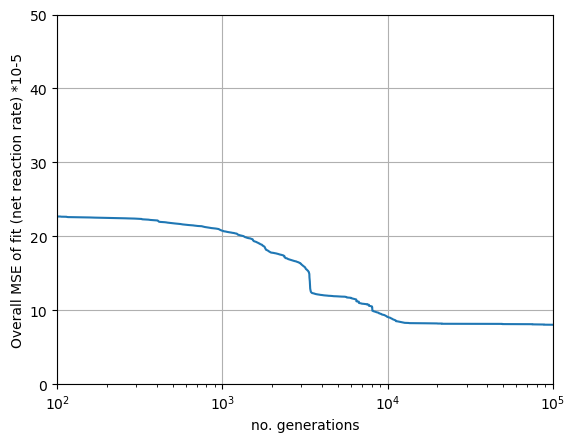

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.724616555741514
1.548017185416787
0.7894476339410285
-4.332818639982751
0.5053476782884437
6.233319569760649e-08
0.42268572100119667
-8.416962495813637
0.798052075869192
6.917774524387917
5.071348397873059
5.167124550181108
0.40296576627532105
0.04698319559148509
3.1048538322230668
0.01921868175985938
0.5369682607372044
-11.999262794921968
1.894008752459497
1.6123293800995226
-11.853813301934418
1.2064110577716582
3.8151953499724742
0.039082649211580174
4.216475297260491
3.6578269149596734
1.1878677798598778
7.271142590820487
-8.890260149060007
2.655859110161263
2.144455947908129
3.3067005826275424
-3.928191328381946
0.4792715455940006
0.9892237632078678
-1.301029997192444


In [37]:
res.X

array([-1.17246166e+01,  1.54801719e+00,  7.89447634e-01, -4.33281864e+00,
        5.05347678e-01,  6.23331957e-08,  4.22685721e-01, -8.41696250e+00,
        7.98052076e-01,  6.91777452e+00,  5.07134840e+00,  5.16712455e+00,
        4.02965766e-01,  4.69831956e-02,  3.10485383e+00,  1.92186818e-02,
        5.36968261e-01, -1.19992628e+01,  1.89400875e+00,  1.61232938e+00,
       -1.18538133e+01,  1.20641106e+00,  3.81519535e+00,  3.90826492e-02,
        4.21647530e+00,  3.65782691e+00,  1.18786778e+00,  7.27114259e+00,
       -8.89026015e+00,  2.65585911e+00,  2.14445595e+00,  3.30670058e+00,
       -3.92819133e+00,  4.79271546e-01,  9.89223763e-01, -1.30103000e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )


-12.0: -11.724616555741514
1.6: 1.548017185416787
0.9: 0.7894476339410285
-4.3: -4.332818639982751
0.5: 0.5053476782884437
0.003: 6.233319569760649e-08
0.4: 0.42268572100119667
-7.9: -8.416962495813637
0.7: 0.798052075869192
7.2: 6.917774524387917
5.7: 5.071348397873059
5.7: 5.167124550181108
0.8: 0.40296576627532105
0.03: 0.04698319559148509
3.1: 3.1048538322230668
6.000000000000001e-09: 0.01921868175985938
0.1: 0.5369682607372044
-12.0: -11.999262794921968
1.9: 1.894008752459497
1.6: 1.6123293800995226
-11.6: -11.853813301934418
1.2: 1.2064110577716582
4.0: 3.8151953499724742
0.01: 0.039082649211580174
4.2: 4.216475297260491
5.4: 3.6578269149596734
2.2: 1.1878677798598778
11.8: 7.271142590820487
-12.0: -8.890260149060007
3.3: 2.655859110161263
1.8: 2.144455947908129
4.2: 3.3067005826275424
-4.0: -3.928191328381946
0.5: 0.4792715455940006
1.0: 0.9892237632078678
coeff fit: 0.9643177710440819
